In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
# from keras.applications.resnet50 import ResNet50

from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import random


In [2]:
data = []
labels = []
dir_labels = ()
num_class = 0
INIT_LR = 1e-4
EPOCHS = 1
BS = 32

In [4]:
dataset=r"C:\Users\chaitanyamukthineni\Desktop\Ocular\dataset"

In [5]:
imagePaths = list(paths.list_images(dataset))
data = []
labels = []

In [ ]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    height, width, depth = image.shape
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    image = cv2.bitwise_and(image, image, mask=circle_img)

    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX=30) ,-4 ,128)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(image)
    
    
    
    
    
    
    

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(data)))
    image = data[sample]
   
    plt.subplot(2,5,i+1)
    plt.imshow(image)
   data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAsUAAAFmCAYAAACFq+fFAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMywgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/Il7ecAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOz9eZSuaVXej3/u4ZneqcZTdaY+PTd0NzMtILOIgnEA1IgDigOKs8YBUIxiNEYImpBEAU2iOCSYKF81fk2MUZxFEGSwabr7zKdOzfWOz3xPvz/eOk3DN1k/kgjdjXWtVV19zjpVz7vq3bXv69772tcWIQSOcIQjHOEIRzjCEY5whL/PkA/1CzjCEY5whCMc4QhHOMIRHmockeIjHOEIRzjCEY5whCP8vccRKT7CEY5whCMc4QhHOMLfexyR4iMc4QhHOMIRjnCEI/y9xxEpPsIRjnCEIxzhCEc4wt97HJHiIxzhCEc4whGOcIQj/L3HJ4UUCyFeKIS4VwhxVgjxmk/GM47w6YGjWDnCJ4qjWDnCJ4KjODnCJ4qjWDnCx0P8XfsUCyEUcB/wOcAG8B7gK0IIH/47fdARHvE4ipUjfKI4ipUjfCI4ipMjfKI4ipUj/M/wyagUPwU4G0I4H0JogbcDL/okPOcIj3wcxcoRPlEcxcoRPhEcxckRPlEcxcoR/j/4ZJDiU8CVB/154/DvjnCEj8dRrBzhE8VRrBzhE8FRnBzhE8VRrBzh/wP9UD1YCPFNwDcBRFH05NXV1YfkdQQgBAiEBz67EPBh/tn5a5893gcgoIUg0ZpEKxKl0UqhhUQy/3ofPC4EQDzwFE9ABJBIQvDz7xMppFQoJQn+2jPBtJbGGSpjaazDek8QAiEFSki0FCgpUUKgpEAikAKEEAjmn3nQ0z/V2Nra2g8hHPu7+n4Ph1gJ4TA+QiCEgPce5+Yf1jqsdThn8d4BDiEEWmuyLKPT6dDtdUmSCKXUPEa8w1qLc4HgA847wjwA588TgtY4kkghBAghkUqglSTSGqkUAoFznrY1FHlJUZRUVYkxZv69kAihUEqjtUJrhVLzeJNSIKWcx4z4aMx8KjEejynL8u/swQ+LOOFj84n/uFxifcB6j/ee4DzCz/NJFml6SUQWR+hII4QgIA5ziccdfl9r3TwXCBBinmMUAYGAw68Jhy8iUZI4mr/XgYBpHVVryYuasrG0h3kFKUFJlBRoKdHqo/lFCpCHn+fPeGjyyqdjToH5e8qDYiUcnjXzj4BzDus8zjmC8+AdEOZ5INJ0OhlZlhHHMUmseeDU8eDEYc7yYf4gP38vw+Hvu1LzuBBIfPAY6zDGUNc1VVXTNC3WegLzGJFazeNCKbSSKPnRPCIflEcE8/9/KPDpmlMIgcBH84k/zCPWBax3OOfx1oE7/OCQY2hFHMdkWUaWpg/EiRQgEXg///5SSLxzOO8/ei5IgZTzVyCQ2NqClrTB0baGsqqoqoq2abDWPnDmIBUohdBqzo2UQkuJUnP+Mo+VeU7hkLM8FPhf5ZRPBim+Clz3oD+fPvy7j0EI4eeAnwM4efJkeOUrX/lJeCkf98z5c/GA9x7rA8Z7GucojaMwlplpmTQto7pl3DTkdUNXKh6zusKzrj/GY06vclNvkVWRMLIN49mUom1Bqfn3d5LSOw7KEhkE3juc8cg0Qsn529/tdpgMhyx0uiwv9FDS4lWKloKlWNPXCbKxtDLQBsfQe96/O+QP7jnPezd3yK0jyVKWsoSlNGExiRlEEd04oqM1qVJEShIdJi11mKg+VQfa6173ukuf4D99WMbKNZ29d/PDyVqHaS113VKUNbNpyXicczCcsr8/Yjwa4dyYJNHcfvstPP/5z+ezP/t5POEJj2NhKcFSE9qGWTVh72DEZJIzm1bUs4Z8lmOtZ9IUEATSe6S0OJdwbtewNpAs9yWRVKgso5tlnDrWR/Vjukt91roDMr1Af3GF4DWTScUHP/Qh3vmHf8Qf/uE7+cAHPkSRG4To0+0ssbKyxOqxRZaX+wwGXXq9jDRLSGL9AGmeJ8VPPlF+61vf+r/zz///xsqnPE4O/+O5Rnj9PJ9YT2kceWuY1oZR1XBQNQyLmiavia3l9rUlnv/Ym/nsW6/j8adPsJAl1LOc2jn2Xcm49rTWUjtD3tZMjaWuPcbCeFyS9lP0QCCsYOAsEo+THq0lSqdEZDQmQ1rDqYHi+rWYldWUfrKAyQ11lnD/dMYfvOsj/I+/vJ/33bfJNAQYZET9jIV+ymo3ZaUTs5hG9BNNJ9Kkep5XlJQoyaeMAD3Sc8rhM+dnhJ8TX+scxjrq1lA1LXnZMC1KRnnJ/iRnNJnRTmb4vGB5EHHHo27ks5/3bJ75rM/gxpOnodhn7cwipnb4JlDkFTvDES2GthZU+w1tWWOaijiW9BcTDILCe9I0pZ9IYgXdLAOZkqYx/UwxWOqB1ExqyfmNPd711+/nj/74r/jrD3yYvWlJ6HaIF3osLfRY6ndZ7HdY6GT0soQsiUnjiPiQEMnDM+jBxZpPJj49cso1jjIvlrTWUxtL0bZMypZhUbE3K9mb5DSjKWY4hdkE4XOWF1PuuOMWPvv5z+PpT38at998ktXVDomMCZe3cHVFKwQ7e1OsrynaEucCkeqwM5ziIpBa0EkcvUwTRyn9NEWEGLUnsdOSY0+6kfT4ABKF8ZJRLblw4Qp/9a538wd/8Ie85z3vZXdvjPcZtruAWFqku7zA6mKfY4MeK90Ogyylm8akkSbWCiXnF65PJVH+X+WUTwYpfg9wqxDiRuYB9uXAV34SnvMJ41qgOXjghmW8p3aO0lhmrWXctIyahmHVMK5qVAg8dn2Ff3DT9bzgzDpnFpfx1jIqK/ZGOZd9TgNMrKcNEoIjylIm1Yyybal9oK4qulkXZEBYC9KBVhjXIjtdtoc5szYQxQJpcjpRzEzAoJshAmAdEY5bjh/jGU+8nW95/O1cnk35oytDfu3df8PfHozZmeb005TlNGU5jVlMY/pxTC/SpFqTKDm/pUl5qJV56Ko9/xM8rGLlATLs55Vga+c34rpuKYqa6aRgOJyxtzdmb2/IdHaADwU333yal7z4K3jxi7+IxzzmdjodhXcldZOzs7vBcFIQmopJXpHPaqqypqoa8qKgsRZ8hLVAMMjgkNIjZExTepz2tAiMkqS2pCgrNsqSNpGkC12GvUUkW1x/coXeQhep+zzrWU/iOc/5TF772h/gnnvu5bd++7f5rd/8Le6++z5G4222tldYWVlmbW2JlZUFFhd79PsZWZYQxxFRND/MlDqMmIeq7POxeNjEyoPJsA8B6+aX69rOL9fTxjCuWvarhv2iZpxX2Krl1tU+L3nhk/iCx9/CY9aPEVnHpMyxsmRzNmVvVjOzULcVhYHGtnhn8N4jlSbRAoSnmyqqvIAoQcqYRinw4IVC2wgVDEGBTiwWxb07Fef2JCu9lOVeQQ/LracWeMrJPk992bP4vpc/k3O7Q37vTy/wG//tA7z3/i2uJJqdhQ4LCxlrvZRj3YTlLGIhjeheI8fqo3nloawifxweNnFyDdeqwT6EeWfJeYy11I2hqBumZcV4WnAwzdkfzxgPpzTTCYup5oVPfRIvfvHn87znPpUTawNiH7DFjI98cIOsp7m6sUUzLWgKx6hsmM4qVO6ohjWN96SrMd1jMa1wbJoZs7xFkNJvAxM3pZcmJJEmVpo4jtmTEcl2lzgWdDLFo9b6fMZXfy7f/oov5mDa8K73fIjf/C9/wB/88V9xcfuAzUGXhcU+Kwt9VgY9lvodBp2UbpqQJhGx1vOqspIPaDUfJvkEHkax8jHV4GscxTlqY8nrlnFVsz8r2ZoU7B1MKQ7G+OEYygnLCwnPeN5n8JKXfCGf9ZyncOLEGrEQMNvHT6e0Z3NK0dBOJmxt7qO7y1wY7lJoh/YaV7Y0dkLpHdFShqghriTprCbVhp42TE3NguqykHS4/w8/wO23LpL1M5KlAWtrx1m74zqe+sTb+LZv/Xp296b86Z/+Gb/xjnfwznf+GQcXdtnf7DFcXOLqyhKrKwusLw5Y7XdY6nbopTFpFJPoeRdTycNIeYiqyH/npDiEYIUQ3w78HqCAfx9CuPvv+jmf0Gs5/DxvOfBRMmwdhbXMGsOoOTy8yppZVXNdN+OlT7iDl9x5OzdGiraoyCvLfZMtTBzReEMTDPvljBBphFIUTUsQCl9YnBQUgJQaGafU3uKVRWpQSUTw4F3AWU8RHKODffqLA1KtsAik8+RlRaxipIcEUOOcmbF0o4jF4HnpyRO84K6MUZLxO5NNfv39H+b83pCtJGGlk7LaSVlOExaSmF6sya6R42uHWJi35x/q1PSwipVDecQ1MmzMYWW4qJiMCw6GU3Z2Ruzu7jObHZCmji/8ws/iq77qK3nuc5/B4mJMcA1Vtc3+1Zz9yZiD2YzR2DA6qFGqoWxqgvE0dUvTGGpnAEnsPTgP3uIFBBFANZjKoHsaa8HhUZUDJdmZTWiUIBnXtD2DR7J3eZ/esQ5Zt8fSQsZgqcPqwip33nmGxz3++/je7/lu/uqv3sMv/MIv8N//+x9y+fIuu7srrK6usn58idXVRZaWevR7HbJOQhJHhHCt0gM8hC3Rw/fnYRErD3SbAjjvaQ8rw4WxTBvDsGzZLRt284rJrCKxls+74ya++tmP5dmPOkkHR1k2TPfH7Ocle8bgIknd1BS1wQRB4z2zpoU2EPlAK1sMh23qAEJAaAPtyOCEookEPoCOApoa7w0JFV5I8ApjNVGSMRkWfGQvMNCSmW15lM9J4g5pEnNbt8vtn/94Xvmiu3jfuW1+5Tffyzv+4EPs788YLXbYWuxwfJBxvDevHi8kEZ1Yk+pw2BoFGQ5b85/qN+XB78/DJE7gQUTnMFacc7SHleG8qpnkFcNpzt5oyt7BmOnBBNFUPPb2G3jpd301X/gPPoubbziDDA1uNiG/dI791rJ7/4Qrm2OO35LRDqdMmorxfsN0y9HWklgZWIxodEAkllRoNnZGGMAbSSwi2npKpBomeU2kFGkckSroxF1amxMS0JFk0BmxPh6TRIoo7fPMx9/MC5/+BPbzCb//J+/l7f/5v/EX77ubg+19+ssLHFtaYG2pz/Kgx0J3Xj2+VjlWSh0SnvCQts2v4eESKx+9NIH1DuMOK8NNy6io2ZsVbI5n7O6PKXdHhOGQOJQ84XGP5ste+s18/j/4HG45toxyDtoD3PASdVEwG+0y2ZtyUCuM8tg6py4Ds70S1Y0onWUyHBOaeUdbdjTNrKbKS3pykUEkiGXNFasZV4GlTsVgIcNKycXfu4djNyxw6x0rJDu79OPA4uoCIlnmeGeZL/v8z+ZLXvT5bGxv8z/+xx/xy7/8q/z1e9/PbG+LfGGZnWOrrK4ucWJpwNpin6VOh36WfEzl+KPc+FMbKZ8UTXEI4XeB3/1kfO9P+DXwUamE8x7jA41zFMYxbQ3DumG/atgtKvK65o6lJV7x9CfyBbefpicDhbPsznL2pgWz1tNISxMEXoCzUAtFXbV4DEFITIiQSlO3Na4NREIQyQjrPNO6QSeaWAiUjqiLFpzHSIkVkuE0Z7DYByUJJpD4gA01aZSQWEPeFKy7FTJt6MQaR46LHMlom+950mP41qc/id+/7xI/9+fv4z2XrrCblKz2MtY6GatZwmKa0IsjMq2IVXig9flwqBo/1LHy4Oqwcw5jHE1zWBmeFhwcTNneHrK9vc90usfSUswrXvElfP3Xfy1PeMIdCNXQNCMO9qZM9nIu7+5Qlg1l2dC0huG0oWlAa4NpDa61CATee9rgwEt8bfGhJosUWaypjKWwjtw6pg5WVYRvG0ocWmvK1oFSuFDjG4MxAeU9x9wCxg3p9jK6nYjFhU1WlzSDpWP0+6s857l38dznPpOzZy/wlre8lbe//T+zsXEv+wcrHFs7xonjKxw7NifHvV6HLI2JYz2XVCh5eJY9dNHyUMbKx0slPiqTsExby7Bq2C0atmcV42nJohR827Pu4Kufdge3H+/T1IHJuODCrGDcGGwbmJUlFY4qBIJU+LoG56mAyghC1TCQEhkHaqnwFmTtaEqLaQSuEQRR0u3GiBi80YwnHqk10niiBLqpIEkg68wlFk2IubRbc/WeCbv1gPVFQ6Y0K1nBQqZY7Kc8fa3D0//R5/P9X/u5vOOd7+etb/9zzp/fY7rUZXepy8mFjOP9lNVOQj+J6MSKJMiPySsP8QXqoT9/DvPKR3XBczJcVA3jouRgnLM9mrC7N2a6N6InHV/0vKfxiq97Gc942pPp+Jx8tMXmPffQzGaU1nGQ59TWc+FvNuksJEx2JggviFvF8ErOzASipS4+0uS+AgvZzDOZFDRtQ+MUAU3hC2ywdDOBCB4pBD6v6EWSE0sxzlZUtSV42I9SLg9nDDoxnXiIFjHLC33WB4qvfO6T+IqXfC4f/Mhl3vbLv8Fv/u4fc25/wu7yAsdXF1lfHrAy6LLQ69BNY5I4InqICc/H46HPKfPq8FxO42mMpWgN43JOhq8OZ2ztjyh2DgjDAwaJ54Vf9Fy+/utexjOf8WQ6SQvlFLt9luHVgqIdc9CU2DhlWlZMpgWzwjBrG9JIE8mY/cmIfFzS6fdQDpqqor+0QOlbiqnBGovzY0Ik8cGS1xKd9PFNwyS39BLPJBLsfmQDFlukDAwiSX8rQbmM3sIxRFewtLrMdUsrfMNXfREv+6ov433v/1v+7b/99/z2b/+/HNy/x5WdZfbWjrG2vsqp5QXWF/oPqhxHh0U8hfwUX6IeskG7TyY+Kkif37waF6isY2oMo7plr2rYKkqmZc3jVpf5ps95Bs9b6RPZhulBxVVv2a9LaheYtTmVA2MltZmTbOMsSInSEaNRM79jihYdBZRKCKFBSFBeEhFhCVRFQ6QznBeY4EnjlChIEiJGozGlalEhxdiWkChCsLQ2wteBtioZ1oaVXh+vAulyHx0pZgczRndf4OY7r+MF1y/x4ie/jN+7+17+zX/9C961sclBVrPe77Dey1jNUhbTmG48HxCMw2FL62FSNX4o8PHV4bY18yrerGR4WBnevLrHcLhDrw/f9m1fybd+6zdyyy3X4doR0+kl9qYH7Gzv0+Y1xbRkXBryqsFWLX0VQekoxzmdvobgwc3bqAiJbyUeENohdUQQAaEANInUeDubD/D5+XBeYy2VcUSxROAQtaYMZj6MaVq0Ciid0hY1E2DUSdnrxGT9nN7SDiurA1ZW1rn+piXe+MYf47u/+7t429t+iZ/92bdy5dK9DA/WOH5ijZMn5uR4YaFHt5uSJjE6OtR8PQxIz6caD64OW+9pnae0jlljGdYtu0XN1qziYFKyIATf9pl38s2f8zhuWszIJxWXr84YNi2T2nAwLclbhwkB11ToSJE7j/USnEPF0DiLCQIvA1oGOlbSsYJpU+O8ot/pIBehco7WONLYk8bgRU3ST3DW4xtPIhVxCHjbUlYeFYFWFetrPe67YPmLswV33BgYxIKNEhZ1xPq4w2qqWensc8NSn+/7h0/lq//BZ/Arv/s+3vIf/5Tz5/aYrvTYX+lyerHDei9luRPTTzRpdC2vzKvGD/WF+6FCeKA67LDW0xhDVbdMioqDac72cMLm7pDJ7gFdLF/z4hfwHd/2cu687TQur8nHWxxsD9neHjEZFeSiJXeGcVVSjSqu7hZcv75ItFNS7UKoLdFCRO/6BRpfMi5qWufp6JTcB6yAhaTLRpEjJDSmQimFdXouaVBQNZZgBFrO8B46iaIuWnarnEZosjhwenWBJMQcDCdcjmOuP2m5zrQ8/sxx3vRPv5vv+0dfz7/7xXfwtrf/Nmfvu8jB2jInVpdYXx6wPOgy6GZ00oQkmg8KyoeA8Dxc8IB2OASs87TOUbWGadWwNyvZHE3Z2Bsx2T7A7++yEHu++KWfx3d817fy2DtvRFV7+PElyryg3Z8xKg33nr1Eq2FkWryImTWGurFIJI11aNGS6JYQCaqxx/iaVEboRFGYHKdjTG0RNkAMo6rGuZZOb4APDS0e07R4GzCrCVfuK4mutvR6ghSLFjlZ1CMpPS4J9Hb3OBEPWD+xzNL6dXzm42/gqW9+Iz/wmlfxtrf9Mr/wi29j8+xHuLx/jIPj65xcX+X0yiJrgx4LnYxuEhNHAS0V85rMp+bc+bQixdeqOY75dGZ7qBvOjWPctOxVLVtlxX5ecabT5UeeexdfcPsNxFXFRjFl1Fhm3jFtc2bGI5JFpk1CU7YYZ3ECDJY4sqQqIhEdujowq3Iq06LThF6ng04UUgmC8/imJdIeg2KalyRJTAiewjWksUJ3NYvJKsV4zHRqEFmE95JOktBaRxHmlaOybWgbDXFCVnqS4HBrPT68cQmWPVlXccYantPt8Pyv+Dz+cHPMG/743fzNlQ2GZcPJfofjvYyVLKWfRnQiTRLCvKX19zAxhWuuAIfOEXXdkucVo1HO7t6Iq1f32dnZJoQZL3nJ8/n+V30vT3jCo/F+zGx6ieHuHnef3aK1gelkSlM5jBfkTY5tFSIEDAVYgTEVtk1p8AQPWkcYE9BKoCNFZQxSzN+HtmV+oULTsZqOj4i8w0hBKwWtsUQ+oawbpA5o5VE+ojKBSd4QRw5EIBIRRdVQFjFqMiPd77B1ecjC2gHLqwucWl7hxIlj/NAPfS9f/uUv5Wd/9i384i/+CufPjRmNjnPq9Donji+zsjJgMOjSyRLiSKP0vCIYwqc/Mf7Y6vD8gl1bT24so9qwVzZszip2JiVUhhfffobXfvFTuW2hQ1U0XLq8z27VsllWTK2kbAxlY/FB4NqCWAjaFoz0VN7hQ0AZiHBEQWClIDeCSWEJdUHWj+n0NVrUSC1pBURGU5UOgkPKBBEpWm8IHjoqENkWhaSxitY6ZGJJo5Iz6wnnLzR88P4DHntrinKK0reMi5Y9rVnqJPQnhmNDx+pyxvf+w8fxlS96Mm/8ud/nl3/rr9maVEyO9RkekuO1bsJiFs0v3eFQqsXfrwv3A0Tn2oCUcdRNy6ysGU0LdkYTru6O2NvZQ9YVX/T8p/ODr/4OHv+YR9HsbXH53ssU+QRT5gwnU/aKguGkQqEwomVKYHd7QoqiurxPUUG20MUMYoaRJZ4OwUvyxiG0JChDGSyVC7gq4J0jpAoSTyQgFZo2eBorUSqhbVsOJjlRrCgbgXGOqpE4b0mEZzYdM24UiQ50uh1c6zjYPqCTbrK83GdtfZHXfd9X8fVf8yLe9DO/yq+8479x73jGcH2Fk6uLrC3NyXEvS8mSiEiHwwGrTx3heTjgAZcrH7DO0RhL3rQM84rN8YzL+yP2tg4w2zukLufFX/RCXvV938Fj10+i4hlheIHZlV12JkP2pzPq2jP1nlxIzl/aR/USkAbjoGkt3Swm6mhmeYt3Mf0EFrIe5dTi+wKTWCIEwQicUTS1I/YO5QVCpNR1g8ocUZQRE/BeUTuoXMukrJjpQC+kLHYFdWmR9ZCWQOU157KcW+oRj5kdILe7pIMlbj5+Hf/kR17Ly7/mq/hnP/kGfuMdv8X0vhHnhsc5OLnOmfVVTi8NWOl3GWQpaRwRHbomfSq6lZ82pPjBcgnr5lq/0jqmreWgbtguGzaLCh0C33LXo/nG229kxddM6gM2S8GVfMpBUVFZh/UGrxKSxCPTFLxHmHkVT4eYrsxIXaBDhOgKvPB05YC6NbR1S3x4mhobyFKJ9GE+HV43VFWFSmOiNMM5h0ISZCCOIhpj6KY9gnA0xuNEwASDzjRN25ALR9rRlLIhzytiIibTmne96yOcuO04G3rCSbXCzaeP8cLHXM+zn3gTv/bej/DPfvMPuW97xGTRcKpvWevNnSt6cUQaIKh521P+PUhMD+i3DhNS2xqqsmEyLdjfn7K5tc/Gxg6zyS6PfdyNvO5H3sQLX/hspJxwMLzEla09RqMDyknF+KBhdzJESEnTBuq2xmDIfAcdHOMmJ+t2CbFiXDRkgwyDwQQzt9jyjkWh6MQZeVsitaKRkiTTVIXBGoOXyWHrw6OUpKc7CBNIsy7WO0SwxN4hXKBhbt8Xh4CQioDFTA1WBmJd001TTG2ZHRSMByNOn9xlbW2N668/xj9/44/w0pd+GT/yI6/jj/7or5jlM0aTE1x3+hjH15bmkopuRppEoHlYyCk+mXjwBdu5QOsdlfFMG8N+1bKZ12xMS2aTkicdX+aHv+ypfPad19HUMy5s7bNfeYZVxbSxjOuGIkiMbec2fl6gvENITfAG5wPy0M5Iwdz+yAWK3OBcRJpI+ot94kgSbIsKEtd6QGLTgKkVoTT0s4iqrSlq6AlF1lqWdYxzFutasihChYimsnQizZlTmvsvOP7m3gm3XN8nU579puVARmR1TaZgbVZzapJy7CBjbW2RN37f5/KyL348P/6md/I7f34vF/KGcWm4brnDqUHGSjdmkERkIcwPMjk3Cfs0DZMHcM1Z4lrXqTGWsmqY5CV7oylX90Zc3d6nOjjgrsfdxg+/5rv4rKc8kSieMrl4D5c2Drh6kGNdiy8LpnXFQVEQkESJx2qPbsDsj0nTVRw9susVTpSYNtAISSfKsLOKvhDEQeOqQFFVBKCtw5z8JoYoFqgIej1BG2DctDSNpslrnG3RnQidxHPLSB8hhcA1gbGZoXSCiHr4qaGe7bObSDpJxGq1zO4k59hwxOqxAa//4Vfysq/6In78DT/P7//Ze5lMCybrFSdXFzm20H9AUhFHgfApJDwPNa7FiXXzQbqqNUyqmt1pweX9CVe298mv7iKn+zzjMx7DD732e/is5z6FuMkx5y4wPHfAQTljGBmGOGazAoundp5JVVGHmOlOy/qxATK0CG9pq0AkEpIoo6kFi1oRN4G6CMQLKU1t8V5BGiPjQBeJaQuI47l1n3d0giT1ipmp8HgkGhVBbQ1KCCIbaNuAKUtMaNCJZNxKZi4jmJZyr6TfW4BsxHUbY06uHefm40v8/M/9G77pld/Ij/2Tn+D3/+CPOZiMycczxqfWuP7YMscXByx1MzpJTBzm9ref7O7CpwUpvkaI3WF7s3aewlrGjWG3atgsavbKmmefPMarn3Ent3rHaH/ChbSljjTDWjAqLQd5jQVaZ0kSjW5r8J4kduAtMoponGPW1LROQTfFCoNOJVprur2EYGtm0wmTaY1SESrukiaKLArouEs+mWIbi6QiGEvcWUDjCUqincLkBcdPLFMVDZu7u5gA/ZUBbVsSJRFRGmN8y0ExZTnps7K2zNbmDmfv3ebGO05Cf0akukwODFko+IpbBzznm7+Uf/rf3sv/86EPM6taZm2Pk33PatczSCM6aKLD6s6nc9vzAZ3fobdw0xqKvGI0ztneGXHlyi5bW1ukSc2rXv1N/KPv/nb6XU9VXOVg94DzGwdsHOzQ1oJgWqgsVd6Q1544TkAGNBBciQ+CTqdHAOKsQ5m39F2EFX7uMywCtQGsI1iL8oHWtehejJbzZNnYFhULnDOIEIELIALCc2hfIyC0IAK0AhVA+EDwntYbPICTBAfWNDRFRVVUpN2E4USzfzBieVBw8voRS8s9PuMzbuf/+c1f5z/+h//E6173Y2xcvJ/ZrCAvak43K6yuLDDoZ2RpQhTNB2cgfNodZA8Q4jCfAm+cJ28t49qwXTRszCq2xgV973ntCx7Ptz3nyXSqKTvDbXZGJbt5w4G1h3ZblrpxCCASjkgKmuDBBxoMgvn7pg99hmOgbASzIieKUtJEoeNAkA5jW0xw1DpBigS0p3WWbJDBxJCPSkRf0k1SugKMN4ydJQhBJS0+gCSmCB5pSno9yfU3LnFhY4+PXJhx84kBOgmMbcvIBGIRmNSBycywUrQcbxuOz2Y8YXWNX/0XX8d//N0/5yd/5k+4/8I+eTlguuo4s5Sx3gssZRGdCBL1UTnFp1mYPIAHyyWMddSNIS9rDiY52/tjrmzvs7e5y0pH8aM/+j187Vd/GfFkSHX+LHu6Ym/qOHf5KqNJQ+MqvGmxCErriFOBkBbXBurtGl0nJCcEyY0GlKYZCxLVp2gaTGvpRpBISVk59vYbhEqxztDt9Oh2AihHMA4aRWGgbi1F62iFnbsVJRG6lyK1x1hJlmqCDbR5g0wilFbUbYloBZGMiYHWVpS2JS06HBRLLI1qlpbH3La6zNvf/MP8lz94D697w1s5d+4K06KiWGs4vrLAcr9LvzOvBAYUWn565hN4sFxi3nFqraNo5vZqm6MZF3aH7FzdwW5uc3wh4rU//SN89UtfxEBJzGiPq7tXubqTk7cHHFyeMdqqSU8PqLWlDg2TusJJR5ItwrikrhriAWgdI52gnVl0FmilZLueZx7pDHIvp9f1kIJLGs6cWmLz4iaRjCEobDCoRGOCp21aagRKWjpxRBYn0AiyWKF9oCobGmewQtGTGmc8zjhmTWDSUczClNHEsFfMh0uvuxqz/ugzPPWxt/Lr//lt/Po7/l9+9HU/xrkL93FpOmU6O0l+4hinVxZZ7c87DGkU0Oqwu/BJIsaPeFJ8TT/sPBjvqJ1nZiwHTctO2bCRV0gh+aFnP4GvuvU0ajpmc1wxCpJp7smrijJoisZipKYOjpZAEiV4GSGkoylLjHO0xkNwdKUk63WpXUVeVyit0ZlAaUdrS9JejAmStpHMZhbjBJ3FFBXNTbLbvMa2DY6U2WyG8zVxp0+cZRSjHbZmMzr9Hq6pkUlMliQcX74BV5aMruyyn88ompbOmQWuv3GNVno2Lm9gQ4sl4p79Lew00K8DpxczbrvuGG/+2s/mhR++hdf+h9/n/u0xRWupbJd1n7GYQi+e+yxr+enZ9rxGiK27JpcwzGYlB8Mpm5sHXLq0zfBgk8c99gZ+6qd/kmc98y5se8Bf3/0R9vcOaNuc6cxSlw2ubbEuEKwhVppECibDKVlHknVihLCIWDM35TcIL4m0ZDapyBYUwnpkkERSY4XDSI81ljhLMHhiJxBKEpQCrQiRBDTeBYqyIotSJMw7Gt4SyQwpJKmMsL5FiwQDtK0FGQhzv39EcBjTUI0NSRNTVDWzuqWwU7LzPZrHONZOHuPrv/6lPPWpd/E93/P9vPOd7+a+qqIsG+rGcHxtkYUFTzdLiSJQen5z/3Q5yD7mgu08lXXMWsvBYXX40qRkNCq46/gS//xlz+Ap6132r+6yi2K7zBlNW0ZVQ+49xgWE9Tgb5qQXsHgSIXFa0kqJcy3SX/t9k1gTKIqaLE6IU0XAIYkO3z9NwGCCxrSByAuQGmMrVhYTSqvY2x/TXzbQ6RDSjMI6hPFIpUAKnJUIkeJFQ2skvX7L8dNdNq5YRgeOG27qYIwhbz0mCEQLJoG9ULHnWoalY730rOQTvu75j+HZn3E7r/lnv8Nv/9k9XCwN02ZAvuI57VJWOzG9WJGiUArUp+GF+xohnnsO27l2OK/YG03Z2B1yZWOXYn+P537m43jD63+UO247Rbmzwz3vvhsvPZO45tLGkKJ2VIXDSktZlaASfCQIMuBzT71VUbeaRicUKqOaBHqyJfKaus1JNHSQLPcW2D8YsTt1ZEtdhKpxLqBUTSfWyFgQiIh8jHSSxAZEWbDc7RCJQNUYLA1NFQgEko6k39c0xPO2eWVJEoXUAU8DIkIAo2mOqOed0qJIycse7cSzvmx48dMexWf+xpt53U/8LG//nT+kKGuKpqVetRxznoVuRpbEoHnAuu3TJZ/AgyxhD/XDjbXMqoa9vOTKcMyFrQPGV7aQw10+9zmfwRve8OM89tHHYWuL6cEO57dn/O3OBFtWNO2MeFXjcsHm2S0WjnVI1rqEyLHQTYlJ6BDY3d2l1zuGVilNXUIUIzXgLS0AgtZZvOqTaEg6CWNbsXdld24xaSJiIkRQCOFQccTEOCqtSHxLRzp6WZ82N2gLWkicirCiobQxoRHoRIAzaOWxTYWzgorAtm+wVcVsHNE0DSduyklPr/OyL3guz37mM/nHP/wj/Me3/wYHRU6Vl+R1ww1rK6wvHMZKHAho9CdJdvOIJsUfJcThY+QSe3XLZlmzmVfc2uvxTz/ryTzhWMTebMzOtOHAOUZFSeElrReEUKGUZiHJWNSSiRmy2O2iZMq0KcFHRFqTZilF2WJci5ZuvtXMW6YGZhNPL4FYBmLRQceGuCtwTlAUBZ0lQW4apFJ4GVGXLd3lDC9AMNd/OluzuLhIuT9kRShOHTtGPchYWznOaG+Xg809JqMpOk247uRpeoMlrlYTQlKxduMq97zvLKdvOI1fXKSZOhazFCkU8cRxOhnxpY9f464bX86r3/6H/N7f3k9p55cIM/C4kNCPIVXMt1sRPm2I8QOVnEN3iapumM1K9vbGXNnY59KlTepyj1d+00v5oX/8AxxbTZmNz7Jz9YBqr2D7Qs4s30Noj4wUxoJxBhEcTRtQqWAhjhmPSmrT0usm9KSkPRyC63dTjiWC4e68OyAiSRsCrZy/tlgIOt0EoQWtliipwba44AneEuLocBhDgtaISGGtRSpHlGYoN6AwY2Jr5/7WImBCi9IQ8DipCV7QTTSRgtZDXuVEbYxsW4a1oVE1W8WUO28/4FHX5TzmzhXe8Y5f41/+y3/DG9/4r7hwrqKqatrWcNI6/FKg20lIiEDNp8kf6QfZgwmxcY7SeiaNZa9suDytuDIqaKcVr3zW7fzoFz+JXu25eH7IrgmMjGFcV+zlntZ6LB6CJxEBokDT2sNthgoEhGDQTmOJ8eKwmlsbfKXophFZN8E4Q5CCoBw2eKwXSJVhrUdIQWkcFkgESGsZdB2l6DEcV5Te0l+UdCNJFMAZh5UKKxxagQ8aEyyxFyz1A+1AsDuE3rDg+LIGF5i1YKVn5lowgem0pWo8u3XF6qzHzXnDdUsZv/KmL+fNv/oX/Nibfp+9ylI1jtJ4WhdY68YMUshQcEiMH2rbtr8rPDCX4BytsRRVy3hWsH0w4dLWPptXtolNxT/94e/km1/51bTthA99+F6Gm3tsX9qnv6rJg2FrOCN46Pf61E1g6h29GIRyRHlEs9mgog7LNydsHIxYjReJtECFADiM8kgiWhu4tL3PtDX0l5eIE3BOgYvRQKw71NZT1xUdZXHBknYyllUHnEF6T6yh8Y55Nz3GOktpPHWwaB3jnUArgTMNQUtaIFSO3AZkMNTWMWgMRVUxnpQcTMacyZc4cXqFn339d/KCz3kO3/dDb+Ts+auUdUtj5h2VpX5nPoTH4dIP+LSYc/lYQuyojGVS1uzMCi7uj7h0dZfy8iYDX/JDP/ZqvuWVX02XGnvuEtOtLc4dDLk8nrI/bGiCoLWWjpNES/Nh/dnOlMgZjq91sdJRi5aFtR6Tqzu43JEsaqIkwgiokaSZIq4EVdwQsoSkkzHNh6yvZKx2Y4TtsL0xoSCAtHPpjIBJU9LahCAkOo4ILqADtEKjVEaHmGEwTAtLmga8bWiaBqFjmsiTO03wkrJ1FK3Cxpbaa4QD341J85KsjbjuiY/nrW/9WZ717Gfzj3/4R9k5fz9ny4qybmhOHOOkX2Cp26GTAHq+Ke/ver7lEUmKHzwAY32gdY7CesatYa9quVJU7JcNX3LbDXzzmRX0aMJFG7NjDNPGcVA2zIoaA6TdiFjOD8KmrJFxRBZ1kUHRNg2hqXCUIMC5+VrEtrEI7elGCUKaeTXIB4gyRBBYFEq0SAE6iukMFpjtjtErfZbWlqjiGbbdoaMFk0iQz2qaqkZHEYPT69zwqFsoL51jdTlGHFtCRwm+TnDdFDMpOH39cZZPrNBYy+5uhcgFnXiALffZ3cxZXV5icDxDSsWwqRDOMTaK68qEM6cX+KXvfiGv/w/L/Ot3vof7rKcJc8s6HxJCDClznbH+NCDGH0uILVXVMh7n7OyNuXx5h8uXr5LGNf/qX/04X/u1X4oPY85dOcvW1V2Gu2NMadCxYzzViBAYLBhIPRKFaDTd1GG1xQXPseUI5yKqoiFEc32hFjGhDVTOki7FHOyXJJkm7QE4BJqm9dS2pScTXF0hOilt4zBNi7AWYwRTW+GdoBclxM7PL4TWk8QJU2fITUNf9JCRIAiBtBolFEVrCcKRCoFyglRKrPfIAM611EbT2BnxQLF1YYqyNXpScsOZNRbWj/ODP/id3HXXk/nO7/wezl84T9sajLFY5wlLfehBHIPWj2xifI0Q20NCXBjPuDFs5w2XpiUbw4KlEPjXX/c5fPmTTmGGI+7bark4KyiAUTOvrhamhcMhGuk9kYpwAoglLngE8yGbIOernLWbu9hUFurGkWWKOAkE5VFxhEfgrUGogJcOF5r5qt4QELGAIFBoqCuMa1C9Hp2oz3TSYtuShZM9SCzImNaKeZtbSpSQCAlSBHpColZi3rPfcGkTjkeBhVTTJDBxLZEJRES0zrPbOmqryRsw1tOb1DzaxXzXy57Bk554I9/+/f+Jv7045H5zeOE+XJoUEugENa8GfhoQ42uE+Jp+uKhqhuOczf0xF6/usrOxzS0nl3jTT7+ez3r2k9nb2ebsxiVGuzNmw5LNzTHHoi6um1BVkCYxU2sZO4eLU6Ru6DYJ7cUJ2UqH5IaUSblPMC1LK31KN0ErwYmTA65uzJgMWyZFzvKJJXSksMGSOEUqI5q2Jk40Vd2Cnq939jKQdTpIFfBOMZkWSAHpoIMwDb61kMa0xuJaQMS03uFFoDbzlcJZFFMWhsbWOBkhraWpwTeWKhLMkpaybJiVNbnzLOYlL3rOE7jj7T/Nt7/6Dfzlh89TGTt3zwme5RCYO/NzOAD+yO5YPpgQGzsnxKOyZnsy49zukI2NbdorGzz6umO86V/8Kz77WU/E72+xtzvk6qUdRm3B9v6MWjjiNDCdFkzqhlYGVhZ6BNGiohWmk4rq7D50JHI1o+oFoiSjnrSsnFoh+Bnagw2epZWM/Z2SrM1odEHejulct8xmMSUTEl/miODpqrmtXxRJYqFBZpRO4FLIYo10HlNXVFMLbUIrLLUBofsErTGUOC2Io4hIe6RQ886ZD0TGIX2JCD0mezlnxVl81CVrYh6tIlZuW+MVX/vlPPGJT+Tbv+07ePdff5CNpqZuD52WVj0roUs3iUHrQz363x0xfkSS4gcT4sY5CusYNYbtsuVKXlEZx2uedCcvv/UURT3mr0cTxvsO1UtpJJQBfBJj2hbpDCqJMUrR2ECRzxhkfYy1gCWfjokTkDpiOslp25gkidEiwjtJv7tA0pbYIBAiAuWxcu476I1HOEOadpEiZnh5B2EFq6vLxCHQ5gWnOgu4E32uskvtLOPhHoNOgu9l3P2RixwXnuNrkn4aEZZ7LK4sEXdTZvu7DDodTi4vUS8vc/XCHp2VE9STEdO9fbrLKUL1ibzhYDakM5HszHpMlWfNj/n+J1/HoxYHfP9/+WPO7s0wbv7L6wIsABmAknON7CP0APt4QlyWDeNxztbOkIsXd9jY2ODM6R5vfsvP8rSnPpa9zXNsH+yyszNimtccjHPKgxlF2zDKIbSKnZ0an8bEScNCZuhIhWHuIpGlCSEo8mGNaQxRVyOZW21ZHCa0rKwvMNkeolSK6mjyokLJGIFENI5MaWgETeFJk4xIaFQTiNA4wtzX0jsUIIXGGkMiJYmCWB3uqxcBLzRlbUm0JkhDACofkM7TNB4vAlrM7QFFpPF5jq1htl9zSQ8ZzjzHJoabbmh54QuewW+849f4jm//bv70zz6ANQZrHf6QnPd685/3I5UYP0CIDyVYhfEMq5bNouHCuGT7oOCWbsQvf+fn8ITllIO9EWd3Hed3xqDnVfmyttQOfDAoqVHzcjDWWbySODfXEScKpJY0wdKJIHiPtYKmqugNuoBDRmpOWr3GNBa0xVmHF4pIKeJU0xqLDx4vJNZZKmvoKsGScMgUYp1gDzw75yacOLNMnAXaxiGCxBiHUgIU2CBJnKKbwNqKYH/LsTP03HlGM3OWQkBqAziD84LCeEor6JkG3xgaUlq/y+PdlGfffoz/9p+/lq//9nfwPz64wUU7rxZbFwiDBBLIkIedqEcuMf4YQtxaZmXNwWTG1Z0h5zd2GF7d4vOeexf/8o0/zI2njjHe2+ZD993NZFyACzTW0LYNg5U19tsCGWt85NGRQxtHKyS9UlJutSye6uBXPKWv8baDlCWNrwBJvxeTBofPWybDmsHKInltMdYebpFTqACRTLA24KwlVRpwOAKNDXRTTagDHk3jGjCebtYHCnzVoqSik8QUbQsKpILWOvrdAUVZ05q5v66MPSpIOmmMEhBFmrqtsHVLVZWMm4Zjkx62VdywrPn1X/wxfvynf423/tp/oTUW4y3O+3l+66SkAI9gYvzxhLhsDaOqZnM85f7tAzYvb+E3r/Ki5z+dn37dD3HjjQP89lUO9kac297n0miPqZ87UnhhkYCMNIkAKzxGSQSGOJLEixHZwjLFyNKcneASWD61zv72HvVkxsJaRJpleBQ2qllYW6CdGOxmwbQqOHnjDRSbgY2dGXnRMIgVi8wdsOJU4ipDYxvSLMU5R4ymNjVOSqq8wbUW6xxCBnQicN4QXMA3jtYZSi3AK0IbiGREohWR8GjhGE5z2s4qtSjQVY655z5O11vceGvBkx93C7/zO7/J93zv9/P2t/8Ge/e1tMZgnMM5z7FBj24KMfOtiX9XxPgRR4oDH0+IPcPasFU2XJpVKCSv/+zH8jmLfYZlyU4tqHXK1XqLcjRldW0F1VU45pXfyoJrPSqyeGtRIdD4GhEMKYFjC32iKMJISWNn84MtkhhT0hKIVESWCrRUmNYwMy1OBdJYoxVEUiKVQMoumYB8mnNssU93YZFUdaE1OG2I+op6NqXXzVhf77PRNqjucXauTnCtw7tAUJrF48eZlYbWRIhJg15KsZ2YhTOrjLdz1le6XLhwP8lOxNLNgribkvYXGQz6lGXLue2K7RTWZcOXP/kMN9/4Mr7hbb/N+f0ZNsxnucKDf+BKoh+BB9i1Kd8HE+LROGdra8j5i1tsbmzw5CfdyFve8i+44/bTXLl4hbMXtji/sct474DhtGE0dQy0prcwYHlJIpxnc6sgUtDJegjhaUzMZDpjUkzpZJpuP0OkisY19ERGUA4nA607nMJXBSeX+4x2KmzjcIdVgFjHaCVJRCANCaYuSKOENI3xwSOdIwhP8ILGBUTw84pj8IjgSIIgIhCcwYdAa+ae2VpZnDAYEdEcbsarrZsvXdASEwR164iCJdIpw/GMkJToPDB2E5qm5KYbDHfecSNvf/uv8MpXfiu/+1//hPvdvDsSrkXLI5QYf0yF+JAQH1QtV/OGc+OS3f2c551Z5d++4lmcBLYvjblQllzam7eMcS2tqXFoNB6tNa0JSCnnem7fYtFIEeNloAwW6SQOTVm1SDuvtolOhIrANjH4uX2WcY4mOJR1EDR1gEYaMhuIdUTHO/pRjHGBMkAiEpSX9BIoZIU+ntLkmiuXt7lutUc0yNBxjAgC1xqMC2gL6ECsAtedTqmbirN7BacHmngxgiBRocFbAVFELSzGBILwiOCZVTNkJ6ASwa1+jxPHB/zaz38J//j1f8Kbf/29XPVzYhAA+gBzDSpaPqAxfiThYwmxYVbWc/3wzgHnLm1T7u3z8pd+Hq//ke9C1YbtD3+EzekeBzsTJkXJOC8JU4/Ek9uK2aykCZZISKJE48qSnlDMLhX015ZRJ2OK3JES4cucVLRkkaeynqZtsC6imgXOnDmBSCV7oxxjPWmQ4C11sAiZ4L1AKDC+woQaLzRSD5iVliKft+atiHEmQAJJmtJWDd0oIlGaoDydfkrdGmaFoGjauW8t85X03s23X/rgCBLwnso4kihQjBpiB7mzNNX9FKfWObZa8xOv/nKOr63yk2/9Je4PHjdXHM1j5RFMjD+GEDtHaeaEeGM05b7tfbYvXkXt7fDyl34+P/XGH2ehmjD847tpk8DlfMTGwZBJVVGYGqUFEoWMYsq6QcUxQQoORmMyFMpZYgJJCvH1Ke50Skd6treGxJ2MzXtH6HtAdzXpIKG2Na1VxNJhCg9ZQixhqZsx7c8wRlGJiCSLWcgkvSTGBotoDVZaOlEELcigEB3NrKjwPkLFgswYqB1aSgQxuYPaR1w9KDjeVfRVigktXklqBFPfUgdDz3k6EqJGMhpV9LKUK/I8J+qalVM38vNv+VluvOEGXv/6NzI+a/iIdTjvCSGwCvRT4O+QGD+iSPE1DbH10Dj/ACHeLFsuzip6UcJPfeYTuWstY28yZN+07DUNE9eQDhYpfMXuZMZi1ENGGk00r6AZjw4KlcRolUDc0pqCRCforIN3EkcgUzE6dvOWdmswmUJGAh8LEIFgW6RzODtfJ22kBjkfHgjWkB3vUR2MuXTpMjfdcQvdlYymUOzsH1AWLUvdRRYWOgyWYq6zS6RKcLCxx6UrO3ROLKC8oi81/fWYxbVVdNMyqoe0jaWpKmLdsnZsnU73Lv76z96HURNO3dnHhYi9vZw4wL5pEXjMUp+bWsvT1xZ4+ze+mK/5+Xdw9iDHIQgfn34eqBg/MhLT4Uwdzs41xNcI8ebmkPMXtti8eoXnPuexvO1tb2Z1NWK8cx/FwT7FZJckmns+97VCZXB8IQJvQSiEkAixys7+BGWmHFvvIoSnu5yw6tepSsP+yFFMHbFsWHeelcU+CE8sFFoEBioiSx1qTXLvlRmDEwPiFJI5h0JpQbAtpm1oaoOSA5QSJI3AGoWwQBRTNAWtaYkjRRpJkjjGtw6RKCxuHndeEBz0VEZjPI2ESEPIIpyXCCxaejCeWW5QkaCYtkQdUHpE8H1MtU3VGK6vGk6fvJFf/dW38QM/8I95y1t/hbNnwwM/awDRAwRooR8Rw3cfryGeV4gNV/OGs6OSvf0Zz7txjV/6hqezKjTbB2MuTmsu7DXMTKAIzeGVIMF5gfWO0FpAYiIATeIcIOYe1VrinUDZgJRzKVZd5nS6fWRi5hdP4THtfPagCR6vIBER0iscHiPABAntfHDS+opWCHynx8gHOpFEB1Ah4HwzvxTHx7mytU8oAvFajySKCMaT4kiExAJCp4hQc/pkxvkP59x34YDbHrNIphJkGtFWDVGISBQMCeTSETnPrGyZzBS7WLqzGFFYFk4t8fp//EIIgjf/5/ew7Tn8pbwWLBEd+Bhi/PCOlDn+ZxXivdGUS1sHnL+0RbW3yw9+3yt41au+ne1LZxlvDjnYOWASKkZ5xfbBFIOiYyWzssHvT2iNpdtJSK1kNJwQS4W9Z0w2WGXhuh4ujUibCqE9XsTEPmOQpvRjSzkquPfsHivHT6A6FdYqRPDEOsKaCiHTw7mXBiEimtaRxGCdwCEwRQ0uoqwkzrTEaUTaTRDKEwRopXHGUQk/l2EVFVnSwYaaNvgHbBmtaUm1Qig5J8m2JUhNQGKDpDEG6SSzwnLgCwbRAcK3xEHw/V//udx440m+9TWv5/zVHbh2zQ5Ad06MxYM0xo8IPEhDXB5KJjbGH0uIX/u938hrXvXtxHaGKWZsNDVn33+ehZNdpAxIJUmTBZwLGGspTUUIFiFSIiEQCITXWAFOC6JBh9pUgGImWrKbV+Y7DfYbRhtDlGw49agTVLYkLwKdtI9qBZfff45zf3WZM0+7mVs0bCYzpq6l00uIjYPGkiJo6hopA700xkiQUqJWU+I2kOYB35sPdvsALXP9eZzF5LknJpt3DGKHjQWlc3NbOiGprWM622aQJHREh7Ko6bUZat/jy01Ojhp6j340r/3BV3PzzTfzXd/1jxifO8e9zuP93IIX5sRYcCil4P+OpzxiSPHHu0yU1jFqLJtVw8W8Zj3q8lPPfwJr0ZCLecswnzJ1nsJKrEkIXrGwGtE6y3g0Q8dzzzslJGmS4JTF05B2I0zjELpDZQIy0jR1QVfHZHGEVIqZseStwdSeMtT0VIwKHrwAFYHzKB0TaVChYfvKBkrFJFWfzMZs7U354HvOEyR0Eo/0gWk5xOqU7b+9yOjuXQYrCePplKvn9jl3do9kdZVjN63ivWH1uuNEHUskQMZdkmCIuoalvqSftnT7GS98wVN53wfuZnxpj8XlJWpr6ElNZWpiCdlgid3RAWU+4QRdfuObXsg3//qf8Zcb+4c/cfFAEhKA0BIVHv5Sims+xM75uY6rahhPcra2h1y4Roif+zje9rZ/Q7bQcGnzLHvnxuzs7LM9mjKtDcJoJBEmt1SJQQhQwiBDQ9ZR3HAmYnzFsHfBIuOapB8jRMVKL6W33JKIFJsvsbExpB5XTPIZRQisL/SI1xydpEei+6wej9ibHLC6coKFWGOaFoRHoPFKEbwljiStsgRvgIimMmg3dxMQShNcIEhBFEE+LOmud6mNI0URCTAhYVbVaC3RQUPdzg87ETP1lrKpqL0mVgn9VKDtIrO9KeunoMxrjKlx1tNYQd14brrhJG94w48ihODNb/llzp0TcFgZFkBPzFOS0A9ve6WP2q6BcX5OiGvDRlFzdlxyMCz4yidcxxte8hRWvOfqcMLl2YTz+w2jWiKzQGM8tg3EYl61b51Ee4hihXPhsBonSYXCB2icQ4f55SggcK0iTmKiLGCVprIOpSyZCtjgEIcbJ5UUJNLhPdgw9y4PzqClR1pJpGMq09Cquc68EylineK9pXWWkCSotVV2dqb0Y0NnNUVoQeqgF0kK4SmaCk/DoJNx0/ULnP/wAeFyxdINGVLO9aXTAHEwhErhBUjpSJsamQuqVpKXKTNTkThPqiNe/83PZCXVvPHX3st2CIjA3FkAECIiE/PqpXy4JxU+VorVGMusrNgbT7m0fcC5S5vUe7v8wPd+A695zTdRDve5+77zmGnN1sY2TeIpg8dZQds2pEHjU01IMqSdcvyYogmOzsWY6nIDoo+4KWVSTYhVRpoYajv3r67rmtlwhI4V2/flDFYzoqQi4GhaRSRasjRDZjFRFuGsBA8EiCNBU7WAZNAZUJqSqm6RKoY4RSQCh0SLQBZJvNO4qgEs6IjGSqRpyXxAaYAIIwNt6sligceihaYTd5F4jBFIKYh6CbbN8Q6MSpjNBEJYqAzWtnzJ856C+IlX882v+QnOcegocPhzF90U4IHhu4drPrmGBzZfHg7VjctrkolDQry7w2u/75X8wPe/Aj3cZXblElujCR/Z2uf8xQnjvzxH1IlIVzMGNy6RLkiyDFTQUHvi1CFxGOVoQ0MjNCLVjIqcOJHEGupGE4Rj6veJTqUcP7HG8H1XmF6ZILugRCB3Q5JTCcf7Zxi+b4v7f+9+Hv/5NxP1YHuvxjQF2XIfM22wNtDJJMLK+fxULBCpQDQeKT0CTyVBdCJ6QjEe5oTgaUJDqiATET2d0GLndqhS4bUnjiNKaXEyRmSOEDVsbTeocWDSdujuK8YHU+7MIrqrp3nZF38paZryyld+C+ML57n/sKstrn1kEAs9H777vyjgPSJI8YMrOq2fSyZGrWWrariU16zHKW/93M9gyYy4XDum1QEHVlIag7dzOyutoNUtMlXoJuXy2T1Ca0mkRseaaEETxY5uPyaLE1xQtEZQ1gXdVCOlRitHdyElbUqSOKGsHUQRi/0B0/EIrSNE2iXxjmY4ZjYr2NnbIzjF8mDAsTRh/cxJTtxyIxMseT6l2Nph40ObbGxs09F9EqkYX7ifEzecJtEDFnSX2288xvlLu/z13R+gvyg5edsad33mTfSXOywvnkbh2KlmJCsLOOO5MrxIV2c8/gm38Z5338O95zc5dcsJVo4fw8suJ6KIqCx432STTtoj9p6nn17j333hk3j5b7yHd++OuGa4LwB5jR+rR0LLMzzgQ1zXLZNJwc7OiAsXd7h6dYPnPvdx/NLb3kS/W3Lu4g5XLuxQH0yZznLaxuJDwLgZbdvgvWBUz83ll9OUgcxIlSYvC0zh6Cz2Ma6kHQuqQtKUM+KuJmaX1dUedz66Czrgwyp7E8/21Ql/e8+M0+uO627q0YkVqo7Z3x2TnVrEKoMGvJQYLP1ORJqCFALhU2pjSCPFctxhJlsmjUcQ0/iaLO4y3J3RWbRkUhFFet6Cr+ZfY0TA48lEgheeEFrGpcVHKXGk6Sno+Iik33Bx39Mpp4goI1jFaOKwXlDVFXFSc+bkTbz+9T8GBN78ll/h/DlQYr62FSUPK+pzu7ZDn/WHH675EB/ark0aw1bRcH5csbdf8JVPOsNbvurx+IOaq6OW++sxW/sVe1WAOKKqDW2Q82FK5ZFCYtWc5InQQlAQFCZYlLeoMHeJ8MIT5FzvWTpJP4kPJ/8VMRp8QxwkTQi4SM8rxKZFKocyEp3FCCGJRCD2Hi0sZWvpIHDBUReWRisq1+CI0V6idYPAEaeK4U5L5CYcO5ngrcALi5eKxgeCE0TOcmI1YXyiz99u1TxuxdJfjgl2bim4rCVxcPRaRSxgagO2hQq46g0lMBZjThEjC8cPfdcz6a8v8+o3/A7bgBLzJUFSHOYVFFodLg56iEPif4UH2661xlIcaoivbB9w/tIm9e4+P/iqb+HV3/c1jCZDzl46z97mECVjpnkJaBCCyEmk7tCWM7y1OCTdzjLlbIQWmuZiznQaELf06YaaVqVob0AGrBcIJcBIhlcCs3ZMrGOGRYmxLadvXCUvK4SMmHvOeKRWJGlMRGA6GWOsZGlpCSECcZIglECmjqAjnG2wrUE0gkR2CQpkHIh0mA+XH27NbE2D9CXHBosEoSgbhxIRvq6wkaLxFqnmK79lNO9uhFTQzloGWYbDkNuKUIH1murckNHeR3jeqev5qW99Jd/75p/n/JUdRLh2eRLQmVdGUQ9v+8ePLg9z1IcuE9vjKWd3D9i+vHlYIf4mfuBbv4b2vee5+2/v4Z6rDZujklldYKTEHVumHnsufXCKvadg7UTGqduWkIuOhYWUOErminDhySsLaNrYo31EFHkEBh06tK5iqZegGs3OvXtsv2fM9v4uxbgkaMGJO49xw2edZunOBa576WO4+HubvOuX38Wdn/dYTl63wnBTcN8HN8EK0kiTYolIIdHQjUl6Gj9pUIkgrMR0B5LJuKABuqt98rIglIZB3KEXZ4Rg6cYJvq4pfUACzjVIK+noLioOxGmXvHEclBWV9cg6UMoUdWmH6/aHDNZu5Etf9HnAz/LKV34r44vnOStBSoGUEinlYUFG/F/5GD/sSfGcEHPoG+qonGfSWnarlstFQyeKedOzHs0ZdcD9VcvIWQ68o7AW48zcd1cbelGKbyy7u/sUdeC6U31U1qHXGVDXJbPZhOl2xeT8jCBaegs9lk+soLMImcUUoaGLpOcDS0mC59C6xjRMdkeUTYHHsCBa6omjmQlmZcKx03dy4vpVTlx3gnpni2gQs9ZLaPa3uO/CB7jy/iuEOuVZL34ea9fdyv7lfS7fezeyDzfcssjq9Yv0j61y5e4D/vy//jWLNx7nYGvKH/3qexG9llPXn2B5eYnQjynSFOslhXfUrkApzW133cTv/d6fEe/scfxExmYFoQpkSlPQ4fx4RtcYlrt9zmSCn/+SJ/MVv/QXfHiYI8SckCkxT04Zh5Wdh+kBFq6tWHVzQjybluzuj7l4eY+rG1d57nMeyy+97WdY7BZcuHSFSxeGbG7uE5zBVRbbtiD9PN4aTRRFeOsRSpE3FiUjMi+YXIVkOaF3oqJnY6SQEC9Q1vPBiKpcYnO/YjicYipDMhhywx3rdJXj2K3XsT1u+cA9I4qqAaWowphH37JOUYG3DdZZTFvTjWK6UcJit8PQzuYEWxhcVZFqiQ2aWWgJWIQ2LK71GI8Ma+spVV7jTEQSzQ+XiBjrArV1OOOREWSRRKq5ZrCjFal2GAmrS32GVw5Yv07gMLROMPYFranpxApXO86cTvjJn3gtIHjzW36FcxcUSiuUEvPFIoc3Ka3kx1R+Hg548FxC5TzjxrJdtlwYV+wcFDzvzDHe8KInYkaGK6OKrXzGlWnFuBDIWGBsO988FxQISRs8WeyJRMAYEFYQhwBq7vcplUPFnkwpvNNYFRG8IGiHiwTOS/COOPJIJ9FCIdsWLyyN9PNKvFWoJEK0Bq8iZBAs6rnW3+PxVmAMqGi+NENIMW+5S4F2gsp7VnREp58w3M/x5YxTZxIqLVFB4RNInaY2LQNteNztx9h9zz4f+uAWS3etkS5nLImUsDsl1ZLrtMEFz1WtqMJcO1hbKK2lzQ15GMGB4Sm3d/iWb3gyFy8d8OZfexdXhUALiZYCJQ8v3kIj5Cd3S9X/KR6QYvm5D3FRNQwnORs789mEanePH/jul/Oq73o5vh6yu7nJ7pUDxpOKXq/BWoeqYrwOOBHo9BWjqqU2ko4INHJK0iry8yVtXrP8uJO4FAQ1Plh0ktDtOBIS9vIJzSwAmvWb17C+ZdZK8sqytTGkKhtqrxkMegSp2B+VRJFExYq6CnRlRE9GdDoRXoFOBxSzMdbVyLplIBSxUmjf4ouAlY5pNdeQy7h5QN41GRqSBVDSob0AD0HGaDHvDkU6wjlLkPqQwAmCDqhOjFDgG8X+ZMb57T3iAGun1rnz9tv48pc+m96NS3zzq9/I+au784vT4ZIiKQSxmEspHo4X7WviIOfc3Ie4btie5ZzbG7J5eRO5u8trv+sVvOYrvxjuPs9oOGS8FFFKQ3o8QzcKGVmsrLAmIxt2qCtBfXHG+/5kl9UbUm64pUu83kcloITFSIl1EqUCbdOSyhQkJM6TXy7ZuP+Acq+mrjwyzlh68iqnT61SXpkyft8G7/6Jd5M9NuMpX3cXJ59xEpdZ3vXrf8MtzzzD6SfeyGTYcvWey+jlJYZeIBJDHGKSouVgf8rCpZSF3iJh4GidJ7iUqjUkqUTEMRhJ0knnS0taCI0itBHGNqgkJo00IjSE0lAFT9VKnLMonbA32qcbD9gaDkkjRd1qjqcRN1QdvvRLXgSIw4rxBe5X8nChhzws4AkQcy36/0mgPOxJMVw7wDyVD0wOfYgvFzXBev7p02/kTFSzPQrsGcteY9mvDLPC4GuPMA4hHFobDI6llQWyhYCrE6wH0kDWj1GLixxbX8dXjkk+YXtri6t/ex8Li4ssnVhAR5LsxDouitCJJglw+tiAvSKnLgzF7pRiMkWuS87ceAPHn3wdo3pCNtDYpsT5fcb1iObyjK3zl7j7wia7By23PPZObn3mLXRP9kl7NbeeWWf9lmUmF7e57/0fZOsDJes3nMAFxYljLZ2FA57+pc+k2n8eH/qLs5x/13u4+jfnmXjDyol7OX1iFdmPMKJmFAsWF49z5jE3km/vsnH/JtXJAfsq5raVNa5PJPd/ZMawkhwvKpb6xzmRBH7hpU/gy3/lvVwcFWgl0RKUEMgEhFCIeR/rYXWAfUx7s7XkRc3+wZQrG/tsXLnKk598I29725tZW3KcP3uJixt7bO3NGOUtTeOQ0hA5wAgyFWMwVN4Tx4I48aRiwHh3yG5uWL0upbYNvoSsq6nrmtrUeBXRWZZ011uwCRF9tq7OCEGxedEz26sZ1xfprsc84fYlfG+B82dnHGxq3vvuK8jIs7CQUOQFV/bH0DbcduOAxzz+GMdWF7HbM/bthJmz82UkaUQSdwitJK9Lkm6HfGxYaCXW13Q6KVY4GlOhpQCnyASIxNAIhfMObS19UgZS0rSCRjj6CxlxWCff2GXlWEKeBYKfYW3M5sYInKUp7ufM6RO8/id/jKtXr/Kbv/1HnI8i4lij9XxtqxRivib0MF4eDvjoXMJ8UHfWOvYqw8VJzdao5Hk3neSXvuHprJQ59+yWXJzVHBjH7qRGxwOCt7RIWhUARRQCUrq5w4KIkEEiDqvyQlqkltcUVQQ/l5oED9YLXBC4ADUKrzTKlchDPaKIIrAQaY1T86EsZSFIgbSWWGls6+cT5aHFK0BrYqnAGnysCWKuf02MYCnRrCwkTIIg6fUoLuTs31Ny8x1LbIeWJJIU2tNKWJeBQZrzuMckvPNdXf7qb2Y87VmBVPZo4g4LImfgFLsSpl7QcYqRK1AdaKygLAPVxBKNA7dvlAy6I17/oy8AWt78a3/DFQmRFkRSoKU4jBP1MHW6+agUq6xbRtOCq3tDzl/epjjUEH//d38NFz94AWOnVHZCtb9HPa2xTiCjlHxWsXiyT1W3FFWFjnpoSgYSKGH84SnK9zn5xEX2KdA+BqlpjSKvPVGmkSrAZMryimb9tj677Yjazle7GAeDqMvysVWGF3bJD3K6WcCOgSimd7yD6CgWVEQkHM47sk7G6GCX2X6OEDGDWNJLE4QL2MYj0whbNvR6GSiB0opJZdk7mKBlSt0oQvB0mHcy4k5EgiEbZIy1RSQaaQy0Mft7B0RCM22n6Bq2hy3FtCJ0Em64ZZ1srcNEHrA39bz4+Y8m/LPv4Zu+/6e4IPaJ1LwdLqVAiATBw++i/UAn23ta58iblt1ZwcW9IVeubCF29njtK7+OH/jyr0ZMr7IfTbkSV+zXFWU9IVgPoqY1EUEFgmqQmaO3mLJ88hj9CwXjjZJ7/viAIDbnG1E7CSEyqCAxkSQTgj2hkDIiH9XkV2fgPYs3LXLq5gHLN2bQcYSeY/W511F94XF2/nzGfb/9Xv78dX/IzV99Kzc963GE5YzZ3Zvce99HMCcFp598C92lCEzNxnCLWPQRtaG8t2DykV1ueNpJegNJPvG4IAjOk09LQiqIlKfJp0RxgibgTUBikbamthqv58PBPR0hlaAOjkwZjvWXacshIm5opGOn9JR+AFHC6qXzLFxv+NIv+UK883zDN34T+cVL3B9pIq3QWn6UHCvN/8nR87AmxR97gF3bVGfYKBoK63nNHddzajrm/aPAbg7j1jOq5qbzXmiipEOiod+LGaxoKlMAEXjNxJc4U9E0Arxgmpf0Yk/ci1ldWWX5hjWaSUO5O2V4dcTOcIvdhQ0aW3FydY0zy8tIGyj3djhoPa7bRQwyKpXz4b/9MB/+wEfY3xuhlETjaccz9ocTTmWrrK2v87TnfAHHTi+wdNwxrmvGsymzyS512qdVGr+ac112I2smoxhXbO3vEaIlyq2KjXe+h8c861nYz7mOW5+2TLt1wIXz+7STnAUEe1cPKArYLWpK9376t2Tc8eg7EDnYvZLB8T5pv0Nkam5YXaCoAm0Ucbncx7cZJyLDL37D8/nin/s9Lg1zIiXmFXcp5lVioVCf5P3j/zt4MCFujaMsaoajGVe3Drh8eYvTJ3u8+WffSH9Bsn3lLOcuDtnbKxlPJngijPOAxRFQbm5xVWPQnYRupunGGeXujHIkWDihyX2BNwFtJUUXauExwVE0hkHWxYcKa2usi0kTT9IRNLLh5luvp9OkXNrO+Yv3bhPJqyz2HbefXGW3FKyeWWM2aXBqwPXXr/KB99/Pn//lWc7ctIDwLZ2FFF9V5NMaGc19k5eQyDilkI4onssXitbT6Se0riIOGucd0lscUEvQ0dwb2QRJJhO6ukusIgozo8ai3JSkB6k/xvBqjjs9RaSSmIjhtEBIS3FgkKHl9scf52d+5l8zmbycP/qTD3ExiUniiCjSKDlP1iJ6eOgBP3p4Qes8ufEc1C1XZjVXxxW39DL+7Tc8lWPWcnFcs1kWTBrLtGa+1t03hKBovccnmih4IjVv0zkPSnoSGeOdny9QMQ4AaSKkPPQyF3N/aOMlKni8c0gdsEFijaOnBc5ZpFJEPmC9JQSHUAofApnQdDUkCHLn8ThCJHEq4DSE1tIR4IVj6MASSIQkBE/SlizqCN8VLN4Zk9+TsHn3iKUbOjSxpO6mGB2YlJ6kalnWNU++a4H3/MUeH3r3hLvuyogWW/JCsBXFDJWk1Q2R94hY0ngDJsJEju1aEnzNvQe73HlvQ+cWyU/+kxdz6dKE//Lu81yKFKmWxPowr4j5Fkf1MJq6u9Z5sm6+unmal+wczH2IR5ubvOwfvoBXv+rbaZqcg3LEfe+9j+WlhNHOiN5gwMgW1E5Q5g0D2ycAUgW6g5imP6U+P6EcGyIbkDcbejf1YC/m/OUDosVkXuG1hvFEklaB+9+3yTNf+BTUckyyH5PnBVpGqE4PKzy94xE3pCvsX9pmOoV6UnLq5jXWV/tsHexRhYDOOkzKnI2rU0bDikBGlmZ0U0m/H2E8eCNIugqPZzKZUQeJUAletawfS9BJRiPAtgHrCk5d1yeO+kx2xhSTCq+hNSDyhnI0ZX9rilY9kk4gSiPSOGP5+pRsPUJnjr1qRrPnidoY2ooXPutx/Mh3v4wf/Oe/wIUHkR0tH34X7WtOE97PnSaKpuUgL7k8HHPp6g524ypf+5Iv4DXf/ApEM+P8cMq58T4X9qbUbSAmJq9KsjTC2pZIRCgJSSypbQvSsXarondDn3xjkc2794laTzs2FHkNXmLiCNEYgvToFUWy1uHEc69nsJLgRSDWDqMMJm/AJsyqBnRg4fmax978TN77S+/h7n/9YeqR4Nbn3cH6C25h7+4drvz3yyx+Tp/lu1ZpyLhhK0NMKhKp4J4Fzs62iddBWUsqwC9HRDlYEyiDIVWKjotJbMBqyaj2hCQi7nSoyjDX12uL1AoZJEkHylFguJlTVpLlrENZzMA6phOwpedk5ugOumg3rxh/5N6P8BP/7A2ML17ibByRRppIKaQUhzML6n/bkeJhS4o/eoDNl3Pk1jFsDJtlzV5Z86onP5oXnVZs5z1CW5OtCsLMoeqITgulKRGJJ0sjIgyVNXghCM7i2ppuCiKNcY0huIjEdxmPKpZWYlzrsMpiopaF6/v0bljieH4zqYkYbQ+xs4KPXNiEuiFvc0zSpc00M9Nw2x3HOX7qBMvHeqQagnBMRvu874//lC/63M9lde0kdZnT7yWEUDK8UjIc71PVhrwGr3M6x7rUJsfYgE49Kzd3ueNJjyLtdAmTig+++0P8p3/971i47QzX3XiaxYU+xx+/Qta5iZV0gVgobN6SFzV3n99n475N7v3zi7zwmY/FNMuMNnZpjldc2NwnaMfxLOWgmiKjAcGMqNs+Ny82vOmlL+Drf+G3uKQliZBEUswrxodtrHl74iEOlEN4P9cRzwfrCra3R1y6vEMka978ljfx6FtXuf/Kh9m4tMf2cEibW2gthhqhJEjBrCnpqpQk1qhI0ulG+MKyeWlMFmKOHU8pRY6zMWkcE8dQNgbtBaH1eG+hzpGH2jerKjqrHVIkURVTT3IG/ZpbHpXyqCfdQhAJ9/zVJhfP72JMwZmTCWduPTYfnOsnPPqORX7nV/6S//Trf8kLXnAHyYJm8VQPw9zBQIVAO5mR9jokSwtY4+mohBhJKhVtWyN9oJ92aaylDZY2SFSp8a5msatYlIGONIxnM6ba4GJJEsXzFuXA4q1mNtX0sxQfxVSuomg9xY4i6w85ccM9HF+/jZ/5mTfxhV/4JVzc2CDLEtIkIooOK8bycPDuoW57BuZDMH5uaTVuDJt5y+VJzWKQ/PIrPotToWRrVHJ/kXO1ckwqzzQ3xGlKUC2t9WgtcdYSvJxvrtMexHyRs6SFKGAsBGHm2k4ihNMEHXDBoGSMqWviOCL4+WYxLSNQEdY5tNZYD15H81kG32BDINaKjtDE1lKFllzNq2ap1BTGYZVE+5bVJMJgUUJhvaI0Fh0UPo3oiQialiRKWXh0w2hzwL3nDlg904VUkmQRdeaZVYrUpayteG5/yhrve+cWq0v73H7HfK181VZoAqvOECfz1y0iPR8GFJLdvCVxNfdOFgjUPEbv0Yli3vpvvpSdl/573n11xIVEk0WKWB3KKcTDR571wEXbzwfr8rI6dJrYZ/fKFv/geU/jp9/4wxTFHucvn2dUNDQy4j3v3iBbUiwuBXpGoBpDFGmK/Rk2kzjtUN4yaAY0u574tmWibs2kKNHDmsHSgM6+oRf5eTU9CXjv2fiLbaQ6RbQCVy/vkFcOiSCWEiS0bUNRlehByskzJyi2Jwiv2NwaUylFb3mR/d0hxchAmG/JlB1BnKRcd2qJfqzANbRtS+sd0/EUX3iyQcb68XVGsyGmskgPqRD04oy8rkjTDq13NGaGXNCYHcHGh/Zoc0kkPXGUcOL646yc7iIzT960CBWjdIOTgcpayumE1jR0YkvYrfHuON/68hewO8z56X//61yONWmkidWDO1APE4eba4N13lG188G6q+MJF7f2qK5s8pLPfjo/9c9fhTIFF6/ucPfemP1xwfYwRyhJN5WMaigqTa8zl6PESFSaMDUWayyNFzjtGaxLSDqsnF7E1+CsRQGNigCHiAStNxgDsVLMzIRERKQqZqB7NCHjYFqzY8dkWUzSSUjOCO569Wcw/vWrXPmtXWYX/5TP/UefRfbYE4ilHgcf3Eb+peJRL3k85oTkyl99iN2zQy7fv8dgbQEAN3I4E0h6CT4yxImkqxOiJkGVBuGh8jWltphIsrCS0csDs40D1GBAjqMbaxrv6Cyvsrk1JD6W0HhPJDWahKIMbMzGXOgGUh9Y6efEZ27lB3/gNWxvb/Nz//YX2f//Mfff0bquZ10v/rnLU98+2+p195adskPCJo0iJARCQjeAdBQ4CIrnRwT12EBBrFjGEY+CBzwqokgTMUFCBEJ6spOd7L7KnGvWt79Pvdv54107wG8M0TMcO8n75xprvHOO8Vzzfq77ur7fz/dawjNJ8vu1IuQ6IEk+b+/9n/t8RjbFf8gZ7v0ndcSHVcte0fD6S2f52tPbLIo5c++YycCiLBBxgldmjT+KNTp1QKAqaqSWSC0RUqOTmCSKSJII0zbUlcW4ljRXJJnEtA3BCsq6xvcUHe1Jcs3i6ABkwX0vvRPRuwNhagZZgkoSbp6s2YLppmZjZ8jGKCEVnmbWsHftGK9gcO4UU1czqxdUskcnS8mThH7eR1vP0eyQcTlhWPcIkSARKVEaMTmesSMFZ0JgVczIzo6Ixi0f/a1rhOmYy2/8XA7rhGePxqhBIBGCMKtp6wa91fDwPS9m/OE+v/YfPszo4ohFe8TwUo8wzHn21pzXnMuJpaKpLPMownhHM57wxs4W3/Py+/lbv/dRrilJqiSxFGjx+5OdT/cL7A/piBvDclVxdDLnxu4xxWLMj//423jtqx/k+o1nufHcjOPJnMWywhYO30o8EhJBoKXbzfAzj3OexdSwkitUDXEnRSYtjVc4obDBgISqCjShIYpivI9RMqMoa7w2KBGTCI+3hiCi9S9bNZhY0y4XJF2Djcbc8VDKnVevcnS95NbNI5bjglPnd9jY7PPwfSnmzS/j7b/4OD//Cx/hS950H8PNbdx2j6RpaZcVy1ajCAjfknRzknRB3Zb05Yg462CaGpwjSiLqpkUrRfAtgkCMINaSCsvcgYkVwTpsFGi9xTWa8bRkeDoiTzVeNzRVw6KJqScFvSPP08/AfSHjnrsv8vf+3o/z9V//rezevLXGTKXreHQl14fT87icT0ud8Af55p5FazksW24satplw0985aPcqxtu3CzZbTwnK1iYwKIVa7mQDgQbr8msQYDweO1xYc3xlqomOLBWoGKPkhneRQglcBKClshgiJxAGkEiNKiAkJJAQggCGUW0zqAVCCkRNiBbS1+rNfJKBlpbg5LUwuO8oHM7bMcnikJaVBCsKkujYwplyaIImcS4tqUsGlTicRIaa0FCfyei0hvc2J/QE5LOTsrSGkbCkyjPnJjz2zHXLgx512NHDE8PGOzk6Nrg/TrVbhEMgyhjgMB3HCfeUnpoq5Ylhk8sPArN1WTK6TtG/MSPfxVf8tX/hOP9Oc8mik6kSPRaSvGZoC9+Hhzn/O3NU9Uwvq0j3rt5wJ3nNvh7f+ev0O8kXHv2Waa7RxRFgxxY6rbB25R2uWKURGydiXAjydHNJdvdIRPT4o9bVoua4b0jkg1HObfkaYfpScXsuKSuPYNMrb0AMqY+tjz31JQH33QHh+M5QUicF6goRUaSolhhTEN0EnH+nk2iUMNqRf/8eSbLBqsC45MZzkmSzSHWL+lu92BWkDhNLgz5UBCsZnJzzrUbh8jQY+dUn3QL5vMVTdkSS413FhECvagldGFROuq5gByqk4bjT0zwIeL0/Ztsn07oJTlFs6LB0ISAijVOWESsEE7SGqirCm8cB2EdThRFKb1Jztu+66t47GNP8/b3P0Z+W4Ma6bV2VEjxadcXf1JH7B2NdSzrmsPFkmtHYxY397n3zDZ/+2/+RQbU7F+/wdO3jtmdHHE8PiHu9PFB4trAKI4wBpxvmZuGzCuGuUTFgtIFGr/GLJqmpNtLca7F6bWhLNFgqoo2WmcZdHtD6mVDLBR5nKJ9QApF0zhmyxW+hVzGBOcpqgpbOdLNlCtffw/RTsIH/vV7+ZW/8F94zQ+8ms0Xb3Dmzg3GH57x2E99gPNfeBGddtn/3Sfwbs5dr72Ktg4WESBIMk1jYzyeJGhSIbGxQ8mUBEVfaiauoXLrhj4Jjk4vp3EVBEEad2mSFq0zQhMwkaAju3SzBOFrrLPcnM7QKMzpnLP6FvFoyI/89b/Gk08+yX991+9xK8vopglZFBF9Umcs/j9tKj8jm2IAd1tHXPvAwjiO65a9oubewYAffOndrCYT2nhIE+ZM5sUapK8bWm8xkcaYQOYzvHPkvYxIa1Z1w6Ks0GlOLJPbrD+LVp7BICLKIrQwRLFmMSlxK1gczpg2JZVpIZaMRj3EZs58MaGcTOjefQGRGM6czhnVHZ49mrKaHXKcKfqDGMYlj7//cbavXmHiViTdDu1SYfNszXq0BvIE62vueuQOLhLQOqaf9bh1a5+xWdHpdamCJFQCUSlcJRhc2ebSmYscPP0Uv/Kzb2f0ygfJNrcxPuAax6xcsZNKosZz/fAGm5f73PHHP5/3vfMx9j56Qpp+lC/+ti/h2RCjt7ucNl0+sn/Iynti4ViKmnvDkv/9C+7hg+Mlv/7M9duN8Xo68cmV56dRX3z7DF1ruW67wieTJXv7E44OD/mGr/tivvWbv4T55BZPXbvJreMp5WJGqB3CB7QKaAdtYWmrtXEylBrRtGyc3iDuWfwqpgkVJB4spELSBk3brA+bVAkqZ6jsemox7GuUTliVENOQxgLhLG1To4SiWrWUZcWt/QnH85IQNKe3c170yN2cr07zkXc+zu61D9HrWTau3smdD+wQJym//EuP8fZffJZXvcGS9fpk3QxnHF2p8KKirWqwknK+ZGOUIGxLFndpQ0PQMWkU41tPjAStEFKSoKiso5CBpWrRgnVMefDoOOLocIVWgjzySGNomhaUojaGZQVlm7B7NCXRNznrJV/w+Z/ND/7Q9/ODf/5vcP1mTqeTkiYxkVZItV57fjqCPT5p1vXrS/bKOMaVYXfZMJnX/MnPuZc//tIdysNDro8NN6Ylc+9oAFPXbOcxjS0RXuKFwIqAitZT59Y6nIVEK1ocQcW0ocWJtSlP3k4hFLRoHcAImtrTySO8MiAEJggioQhuTd2sESiliF1AElABnLMYA7UU4B21DLRe4/0amZXpHNtaYhkRkEw8EEfECHRTIgAVa6oQmLctnbxHYx3OVZzezEjlFuOTBZVsmUWOLWHYlDG4gEwkL70/4tf2E377o2Pe+IaUdJTz9DNzVs6wHaXEEVgE0mYIVSGDwDUxsi5BxdwoFclkRjeSPHLnGX74L3wZ3/1D/46TLOJaqsljSaLk7Qv3p3kLdVsfaq2nblqmy4L9kyk39g5JXc3f/7Ef5fwo5+CpZzm8dcJ8uuDgeM7KWPxAM95rOLO9g40cDvCxpbvVoZqP6eddyls1eqNDPASCJZEpi6ogyxKEs3T6BuM0s1WLPCrY/e055x+9g+FZQfAx3hqSbE13sG1Lt5PjyAjR+nxZjZekG5uUEly09oQ4Zdk6PWBpoLYRygRGnYTIF1jXMr0mGV8ruTFesXnvBVpbs6hqzIEk0RqzrNFJTBprugh87fB+zUNvaks9a7n5iQn9bs5dD2yhegah/Trit/W0q3XAjUpial9Tt55YCjpxQiy6NFXNeFmDWoeIoHLuPif5O3/1u3nT1/8Au/tjOmlMGv/+RVuKtan301Yon9QRe4qm5WRZcv1kxvHuIX1T8vf/2t/lcqdDcesW+wdHtPWKSDp0nEDj6Geaop6jVIxUihCtL9Vt0KzqmjzOiLUCEWgr8KUg6wSCc/ggkEhkEpNnGmtW0FhUXnB2M8MUhjhooiAorGG5sHgXSJSjF2kIEg8YA6vxipOdlitfcoks6/LYz7+bX/6z/5kzn3OW+EU5m1GKsPChn/w9uvGQzSsbPPDW+9kYdVhdn1IcLilWNa2WqCyhLErKRU1PGTLp0R1HJAXlrMK1LXZuSU3EuTMXCL4lRGvZlAueKHOgGnwrSOXz9B1DwFIHw2HZ4CSILCeSCaefeZrR2Tv4iZ/4h7z+DW9g99Yu1zs5vTRZ14pSSCGItIL/yUr5jGuK/5BswnsKs45w3q9aBJK/9MqHSBrDs94hTcHSNFTeU9uYTj5A+QWxFhgXSIlofKCqPSZ2BCRZkiGEZllXhFpQrxoWRU2sYjxL6tkMuyyhdvSHQ+6/+zL5qTvZWywopOXk1gHLRUMW9Wliy9IIfLVAtIY8G3LX5TsYz5fMZlNOiim7TzyNSGMGGyNsZdCiJJaGOJeoWjKbzAiJRA1SRAd6RNiVRdRLvLccLksGPqCNZdwERqMRw7TkaDwjbI/o9V5Efm3Oc7/wPi4/cgnu2SHvX+TjS40pazazIdasuHqqx/W64uoX3ck9913kmV/+TX79p3+d/PMe5LDKyaMFy3KKRBNFOZOF4ensiMsXNX/3Wz6fL/3r/5rr4xUdrcj07688nzfIfHrOpfBJ2URdrfFrB0czbu0d8cB95/jhv/42sAsOd29xcmtMu2goxjXtykBIaUygcYLGgc4iur2YbleBDdjEE8mA6tSEeYttLCFoYinJk4y69bTCUbqGThSTCDguS3wDkXckSqMCSC9QOiK2gUXjuHE05XA8xWsYDIYkpEym8G9+9t3c98CI+151mqNbZ3jH2z/KxTNP8IrP+mzue+VFzp/b5Kd+4j/z7v/0NG/8448SRTFJ19CRikWx5tVOZi23dk84f+5+2tawKJY4CkTUYbFyRDaQSE0s9JpegWNhG05sjRWezOXYusYYh/UR1armjgsjRGRo5oGgJSo1xJFgYgJ1axnPW7ydcO1GxStfJvjOP/Xt/PZ/+11+6Vd+h5vdnO7txlhH6jY2RxE+1dOd8AfMutYzbyz7Rcv+vOaRszv8lS9+GDvbZX8uKERFlWhmM8O0aOglkiQIjAq0MhAhCGGdXycDoCRWelrj0SJCIDBITLAgPThPHDSpleuo5kjSKIt360mPJ2CCRXpPLjQuCBov8MIjZCCNwAaDjCSlE3gRIbzHOkfwCq8ihPSEyqLlmr0u8KSsJUWxDUgjcHKNy7JCYhrBwjfkWUQwgcZUbA4yEoY8ezBnY7NL1ouofEtsFI13XOgErl7u8/gzE452V9xzLqU77NK4iqFSGFrGaAY+AmLaqiHVDt8ahDDMhGd34hmZiG0M3/g1j/Du9+3yz3/5Pex1IgZpRCfSRGptlPl0ySie58w652mMYVFUHE8W3Lh1QnlyzI/8pT/Da175ME+/5yl25zOmzYx5WVIFmFcWlyraaYsOaynKcmXQOhBlMUeHBfEzBW2I6J7rYFy1ls1ogWsd2UZCN8mYL+eoPKfXk1z7jTE+eE6fj0E1OKNQOtDJFYtFQZb00UlKaYq1K6IqcHVF3c2oTMNgIyc0NZnIqKqCwc6IU9EG2tR0pWX8iZbpVOC9JsQxnY2c0DQQWpSMadtAFEo6OkFxm7ZiJfa2JyFijQp89hMzet2YOx4a0d9OKKqANYpJsSSygkRqSmMppitaJTDCYpSgLyXKQW0FFs9y1aBUQRL2yZXmjivb/N0f/j6+9jv/MjcPp3TS9HZj/Lz5Tn5aZBR/sE7q1jArKvZmc/b2j+D4iB962/fy+S97gPZwl+tHu8ybmnpVItvATj/FlS3CG0wWIzIBjaeuHEpG6CTBq0ArAvb2sGV5UhEqzfkLQ0pXEvkAUmG9o3aAcSDXQwdnDYJ1AEhVtsxXDVZpgpa0zmOSgPYVETE6SOrSEPYF1VZF7+Uxn/fSN3D0wQlPvuND7P/aLW60DtMB1Um5cq7h/Bdc4dzL70Uoj3UBFcXocc3JdIaraqIsQmmwjcNEAhooRCCEaJ2wGgR+YWiHHgE0VuJ6jslszkYWM0oyilVBojytq/GtpHWGLE4IbcuycTw3nbJoHZdWC+7yivsfup8f/1s/xjd+4zezurHLc50OvSwljSL0bQmfXk9k/ofP9jOuKX5eNmH/kGzCcFK2fP/DV7jsV+w5xWEZOFxcw4qExqybs6Ks8K5lkHcYdbsgJNP5ktWyxXlB8A7pHZGMaAzcrJZrFFIak+SCKAr0hkPi09v4wnFq2KXbs4hwxE4mqUJKvrmJVi3LVcWqKtHliNgmqKpBNVNS16AqQxIJjo/n7D19g1e94QtJul1CW4EQ+AaWkwkd3UXlPYqyRE4rlPHkaYe4qGlDRaJSOnlK1ZQ0bcs0SFarFGstL756J2MNJybw0D338aqPn+Jdb/8Ndp94mp0v0MxbT2YEW7mi5wV20bK/P6e/EfHoK7Z49NJX8jP/968w/ze/QfezHuTcgzvsdNYu+M72JjbusDINh/sn3P2iDn/tW1/HN//oL3AzVnRjTR5JYnVbY/xpkFGsNX9rZ3jbGpZFzcl4yd6tE2So+Ft/628zGpbsPnfC008tObqxpEXgVUJ3kKw3B1YQBUdcC+LE0klaqCULb4llRUqGtIKWmjjrMK8aIpGgvMBJgfEGFyRKeIS3ZHGMICIEh6kLylWDCzGzRcW8rEl0itaBc+fPkuQJo2GA4IhVRHd0gfe+9zlmh45HXnWWbHgPT/32mLf//Lt59DVXePCl9/MlX/Ew/+Yn38nTHzzkdV/xcop6hatqultDDo/GPPHkLVSWcvrCaU7mx7CylG1KmuTUbYuIJAvrUMaRSEGLo5YODyip8MGjb092p7caNoZdko6j8ZK4F+MaSzWvcJUntwmpaXGriI8+dYs7r57G2wl5tsWP/ugP84EPvJHDWwf0+106ebqmUty+tX8qZRTrFefz3gTPqnWcVIa95Tp69ke/5hX0qjk3pg3Xl5ZDq6kxuCgi6sQoFThe1tQ2kGYJ3RSSRGKdR4mAEIpF6wlCYBF4GXACnBSEAJnSa3mP8PiwbijaYNcUFx9QOl6vUeX6glUphfAC4SRaCWJjcErhgsQTaJ1d14uWNDasLzaAUzANAt22bKaSqAFihXOClQh413JGJNjWro2WTjJZ1AQBqYpoQ8NWlqMijz+cI4ImSRV9Uo5cSxJp7rgk+dDHPU8/NuHBzU2iLEUmMTbz+JCBdTTe3SZnFJwZpUglKAn4qmEVLNdCwB1tc3F0zF/+oS/kvR94lscOFlzvxAxSTXb7XJFC8+kaAnrv1rSJ5/FrR2NObh3yeZ/zEv7kn/x6xvN9Ducn3LyxT517RNZiV4bgPb0BlN0GM50hdjYZzwrSWNLpQvdUSrhR032wT3JGUBeSumqpa4tTism8It5MMT5QLWuUEOw/O+HhV90PuqJtFMYInAVbtdQ1bO10kUoyvTWjn2esxgW9TgepWjqRwAmH0hKP5fyoQzlZcf2JXaIShqlCDjLSSwmtgKAFAxvhVx5pPUTrZiQ4hVIKpKepKkg0Kl0ban3wHOytIMScvXtI1NNUtcC0MaY1dIICB23r8HFMohWqanHWkSmNcpJ2WaGDpHGeuNelbltO5gs6+RHDgebzP+dOvv2tX8pP/MwvstfJ6GYxyfPhW8/LKD6FpfKHZBPOsawbDhcrbhxNqG8d8EWvehnf+Se/ETE/Zrw64qSqOamXtC7QLB1VtSRPc6azGaKbEWuJjiPCMmF8vKCzWTPYUmACoRTMZhV42Lk8pCxXSA+rVYOzIDsRurd+Dirv4IVa90JFQYPEBwhRytZGTlFWLBeGelpgVgHnWhQK1UB2VmDdnNBXtInh3jd0ufuNb+DaU0uO945YfeCA/Xcfs39jzujGMYfvfILOay/BuSGRiNBGoBYFZTlHeOjEirzTxxjFsgxMVzVRP4VY443AioK85zBSYRtPoGHQ7ZGKBJ3BfDXHdSTLtiIOKVpGNJXD+rWKoAgFx7XlcL4gPzXg0mrIW97ypfzaf/5afuqn/xUnN/vc6N2eGEe3CSZC/k/RKD6jmuLndX/OBxof1mvOxrBfNrzqzBbfcPcZ9g+PuL6o2V+uaHzAuhYTBFY56uOS0DbUYsJcxWv3dyShlSiZrjXFwpNGmqwXMdIJcSKIhGCxLBDxWk8rugrynAUB5SBfSpRxqLDCNS0LHVPUFU1oma9OSFxAlgWimyAXNZ0kJelm7H5iRm/QZ3B6i5PplHZ6zMaZM+RJynw8I+koivGc2XzOYGcTH0fMxnOSomFn1EFrTds0lMsFG5fvYGO0wccPFyydJJ80dDNP2e/gVQMP9nh48FqiZ8e8/10fJdkWnL3vLi5vSzphGydSnnILBrVkJ+1jzi740re8ln/y0+/g3b/6Du4/9ccITU4jA7Ick3tHmg+5dXTA9knFl7/iId7+qgf457/zGDeziH6iybQiet4R/GmQUXwSlVQ1zGYr9g8njI+P+b4//bW85tUPcLj3DB9//DmOxgs6g5RQVzi3vlEbHLWzEK15spHWONvSWokRkigoyqohFhqvBBpFrDSN8xhp14F/rWOY5sQ0iCxQ1TV7h0tsq2ldhG8cWzuKs+dOcUc3Jk5gMS0JUuCkoW4jWutIlaPf1zzwwFmefeKA/V+ac/+DW7zki86zOjnPf3nnk+w8+RtceNGDnLvvPB/44A127oB7Hn6INulzcrxPMVmy//GbXL37PAezAzppTDNfEbxltZwAFpkIjOyumy8CWqf4EOinOXGsaa0lCIMUUCxKLp47SxQs1lpKuyCWEWe3d8AETlxLEjSPPT1bN9Kdkmu3bhB1O9x11538pb/0g3zXd/3/2Ns7Yjjo0MlvGxjVGrL+Kfv8/12yp43lVtEyWzb8mdfcy2dtWg53F1wvBWMnKFpP5dZsVq09caaRSYqynqp0nIwVKmvIUoFUCq0Dfe0wVuMReBFohcSEgEYSlCJSkqZtqazDtoLWgszXkduNWUeieilwwWCDX5t37PoM7EhwCJxX1K7BoTDOkMq1ObS1klZDRzhirxBRhAqGLpAEgROSVZqudc3S0k8EzlhkFNMlEJQgUTGJNJSuwA1iqnFJ/xgun48pRWBhPUu74nTW4+pGj/HukvmtQDY0jGRMWzl8qqhdSxCSunII29BB4dHUPiArR4niWrDodMGpE835S33+2g++ia/9zp9kerTkZh7TTzSpVuu0PimR/x+d4/9LpfJJ2sRaNjFflRyM59y6dcxWR/FjP/pXCO2Ua3uHVEoyPZ7idEz3fEIQgWyoSeKW/pmE2eECPVIkcUxZr2i8oR8plrFg68IAka+IdcTOdp+TkyVlIZFoVByRdjOCTvjIL32CqpK0UrBYWKK6IibCW4mIFFunBRsDT4j7uBBz+MwTLA7HbG72iUIFQnMyB6oMMzGcOme496Et8ntyZtMZwgZmwnJyvKTf75BEEbHSxIkgzSOMEMhehlm2xFmMF5ZUKByCRlqU1thSsTgxbJ3t0yhJbRStWWGlJihQxiEF6CiiFeC1QFtFGhSJktjGoqIOzhu8a1kUFSoW2EjSmeYofUQUBX7ge97Ku979YR6/dcSwm5KnMUmk0bfDgj6lNIrn476dp2papkXJ7mTG9NYRp1LFj/7IX6bjC4rFjGtHK64dLjiZVhTTmtlJgZOarTMQ9YeUc09zq6Sup3jdRVSaumzYyk9xcjjHLAPdKEG6wN5HjzC2IU8ThIxQvS7lwlF+fIoMlmi7QHa6JLpLVGqqRUlrBHVQlMri2hlOZqzmDY3TqI6k18/JUsNiXsCBQcQZblYTLqf07g1sXlRs33GG6Js+iyf+5eN84G+/g6ffuSS/mlO9vaX/4lO4zQQ1jdk8u406sSgMrqpxqqKfbjJpZnQ0KO1RvZjg4USWSCmpnadpLFHrSCKPTz1LtyCkHptoauexpqWf5zjtWbYNIYtpnGdkFCfHK/bOFXRv7rFzV85f/at/mfe85z08/uQue4Mem52cbhoT69ubyv+JgcxnTFP8B0M6TPCU1q2h+lWLDJLve/hO5ocTbq0qZKroxkO09VTerpOzHPQGOV5AKhMSJxDGIOOAFxGrxmCCWf+kILGRJ1iPjDKWdcW8bWnNGllztT8iiTW2WGFCYNZYVBSDdwxGXRZNTVUtUbFCWs98VoGTtDKle6qDMwtkWTG/tovuZ8yXh0RK0j21hQqek8mSymqqakm1LIk7PVy3i0cQUCzqhqztIBToZc0Do7Nc7G2xV9QcrOYsFyVRP+Lu7QGbRjDZ2+XxULChIz7/c3fofzzngx98jkXzONfvn/HKh17CtcMlIovJMo1oPIvJhI0zgi/71ldx7d8KPvavP0rv5aeZ9Pp0UGzYkrTjCcuW+dwwXJzwg1/9Kt7xoWe5OVmym8X0PvkCE0ipUM9nLr7QtfJJc52naVqWy4rj8YKD/TH333OOP/O938b84IBnn1xRl5LKOhpTE6Qn8oqiMVgMiVwzNoVOQYjbq7AAKl1jtaTEC/BCYY0lEWqtEXTrfMlOFtG6JbPSU1aSsrJsDwdkXUG2EdEWCaZWDLsxkWioKwMtxFlO0lM0bm3qc9bSLhuSVPKKz32Q1crzwfd9nOPdFa94+Xle/ZVXefdvHTH+tffyyIuu8Gv/teQ3/vN1Ltx7lq07rnK8GPP0J/bp5F2u3neBxfyQUBs63S5NWSFqh7UetKY0DY2BVChyEYilInKSuGlJkphWBBardURpGgs6RGihSPMIIQOJMGgVU2QJTzzRskjgyrkeJxNLpEo2RycMBx3e+tav4Of//S/w62//ILcO+gz6OVkafxLVtp4Wv8B1wvqS7X2gcWHNJK4NB6uGq4Mu3/eaO1idLLi+bDiuWqqwdsPXZq0nzdKAp0UoDZEkxBAqMFZST1uUaxkME6JUILUCBAYDrHWclkDwoCSsrGayElQNdNKYfiIIEpSX4APBB0QQJF4ilEB4h/YeBSRBUku/XgNGguANUgkiGVH49ffkUUYoanDr/xclgkR4Vt4yD5LCQScSdPKY0LQsTcNm0JSuQZgWEafEmeS+NCJJh/hnjmgKwfDKJomPWLYt1dLwwCnJ79yoeGq/4u7NDp3ccbxfkV7QuMA6ic8qqC0d5XFibcYbCU2zbNA65aComExbtuoDvvjVV3jrl72Cf/6r72W/l7KVx/RiRaLlJ2kUn4pD5fenfx5jHEXdcDJfsXc4ph6f8CN/8208eO95jg6u0ZRzDsaHdDe3Od7bZ/ZcS5ODzDQiy9GdFrsIKJ0iI7HebONZ7JZUwrNoV/jSIY1lXB6R5hnDrmY6LxjPJHknRdeO2ZMFr3jLi+mekUR1H3CItiTOe0wWLTJEuFgQfMWpzpjxgcMdDChdDmg2zw4ZXRSITJNEnqEWRIOW5Z6gXgWigcMFTXAJjXFoqWnrms00ppMrpktDZZYIIbBCECcx3oH3DVEWUbUwv9kQnOXc+ZhGBcykwhmDTjx5niO0RXhDN5ZEQjEuGpSOyJ0mux3QW2OosURZRm0t3nms1xxPl0Qq4lZ3yZ39hB/+oe/kLd/yg+ydzOh3MvI0Jr59nkipft8h+amoE+d/P6RjvuTgcAzjMT/4Iz/EQ+dHVE88xceeucXj1/aZ+paydQSh6W/38R1JvJ1hmnodXtPtMvAx00WNyRTSJhw8PqZZWoZncxhIojwjMil5LLHNiiiO6HegT8LRUY1oE/TKsDgpaFOB8Yo476K3IOgGLSPybMCktnTUNqc3MkqxIomgT0o32aIUNQd7Bp8nBBMzf9cR8cWE5O4hq/Exl7/kMsvn7mb3557io//sPdz7hQ9RyojwwBYMNaEjGfZ3ELOa5eGUsPLI0LKRK06qBq8VAU/bWjpZipWS6XSFD4pMZ7QrT6QNaMFyVdJtQAqFMJKmbmh0wKaCOTUETZh71NxycjRnc5gyGt3i/Nm7+Bs/8iN89Vd/LcWtfW6M+gy7OVkc3zbe/Y9Nd58xTTE8PyX21M6zNI6T2nBUtHzDXefZqQv2WkUT97G+pGkMcyMISQzOMowygohpCNRFS70ydLoxOrIUdoXK1oio1lqq0iKcQeuIVVNikAwGGyRJSm80YDBMePyZT5DriMYF6vmK7cE2adZFhBpRFUjjMG3ANwtWq4rT5y6iuh3ssMN2PqBZ1CSlJz874OT6PoNen3NXrjKdTqkMVMETywafWmzccnJygETgjcMrz65fkRWSrRbuTYbsyC57TU2v30f6QBjkhH4Ci5qcjKwxbGQps70lnaHlVW96hF985zP85s//Hh968oStqxdQ6TYPXjpH7UoeW7ZsbqV8xZ3niP/UV/HPfuqdfOidH+f8m+8lOz2ApstMRgyD4bgu6M+mXNw6xZ/56s/lz/7Tf8+tbspGFtONNPFtHeB6APipua177zHWUlYt01nBweGUplrwF//iXyJLPbvXxyzNlFk7ZtasqGtLLCQ+eEzwNMHTjWMSISkRNG1LN8mwrgThMa1dmz6UxuDoxhJhHPiIqvG4aA2zFy0sppbeoMeF8yPyEHDB0VQC6TXGVUyLFhUCsY9I0gapSqTrEEtDPkyR1lOqGpmkeAp2NhSv/+KHeOpDB/zmbz7HlXt3ePDR88zGF7j2nk/w6IsG3Ljm+Nf/9N289evg6d9+nMW1JWeungbZIs26cS+UI+0lVLIlDopYQScWTEUN3iC8oqhagq/Jk4CuLSYKlLXGeLC+RIqcJFK0voVY0LiU8dSyXwqsGLN5YYRTLbOyRU1qdm/GDNKcrQt9fviv/x+8771v4WD/mI1Rn343I00ilFII+am4Pa3NcOaTCDbLQdFSl5Y/++aH2bRLrs9bZsZS+ga0BNlgvcIRYUyLkxq8Qki77m4jg9SStBPhV4FibtClJPQKkihBOEcuA4KIVgiCWKPxYm/ZjBJK6+kkirixtGqNcfO2hdsBOZmEVgS0VggPQgS6Sq7JFkHgWUeadnSMM4EKjWgspYBp69jsxiyDBaHpmIDx68m8F5JrxrGj4ZSHQggEEiljjHP0q4IdrYkRHEkLd2zx9I05Z/emdF6xyalLVwmPH2JWJzz9gYSjZxY8ek+O7iiWQuJkS2kEsWuQpEgLwQfqsJ5yN6WlH2u8bylMzOPXp1wZlly9MuBt3/8mfv03H2P3eMnNXsIoi8gjTfT8ZfuFr5RPsmatc1RNy3xZcjCecXJwzCteeg9/4hveSlmc8InrB0zHU5TyLFRJtKk4fmrK8MIOSRavXfX9wK0nZmy0AxANo40ubVGyWDSk/RFV1SACqMZSLhzeGgabml6/z3Rl8LXiyf/0ES7dd4rLL+2zKlbIpM9kvCRPRsTdDlsdz3QyQdkJs71bTPYFdz/yIu768j5xHKj3Jty6dkwcdTg+OKQbR4x2hvQHpzi4tUuyGZMNOiwnCxIp8cJRN5bIBsg8NnjaxmKlQEQeqQNeeaTSbORrnvXuXsnRcyWJChxem1EVFV4HiBK0ldDMSPqBM2d65MMEPORS0QaDwhFFGT74T5q+7O3o9SAFFjDBMJsX2JstUex49cN38zVvfC0/85/eyUGvQy9PyeLnNaO3p8WfwjopW8N4VbI3nlMeHPPoi+/hG9/6FfhqwrGtuNEaTkJApYosy7j57AIdC87fmbN/XFIdLbm63cfnDb4jyfoxsRckIWW2OyUojTyXIPOYTheS1rCaOwQtrbGMZwpETJoldIYJJAaxI8lO99hfVSgVIYyhL1LqxQovI5Ksjw8tRahRCbjGsvvslGZywP1feAHTzFlMKs6/6jxRucnkyRlyMSX56D7Jw5e582tegg4RRz9/jf13HHHa9pC9DH9nZ22SnUj8oqWTbiCamnbVEvcsg0HCTKzP4jY4VquaaBFhgsZZwyxAKjVaJ6TdhOX8kN7SEouU0KxlWbbj8MLQ1pZcdXELw7CnCXHF0cmYzeciTvUGfNEXfQFvfvOb+Dc/9x85ujVif9hnkGek8e3NgvqjT5TPmKY4BG5nrAdKs15zHpQtZ9MO33THaSLlaGg4Xq5AJggpCL7E145YKfJBQtnWSKFopaeQntYGtkLKoJNjXMtyNaO2DhGnBCcRWpNawTDuoKSkahpca1jWhqjRVCuPU4Hu6DTDjSHNasJIaoj7NEmM7aVAhSkbUhU4e/c2UR5YlTURLR0qrnS6VHLI6dM7bJ9J6GQjqC3jdonxAtsq5gcH6CDoDAekeUYuMmarmuO64nwvo7sTI8WMM0nL4Y1Dlos5KpUUM8XNyTEXooy6rdkcDFFOYzMFOwMGr73AwxdHPP2fP0Tz3Mf5vC8fkWWGX/rwHscri0wc6SDno36OePV93Py5A576hQ/y4jdqXnrXHZzd7rG/SnB7FdLeIIl6fPXdZ/i/BgMemyy42UkYJpo8Wq+IlfjUvMCeX3E2jWG5LDkZLzg6HPP6L3qUN7zhNczGT3Hz+ITjyTFFUdFWdl1bWCIhSdCkAqrWErzA+gopFWVZo2ONFwbTeqSM8QEa4+lHnuACy2CIEk8ngtQJTkpFp59z/lQXGQyKiAqLsR7j11sK6z2mlTTWkncichnjmgoVBayHKHhiGdCRxKgUC+AcF+4ZEW4F/tu7n+MR33DfS89y4epn8/T7donbfT60q/k//+Z/4syZLV7y2oe4/OINisKRqA7VvMQ0FhNqNrfPUK1m0LYIPMM0xprAOuvV4YJcy0fc+m/Ge08n1XhpqXJF0dYEBatFzf6zM7COweYZhM3ZzAS19yglaKuWo+M5eTRGpSkPP3yFr/u6r+If/MOfZf9gyMaoSydPiGONUi98U/wHpVhLs54SHxctrzh/mj9+7yn2FzN2S8e8gqqBJLLspHrtrE8C2iuMCRC3aCFRLkAQuPU3k/RzRL7WhZZNoFiskXeR9thQYTwEG4h9INIC5VpSGWGNpzbQBkMkHD2pEbTkcUYQjkxJrA4EAbWxeBxaKXqRZu4D1gu8D0jhQEkSJFPbEKQi1gLtI1rj8Ggq6VHeoZQmBImvW07HGeOmYR9PT0m2osCG8cRlzc1WsRdFbKjA9pk+t565xTCULM8O2bzS50JtecmzFR/5bzdobg3J70wY9nOemlY45ck6PWRZ0mkDrZREMl7/nrFjoQLGtfRrzRPHC+JsxJmjFXfeOeJ7vuOLeNuP/TzHw4z9bsIg0aTROrBBfAoOlcDti7ZxFHXNyXzF/uEU1az4C3/h++knDTeePWZ/94Sj8ZLVsmBZtXSUZHS+y+JgRpKM0FEALaiN42jRsHlW3Oagp9ipYXSpg5CWsm45O+qjfETbCpqiYBEUQeeUhwfsPbHkRV97id39BbaF7qZhtNUlznLSfoRd1JSrio/8+k1cMuKB1z1A584IkQSmB8d0heTU2T6zomR7NMR7ia0l4+MlK1vhSBjfHCPTQKwkizpQVwU7eZfWaubzipDGqFSjpSOKIMiAtYqi8cz259x6/wTTwpUX75AOEpyyiBicCgQvMW3g+KTiqceXXL4Am5dTOjhEo3FKUDaGXCtoakSSYhpHINDNc2TwFHVDaAWN1xz2epw7VfK2730rv/Zff5f9kxkb/Q69LCGJo7VfQb7whfL8NqGxjmVVczhfcnI0JqlX/NDb/jT5cszx/i5PHY2Z2hKZgUNivWFvYTh/KkMvHD3vOH1+E4UhTRNuFSuk1PTihKap6J9PGT/VYGqIOy3djYxEDHD1ithrqrZhWddEIuBlIEiJKAzdQYZdNgyjBENY156QdIdD6nZJElYkWZ/VqsKaltgq3Inm5GOBp7tjamXYudzHmIBJG7LPPodIN2k+cYvVb18jv9rn3FfcRS4Vs1/aZfaB68TnIRudxVwdECpNGHTxkSS0Dj9f4YWEOKBiqNqapJuxUAvyOKcfV3gSnG1IsCRqTS3ptxGylXjrKWzFzmiIiBqEUrQBuiohUNG52qHuthwULb3jJZtHU+JL2/zA297Gf3n7O5gcHrC7tcFWr0M3TUi0Xl+g/ohn/BnTFHsCNvg1Q9Sso5pnleX7X3EPmyLwbG2ZVQWreoVXFiMUhXXEUhBUzKwocAS0BuUMkQoY3bK0hrSMyTopw96IxWJF0wakjFAhBqApK5wLNKZhVs3pVJpRlhIGCda39Ls5ZIpy3pI4T09EnN/eYjVUNG0P7VPyjZTp/jFFaYlzRW/3hDQfsHlum2WUoHtQNQV22ZItSraFpopijNbMVhEiEmgfc2rjHMvlkjQTtKYk7WtulnsMQqCnMs7XFREOO5+ynBc0ixVPtIE6CdwVb1B3UlwIFPvXuTG5zs4D9/Kqi1/F5FffyUd+5Xdw1YNYE5N3epzrb3NC4F3NCc8MFzz6vW/hE//uCd7z87/Cle8YUCc5Sfccq2efYuOBs7QVqKMxf+7R+/lTv/o7HM9W7Gcx/TgiVZLoNrv4hf4477HGUpYts3nB4dGUWDne9rbvBjfh8GDObLZgVRqsFwgp1uECIiADdKMIgce1HlRMnAZm84KuTkkiSRMM9vZksHVrTdwax+VJ1Vrj6AIgJcaX7JzaogkO21iktsyaCu8jcp0yTDKyjuL4YMqybdCdDKM95aoiEhqhLMtFIE+S9XOta9JOjsoCIom4eMcGOon4xPueZScXnHt5zJXXbTH+SM6Vacu7dgs+65H7eOh1Z/EoZNbS+II8y1nNFjR1TdseU1YLbJPTkTDoddeO5qplVRlgTTwQEXRjzU6/R7VXEHxCKT1JkEgf88QTSypWXL3zErkUTG4FtBNI26KVxnnJQb3Cq12Soaa7kfOnv/e7+I//8VfZPzrhaHvEsN8hyxK0fuFfYH84qMNyWBps5fj+19yDaicsJoGDoqQynsoIKqtoTcXKRESJINeeZetopKBVAekEmYjIpEb4QOUsKk5AS1JiEqdpG4u4jSuMpSJSHmUsDoUIkigGtEMDvg0or4maQK4lvrIURU0dSaJ+TKQlVYiYKUUiFbZxVMagtaISAgKo4BFpgjMWHRyp8ujgkEJgpcMJ0C4gXEFXJ0gNPgmMBDy5qDGF5nxboURLHeeMC5h4B3i6PVDZBuN3zcj1UxSPjti+b4P79ipOPnzIzcf3ufPee6lORXzsyZJsO2a7pylaRS0kJokRziO8I+pkTKo5ts6ZHlZ0csmxgGuTMXcdd/jWr/0c/u2/+23ef7Rgr5+xnSf0Ek2iJPJT0BV/ckrctsxXFQfjOfPjE778ja/j8173KE25y+H+MctZzWzeUhuovCCONVtnUjaHgsWtBZ3BGWwG/XxGFsPGdpdgPK4SKN0h3sgp3YJlYditpmA1SdyhbhpqWZMD195/zOb9l2CUcm3vmEHWRWaW8+dOM162RHUgjVYsPnbIYPNOTr1kgyadsX8o6WhJcbRg6QSjXh9WDukE1jQcmRUi8utY+1wgshSBJVMRVrfEgwQtBUFboiSG6DYrWXUQoUUrT1XWHD47Ze/xmjTqcvV1CRvbMSqJWa1alIgx1lI7i0fQH6X0Tw+pblU88XtjejsxyTBBRRqNIooipA+AI0+hdaCVxBQeLz16BN4ritIzPTjmypXzfNc3fhV/5R/9Sw5GPYbd2zIKvV6NfyrqxDhH2bRMViW3JjOao2O+5o2fx+e++uXMb91k93jFwUlgsWqJM0lTOjCerZFEeoM1mtFmxsaoRzGfsZg3VLVFxwptDXmcgDLUOdi6JDIJ7dwSKU/mLU5Kkk5KKyTLVb3e5AmBxSCDIFYRmrVkZ9pWtFbQ0wmhCcimIlUJXgmsVWSqg++XuKQhH47YOQdtvaItWnSc0RQL5IaFu3rEpxOKwxniw7uIkWT4oi3CsyXywxOaaAknFwijBLb6+BbQAn8wYXU4R6YDkkFO/+Ipmt0laZaR2ZYysjR4NroK4WC5qlk1FbatGfUkQiYIZSipqMuWNFUM4phw5FmZmpnJiR1IVXNz1TB8esJ5dZ2HH7iT7/iOb+dv/s2/zXT/iP2NARvdnPz5zcIfMS3+zGmKPZhPTokdh6XhoeGAN5xNmTvL1DdMVyVS5Vgb8Hi6nS7OBlofaOsWKwXMlnSSDJlJLC21DZSloe8CG3nCKO6ysIbKBZAxKvEkKjA5OcEYw+FkQTpN2Ul6RN2MXrdDtZgynR2xNRjgVo52WtLpSrr9LvUooh0M6G/0mBzUTJ47oLeZc+2DT5L3t4gubhN8y0Q4mv2S1Y0Fbm/GcGPE9rBDpxNz6dFHqE3LwdGY8XRO3ks4tTngTLdPP4m5MV9Sph1WwqH6m1wWEt3JWCrH2U4HoTKOtmMGUZ+ibTieLPj4swf81skhp47gRRdmvPLND5F+7DIf+NX3cKs346HXvpqdVLCRKTqdPq6B9FTO537zy/h/fuy9/MbP/Vfu/HNfzd3netTTAW5aMBxuIErFV732xfzSuObn3v8hbnVSttOEfvT8C+yFP5ic8zStYVVUnEyWjE+mfMMf/yJe8qJzTI5vcHAyZ7lqaFcW2xpSJF6BDY4gBCvbrqNwvSTLNC0NsdJrn4YxdLOUlvVkTQZDpBSVt+vteqTW4HwVcbS/JNESLTx142hah/AQgmDQyWiqFuMU9XKOjx2RUhjhmRtDPhrStjXFeMWN60sykSKCxeFIY8XWZsTpnU1i3XL19IjN+BE++HtPcWt1nUf/2MupLniSDcPL77/Cx979OC96xRbJ2QGNs3Q3BrRFS0cFzEHD4qAkyRJ0lhFaS1GVEMBKIHI46wje0s1SEuno5KwnjkbRQ2FayVMf38XVDS955R1k/QRXFcyeUzQLQ5wpROOwAWykOJlYpscF5cmcKxfv5bu+61v5gT//YxwcbbG91aPXXdMoQnhhRYA+rM+GwjjGtWVcGD774hm+4K4Bs+ktjqwlAA2GFo/QGutTvNdE3qAUxKxxVVoI4vWXorzFykAQgtYEBI5YBJQIZIkiIGgDtKzpEMbUxHGXJI4oTEkQa15xTEywtxuUxJH0UqJRxqo0lMuK0gdslhBkTeVBRAlBCRrToH2goyNSW1NKgdLrRr20mlw3a1KFB4lkKwhGKiBdoG08e6HF155gFAuVMU4VebxCRSmjSKJLB3XNalGhFwHTONrfuMngYo/jSyDefIHPGp3id//Gr7HzoQP6951ey9FUzlhbyljSZgqdKJxUiMSy9OvJtXKKuqqQg5STquLZiabnTjj/YMqf+Z438o3f+8+YTnL2+xkbeUSmFZ8KpY33ntY4iqphPF9yeDymqyz/+/f9Sez0iBs3d9k7moNoSFKBDQLqgCktK2kZJBm1MSw+sc/Ze87S7S05uzVkOJTMJhbVtsRakPQdzcTTT1KcD6ggyaJAWQuwAjMp2b8+4bO/6QG6fUm/t8XkcEZbClQasZFpptdu8fF3PMO5u1/Exot7PHs8Z3+vJNMeujmmgGG/w9agR+wE40WFD57Ge6bLFZ1eTsjAioBwmjjWnN+KcXWDd6DSCNWPQQhU8GSxZv/pKUePlxxcmxJ0xuaZjJ3zGaKnKF1AlS2hlUgVwFh0EAQLXkgsCzqnFU5oxgtPPW7o9FdsduP1linWSB9olSBKIwQWESy+cZTLkkHi8PWS8UywUWzxHd/85fyr//Br7J7M2R506XcysjhGf4oGMq39feLE9HjKQDh+4M99H7oomN485trxmMlqhgkttnVkSU47Lzi/0cU7Q9CasjQ0ZoxvDEXQuBDRkymuWqGiDBsCHoEWCYupo1kUbCQxozRlZc0aAek9gzzFOosLBt2JcRqWZY2xjixO1xceambGEEtBN8ppsJjGkeiYqqmINwV3vDwn32ipigWmksgIWAS0VBhToxnj0gR1bojKhiTzAtHuc7Q3w73rJsP7XkKIT1NeH5NccajuOuJe3LWF2QukSFAJQUhi40izhNQLGgSytQTbEMUDjFjriweh4dwgZyYVK9NibEvRepoqwDLBrlqGl0bcPJgjZoJYxay0w7ctWeo5e2qT7/j2b+df/vRPc+vkkFvHm5we9ennGUmk/0hN8afQBv7f/wTWE531lNgxrg3LxvIdL79ERMORa1nYhlpqRJLTyzrkWiOtozSGKliCVmRJThJnBBEI1pASYY0kCI1Q0doIYmqMMTRVQWhritmM557Z5eSkQqqcy5fuY3DmAtnODiJNSdIuWZaBF7RBMHeCipRq2mIOCsThitX1Pa5/4jqtUwwvnqU+XrA4XDLc3qRalZjCMRm3LI2lzhTTDMJAsjWS3Hc25sK5wPBMnyiPkVIw6GaMhhFnNxIiBa2WHPqKQ1NSnz7LwcU7eFe55BnRYLqSypRkkyVP7D2FTy1XByPuuvsKl++5jFvAzY8dcH664v5H+pz/4ldyUvT4yDvezSeeeYrJZMJOqNnswmJxRKKOeOs3voV8nHH8b3+DS2rGxfMbjIQkFg57UhOliu/7ulfTKVumkxUHq4pFa2isx3r/wtZKCFhjqeqW+aLk+HhOngi+53u+hWa1ZHfvhIPplIPJEufWE+JgHcp5FLfdp3qdMtZgKWxDbVpcsAQdiHWEbwxBCIKUKC/QkcRrib3NefQ+UJQNphX0OwneQRRnRHFCWwl0SMA6AobG17gAUkmSVJHlXZzQ7B4eUq5qDvYsSdJl68o2Zx++wCOf92LuffgiKhpxOJY8/pExN548pjuUfN6Xvohmpvlv//59zKYH2GGXtFlR7hb84v/5DnY/+DRmvqJ0S4RsyboR8Sijc2aHNtX0T3foDLqYtsVLhUgVeS8n4OlmMX0lGAiJrhu6nZiDvSnHN6d85OM3mS2X3PfwKaSE5WqBVQInJbNJjRRr3m5IBAZFMFCspszHS5rFCd/wDV/H1ctbTI9POBkvWRU1bWtfUF/M+kwJ1C6waB3HlcXUlu9+zRX0bM7JxDJvGqaVYV4paptQNgLrAyp4JJLWs9b1eYGoLR0UiRQoBSJZmzCtMTirSESyJpsECzjAoSK/hs87iU5bXFiiIk9EINEaHTwqsgRpMUFi8KANUadltJMw2snIEo0qYrTT9GMYZDEXh0PORYGtYIhq8JWDVUvRwuM3C56beCoJ26nkkobL2nMVx3YuCZmiyhWrTJOmkKuSKhh8nFEIgUs8/VOawR1domEPOcqIL+aYMxsc//J1qrlA3fFa5Ne8hu2HrrD3nglxKbmYd4kWDrEMNK2CNKLSMK8MNkqYB4OXMYujEwaZJvNQzgzXbs6Ylg2hnvKmN97HS+++gD0q2J9XjEtDaRyte2EvTwGwzlE/PyWezFmNp3z5l30RD9xxmWsfepb3v/Nj3Hx8F289FgfKoPDgHEXluTVdMbx/G5mUfPyjHyM4mB+XCKXo5hmJlHR6KShLN86ItSbOErp9zeaW5tSpHhubXQ4+dsTFuy9x6s4+V86f5dzFLc5cPkucZxyeFBSzCc/8xjNceemDbH/WCCtiJC3bow5NERgflZQrz2JeczKZU5mG7mCt/daJBinQKeBrtAKVSSpZMtiIOHemT9aPaRSsakdbWQ6eOOKjv3SNx375gINnl5y7b4tHXn+aOx7dwHcMoQw0c4NZNOv4cK2xrcMZ0ELjXYv2KWUrCP2I0/doLtyfo+WA2QLQCSJEhEqxOrRMbi45fHbM0Y0xJ0cr9g8arl8f88yz17l2MOXm8YJ+UvPd3/IVlNMFR7MVi6Kibg3W+Rf+TLm9TZgW6zppx1O+/Eu/iIdOn6U9LJnMS5ytEElN2S7wDkxrCUGgRCDRLa5pqSpYLj2WjOXtLWYxnZNEEUTrqfuq9sQ5EBra1uKMxPuISOe0LQgnCVVLZB0qBKzyWOfJdcIwH+LaQEpgKxV0VaCf5cQ6Y9TbZNgd4INYU1bamt6pBOU9qurSy7ZpKotvKqQ3RKXHLBbY1ZL2xj5uM8VLg7krp/t553Ctp/zXzxDJBnm5S/vBW7Tv20cWFeqeEfGLLhKiBA5byo8cYBcNvg2Us5Ks1QziHpHICI0AERGURONJTMmFe0cQxzQokjynLFr2TyZEFxPMyKA6Ma7V1CtYGsOinDNdnBDmlkuXLvJN3/zN0CyYH405nC1ZVjWNsbg/ok/5jGiKAUwIlNYzay3HleHeQYcvOJ0yDxUL2zBetrQqpfEG39YIGdCRIo81mQyMooxBSEl9jEMTWk3bSDKdoVNJUa1YNismVUHROGKZkGIYRpqOyol1zoXLl7h8dos7L2yxOUzY2R6gtWV2fIz0MDmZ4bKMdHuIGqaUdcV8OaO2gbaxgOHUTpcwnrB9cYfOlQ32x0e4VUPSRpgliLhH6Pc5Kg0HC0cwGe7GknxVsZkKOsrQLuacnMwp24bjouR42XJrMkOEii1p2BKCsoWDuaTQGdMs50bpePZowQUr2QoGL2vODVKunN/innNbnBlkzBdTbtkxp+87Q1NIfv0Xf4P3Pvsk57e7fNboAhsyYQN4y2ffz9/4c9/H0Yda/uU//jned/gJPuxWPF00fPBkn8KOedk9Hb7g5Q9gJwsOlyXTqqWylta90E3xGmNVFA2T6YrJZMabvvRzufuuTW7tHnJ8XGCLGmkMxhlaGbByDTKXAbRUZFqitETEgSZYitqiIoXz60S3XGmMazDBkOgY6T1K+jUXOQhiGTMeV2SdmFhramuonAE8WVcSS4czJQiHwpAYz+kkZyfJSbQkiyHMLYuDiu3tDS5d3iIeaNINQZZbeqlj89wmm3cNue/l91MtSq793h4feeeTnN6QDIfwsd+9ztFuRa0yLl29xMlxxK/+i3eyPJiTpRp0Cm3GcGNIPHQYm7G/u48xNVmkydJ1UEJZtGgVEwtB0zSUzmGjmM5Gl/e+/5hrRy10Mu586CJeS4pgaINn2QbUMKFYWJqmoRaWOlRoX+OMpSws146OuXW4y85Oj2/91m+iLaccncyYL0uqun3BJ8WtX58pk8YxLg0PbI74gjM5x3XBUeOYN5bSrbnCYLHe4URLEI6gBEYpShnwWmKkZIUnyECQDt0acBYvHUp6hHZUFtoQ8MKB8GgcoTH0snzNNVYRQikir/BNi/eOFsHKBuY+YmIsReuQCGrf4oSl2xXkO4oqtDRGYAuDW66ItaBNFfOuQvcD5waBU2cEZ87krCYN7dijm4D2UCWaMovZo2IuGhbOcRhatoTnaibJM7U2vAiJcQYRgxkkuGGO284oz3YQl1K0iBm/7xqL5R6hs825r30ZJ88WTB/fpycFbtlS1Q2WdYBN6wWVhIWIEUlOsYxojCL0GiJpqPZOOBUscVvhjy1d3/K9/9ubUPOS+aTkqGhYNpbKuBe0TggBYxxl3TJZrDg+ntIRhv/tu7+NECwu0Qw3tmlty2Pvfo7prQpaTy8RbGwMyIcp+ZkOITUML3TIuj1sUTA5XHA0LtFRS+zWpKS2CZS1o7FrLahQa+NU3tOMNlJW+2OiUwnOtRxVc7ZPbbJ5qku6vUFsLR/79SdJUoUZaa7vHjEfH6OtJ5iG7dMjtjc3yL2gLmoOJy3z2mJkIMSSrBujul0WJqKsFP1U0lGeU2kPYz2zZU0zq1jsHXHtXU/y7n/zBB/+5THjw4qd+zZ56VfcxV2v3iHbVOA9nSwjkxHdJEMphY5yqpUheE1dO6wL6CjGSUmqExKniNAgHZ2RIMol3e0OalsiTyvyiz1GFwbsXNnh9JVtTl/aIN9OSXdG+LzPwcGCZ5+9xv7uNb7yS1/Dnac3ORnPmS5LirqlNW79gngB66SxjlXdcrJcMT2Z0sfwPd/5TXC4x2x8TCNanDKktxvQxbylaTyyoyBxyFgTnCGTgUR6QjAM4jV1JYk0QUimZYt0KVGSo2PNaKNLv5uChLqpacrV2ieAopf3iUVCtTC41XrbLmOB8yUEiwis+b+to6MF+AZhG8xyiSsN3bTLsNNBAG3hEAGapsEqi+hLZBawXuFNTLpqYZDQPHmL6uNjdByTPjIke+UO5nDF9B//Jv27B6Qvu4p/bEz5nkPczKwTVE/18YMEYSTCSCqhCOOGKO2xlAaZrtnT0/mMk7pgLiTtKjDYidEdRRs7TGPxRytEDxaq5XhWcLwqsKahowKiMtjCUJULqsMjhF/x7d/2rZw9s42bHHMwmTErKipjMPa/36d8RsgnQmAdlWgc08ayqCzf+vLLJHZJaeFkXlIRsWo92hoyIVC99XrHqfWNVjuBVobtYcS4aWm9wAp/W6sbbhuqPDpOcU6g1Nrw07QLdAaDdIBxgdWqQemW1HmSSDGrlgShCEJR25ZpXdCKiH7ksMFSqQ61HOLcgmjvKea7C5573/t41Zd/GYPLFyiXGcubU8x0SSEqVG9A1s+JYsmRcYj5klDN8VVBp9clxJIkTzk8HtPf2IB+Rl5qZiKwPyu4Gq8Y+YYzec7Ur401qhsxdjE6G6F9gvAtVyrJoLfBUdzwOafP0BlElHKEKK+xc0+Pze4pPvLbH+G9Hxtz5p6rXBkpFnszerrDYFSw9cpTbH7V1/CTP/n3eWA+477XvIgHfQczLzgjSi6Jlu/6trfwn/7EB5jNVpz0czbTiOgFZtCGEKjrdXjKeLJEYfmO73grTTvmxrRk76RmNa3pEFE4C8Hj/XoNqPSa8Rq5cNtcluLrhlTGpDqiaR0yiXG+IZGCEDwSh4wENgSC98Q65mRa44xkdCalrRxVs6Q7sggZgVunk6HWDThO0VWKgVagJMfe4hpLXCTE3YzNUxFWrdfM0qwoFxJtFVU7xvsMV7T0drpcuLCFlpJnn11yfKPAzws2uynG15w9NeLqfffywQ91+fl/+N/44q98iAde+yi+79FKc2s/cGD26MVdEILhcBNrW1xdEzu3joMuary01KlkWc5xWiB14NIdCa2oCCLGqkCSrh3CZeWxssa2BkmXgEQFSydW1N6yMAY/nbO5M8BVR7z1676Wf/iPfpLpyYzJbJPRoEvwL9wLLARobod1jGtHVVm+8TUX6Pia3cpQmkALhBictTjf4kOEdBotA0E5PIJIahCSxiiM8WShJWXd2GYECJZIKazVCLFey+mwNgw5J7Ctpwq3L11NwEcC7YHWEuURSDBOYtztHGoNPlOYRtIYMHWLMW7NNR5o3Ara2nNSSEqgzjy9NKURjsi07KQxd13uMz5Z8cS1AqcipsoQd3KyNOJ0bomDQWYxuRJoHCupsK3HhjUu0BmHmzc46WFHE2yGqwrEfT3kJwqOPvohLnz2BtFr7mR0vk/57j02Xq1YWcFeCY0yFJVlsWqItyMq0ZBVktnxgv5mTqVhMRb0UonyFZNlxN4k4fxM8obXP8Adp0c8OV5xsJVzuhsTvcCmzBCgbtfpdUfTJcuTKV/5ha/mwfsucvzUDebTFU4ZBldGbMRw40Mn5Lli5+oQLwwRLakA1TjiTszgfEqqJPsfn3D8AU12IWHx8QltmlDWa+NkpxfRFo4kEkgrKKqWyWTOalnw0jsvUJQtly92ibSiWVTom0fceGLBnfe+CBvP2DtZ0DQF2/1AZTT5YEAQLc1swZmNFJHEzIIg68XEeYSe1cg0hm6E8hZBD52kuEnJ3vU5hx+6zvRmRdtqrIAo7zA4o3jky0+Tb6/DPZRyOCvWE0tnUSpQ1UtyMqSENO0wPVlgb6epWQwugKgUwiqyKMU7t/43HbEqSo6XJaoncMqTioBt1lN4nYNrQTSepAN5VzBK+pS146knJzzy0Cbf8JbX83/845/leLZiq9+lm8UvbE8MNMYwL2qOpkvakylf9gWv4qH77mTx/sc4mE+ZLpaUheVwsaSoFEL2WDYNvX6GRDE9KVBOENmCziDFRuCDwbYVW8PhOv+g9RRHLXnWJU0lq6oiQpJ3IpI4oT1ZkAZJqtbxxZMVaxPlyYTehQ71dorQgrbxBONpphWhTYiDIkojtIdUSbp5QqsS2rAiEqC8pg2WoCUyS3GAWTTUTx5RTA2LTo563zqqOh51cfoI/8hZul9+B8VTC5rfXXL8j3+bje95BfJbXkbxS89gf3sf+bKzSGmJIpDeUdcWsTXAHxe0RUW/r1FJhGkrRGgxQWE6gum0YWNeEvIInob2xoKd4YDsco/CG9pKkwlJJ1X00hTdOOLW0Zgu4/ku2Tzn4sU7+aqv/hr+/j/4R8yPJxzvbLLZy4k/0zXFgUD1B6QTF/KMLz7Xx8sWpSOEX2u+itrQkRFGBrQQ1NaAUlgbKFY1/VFOHEEnysjzmFVbI5RiNpljjIc0x7TQBAfKU1Qe5zWDjSEgOZoeEWcdhp2EUNQslyWFrZFJhu50SRKDVxFtgCzvY8YVWihWN454+smnCbUl854rD7wMZICqIdc96LY0RcP8oGS1mBFvRsiORHT6nARJYwyZdVw5f4Vea6nLhnZasVfepHt2g5FSdPIUXyQ8cTLnytkuZ+KaTZmwFSkGgxH2ZELTFnzw6BARaa50eohgcEWNqud8WHmS7hlObY4Y1xJ7puKlb3oN4bDhXe94nM9+zb1cVIJTWYJsPY8fHXDjDkP3/lfwicd+j/MPTimu5MxqS1+M0CcNn3P/WV5y+TS/N55xOOpyKk+I/ge4k//lWgmBsmyYzQsmkwWv+pwX8+KH7+Dm7nPMljOKtqLwDhkCOooIHhBiTR1xoIxnqSwqrIX9oVnziFtjsR5WTYOWFkRAr6nEmEYgtCJRMcZ4ZkXD6Z0ukgadr19uVR1IkhbEWssaqQQHtHbdEIm2Ic40qdTs7R6DHrJ5uge+QnpB42OCWetbjbKYtma5sqwmJcNBwlw0pCgu3Jlx/0vvZf/gIpOiZjrZ5+CoQY+f5rNedTd3mav8h5/5Fcqm4tVvfg3FFJQMZFGPSDR41yA7XVQd0S5L0lxBFFA+JokSbOTRUtIsPVpIRukQn29SWUfd1Nja4F1ARYEkFqBypIUsU2uWdxAU1pCaDBYts3FNdXbJhXN38qVf8sf4p//8lziZLNne7ONfyKaYQG0Dc+OZ1JazacZXPHIa1yxofUzA4VwNIhBrCUogW/ANKJ2ArNGtxAqBD25NB1HrSY4N65e+QpDgUZGiaBqcvM0lDgltcLS0xGlCaR369rDTe0EAuklCSCUhuLXiwkKSxXQyQRwJtAwIrVlMF7S1ZSOXJHXNZNlgWkU3Tmldg28ddlURDWI244QsKIzynD+T8sDpLksLTxrB/rLlYG9OJRLOJp48CwgZs2gNrmiwxiKExniLCB6nJKqvUVuaaOBotSLKY9yzC6Jfvsn81EdJRhGn/9gDNP/kvyCXFRe6EXblcZGkmS1ZLjVWKLbSDs0YhNJYlbB/VKCbiu5OxrG1yKYlmS05vVSMLjZ88ze+nj//o/+K2bziaJCSvMBa0RACZdMyW5Ycj2doU/It3/Z1CFMwm45pfEHtasq2ItlIOPvANvuP3+LgiSMuPnAZ0YkxbUVv1KOoWuI8ZnRnQj2Fjsp57r3X6Exz9KN9KtuwNciRjaWpGpLuCEvL0XyOdDEuaEyuSTsZbbHgZNYgrs+59lvXOPXgVeRGhQ8Rp3sR9UJTLitkKqhMRWksd50bYW8dMytqXDelE2nSVBD3clTWp45q2qVn/4ldnnxyysFjBcFEdM/tcOGVV+idj4k7mjxNWY6P6G0ITp3uczxbsCxa6tpTmppIxCQioa3X1JnhMEYKg3MGJyRRrhHBgApYE9DJ7b857zFBY21NlMbMliXb2QBV27XJuTSobkQQUBSWRMdEWhOEZ7VaoXWGyTvgW772q17PP/i/fo6T6ZLpxoB+J8O/gF2xD4GibpmuSibjOUlb8e3f+g2IpmbvaMy4KlguVrQrS1EHliYgdUWWSpxtmB/OaKqEXCjkRkKTevASbzzeKYz3CC2IEFSFZ2tLIUxFpGPa1rFqW0hiQi/DlQ7tHXVTEqcSYsl2r8/gVJ90GDM5mUKk8ULgnGFhA8pa+pnGhUDWyXGtIyhPECnOCnq9mNnkFomMaKeB+Z5l/NhNunfsMPq6BxGxJHpqyeKJY+r3H9IfbWOuT9Fzhd+UhGNo/tmTHM8rRl/9AMM3nKV+umbxxBHZ3Ts4bRFJifUF8lUDilFJZ79kEI3IdEAMMhZ1gwme7h0DZgcFux85wi8FHDVkUUJ0OiZ2hnJZE1URaVCI2mDMiixRyExxUjfI2QmDW9v01Ypv+Yav56f+xb9gPjnhcHaKM6Mesf7vt76fEU2xD1CYtXRiVhu+7qELJOWKfSM5bJYEJQmtp6sl3rU0kcTUNUZ6rLdESY7wEbPKUpQGFJRFQaffwwVDluUIHShrQzAeGUckPkYrx8awg44VB/MV3SQjRJrg1xgqKQ1RnDMtSrqJIooEwlu01Rizwi0mPPPRD3M0gzN338f5ey/SNofIkznXjyfkaUq300NVnlxL7r96B4dVic9hWpUcLU/YOXUeqzcpworatWx4ybLxdOOc0lTcun5EkJoL6ZCQxSyIeOJkyXy+Im5qTm2MeOLDz3FUC+7Ie3z0uZs8tSzpRymdpuHhsxtUfc9v7R9xZVRw/swljo6PMcs5aeI4/7IHmO/2+Ojv3uCRl5+mN+hz82DMR9wRO72Mz3nzI7z/Jyfc+N3nuNR/EtUp6d99D6EuyX3N17/5Nbznx3+G6bzPSS8jeYGpAt4HVkXNdFZQVwXf8s1fifeHHJ3MKKcF7WIB3hH8Ops+Q2OlZGIsCkFXZEhhKZ0n0dDvZCyrhkgmqAAyAiUd3guatkGrBAM0laGTrt3SonEo6ahMwAtDp9eldY5YRFhTEccK8AgUcZYRglkHzATF/tGY/aOGS1cjnDZEWhFcjWwd3kpOXIH3LYNuh1RIyGOSbkJrPEFLnGmRRYPODFsJXDhzGfugYHbg2P34k9z/OXfx1u/9Nn767/wM49mE1735c2lDFx/2CDpHqJT9+Yo0UcxdjVpCNBJkfU9PxcxqR1s1DDoZZV1QhQVNna05ul2J8+Cmnsh7zu+MOCoEZm7obyiKYKmQIB2mbBj1O9RFwd7BkquDY/7En/g6fuZnf4HJdMFsMfwjdV3/y3USoLCeWeNYVpYvu/8yp23F/lHBfpMwsw1eBUztaIQg0TF4Qy0EsVg/C5RCekvsPNYHvFbIsF4ntsGSCU2QMcaqdZqWqHFRyqoN4CBTHVZtQ5trKheIAC0kPghCEnAiIO16k+H1OsjFNhHt3KG9oDU10gbObOakTpAaifYwdw1pV+OdXWPcljV+0lB4wSQF203opYoVnk7muJDAXWnEJPQ5XjYkStEWJZWrqSqD9ikhllhj1pp7ocB47ElJfRLIt7rkl4dY1yI2evjjhvpn3o3/ivvovGoL+x93ODlacv7ld3P5pCSeOZalpVNpjroR1UmLmRk6mx2WoiHqKDqjDqX15K6DsRG2bWn2PfHOLl/+5kf48b//bxlPSw5H2Rrb9QJ+fAgsyzWGbTme8dKH7ubRRz+L2fw5lqsF05MZhWupihZjA4ONLtGDO5ii4vEPXSfr5Zy9p4fKoGlaEClN6pj7losv2qGIlqx2p2z3M0wUcFWFdY5YS5aLFSIWGB+TBEfrIOklbG5vIBZ7HPzuM6wmmjOffQ9BemaTBUmSEWJLcC21MWyfGSAjSZjMsMLiRiNAQb1kslohIs1OJ+LoaMrNj+3x3HsOmB43bJ8ecN/rH+TKS06jRYFKA7X14GKMgVFymsXJmPnxLgsPWRLR+oagBFki0VqQ9npMxhVDGeFwGA0iAqEkrQ10dYylQaiwDm4oPFmnwusI19WMJ5piUpIqTWUclZVUk5Zupul2QQrDfGHou5ii8uRdz9J0aaTj0sUBb/xjr+L//tV3Mtku2OzlL6gky/vAslqHutTjGY88eBePvvKlVKtjjpxnPJkxXrUIodAyRecRVhRY4Tk5aYgKiVsYoksdOqckztdUXmNtS7fbx9EiJHRlzTAWZLHDtI4kSUFr5mVF6yra4HBNQz+JkIlmvqiRWULU7dJgEYuWKAgab4jSDm28lrTsHy9o2ojeRoapDEImWNMSaYUzEdPDGSePHVNVFZWJ6A06XH7lRey5FF2VhBtz7OGSwYURtjrN/Hdv0W9PI1crsu2ciIC90bD8qSc5ftezbH7zi0lecw+d813m//ExRg9cwG/0UErTxp7o819M+4/+K3W/T2gapDPEQdCVgtFWn8Xxgid+fZ+tiyN6ZxW97VPU7QLlBd04IL1mO46QTUvWyalDTakDNjiwLZvHJerwE9z3igd57etewy/+8tuZjKecbA5Jo+i/+5w/M5piYGUs08aikbzp3svMltfZndccK8/KSDKVoSJPJRuC8NR1Q2k8QWb0YtCxoHYlVWvABZyTtLOSJFVU1lNbh0LQWkMWaQhL5kvwUjMcKYY9CSGismvzi808sVUsJyt2P/Y0O6c28TIwm8zo+5RpKPGh4Y577uWeU+eo+op46Ign4K1AGkUkCoSU0JHIToYpHd1IQ9cgewnlQhHcAilbyDIqEzg5OiIZddgcnabdn1IfTchjRSeNsT7l2aducexaRpfOczGBh07v0Jss2ewqztuISHjimeHwcMyZFC6lPR7bnfG7H3gOf1/LVgaumdAznqiBp594Pw+99NWofsbexz5K507PZNkyjTynopyLlwbc85Wv57f+5f/DJ37x9xheUrz/E4+xkeRcNQPe9MWP8iP/6N9yMFtyNOyQveBNsWexLJnOVly6sMPrXvcIi8mzNMsJNA2mrtdxjre5u95bglgbpGQAIT3xbRJFpCR5pKiswuLIY4UKlrbxiEgBirpsiXVKSoImwjaG4AMqiul0c9p6xbwypFkMwYOIkSohlRG1aWmUADJaoxGV4fDohP65PmLoqON1eqMmvd1kNxjbMOj1iWRECA35KKd1NfWypZGSXCpSJ8nTiDJ4qqahbeD81fPEVvLh//IxXvXWEa//9jfy73/iZ8miDV72xtcxGWyxtZPiyLHWcnzjGQQK31gSrYmkp1i01HVLHHlkAlJ3qAuDSjVNMOgmEAeNFDFbnYRKNZiBZ7y7RFcRS29YK92gCTVtL2bSzOmsbnDJjnjZSx/mkZc9wO+87zrj6QbuBdSf+wDL2ySbYAJf+vAG5cpxs2lZuTUVwgW/ztSSYh1RrqJ1nLdUlAG8BK0SpLfo4PEOtBSgPCasTZjKgQ2W4ANRGlPVnopAEku0dwgp0Uik9ETBodqaKMQYLaibCukg8RrfghKapm4IlcK5hkE/RgtH3Hp8EKycQ+QRsQ5IEUiVJJWGIjNEOxtMJyWNg3pRs5wp0lgTjSS+9QxmU2IdsX0hx3UCldBIqcmagA8KIRWRsfjE4rRAqxgxKUj2atzhirbyhH6C31lzPpsPHOLkRxEvOov+krup/t3HKAeC6O5zvLRtuPCM5f9l7j+DbF2z+z7s94Q37rw7nNMnh5vDzNw7eYaDmQEwGBJhQEgkIBEiSEsUxZJg02V9sIr+ILpYKrOsZNqyQEGkTYI0RUAEQYAESAIcYojJ6c7MnZvTyafj3r3Dm5/kD/tAhmlChMo4VXirurr73bt7d/Wz9nrWs9Y/rILluBOc7LfUuyli4smkJLgOKyGSgloF7rYlwQ0Yr2oG90659vQlvu/j7+YXPvct5sucTD/cTrH3gVVRc3K6xhUrfvwn/hy9JLAqWxopKH1gVtcEGaGEoaktJoDYzbg0HnPy2iG3vtwin9ojPh+xbtfkJgIduDebsfPUOe59e0aoPdaDKDXDYcrSrLEeBqMh57cyZm/fx3aSclHjR3dp/ulNRDfm2qd2sJmgXQgUgqODQxIjyPKYidoc7E8XCwZxQkBR9yJ6acr2YMztt+7w3V9/mZM3j7H3O2rRZ/fslKe+L+Xdn3ocl7X0Rcv8wRo3VpDHmvWqQUk2RFyTU9UVq/kKITT97RTnBY0J6DRiPN24+ZXB0JjNxMXFFuMcK9MxSGOy3KKkwrSOQRrQcUJdBpQfc3B8iBolRLFnMuyzqDraOhBlAaUknRVU1UbyUqV9jk9O2D/I2b28y0/+5B/lb//9X2e2LNidDHAPcfrkQ2BR1swWa/x6yU/8+J8hlZ679++xauccz9fcv1+ztZeRKIGmo99LiWJNqxOizOH8gmigCSIwiDK6ylI0HcprVOJQShKJCC0qRv2MtnUIs4GCRSoiSIVGonQgSRRd5+kPMpwSrKsW5w3TpI/SGq1aurYlZBFZ1OGHGadluenkpxGx9GTGs9qvuPvKba6e22bvA08iehArgakrOgeqdIRXT6g7RzoYUPma/OkBo60zuGWJnIxILk/JJhEiPEr4lRvUX7rF0X/xNXYOSnr/zoeJP/Akq/2CZK9GX9wlnKZ0L72B1An13Tl+b0BooK9y8kRhtENeHLH8tf0NPOID/Q3fw0co4ZjYHJU6tOoY5gNEpDeIAWNIVUA5wWvfeofkyfNcziL+1E/9FL/6j36N+mTO4Zlt8vgPelEcAivjWDSG589MeTIV3CkCjRJUVoKOWYdAgeVMb0SqA8cnJ1gglimSaGNvGvz/JGUilSBOYTCOMOuSSEq8CVhrCK0i9KANEU8+9QShPaS4d0jrLV3TkdsYP2+4e+eY6c45nvrwR/FC0QVBtD0nOS0ZK8P56+dwg5xjU2Mo6MkBw8l57p/CoK+YHx+wXNXs7F3mxvGSsRqiCIz7Odp01McpSZzSyyQnbc1rd+8yWLVcyBRtJlmmMV2vx6BtaU5OWbRQLEouPH6NuD+hT0vtC87vKbZNj+OlZd6UiNMTruYRl/Z2ePUUjibbXPnQB5Ci4fjtE7bXnnfuzYikZXh+RHzwEk+c2+Pu8ixvvHqP4yxm8NgOiZWwPubTn/kI1e1TfuWX/kc++OwVTrsW01jOGcGF58/yRz7xAf4fv/5FZpP+Q9/AnPMslhWrxZqf/PEfY5hZbt5Z0ywKImdRTrFctUS9gBQSJwKmq8nTHtYI6q4lZmOW4XzA2I25ttbgbIVEYp3HS4nUMYkS5FGMcoEgLD7ZjJ+EhjyW9NIeQdZUjSHt5RTrYgMxUA5FizcWF8fIuM/+7RmpHnDmwmiDd1cCuoDpPLZukQpiFWNax+lqwc54CBgcDoIiiVOktSgnyOMezrXsHx6wM52QqpLrT5+hKQq+/be/wlN/7HmOP/MpfuPvf4HtcyOuPnaVRgvyQcLipGMwGlBbT3A13rbU1tJLJkTmlMl4gJeapq1Zz9ds7cRgK8ZZn8gppPfECI6rCuM89anj3isrKuWIohhlBVYGOIXBmQG56LgdnXD98Smf+cwP8Vtf+MvM5iuse3gEKh9g1TmWjePKZMgfOqNYzy2nLlDXBZUB33m0FzixcZGzzuEaT5c4OuHRQSBwOKk269IZgvd4ZQlaU6tNkSJdeCDqr3DeoXJNJzfFrMCQovDCkHiQAnRwNAYSqTekTu/JUJjG09OCeGDohKR1AexmUuG0pFUtrm3ZiTVJUzIaDCAJ9FJBrVrqkUNvD9gOkua4ZX0Ky3stpqh4dpyQ9lJsGtFEDqMUBI3zLUJJtNA0TYswnkhrlPDYgUBtZ4jC0M5KeueG8MEJofG4NMZ/6Sblb83oPz+i3dri4O+8Qv6/eS/6Skb/Uo9LiaWae76O5KjfI2otVm10cYUQBBxWGBo0xdIjgqEpMtLDjj/xE9/DL/7ql2kXFfsPO6d4z2xdspgvmQ4SfvgHP0W7POTO3Rl3ZqcsTMfRck1P5zjvcXQotZn8JP2YD33PZY7ePuHVV97mavIoIncgE3TmqU9apk9O2E8dei24cH2P5b05y9WK0XSMjDUi1YzGMUUSEbxFtjXq66dcuPYIvXf1WZysMIcbq14RB+J+RpbFCGVpiyXl6QrtAmcubDEaZdy6Nef+m2/xre/c4sWv3GaQbvPk0xd45Psv0r+Y4ZqOdVmxmN9DpRF1iMmjISo4kFAVLa5pyXs9jPV0oWVvJ6MaxpwetWip6G8N8UIQ4RhdnnBv/wS8YDoZYZpNzhJsCMqttcShz3rV0RspkBvIoNKCIFqEFwxGKbtbQxaHBUMJVkqqriXgcXYDdYukZ1117O6MWJWW8uAO73v6MZ5+9DKvH5+y2Koe6vTJec98VbI+XbHVj/nhH/o+vDmhDo7+zhB3c8V8vWD30ohMG9rGEltPGkOSCaJ+TJIPaF2JqDYSpqKtSZC0XYfWgVQI2jah8ktO1is0Cq3Ae7c5wAdLFEdYC1XVonVGEIZB2qOTHtPCel7R7/U20nZC0qw6yAUxkrxOufXtO+TTIds7Y6wJnN474tHnrpNMevi2wiYaLzxhaaDSkEnM83u4usEWFnlicYnCDiTJ9bO02zGqC4QsoSsc+acv0Ts7pP3s2xT/3ZewS8fgT3yEJHSYuwH78SHy7fsknYCdMdXcIgYJ9A1RvJE7dYcl5uCU7esjlmXBFZXTdhWyUzgbEZxA9xXJYMS6LFHWszYNDYKslpwcrehul3zoey5Bd8L3fvLjPProdV67ccjx7JReHP+u6/wHoih2PrBsLUVj+eFHz+OaY9aNo3SWzgiUTkjaFqEifAhURUUcxUS0RFHAdC1tUMgoRSlDa9YMB2PyKCG0Dk2MCZvxTRon1Isa7RX5VDI7vEkaoDxu6RKopeelL75IHA144uknmO5N0Zlm/2SBay0h8sx0y4UnHqFTYKtAMV/T+JauU1R+zaVrV5gf36E/HVO2lrZc49sVbU8Recd8sSSbTPAOnBNIGRhoRZHneNFjeVSjak8cUrxOyYOi3D9AD1POPrJDPNAMVIapoQ4wNQn//M17pL2ck9qQ2JZnzkx46eY+PuoRa8+JrzmfTbhyPiUfbDF8/YjYVCyKFeW9ltftHN3XrEOPl27f5PFtRxePObs1wmSW6fNXsb8yYiyHnFUpvUmKNBqxbvjBP/wx/uYv/lOq0zUHD7lT7LxnviwI3vCjP/op1kXJ8XrNougoyg6pY4wMNLVDqoCMN4eupumwXqLlBkMYSU1hPQ2AVHgX8EJQmQ6pYjzgvEN4SRJbskwTRymzqmIyGZLlKXkaI7Wn7AxVZ8miHOvXdFVDoTxRItFxTD9NKeZzVquSsxfPobuGXpJD0CzKNT5ArCNaa0myjPWqRClFaRv62RBvNWVb0vmaGIk3DWs81loiK3Et1LOOOj7m8nMXeLEsef1fvMmj0ynH13f5jb/7dX7qz4zoP7tDsV6hIwVRQmXWRMpTVRXbwzEyWNKeorENw+mUJE4R5HiVkUpDkiX0kNiq5N7CU8uI+m6BqhxiF0QmUVoQdRqNZFVs9HWliRjmBRceL/jMZ36I/+w/+69Ynq4ID7FT7EJg0XqK1vMTT+2QO839ekldetrOY4PGhICRAhkEUmog4KXH6IBSkCMR1tIRaAmgPEpoggy01hNpReQDsQApAt4oMhXhTEupDJIcGekNxhyIHsiuWTy+DYTIowWoSNM5g9aSJFIY51mLTcfZCY+WGhsMQQZUTyJ8IBMapw1L7SkfxEE/79MJhVQdw0mETqC3VpSuQ2lPc9xShYYwihCjCFKJkhE2CpjQEaUQOoU5MriuRqlAd1gha48cKNqzBnUpJgqBrFKIdIv6swe4zx0gp0OW31zA377FnXMRfWHh3FnGtxY8cVZRSMtx1VHqju0sYxACuZckXhFaQdW13C48Mj/m2jTnwx+8woWdAbdmJfVDJtpZ75ktC9rVkk998j1cv3KR0/vfoakKVkXDumtonEeYzXib4BgOY1znadYlq92ErUd2ebw/5PZLh5y9ukWjLZFWDMKQUJbE0rG6dcyF79lCyIzubqDCEcWKddEQSsHsZIFWMRyXZBfPM/rgDr6qEdoiBfgIjGrIt1KEl6zWFePRBFsY0lRzenTCvS8t+do/fo03ZxV7ly/yh//4p7n49Db0JViHrzeyVXrUZ1l0pJ1DR5YkTiiaBhMUUkpi7cB0dB7SUc6oJ/DaIaJANT9la7ePUjG5BLGuWbx1TCIU9bxB6QhPjJCbYtaGgiJ3qEQyuTZktijQaYYSHSqB4XRA0hMbHHRwDIcpp7ZFBU1bOYxzxFGMjAWNsVgabh+cMk5jnn53wY/9yPfxF/8vf5P56iEXxc5zsiowyyUf+dhzXLu4i69us5ivuXe0ZNYW7FzZogmSGE8WaSQGXXeIIOhiRac9Xii03mgzp2is2BwcpI2QSnNysmJwZsLSd7hFyWgwhkhgvCPLU5IEVlVLHPVwHqRUlOs1xAotPEJ5It/Q7yV0LqCMxteC+2++Qxb3Ofv0IyRDT4Jjcb/gyoceY7qnqecdrTOYVYWQEdp56sUR4t2PE37wQ9Rmn0ROKX/279H77gl+b0obWaI//DHq3/o2+VcXmJOKdDvCf2qX/vv3cH/t2zR/5xtIJ8j/3e+jOLW4f/Im0UTCqEeVlCTvv8LyizfpZwqbR4i2RSw8Z85fYPBewdv/3LLlBxjtWHYty65ieH3I+OyAt944YjTJqGYrKtNSEVjvR1SvznnX1fPMZ5L0m/cZPvcMn/70p3nt//rfUp6ccj9Nf9d1/oNRFAeYt5ZEKL730hZlccCigaUHJ6AsS4wPdN4jBKRJRFLDWHl6eY+1qVjZkl6WMR71GJgU2wWaqoPYkceC4BQBCVEgOTfi5t2b9FyNrgo6JRAaVsWMtQkgJel4hFOS1tTMlw3eJUgnUbYm21a4QUS76mjahjhSRCEljlMWx4fE2RyZxNh1hzeSZb3COYcPLWd2x5R1iz/1jPOYdWUou5qOGp0HrOrRTqZsD2N2Dju01dh2RX/3IgeZoxUVqQmszIK2gXmTUXUGJNi6JJkJro5GZAG0N0yFgnTInXmJqCsWqaMiokgkMhvgLm1zeFxx9PW7PPv0LufedZ7kn9xl9sZ9dj42ZefJ87w6L7jfzGGQMLt1nzZY2rVi5CTZ27f52POX2Jtk3J0tWT5kUoy1nsXpmkcfucCzT1/h8PgeJ4WnalsqKSkoQXtimeODxTQNqdYkcYQxG9ZzEC3WCURraU2D0wEpJZ2Psd7Qk4DwKKVxJlAbw6gPQVoWyxU7F7dpipIuidGRRglNZz1lVZHmCRGeZdeho4jxJKNatdx7e8327oS0txkH5sMYayxRlNA2HUSS0WCI0hoZHH0N3igSnyBFR+0liYghBDonqNo1kVR0bYeqSoy3RLmgns/obQm2th/j9c9+izP9HtJ7fuXv/HN+6M//AI33CCGRPkPIjnzaIzEtcRRhqxLvHImURN4xGKesi4q+GzAcDoiEojKepYtxPVjdXtEerplcHzJ5skflLJO4j10apA8b56U0IkkFx4sl99+5x6VHn+K5557is597CcHD6xRvcooDAz/8xJSuW1PaFu8ctRVU3mMBYx2xiBGtQ7SBRG5iQfqAxZIIEEE9kHuyGOWIiIiFxAlFeODE2QsKCwQX8DLFuY0VtCQCVaO0RgmFq1qaAMN4M9J0PlB6MBqa2uC0pgkWpMZISFJFGkV4KwkRtF2DJ1BHYJSitJ51K0kzSd9a7IHnri/ZjjPs0qE6z9m+JhsDOzmuETRlizlsCKaESCP6GcJbhAEZFLIViE4jG4s8Ejih0ZMhsgmIL93Bz2vMt+9TvXKEG8Ton3geVWnsjSOKr73D4C9+Av94n+XMoqaKnZ5Cf/GQIrXYkJCIlKStWHQbjkiSRcihIptoRkNNEzu2txI++fF38zf+7ufgIRfFzjnmixU0BT/2Rz+DUoGqsKwrT+jABYViY8piPGSxwBhB12x0pZXOOVlVpMOMa4/nvP2VfZ78oYt4JajaJS7ZY3B9QnO/Y7Uq8c4gIo+UGuMD2Thj99JFXv/1lzmzs0Wz0sRP7XJ8cEyqErrKbzrUpoU4QSabbVvXijR2GOE4+s4Br33ubQ5PDOefvcS//SeeZXxd048l5WJNMCkhBOrTimQ4Jko0QvY52N9nOhJI11IZi6dFi4CTljyT5I1meWdJUJrZccX9+x2nx/usjyqiOCEylkjmtIUjO5Nw/rEz9AZDVsUa61q0SlkVEe3KE3WKozdLOifQE4PKA0kcoweeo/treqOUri0Znx8gjlv6UU7wFWiLiMTG2CFTBKNYdCVHixXXijU/+AMf4C//13+D+bJ4qJAs6xyLxRpRFfzYj/0IytTUByW2rAmmg0QRy0CDoasN40EGRBgXqDuBDSk1a2IZoQV46QkIlBKkOkPIiGJhSRLJaNKjcAq5nVAtSmKREATUDUQyMOr3qGpPbQy9RLGuSkwpyKKcIANVU9HaGNtKunVFGwKPP3aFdEtREtM1LSJI0ispfsswd5J0OEQHCOs5CpiXBYPdLeJ3CoqDguH2LrPP/hbj8Rbm/Br+2Huo2hnJd16k9/kT2m8dIy9lNGdGOFOSPH+W4V/6Aco/b2j+3jdRFyYkP/Qc5T9Y4PY7xNmEyGjE4YK036O6dYxuBNI5pAykVyPEdMDuOUNUC+LtnKVqGPc1PedZn86ZFWvyi0PKw47KCUKSsL7dYOqO7IqkalbM1pJBXfKjP/qj/MzP/Azd6ZzTNPld1/kPSFEcWNSWJwYpO67gyDsKDJX0lJ2kdR4e2PVqa1FC43wgjzJM06KymBSBE5LWWvJexqpb0gSYKkHXLFG+h9KS/iTGhY40Uwx8Qmw0tWlYLUuS7T2eeOpR3olfoesMQTniJKIzG4Z6PyhmK8fOlT28dLTeY2LLTp5gW886BGxtWRaW6dkdWGyMDfAKOk9qFKvTNT5PacuW+qSgiyEZTknQjIY5eAhZQF+ckM/u0j9d4fuSo7jF6JxZZzgqF1iviFzCsSjIUsVuApflgJ2sokLz2rrDhojjdUPWGi4rwfZI09sZEOc5g2jMuqpIJzkxmvQ08NJvvo58/ICn3nWZw++8wtie4CLL27dnREKh0pivv/4S73rjDa4980HGeULuCrZo+Mj7nuAXfvXLG8LRQ7ysc9hVwfd/3w+TxBWL2Zrlqaesa8o6EMhRskFHBiU9fRehW0ddtFih0IDSGwUBnec4azDOIYNGBEjUxgK6NRs8aJ71GfViZGo5na3pDROyLKFDsKwLcjZ24ZPplGygCY1GpC3KZLQrw503DuiMY7x7lqwnSQcJeIGPNJGMSLzAdYK2M1jRkqYCi2TVOjKt6Yyhrda4uiHtDVBSYpzHGImVBhMsTV3gVhWJVNRdy9VHLjA9n/HeH/oAX/vlr6APVqzLgjd+802uf88T3Dvepzc8z/a1bebL+cacwhja2qDaGXrQZ7Yasr3d5xtffZ1PbwuGW1eJs80m3klPcI7Fa/vsntti59EzrOoVkZfYdYvThsAGlNu1HW2vRg4y6s4iTcsP/uCn+exnv0TAPrw4CYFl6zmTJbx3R9OtW2rvWeFpHnSIrdwUOZ0zRF4SJyneG2K54TkYY+lcgg8bzHEQCiUCHrd53EIbNCIIlIRUGjxgnUdLi0JhcLROkGiP9IEgFFUIGAy7Tm4w5YnlTC/nXldhRIRXHlxAqkAsFQmBoATWO4QXRASq1sMD844BgXyUoeqWdN6wf1yTDR2XtlNcplDGE3eeJg2YXOD7GVnWo16uSEyHjjqatcc0Bru25F1Kt2pgVSPvlfjViu6cQ+3s0LqKcDhDbQuyP/8eog9eoTuTIU8C8tdepX1nn/yCpEtqmrcXJFdidp/Z4rm7huMX74NKiPo168xzOhB4sSkQyDyIjnFnuFjVZNUBP/xD7+Nv/tyvEU4ebk4x1tOdrpiOEj75PR/DzGYURyWu6+hCQYplJ4spW0ekNEJqVkVLJDWpUlStBSS1Kci3pzz1EcG9r92jDgF/NqYyjotPXObe/fusDhtE4iirNZKYbDBkd6fP6vgm82+ccubsmIvvPocJa4wNmLrCe4/xFhcEUdD0I4GtDdu9EeW85d5v3uIr/+Jb7D3+GP/mn34v+WWFSiENGlcYTOWwtHgbWJYrdnbP00tTvGtJVESscrwQDEcTVsWSVMe0pzXHd4+g1VilqDLL8NwOl6cB+ZZgsDegtzXElSWZ0GxrqK3BRp6OinQQ46ylay29sSbpe4qupTIJcq04vTUnHip2djJEHOHckqYzBBJCZ/FVSzbuMZimNMGzf1yRpppsGlOsS0ZZ9gBO4Hni0pinHrnAt24fIh5iUWycJ5wumA4jPvmJjxBWBeVRSbPuiJylrzWLUpL1HVESIWQgFhoZBC6WtDZAkEg2ME/TtKRpjhYC4xuSOOHocMXlKxOQnoCisQId9ynWJf3xEBGgKNakOkaomCQWSBHI0wzrBdZ6CIK4PyKPc3zVsa469i5vkw40WV/S3F8Td4p52TC6MMDbkqbbkM+l0MRxCrEmm/ZJgsJWDfIXfhNhPVshgWcvYoZrWK2QhwXuG4cUa090sYe6mhF96jrhm2/hTUN43xn0X/g47X/6D2n+6jeRwZM8e43mN98mHB+TPLODJ0FsC2KxS/POErGu6F2dUFYtfpiQXOhR3D9FpRlCe7ouUM87WCqGdZ/17YoszYi1pFvCwatH7L1/jIsV865h79EEMcp47vnnuXrtGq+/doNw9P9HUSyEuAj8HHCGjVTfz4YQ/ooQYgr8PHAFuAn8eAjhVGz88/4K8INABfzpEMIL/3OvYX3ANIYfePYC3i05aQxL52mDw0QpSkOoW1Itib1HCofKMox1lG1BSGOmkynr04L1qqCsWxq3wSU1jUFHCYgIj0NHEfOTBbvnJuxdvMzOMCHyNUf3C2Yu5ahYkV89z26ekHQt5bogGMU4DYiuoBaB7dEO9bqgOFiyfX6AcCXNUclpF1BSU84L8JYET5qlLE8XZJGiLmqsEKgEeuM+wfVYnVa4umb74gTvLLGWqBzaakVfWpR0nNk5S5Ym3DxZITvPcWkZT3cwIeFYFgTr6XzLc1f2UCPNm4dL8vGQk06wKhoeH2W8a2uK0C39KfjYkxWB+mRJXDQM0oR4GvF14PDzr/D4R0957L3X2f/aEbW4Q+xTRtsDzp7d4qWXDPfuHnDh+YYjBXujITIOPPfu6/zCL/6PcO8+wNNCiD//+x0nAM56tG741Pd/GLMuaauC1q7onMW4DQJXqwjblaRpRKQ1UigyGWG8pfNmo0csJFZ6lBIkkaZpPdJ70lgQnCVOYwICGXkiHWgCzEu4fm0bRESe5yxWc06LgjNZHxFtCnPtBeXMsj+fUy0L9nan7O1mmK4DGZENclSU4PHINpCT4FrLIOmBFAQEIXKILMV5iXGOTmy0geuuYzAak3loS0/nPVJrol6OEJo4UoxTjdIxRwfHnBvv8O7vfYbTp85z+LV9Xv/115jdPebiRx9j56ktuq4DOaZZFZTzOfW6opcO8GpArCyPXBtwePMsX/vyO5zfOUM0HqBVRFKlvP6lu+hWce6pHXwcEUoJ3hIlCbZztI0npGpD5ltYpJrzyLkpQTQ8+uhlpKzx3iOEePmh5ZTa8f5r20xVzc2qo3SCygWsevB/dht7ZKP8A6k1T+M8wUPiJSkbPK8WFiklRihkUJjQEQhIBI4NNrL1DqE80kIs2cRXcBt1Ea/oGguBjZa18ggtKYJAWstERfiuJpKKsjWoKOCdx4QAWYxFEoKgMB2i6whBUXtH1EEmFQMZGHmJsZL+UDJOd6gXK6ZSYR/Y0q5MjRGCzkuEVHRVS7AGqwM21oQrgoQe+tgQ9hsUjtQF2q7E2orsuSGDn3g/Nfegu4yIziL0VQTbpMS46C7rrX+OfLtFDnqsdzTNwQ3Gz1ykKgXnyoYn6pgv6wa3lzOJE1RoCNKjnCAxMUpamnVDt6ygLHjfe68yGcN8/vJv55SHEivOOVgveeqDT7A3iVm98Tp3X71D2TYkKCrb4rHkvQ2Z1tYNk3FE0zmq1pGLlNF2hk4Vtm25uzLE04jVjZrJJGWURjRJhbSa2WFBej6m8xqPx4uWout48ZdeRIsctTsiXJakuUCHnG5RoGSgPK658cYRab+PEg7VBE5vHjK7XVMFwfs+8yme+vRVVL6ml6W0a4fyisVygfMCCRSrmmyQsaoK8IKyWpHHEu0LVNpHWIE/8dy5fZuzWxMunj2L7scUtmbWNkRjTU6gkynJriHpe2QeI71kvj9HZYq69CxPW5Jejk4SbGOZZAnJQJJ0ktNFR6cqti+nEBKODufILGas+9TLmnSo6KylaR2BjjNn+5yuLdZKkgyiWFGsDMZ5rDccHc/Z2Yl59qkLfOMbvwW+eWg5xTsHqyVPvf9x9s72KW+ecrLy3NwvmFUdsieo1iVpnNKFDdxqk4wClo27ZSb6JNpxui5JdIQMDpWAaAzNuoEQ8K7Dmk0+UlKSphrjIoKWBOHpGr+BwImAcZZYRQz7fZxhc8gXHUJomtZwOrvLhStnUXmgbBpsF0g6yfHhKdlWCp1BkSKVYt0U9JMx0SAjdB0xEkEgiRRqZXBrgSBQf+2A+FOP4b7yOuLXvov/tx9j8JMfh8qw/h8+h/2lrzEY7+HenOPWluyDu4j/048Q/uKXcX/1JZI/n6L/w0+w/GufQ60UZqsh1Y4ks5hhhHAaN1HQesJJTUgCJ28vOH++hwOskhSdxZuWQdoj1SkdIFaKe9+4wfSpLYaXx5xUa+IooprP8fMDhjsX+NAHP8jrr70G5ex3Xeffy6zbAv9xCOEp4EPAfySEeAr4T4DPhhAeBT774HuAPwI8+uDjzwI/8697AecDyng+dm2KQ9J6zaqyOB8jhSQIiNOUsjUsfUthW2wwNKajah3eBOpyhU7BB0fwEhUiItcgfYMpaoJtqauGt2/uc3JqkEEzW61ZrwpC6xAykGaa8WRMHCVMp1sEKanalqauqFcNg6xPLiKqdYFftYyzMTQKGzTBwTibMkz69IXgzGTM1vYOtmtIlSTvZ2SjhGw6QUcJo60+56/scWYyIY4Ew4sXEMMhy3XL/kuHHHz1ZbrZIXrSI/RTtmTKjhVcSDN2co3slvRZcz5SjEhouoCzLffwtFFMXxnSfo+F1Qgds5PHTLwlC57TxSGINXkqeeONGyStRceB8+/f5eInPszXv36DG3deZ3hmm7deeJ16sSCZxlx44johZEQqppjPWdQOEZ0Duc2HPvgcWZ4BMcCrDyNOAAiO3Z2cZ5++wOm8Zb5oqKqOEFKEBOEtLlhQisQofNUhfEB7j0SgtUZrgbcW4T1KahIJkwxGqaZrDFJpYilJE01T1hwdnnB8f0kvzWirkrpc0xQFxgbu3F4xn9ccvD3jxgtHvP7Vd5gfrhgPejz19CV2d3NyDeN+TpxqFvM5rrUopTFY6rZGig3JKFUCaQ1agnSBWEmk8PT6GaPdMSqP6VSgMS0yWJRXKB9jliWRdfjQUXcly1VNt/bceOMtsrzlyfdf430/9QOkowsk+xL52jFycUiaxZvDQtugUSR5TBcr1q5F4MgGgg988hyCs7z26iHG12gpWN1rWb15wIVnzzA4n5Blmr7cmCysXYMxFhccrjMoZUgjjfQ585lltZrz2GOXuXTp4m+v6EPJKd5vNKg//ugW1jhWVm3iVaiNW4MPbEpjh47kxqxDGaT21EbiA+ggN4dU5ZHKISJJhaVFI6RE4ZBuY7EqECAkSmmE2GiZOyHRypErgYwFXkLwhgSHCoKClkBgHA8wNsJo0DrQC5IYAQ/8PAiB2jZYu4kbGwL9KCEVikhsFDQO24rD0HKiPStnaFJB6Sy+A+8lrehhGoE1EOIYGccoNMGArAKSgFMWayuCstB1tPfX0Dj8Xk57LsGojKCmdPoZvHkP3p8jrG7Rfunn0a9/mbSJiMOQ9vUF4bDGzxq6256b/+AVoud28U/2aaOAby3Bd4yiCI/ACslQeHTnqGpLsawIs5Zz2z2efPIC0AN4+WHFCtaBWfP93/+9G/esaZ/o7BardcHszRnFrRJXBMYyZRDHnNvKyZKW/jRCDSQucqyqBafFjKoq2bqww85zZzj3gR1uvHqbolQslKbrRdSdw6YxTRRx3DS0keJ4PufO1+aIkWLw3j3UOU0e9yCyMG95+Rdf4ct/40Xe+o3bvPXZW7z8z+5y86sn1MvAIx97kh/86U/w+PedZVnMePOtI269teDg5pyDgxmrdUOsMpplxXq+xAWBtgrnBME4dBqxrgyLecHi1gn7r91hsj0lOxdjMsthtaDWgvGZCTayrH2H0pJRmoHpMAYaJ1kUAkJCP0lJE4kUFmscNZKj9SkuVFw9N2RvkhGlAtETJP2Ws5dydiZjqmVAVYrd7RQZBSKdcvek4OuvHvPm7SNaOpw31FWxef9GGzL00azCt57v+fB7EaIPMn5oOQVroV3xvd/3CWIUq0XLvdOSVQgsTMBLRz6QaLGZflet52Re0plAMBbRVISmpKorgoTCWk4bQ+stTgqs88RZjIs0rXN4F3DWbhwPc43pKqwPaJ1R14bFoqSuG4zfTK6kCESRIEokkfCs2wXnH79AqxyLYo11gqaCtnIIIej3FF1V0xaBZtWRuEBsGpKmQ1mHl2AiATqA2hzmQzcnvrOP/E/+Lu6zb+LfvU36Q0/D2NM09/E/fJ386g7hYA2nAvV2SfXKTfSlQPIfv5duNKT5q98hfP1lxj/4FM29gmSYI8+mhL5C0uGnKUF6dJpClKHSjLrzyFKSPCC9CwtRpOn3JFkWUJ3n1tffYjDIGTw5ougqamvxdk0wa0x1jMDwqT/8aTbnofp3XeZ/bac4hLAP7D/4ei2EeBU4D/wo8IkHT/ubwOeA//2D+z8XNoKBXxFCjIUQew9+z7/68oGdSPPoKKc6PkI4QRYneGJau2GFx0mCTxJaYVl3HXFkSCNJOpnSOTBdy2jUR+aeujEoGTFr1lTtGlNYsryhN9wi6fVRD3SRu8MjpmGLzT4pSQmYsqDXltx44QZS+83+WVhwlnatWc1XnLk6pfWOtB8RIkGbjUkvDYhWJc62pLGgNUuUisniGN+39M9OqIcat2jIbKBpC6JUIeyCic44uvEOPTRvvXoDV0iuXj6DyyV3FjV3i3eYFh7dBSapYF5XLJqOdV2T9geESnNRWGaF5CXpSZwgKjquCsXy5Bjckrneo1laVrcXfO2dN3FZRq8/xkpFO29YlxX57hbbDLhcfpS3XvsyslE4HaPdknhyiavPP0b0ixmLezP6ccR0vEWQCYSYD3zwYzz+2CN8+9vfhs30+fc/TjbBwuNPXCLvCW7sH9G0a/CCpnPYEEiisPneB5a+RYaAEQqc31j1Vh3IgIqiDT86BLwNiBCQ0rI17bMo1tCCqWBxYqmbjaFKL1lxoC2xigHNadNxPKuo9y25ijg+bbj+2Bl2LvaJNQQhUU6gbKCuO4rWs1qVxMuGKpgHxg2CalaTxzGTPOLs3gAfd8R5H2ECRlhc0ERC0hlDpKC/lVNXjrpqEUmPpgKt4gdQio6gLdJ3TAcDpFKUtsX0FfKJs3zzi9/huRcc63tf5snPPIOLt0lERBRHLIXA2Zq6qpm7Bqk1e2cz7BO7HN3bx3SOsm04euOQ/liRXcyoG0ezrgjW4o2nURBrhe8syguCEVSiInKKRbGirnd55OoVvud7voebN//Ww8spIRB7wXsu9KmWJyxaQxOg8xLjwMoNyS1G0/rwwL1OECtB3Xh8InDeImSMtxAcCB9QShMjSYNDC08QYYOBI4ABJyKcdgSp0SjkA4hIgiWSiqY2jHs5QXoIETqS3Dw+hDii0IEk1oguEAtJEhyp94jgSb1hFGk6Y0E6+lLTWkOhHD3ZZ9l0PDlK2Mk1X69qdJJSakdsLWkSP/gbI5QI2NZsnLRii0o01jpCDWIQI3sp3hiivsGMM6TUqCcTkieu0RIwXUx8/zEcZ8jGMP/sb3Dv3/9LnO9PyYpz1OUR2T+5Sb71PtrXGg6Wb/DYv/8euidG9O7OiF9vsYUg5IItJFZpnLHkxmFEymLpWGWedlaT7sz43k++jy9+8SsPlvRhxYpFa/jIRz+EbVsWy4K1aNFnhgx6A9Kio1idcvzOEdmgz9blCauuQXjPJEko1jXeeqJxvnHM1IZk1GP0VET3j9/hzd96kwt/aI/RY1uc7p9QOUElOg5PK/rbgfkb+wiVcObJ81z/wB6GimVxys0v3uQLP/ctRJly5volLlzq4bOa6e6As3sTggw45cljQVd2NI1lO5riq4AkJhjPuD+ka2q6pmUyGNAaT6QCq3LJaBBRW0cU92nmHU3ZcuHpK4jM4pXEigiv2TSMlKBaN/hWEBMoDjp0LyLpxzR1YDBOybQmT3NMbFDJZkprrGE0yeknKbP9BXfvN6xbw5lRhLSW6W5O23oGvQlvfeMuy3tw4bEx9dRwvA6cLEuefHqLs9MtDm6sKNsKowPRABaLGm17zE8XfOwDH2I67jObLR5ineJQWvCRj3wQP19QLQqatgFh6I9bRnlMcDm+DEQaDIoucrTRxpAjlZsG4Mo6ev0BtTG0nSEUEhFDnEV0xmKCwEuxIfWaDqUVWkImY1briqIx9Ac9kiQmyE1BLZOEpqkQSCKdszyZs31hTBNq8l5OXQYkUNUNaZqgpaazjqLu8MGSJhm9OAErqF2HiiUEgbOBum7RdY49KGmPT0meO4+YXiV973nKd94k9PtYLPnV88TW4F9fEW7dIRr2EOdy4naKv20RAxj8ySep/vq3af/S5+j/e48yvrrN6hsH9D91HqEszbyit7uL1hnCWBwlyy5Qxo66a0i24g1MdlEhdY6hY7lecP9zS0RI2Ht+StsaxpncuNYqRYPn9LTgzPYp73vvexkMh6yWy991mf8XYYqFEFeA54CvAmd+RwAdsIFX8CAQ7/yOH7v74N7/bFH89M6YbQt3VYwVjjzJNhsAELwlmM2bMUiFiFNaI9ntZWitOFoUlGWFqTsGcUYoW1pXEgXBYLSLHPVxQqAizXx+jA+OdSUZTUYQxVTVmvm6Iopr+qMe67ZmdveQ6faYwWgLuZexnUvefuUNkksXePPlm8xeuc+l85c4/9RZSCd0gwhXNTjrESJCygFNXWwapy7QUXL20hN04phQNpzOTpmmQ1SR4lclk0XO8dE9ehVESUZ5OGM+7uEzydp5fL/P41t7jIJl5AsWPlA5SzZMySvHGS+oTwvGtWc9n/G1N9c4ZRnLmIGwrO6cMOsCvURTygFdKzmzNSDuGu6+c4TJNZydko1z3vuJ92KfPsvdt27THp7i7sxRzzTsPrpNOphQnjYUq4rtc5JlUzCajMjimOeef89vF8XxQ4kTABzv/+CzNF3Bqp5j7YYcFusEbyWKjkwrhHGUwiJk2Ng1q2gjhxVtJNUSHVN3DUpohGCD541GNFXg5NDh5EbqSmkJqeLsdJsMixSOZd1SdQ6Vply71uPsJEEai+hZsmmgP9n42FurCW2gWpQcnixpgf50RH+nxyjUREJhfcrN5h5nz5ylODnixW+/idc9dK+kpyXxOCIbpRgPSb+PzmKqdknSk1gEwVhk49FiIw+W9XPazqFjRWUqlBri6pre2Zj3/9F3c3w058bigHeLc9z/J69x5kc/TH7mHLOjfZwVJHEfjKZcVYx2MhKdcPHqlLdevcNisXHYm928w9Pffw2GYFzAuwDSI7UiERJfGRKpQAHO42xHUUHVZNRVS1vPeN97383P/dzfeog5BSZK80gvxq88Ak/wG3ctEUALhXKgfEBIS3AbF7dEKpQVhFjg9YZcpWVM5Aw2QPCBWFq0tWRa473By4CIIowSdB6EkCghsEHgvCb1nswrnAcRpTg8sQ4MiGi9o81iRNBkPCD4yQ4VND2tUM4RlGSoY2S3wblb4UB6dKwYhAjvN7Crt1cN+6eW0EhUEmhjcNIziGHgBJ37baEsR2gVQkbIoLC1Q9QB2o5QWUSc4c948BHyXk0XWnSc4lHQWsKqwbAxutn++PdS/9Qfx33hdbq6pTUl9S+/gL3hCPsrtv7C9+LeFeFfOKXb73CNw7WC/ZXH9CxebnRYTwO4LBBZeKfy9ErB4/OK557aewC1eYj7D57p1oQnn7hC1ZVUrWG5Lll2DTKWxGNPv9/Hr8GtHG+/co88j8iHmqwfI7KIdd1iCoNVLeOz2yiXsLi1j4oSXv/8IfG1MXFoyFDcOl4wL+c461ksGtq3a649/QjdhYjD1QHNoubOP73BK7/6Dhfe+zjv/v7rTK7HbA16LE8LjGxp12t8m1EvG4rTgrTXo5embA1S8jxhvay4e/uAtfXkecZkZ0xbG5JM4S24SBGlfZqiY37vhOWNIy6/+xJ6JIi94MzeiLa2RDV41ZFHioURaO/ZPjvm4G6JNR4taoKLGPQzVosFNliiRNJLUoaDnPv7J1Sl57gJdF3AGkhize7WhOVsSVm1WNOxNR0zPpuz2IdVVZJvxfSUQ48zer2I8qTg9t2K3mhIbVbksQarWBQFp+uER86d45FH9pjNbj3UONmaTnjq8WtgLUEEmq6hFyuMTehKgyktCQnlyZzWpOg8QWQRTjTkeYQ1gUmcEaRCxhYlBb714DZQp+ACwUratiOOJFpJuq4jSiO8MaRJQhLnOO/wziNTifGOoqkQsiIWGt9pZABcINaCcrVCRxlV3VF5C2lMYwKDOGaIwj4wPFEBbG2omop0K6dtA0OfsTye44slmoToB56hyyv0i3Pkz3+LeKgRL90nPDtm8fV9YhnhX1vBYIJ0YGcdvl2iXKCLGnh8i/zPvpfm516i/L+9iPjQk6izMebtJdkgwVkNYQNr8yZQ1ws6oTD9hBkt00GC8w25EHStxRKz/9WO1WnDhz/zBKVuiY0kNpJOCEIbWJ60pJHgTGM4v3eWixcv8vLvR1EshOgDvwj8b0MIK/E7CFUhhCCE+F+kmi2E+LNsxhYQZVzJJfNyQYWgjDWrtkHkGe26RChNlMSUZY1zntpblEpZLQtGo4xBLyZEktPlgqZq6KdD8oiNUYVocbGm9RZvDL0soShLVNeS5Qm18Dhn6VoDwrJaFZT1miuPXqLfz6k7Qycb7u4bWhuIY0gnWwye36Y5Ldl/7QbTp2r8tTN4sQVVxOH+TcZ5i4wyjG0JvkGVhtPvvAFlRbYOxAdrVl1BK1M60xLnEYPnL/H4u69x/PLrmEqTRzG93QizqNFpzklZM1aSadpDec9qvcBNFdsDTxIH1MUpe3NPu6WYuYs8uj3g0T4M0yFCGbYqg7UrDkZDZmVD/tiY9525yJc//xbfevt1rmaBq9tDLpydIrY027vbvPT1t1idLFm9doo5p4kGY77y0jfZefkaC9WnnGyxva3oq47n3/0E/8/N8l4H/uTvR5z8/8QK8NiTFzk9KLCtxFvomhpjwJuIECs6bzFu0/3NdIyWCuk3DlKls8Q63uhaa4gVKHoYC4f7c3SaMz0zJghHuV4xGPXZ7UGsPKEJjEbbRKcLjNTMjuZcuLjLKFfcu32f/njAdHfAcCvHrA1d2bCYr1FSc/b6HnUwdMFtRLnqjqI1dF3DtJ8T9yzTvM/e5QmmzVhXa0pjuHvjCO2O2NrbJkoiGMboxIGM6Gc9Ou2QOsabjcaobRtC0LQWIh1YS4uoHVFRMjxzhj/2v/s+Pvszn+flo33OxX3k57/B4//Gx1hdHtGfR2gTKIzBiohWxrRIokmPLupxcmdBcVswHvbpXRzhYo1pLd6LzajUWqSIaKyFVBLYKDsoL5BOUa0ty9OK/njOu5555LeX8yHllB6XphljXXGKQ6JIRCCWBmsdxkikVDgFzguCAhccpYMGSfACj8cJRSYkUke0QeCDRxMIKIwLIBMaZ/BKYIWgpiNBo53BywT3AKHmzKZ73MSBjkBkFJ12JAISrQgmYL3FKjA2IMUGO+flBptsu4ASCikVIWiWwdKJgMajhCdzMatWcWpB55LWelTrcTpg2hVDpyGOAcmG6uPxJuCs2wDkPEglUD6iXVnEmyWqMJi1I5kofGPIqDFhjo3eJCsmiC6hPZMy/c8/Q7+JMF+8R/zTv0E2yPEupdsVyKeGBGGor8XI3zTsRYbLU0WVBfRwwxFJyShN4KRzdDpwp6rZOl1xbTvlsYuXybKEsrTyocUKcPnyZaajnDv3jzk5nmHqjraz2NKyPc6QqUelCd2OozkwyEZSHhbENYhRQpZq8klGf7TL/t1T7r11QtyfMP3kHnf+9nd56Tdizj434GKT0jtas3shZueSYDIacfDdBZPHIuzjI+6/eZ/Xf+kWh9+d8ZEf/xBXP3wZlQdiZTDesazWNIVD1jGubSjWNWk/IUkkwbWsFwJvDavTBtMG4jhGxQlGghrGTMcDqtOCgKMzHTqKiYkZ7m0RT2PiQUy3ilBSs14uWFYdvX5CtTZURc2gn3KyKFBRwuJkSZqO0AO5ybc6oahaJlHO8rRB6w3eVSgIIqKq12S9iNo2zO7OWVQNQcGZ3SFaeiZ9wb26I0R9Du+t0bT0B32KA8f6pMOEFp119KSmWdZkacZqPSd9bExvN+Pd736Sr371Sw8vpwCXrlxme5hS3zlk2bSUBFohMUbjvcWrhLIwVJ2irBRR1yIijdSByLVYK+n3Y4LydK2jn/Rog6GxARB0taVe1mitAIlBYITH2oDSm/euqzzCBTCOzhp0LGnMb+elCiVzvPLkWUYU5xTOsCxXGAsh7dEg8GiSKCUKBbWXqEgRW4cQHpVPWfqWLM8xpzC+egHfLcFpWtMiCoeOc0JVEzWbxmVbrfCLOd1SIKTCbAmitUcpRyhaZGOJdno4BPITE6Lxc9T/9y+z+PpbyLM55ycC98GzKK2o7IwkTSDJ6JyD4PF5j9fuHXDtrCAlJdEC2SS8/fm7HN895T0/8ijxVoRbdixEQAqBMNBUgaXryNMSc1KQPXKeJ596mpdfeul3XfPfU1EshIgeBNr/K4Tw9x/cPvztcYMQYg84enD/HnDxd/z4hQf3/r+uEMLPAj8LINJReGzcpyo7FtJTh4BIBSfrBWvj6CUPxrEqwdmAQlMUhihL6CVDVFeziiUizbDAEss4BESIqDqDoqWzDcNsxHZvStdPWc1LhjpCOUPbWubLNdW9Q9LpLtefuYYPhtq2tK1ntl9Q3lxz5dFdKtcSZES+rZmc3yOtd2G2pJy9SfqHniHcWTEcxBi3YNDbwdaKESnl27dwbUxjFHnQCKeJ9ib09nr00z5pFCNGMe3JAWlwJGlGsWrJ5popgZOjY+KgyCNJ4mMyK8kMvP7O22RbU3a7jJNqzjCMuLo1Ylxp8rJEZRmlceRJRP/cgGaWIsu7bKcR58dDmlSSPr3N9YkmC7C8sWIcjhkPLaPYc+3dT/KF3/gO9Quvcy4o+tt7vPCVBb/++a/yIxcvojPNo0c90njM1SvXN6L8Icx/v+LkX44VpVR4ZO8a5bqhXpvNxoUFGeGFofMBFCgVUEogBGgf8FJStxYVIpy1VNZhTIf2EiEClfEkvRG9YcB3Fc5IlJJk+Uaz0ztHb9ynMR2OCNNZnrxyjv5WigVUnDHcSYm3MmazinZec3JUEA8y8lHAhoL1cYdMoQkW4SOE0pStwxlDUkHei7DOEGeS3TzGk3Jpu8fxvRPeeP0+68KgI8fZ8xN2p32GwwTZ66GkRAmPE5Yo1qzXLV6CEIqmqnCJQNeO5NAgtjI+8R98iBd+/mXuvXCT8VDzyq98lf4PPkuXBk6rhk6FDelPOLrgCaJkNB7y4ldeYdgMeM9HLzKYbnOwXGBXBVv5CJ9FJD6lKhqSPEZby8K0qDjCKk0caXSAo8WcbJ6weyb77Vh5ODkl2wqP7w0RxnDaBErnqQIYBFII4rDB9XofUHJjKCCs39gcJ4K2MRSxBuEQQhJFEmkg1p4mtGjZ30j+RRGx9gQVUbsWJTbqHN5qQmsIwdAkGiM1UYAYQZCO2oHxnn6SYyuDd55WKJIgUAQqb/BW0CmNEyCFwIWAwyGdZx06vFI4FFHQJEZscOa9zd88UTEL47A86LrYzXg9FRHSh40Wd2Tx44BUElVJgt10qbX2hHhz2LKqxd6t8W8d4PcU1fweyeoeYbFPunuVJgTySLBQt8k/eQ73x59g/d9+GR3HxM9PEZmmv5Oi15aZ0GRqzCuFw6qEZ1rHtvSsohaJZFdputjRjwLn8Oh1ybntnN2zZ7jx9jvXgf/jQ4kVIcLTzz6NVp7Q1iA9o1RTNIo6Bys8cQhU9QojAmSK/nZOeQrLk5LeaYXoZUS9AavbNXffnGGHEnF+Q3bqPTbh8KU5V69ss9UPPJVt8chHd4gyQbmEfDrk8kevc9js84W/9Sq3b5zynk+/m+33D6h1jeo8ym9wqX2VUjWGsnGkaLIkw3YeHCRZRNtY6uMGbCBTgrQXbeTMvNxosy8XxKljO8vxTc47Lx8w3ErZHsYcz05JygwVOWYnjlXpWJaGpvO0xSmDYZ8kEwhSOqkYTDTGFFze3uP2/TVbZwZUy4LZ8YI0znnk8QlN3SDQlGWJTiK2d3rIkFOuYO0EPliCCpysG9ZFzc65lEZYsn5GKjXNsuPk9RZrY3pbFk9JCIL1OqIslzxyuY9OwHRL3vXsld9e3oeTU4QIzz77DHHoqOuGdd3RmYaiafDW4a0mkRmr4BGJpBcroijBuIZMaopK4QikzhF78J3YyNNFCZlqaRaG3iAlH8UgHG1r6VSCSiXObPJBniQI3SCEREeCyhoilWC7QOs8WTJicVSSDntURUvwns4GrIROtuRagoEQLHiBjHPoOoJX+ACZjihdhRQRNlI0bUmcxujtMb5URJ0jFB7hDCQxSI3H0hSOnX/zU9jb92hPa/wX7mBUBYnCFh1BB9RYwDRBWU8YtUz/jetEn73HfOZg31N/fYWtV4yvbW9cQnFY56isxU1j3Fspe5MJiQ1UheOtF/apbs744B99Bj9pqVeWOE0YJhqDx6xKlh3EOrDqZrThPLFoedezT/P3fuFfXun/z/V7UZ8QwF8HXg0h/Fe/46FfAf4U8JcffP7l33H/p4UQfxf4ILD81+FERYC981PmbsWs66iDxEhNQOG9wXlJZzaKASpPSL2ibBqKumb/5BRnO1ye4YNCpzEIgXINcQ6y09QBkiwjTQXBO4y3iHHOqlojFyXSS6bxDtm5HtnlEYvFHO/lRvYtTTl/TnNjdkg0SEhICdKxdW6PbrHe6Jz2RuS9Ibb0VHcWcOuEUgWSaz1WJwvK2RIKT+/KEJX1sSomERANJPFEIIOk6zzNwYpgwa0tSW/N3tNPcOvFF9lKE7o6MA+G0CbIw5qtQY/dvIdJtokZcmgdhU+JRIvMYk72j6jLljtVn3PbkieGY8rScVh4xDDnXF5zLgRmtoPxgCE9elGEqVveev1tYh1IswiSAXo6ZLF/xLM7Mc/92Ed58Wt/H+nHvHhjzsHbM9je572PHfFf/Jf/HUprrDGHDyNOAJTSDLIJy/UJReco2w5jFc4FgtrYrwYXI4hJhEd76MqSooXaKLz2qESCEmiVk6Jp6o7xdoQPG3KDdwrbQT8bUlQ1vWGEVIK8l3L37btk+QQVxYhcshIGncZYFZiMkw3BYtVRL0uUlOSDzWRCWI/xkMYxvjKoIAlO0rUFvWGyKeId9NIcbyxE8aY4ahtI4OmPPkKy1cecNKwOam6+dY96XaHTjF5PI7CsViWtc+xu73C6WiJERDKyXHvuUVxuKe2aEGp6vQEf/8kP84vzOS/eP+L98Tb+t+5SP3ee0zTBdhWRjkg01KnA4mHgma6vceFqx6OfepI1EVHVUpUzZqeHRFmGizSGhjwakEcxdQg4s7E8Nq6ibANVq1kWFf/n//RnkFJirX0oOYUAj45z6sZgjKRyltp6OutpJRud0M4jgVSHzewwbAhCRghUHFF4RyQF0ncgNLGXeB9Yeo2zjkQHjOmIpUWh0dYjU0WLI/eCXEi81NgAXkkI0FmLiBWRlhv1nGBxnUUiaYQHpehFgFV4F+GdRwuHEGFjjuAckYBYKRokPmycOsuyZDzs0ZcQAY3eQCVSA9JbOhVwVcClINKAEJvJghQSoTZ4aaREZhE2WMRWH+s6BJI4yZCFIRvkJIMLyKym4S7FSBDuVqw6Sz7uY7sbZH/iKt0vv0wcBvT2dlD3OvxE0pwY1mvDUnrueHgMjwqS+zpi32ykEwfOkcaKtGoJmceWDtXvsy5rgOZh7T8AzzzzNK4zmMbR1Y7T44rlwYKqFiy7sGmeeI/IcnAdtt8hdCDfnZC0gsWNfW5/5R3EKMafGxKPUlblgrVrOPf8lPjoDtv7jg/+8et0310iK8s6sog6wdWB7p0ZX/nZr3LeaB75Mx/GXRmyMBbdLRiqCJ9GnC4qFvM1Wf88SepJqAmywwdJ13QomRGsQzg2RjB5glCCxeqUfm9CpCPKosAECVXH8ZuHRCFCTjIaaTl3uc9kONjAW2Yd6XSHycjg25LhJGO+XNBjiLUBoRre94ErtFVJUXm6ssVHEVGSkE2hKh2r1tIuLMV6iRMNjz1ylutXd/jc5+9y+7BC9x2pFMyXHcuFpJs3vO/RLa6f63P/1iFb4zGJDpzctewf1qRiQHlSU8sO6XKGY8+6iNm/X1DVN/iFn//VzVv/YcbJE0/g1zUnbUVhSoR0OGcIzhGlCd4v6Y0Cg0GfpmyJkSgd07Ye38bUVY0VG5nFLIa2WdFZ8DZAK4n6AnSHd2BawNZ0YqOp7pxhEEf44JFaIpVGB4U3HVJI9vo9iuNAKiRpHGhPl9AZnA2gA24SI3f6uHnBOBlsCnlh8dYhgsd6R6dbomjTLJA4yrbFhwSUQPTA19XmgJZo5CjCJQL+0Q3ST5yn3llR/fe/gZwnpIMxITOEeyvEB/cIj/QJ4wG+p6mXlvg+pB/YQT5zjVt/6Z/z5ldf5ZEffgod9QijmLUt8VVLnG1MW9QAhjs9zuSKsqg4/O4h85fu8pF/9znyR/qs7okNyTITrMs1pWsRvsbhyYjpmcDJ7IT+csJjj/5Pzbt/5Rr/XjrFHwX+JPBdIcS3H9z7Cw+C7BeEEP8ecAv48QeP/RobmZO32Eid/K/+dS8ghWCQWjqfYZpAZRymsxsdR2HI0JuRbBLAO3Id05+OWBRrDm2JfKDlGUXRgzFkS5CWsupw0iKtRMY5p9aihWS+qhGZZJr1ODO6gO067q8OufbIY5R6xmK2wJo+cTJABk9X1Gyd32W8M6auN0XPvVszZG1J52vkIMZuDRBI0seuoirIfMLq7orphRGDyxPWpxXaS4wxFFVBHWkund8jygLlSYOxhq61NGVHcBEm6dPtL5AMcI1gd9TDxR221+P0zSO60yO2xYgL2RhnJSvbsT3eRttNETDOa0KjWSwFubiPumCYrSvu3KvoGk0/9Dm6ccrd7Y4iZBzOSsxswfWzW2RB8Z1vvE6XKUZPXaN/6QK9dg1v3uL5972L/Sc+SFQe8oH3P82d246XD97klV/7p3zuC19C6QjgqQex8vsaJwBRHFHWBfPTBWVZ4c1GuqVzBjqPEhldG7ACKjyxdwyzIXFf0IscDR3oCNN5BILQBdJehKTCdQ6inOBhkGuEFBS1Z7l09PoR+/cLrIsYbI7ahDTFGUe3LqDuCJ2hFQ6ZRAy3tzYFYaZxeLTIiLKWLNPoNKFb1fhOYYIijSRVcDhnNx2VIAltg5IxXeOwQtAfRXhZsHV2yPb2kEefPk9XOkzXUXqLCHB4eAJoLkymZFqyLC037+/z2lfvsDuJmF4eMjm3xdqsaPv7PPWZ5/jCf/+bvOFbnhQj+uuW7sKIk+UpLZYuONo4oUeCC4KhVjzyocuYgaOatcRRzHg4pTo5pbWWuqno91LiSGNbSwgaLwVZlOCVZ2UMvaLhi1/+Jv/wH/0zpJQ8oU0bFQABAABJREFUrJyCD+ylglXbUHuPQeCQCLHpxAoBQatNd0UopDV4IR+4eUFbNgyVBu0JYtPd11ITIdAqYqAtj40SvjMz3DSSRDVseUFWg0STSE2mN/q1Nng6oBWeDkkaIpQxKKnwjUN4hQuKhnaDf9dghKRDID0kCLwIGNMig9wYg0hP59joIwfI04hOe5ZSsOsl/QDrYFFCkfkI7QV1CCADJvJY7wGNqEDFAmfbzZQikejW405K3LIh3s4IzuK+fIfy05dJo5SyLIgeu0SvL9EyUP7KnMWvfwU3ytl77jrJM1dpXz8gPqeRbYM+FpS15r7tUNJyJcp4l1fMCsOBj4njAZ6O09ihgkTJmButwK0dr7z1IicH+wCDhxYrwET3eeub+3z35Vu89tpdZqcNUgREHoiVAqXZng45WSw5PFmzfxCQOoKopW8FZ9M+Fz++i6Hh7q0lB984IL66RUhSoqHke3/yKaJvOl779fv0kyH2vqeODPFhxxufv8Fv/vKXeewPPcIH/4OnmW1JvvbiHea3O3xlqXsKMR0R6YTBeEjVFGgZEcuA7Gms91gDZdGR9zOqylHVa/JRj2gQkw8nrBc1PaNJkgyzqLn36m0GW1PkhZSmLZBEJMM+61VLvZZ0LsZ4S55rpqMpCoG1EXfuzMiSiPEo5fhkTrly3LxVIlAIWyCzwM7eDgfdiv27J2z3UvJ+Qj5M0Uqyf7BGZo7eJKZtK7a3h0SJ4P6tA/r9mOOi4eiFknNnt7lz6z5nz444bkumlxRRl7K4VZJmPRKt2dvaQztP0yhe+dZr/NYXNoTMhxknl8+dxTQNC9OwtgU+BFQQWAUhBhUE0jgIGaNBiukCrXUQgdYt/dxgXUuQijgSCCTSS6RWRGiWzRLte7SdJcsyTNsigyeOI5yCslyT6AjrLVW1oN/PIQRUovGxo1p2GLkmzTaKcDtbU4L1nBzNqJcNomdQDhbNGukC/X7GOEuRjUdFMV57oiymXRVUyyVlWYAa4EyDFIqoDz5I2gricYbsDKo0RJfOU718j2w/Jpge8brBDBrCzgipYuzeDnYrJcu24O4t5LzD9j3Jk+e48mPv483/+u8xf+U2Z59+GjnMmfYFq6MaFxxNVyHjlHt3Z7z46xXv3Fpy/3XFJz59hfhayqysIQTSXqA0Fa6rGSQKi6Q1Cas2YthGHB0XTO/OeeLaFZIkoWmaf+Ua/17UJ74A/G7q6d/3r3h+AP6j30uA/fYlgYiWygtMiDbM+9ZgWsEw7WG7lq4NNOWS4XiMto5Bv0+aTjmYzVhXFYM4J45Sqq5GC0GwAhsl9GQflCWysDAwW68QTcTk4pgzwyHLuzNuvH6bqJ9zeniXyTQiDPuYrk+c9HFmzf5bR1x++gkGgwRCyXq9JtiAFpL8zAi1rvH317jTBt0bY31AuggbHAx6ZHlB0jmCGDE/WCMaiLzHlSvkKKNpVyTjHiFWWBtTtwEdPOX+MX69RiQpaRpB2tJd2+F4ofEHjmHbbkh8qiOVirAoYKBoTxdcmURcGAw5XTnG/QzX9Tid1cRGcLY3ZBwJXjtZcNQ1jNMJ69mS+b1DlrffRicpd0JMstI8en/BD/zJ97D1ri3kF7/Mdn/Nx/8P/xZ/5af/c7IbL/PIxz/C/K2nyJYT/tp/+Rx/8a//D9x95YVXQgjv+/2OE2BTqDYLYhmICEivMXVHnMWo3BCkIySeJI2gFcQN9AaS0jRooZEmUFmLFBJw2K6ll+YQUry2G+eoEBASpIDhcIAXLUI6llXB2XNniUVNn4iuM6xXHb3BgGjYJ2iNEAGlBcGD6wzrVU3ZtMTJRu9YOuhnMVorukaQaIFNJC0GLRT1sqL0Dq8giwTzxZr+aMDJ/SVb4yGmbwmixqEIGnq9lCxN8LZjMN1msWowvkBrT5QoLm/vcKG4wEtfeYW337zFkx8IdDsaGTnSc2d5/5/6AV74O7/KI5fHjJc1O89fZ1el3F7N6NqKVWG5c2ufkxtztqaahfTY0xLrLc4EmrokHeRYLUl9j0QpdBRhjUMpge88pnW4KECuWVUNF69e5R/+w1/gT/3p/5DZyfF7/qUl/n2JFYHgzO6EdXOPhZc0XhCAWGoUHh+gDYEgJZ0XpCQEqehUwCtPiByR60hDhCEgvCMEhY4FAxG4NIp477mMl2ctxiquRpZzw4RBBzdMRx08NmxgLZGUWAkeSRAbq1ojNwc3GzZ6w3hPUJ4gBYlTRELSYBBa4AlY71DCE0cxAoGUChEChXc462mUZ2ZaWqkpIknuoI4iQiSxxnOuS0hlTessqksgklgfcGWABiIZEZylnVf4pcUtBbKSxCeCZlWSZufpPnuXcqzJk5hmeYrfb1i8NqN9c8X0/ddJRn2aLx3R3TwhMguy0SVynVP81oIX3ilY+5hxYthOAzYJHAvFwjlGXY2MJY2UCC9YO8mBkbQW+o9e5d/66Z/m7/43/82/nFN+/2JFCJ5+4jqTfsL23pCJHUKdEPcVxnt80aKVxCeB3k7Ko0+O8a5DJjEhRMRNwziLaRrHujHEjw4ZrTNW948QQnPm0i4//FPvJnym4YV/eIf916F6oyU/32N56z5HyxlXPvQIH/hfP4cbBSZxx7MXJrxw5ybH6xY9vkA0HKGEQ3YO61qMaVE6J817FM2KJEnpOofXAqcjWqPo1ksyOSQECLVh3Z0yTbY4+M59dKIJPU8eO0TUQzvL8mCNtRovAkXTEPUSFBLha6rS0lUF73v2PIf35xSLjleOO5TIkXECqmV6ZoTzHevTBQmatlPEk4STwwXGKYKNuHN3RmMNn/jUo6yXc5oqUJeBgU6YDCNC11JVhtVySb+/xf5Ry1FR07iYrNdx5ZldFvunSClpV4p8ELNYrHjy8St85Z/9Az72R/44Xde952HFyfXrl2m7DtsZnGdzUJYaoRSN7UhljOxipILGlwgZ0xmLUALbSoKIyFKFtZ7OSdoHesSpVEhpyOOUOKQM+or1ugUUiVa0nXmwZ0m8B+s7xttDYGM3b53neL4h5Q1HGVJoWlXTxBaVRwwH27hVR3GywhkHMpAnKcFvTM/WrkKLaOPnUJYoI2jWLXsXtlGRZ7lYMsiH+EgSUonONcZYhLU4KQm/9BrJqUEnQ5gk+KKCTsGqw3/lAPXl+5SZRU7GqALMwJOcpohsxc4PX+fuP95m/6u32d27gDlWpMOY6faQrvPopWU2M7z19XssXs3oXRny7Kf3UO+Zsr8sOFm3RCpn/35FWBT0VILQgc5D5WOs73Drfbb659GZY293l62tLe7d+1eiNf9gONopJXEypu1KWhvhk0BnGkwnCTqiCQIVb07KQmVIZXBBI4LnwmSbe+sVNlgmeoBKJNYbRNVRVAbhOnqjiJ1xApWkWoKKAv1E45xh/2ifpD/AC8t8PmPdBC5e2+PWOyeosADToqQgHyT0pz1u3lqQpjGnhyeMdrZJ+1O8qHGLE5KewhweIa2E1hFOSpr7PZKBIM1SZAxnL4+olzHL+0esjz3ZuQn1vKLfHyCExEYw7ieIJlAEhcozBpOMipJB6KjrNflkQHE0p3aWqFoT9SW+v03XeaTrGI8jYhkxnsQMJ4L50ZImCPKsz96kz3deeRMvMv7FnbfpX98iuWyZZoqDxZrX37zNSTnj8fc9z0/9sU/ybNfQO76B2ulTx4Zb//QFnvpzn+RHf+xTvPD3Ps8nPvQo3x10RLvXyJcxxj9c96k0Sajakq4paGvDsjJEeYqWBiXBaI8SFu0taIHWgtZ2tG5j2wsghKfrNmRNpMGJBsWmA2e8RwVNlsQY61HBkuYxohXEY1BxgwuQRjGxCyxsS3m6wLtA0gnK05Jq5VmvK7a3pngTSJ2mWq3wmcYklrZrGeQZSaI4058SJ5r1umLddoymGYvQUdqGtm7pj3N6cYwMkvXxEuUG+AiaTOKamk5sxqWRVvhgQTmM9DjpUEISfEtv4nn+k1dxPuWNF2/QLBXiEuwEyxMfPse2/yO0X3kVvTSM8heZPvkYIUpYkLFalcxu30Z4x/DsGWauxRtFXdWwciQ2kMYBIy3hgX6mr2uECQzSiAZFaztQhsilWK1ZrQuizUThoV1CCKTwFK7jdAmliPFe0BmD0hIPOAmR8XhncEKCDIiQQOuJVIRwAnwgVh4XJE0QdFVL1ks4Ki0vHDeUHVyJPR+5MOL4tGRt4MQJ+iLGYOiUBu837pcIvFfI4NBBE7qA7gTeOkpnsCGgrKNKNUOpEdrhgsYGjTQCJKxwECmUDERA1DistxvrZ+dofGCQxQSpUUHROc+JFDjTshcJhFWEqsaNBcnOALuo6Q4snRFEPUWUpIRtgd8eII/XcCxR5YjyhUOSpkY+1aPcHaF1QIw04+tnUI+ew6Ud5iSiKBcMz6TIMMF8e0YzSFmsLEeLBWkuqWSPuTIkwjGNFOPg6BLP3HpWzjPAYaSjtD26WqLWNW649VBjRSnF+YtbJKJEFYL+OmNWFiyLliAlEx2BFlRtR+sa8lSglaBrGoztCGzi6mQ2Z9YKCl9htMSdTeHIsGfBvr0g9AN7F7c5Pmq5+/YpOxrEYUo36HPp+x/ntC3IT1Pyc0OeeP5JShvg2wcgus2hV2qqVUsiBFJEGA9RaJGRwpmNBGSBpaCGWDLKpyAVprMYHdPOFhy+coDIY3rThDyNmfb7FKWjrmsynROcZNU0tB2ERFM3jpiMYtEwHgREaOlNeixrg/UR07M92kWBDRGzRcF4nLM6bcEX9JMMEQLb0xG1C9StxrqEuul44+U7RNJyfNxh24xhHqGUIlOSi+/a4tZbcyyKRWOIswFeRaSJxTloFSQeluUKH/fJ1MaBr3dpiH6IeUUpxaiXgGnwraWtLVXbAQLvYnAWoWHVeqLI4YNAO08uY7x01BaSNKOxBqVinDNoLxBK0nYNSqe4EFGsW2Se0Is1sVZYbwlC44LDWAEIBuMxUQSrpqPrIkRbUTcdg8mErN+iopTagjGaxeyU8dkt9EAx1DnNcYFMNKuixAZHfdpCJAmRJLSbps5if0m+u0s0jQhxS3+0hZ2f0iUanSSEgUVIiRyOCZ0hqjzECqeiDdRilCPmATHbkIdt15JIiO/XkEpE6zbcnS4gz9dc+tA13nzlmOLuksFuihu1yGEgkREhz/jaN18iaM35H3ma3cfHdGpOFXVEog9rzcFr7zDQKdNko/F87DtaZZCUXL24x/TKlGS7jw8bdar0D7rNswDqwlM1G1F96payKFgUljRNiVM2o/JgUUYiPYSwph8lDJKUC9MBTXBo1xFcgdeCtCfwq4pWxVRGcXzniL1Rj6cvb3N8dMDyjTvcPVoxPX+ReGfK7PiQEGI6W3Lr1j5FERC+5frVixgluX9ySkgCAc9iv2B3axsx6jNfLklMIDszwUcNIreoNEWsDJNWEHmDsJ5ae9Inh8RjiZ5L0hsjVGFoD26TMKS7aXGqI8sTEA1BO+J+QlVFrE/mGFMzPtNn5+YJYR2o+hE6G9McSGxTkG87jACUoAwRJyWMGoXGMBYp7e17uJXl9buH6DxFD7Y5fvUGr/2zF7FXZzzz7LvQK5jdmXH28pQ/9++8lw9/+jzrN25x61+8TljvEm3t4V5+mTdmlsnWGaLDhHcNa87txXz3pTX/7OffJst2HnqsBNewKgzzhUHIALRE2mOEomsbIqH/38z9Wcym6Znfh/3u9Vne/Vvqq7WrN3aTzW2GQ86MRjOyKI2k8dhSJMhBJDsLEsdADnQUJ0iMAAmCHARIDCO2ZcBADMsGgmyOFttSpBlJ44zI0ezkkGyyu8leqrv2b3vXZ7vXHDydM1M5kAvgc1KoQqGW77m+977u6/r//z9SiGilwHhi9Igwlnoko6QkKIVQYwi8UIIYM0JIqsKSA4SQSEmgjUQKw2a/5c6dI7AexGh+6rsD2ieGtsV5xQV7XBMQIqM/ja9CRIIeNapKS6QWeBfZHBqqPrC4d4K1CXJAFpLB90gl6c8HykXJaloxTZbWbcmTks31jib0HKJl9+iaVz9zk/lJTbLjBTLIUUPm+kihHBLFbtiwWiwQJnHjp+7z7e89RH//gs+dvcTPmoL6j73Cb3zjO9xdHTP96JKTr7zBa/NTnvWZb5/3fNI5lkdTwklNOp7S4T9dD2qmlaLfb4khgEmUShALi4yCoW/JtiRpg4uREMZD49AdqGyksC/wABOC5XKkHJlCEdeerDXJjIalQo447SwzKIX7NA9YiYTPHUJmksz0IVJIhUXRK4HUmjZozhvF43WklJppGthveoRTXHceYUaNeUiJGCCP/TYJSDl/SsNLyDhuJbqciWq88IXOQYxjVGAWpAyQiVoSRAYlsVlhoiILyUSlUR/sBo5ypk+SUkZKJSkzJKWYicykUhhjGIJkyAmZJO22RcVEch12UWNODKEYDaiVUAylQtybIX5ksR+BR1LcvYn+8pRWCeJlO2qkdcR0GT5uWOkpod3CtKY4FKTfvWZ6r+blo4onXWTnI85ILpThdgq8pgxPSDwSiYRiLjS11Fjp6WJk8Jo4e7GfKUop6kJydbmlu2rotnsQ0HaBHD2l1KhCU5mKkKDvI6U1KKPIOoJUbIFQ1uicsAOIKOiHyPS45PTnT1l99ZhPfvCI7WbH/DRz9VHDR//Xa2786S/wmV/+GmGX6T7S5DsWca2o6sC96ogPHzzg/PEV7qhhbQuaQ4Odz9munzOtC47PljS5JywNsVTYoKhUolSKybSk0Q03ygUX376i+fDA6U8dw0ySm8RiPsdGQbi6IpKxx4m+GTC9QhM4rA+IrEmu5dXXDH/qX/gSv/7rH/Dbf/iEl19fspom+nWL8AJlKzyBi4s9hVUj4KlpefrRlj5mMhopImWpuHlrSfIDUQZuHNdoNyXEA2lS8vzxnsZnWpFQZEqZmS4rfPAIBOdPd0grOT7TuF6yvm7ZxB7ZlVCMn50v6pFSUiI47zq2KdFLOAQHQRISGFuO506p2G4aqtKC0RRlJqWEUpKhychK4FImZJjYgtY7QoyIicWHnsIa+jiQvSPL0acS03ieCROwRUXsE0pICmU5DJkYLLMjixsC204iesfQBUqTkIXFZcXgBtqhZXFnwWG/w9tATpFpWWKtpVQGFQXtswNXP7zgyEuKfkIuBcoYCrVEdg5fKTjSZNUTogHsqIlOEe8SuYnkQ0Z5EF2PubdCTKfI2sK6JT66hq0jyYh93iE+uGQaBHeXFerdh9h5hdM19isz0B1hN9B8+5L7/+J9jr8wA3Pgxr1j2k8KLr5zzuV7n3C6mrF87Ziy9Ahlya5jUmamqsYkg288u+ctz5xmdrLnxtltPvjgw//a9/wT0RQbo8kZohhzQLt9ovMKqUqQkqPjglWpcMGz7XtSD1u/4zwljuspWWbKxRJ0hEqBjOSUOb4545AEz687ztfXKBGYaEeUgmI2R5ZzeiJTnaiKimyPuXV/zvrBOzTDhulqBRZu3l3y8NGG996+ZrmaM9MLzt48o/MHDltPTA4xJHJORJHxk08hMM9ads4z/9JN1MsG8bMLXNGiH0oKV2KeZHZPM82uo6odp3dXbIbR3LK4WZOF5dmDNUlJVHnE+/2BuYscB8lyNWfrI/1yDj5j9jsm01uk657No2d8eL5j1/RUtWFxVHJvqSlDwbCyfP1f+gXm4YjLm3d4+OQp8slz/v7f/PusDwOvHE/4N/9Xf4Gf/uXXebL9kGt1QfuZU5rHHvVeJnynZfi3fpvmnXd49Vdv8/ib73Hy5TdYfvsZ/O4DmquH/3/f9z/PI5Xh8qKn7xLKZnz2iJjRqsD1oKLFh4wXYEh0rqTUEW3G9XmOmRA/JYMNfqSCMSJ0pS4RcQxOb2OP1ZoEeBdZ71uqS4stM8lW+L6jTJmUPBDphkT2hrKqxylBjEwWc9axJSpYnR4TQ4dRETUomn2PyIntxXN2l4IOjZ8r4hDwjWQeFFXIqJDYBUc0AmkNy1JyJ63wQbAOhrZLrJ8dMLagrAqcCzT7lpQEwiqa9RopM1fTwCAkbRc5ulHw5dk9fuqZQ//u+2MTux54tPuE5Twz311R2Cnlkxb1/Qf8/PGSHCObxiEPc/ZqQGw3yDQQSNRGUSpLFyTWSHoVSCTKWcmuDSQUMSoKBaHrsbM5w0g9fnFPzoRmTQ6QRcIUkuv9gawt1mqUBAT0MVAITQBkzkTniDKTYwQxrkV1CCASaAgpoWko5AhBPUmBLAvWe48JnmAL9KcgmCTGiXRSkhwzAoVLeYQupIiWkiaPgkaCgjaSI0SRiCISjCYCiUT+dPJdWI12kam0BDTGakxWxBTQzlESsX3A6nFyk6TkZhzpeJvBE+JoMJEJFJk0UZibFUkInAqIUlLUE1JIFIPCPbxCioQ/TZQLQ/zkgji0zG7OcSuDCoL+uodtRDzuST/oYF5QvTQh3pqS9wPT7Z67N27wNDdUMaELw3WU5Gipk2fQEqTBKIPPEeEHNBmZLT51NMOL3T4JYOhaOpcQg0BKgSQi0qeUwtKAkhw2B5SyeJMQ0WFTwcwats/X9E6P/971gZw8KQuGi4Z7906o84qtEzgriTOPulnwyul9PvnB92m++w7H/9LrcFuxf3bB9vefswsLtvUG1W8xjzyHJwNdf+C1nz7j/pfu0273FJWgv7rm4r1HuKahLzLHb72CvjtnvqyoioLYQ7GtePytTzg83PHaz73J8f0V1+tLLkRH46HfOVa3brG+OvD8eY8bMtOq5NAFrJQczQS3b5zx8Q/e5fdD5KP3Wl6+ecZJXdAftkyWFfVkwg9+9JzZZI7Lnlu3p1ycNzRNxM4rjBTkqBnahvt3T7h4/BxVFYhCMtWSq/Ulsxs1+4NDRMmzZx4xbzmuNUZrthc7yilYU4xJKTrQDT1d5xiC4ubRhKquaA6OH6/0/Od/pJCkYeDK9WRboIoC59dMzJQigUbSxBEOVZSWoXEURyVD9AxOYSqH1IBUdIeIQBFMJgXByfEpgw/4lCikJAkBxo4QvSGSgqCLnrqSJDUglSV6jxGR0gX6rOgaBxi0rqhnIHVCGKjKKbvddjTcBbjc76mMJueIS+AlI8BjOtZ5uThmVSaK1QySoNu1rK+fMZuusElQCIVYGHK5guBJRpO6gdSPAyYpPbqEXCTSvMAfmfG1mEAsenIZcEjMkBm2Hf3CoD9bceOzf5Ld//Gf0LlIORi00YizAvVHLavY89nXjyhjx6Qy6KeCR997zMpWvPqn3+ST9Z5QB8RcE/eS2teEfUfoW7a+g7KlOuk41oLy1FPPFj/2Pf9ENMVSZnwYUFYTciKlkTPfdwljDPvNwJKCiSqQOpONoJKW66HnIjiUE5T+wHSRyBHW+x3NAGVV4JViIiN3ViuOZiWTSUk9P8IlS5cGMIZ5NaF3nljU+Jigj9w+OyNaRcbR7g/MlkseffKUvD5wc16yfvycYd+gTMnxL7xGvt6wee8pQxCYuqbUksGdY27fJByvyMYhcgPNgHu/odhkkjPsdi1dkASVkLXBG9AuYCaJoQjkRx0753E+4YuCKApkmbk9reHpng+eXqGGwMu+J+PBJCa543adqaua/NIpfS1hsSR3Evn4A0yTUKLnVtwxf3VBuFEh+p7f/iff5K0S7otrzi8/Yr97wl5L4v0V8YuW7uU5ohc8+ls/YPZLd5j8O3+Wzk/w72ROH3bcO00cFa9z8cPvv8BqESBLrO05tHtShJmtyTHTpwalLSlCFoHOZ5SoyWSyTAwh4tOYF+tdQqtiXB/lhMuZSghSzNhCkrLGliWDa0h94nQ1J0XBvsn025ZJIRjC2PDpomamM9VRSaEkMgr6QbM9bOmdowkZYQdslXEYZMg0ckAsCg4x0zcOqQLFvmMiK4YuMzkucKnlatPQiZLS1MwRLOsJVQbpA7MzRV9qtoPm0AWGJuD7xMRM8SJgjOX2S2fkQnHue55d73gytLy1mPAXXjli1Wc+/uARV0+v+PiDc5JsKd64S7/tuJCZf/B/+x3eulnylc/eZ3u94bt6ym9/8x2aoeXe7RXJlnQiYY6nmFKQcyDkAWvMCMVpGlwXmNiCIsBMaFI2rHeBC9/h3Ytri6WSCAkhJoSwJOMwE0uKht3QkUyBkiM5E6lIctQAx6ghS5TIRAJWCpTUxBiQAmKeEMOBQkSsyGAEOWYOHbhScmUkFkMtIzEnTBq1bWQIeUyX8FlTyEiZJF4NtCLjpaYfAkcqU8lMI8eDQwoLaYzHUyHj1MBSlyzqKYMtaF0cJ5i6oN08JboetKaPgb5ribmgzZk6ZyoyKoDImeQhZjGaTY1GCU3qIR8SMXnCfsB0ETWpcCeBcm/pn68p91PEkSJsCrofnFPfmpOvO8LjlvzOGrmQzP/YfeL716h5hT+r6d/17B+1XDUK7UeUb1FHlIUqDhxpWAfJzgUq46mFxEbBRpVMY+DzqyW/9sIqBWxRkj2oIEArTCUwPiPbSGkmNJ3DCc/caOgyKz1Hty3Nsy2tUajajgZNKzmuFxxi4GLTU8RT7p7d4ExM6L6z4/CjPa7J2NOSJnS0Yc/s5ATxF36e8o0J6eL7VA83VFeBWhiOzlZ8d/mI9hseXWTaYkujAvqu4uSVU+bcoDl4Qpe4et6wvtzTfHJOm+BoNSMOBYcmwXzCna/dorhl6byirE45aq/pQqRLgdj2NG7AI5ifLVnOpqTNBbHLfO6lBUYn8p0j9ofMm28uiHbGd761IfjIW28l/NBSWEu/azk+sRgUlbUszxT1QjI0PbEJMDVIv+XVewvO1w1N0+EHw9lL90nRcv7hU44nkZNSMbu54Nai4urhMMogdcnTdUcgY5NkD4Tkmc1qjk8rCJ6sA0VZvrg6KQuyURzahuvLhn7XU6PHfGAhyTEhSYSUyVJgK40UmZgMxEgIA7oUDA2ooMh+3AYdz2oIGREywiXkVOPjQAoCSNTVKC253u1HWZSColT0Q0QkmBYSXGDfZYRSpOgIMPoRXEQVglJIWtdRqILgR2pzZTRIMLHAGIVrA0VVjsMACboMNDnRm7FBnmWLjAZR1HRXAxQJpQLCeYTKmEoRpUbUAlLCHzJF1uRSkp6vERLi4RotBOXRhGwS3ctT6l/5MsVLN5AG9NsXtL/5kOLWit5Hqjsn6MNDXptXyM2e8ydgREnOzzh79QZhAld+y2IxQx48vlPsn++JQ2JSKY5PDXpaI62mns1QpxBWDqnTj33PPxFNcUqZwyEziMBQQ7CJPEBZafaHHkyi0pBDYDkr2bseWVjmGnQ9x+17ZtIwW0ZKW1POaoog0ClT1RXTWU1ztcZGDU6wxdHIjMie1A04n5B5T7PpsLHAHJWcVMc8/OQhDzctUUoWxxOm84JpXdKyZ7iKyEFgkOSJRf/U6xQy0n7vEq4ObDYHUIbywhB/bYtcJboPe0QKHL53IHSBey8dM7gLthcdSSxZVD33fmEC0lJer1l/6Hn+XHLuStAtpzctpsi0ekK/T9RXGbPtUMcl9eoWuqixc4NSDdUAx52C45pDEFRS8Ky94smw552n58xtILZbbpmC08mM+mjK8S98nj/3v/wLrM8tD/6nfxv1tYx//S77FKBOuJObzH75ZcJvOdJmQ/VE4cKK3X/5X/CZv/Qaf+ZXf4X/x9/4NvzwBRaLAO9bfNeTkiTniB88UksKpXFJkkeRxdj0FCBiQkqJ0oIEDCmhlRwvLkNHEmrEQQ4DVTEBaRiGiOg8OWX2e8d0akhkfGDUHg8OIS11NUVZRUrjNHLfbIh9xDlDTAdCiGg0USQ6Jzh0LcJKjm9OURi2u4FBC4RP3FA1IUGKDltOSEJiXGSzG+hpyXVBjcWFgAuRIYMaHEtTcqOesukGmqliVksOtEQRiUlzud9x2fU83e9wGr761l1eu3vCxSdPKe7NOLq3Ynp+4P13vssbwz3iwfPRj64Zdls++698lcPHOz77pSPk6oR/+P96l0NMfPe7G4RLWJk5rmcc35gxnU0J/R5PYGgz+y24NlIVW7QZISpVrSkWlru3ppjixX38SCnJWeGR+JDIQBKQVaBQBT4KfN9Tz6Z4AUqKcdvz6YQyS49GUCKRMYBQqAw+9kyNpsqZg1ecu4RiYCgKspJ4Ml4mZIYypRFekqEUGSEjkxRoExRGExN4q+iCH+P0DdRVQcTTynGrUcpxOi1IWKWwSObFhMJoTBS0SXCwFm0Kohj4eLtF+Z4YIIiICYbCCI6S4KZRWCNpfYQ40vN0FiQXSL0gO0HeOGQtR81dHfA2oipNFArlFMN1g0rXxLugzwzFrSnio4j/1lO0cJiv32GoAsbWbB5uMUsJNxTLrPil05rvrwU/+LAD1fPF25K5sZxIwT5IupSYZMFKa1rv6LWjjJIb8+kLqxMYNxaDVqAz2RpkVTI1mn6/ZqoUXZOYaIN1gSFkhuBwpUTaBRrN6k5JCANZCZ5eX9N1iVYn8tKyLzWclIRliyxKpo2h2zmGD2CQgqkeCLtrMD+NuXmMFH+Eqi8Qe486qlHKsl7vuffKbWbTKSfzGZ5As+vRyqBNgSqhoOf4aEk8LEiHDq8l89URx6s5m+2OwvZ0hwQUBJ8YnCNGP2KTU0nTO9qh46pruOFu8PLLp4TtwGsvr3jw0ZpHzwVCGH7lX77F73/vOcW0Z64LCAU+DEyXlr3YU1hLHgbmM0mRSs6frTGFRJVyHHad1Nw8PmLTDqSw4OXPn5LShKuPFaenFYXoCG3P5jxTi4J956jmCqlLspFUwpBzpG96qmJKcpL11Ya6LrHKkdOPb3b+ueskZ3aDQ0lJlAmtBR7PEBy9KEkxYArNEBKQMJXChQGZFDJ7jKyI0VGUhvXQYIuENoqkMyknGj8weEeRHMJoXDOgBIiYGQhoY0BBziCUpKgFMkaEUpSlIhKIWZPyQBgE7W4gmQKBIsZAaTS6Gj0TOTpOVkt858c0ymFAt5r9ozW+GBODihgZXIfvHcIY2iEyMQKhM9XxlIaA32ry/oBUCVXW5Ai1C3g7UN6YEecGtesIw548SGS5IJ4V5KVGvHrC9Et3kHOF63ZIH9B/5i7ub36T/T+dUnxuTvjzZ+SJ5PWv3Ed+7j7P/7N32VWOr/zqG3Qqs17vmMgJei/o145yJrh7Z0o5qz/9evS44Mh9xteCbevJmy2vv/k6//Dv/de/55+IpjjnTJ9BGDOuX7uOGLrR0FRNSVYQUyZLTUolIkKz7clG4rue/rCjKqbkfsI+evoo0INiZaHIGjUkrjeXtFFSnJzx4PwSFzO3FxN075CXA9K3OAI/Wjs+94U3cN5TV5ZpuWDIAalhWtvRtd5LVCeoVCZkT/jWh6hLRfXaku2lIj1oSZeB4mSKiQmfNfLIotI1/unA0+93bP3AzdemzI8m/PC7nv1hy5e+WrOQsO4yl48V/eOITgU3l4rZZBTyN9eJ/fAE3zpeW5zwM597nQsOCAeFsGAU2QiOV6BjplAF203gOjTU9YwsTvj40QU3J46ZEQgH+4tL8uUVL728wHz1mEM3oei+yuXbH5E/iJi3Vogv3KR6/Q58cMz6+I84+Suv8fB/8W0q/2u8+W99lu3PHlP8ATTn1y+6WAgxoE0BIaCVIqFwLpN6i86KTEKaGh87wnBACEXOjFFnUtH7QKUFOgeCFhAjAoHWEh89JEE1LchhIAbJEBQmQ1VaJJ5CQKksw8GhppK60rgh0rcZW8wIyuFjj8wJpSXCKIw2uFYwqTVCZ3brLXun0JMpTilMDGQE3dBzenJEXRRMdabUDobAZXB4YdgMHb5PNMkzqWrqLGm2LV52iNIwLSwTp6gqSyN6tgmS11w92fLscs0X37zJn3rtFTZPdjwZGi4r6E4Vr/0bX8f/nxVluWD/B0+4/MGaL755yk5EzPaa4uQeX7h3zMnRkifdM+6+brmzmLOoK9pncLhq6dYXaK3wA9hS8NZnjkfTZwWHMJoYCytYzOZUIqDUiysTQcbFhMuaEDIJhVJjJJtMkWQE3kHfdlBadA6UWaF1RkrISAok2iWsVDQ+MNBTaEmRxoMqNxFrLcKOpr2QFUVK+BzphaRUkuAjySVyHVHJM9MlhUzonGmzwKE4MYJeRoQWtNkRtcLnRAmk5JGA/pRoFTHsjeHgO/y2pQ+JflIwM3PKekX2o5s/h4wpitG8mwIOQR8SRa1RlcJvI0PbIKxGKkmQkSgixSwTSg9qjKfDSNSQSIeE8BIZLPEA6cGOalXTPXhC+LXnyKYn/NlTpl+6z+Y3nxEbz2bfUUbL2R87Jl01nEVPc1fglgX784Jn647fbHpOykyjBctJzWpqWEhHpRODijQadunqxRXKWCzk0hCNIsTI1bMdLmSqoBBdSxkceWrJ04pm6DHaUyKYFSVD75BdQ200vVBEn+j3jthE9p3n2cTz/tMdX7ozYVtfsikz+d4Z5Zlm+o8fsP3+E9Tv/JDyC29hZkvMzMKlR8ZE2PZcf3LFfL5kdjxjdjoBoxBDQjaMJroyfpp7bVDak6xE31qMjW+SJNditKSPgtQmijIjjESXdjT/CknbJaJUZDXK8tqh4eI64dbw6/9ow/5QctUMZNfx7d+t2TY73vr8TX74/ff56JM9wmiOzxac3ppQ1zN+9N6W3ktu3ovcvW2pJzMePNxyvRE8Pb/kqBq4ft6wPCq4vGio5ndZ3bOkh1vOH3tiFvRNw9rUdElx59YZ+92WmR2YFpq+tyhr6btRatj1CqlhPiteoHhibEabQ090GRHBDwMhZlAGjcJYTYqRQmsSkRAiMYzo+Bw1fS+wVqHlyACorKISmUJZdu2GFHqCCHgpUApUIcgRnPPU04rsIkppyJHd9YZqUhLR5CTJGIRMhHZAFIZST4l6h9KKLAwutMxUgUqS2iSGIAh9oLAFvfeELLi63nE0nXLzaEoqLFEe0BTocBj/bidQShBdh5QepRPm1CKXs5GuN3jU2tE2Eb+YYjclKih0iphXbuOyR3/mDrEYCLVmenpC3DX4g0N5R54oxFcK+Nf+OOk//T7X/96GZVL4PwrYX3yd2ZHkp79+xulrc86bHf2uov3Es25b5quKo5fmrLQA5wm+pw09cejQZkrfefa2x+pM0nv0P2Oj8BPRFAsBunbEPDY2RbJorclAUVm2oScmQScgho5+6PDRU5QThNL4QpKzo2klfR0YFKRhQAdJs+lIRoGYgQ0cdht0b2hCz0fdOZXSKN/x5dduM5eJJxcbPvjuA1554xXO3nyFtHNcXj5DJImyFbEDBofzDbaS6KIgJcX+4xbzdMdqXiE+I0m3Bfr+nO5HDbIuMH+qxJwsKP5wzxvbIz56vEbfEtx8yXLrMvJ8d+D33z4wXy/YPzrHxMyt4xkpOXSfeOPNm1w++gSfJX0QrJXiuhbcKxWuGW+w1YlC9h66wLoPaFWh2wv2W8nb9EQhaP01zTDlECckpXlqBH6T2F4lvvgzBYfuIevrwPCLl9hXf4bDP/0+ujKkkxOEvEv69p4wuUD9pT9D8385p/plR/8Ln+V5UpzWO27Pl7xI8UQWgowgEz+VRSi6ITIMggpFVYFF4YPE2AIlIj5EupARcuzCSm0xWY9aVz9KU7SMGDM6uiurmEwTuIyuano3Uu+0TJRWkQfF1ArqGVQ5MOwPDLKglxOKoiKqA5OlpF0nhiDJWrDtB4p6iiKS+g4dFdKWZKMplaGwE7ZNojw6Ya0L9r1najMmJ+7N5hwPA5smEBWISUndJqqQWDcdRgn8pMANLTIMiDxFBUUxL+nbLX3j2V82HBvFX/nF1zmbJD70nkuj2d+q6L4yw6xu8eqt/z7Nv/cbCFfSffxdbv73foXNu1fcvrdi30leForXT+/w+x9+DMoQhMMFwcmdFa/dnzIrpgggyPCpmSwTg2fbdyRlUdJgdEb4UeYk8os7wjLQxdEYK4XA95GkBFKM8rZEopzUuH2HVQCBpCKChJGQk0Al0PpTLboAKyS1VBig7QeWsxqMZJcSXoxgoDvG4lzkQBhNhyrTy0gWGplBZknKkJNHKkuBxuSIFIGoFU0SEBJaKoRIJJXQUlJEsAJ2SLrekfuBrm+Q3lPoKUpMQQtKbZGFRaSBMgpsSmitmEuF9A7vOrKxSAylrbEG/BBGI2AOiBpYSIijGShJUNkiiMTSk04n2KMCqTTifEB855pwsaX6+RXVL90hbRv0s4HJqWR5Mufy+hp2htP7UzbfPVDacQp/Y5E5vlXTNlP2h8CwS1w+3fJBFiymFjPXMAnouoQXeHkaiyWz2Wxp1g1X52t0kxnWLR0ZVRnOzm4SxMDV9gDkMZtWaCYTOF7O6PsD692BzQAyatJ+z7DtqZYzst3y+LzlNfcG5aRGrg/snzoe/71H9NRUYc/R+RX5+78Bn72P3lygN3tya7jcdnQHRz0rsFPBYWhAzkhtJHYekSNx74jSklAIkbEmM5lZ1m5g3wYqrZgvLTlnmr1HiUTbOxKRej4lXrbooMgpsKhHstqNe7fZbFuysKxbz27vQSpcP/D2t58yxJYHD1qk0Oy7xLrZce/Q8eZrR6x3PTF6bGnxB8XOBpxvMEmRugEjJILI7NiyOLUMrkQOGwg1hIitNcY6fvbN1zm/aHnn+Zb33nkCyfMzn19RqDFDXFCSMxhd0w6Bvj+gk/6xQIb/pp5aWxyKKkpMLBi8p28z1axAZtAyImSmcyCCQSeDzIqUMj5HCpvoYkulDZUu2A8DwTcoLaE0GAQuOGRMlKoArZHKU1YSVVoIkqEdqOspaM3gGgoRSWGUAwrl6FvH4PZUhaAsJDBOsK0ukDFjCo1IAYQgk1jMZ5zvduiqwizt2JwWBuE00vWkNqIVSOVBaQQFcd+DDtCNvxYHDykjUkLfm6PmBWbXkHaR9a5F/nBPcWRx0yv0V16i1gXxvIG2B+mh1MRqgjgOlP+zr5HuHDP8B79J87/9u6SyJv+ZlwhWcfbzL1Pse26e97QPr5loQfnGlPWmRV5ECimxAqbHRzjvQRQUtqZdew7bAyerEmFKkvjxHyo/IU2xQAxjBFGfElFmeu+RckIKAh8lezeMYfgqIUQiKk0WBukyta7GA8cULE1F0ezxCXoXkDJTVqNWOXaCIztjXjsOXrKPAlEZ7LTiMnumybAQFb1zrK/PCVWH2WeMrrg87HnwfMdMHCONpFwZohRYrQmbSNwJzCRQ3DGkzqNemZJ/usaWEhM1KmuGB5lyPWO6ciy2iuGBZ/G652t/cUGU9/nb/8kFzz7+iJ9+44iZjCzqjqg8m7Xk/W98yMu3FuxMTzyytGvDh80Vqw34ANcPGmbdmpQcNYlnw4GIZBF7lDFM6yWNPuB0xknIdc2zAM26Ja53SGUxc8d+/xR37chv3iHZz2KbAXXnlFTexX+n5/I/+rvU/905pJdozx9QvybpRUmbPV1M3Dx9sfFJgjGUPGTHTFccuoHBZbSZYk3CyEAfExk5rrnS2Eh7EjJCEAIrFJUSoHvImW03UhB6P2BUAV7Q7Tv6xqPigHMCqzJtG4hJMK+m45+XNNENuOBplSKaMEbalBbhPFVpSE5x1ewxhSCJDp0SdWkwpsIuFkTg8vJ6pM8dr5CTKUlB00cOhz2VUhyhKctMufO4psMZgULRbDoQUCwkPnYUCpyIHExPMbFU5ehmDjEgtOat02N+6Quv0j/s2A8dzSyzf0UzHM2wZknxlRlPmXD+D/82n//8HY7uvMrmt/4/LH7uLVI5JR4OfObWEXNTUpeW4AVWQyEGpKoYUsQfDohC4kSkFIKIwgUJyWFzIkrNIQYigZxf3KoTYKoUjfcgLMaA+zQKQmlFdAEjE6Iw7JtEPbGklNHSIGNPFJoWgUgBHcEoRcgBLaBLkkYabJGIArYx4QXoGEneUUhBEyIyagyOnMDGipQFMUSsgCAsfU70wVFZTWktbcjIoMgpomIa15pEsIqMwCuNywqpNUk5IuBzIKeEyR0LMeHIaAZTk6VEe0WJQ+RM7hW2ADcpEBSIPuL7gNJjjUqVKSaGWArQI8WwUgXROzwedWIoTlbEhUa0gfzNa9yHa/K2RX+mRv3CHbL3bN7e4zYtizuao5dPaIzn4/d3lLcnFKeW5oMD5USRu0QzDMgC5Bxen2iKmzVXGD7YWfbtQN/DsPaUL3KlwDgBdM+uuXzvnP2zHUZETo7nNGIgKcNVtycGh1CSKYIQJNIIQtcTceis8QdPCIKuHViuFuizBX3MhLBBuIrhas9iFml9wYd/+33iuzve/O98lf7BGYe/8z1WtUE8ec6gekIbkXrGo0+uaduArmYcz2pKAb4P0Hbk2NMKyfF0yj4O9NsWGTWikmwfr9GlQFKQlIakqIThkB2HQ8vQDeg4IETgaGkga4KHV+7PiMKPE+4nB1I2fOHLK24DD9+/4O6iJvaZ63XNx0+vKMWEQxIoVeE7z34H282WO2cTDoee6ARRaSCzOi45uDFhhATNfqAaDKVuoIWu2RBoSAQEmusnB46mkl/903f51vcuefAk8vDZlmmliNlydzUn5gPX25ZFXaLUCDhS+sWlTwgx6nRRA0ZlFrVhf67p1j2+66kWEll4lM5jTnCKRJ9xWaGrhImCbshkCYUQ6CQxUdESQIzZ+YtiwiFGZKWprcAP41ek6QOZFptLwgBeQ44RaQRRJVAg04BBYCvLoW1xHnyoiEngvWTtWmRKlJ8mWkg1gLFUSqGSJ1WCPvaYA+PPrURlWNYVUfJpwpCC5FCFIiEIIRDbDikVpS7wlUfvrvF7CFIgp0tWX7tF3H6P7sPHdL+lmJlj0s2EbloYxoQkNwGlJqjZAvFKhfkfHxO+tyb+1mPMfU2a9Zgvv87wyYH+95+Rn+64/VOnbPcNT1pHDgKXPDstmVeKbbdnH3dMz04ophPU+hrfOkCTUyb9M6JjfyKa4pw/dTSq0Ry23u7JCIYU2GxbkgYpNEYUJBUQUpCGRO8DijH1wUpJF1r03iD7AZV6tKzQWtFvDww2I3XJVdugheHEzLkvaibHC7YzxcVuz/vPz7k5XfLSjQUDkb5RPDnf0FwN7NuWzmcmJ5GjkwUhBYZmTyEkSwmHoaNPkfbdA9Vg8TpSfKmnrAPt7zn8dxuil7TrjuMTzUtvQJaCzUXk9i1Ff9jxcy9VlCLw5V+as/3oKZPbits3b/L4Oy2f/OYV7nDEoFvMkYUicO/uGTpPefrsGkON3w1c9Afu6oJFLngiDvRqwGbDrbLm0DiEKhEd9MpDVsT1HusTbTpQ336JdCgY2guivYMq7sKXT4mfbAj/wbe4+OaPmP6JOcv7/yL7//0f4Ne/i/3S/4QobpPTc8JUsbyzesHFAkZb3ODp2kjnJFobpHJ4M1AFTYqJJAL4gLEFJg2kPLr/E2OGZPAJfEJk0HKc8iklKYzCiMCwMwSv8EWPVBrwCDIhJPZuQKnRWFG4QArj3+fynjQrsQlE35Fcg3SSiTSEIeKHDikSSpdMpkdIAQhJrSzR9cwnkunxFJ+hFZndPrJ3Dbu4Y2VrCiFxU4uzgqRgv++YZI3fZeTEIESmOQSIkngIONly/sTx/ntP2Vyv+anpEflxZP0osGt6rg8t7nVD0pCfJi7/13+H/M1v8blf/RrL5ZIn/+htKiKhLKDfocwRx8vZmMYwRByZTkEcBMcTi1J7hHBMZE1MguA9KIFRiiglKUXW3lGLyLy0Ix3lRT1ibGStlGhAStBREnymEqCzoIuJTkKsMpseppVBpYgkEJUgRiAIrLLEnPEIugj94BBVQSMTVyEQbYFxDiMVgRGRmkIgWIFPmiZFdsFzrBNVjByEpAV6lZDSELEkmRC2R4kAOSFTRuZRC+1cxMqMYszHlkKTbY0vElErjEyssmOBhNCjZaIvCnoclZXY0FOSx2B+H4nBEQMoK0k6jpIkp1Epw5Coywm98LgmEvuAuVGTjgvysiDnjHgc2G+usbKAo8zkz75MPo5op+k+6OiLNbNbt8lKUhxNefvdPfXDgWVlWQ+JWWkZVoreK+oh0Yae53g+oxKriWBxaqlzibAalxRKT15cnTA2xWGQnJ7MkDPF9X5HOwRcm/FqoOsHFInZfIq1QNRYn2m7A1eNR4iCKDXHNwpW1YxN20LjGA4tTQq8f7Xl/ryiCYFn31eIH3lu//IZxfQc9eVTJF8i/NoV1Y1X8OKaYjGjmBp+9MP3IdbcPj3mqK4I/kBIbqyvSUVuBw5+x9l8xqAkuz6w3XacnE4pKpBRYipDcJ7WSXQn2A/XTJYFygWaQ8fy5oLZrOaTd684P9/jjWffSIxKRAk/+nCNEAPtZUcuBIddz+EyQNaosiK6PU4aLg8QH6/JwTCbBEwqUFExPxacHi/55PE5VakpCknyEZEqdGopURwOgV0z0DUJVQhE0mx8x73TFV/7qfs8vUpcHg4MvqewEy7Xew5+zWRaMploqjIynVco+ePRvf+N1AmQhCcyoFRCk0ha0KjIUZFQOoHO9D5iCiiKjGsGorMIMSastH0mmdETUkaNdIpylnAxjfnFWWKlxPcDiYCxBiMlPib63o8brFIRhCelgEUSgoSskBnU4HGuJ/U9s8UccmLXt6RU4LoOay1TA8llKjQiZZ5tzpksKzriKLeQcvTh+IDUGUo7Elz7DHkAKUi2QAqDjCAXmtwlhusWNdNkY5AXDUoVeBfZfviUwvbYX3mZ8he+yPD9K7pvPmRx54yopwhKFCvk7gSxqVEnJfnGkvTGnPTBc8QvnFDcSoRDZvNPLzA/vOD0Z29wVTv8+YAYIqjAIDMUM1Ih2IaBQQiun24o9MDxQlIrgVYBIz3yn1EnPxFNsRAZygFVZMqqZBh6rCo4xER0Nbu+QWbPkCQChZ0YpkrQdY7W9eiiGKd8dUUzNMhuQPhAlAemtkRLhVXgZSRYQdvvkGbKclqT2RPbgIqSfbujQnL3pCbvPM3eYycGnOdodYRr9uijHmsVRmRunZ4wndc0D645pIbV2QmNgOF5YvudDXekoRki77y95/ZRxdKCnybSm4abb1nW3xngIrH95o4oT7g1HTi5tWS/j8SzOe2xZnZSMpv2vPWF2yALdDPhYu9ZJc3LxYROGtRCcOPzZ4juwPTCY2dLyk1PDAPPfWAL3FM97tBTqwIvLckKXp/Pcd7h9nsO5RS90LR9whhLEgt8sSI/dfT/8e/Qv/cb3Pzyl2n+7hWX//b/BrV/l8WvvEL5xi8SuYc0kapsKNSLnf5lQKgIcrxMVVVFROJlg0qMRpiYmNpIpQSDh2aInzY5HmENCYETGR8EUii0yghlEFrifCBnTw6Sogo0MVJWBSElpCiQKWC8oGl6qkITlUYqTfYJJRN66EhNJIeBQCZk8WkkWYYw4HMmG42pEtZaJA7XN3T7FqMvUcLgVYHxjsoK+j7RCMvQB86Soq4N+76nFwk5r9F+ZNYnBN020HtNij1WGaaLI8opOPWUxZ1Tlvcsp58tcG1GoSmXU5oHBeHEYbo1+rOa+df+NIsbJ4gPd3zrb/xNfu5X32TbZ+7NI0opri4vKZRC5YxRhlKUKDWh6z2VGafy3cEhSg1p3NBs2xZTT5hqi4kD5FEeoF7kXjxDEgmhBVFEtFYjZdBnWp9GHW3O5CwpS0lWkewDUiukkuPvBfqDo5ibEZgSIYnMoDRIyZADOUuqmFA5oYUmiZE2F1TiUkiyyBTzgv1+YGEMvdUcvMKp8VKcU6aPI5ChFgIlE07GsYnPIJMgEzCqwEWQwVNJjylqotCY2FLjiH7gYt/iIlTG4LLEizG2SYlqlIAgkT6RQgRlULVBL8CtPUZJkvPkHGiv92gpyapGrBS6VJ8G+0d40hPeu2T56i0Of/8HmH/tdYo/dRv/8SXuOxF33vLKL65QKRFVYlA9k7MJT949kD5fUJzO8U2HKAx5Zgl7z4k9YtUN3Bkanm8dfWkoNcxDg5rPCPMXe0xJKbj3yk02jwbWm4Fum2lCpAsBKS3aVmiRSV7QNj0xt2gt0VoyFCUpG4qJYTYvSAxkqdluWkw9JU8ivun4zh9e8+p8wb2jWzR3M0c3JR075G6g/ukbDH1C/ePnyD8+5+j1JR8/2bNPFcXJhNmiIOUBKRP7yx1qgHI+RdqaJOGqAZM1k4nl8mLL9pCYxYL9rqc6niKloN80XD274uXP3COnRPCSUs95+njLdZVZ7wJyblidHBGyY14nDp3n6aNIHzribmB1MuFkdsyTx9dcto7ldM2NuzPOLzqOjhbM5540AHTcuHmP9TbS+54PPriiHTy2TEzrCdE5tNIIYZhUE3bbNYe+J6fI6dkxh+uGlz9zm2fXDf/+f/gdZG2YTgKlUgSfsJOSzkdE2yPiQKULFBU+hhfaFAtAaQNoXPAEoDyyzGeT8SIaWmZ2wuZpjzKRG2cV06OS/bZnCB0izzDSEFOFtpFcSFwMlCEwlQayIH2aVCOFQQmFUQKXIn6I5KjxARAJxTgcdIPCh4DSUCZFpaBpHDEbUgjMTmfIKnN12VIWhqJQCNJoiHSC67bj9r3bKO1ptptPx+EKEQRhcOAj7RDxyVMWBboYkef9MDIlVMikg0ek8XvUZIVMmvBkg99cYb7+GkeTFfy5Jer1u8RGYm4P2Bw4XF1Qze4i9F2EW4y5/m5Ljg3oCvuV+8h/+hR5+5g8KNpff0L59IrjX1rRlwNXTzuqXKLkCCtxnWftBmxtsboaN5kpMokSYy3F3HDn3hnT6WQcAPyY5yeiKQaw5YSQIs/XO5o4jO5pBFkbhLFkN5C1pHUDyoBKglJCVgqhJM5HDruGoi5pu8ysXEAV2fvA1ECh4dC3mNmKED2thg99h29a6lKMKNTViptlycnRFGUt9WzBNg6cS4HrA2d3bqBmBanrKK3i9E6NXNY8udoRb8zZp4FiNuFwGvDZcvnBGqMUr96S3PnlgqwD8WPNB9/4mGK7wEQQreG73wx8/8FD8jSSyw/55f/WyyxuT0lPPe35c2pRYW7XPDs/4KTl+srzsi5pPzzn2Txx65UF8lVB2has9AQnHLXW3NMVVSe4FJmylLTrA9e9o/MdRwrmheHOXKOmx/zedx4h/DFqoaGxsBugukY+85R/7DXs6b/O5V//61T5AZMvf43ih+CvL9Btx9yWLOIK/ehb7N79/RdaJ0KAMYa476lKzRhcpQGBdQrnM1oIpkqSxZj7mLTFJ49SCiUVKUuCTAQykk/d5z5iPp3c9U5yNKnI0tFHixAtpbafXpIlWWeM0gzZobMcI7ss+OxBZvIQ2TWBboDVyYLZpOLi+pzsIoX0SD2hawc6thQ6EH2Hdw1Xz1u06nBZMLM13g0M7YDU1YixFoJVlvhccKUyO3piZfHOQbK4qEFmtMroucXpwPFM8uqdFQ+ePuPq6TP84NFaYGSgFJrpbDRduFPP8b/5L1PhiW8feOc3foNdIZn94pdY9Jliqsmm4On1gbYPOAd1XY4NYOoRCaQsEUbjQxh1wykTlEIVBcRP5QtCEGrBlcz4EF5YnaSUyEKipCIKR4iSmAVeSgYhxoxeNeZAT5QcMawx4ZsME4tXniHCpC5HepkYKAtFDomYwQ+O1axkEQZqKdhJCTFQGE1KCaSlsBU5DBg/MFPj18+lNG4ssiPFUX6REZgkqZVGx0QpM1YK8KOsJ0hBnwMdCuMcVVZkFFZmpBx1lOvg6bsBJSxWSoySlEpQi0TlPZ0EpeUYRxjj+I1EIpJQMoPrkVqiixIPxEpCn7E548Qw5n+/f074zp761pTh8QX+Z45Z/Rt/EVEfKDeRJ99/j045lme3GLqeVBuGdclslXn8w577n61ZLC1Pr3dMxISVNQyTnoM/cKoT96zExwoVBaLPTILE1JHnjX9hdQLjlyLHjm0Y2B56ktSk6DCVRWnN9fZArQuGviG1gdnZkqIq6N2BFAfaPkKKNFuJCZE4DNw4WdHZwPnQcvlxS1xYbi5LhjgQ6JHFCht2hHaLCwfEvRn9Q0n1N1s+9AN/dHlJOlpy62jJ6WJBuz+glaSqpgTnMGiyzCPwR0i6rke3A9NFRZaJ9ebAdnNATTXT+QxU4NUv3aNUFVfPeko7JVmPTDXdEBBG8nyzp1Mem0oOraCqLZ97w/HwScXTdUfXRvbxmvuvJr68XFFpuHFnwXd+4DjfHkjOcOtIc/+VBT4M7ILHXQZc5xFWYiYlF9cHwjCMl7IUGDpNWUxYqNFkb7NAp5p3vn1OLxLP28hZVXPrZEFz3bLfOcq5oSw8KUtkURNQQIG0Fnhx8gkYpYrBK1JSdCKTbEKrRDt0lEIS+0whCoSw7LaR5arAlBmVoe/C+DkUKwKO1jt0qaiLGUUQ1GWij4I+jmkUh32H9RqlxZgWkwuaPmC0wkePEJocE0IrXOgZkBgfCUGQs+Ti6R6hDMjEqlyxa3pELrDSUNpI0paJKqG02NJwJKEQhm7viH1AZcnQZpTJCFMhXCIUGSkSVooxQ72coJqBIDLmWDNc7zDKIIeM2x9ov/MD9I1j5F1BcecE2ZfYzhLMhHLaEpprzNySEBjpEThoavjhlvA330ZtHWgDFxH37gNO/9rP0bz9LtVVZKEVF9bRHhzRKypRkmXCuURqWya6oCwkIkVSr5BTyWGzpdQV7/zRd3/sO/6JaIpzFqOuqelJSLSe0uwHeucZpBtJOEYj5LjCDC6gkyQrRWEtqrJUk4rL6x194zlanXBjUXM1bEfnPx6tCpYzi5eGrYTz/RXRSbIouSdHHvkb985onz6kc5Lnl1vqBDdOl8gicTUcOOxb8vmOe4s5UzNje5W4evic/aaDwnKx66guN5yf71menRLYEmPB6Ymg+KymuDNB/2DHkz+0/N7fXVMUic0jx/WTniet5pMHB8xc8NqziuHqmk3bMQuar3zhNdj3+KsRR2s0xImgnVuILf2zA5NJSewGspekzYAOGls6Xjmdc+bgw8st5wePFxIzL5lLg+sPpErz+NmB2BvKOCUvVzTnEnW1JtmntPsJ5WqBvH/K/C//q6ivfouUXyL87z6E72niv/t3KP/anDLsuX3viOHYvtBaEUDKAiENMsYxksZKTJSkHLFKUJiCwQc6lRjEmB6gpSXlTCklhVD0IRISKBUwViIzoBPZgZIQ8oG2UeOUrhLU1PS9RypBSA4fAtbUOOfRRULIjBGSPAS8d7gEDsWm6VnagjAYci4oVUYJgZ2MsT5WQDCWVJYU2pIHj65LXPS0zcDQ9FBEKlWCEkzVFFMWGBFJMdPHRNCK2EcmsxHmkPsKhh4hHFomCiXxQozu7wd7ToopCzNhfxnonx/gkNCvTin0BNsG+nf3XP2d3+LuV+ZQV4g64XzHdr9nPXTIUrJcTZnbAp8FyipuqDkmC3oTEFagZKbpx7xMIxU5DriosFOBMYGsIb5ATXEMETeMkWOV0QwZOikQUqATWCQ+ZwoNZU70CWRh8T5x8AEvDYlEUUh0VeC9p5QCnxREj1WGIiTmVpKCxyaBtmqMCJSCIDPe9VgiQWoCmTZmpBij0vrOU1qJ0QoXEgaorMcJMyJt9RgsGLLC6UyPw4g8xjP1PUPwRAROQxc9dD11zpjo6QYYjEUpRQYqYVgnj5YSFxNohRSCJATR5/GkV2PMkygGpKnwKiBiJLuEaA3hco09F4RpibMSkQTVX/085vg+av0d0nnH9cfXFEtFbHpULbhueg5pTO0JExg2gupmz9GNGf35nnTTMD+eUO4Td7qOhy7y7cHRFRV+ldBZUyjDjx73L6xOAIa+Z7PuoZxSVwMuevoc6UNCCIESmaYZOJlpgo0MOdDuAlVVMJsKltOCzkXOL9YsFjXLu1OuDgGxLxjefkpdVdz7yn2a5wMfDC2XTcsbi5exsmPQjqIq8bEgfVHw4Teu+IP/8CP4k29w53WLtpGr3RrpJQGDy57ytEQVinBw9C6xWE3wZD7++JKT4xWFGLcW9XzBwWd2z3pu3brHoDxx0FgrCDJAtrg46ulvnSo+efyMw3VDEI6yKlBekWXm9dsnxL3h+mLHH/+lBV//+kv80W8949tv77j1Orz12YKX2jmPH+64dbbETiyFLKnXe5Qp8Bn6viVuOk6Oa3ww+OhRSRFIHPoDJ8dLFpWhHXqSS1Qzw+ntktPQE4aEjB3O9aAlMQcmtUZmQ5clbQhkkcFqhmF4YXXihmFEq2OIbkcSkLKEICgooHUElaAWGCNBFOwOjpzduNnUGZUDyRp6L0Z/idIIbWkPO7RUSAEpRaTW1EU9xoklRRIRnwaULUkpE1zCFJm6KuiHgSygI3IYAqHpSCFjiFw8bZBGYic9wUj2TUfVWbJMrOan6FLTdQ6RBHWS4HvKPuKbhhwEza7Hxcj8TMEig8q4vgMfKWcLsq4YpEDGgFAJfTpFREdcOq6fdxhTcXbjiHTHUtQ1QzsAGplOEbKC+ik+/S5G/AzOvorcfI/uP/l/0v/dP2L2vEXd/yzuDxqG4Zzy6/epXzri8JsdS1cyNA5nLEdTcFjIgjIHDoeOSlnywVPnmqFQDDlTaIsRBdJMCf8M5d5PRFPsfSB2jqkyRKVJUQIDSinE4KgmhtIIIpmIpHcDUlpcCggiSSdsNWVVz7i+2lKuBDk3SCHxA2itGaKApiflgaaLNL2hspa6miALiawl59srBp95+mDD1aMD0+ctq02DmC05Xizgak17uacPmYcPBe/vHZe7DW9+9oyyFkSn6A4SCkO1MqSLGrcHPzP439tRf65CHnoePev40QeRZdXxmTcm/Nm/fIvv/P7Af/b3Oqoy8v1vPUVMEl3c8cb9u3z4eIe7dNyImVdeOWZaJSa3Kma3l/h3ntO8s8bsrkkLyWEITGOFv+zodWYWFMdOs0fysNSs9y2NDxwLaI3knb3ge08actvxmQzTyRlNrPBPPkEtHlHMb4/CdCEJv7Jj+pe+Dh+/xuHf/y63//VX6f7Bexz94jd47etvoPdL9vsXa4rxbkADR4uaQ9cSnUZkMFGMMoqccCkyRE/3qeRBpIgRkagUIiVScMTkKYqaHAdyTgghkcowiExdGFIMo/M+ZopcEGKgqgu61JHSqJNNLiKkRmtDTB2JjC4MPngseVwfx4FPHq8RoqCyJaIoUPV8hNQEiUsDQghmkwXCRwqryEVBFxIuerRN4/o6ZZJRyKqiHgYW0ZGE5tz1bFSgntXIQ0/sB1QoKKwkNAM6aZCKtk9869k1//gb3+Ovfv2PsZCGddcjT2qGcvy/VNcH8rOSx//vP+Ao77l55z5p2FMpy2Ja8LAXfHx5BUbgQyCpRF0UZO8o7JjffIijsa/WGq01QoNm/DFFhdQRowzThf10WvmCHiHJpsaKA2UsyGIgph4lCpRUiBAhRLKQOClJKpEUyCn4XcKHksk8E1RmPbS4nFGIMR6tNHQHhyzHyS9Jgkg4FPuUQUscox4vJRD9CN4wWeAJoAvmRY1SiaxgqjN0HS5LXPZIafDZI8WYu+1FYhIkJYmcIxLNZoggLJ6MyxmrR/paCJnrMOCNZioVMQtaI9HJQgIhE5KMxCO1wcWAFAIxLaAPUIAvFVYIchJEFcjDmArQxgPFlxf0b18zeekI9dXPE7bn+HfeQ35yzcMna37mrXtEH5keL4lYet9QDI5X7hW8/96OW9KS9ZR2n5ksA5d7z00qTlzHM2kZKoHNkihhEj3HVrJcvNiLds4Zu5zgnx5ougFQ6KJEtgP93mEV1JMCdEbGQIw91lpc3zOtCpL3dAfP5OYEWUm8CPTXA88+uuLG/fvcenPO5vljfrQV2GLB1fMdp1cN5kaiCQNiUAQDm8qh7ky57V7iw+88pnzjs0xmhthklNEMfUJIQVYgTPo0u9ZSVZlCiHGTIca0FaksTSi4XrcsTm8Q7AIpPYPryNJTKIFwGdNFBtcjpiW3KsXi7Ix3rxqKWcnFgzHX/GTqOVpN+OLPCv7kV1e0uxaH4aOnnme/t+F4kXnlZcHZvZo2DHRdTTtsqacOKxRdPzCZjHGmSga864lJEzPknChsiZYJE8FdtyxmNdkkolOfRpxVEKCwhtY3KGEhayYTRdwljJRMpcJqw4vkZOacKZTiaFrTzR279XiW5OCZKINTmh6Hqgv6PhH7HcaAsuAHgVQCaQRp2FNP6k8hU4pDux8bZgHZD1gtRniHLDBCIIREiFEbnpMkBM9kNkeXGZEAJWjanoPrqJLFNT0KRXky42p7IJeK5ayktpYkAySJsjV9SGMO8gCyCywLQ79vMV6NwCe3o5kL+j7jrraUTOmfdyQf0CjSk2vOXtKjJ8cFoojkSpLpsDPF8WSCuneGPZ6xvXxK4Vty1qhYkjEkuUDrGwjVEIfvwPUHhGnL5LM1k/kvMfzOY4rpTeLbOwZ/Ca+s8L+/IX2c+LjZcxUNjUx0wZOLSH2kmRhFOT+l2e249fIt2ucNOcFkrjDFDFMainoC8cdvn34imuKcMvOcmBjJIDN9hLq0CCmYTOe45FGFwA0DXXdgNalxQyTISI4O6RUYh1WBWimymeJ7R4yR4AeSigSvudo1SGMRucIIz6RSTKaaod0wpIq26Tk0W6qZRRzVeGH5cL1DAa+/dg9rBjKRjQjoWeZGztw8PuPo6IRdc6CuNE1KgGWz33EaMtMh0jyMEAtsFFw/L/nud3e8f7Hj7HTKqycTbn91xgdPPPfuFPihY9IGVmcrTu7dpNSZaam4rAOpKimUY9UGTBPwzzp2H12Q+gPRGXJjEUajJgrpBeVxzWafcIeGyUSymFgeugJpFJcEbhYF/XnHs2vHow+vOPo77/K1osad95hih9+8w1BdUOh7OL9HzB8Tn9W0//Y/oZpcsvzT/wJHP/+LrP7v/yWFVjx8pHjvhy+S3AEIwclqwaFvx7W/EESXKKQg+QwhEXJCSIlKgojBizwihhEMyVNojciZIXpEVuM3dRhXMMoqQgoUErrkmYrR+e9EprAZ3Wdc8mipScWo1MwEhDCkmHHZo8oSJRwZh+9AS0NIPSH3eFmSU8BEQT90BO+JHkxtkSoztQXz6Zz1uiFPa9CSfdNQmoogJZfBMZEKkwtuKcO0hE+C42r7nCIWpJCRGYSL2NKQmpb50nBnOePB7poffHLFdS+QheD+rGCvMo1vERvJ9u3HXPzDH+K//RGDzvgn19y8blksE7pc8DtvX/HuJxcsVyv8AD5lBt8wLTUiBpILKBPJWqJkhR88Igek1Ugh0UJirKI2NYtJSfDuhZVJypksLFoEclIopdBakEIc9cIiE8iklFDSUkiQOTGQqReWYdeRY0FgrCeExieBNpHkPHVh6FxPNAqtDckNJCXYp5GGJ3JCJEEpNKnvWJRQ2Mgh5JFUpzxZKTofMUIRZUbbkcylI/RIOplxKSIjHGfFlFEOFKVAKkXwAoFECyisoPMDMUuElOgcqWJmWihcThgvSd6jSokUgZwApzHKEnwcTaRKUNQVos+I5wM+e8xRQbaRkJdwM1AHOSLEf/YG5vufIN79XUzbED/M6Jwo5oKCUUbTnPeUw0Bwnrszw75rqbo5agnhrOL585ZSBba55cJDR2CVBElphNfcKAWnc0P18fkLqxMYpTZORozROBTbpmHXB3Y7hzUl87kihkgfwEhLNdOQAqay+FZy8XRHeTqlqBWZzLDRfPK9C9782Te4+VMV128/oflRw9mfeBNk4N2/t+fhk0AxkbheMmw7kg3kZU2jLrhxarj/3GCuHeXtBUpD7DPBD4TOMa9q7EySKNlcOmJMBOeoyykWTfaR6CL90LCaz1A4Urch1jXRKJRWo+wrRXKzpz425DYymU05v7im22n6ds/Z7TkqeB5fXIOo+drNY55ewt/6249YnawI1tAFzW4IbPeJzif8INh+cMVqWXLzZMbTqwNDN67cB98RnSW6BCpSFQXtvsNKhaNDnUneeOOUZzvH0+2Oq0eZ3X5gNsnMJhKrS2pdsJxOwHuGbcei1lS14ubxlF4UpPjitk8pJYTW1PMKs96jlUFJidUCGTPWjJnBclAkMYAIrCZLZCHYNwEhNNqMxtai0IQYUWnMWm7z+HlamBIlBmKMRCVRboT4KDWeWQpHMbNkGQkRFIIkJLosmMiI2EXmuiD2DqkDk1JiFzXZGHwfsVLjUoShAe1QZUnfDyxMjWs8vR+NglElhmVFKweq6RTtJcu6QguDF4mMIDWBYd1QqgqhSigFKmWyt0QvSMWO2k5p3r9A5gZ37zlutiLZhDEzZCpATVGTW8TlZwjmPbZ/8DaSgdj0TKYCUotz18z/h1/i+KdPSH/0I9Qn11z6wHmqWMfEddfifOL+55acvDWjLipEVqy3G6QsEDHwM196g+3TLQubcX3PR+9/+GPf809EUxxTopyVIDzCxzEeKI+ku7Y/gFYoLCYGZNQcusS8UMzLCX10eDI4gVIG6LDOM1OKIfTI2qCUpI0OZwzocRWatceFyII5u6yxssZUNUXK3Hz9iN1Hz3Fd4OjomO5qx/XVBUeVZn6jRB8SZ4sZ4cYOWegRELA4xekBZwS7bWL/+JxjaxnCQPF6xdFbFX1Z021avvy1W3xGvsKh7chE3vvDK4py4H/wP3oNpzNXV4m20cjsOVmUJOe5OS3YJs/jNnBspuio8buBxXxGujsnUaC7zHRVIoVku3uMPFPI+zWP8axkzeunp3i158MHH9OnA1eqwF0eCFdb9oPn8tmWW6+fMPtiyfWP3gU3oKqBft9T3B8o/sSfJf7DlvAH/wWrf+WriH/ybV79n7/MrQevkD8yPPyNH9AcmhdaKyEE6krSZYXpFHHwxJzZC8Z1sFSM9EqBjpBFj7KKPkHyAaUUffSU2WCUJMRPp29KEFKi0JbUtygTmVhLjpkgIcaMrRgnf0FzcD1VOYGQ6bpIUWgKW5CyYHADRmuK/Ck4QbeYKLGlZmIKQvA4CVIlkAZpxjqfTWuiFLSdRyNZFhWNd1TVnKb1GFGwlo6Nz5Q6UeREQeRWqskuc1ABbRITKyEbvMzMTxZUSrBr4fmu4XvPN3zr8VO+cPMIcoHudoh1pvv+motff49yMXB95wi1EZTnA/HBc9TPvcoPrnr+wW9/l0popj1IaWhah6kKrK0ZhoxzA5PC4OyovdVKUJQVPiUmpaGQGlFpjo9rTk9PXqxTPGekyFT1BLXr0NkgwnhpSsRRLhDAC0GUkHKkUIo4ZPY6kiaRQxO4vShwCXoEg/gU1Sw12ghc77FyQu87lBX0KVEWBh/HvMxpioRPwT/aCEiZHCWdcBgHWruRdKcDoWfUJFeR4BKHLGhjQumIReCUZRcTRiaWJA7JgyphAMrIJiqK9OmkRELIcjwks0JkzUBCpdEIowpL6DKxCyQ7XgpE1mAjLkiED/hDwhwXJDpMcUz7yY7J52/Q/sYnCB9JD58T3nnMJEAxmbDZX3FUaJbzCdfNwI11SRnS6FCfWkLXcvzylA+fbzmbzrELQd4JuI4sTzIUGuMHqiyoRGJWQl9HLicVm83lC6sTgBgjbmhZzCacLo/YD3sKpyjKgkKDlgVBRULfM6geUkloI65zkDWL2zPUp/nb+8Fx/d4Vk+WSG2+eUHQ7ug/2HH/uHsd3JvRujbYJuVPM1ZKrlDFDS1kb1GnF/Bdv8o1/5x/wlrlNeNSjv1Jgp5Ju22O6xGQ2RYSA8gnlB6yIPP7wksO6Z1JNEXQEH6BULI8WDH7gaDlnMrU8bTqMHBCp53DZkoeW5cmUk9ePEH2m3TYMPYg+MZlKTuaS5fQGUmquNx3/+B99wp37Ky6agct2SzYdX/nZO7jDnm4zoGxBsh4RDI8/uWRWndKuA0PrqMoJRliETRTKIgbFoqzo+w5TapCJoAvefecxdjFjWhXkoqIsCrq2o2sTQ+ypa42koyhL+l5y43iCCSNpMCtBCC9Ofx5j5NANHFUZWSowGVsmUpvph4G5rGnDmIdudQU6IoygaR0xCioLIXSUkziCP1xAqIwtanT2yJyQSHKwlEWFQ6DrRE6eofUYqVjOS3bDAaImq4KIQsvEVELnJMYa9AxyMaHdNNhKkZTCtRGrM1VtmYuKYbum2V9T2zOydySp2GbYSxCloJeepCWVkExnGqksMSVCzuz6TDktKVJJmRzxco/3ib4RCEa0s3+4Z/dsg3//AeXUoE5rUAGrWmKlyP4ZqB3C3IdKIVYV+s6XODobKL/0Fvlig/t3/yu6319T/6s/xeTPv8r0ROAePeLoi6dor4g93JpYNk3gYt2S25aXbtzj++8/4+ysortO7JuGWZJ8+Hvf5+5Lt1jOV/ipxf8zBjI/EU1xytApwVIqlIvkHPAJstCUE4nQilJrhkNmNpmwO3SYyoAbWedKJGyy5DwQhcNHR316xMp57pUzYrflSXOgsIpQTegGT5km2CwwYaDIkrmS6CIyv3mDyigeWnCLOdNaUi9PSFkxT5q07pmUlvPNM/rpCecfbTldRU6PKmZotjuHfh5ZxIp4bHkWWrRsOV5OWd6WGOW5ManwWvP0kWd7nvjosWcxS7zyhuLmmwu+99tP6R5BXVfozy/pDolhk+ifXGLrip49xUu3MM969GlNKhUqaVTq8JtLpKlRuubJ84apqTnYkouLC15JntezYTJb4KzlxvSU+RdnfObObcKv1Ty53HD+wSV3/tyrdPJV4g8+IG4uUI+eUf25u+hNYv8ffY/X/ttvceNXP4/5P/0GN12k/Mt/ku1f/01u/YkvEH/rb73QWgkhMJ/O6ZyjVSOkwLlAChAxIDOJiMwZU1qyBxEEMiukzBRS0aaAkhKVM4XJ5JRIcszPnBiDkwVGRgwgiWRXI7xgWtUQM4dDz0TVlNLQy0CUUBSSnAMCgdWWnOIYv6ZA+IjJoyFUCz1GYclAGxIiBiqpmViLP3R0ORJKh0xQKM3ElAip2HaZ8/MDk3rGentNUWdU0rxyNONONSHkjIsN02oKRrPrPJZEMhJdK+qjgtNXVuzDwD968D63X/4THFXQPui4/sYnhB+ds7xbIl5+hQ/+89/ir/zCG9y8d8Ynj8/5wW895NsC2saw1AWujCyXmrPZMRNRYJNgv+nZNpFu3VGUBoNCZIEyiiwEyXrmZcV0rpmtSkpTjgbBF/RkMk8vtrxxX7O2cH4YqIwgZkEM44RVioAVipRH13ogoVTES4OJmlWdiLuONLd4EioJegnKKEgZnSyb9Y5pbdDaUOAhJXTKWFkgiXRpzBFOQSBDQko1rkRTwAsQKqGkBjXBx4SQFicSIgtmQlCQ6FNmkJ5OjACPm8lwojIbHL0HqxW7EJlpyazQlGTWLpCk5jpmXMj4nJkKi5GaTIYYyGJEx8YQRmlFzsiQSVoibs0J1iNSwD3eU96pyA8dsRmoXqkptSSdFsjLhAiRJ/tMmFpu3Tvihz96ytY3WCPYC89559G9hrLk4dU12mQ0UNyY0jxsmcw1r5SeQ9YM/z/zpTDkaYman3F5eHE6URgvUBfnHT/1+jHDcMCrJZurHYIelSXRj1NXrQWr5QiMuup3pGQxkxJHQPuIQrCSlsfbxP2vlGSRefZ7V8TaMjsWqDQwLUtOT5ZsHu84i8ccH83pQsusKOiTY3E24at/8af5nf/4n3DzH/ccvXaTxc+comYlKgv8YaAsFrj9nu3DnuHQcGh7FsdHnJ7NCMnTHHrKWYUtwTiJNpG22VIgOV3OOHSOnehZndUMRhF8pts78Iqj2QkhNNw6mqJlYr/fsFpJZtMZV1eCulxy71bD4aAw1YIYFZOqpojQO0XOmXIiaXew3jTInLh9w2LrjNJjSpTLhn3bU0wrbCvQpWEYWh4+OkcLyTBIrjaZau4YhgPzekphxsYu+gFlFGUl8dlTTRQrPUeKkkaO09wXWScPz6+4/8WXsKbFKjUmskTJIAJ99EgkfnCAJWbF7rJHkVBSjh4CI1BK0/pE7zNZK3IIFEKCgEQe8fSDJ1tJzKN5elKXXG73lLOKejoDIWjbAaFBqoxMCqNrilojJHTCY7NGzTW75ClVgdCCg3fMrEYKQY1BXXdUpiLnRC8cXkjkZErUjsjAZDHBTBS2T3z4zce0u0jvYLbUVEOg8oHVS8fY+0vEdEp6ssVuDqjX5ty6f5fiM8eImyuctlBL5LQgykQyiX67x5rncCORb07QZU/35AK9fB//Xz0hfPMJ1b0zyq/eYHpcU1x3Y/gAiY+bnvlsQpp0YAOrpaZ/NuGb//nbyOmE2ZFFn5T8ws+9xI9+9xMWRxYbF0xnJ3xw2HN19eMv2j8hTXGmQ3BLqPEgDwlhC4S05L4fHZ9JYcpqXFfsBVYYguvI2mDteABlA/XRnCfn5ygcrxwveamwGDvnbFqwC5FCzaD3ZCK+7xBC4bVGKI0qLWWp2Dctp6dzbn75LipsefB7z8h5Rl8UXHae3O/Zy8CDjx/yzAXemN/jwcOeeLHn7rJGx5LHfUt9oqjvzGmfOR5/e8dZsvhtjcYzO7Us72ZcO+MPvuF4cCmIf+j4bGhQZkksYS8Mk0uQBdiup9gkDhfnnP70jLiS5OuMmZXkSkApiMcCc2ERZcF8bjGx4fDuOV0bqG/eIFYlOsHsbME6eJr4hOX0LsWk4OTmY957P/K3/sYf8Nd+6jY3bh6h9onhH31A2m6pz1v6X/896gf/gFv/hz/PrdsnPDmsuPrN77H6428y+asvc/WNNYfd9oXWSvAeU0xYVS3bLlBZw+Di6CDPHiHH6WPOecxUTRoSlIUifNqoDt2AV5m5MRQyk42kj5lMxrme1ntsURF9hxCZGN2oPc2Oem5QB48fEikGRlGXxAeHlGKUySpJkoaYA0JFhLRoYcepnRRUAv6/zP1ZrG5pet+H/d5pzd+4xzOfOjV1V/XcHJqkQooiJVt0ZBmUBEFSLNNJECewA8cJkAQwcpMrCwiSiyBG7ECRFEUTJZltUhzU7G422eymuqt6qrm6hjOfPX/7G9a83iEXXyFXIhEjOka/V/tiAwc469lr/d/n+T+/fyQ1QcAgBTi/ZeRGMeuyIoljZCwJli0pQDvSiWM+zlEqIhrv0gvL+qxj2Up2pEcqwSQrGDqPiDVB9igFnXMkMmOyM+WO8pyeb/jwzPHFb7/P5/auEr72gOzBJZOfu8b09iHf+sYx15KM689PkJ88pH3d8OY7x5w1PTIL7Dybo4Ugrj2qDdtlb+UQiWNajNG2RfSOg70pAUFVbcHuRg/EmWaaJ0yjCUaZbUfraR0BZ41gZAxKQqQUlXO4AF6aLdNTggpswyqspu06IgUmBEIQjHNJOUjOzy5J8owizil8IEhHjMZHAlUY+rohjmLiRBAICC/ohh4rFX2QRJFmaDoSIUi0II41jYF1cPigiFwAv01pVPXWt5wYTeIk5qNuehoFvNZsekGFpAoeqzRd0MhmIEKTRpJCeoS15EKy6R212lp/ZJCYfiCLJQ4HaktecdYjnEAER3DgbcdgFInyKCvoOoPMwOkY/+458uNj/MhtxYtXkAackDyoGq59PGY+j0hjw0JaxjpiLDTLTkGAxBiMNPQbSTzRlL6lSwQPHq/56ZsakggR5cyURmcx++OY+axgffz46dXJR+fegyf87GfusCxj/BOHCoEsM+AUm3orynW8HUsPgDaGoLe0A20M0kJiYu5+5z4Ht/cwI7h85wHLuwuSz+TYoaW8UOSjFOcHmtIyH8+o+5JoPMWXA5NiQpTnfOxnn2GUKd77Z+/wxf/zf8On/uyf5tlfuk6qWqKq4/TRBYvTJSZEzG5cRbUV2TymH/UoH0HfM9gB31iKIqNua0xwxHHMxcMzLs/OuX37CkEObNY9m8cX2CEwy8YEaYmSnrPjU7TK6F3DCy9exYvAabvm0cNzxqMRxgjC2nH04BRlFUoFdvdymkVDLMZ4bzh61BOrwM07uxTzGBEU5xdn+CCZ7yQEOZClMavNmnQUMZ+N2JwtaTqLFIbxqMfFGts0rDcdmZlvWf+1RwLdoFgsHcVYcTjNWdbLpyqKAe4dnfKnv/ASOIvwEImcTtZ44bY6xEM3tIRowMiI9WJNZAydC6goJXQ9vhQMvSAIDSLehn30nq61yDjacsrFNta9GwbSXCNahXMwuO3vISFPIjprEVKCVyht6aoGIw26EBQ6I0SBpttaKbRKtiJcDfiZIZukjGVEjqHrKjrnELGCSJJIjcoisp0x8RBx7+sPeO3XHpGNE8Jg6fbh4ErB7jO7JPsRloZEJHQzhdmfIC5WuAeG7m7FcBHgwtFfrJDXctzNEXIUo3xH3Z0Th1PEQlB/eEZ4+4zhv3gDcWyIao9JW+Rvv4+cG8zFipPLkmM037us2UUyNgKTJeSRIpYSn2acHx3x2u+dcu36bezl+7z8uWd4+eVDUmEwheaDt47o/4SGzI+EKA7Acl0yPZhw3itipxBS01hHU1uckehEkicpnoBUNdaCTlOCUvR9j20qRCyQSY5QA9ZLqt7xZr9gNpowbRwjC9pYPJaToae0gc4J6nZARC2bqqG/6OhFhPSOt9YPSQqJUAnLJ0tMqFDBsrO7u/WhbU6wQ8OTqkTaip2rCW9UNSL0mBwOrghuvniTd3/9Md1px5NXay5PLaM4ohgCk8OE9UlgeV6RuoJHb1dkcuD2nQibSNZacik6xsuOdKOYpVd4dPE+k1IR3+uolx2R7jA7OTZ4omkOS8HgJUOl0IAeWyYqQVUdjQvcf3KBjyNC3DPdGVMLwcr1pJOMg2sJ7z4Z+P6XH/ITf/E2YzFmPbRMP57CdzfY//KPuPkf3OH6bJe9x+f8w299lQ9ExC+9/B9z68UvsHj4AzabzVOtFWstm6FinCckXUdS6u2SkTZ0XYcggIPBBnoXSEwBfYUIFh0CWnviJMLrmMFusV1NWxGimIGAYTuRXrUVgwevJCF4eivZNIIgapKJoTqrPtqq9vTWkBUGO3QIBM58tOUvFc4ZjDbosMXnSCTmo39HqZQuEvi+I5aOKElobUrTOtJYE0ygtwND71AmIeDxciBNHCE4Ii24f/8JTCaomWDQEVoZuqpEDz1BGbJQ0C88poIbxYwiJLz77gXf+s6rnAXYnWle+suf5tmbuyxOBx4dP2H/Yzt0n7rNSTbnW+EYWyTkWY4sGiYpZFFKyAfsYuu5FNYjEKA9Rmt6BJuhR0eSXjuMgmiUEmJJvm8YH6QMxj3VUSdC8PbjS8znbiBQaBwiSBAKhUaIgHduu6gbQIgIpRI0HiUEXgU2jWPpWmZJiqgDVbUhzxUyAWMkvetJTCCONIlweGnonMd5tsikSGGCIvYSEcd0VUUxSmh1oB8ApcHabeiH9EgtSQ0YPCvXUfaeyEssjiwxyI+62hvXs4k0EkVeCKJWMtiA7FuEUkSDRQZDqwz+o+51EiwTI0iMYEDipSTIrQcWHxBOYIcOFTRGafxYM5zXSKuIdg3VByXmqiLd2wpC5wJJExCZ5oMjyaPzlp//+avIskd2ngbDyEriAbLgGSWCIDtGecLqbGA+kYxkjJrD8nHLvYVj+myBHjxjIcmN5GY+Jk5izu5+8PTq5KPzgzfewPz1X6BtAonK8ZFkVS4p24YQGxSCquqp2p5skpBlhrpuEfjtNEdJTu4uqDvFwS2DDjHlB4/Ze3aPaE9RljW9bWlXLXkRc3Z6gRaCNEkYTEacO5rLmrbxKG1In7vCp/7dmJtvrPj6177J/fdu8NyP7XH9+Qw5kexNDxBKoKVFy5akMCR5wqYCpWOUEjgn6AcJ3uPddgx//OiCnf09GmUobb9d6u0q0sygCsW4SLlye8zq4oLzY8u1nQMef3BEJMcMTcRm1VANgSJNmGQRu/sZy8uG0+OSK1fGFLkh1YIsgbL3ZBODMz0WjdGGYjpHNY44dDQDNNWAUQoZS1SqUFFKVgiu5BEvv7zDB/dXrC48B7t7LM9bbA/eglYaaRx13xMnmmkRc++ND596zPP3X3sN/dd/gemsQF5cgpL0jSfBoL0giECWZ1wsFpgIxsV2sVdHOZuyBWnwWmD0R2E5vcNJh7agxXaCRfCM8pRNX+LcgFQJq2WNNgkO+xE1yeB6jxTgArgtBZK66ZkWGQq1XShXPUmkcMojDESAcFtLl3cOFRxZYVBZQtkK+r5DV2uu7O6waWqi0vHhN97gyRsVn/9TL6OjhvXxkpd//nn8qCcKhoEWe+npniyQdqDRiuqspH60Yu/OLnLPo68q0pv7dEcnpLu7+GsF3mQIL3F9wMsadXOE+9vfwj0IkF8juRpI/+LzxN97zKwOmKOW46OOE7MhjWKWTcv6VDKNJZMEXvrENU7fP+JwfsCjI8tiYVmfluTuIZOy4dMvfwq1d40ffvAbf+Ll6UdCFCMFH5z0/KU7irks2Pia9brCdmJ78xKWvm9QNgbl0RJ6b7dds9ggmwEvNOtyoKtqRBBbHFQU80Hd0NQDarnBmIT9dEJtNyzx1N7T9Q2DdfRVRTAxxrV07YqrB3scv3cfqTOuHmSoMDA+GDNSObqKWLVrbk41Se3Yv5pwbX+PxXLF+ZmjXffsjKckVuBOBOXGYqaCwUFtLc4KbkYT5CJw/uY518bXMUZQKkPVbUgORownEcvHA6GPeXC84ZYqeGTXnMWWYqm4eLSi39RkY7iJwPeBIDq4cFzcf8LjpePZTxZc+eQO6yNLOjiO+54zOxALmMUpy1Zy1i/pgiffz9grruDrnm+9umZz93t8/PmYl3/lx2jf6/nwv/hHPPPju1z/hWfYD2s2H/a8e/oWn7j+S/RmyjvffoM3/uib2P7pjjq995wtz7ly6xpJs0IJT6oUVe8ISmw/ACHgdU4WSWSoiFJD07YIEbCDQkiFkIFKbJehoijdeoWlp+t7pNAkSUYaOjoitPA0y4GmsehMoWIYzQ30Ajv0DAP43hLriE5uk9wkW+qC0QWSmig47LAFrrsAkZSEPpAQGOzWK+hjyOIIWxsEGlN4whATDdU2yjMK2HLAu4BXHpVbrt6aMQqSRWM5Ly9xdUc+ypjN52wuHCHqaELg6NEJwfbIVHPn6px7D45QN/a5f7vgg8tzbhytEI8q7CwhuT7nd8+XXPiKR3VNuDjjU7dvs4ktqutJxzFUlhBnGOEwicB2nkF1KC+YTVPqTY9HI41Af5Qul8QRPjaMdjSPzhqcc0+vUKTgh09WaHGdWW5ohGSz9kjp0d7SA0FuG93CbdMJUxW2XGsMdA6dK/IiwjhNNIoxQ0dbe+racRla4khS5AonYnpfo7xlcOC1woXtYh4MeBVIhUHXEYIeLwyD24pUGUlsL2laRzYB4R0yjskiD3iCU6hB0HsBzpL5LSpu7AXeBFoniBPFxCrqRiCHgPQCYQciEdhTmkFaciNIB4ELbptWhdp6+QrwuUc6s8X5EZBJijstCa4hu3NA+60zotgR3xxhckmeKLqLksaBVopvvXJEMdYk+yOGpWOSCspgwHt67/EyZvCWzsJ8Jjl/aInWHp1JsmDZnWoWpz2z4pKbsxgRTbiRKW6OYu62DYuzp+spBnjzrXdAGa7tXcF5x6PjgbZ3lE1PHGDY1GRRgdgdMYgO37UoqUiMol2tCQM8/vCM5z77AtNZij5fs249s2cmhGx7sV2XDcU053A/5+idE1Tr6Z3D6AgfWkLTM2wsvVDsPbOD+XRMIQR/bvZj/KuvfJfzh5Kbn9hld38GFsq6RPSWK9fmpJMYIWOWxxcoEZNGWx9wGkdIB6t1T1etuXJjRistvd/uHSRjiY9ygvNs+gq/smS1pr602GFrJ5rPx9sExCoQ+wQ+okNlOVSbEoaBa1cjEAMHV0aEUlEnhkRq4llCQLNctSTFNi1SeSjLhmXbsHOwQ1VbVscNQ1JibUdhDFIbvv3tB4QQI6SkrBdY78myhDRxLFYVVhkOJzGp7BlPE157649fnvo3VidvvIXHU0xzslxzsa7JjWCoe5xRVH1DIEIqQ5xkIBq61lNWHdY5jN7uFrjBMss1WSFplWbwPV3bkMQRgwBftzjRoIShrC0dEETAOkGiIoyCwQ6IzCCGbaPNbyTFNMGrDmsD1imUTkjoCDoBqXFNxSSTDHYrpns8i6GnDR7iiJSONIppNwPaadxQcefFXW4/fwV3IelqxbXP7qDHCtvEVOuWOI1BQRJtY84Hy/YdmmjqQjB+docgA0M7YJ90DGcljBP6VBJigJr4+pTovKJ/eMzsF/4sw/URYqyZ/Fu7hEcr4ldPaa4rNrOM1XkJIkbqbZKxlqAjxdB7vIPKdhRXc9y+hSHFJBntZcbmbs1o3vP97/7xjGL4ERLFrz+8QP3cbXb6hssooo8CXjmESnCD3XJHyxXeC4Zmi8lZ1R1ZpOnqDtuUdDJQdQJlDSOTMk4i7i8GjqqK5fkFwRtupQ1CtAyx4LJqcEEgItBZzjgraNcBPTh2VcbVG89Rly2pizm5fER2I2bTe8pqw3rdMI80Lx/sc2OcUa9KqictsxqsDhyME1LpWZyUnF3U7OzuIBNFPoedNEN6z8XxGl8HmmqNmPW02mO15mEjKNc1d++WbLoTZjsxL/yZHXZ6R/oNeHDWsBfFODGQi5RVI2msg3WFu7DEecanns9IZEO0aXjhxTnlCsSlYeEMl5szJBl31xuKscIYSdhV3Jzd4Lloj9/4ta/yh++/w1/7z36GX3gEy//yA+Y3rvGxv/XnGM32abXkLhcs5YT3Hh0Tf+Ob/MStz/D6B+//91Asgtdfv8tPfeJ55usRm9FAZ9fQNWADQxAIBMIN+NaitGTwA0JJ3LAdPQWlMLHaIvv6HhW2XbMiiXDtgEkUg99abIQAEfzWe2wd9XrAeYgTwdUrY7q84/y4IUkihNXI3qJQ2GDRakB6QZ4YwjCwRCDkR74xownObpfBUo3T0Lke5z3aGLqqwWPo6RHWIY1HqIhqaDECpNIIJVGZoh8Gsjxm0juyScGmChw/qSimEYPsSLOUT3zhWaYH2zjYt3/7h7z07D7689c4W7e0F5bXPzhiFifMrxxwJBvkpqX1K+YzibySI6oLbsyu4SJFoRytaDFFzDA4mq5FGkMEGCEI/UAsBOtNxagokBIa7xkjyBNFkSe8+ftvP92ujoR7FxVrU5DrSxJtEGKL32u9J5it9673AWUh1QIlHNZ7SrvlR5vgyHRECILeOnoZiEaamJS+65FOsVz01H1JkhsmRqLDli+cRtuFNQRI4T5a+twGyxjhiIUjlwap4bRtERgKIirZUnc9e1IzlYK1dKwbTx0ENoBQ4GxA9BCcYKU9lXWkXrDuLbEw5DYwSyIiE3DBY9Ds6QjnLOu+BykI0iNSjYgCUmmUgVBLhh7M2ytCv2Hyi9fpX1sjrCC5kqBVT2wDcqGZI9nEnuPa8OTxgr/w8gFBKe6er9nZTZmpks4nDC0EZ+mlJ0hFlsJ+vGF02bOXZQydZRKDKCI2J57ruUTuGUY7KXJ/xHtvPKZ8ytMngHsffsiyhDyNkVawqTqiIiVyHUoKdBrRE7DWIoQDJ4iQNENFFkc8fnfB5PoB8VgRqobLDxakh3Nc2jEb73JcCoTZJooVkxhbdviVJJvGXG6WFGmK1iOG3lGtavx6g5jnqP2E8Qp+9q9/jq/+k1doPvUChweaLtpQyILT4zNcBd5J+q4ltI62r0mSEUmS0Pc9idbk45y+ttvY9bCNDffIbfBIksAQaDclvumpbU/XO4zWIC1ZESEiw3kTWDwpUVJweCVid2fKkwcrEqOJ8oiTVYMfHHKjkdJw5dkRZQ9NPdD22/jy6Sin9RUEg1SWpu3p24H5dExXNsQ6RynJah1YXHqKPAIGvPB0dcMkEURRzKLqmI3HjMcTJvMdvEl5/a33eNrhHffu3mW10cxGMw7nc8pVyaKtsCHg8CRRisqTbXJuU5PlCuECKnhEBDt7Y+pVixdhm4g4tPSDoJeSOpbUoScoRaok09EOaggs+44oS1mfLjFpioglPgwo7Yn8QGI0RkRcdBuiLCNPx2yqZhtQ1W8pXLq35LlhEIJq3SHjMZ6eQQUIniADhJ5+04CIGKc5Unq6zuPTgB8azhcLbj97Bxl77NCCcuipIChNLDWuAdekXDaX7Fyfk85iVssLZoOkGxlMMiU8s/22iK6juH6w7UyU0P/uCf77a7LhEP35KyjbMfrUDabPHTL6qzkX/4evsf7kBDOJyfQhcuNRyZiNLtFjSR8Mpw8X5Bq6sI2jn2Sa0AnGo4SDW3MOPn6TLja88cbrf+Iz/tEQxULw3umSRibkxjH0JctuQChHQkSBQgiFiWOC1rTpgMq2GK2T8wtiodjbG3OlyFmtO8SmZycTbESHmeUc+Iiur0iSMcIHxpMpl0KSZhMybbDtJWLwuJNT5lmOShSml+xMRyh5SbsuiYOjqTo2IqUZRZQ+IhItP/lTL/Dut77L1Ref4eDAsKw6slszLpaXXDzaMC3G3Lw54cmqozsdUBJk1zPNUzZ1ixoldGFAAenYkEwHdm7nTIaEs/uPyLoYoRtCUrObJFyJElYTzzQ3RLMJA5Zz0WEHSXPZs+4q7rx4hRs/fkD5sOHVN37ILeF57sozpJsVp3mBig3VsoagWJct0yThalEwo+P+u28QmpLrn32Wo/c1/+2//CPGJ2c89x99nK+/s8GbFreSvPIH7/LQDngh+PGXn2H3+k3efPet/x6KRfK977xP/r/4y+SnGxACEcV4XxGsw4ZALOOPfFkZ3dBitCaKDV4rvBJcrtdM04wQQOkIOwzEWm2X3hJD21tWZYMyMdI1oDxGK2IhGbpAP1j63rPONdN8xHhHM8rDlgBRgewDvldoGeiHBukjgtR46al9hwkOBkGcRWgj6YeWVoLrFUPjQLYMrWVTd8RTR17kRJGiaxxKaiIFQitEJknQzEZjlp0lMYZMS6KRZzdW6FwgCkVkDCiFHmseffMMf3/B/s9cJXvxBv1rp7z5/luo0BKNCqJh4OD6jE0WkbvAaLrFdunGcfrmY56sKz77hZtEcYyXgqrvSfKMoewYrMJKixJbNnjuEobWokcRSoDJNdksI85G/OE3vv10y0QIzrqOD6uBFyKFqLaLUIItz1daB8HiUYBDyEAvNKV1EEXbHQXXIRG0SMrgaJ1jahRSDcTxgFIOnWforufkeENbRUwyg0o8IYJURAwWhDcYF/AyoMzW7uWFoOwtxiuUlIQgGNoeEVk8AmsCSkqG3rIJkKMYI7DeUVkLQiMQGBfogwAVyIuYoewRKqGTkqAdfQi03hM7S287RJYQrNui3DqBNBonE5zzJCuLv3sJgyP7wjW6ex3ywYbRzTmNrCmIEZcdfuhI0gQ7ynj4Q0cm4RO3U6TzHBWGXvZkPaz7mqZLcAE6ORAFSGXg+tWC9b016b6kiWKehJrZfsaq9KxXnsObimw3ZWd/wh99+6s49xS95wAozs8v+eDeMZ+5fcCAAZMS0xN7R9/3CB3RWYf3jiLSKBSd7Ul9zuXDivXguH19FyVr3MJz8bhn58cyajfQnJwTo8iyDBUNjK6MaIeWxdmSUZwQaUVd1rh+IAiI85hm09CqwPTGlPbsmNnkFj/5FwNvfulVsvjH2fn4FDv0xDqmLRuGuuTa1UPOTx4ihQEF2dhgqx7wBAt12SO1YpSnSO8YbA9tABvwXqCCoql7EqOZzjKU3O5TnC4dAzXJOCGpI2KjMVHCYt3gtEI5T5wqduUE2TguL06Y3JxwWXUEoRjcFiXYXlTY9YCzNYMVOBXT94rROOJwv+DybMChOVrUECQmjnB9zSgdYyWoWNPawNl6IM1T8sQwKlLiNGPV9Hx47xSeZnQ8gvPzMz54cMyPv3xjS3oxmiyKIMtwLuCFoq97glQYYZDek0UxSgxYHOvqnEgkiEjReIeKAKnwPuC0wruAiiKCZHvBCJLZeIcwDNha0NQNg/IUhSLXBj04IgzWQxAWKxxNF/DOY1TYTjPSHDs4ItWTjDXdoKk2NfkoYT4a0YeBLniq3iKjjFgq+m6Nt45BeSZFjkh6xrf3sZlAdoE0zZFDTbmutmg1FH6wmFjjW0dymGC6iNhZ3DtPSP7tT9IHR/bpm4RNR7h3wXB8H2cUuUyZHRxCEdMk+2STFHcumd2eMPcT5LDge6dr7GVgvacIBpKZ4fxyw9WXY8oh4ERP0xd0K9CjgTQKJDahSHKuFCk3r8+JdkfcvX/EvXv3/sSn/KMhiqXguKq5X3qeNYIiTtF6oOwGXEjouoCOFVKJLWBfbLe5Y5USYelDT68TqCoyIVG55LLaIEeHZIlh9fgRV9M5WiimhWR3b8Skaik3LRMriKIRpkhZVw1HiwW90mwKiytXpBkc7uxQ7Woum5aRgDTq0TE8e32H07N71CrmzUdnjA4Dz/z0FSQTzr+y5vJ+YP+65frIIleSVevxw8BeIZkUDuYJq/WYtS+Z7BradYUuJeYkQqWO3SLj7vETVJ2y+Z0NeVxydW25kud0tiOsIDKatqlwnWJqYm4/f5X0RmAQNZdtQBxMOb6sefLDt/ixaUHfBT5YluSZZ7/YZ3V0D60cdjVw0a+RieSv/Ps/S2LHHL//mA+O3sZ/wvDkuOXotVfRkWFvlCKsJJMFH3/2GW49/2nunyrufngXSICnmUCleO21D2h7y3RcMMkSLpebrfCzbANfkGg0CE3wht5uYfdKC8RgyVJD2/dkUUTwEKSgsy2RVMgwfCSoNUYrUIFhCOAdZVUjDBgt6DrHamFZr0qqdcuNvRlJ2jE7KEjbHtcKmmaNCJp2cHTe4WxgcpiBteRxRp6nNG3Hcm1RQWE7h+89Mg5Mi4LWWWyo6PueYlTQVB2R0Yx1RO+3fjJPwIYt8eLo7Ixof4aJFSYKGCVoBkEnenZnV/jg2w+5+Ffv8rGfv0P27ITjD1b84He+RZrBp/70Z2iWPfPOksQDMo8QNiFSbuuBG0eUy5qwGXjw/hl3PrFH7zxWQt834COCEnRBoAKoYLcvdu+QOmGSZOzMRsymcywp3/3e93mqXR0p6CV898GKz368IF2vGKWGS2cZnMQNAuG3nVR8oPZQOoc3Cu96uu3SN1lQqGCJdcCjcWG7hNWztSAEBmTacXU/pu8laZ6z2qyggtY22DBs6TAipa4DbaoYhEGaiCyCoHp0td0gD9KTC4MTgaO+J1YK78QWa9YPaAEjqUkkOLZECesgURojFAkdsdgi5xaXDaqI8YlhcFBaiUPRDWC8IkUQSugqz2AbtPf0ixqRavLP7OJ6i3ttTXo4wowdo3zMsGy2sa+pYq01pyHmtbfv88Jzu+zemXC3amhTQewF13xMKhzvxppOCPpBEQVJFjxawanTdEGySTSyVHgsh/sZuo3wPiXPxji5yyuv/IDtZ+opCmOp6AfFt779Cj/x0l9klBsKtRVzOLsN2vGOLI0hCIokQoseVWmqo4rNacveMwfYUNG6nvN7a/o02U47K0Hf1Ui/Jd/0biB0A1nmWT5ZIdOWdBpRK8+6ahk6z/QgZ0AQGo8dGSY/fpXF79zn+U9/AqMVX/+1P2D2rRvsfWzM6OqY27evIZWjbFsOD+csFmvqumEyicnHBZdPapbnDR2wrhomRUZTrZDeM4oNPWI7bRqlnDeedKLIIodzHhckSWLobEkvYH7VMJQeHyKkzHCyQsiBXAqk7DlbbrD+I/JEknF4ZcZ4PGJVtpwcn5IUEUkSoaMpH947Jx+lCG85e7RhcempREsbWgqTIJAI5Qiq2V4Y0AyDJfKScZyi/cA8T8mTlFc/OOL8ogL5NDvFir6Db337Fb7w+WdI85g8iylX7dayJDRSK1xnOTkuMS6iF5YBh5MxaT4imaaoqKMsG5Iip3ft1vttIRISEQaMCXT1gHVyy9DXJWmu2ZlOePhkRaQVRZYg64bZKGXwgU1Xs7KOxDqMGkjiCAZPqgx+cPTeYpCkmSZXI8SwJMbj25ZVVeJMzCACPgykeQI+5mRxQddakiZDRzEDltOLS8Y+QiKogqM32/9y2/cIZZHKcXC4j5IOv1rilaO7HMjfeUK2M6F5dIledtj3jih+8XnSH9tDxwnqqKd5fMmoiJnnhv64Jg41b/3uN/jw1Sc83HRE55IknRDFDjVR6KFnZ5IRNh3OSRZlRdprdoUk9gNJk+DbmtHhjDyLQU/4/ve+zma9/hOf8o+EKBZS0BvBN9875qWXdikSxSgzbOqa2vSETJIkmqFpsVrTdy2ZKVA6QYrNtptjwYkYnEP0sBoC46FhlCQgFJGOSbwlyzSVd8RKokcRYy2IdExXCxosnXKsLtZEyqAO59SD597qFK0dMSlm1YOXFF6zLBc8+OH7zH7iGndemBMbB0c95dljxHnDNBdkPdzY2yMeapbdiqLImR8WJFc1+89PeOWVR4ymmv3DgtWpQi0d9u4KkUriYJClJncSc1Zy7gdkZpm8ONlSJ4Smd47aB+IiJfiOeG6JIo+0CWnUsJtqkjDikTvDppoiCNBwuVmzvn9CsTkh2tth9MzzXLl5hyopyIs9wocXfPft98h/ckT+mTv0vWSfwCSKGKcpO/v7LPRV7lw7RKZzvv3tr7FZD6B2wD3FbXGhePx4zZvvPOJTz10jiw2ZMbhUEAVBa7utiJCCdbdG6AgpBV3fYyRESqLyhPNljTQKvMSJbQSk8ANaSZwKRFqRxYKqtwQpiY2gWpUkRUoaGZTwNFWDiQaEs6yWA5uqpKcmSTR5mjLZHYGFtrfYIBBLT6wh/oi/2flAuWoRVqFCIEgLcisadOLIRcTJ2vHkeIVgtO04im2nzlpwMsEjaHSPVor5TkoXKkKvqDae2XyMv1wTP3OV09dX1N98yOf/zEuoj824986a3/i7X6bIHL/4K3+GrDjkjV9/nenHx3gZMw0K6weEDfSdJs4VV188pHv9HpsnJe/2A/u3Eya7c0QPm02FMANKCYSLCXiSQhO0ZhhatJ4wT1MOJjkPHp1y98NjnmZXR0gIseRr7yz4n//4TWYRrJzkonZU3QBe4kMg1ZoYiVUK1bW4j5YgQwg4oVjVjryISQWAR3QDQiiaAGGQ5ErivSFOFI3t2YSWbCdiJASJ0TTeUrcDru7YOEtXJrS1xYqAjxRxKmg7BRqUivAoGmepQkffO3wriJII81Fa18jDXCkqPAss2iQUCKbekWpNmCmqeqAPMXdPO1rVIYNlPQhSJTm3A9oPzLQgTWNWVUu9adnLDOMbI+Kr060Y+/Cc2W5CHw8IHxPZgBaSh94xMhFBO95+UrJZ1lx/eZe1KHGbnms7c5pVT6ygQHAvsqg+cAVB7iFp4UQGPphk5Bb2AxRRxko4CtGxNzFMpmNGecL5ouX1194CCmD51Gply00c8ZWv/gH/y//4b3KwH3N0JHHzCRUtzaYh0hEIEHFEcAOJsKyeBBaLgTufucF6WGK0IkoybLcivpJgw0C3GhDSE0cpy1XJfGdELyzKeKp1y9XJzhZT5h1RrkkiiXBimzY4WNp1i5ukxB+f8+i1Nzj89C0+O5nz5f/rl+iWV/jkX97lomvZGxf064pmkFxerBkuezZZgYoiNl3F4c09ZsmYOBaUXUNtLd4rikShajBopFQkSYrzLSsMKk0pV5dMU4jQDAMkWUxTrXFmwNrtIlhnNe+9fcp4P8cngsnsgHpoCcLhxQBSE4IlyRXpPMU1LcvFEtcO1JcVuVFoBEk+oCPNM7MpoYWqcwxWE6RkNI7oW0seKca5YZIZohgSHHma8LU/fIVBbTuWT+1oDSHjq1/5Gv/J/+xvMo1HjPSIh5sF67VgU9ZgaqI0x5sOtEen0XYy0/VUyyd0NqcoUoLTeACj6CuPVBFp8KRa4b0F64mkIjjQkaCroLqwFGlOFEGwAaUKhhDRhIaWQCUDMQKvHCvfkecZmdKEfmDUCazv8cHhe4txhjw2XJYbghGoVGO9I88yEjViXfYMIaJsGszZhv39PbQHJQROOS6rlpBE9Ax0XU1hMlRkkD7QdT2hdOBhYzvKJmL5tfvseEHcBPQzE/KfvYV4YcRwUhNfVpTvHHHyjQ8IO+A+XOArxze/9B0erRdMxzdoZoowQGc7oiSmbjxRNObxOxWjqaEsW2ZSkU62Da3gFH3nidqE1XHArmPiK4Y//PrXCQEQYwj/enH8IyGKlRSQRnz53fv8jz9xyDiLmFNwWbdcOEnbCWzXkUcRru8hCByOtl0z2IEkz7eBCj5sAdurcjuqUoZNNdA1PTqOuexrFn2gCj26tbwQF0zSiNL3PBaWx2IgGsc8kxWMi5xFsyafHqCaFrqa6WiEFoFV0zFKJ/j1QHH1Ks/81LPcuGZg0VIelciNoN14ZrMxXSP54WvnjA+nZEWKHOD0xLHsPWLS0MYKk4y4KAOLNqCrngNZUC9afC741Gd2MVqh6pj7ixXZrmDvVoaKU44W5/hIsJ+nXM8K/OAJuoeForQVYyWYZTnrpWA21lz6FbtX5vzszet07S3aJxdk4ibsTrn2zAH70zGnK3AXgfe/e487d+ZMfv4FFi6jrFpUH4htzU4muSZGzKVn9+oMRMzvffVreD2G6RROn54ollriZMzvfe0dPv3idfJJRrqMWZYNXohtws9gWQ8Wl0mSsO1CCSRCbPFnwVtmaU65qRiPZhhh0d4j5faPXviAdY6uDSSJobU94iOklG09UQRSCpwbGCtNMYm4XFwSjxRtgG4zsFkFppMEJcFEksF6rPDYVjD0HRtVb9eFrUb4jkhIYhPR2QHpLGVtWdctQ2IYT2KevPuACMnhdJelHShdjzcb4tQQRwmTnZjSOTonwWWcf/iIxTsrvOsx36npNpfceWlK+rFdfviw5Z//P/4A2TT8+f/wF7nywiGPX6kYJ4HRMxnB5Kwv1gTncF4ybALnyxMmOwWTnYwkSAapefBeTXHpuH44wyQF+DVBgDCCTMVbz6DviaIYrSBLI9I842t/8GXKSm0Nsk/pKCEIqea7H56y9M8zSwRnrSBRnkmsWffQD27r9RPQO4cnEClJIjwWj5Qp66qlNQOjLEVbR6Q0Q7BbhJoyCEA6j0wkBzsZTxYVSZpigQvnaZRjlkdEUlDbhmgC492Y1kHswQ8964satKQuA7GO0eMxhc6RuC06MNl+6hXgBw8q4EO/vdRZwVo4pA6s+wZvw9ZXnMdcjQwbbwFPhsAoSewE2J7dItl2d9KYfC9mtjvCXBshHpc0H66ZHExRcY/sBbb0DHWNMRFDJHEEMpNRPlqzG8HhlYhoGHhBaE7qGicVJ31L5iSjzJBgkaFFGQ1W0GtNn8V01YZZEv9/iSVNFkORsbejSfYm/MFXP+D4aAVMeJqiWCtFKMZ89zuvc3pesbszJcmPoGwpZmNaZbYJgtZiEhCLgYc/vMR7xctfuMaFW9NuWiJSgg2IIDi8OcdFIFyB1lCtNuAlXe/RScRop6AuK/qmxisDVlFkBdJ5lMzo7MAoEXhn0ZuO4tkd0txx8v0zxpOUn/tPf4on3z/hm//ge1x7+Tr9SweslidERcKtZ/bhBXBW0HYdh9kB09mUslqjtCKJC4IKCKmwzuJy8BvJ8mFF0/eo+YTaOmTSM9mdAZZxrhhpyXrRbdnNwjLeLZhPBE/eOQNtCFFCOoo5uJZSbRRSBKTQrBYblosN6ThicIqL05bpOOHOCwl9LenWNdk4oqoNwveMZcaqH1gva1QSMZ9rEiRJEpPqnL4qiWLJlb0J+7tTrNJ85Q+/jxjnyPXT6xRLpfDxhFdf/T5n5yvGxQghIRtn5PTEWUTQkqAMVkRMxgW96xAiRWMZRxGbteD8rCGKNSbXCKMx0hMJR6FjbNejGyh6T5pBY2uiaExT93TNmsn1PXpahh7KpqHKFW1wtMIy2csRfb/FhAbJ4Hq8kQQ30DpLVCTb2HZrAcvpRUXlBsZ7IyQSbTTebi0eQhnGqUExoy176nVNiKANnpXriYk5nOyyagM2bJFvre2QKsIYjRgCZjYm1hmPHpyxfnDEMkroJzGTWjJ+BPa44eL8hEIDb/acL88Z/+RN1FGDjLfJltduXyPSU+z1msXpJc/sXqGjYzVYBufYqR0HzrA7maJlhTAK3ST43uG6nqHXuKagXHrcuuQrX/0qqBSmO3DxIyyKtZSkacT3j8+5VIrDtOCi3zBNYy7PS9wgoChwYuvXjHTKZrnEa0VWJCSpBiewladrW8q+xcYRej0wNC374xEHkzFvuZJH6yXaaW6P58zjlNYPnPQ90cEO16+MmZQNYdERxpqwKjn74Ycc7OwRKc0oMZzWNQutGIxlXZ7iC83Fkw61EbTnjif3a/wQSE1EV/aUMmJdbZi4EXt3djh++yGuTTg+86ilRdoRTkuOzi6RjWDfJBwrOC9rXtzdYy8RDA1c1jXp3OLxiGHEZr1gfXlBMi5Y9JrZJKeQKZtNRVRZHq8vuHblENf2tNayt5NzvNzwqY+NmAwRr909g6xndDihdhl22aEjgbuw/NErr3P/3rv80t/4HFdnh9SPNrSLJV4JkjxnnsVUT06YJ4LIbVgsan7v91+ByRT2ZvAUU1m1kphRwVe/+l3+d/+bX2ZnfsnZqaZMY1bO4rxDii0vNrgWXI9UICKxtRpYz+AEsbIkWcxyU3G4l2EGh2Pr4QwBZDCEIJBCEsUG+poiy1iVlmAlShnG44TQO4IWDLJDKU0mBIO1DEGyaiyxFGjbEj6KX7VIvFdIJYldQCOJdGCcRayantHelLKpUH4LV28H0BK8btBGY2OPc47LiwtQMauy5nA0Rl3k9MJzWXds6vvcfv4Go/GE97/9AfW9Rxy8WDD/wnXONp6v/r+/jytX/Om/+nGuf+yQ/tRy/9UPufHxCSIZIRqF0RH1umW9LpFW0Q2CLu84ePaQ5vFjXv7sPnfPFO++e47wFbO9fIs7kxKCQA8eIzREijxPSCPJfDQCRvz2b30dEY+Q7k8eY/3/VSdSYBLF4/OKN04dP51nzFct+1FCO9gtk9qDCFtBWbsty1cHyDU0LlB3Fu8lwQm09SRBErA0BJQIJL6nD55GekQPxjZ4K7aLM6LFEkhEhLCSyATGo4RlWxNaj84lnQmoPMY1gZ3pmFwHEutZrUqqS5CJRxeOKFaIZGtDOB8MfVmjhKQLgUXVUQEXxjM2MXEEAQF+IDKBmVF4tjG0QXTkGMZJgQqeBsE8i/GZIss1/bFleH9DuptQ6x7ZQiQF566jijSFskzyFKk8y0vL0YfHfPyFEVniybsI1is6Y+ikpgweP0g2ZUcpDEjBnpbMes8Qeg6ihPP1tlveOUsuDcEY0lHKOJeg5nzpS/8I5zLQ46fqntBaEk3HnD64xze+8W1++d/9GSZZwZFbYz+K1a6qFt86uvdq6tMls9GIw0+PKOUau+6JpMQIiV/Z7bLVSOCso2tafO9xQ4/UGqljpO5QJsF2LVI4HA4f3Da223oknhiDZCCZFGyqivNHC1wSMXpOcfHKBVf+1PO89L9/iXf/4HW++V+9wfk7R/ypv/EpJldiopGBSLA4awiVQOqY0+MSqWKgZ4gGpC9YP2kJpSf2gvrkjPX5Bp0EFqYiJBEu8ahrO3gcS7lhf3+MWoEpBS2e+qJDVgP7k4J0R7DsAsePluxNJJNkh01bs1nVnDxYIVB4N3B5fMJ8kuGkpG3g/OSUUVHw4HyJ0lOUCByfV8igiGPNILaNEC8E1Urw4OSY6zfH9N6SRIJ4nvH+ec3r7zwgm4+x1dO7aGstkdMJp08+5OvffJW/8pf+DLc3J1hbMbQlFaCimOVqwASDCND3HiEDWRYRxYps1LMTa7rzjs39EjVK2N2f4H2JC5ZeS+JeEhlDSAWZKbi4WNM2gmwyAjMgvadzniAFy7oixAERCYxQ0HZkJkXGKc3QUVmLcwNNGiMDTLyha1p0CsiEvuwgjan7Hl8PSNuj8AgpUEGTJhFRqjh58oTgAqHIENMMqQR0JQWCVkuQniiOCSKgYkUI4JEkduDFZw+Jf+IWl6tz2qonPigQxRhfLbl26xD7Qc0b33mb8cf3uHLnNrFWtHVL7A2yFexcy7BXc87unhIbSSUUu/mEpKq5PYnJNwG76uh3Y4bg6UqHDI79KxMip7hyvWDv5Ru8+u4PuXv3PhQz0v05zcXdf/1zfmoV9N/hKCmYphEPVzVfu7vmr39qzn42ok4uWeYQyxgpFakwXJYNK+sJSpBFEfuHe1xclng3sFvAvOvZ2cmopCC1mq637M0TruYRl+2ITVNyQyR83KdMMByZAWsSjo4ecn1coDrBk9Ul4/EOH3v2Wd7/+lucf/CEZ7/wMmsaTtua88uBOu24uDzn1sEznD5csUkGhrVlc7RiV8LBtZsc2ZJl5HD5iNPlGeJyTjsbYW3HPIo4W/bISBPhOFCSLM6YjLdLY1fnBTMsMs6QJfSuY1IYukYj6o5cOA73dqg2NcMAF61HWGg3YJXAFzlt4sliQ20h1QnCat783jEvHV4hjTumz8658dw+d3+4Yb1pePX1dzh9u+T9u3eZfG6XgZzNkwXN5Zp+EOgkJR3HZEZy/P4x811PWkV85yu/z90nZ3D9Knpn/DS/X2itmM4KXn/7Hu++v+DW1YIiTkjjDW2tCJGhtz3KejKRYWCLu7Hggty+bBF0zpFGIBM4X9Tb5EJlsWyJCMINaJFDGNBaIlyCDxKkoLOWPDJ4EWidxwSN9dsghKBBSk3bttTtwCxJ0ELRuxZvA/lkjncOaSTGC3rbMaB4dFZipUYJzzBEVMfHVE3HeH+OSQzF4S6RcYx2C3w7MJlqzn1PtA6oAeq2R/hAMY658hN32Lm6y9kHG4ZmxfyZgp/885+jjCf8/j95lc3RMf/WX/s8z//YAYqcywfHnHx4ht5tqO9CJHNiG7ZhKDiUMGRRhFaCZByzeVDw+MMV82fn3DHX+P6r79ANLVcPZzjfoazC6RjhPRMMiYnZvTKiGM15fLLmlVffIZ+OGVZHT61OlIBponhk4LffPOVn/8wOs0VL3giUlFuPsAfpBaDJxJZZHcmAMgLlIVUBqUAKSdtbdKSxVuDdQOQEQgREpEm9RweHlQHtQHoQRhEFj7YO7xyNSKlESzyZ0HYdGk2mB847uHRghCMzgSTumY1Sjs8tqwuLyAPl4ElnKT5LWKw71qsOXzmmWlMosfUrRhZUBENHoQV9aBnQWGVoHfhgibQiRnHZNkQG0jTGDH6Lb7pwVPcvSCcFtekRbBd+2r6hjzX94EljSZYYPJrvvnZMGks+/ekd5omnbKEHSh3RuS1+bdpZaiNoIpAiJviGuZasPUyinjPrkIMgNgnC9ORRzPW9nNE0Y1Mqfud3fn8riHfGcPLUSgUtFfPpiPK04J/98y/yy//en+P6/pTHx2ecnUHfQn8ZKO+uCJ1gdvsKu3sKlMNZQR4nRDGo4Li81xPPMpZlTbPeAIYiTnFCEmSgtx06SLIiojypGESCNB1JklBdLklQ1H1J6LbUhxJL7zoG7xE6ZVlVZDcz6vceke9c5zN/7seYjuZ88f/463z5NzV/5T/6OZJUcvxwDbUnDSnn9y5Yn9S0q0AYLK612LolM5JkGpNOY9SO4Nrze0wPZiyOK6rzJa2Fs/efsDwrMUJQmku6C4fNFFH+0fTLBYrn9ulO4PFFw/2HF8StII5KehvQ2rB5UnLj1hwjA2e1p5ID3gniADdv7GByw/q9HikVcSSxciDNMubK4AWsVluGexg8xTjDKo3WmiJOSUZzfuP/9ZvUznM4yVmePL1OsVaK0WzMyVnOP/9vfo2/9Mu/xM50QlXkHOUSLwW91XT9gFDQ1JYkThicZD30EG+j1gfXoWYJs3FOdXZJeyYRU03lK6ST2OCRWuDLDi8ihFMYo7i4XHFQTIlTTR8aOu+Ioyltdw7O0DYtbm3RXU8x2yI/BwtRkdF1PaJqUG2EScB/JF77StDahtZ1xEYRa4PyksZbRGQQFrq+It+dkKqYs1WJXXT4SLLuemobiIzAyBGyN3SrCldtG0RLOzAeJRRXY7zxXNvZITEJwig2TQf7h7hU8b0vvUE/SG79zHMYD5PnEvxdwVQ6RJEwHsV04wLZKmIPeWJwqyXXZU5qPa2KaKTnyfGKeKLJUocSMfpqzvO3D7lxeB1R5PzWb/823RCIr865sjPljwP4/WiIYiGYJYaT1PDF77zFv/+Tf5Zpu6EQgkkckQpDbSV1XWNiwzSK6GpJwHFyekpVeUbFhN3Ik8wmxEVG23ZUZc06E+zOM5xoiKi5LgM3swwZ4Kiu+LBbMwxwOB9zcDDi5MGKs03DYchoTzeoTNP1DZfNhvHeDBmfocUKbzukCFwuNjTCkhnFM5MdXrieE1nJIrfURmP0iCQIVt0TvveDt7l+53mMViTANNJMpEJsWhblhsRATGB3pDG0xCrwsArMJhmFUDxa9Sxby7iKOXOWoc8YJ3Nst+HifEMaBN1mSdO1HHeW1fmKT714i/50SR1qbl7d4c27ZzxMBc999ia9bpjt7lJEu/zGP3uTs7eeMLOX/PSfusnJJOb9h6eMIthNC9ABZQfGTNAbweV37/KLf/XT7PwPf5l/+p/9LWyaoqYj9sYFT0/qgJKS+Sxncb7iN3/zG/xv/9e/wGw8Zr1ZUpYtVW1pumGbFiQdnfQgIFiLlBIlQTuBiSOs78jyGN84WicwOsWqFusHZBpTNzWFBGkUOo2wnYMkgBAoqQi2A6lo254iSxG+I9GGIUCsFdoYNIH1+UCeFhjRo72HSLIZelZdoFv1dO2AUAqEJypLjPZobZjsxeh4IM8MxSCYm5x+sFz2DlRM37fERcyoKIhazSyNuHYwo90NNJvA2Run7Ozu88mfvsV5HfjSb7zG3Vd+yJ//yy/y7E8fsuoVl+eXtE9KxtOI6XiM6zus0Bi/XfIYxwmri45sHJhPxsRqRDnu+eD+PT7z/ITJqOUzn77O+2+dY2cWpRU9Hhs6plEEMpAWEfN5TjqO+b1/9k0uNz3X7uxz/hS7OkoKZrHmJNH8zvce8Z//2/tMMsm8MWS9Yz14MiG2uDXntk5ECb0V2CDASsDjQo8MAakUbbD03m8JJ1ohhcCx/TkJEAdNE3uabutB7fw2ecsIje1qBgW4gcZ6ZNuwE8XkbcMzoxTtPbpukCbQaU0+gWFtOT/xtOOOwtSIVU1VDWQ6wSeCxA/sGki8ZHAgBUxjxTiW9KHgcduxaHs6oIi3/uf2I8KBdgatBCp0DGXC+fmGbKpYJI5VL7mRJpRtzSA1SZHiyx7hJSLA2drx4N6aj71QoIXaTttcIIpSVh7WLTQbwEU0tkVqRZJHaOepcFRDz9Q79nRGtFkx3xthdcp+LtifTxHTA773ytu8/8ExjK+Q7I1pn6IoVkqyMyk4nU74/a9/h8dHp+zv5MTTDHV0QfX+kqquGV1NifOIWRoxuJ7FeU80TYlSiZKB4aLHtQ2z567TUpLND/AW6DqcdURCEXlPLCS716Y8uLgkRIZgW7pyQA8J3geaskK0PbaFeCfHJIYoS0ArvLY8aU94JrpB94NTntzbEni+8Oc/xR988Qd84+8lfOJz13n4cENcCPq6ZbnuCCpmKCS7szFFHHBtw/7NfQbdE89i+gZkamjiGGUkO4eGZddi1x1mOnB1PmFqDBf31siEbTIf0A2WRvUMjaMtawo94JqGJ08GupVAec98HnHxwSm2F3gZUQbLig3Tmae/KNg0UJaWNLuk0wGvAj7pacWAUJ6+Ndi4o1kNpKMxKg5kyhM6Q1cpvvgbX0aPMubjjFI9TVG8JVJdFFN+72vf5NGTR9zcG6MTic4zlBsgOILeUpmsd0ReIpXF2UDfKXLjcJeOdGKIRlCMx5y8V+HLiORaQhsPdH1gsV4zTXN2igE1imm6QJTEnN5bMD+cQi6Z7MboQaG9wQ4xyns2Q8emGQhxoGk9Ok8RzlA4UCawXC6Zj+dI4bF1RxCWQXQE6fBK4gQsW0vnBGMtQQ6EAJuu4lJU7O6NqBHUa4daOtJYMdQd9doTNwHXDJAk9NWa9HBCEIG26ZBOo7wnDOCsQ5gBHSnaY8fZm2t2PnONq5+6QvtOyWg3p3zYcG1/TG0kXd0z3ZtjQ8BfDNx8IWcWF8S1pexaWrOBMYyGnItVCZMCk0RcekljIZ7FrKuKX/3VfwrpiPl8yv5k/KMuimESG8ZZzL96cMz9DewrRxcs46BZDgLXNXggTg1lXXNZDYRUk/lAERT2+IJH0xwlNGM5cCUvCAYW6zVNtx0DXk0y7mQJj9c1H4Q1olfUlaVQMTJEEE0QOxq5U3JUluRGY3dy8tmEB6crDkxCmkx44ZkJg/WUlyXBSkycEw0tOwR2koyy9fhEcePmjLNHS1TQ9OOY1bsN+XnJ9WuH6Ngx1w3PxTHLbiBMp1w0lnJ9SU6KmRn0ZMqT+6e8P1jmQ8L6vKWRDdYkvHVvQZdJbs0nxCSITUsmBPvphH484fHZgpXr6TcD/UlFP9PEvsZPA3eHM56bPcv5heFb79Q8u4x5/JtvkEx6Pv/Lz/PZT77EVz844nde/5BnD2a8oD3pWNMkKb3TfONffp0Xrq75/P/kP+GiT/ndP3wFJiNG45yDInu6olhJpuOM8STnN37zG/yv/tO/wHSWstiMGVeCTdeBirBW0oUBKxxGKiITIQJ4a5Eh4PqWwXugJzKS1bpHy+0fEyGA1njn6Z0iN4KuH3CAiTQXR2tCKshHBmcHetdg1BhpciIT8IMjE4oiFtjQIccCGXracuByGehEx6IsiaIM1Sjmo5xRArv5CN81DLJj7cfIRFC5gVQljJ3GrksyFTMIw4lvSWRMMFvfIeOY0d6Y6dUD1kPP97//GjMPh7d2SPIJX/mNN/jwO+/x7/yl23z6z75A2SYkYkN1uWFaJEwPI8azjEEGymVL1QeMcATrEUHTNDV9awlUJAnYoDl7subKnTkgeOkTBzx674yDWxHexHg8QUGUxYwnGfPxFKcS/tE//k3iUcHOrODy0dP7gKmPBOIoVbx7tOA7x5KfT3JGaU3eWvLBYREMISCEwX5E0pBSIYJHGXAIxGCIjEb6raUC6QlBEbxH6pheeByeyHusFKhMs1wsmccRLji8UAwIIhSZAyMVhQFpA+VyYLCO8QiU8cQ+2o7cg8clgsl+wun9AVt7YhujdSCNNRkO5wcKueVw027JFF6AR7CxsLQdGyfRQTNPDCMj6aoNQ4BRbtDrHtFblJeUxyuiPMaPYxZdS20d7WYbZmKyBO0FrYpovadvPO++uySWkqvXR6yxhL5l0TqyWLPsJU0DdjDYITDXCW7TsZtseej3eouIE1IXKBLJuFdMpKDRKXk0I8s0IZ7xT//p36Z3CfHOiCs7Bf/6Qee/oVqRkvkkZzofc/zDc770u3/Ir/zyLzKRGd1yw7SIufPCVc7cOZernsQa+kZQdpJJIiB39EOgP/fYSLJoVtRViRIS4xRTbbg6mW9pIWEgwuN9T+c8Q+9xVc/qogIbKLIxTe1IlWQ8m6BH0XYMnSaYKKGYQuQty0cLSpUwqAuybsruC1f503/Z8Yf/4vucPa74+J9/hqsvzFBSsG5qOufpYk+uC/qlg6rgZNkQ5waVaEJbE5RhebogVoq9O3PEqiWP4OoMhAgMdceNHyuQEZwtlqSTCeNY0fQd6aCY3Jwg9CHTWzMuFj2mt1Sblv1DQ9t7NgtBs+lpyhYjBM8+u8/icsPquEGnjtEsxVuL1xLr/bZxIQXSSerlCi1S0uC4ncVcLQzzyZjX333C62/fo7h+yKzIeCzF062T0VYPXHx4wu9++Q/5n/7KL5FNx+TpmqYcqKsSKf3W9pZEuBAARxQ0oo+pRYMnYllVBGMIemB6Y8Lxg5LyYcX0IKcLsFPMoG0IUcIgHJlyTGYJNYrF4yXjZ0f0TY0KniI21FYhjWB/f4QFZOSIvCM1AXpLJgQ6iyg3FdWyQQ6K5qghkjkitkzHGSLKWfcDrbfYzlI1LZqBYB3jIkcaQ5EV0Cw4PNDsRlOcyLFKUJ9u6DYlIhUEMWBenKJujPFDT9prksZQvneBTqFNA27HkVWCe7/zGDs0fPzf+yRR4umv9pg0o0s1l1HHqvQkMibbmTE/HFEdrbj2XErTtThhKIWl1RV3XrjBuNQsv7NhsAZsh2olI72LkSP+6JXv8MGH94j2brI/G7MzLv7Y5/x0Sdf/Px4pBJPYMEsjyuD41e++Q56k7OU5ShhsC6FzjJOYcZygtGDZttjasadzbl69wvhwzKKreP3RI04Gy8JbLoYaIxw3JwUjq0iHGFcHym2IOMUg2ItSqr7iwekZr7/9hNW6IdKCB6cnqGJMWkzp04iqqXn84UN8GwhsU9HyUY7yHhNgV+eIxvLB0YrLzkPZsb5/jD0vSSuPHjzXd+acf/ABri5Rg0ebgrJ1NEnKexfnPFidsPSWy36gXnvcwrHvI8Z2IPMrhGg5aisuo4pPHo54MTPE2tGIjvFugszBZRIx0rx4Z49PXN8jE4b9yYzJrR3Sm1c4eOl5lsRsTgT3frjgB7/6Bv/q//IlDu9oPvcXn+f28/sMtsG0PVdExOFszhsXJ7w0GfPnnn+OW33K5L1Tfv6v/TjR4S2+8pWv8fB0gZyM2C0ydvPkqdaKkoLpKGU2K3j7vUe88uqHjHYKlNbEsSJPP+KwioATng5JO4AJEum2OC0tISKgpUbpiEjDdBRRlRuGvkc4kHhMoll3HW3rsH3YIroiyY2rM3TiiVLJJNfMRzkWuP/wMcErfAgQBpy1BJEQ5xlppul0TTQWjCaGnZ0RkzwlUpbDnYTJeAtkH4JAxjF7ccyVbMRMFaSk1LbnzDa0VcdEaoxSZDpilheYcYo4KPBXMyrvefzKXdSjBc/eGTO/NeZLX36dRw/X/Mwv3OQTP/cSvUrxtqE7W3N8r6K0MJ7MmM3HKCEJzpKlCUmsiGJD5wPNYDg+a6guV0wyyfX9KYsHDXXpQEt0pPE+5fJUkSYJozQhMpIsjZkWMZN8l7feOeJfvfIms9mY2XgL6X9aRwrBJJLMEo3V8GvfeIIrJmgxkJlAJD1GqS1VQMLgLYOw4Lcj/UCCCwlKKrqmpms6bBsQAWIpkR68FQS3XX5zQdAJGJQgTgts4xnFCbFU4MBKjxOOYWhRWHKt6fuIjYtZ+x4XHF1raZ2gDYZV7WnpMXkgtoH2eEG3qqiamtZDLxU+jlDKsBMpdrWEruG8sRz1nuPBU0pHkmpiNxBfXpL1nsIYtLWMJxHF/pyTtcWME0b7EVXbkxAxizSxtxyYwI7yjNxAoiEAdWdYHXdcmxakSUEPtGVC5hKMTGkHw+VFoC09i83Ak7Oey2XPsnOcelhqg7egxMAod4RGkqmY3RlcP0hJ5gUnpzW//utfhXzMzk7B4SR7anUC26XZcZ5tufRFwT/4B79KtxoY95Jnblznxkt76NFA6CyJMDTSIgtJGgnEMGCHATEIzu+XyN0Roe9ROgY0OoohONzQY12PD5YQxJaP7gc2yzVN3WISxe7uhHSkyXdG9EayGmouqorOaRbLlrOzFctmYDzfwUjYrHtuvPgcOz+Vsf+5W7z0Kz/HX/1bf52T6oS3v37E5aWlxzMbFxRJII0TuqZHeEcQLWnmGMUO3VdoKVmdlWwWFcOmxV6CDIHsCsxvK5yQLCtBcZAz30/ZuzZh72pBMSuIshxSyWg/Z+8wQeNIdM7QDQjZ03QBoXPWtsTmgWRXkx8ojpsLmMH8jmFyKyE58MyfKdBThdpJMNd2qUcR7GesxxJ3GJNekzz7iTmf/QsvcfC55/nH/+1v0QnFbJwzyROkeIrvFCmZjjLmszEkI/7+3/9VugHS0YT9XJFpgdES11liZcA5CIFg1TY6fXDUZUw+3UNHKbYX1A000cD02RF0EltGqDTGjDW6iGguemzrqF1Pq0rULBDwaKfQIaZtW3rXMkjLACzLhtVpCy5GyhjZQX1c0Vc95bphlE8wHnIlyPpAISxRL+gWnsf3lpycNCyenFOfr/HVgOoDO1HBjdGcsVRkSJ6JplwPMyKXEZYbWNbITY/uBObKFeRz19BXJ8jUEMc5+nyg/MEFJ2+fks8yZh+fcf3zt8nMjPW7aw4+M+HmJ67SHHnaKRw9KOm7QNUPlGWNqHt01HPt+RnrxZqqHnjS9VsIg4zYhBFv37tkebHm+nxM2lquGsPzxZhJyBByzj/8h/+YIRjG8xk7oxHj7I9/p/zIiOIi0szTmCxP+CffeJPKw9UoY2oMo8SQecHISnQ1oGrHjXzEfpGhgqOut5vy+7OMwyKhW3a8dbbhbtkw+B4hBed9y0kzcBwE+/mIT+7tMy9yijgjjjNG2jBRjrjtSeJs68+papbVBXnsefm5ffbMwPVZQhR7vIbxbkFdX1DoQE7Ewhoe+UA31ERdR3m8QgZH369Q2nPr+owrmcBrR+0EJ7Xjh8tzPqyfsIlabt88ZD47YKljllbyYNVRNR1zI5CJ5QmeCwWnQjOfFXzy+Qm74widwM4kwYwLapHgRhmHN6bsX5miIkc2GdGrnJBKDm3PrhV4X3H98Co/eO0J6Sc1f/ZvfoGdgz3eeK/lO++esS5rbu+m/OStMdWg+XpXUXnPu7/3Btl4w/WfuMXQb/i7f+8f44sR6bhgL0uZxtHTrRUpKPKE+TTDpDF/5+/8Dkk64fBgwrgY0w0gowihHd3QIfDIsE2jU1IQaYWO9BaYDjTWbjmdzjKbTtgsLYSUJMBEbiM5KwaMAYGnaTsaBmplOVlXdMGiEKS54Zkbu9y7t+Hy3CJ1QlBy2/nrBXVrEcQwSCIiRlFObjKiIuK0qzm3gcd9xfvNJffrnhMFZ85R+oH3jh5y0g6c1o51LxCdZeQ0bQhY6RnNEorZCJTm/Tfe59H3H7AzLxhdmfHq9x7w4LUTPvXZmB/7hWdZtj1dPaClRA4Rouk5f3zGfJoTlIVYoQtNVARUoYkmY6wNSGlJihgihy9i9I7CIVmve5wPtH3JwfM5m6Hn8b0zUp2SpJp0HJHOFGaU8/f+3hfpg2J3PmIyyrbUmadVJ0BhFPNEEWeaX3/lfU6zmCIW5E6S6RjwWGEJ0mK0ZrAwEHBa0oWeQEueeJSIiELEOPTQtHS2pkchjCYDMgmD0WAksei3mEcsMxEYm0DOQOwdwgWcEKTKECUxTguqZqBXColkJA02QOsCU++4JRJujAQHexFpD8NlTeg/ImMYQWsNndcY1xJ8wAVJN0gaLwkEjFF0fYf0jhvacHsyYhJ5dvOIZJzw5HhDJQRylrDoarSWKO9JVEaWxCij6AZLRyAKAe099+8uSHzPp16aE0KHGLbBDN4H8APaOyZpRGICl1KyBmJjcE5QDoJVCGykxGjNTgouUVTCsDPP2N2Lkcktfuu3vs6jJ2vi+ZiDacbuOH1qdQIffX+ymPmkoNiZ8sr33uZ7Dx9z4/M3ufPsnPkkBw95VJBE25EyQ0uuBanW1KtAdVRSN47xNEHrCDMEbDvQ+W1CXNWUmEiSFBGIQN8FYmOQviEZaaY7Y+JMk0+20ct7B3NCkDSrlsVyjRceJ3o60dMoi5ptAxjKskGblK6v6Ft47ief43/0n/872HrDt/7vr/Dgq2csjiqu7B2yk2uySMAA2kl2RzMm+RTpFfU6sHgSEI0mWMGTxysuHrecP1liIkOILXW7YLUo6XtLLmJiGXG5cHSDJxuN8E4jfEq/hm6x2NJrOsn6xHN09wxhA0VimBTF9jLqt0LcdoFJYYilwnvFEBSbpudyWdFVPetFSxEbJkVgPovJU42KJxyfdfzaF79CNB4xH2WM0gT5NN8pQjDOUnanI+LpjFe/8wNe/e4HFPv73NzfZW82RacJkYiIMcTGIPDY3tO0gXVnESbQ9D0aiUZsA4/6Lf98cjBms6mJgwI3oLRG6IhmWRO6CIJEZzGTnV3q8xI3WDARQiWMCkM6Dox2MrQTOGHBBLo40CWOQSm8y+magAuaxlrcyFM8P0ZdzQgziCaCPFcUuwW7h2Nm+yN2D/ZQzrJ8eIRoAhOhEEDrLU25oitXNJclKlHIqQTZoDVIIrQFcxxYfv0+D7/zgN3DguS6JjswJNJw9NYpbb3hc7/4MeqHC+q2RNiE8tLSHdWILmaWGYSDk9MF+3fGDH2gOVHbkDWx3eModgqiTHP1+i7pTDBLO27uznn2+SkHtyY8PHnEv/gXv4kspuzMJ0yLjCKN//jn/NQq6L/DEQIyo5nGhnke8/5ixb9895h8lDIvMnSwpEYwKQyTSUKwPTrAKE2J9NaTbLRGxprp7UOeDCXvPHrMMCguKsubjx9Rh0A5DFw0G5qm5XxxyWZoCLZnL4o4yBMOplsLwOH+mOfmY/K2IhdQhIAOgY/tXUOtaiKTYCJDWhREiWEvGpPMZpzYlsF4+liz1oq1hYuhoVaOsm/xswg5Kbh775iLjWW9bnnr0QM2euD6rasUxYjex7x5vORb9YZvVOechUCiclYyYZhkPL97hZvJlCEyJF3PjSzwsbFiRyqMNhxvzjlfrNksO/RkhL8yYZNoFucVD155m/WTh5h8Tl/HnP/BfX72Rc21n3kWhKesAl96/ZwPLytuH455YT/lzo7js1cyPn81Zv3+iqPvvMnP/I3PkjzzCb796od885U3YT5hPsqZpzHjpyyKhRDkafTRjb3gy1/7DvceL8izEcbAaKSIVcAgiKUgxhKrgAV6N+CcpRk8tVdUvabvDX0fkMpTN2tGabYlmwRBCJpUasbGoLREK0kkNRoYRSne9/SDQypFlAimuwVXrxhsZ3lyuoSiIJqlZKOEfJTjpaLF03YNynb0mzUOQWk7zjYrOikweUJSpGy8pfYDDQ6d57QEOi05rQbWxyV5OTBWEKLAaFJgUsfx3SUffPcx+X6KupHweNPz1rfuc+fmlM/+1HXKlePy4ZKj908pzzx33z5lbyenbRqcHWjOPKH04D1nmxVVH2g2DVOpmGdj8qggjhKqrqJlYDY/YPOwxbSgIo1Iem49P2E+H1OuGiZ5wu7McH3/kPOLhn/+xS8xmU2YT3JGeYJ4iqB9ISDXklmsmWaaR5uS33r9jNH1OfNZut0Mrx1NCV2r8Ikj6J5BeNpgEU5usW4alIxxbiAtNEUakxhFEIHgelTwONvTddtlTi0E8zjBd47aKqzwRBmkWpIJTxR6NAIfWtK8RkpHv9nSB4ZoW0uHeA6FJG8brmjB3AhGuymZELCSVJc9Q9Pi+0AcHFp4yq6lx2BkoKDn+miMHyRV3VAMA5nRXGpolEbrjMvjjrOLHtKYzpZMTESKJ9OKyLYkmaJGUKJYElBDR18Jlos1z1/LmU8HTAxd69FekVqLMVs3Xud6ZKIwiSRNAnvjiLFWZEojtKQB6qAwMiHam7CRmp35DpOdOXVt+a//679PiMbMdgr2JhmT/I//gP2bqRVBFkdMi4zd+ZhWxvydv/uP0JMxhzsTJlmMQBGblFEcs1sU5ElAZ56QBFJpaBY9O7czxoVGtBbbb6OgjZXYXnFRdpxuSlablrPTDZuLlkgWTIoJkZRUm4a6b+naAe1haBqUl0QiJtaS4DxBGnSUErkUETJMP5CX22hv13ec//AhRx9eMv/knP/Br3ya+a2cd7/8Jq//7Td457fvUTQjsomhONQILThZbLjcVMRxTlO3KN2yczUjKmKqtsYOHaaF80eXDK1HyYS2UawuHevLnkc/XLA4XnL8cMH77zzh5MklDx4suffhOSeLDV3rEYNC9D2pNiQmwtUtTVNjkTiX4V1CCFtvqkBRth1N1xMnMU1dITtFHjSHk5gbeyOuX5myc3UKccYXv/jbPDpZM5mOmI4ysiTaYjef0pFCkCcR83HOdHdKYxV/5//590GPiHcOieOEWZFTpAlSBpRSRMrgg6P0PT52ONkBA7gtL1i4QCQdQXiYeYrYojcNUxmRKkkUSdIowdUBXyWsLyqiwrG8aLCtJzYGvMLbQKYSNDG9hLLxOLG1GyZpAsEivWWWFkRWU6974lsj/MjQE0hSxU6mSZUnLxKC8jS+pQs1xQSu7u/TLxruvnPC4/cvuTguuX90zocnl6zbFSKXKO1Rcrvwq3qDPoYnv/4hmw87QhowVxMGekxrufsvn/DqP3gNpga5V3Dx1iXOeC6fXGLPG+yyJdlozKBo24HgJPk05dqLN3jre2dUFxuCbdhUsLkI+FXEow+P0Vry/Is3uHWwx7Xn99FX9vlnv/bPOV+sSec77E3GjLKUNPrjdcqPhihGkGjJKNbsZjE6i/i/fe117O6MvXnE7m5GOk8470selxvKSNDEPZe2pBWKlR24t1jwaLWmloJ0kjKONOFkhdo4Em3QJqGShqXRrFWgMYqpSrmWF8z3CpLdKUfLFQ+OzphkOR9/+TniRDNLx0gXmEYxN29dI+iI89NLZpOCvWLKTpTRBsvjItDMEmb7E9TI0CTgY4OeJFy9usMz8z0QI8zNm7RlTbs4Z1htmO4dkM+vkWUJo0Kx7hasTctpV9O0HdI5NusFm+M1n9EFnzQJNwrBC2ZOWwuMismCIXhPvJty7UrOarnkh++dcP72GXrRkEw60psjlpM94r2r9H7Cf/V/+l3C5n2+8PO3Obyxz+lRyf+Huf8Mu3VL6zrR34hPnvnN77vCzntXDlYhCJaKeDx6xFZsvY7tOY2B03o4GNrYiCIgWgIWgiiFVIuiUgShCEKBFCJFUTns2nvXTmunldebZ3ziGON8mGsXdF8KxWXvkvFhrfk881lzfZj3vMc97vsfUlNzsO150+sv0c9gc5gSd4IvvPcSW2KPT/37D/KW1yx48x/7Qzh1mX/6Xd/PUkVEoz5becogtqTmlYWpCyGIY0ORx4xHOcum47vf+V4Go212dnpMxhGTUbwmaEYJkdIoaWmExgtL5zQ1lsY7IquJtULiETagVE2/78l6MddPZtyZljRtYHUW6Lq71j0CrNSkStDPU7pO4IIgeEnZQIgUG/sRRou1BaZwRDaACgQJCMEwS+kZRZpbaheQQhBJRZEkDLIc1XbYqkPUbm21KQLTdkGyYaEHq7wjzQ1p1XJhtINtDdObCx79+Seozs5p8yWrYsgHPvoC40nOW37nHlm2yWLWMp+WREIxe+mMSDd0puXG2YJlaKlPG8obFeJEUJ8Jzo5WrGYLOlcxnc1YTOd0qwrR1eRxSpF5dGVYndVUrqELDkfNeCMBH9BdxM5on35/i3/3736Oo7OSjUmPfi8lTSzyFdzAXs4pPauYJAaVav7Vzz5DlW2xvZmwtxszHKZEWtIsWs6OHHQRCkkiFYlUKKkopYKow6mOeQNEgl5kSZXEeEcUWqwHGzTUDrnuoxCnEcfzmjYY6k4ROki0wlqDc4Gld5SNZ9QrWJw3TJeGMoAKLUo6ll5wJ0huhY4jamTu2TgYomMoTyvEuWPDeMaxo4szZhKEdfRyy1YakTQNmYNxP2OQWyoTOO1qlkiunzQ8d3NGaQUhdxSRpBcgFQJlBCa3dDi81hgribRCCcHzdxYkwrC1Y5iXDdPS0fiAaloGXUMkAkI22CSQDTS7WwUXRwm5rLCRQ2hPcFCLiEYmNFoxHCYMbY+tUYZKCj74oU/z6Kdfwgz7bA0zhllEHptXLE5gfYCKrKFIYyb9gnQ04Kd++n28eG1KPh6QxIZemuBESycdq7Jj4QS1NUxdhzWaelWxcd8YbTusdMSJZFSk6M6jhSbWKatZy0vXT5g2gWiYsCwbEhkTB0WmFZFVKOHWkBu/juLeaIhSkm6+5PjFW8zOV1x//DrPffw58s0hctqiblcUIiUYyZ1bx3QryfDeHg9++cN8yV96Kwdv3eKjP/MZfvBbf4Eb71+QdT1GOwXFRootLFILiqHiwdeOOHhogEwkJoEgWuq6RXUR7aylXLTcvHrOC8+esZh30CkGhSY0nhvXT5kua6S0IBXKWmqviCJBP5ForVhWLcoqPI7loqGqPd5DnvbRwtJ0gnnlWZQdZVWipSIRnogFWwPN5ihhMuqRjAcsVpZ3vetHkFnBZJDTz2ISq3kFUwpCQBJZBnnC5qiHGYz4iZ/8GZ6/ekw26LOdF8QS8ixiXs4QBHAAnjyXGGqUWOH9FGVbGlcTCPguIDpHHEs29wYs6wVV19D6lmAFMjbEsUIpTydallT4FG6+eEZ3BkXcxyqFEhIRKqKBJ3Q1cWSIIkWiBFJ4tFrzT2bnZ/SGBXWtmJ5XhMoh5p5ERBilaOoK6Rw9YUg7gQ2K4Br6A0N/FFNElpPDI45ci9jtQc+uD8H9HJRENTUWR3jxjMI1qH1HcX/KiWzAdywfq3j/9z1Kc7pk73ftw9xhJxI91ox7IxbyjLOw4NOPv8jpEkxkyIykrads318gTM2VzyyYl55i0zAaQyY8Rq1Nb/I85b7X7UF2wPHpgv/9Xf+SEPUYT4YMi4w0sthfp075rVEUi7XTWG4049gyzBM+fvU2v/jCKZNRxoXCIMSKWV2zCgpsQqMEtWtpHUwXC85Wc6YnS8KsZktbvnBvh4cnBUW1IkIxi+DEKjogtgKtBWU156SZ0wVBchdXNklTbt8+ZRFJoo0e1arBlJ4w7Xj+zgnHlFx94SXa60sOegMODrY4bc+Y+g76MVUcaGJLFkXsTPrsFgOiWuLPA6szh1CSVz1yP4dXrlKvViTDDKlge7xNko+p2pKBjNizBZdDzGbjSbXl4nDMq+KUXt1y89aCzxyd85HjIz70xE1+6dnbPPrEbcLtjriK8dOaK9fu8MzxEfpiyuShTXZ3xozTEcd1RPnh23hRkbx1mxdLxY3ZIfu7I5JI8sZLfS4VMNCW3GT8ypVz3vvijB/7+cf55U99hDf/sTeg2iUf//hH+Q//8VdgY8iwX7CZxeTWEOlX0nv+5Q1Mk2cRo37GaFTwwz/2n7h9Nqc3TBkNC9IkQWiNCRGxKNAiBu/pgmQpHC0OIQWphgiHQtAsLXQp9dKRasnuOGd7kDLK10SpZ27OOGksLQpPi5ES3zWI4OicQvqWrgksK7OWo+r1Ob59TnXq0O26y5wkmn6SMMpzijRGaUvTdOTWECcxi7KkbSu8rxHBE4A2dPh2ycAYVFkjo5JqJ1BekOzcu8fy1hxbaW5/YIFpWw4eSZGDbX7xp57ixnO32X/tmM0Lm5zPVyRDQb/Xp13VTI+n7OxlZP2MONV0piX0PL2BoCgiirygH8cUxhAnlnyYE+s1cSuNInpJRJJ6huOM5VmDbzy4gJAGZRX3XhoyzHu42nB0Y8m//L4fpRj2mQxziiwhsuYV38AiJciNZBxritzw4Ss3eN8TZ+RJwiQWTHopw7Fib8Mw6MU0K8dyWtF2gpZAHRxKOIIBm0c0rUKjCF6jACMEqgNrBVY3GA8GRRc8SoOvG9o5KKdo5PpwI7VhFQKldxRRymasGSeW6emCtoMgDYtguIPgllEcIThVgbMQqHzHOO+40I8RM09zvGK1kLwwbZmqhLgX0YsctlwylJ5+HO7CfQJtLOinkmypOL25oIli7CSjMxIrLbZbb86OtQnI7bLh1Hl8EPQ8WBVxdloyiSS7iSTqPJSetgbhBcNIsakChRbkhUX0Y1a9ltATaLvW1jZVjWkdkQ/EosNGgp0ELvUN/X5O0455xzveRR0y+ht9NgcpeWKJ7SvMBxcCo9Vnu4CTSZ+TsuNd//LdmOEWw9EmhU6YZDm9YUHjHS0KFUcQO+pzTz7qoQdwWk4xaYTWnq6qcfOSxfmMZlkRWkfRz8iKmM3LA9rQsLw9BWnQSGIXYzwo2yGsAwPVqmY1b5mvWrx3uFDiQ0t+Iad4eEw26nP44Ze4+ZEbBB8T99YH5OW5Z/LQHm1fEr1xxCN/+tXsPjzh0Z99lJ99x4e4/oFDUmEoTMZqVjIe5DjnOTutCQ6C1wQvWKw8s9US15XkiSApPIORoO5azlZTTo5KTo9nDIcRxTBG0lHVK9rWU1UVrevwsWK+WlBYSyQNsU2QLuDbCo2jWlScTx2LylO19VoVBUFPRejGIQUEAVGsGE36mHSPn/mZT/Dpz1yjmPSYDDLyZF3oCF7BpILAGkWeRGwMCnobI46nDf/q+/4NIusx3M3ZmOT0i4QsTymrQHPXbVYKT5ZIJOC8p/GOYDVubf+DaDuMByLJwjVMV47GeaqmodNgCkuSRxR5Smw1+/dscO+rL9I1NTceu0441dSVo6Mj6xusaNBSgDdE1qBSg4oSpi4gixjZj0jiBN85MqXJgkCXNaJqwXsMmm7RUZ031KuOoGqKiaW3IVlNAssNQ1RYZKzJh0NAo7MCU0QYW6NDidxUpH8w5YH/5bXoh8a4LKUTOVc+dhu5dPT3+jzyhn260wXFfX06qwi5Z7CbMb7Qowye6bzCu3WRb0PAph2vetMmqzLw3JUTTg9bpsdw47il7Hrcc2mL/b4hHoxBWn7oh36EZ559kWi0weawTy9NiIzB/Dp1ym+Nopi1gUesFf3YsJVFkFj+yU9+lM4OGeR9xmZICIHlbE4iDeN4QM8ZXNlRNzWFitjNCnaU5J7Y8kAasz2ISQcbfPTZc547hxBLJv31j8chKWXgcDnl6OZN6uMzTKTINwq6quHW9RucnR7iZqeMbMr5ouKJm4ccTxsuTnY5fe4qj3/oU9Q2IG1HPJsz8mut4DzrEdmMWddx+3zK48/f5oWjJfPFkj6CYRSxmRf0M8kwNmwEQ7asiaczXtVLeEQJXpVpLvQsj+xskhrJS3iu+ArbEzx+fsqT1ZTiwg6HVlNnPZ6THV3ekBWe3jhjvLfFhXsmWJkQTi29s5LXTVJOPj7l2vPP8gf+yL0QQCyXHN9ZcbhcMopjdm3G4nDOc3cWvLRoGU82sAhOP3KVL3igx+Xf/Qa6IuGf/rN3s9ARdmPIbj9jGEckWmNfQUzXOlgEWiuSyNLvJWyMC6armn/1/e8jn0wYjQtGcZ9cS4QKeDydL1GqQQYPVtDQ0Pg1D8I5j/MeZA2x4qRcsqgrCA6jPHlhGUwku6OM+fEZJ+dLlp2l9YpUa0Y9xfz8nLZswddY0WFEYDjQ5FHE7Rszbtw4pa4dVnpCu6KpO2Yrx3y1pKo9weToxBLnEUJ7VCSJRcz5cYVRQ/oy50Arhk6AS1DDEekDQ8xWRGp6PPUfn8Asr/OaN+yycc+9PPXMFCnhd/7+17B9ecDz14+4ffucGzfOWDVzrl8/RvUcTgNacGFvG6UNZbVgEmkKCybTyFSDUSyaBiECwQdKKVkKQVd3CCewCYhW46YtoywhTWOsVmTDiAsPDLj4qov84Hvez/PXj9mc9Bn2s7WQvdV3f/mvUJiwhjIkWq4LttTiE8l3/sSjdPmQPE/oxy2xqkE5pPYURUSeJpRVzfnpgvKkpZ1afBOhLEhdIr0gch0D5YmER0m1diRTCRiJJxAAowL9ZN0dFGI9GtadRzYtwrdExlBYSW48m4XGEJi1cDsEzrxZY/KUXWsPe0vXCETjSZVkf8NycRLhZo6TWw2hDuTSseEFw0bSyySDzZjeMEFGlmVkORWG03PDreeOCWWJCg2qK+nrCFs7JB0iOEJVQ9vShcCi6nB1h208N24tCV6yM5bEQmARWNcgukDtHKVy1F1JXwSi0ODatYqAjzvusxLdtjgRUEoiJCQGRgoO+hGX91NM0uf973+cX/iFT6KHA7YnOcM8Jo0M9pU+aLOW24qtoZ+lbA37JKMR//rf/ijPXztmYyOnSFNC0LRlQ5QYiiIl0oJww3N8eEgwHtm69dcVAsvlkll5SiNrekXEoMjJsxx8R27XJNbBJOe5R49p2pbZcsnh0QmrqmNWetpgCJ2nXcxIhUAGRT4Zo7VlNl9w/xsfxBSCO6Gh2Nvk9DO3uPPjz7J6dMqtl065deeUJNcMtgcE6xns5Nz/u+/jf/xrr+OBt1g+/ctP855v+RDve/eTnByBMgIpNNVZS6Y9eSYoTM7+7pBBX9O2nqAck8mAjdGYfhYRhRjV1ty/O+SR/QkP7aYURqOCpqtraA11GTg7FcjWkiCYHS04Oy6pGocIUKQGq1q8b/CUxIlnb7dgVFgi15EpRV5EpHFOWgwYZAPmc8l3fOf3EuKczUmPURGTRhaj1St+0NZKkUaWYZGytTFEDyb8y+/7tzz34inZ5gaDPCMoQS9JoRVoZdHSEIl4rXEuLUFbuhCo2paqdZxUK7zVtA2crhz9dIK7s0DXa+t3vFrzNjqHDhrjFb5tMMazuZvR20i4cesOd545JFMS5TVdbZBdwNSepm2xWtA1FY2oiQtLWc4ol2eEVUW9agha4UwM1tKLUmKvWS1XHFZTZrFnZiSHy4ajqmPmwauUJErRVYd2gdgYYhuR5Dk6tiyrkm5rxd4bL9OtYq4/dcRkErOa1Zyf1Ni+4sJbLlFMNdn+AG8V0guEWU/bRGyI0ghTB0IrqFpHCBFVq4jHOfc/NKY+Kzn8zG2q8xkmtnQKfCXJB2NEUJycLPiu7/pnBFsw3Byx0S/I4mitJvTrEDJ/SxTFsFYViJSkMJqNNGJcJPzylRf5mSevk0eKndSy14vR0tGVCxLfkOJo53MGNuH+zR1es3uRLaXJEJxOaz59es6zesnt3oxnXnqGgQ8MPFRLz/m0okITDwqSfk6nE66dLXjm8JigBBMbrzvYqeVWU3KaGZphDsbSqoDZKThsW65ePUOJnNPDM3zVIBYlAynQLXTHNe0c5kJyJj2RlJhlx/TqTawVxL2C1GYUCsTZGdnpgm1hGU+GzHLD86LlyILPLDMlOQ4tRRFz32afQSoYyo69QcoQaEPDqSshitjY2qGfZmwVPaRv+c8f+SiPfuYKiw/fZvDcFR75PX3qrRQdZ9y7pQjnxzx79TY2N7Rtyy8/dQOn+xzNS+bngeq64eTZZ/n9f/hh9OQePvKpJT/2s78CWyMmwx7bWUJuNVZJlHzlNzClJPZut3g8zBmPe3zPu36M69cqdiZ9ipFE9yXYlqA7VOTQJhCCx3cCKWOUMtTS0ag1/CFVikR6sjiiqTu60FGHNYnISUemHFvDDCEEtw/PuHY4xRHjvUZYSdUElBUksSSJ193Cwcgw2ow5m9d85vFTrr/QcPNWw7PXT7hxtuDOmeP6rSl3ThrmlaVqLIuV5fhkXWh03jE/nzJfdZzWhuXKkWjFwWQbETKuXj3h8U8+zape0btvjNrt8/GPn7B6acbFXcnGWFEvak5mc1znSUOEEgbvDXoUQb9gFRzzZYXwej3CbBXOa5blnE6sXaqaYNHCUiM4ah1HbcdxXbEgsNQ10bhgEo/oJRnDxDLpRaTDPsVmj+Npyz/9599PMeyzMS4o8oQ4Muvi6BU+PykpidQaQrGRaorc8stPXecDL5Zs9vvsxIZhVGCtQWmNlp4odRSFZ2MjYXdSkCaCupxxfOQ5PNM88eKK566vePHQc95q2iyitBInPUF2eBwueJCBvK9IIsXxYonwitQYjFgrmwgh8VLSWY2MJcJEnLeSUiha22JS0IkH5UiUQXiYljVzoTiTNaHwqHHKKgTcqiV2gmo1p7OBpujz4ixwPitxDqY13DjruPLCEb1Y8ObdHpd6EYIK6hKFQCUxubWkQSOdpBYJtbPUbaD2hjsnHp1r4o2UMy2YJRFOWYRrEVVDUJayE1gfEN5RNw1VVSPaio2uJZaGlWctpmwNSZox6sVsb+VsXt6mDkPe8Y53UoWMwdaA7WFGL7VERqFfQez5r8aKwpo1ZnzSz9nYHHJ7WvEP/uF3kQzG7F3YYtAfMkz7xFGKCRHTq6dUNyoml/tIA/4UbLA4FciHffQgxoxidB4QWcDaQCQ19XLF2WxJtiG5fX1BeepwOhB0oFOW84Xj5GyFdx5jAr0iYphnWDQSQ9N0VE1LL89xqzlNr2TzNSNUO+O5//QUh4/eJu4SpjfOiIuC1GrSOJCkjlbFPPQFF/nyv/JWHv7yHZazIz70w5/il773Ctd+Zc7ptYbTE0nkEiZbIHRJU2rOTxcUvQirDCezhvPVgnm5ophkiFStJd/KhsgGhgls9CKEr+l84PR8CQSUdiSpQVuHTTqMabAG8B1t17AsPZoe1XlDjKQXK/JcMN6K2Nvvcc/FbeLxJt//b3+MD37kM/Q2B2yNcnppTGz12k3zFY8TiTWaXhqzNSzobY25ebzkH/yDf0RIt9jf3mFvc8Iw71NIRUQglhorDYIEqRICCuc6IpMiQwbS0LQBpEUZjTGChIj2jsA2BlVqmhLKpqVuHb4NxDolIqLqOhhqBg8O0ZOYl247vCioyppu1RJEQ5oU9NM+vnFMhn0GeUFfWnIEsUxwOuPMW26vWuZNg2gC1bLER5KubzmXgaWImVae05VnVSuUsVijGBYZeWwY9jKyKEKXHtMZ8uEAPdzg5FbHtcef5zVv2EMPFLeePuXO88eQWy6+eZtmWaLGkvlZjW2gQKJaRdUK+sMCUYHrLMImzKuSNkh83HLpsuKL33TAVkg5uzInPex4IEnYEim94Qj0iB/4gR/k6Weex4432dkYMsxTksigpfx1lY9+S+gUwxrEbpQkMYphbNjJY86yiH/0E7/C7/7Lf5yti4Kzq54Ky82zKW2ocaFioxejvEYkEWK3jyfh8eeeY9U0LP0KbxV72YBhz5AeTtndPeA4XtFaydmyQpqIKjjOpOfGfIbsJPfs7zJcNaxaOKxbnr99g/6lHcZSMU4sJ/MpSyEZXN5YS4Tcus2gNVwSGjEuSLuKW3eOaZrAMrSMIs29mSGyEbEyLAeC+apmdbqk32tJBj36WrOazni+qriRWV46nbPlI85kQz+zJKLBxJ47reO+tM9hXrGVWMT5FPSScRrz+EvHiAtDtgvBW8Yxg80UMW1Ihhv8+KN3eNtTz/A7//hFPtxTfPqFQDw2tAi6ZU7Uc/iqYpj2eOnWDW6c3uJmVPLF92Rc+dgz7OyVPPh7HqFcBr75H/8Ay9iSTAbs91JGcUSq9VrR4BUudGAtjWOMIoktg37K5qTHU8/M+Ofv/Gn+wTf/T2xuTpnNelQlrHxN8IFV24AXWKURThBkt3beU5KAonQWS4cSBkFAYHDe47ym6QRCO4RzbPUTRC/n5tmCF66fsTUY0h/knJ831GWHLWIEMWXjUFGBsZ79UY/mfLXGkKnAohb4YIiHigM5IDUN5XzOMkhWs4rIRKyaisWyIk1j3GpGXdYsa8tmnHB854SXPj7n+LHbbGuJKiS3p0vKTwauv3DEay7lvPG3bWB6Q6ZHc6runLo8ZxL1eeFazThPMVozK8/x9dqrviorcPBct0AaA9pTu4plGdaksVWNzxRN1yKCRhvLom1oXU2SgFgZkqZgsAWmkOyPR/SKLb71W36E64cz7n3gIqNBTpauT+qfnw1srU+eGsU41mzmluemFX//+z/CF37929geO8r6FnUjWHYSYddWtEJZBJJKNBglGamY61c7nAzEsSbWmvNlw3NXa6JYkk80m1nCSHpcWDO9O6UwsSefOE5vVLg8p6Zm5QK1iImVxUlAaULmUDnMTqbs2YJIJzRSI0NDhsSFjto7SueR3hF3ksYFXOoJShFuLTgmsNjLKU2KWnZoWmKVUJ+WHK1mKCGINwomBYyVYxEUt4MkIiBE4NRB3QZEJFFGMKs7JDFCB27PSnwQTDYs50lM5SrmncdJ0FbhfWAqBVWA0EjcXeOCqPL0g2YVKlYEVFAkscFpSWIjBoOI4XYfNd7m3T/4Pn7uP34Ms3GBvY2CcW/dJTb619/A/q9aUoo1xCkyDPKU7XGfk40J//7Hf56v+qo/yRsuH7A8mfGcWzBfSa4+dRMFXHjNDiUltlGc3FyyWRRI2yJCRy9NmC4WKGMJokXKQGFjTmYzVJKyec+I6Us3uPHsit23aDrpWdUL6BypVURJROccLgj6RcGymqPpiKSiWTUsUTStYFVriv0hyWyGngfqU8/ND12lPRxw/+94HXsbF5lVJxxdLWmWMy5fKJDE7L3qXjZetc/ho0e0N2qeffIq5bTBdSs2Ril79+7TRYaKcwYbG6S9iK7raFee0xsrLtzbx8aGJE4xRlDNHLOzU1zlmC5ahJU0Evrbhki1BC/wXUAbizQS7RvSXkRZKppOI7sl3kkMmtA2FL0hgo7JZsrWZExvMODWccd3fuf3I3sDtjcHjHspWRJhtPo8xYnEaEUaR4x7GTsbQ2ZHG/z7H/0pvuqr/ixvfeQe7j1f0a4csqw4a2vmoaRDIALQNhhp6VyNqyqks/RtgvJrPfKu8qzakvHlPqp0zO6cIGVEnUhcsuYv6A5SoVn6Eq/XzoJOBHq7GWbmufXcderDFWGvTxV3FEHTrgKitYg5rGYzellKyC1LB3Mcwem1pnq54NwLUq0xo4KFrwlLj+g8rXcoIoo4RtkOLUuiWIP0NK5GNQ25BKc1c9khzyVXn7hCGicoXfDUz77E/Okl06Th9V/2IIvzivF9OxRKcef2DBtq+pOU2fmSZrEkGmQI4Tg5PGe0n5KkBocnjRISHNs7Make8PjxlOrc429Iho+MiMcXefHqEW9/+7fgowGTnU22hn3yNCbSGinlrzuj/JyjSAihhBCfFEL81N3ry0KIDwshrgghflAIYe/ej+5eX7n7/qXPKdi42y3WisIaNtKYzX7KJ27d4t9+/Aq98SaTpMDgKGKLlp7tcZ/hYESrExZecygkzcaEjdddQPTnjKxiSxj6XjHSmtB5Ts5LTBwzziM28oj6fAqNZDo9Q4WasRXUy4obHs6znGrYh36felGxfT5nh5YL22N2hgUTq3hkd8xbH7pEXJ9x89NPM72xYrGKWXYClQU2Lw64Z3/EPVuWh0eWjXGCtLA9GqAP59TnS26fLLl5FniqrTk2MG0qmmrGKLGMkgiV5lyMMs6O53zi+IgoN9zfi1DCM85bNuKGi8MBAx3hokDVaQZRQl62nJQ1qzDgpY8cc+NCzaU3XULLgg8/8QLP3jonlhl1pDhazLhzPkeanPsOLnAzNPhI8bEnnuLmo4/xR//El1Jcej0/85+e4T9++JOIzSGbw4LtLKGIXu4SC0IIAI+8UnEC6w1MKUkcrQl3k3HB5uaA7/93P8UnP3GDnckW480xSRohjGLZtHjnUNqjhUCHtb6scB4VIPhAHQJt68A7bIDFPDBvLE3XIREEtx4vtwGq0LA5ydjfTDmbT1nMWvpZRLfqmE1X+LKmq1vmdU3bOdq6QkWBnZ2Mey8OubTbx3aewzvHZGNJWki2N3KGhWZ3M2Nrw7C1o9m9EDHclOzfs8EDr99mtJlycrvmuSfPufrxa/RjxcFDPd78Bfdj6pRrT64orOPyAxtkWY/l8YyqdnRaUZuEW3dqxqkh7RvqRUd3blgct3TGISNNyAQ+hUAg9gbTONIoMBkZghdo2ZFHmlgKlGhpZEctHJgGZyHMS8aR4eLOkEt7F3npxTnf9c//DYPxgM1xj36x7hJrJZFSEkLglc0pa0vnWAt6kWY7sxT9iA88e5WffXpKtDng8ijjYs8wNusuvBURXRDMli3Hpy23TldcuT7HacfBds72yKB6mmzTsn9/QTG0lMeOK88sefam46zRYBVSdKy6Ja1s2BnErI4r5hU0XaAKEukFrnEoAk3lSNOOcWJolh1dW1PXHcumxIqWkXBsdTBQkpGVSAylCNRCsEglXaFY1SvOpyWztqNuA4spPPuZY86eOyLygd2DmN5Q0WaK80KzDB4nIqqVZ4rhauc5paGTAici0ihhaD0GwdXrNUtdMthMqH2Ld3KNpQ8g65a2rcB7YqFAG4KSjDDkRjMXgllnUE1L6gSZcqS5xuaGvY0J+eY2R2cd3/Zt301nBky2h2yNMnppRGTU+vAU/CueUwS/plucRmwOCra3RizRfMM3fjsuyji4tEkuLc2dFb1Bj9G9GzgLHQaXG+ah5fRGS7dsUZ3HSMhtTKQsMgiU1tSywsYGIyVRobnwuj63r5wha8ly5UkSS9FLUALoQCHwvqZpp2SJpp42CB8hnMR5iS8sDFPiQY4ajGBSsP3bt9i6d8TZk+d84t0fgpOaREPbnTNddUyXnrp1hNkK1XZQgH0w5s1/8kG+8Ktezxf+z6/mtV+2z7I958aLN7n59E2eef9zPPpTV7n+2ByxqLl4aYxONVpLmq5mPg28+Owpt48WNAb27i3Y3IqIYk0bPEmS0M8GxNZifKBZtcRRgguCaVWzokOZgAo1iZUYoQhCYG3E9taIwaiHtBO+4zv/Fc+8eMRga8z2uKCfJ+susVo3ZF7xnPKyooPV9LKU7VGf4c4Gs0bxjd/0diplGW7vcnl7yO52Rl2vQHikb9CywxqPFaA6wSgpyCKPcA31vKI8PadrK/JBgjcNYSDI7uuR7QpYTPG3HaE2dALKrmFGzaJzIDRaQGhrbFRx8d6Crd0BYSnIdM4qVJxPZyjlkfOOk+fOuH37HC8Dsa3pK0eiWoKsieKYONWIVFK5iq5pqKuSul6hEo1PJNiKOO6QVlAbhbMJt6dLlroi2TDkSqNvtRx97DruVsTJY45Hf+wKZ49XLP2KN/0PD5EYIGqReYecrogWJV3rUUbSKwyxVKxqT5NJuqZldrhCBIXwJdVyQVOVOFmTZYLh5ZSdL9ijd2FAt/C4VvOt3/aPuXH7jGRrm/3NEeO7BDut1Fq279cZU/5mjlZ/EXjy11y/HXhHCOE+4Az4M3fv/xng7O79d9x97jdeQqy7xVKSGs0osewUKVkv5R/+5H/ixaOGjVHEq3bG7CSWy+MBmVV0NHSy4vzoNkcvLQh1weULD/La1zzCsOhRljVt7amUQV0qeL69zs3ZlMbVCFr6kcXUHX2dcZD2GEeaW+eHvHB+yI35OfOuJdKC8WzOpX6ftDfgutE8fnzMwgv6WYYZFnS7PU4KxaeuXuXDzz5NkxmSQcrrdi+w3RvQeo8KDt20FE5w78aYrSLibDHl+fkhhGO2CtjNI4Z4ChGzITpGZkWhztnLWjIpqU5rymWF9pqnZkdEVjMaFfQ3Ml798AZ7ReDjL50wv30df3rM+Spw+okFUdrQPLQJzvLWcY/tvsJVC66VJ1R6Sj+NwU548vAab3nwIpPCspMWyI93/KE3bPPFf+7LOWn2+Pq3fy/tICeb9NnvpQwTS6L1utABPvyhDwGUr1ic8PIG9vKJ3TLspWxv9MFovv4bvgeZbLM9GLBZpIx7GXlckJg+eAidw9MhQkArhUFglELRYYxCCoUwYCNBNV/R1XI97vYBpQSEjsY5us6BNoxGBa133DlbcLKQLFpNKzosDanr6EmJRuHQnKwUp3OPbzyb45iDrSH1SUtXV7TNak1GMgLvauquxhqLQoMK7L7qIr17elgliaYd+xuCh944IdrKaITj9lmFEBWvfc2Y/iDi5osrTm4saWpBPTeUx9CVjqynyWKDtJquVizPlmS5olMdQYJWmghF3GmSYOlnCSJZd+t8F+icw4eW4DoSobBIgm+xPc20bFGpZWd7A5WmfNPf/2csatjZGjIe5mRpvMZzyTV0Yrlc8srmlJe7xZLcKMaJZqeICLnhm971y5w2DpP1KKIE7SOmpy13Djtu3Wk4XbQ0vgUnyPKY3kTj9YpKQgMIJD54ej3LQ/cUvPqSgeB49pmSO6eKSlnwKVmtSSPNeJhwtICpyJHG42hoQ0fdLPBUSLk2kGmaCl97ROhw0uOEIEZQaM92rOgFwar1LC1kvZjJKGV8MaOwEdmRon5+zvKFE5jWbG3H3P/aEfkYjA2IEKg7OK0cXRDkCLxV3AqOlZN0xKw6SQiaIBs60fL81RmhXnDPfh+FI/OOodREbYduHBmKkY4ZSUtOhEIw8JApEE5wYmKOYst9VtPPFRNhuRxHXNrO2difIOJdvvu7f5BHH7tJsjlmb6vHpJeQRgatJVIKPvzhD7/iOQUEUq5zQRKtJR93JgP62xu87/0f44ff815ilTKwhvsf3OfiQ1sII2kaRfASqSV5PycxGT3TR4aEzlvOVy3HswWLqmExm+F9x7Cf0kst8tyxuT0kRCtuP1kRGsNy6VhWgWXpWFQV83pFKzSdiZg3nnntII7xBuJexPb+hCiT3D66TTrpMziY4Lwm2+6x9+Y+/Z7jhf/8OFmVsLW1TdqPWS6gnpWEtmR2ukA0hlhKRkOLDC1Yw9a9O7z6bZd52596DV/8Z17NW77iXjYvKqa3Dnnu4zeY315C65E60NQpV64uYeixW2NKE5CRp8g0eI/rPJVznC4WBOlJIo13DbNpxXxeUWQpUlR0nUPjMMFTyIh2XpHnMaP+gN7GHh9/9Hn+xbt+BDMes7s1YNLPyGOL1eqzk6dXPKfcPWgbpcgiy6SXsbc5wm5u8fPv+wD//j0/g93ZYPdij4OtAXvFGDnrkCKBKMbQEfuSgQ2obkFXTlktarogcbHEDjRtV9HWgdmsplp5nFVsXsjYG8bE59D3OR0gmrscBSXohGdZOoQArxz9gz7z8ymnj99h8VIDOmbroSFmx1MNBPO+YtqBrzQFEaqek8cglUdqSQgOsWpJmsAgS+j1BsSmR5FL0kyjbEJVW2ad4dR1zGVgKgQv3Fpx5SOnPPWeF5h/pKS7WbNcnGFScKZk73WbdK1hFSTpXoHvSkK5YlG1VJ3mpZtnnK8cOjIo5YkSjZSK2XnJ0bTlvJZ0VUO1LDFS0xrPqGd4032b/I7f9yr2X/8wv/wrH+Zf/+vvR/Ym7Oxusj3s0Xt571HrLvF/c6dYCLEP/AHge+9eC+B3Az9y95F/Bfzhu6+//O41d9//PeJzEA+8y8H8LA6wsIbNNGZ3kHHUVnzTe36BfGePrciSC8dqMeVsueDOcspJeUZHS3P6AreefIbVbUXf3EfeH6CKmJlbEllFEzxdJHjh6os8dXvGceVoCBSJ4qCXsZelxFYxTA2XBjmjuuYeE/Omg4s8vLfHrG24dddUoXGwEadUwnFruqLUlnynz/49Q6pyxp3nbjC7PeXa0y/ywo07tF4SspjOOfr9LeRkwnE/5bGrV2nmC/rDDB+nPHVtyhMvnrCdGl41SuibiNPDKcwXbGU5vQ50K3DnNdxpWU09p87z/LIh6vXJd7fReSCJU3w95PGfv8NnPvVL9F+nGaWbvP+5O+zJjLfubTLpG0ze8mVvu8AX/44LRKnmpFzRcMpXftEbGJeWjZND/vhX/z5U7yLf8o+/myduHyI3h+wOcrbSmNysu8RSCGazGc8++yzA8SsVJ3c/97Pd4igyFHnCZFywsz3kgx/7DP/23f+J8fYmB5fG9AaBoggEWpRYj7Aa0eIleOfoXIsk0LcRKYJIGIyKMErQz1IQkrYBLVKCE3DXFEEriRCCKFakRWB7O2FzyzA/n1OWAqMTcqPRwuNdR1nXrKqG5dLhUQgrGQ1yXBVYLSyL2hJMRC2gFopGKFqhaULN6CBBZhbfWWxiMYPAzn1bVL7CmoRPfromVB1veGPKA6+akPYNLQ1owXy5YH40xfmSwX6M02AbR1itN6UszYmMxPgILSTaaLwWmLu4ua5tIBisiZDCIJzE+5rgHbaTZDohMTlJERhfHOBMjE6H/PhPfoD3/OQvsbU9YWuj/6tdYq2QUjKbzajrms9XTom1pB9pdjLLcBDzqRvHfM9PPYezltAKCgnjgWBrM3DPXsx9uz32hymjkSXrG5zQVI3Bty0eQacU0kEUPL5ZkGaBhw8s9+0bzm9NeebTc24877l1y3DjuGXZATLn/KRCekXH2rkuOI0WGisyEi0JQeE6SyQ0mTBEIcGLmDPvWSrJqfc0RpP0M7xdF3GpiOlFMf2BZ2dXsXN/n/7llJ37EnYvxQxHMbpW0AjqSnDnLHA+B3/cUZ63LOYtrl2rszRNC11L1XpuHtYspyUPHuTkFpQTFD6g65oEgfABJEgjEATqALUQ5AKC6Fj6wFlnuaUMkYkwSmPSlHE/4eJOj2Rjk49+7Arf/u3fh8jHbO8M2Pk1WGIlJfPPW065Gy9SEhlNnsRsDHL2tkZQDPh73/it3Fw1vOaLHubeB4YMhpo00eRxivYC5SDup9R1SRwldMHSuoi0GOKE4axa4WJJNszxskNFniSX1K5heyvj5LkVhRMsry9Z3JwhGkkkUkIrWayWOFhj0E2gM4Gmc5xPl8zPaiKVIIRESEHbtZyVJct2znC3YOf+DdK4zyd/7nlOb7aYLGYZOmpRIZWjV6QkUYTvPLptKaIYheX49grlJKKs8YuKXpExeWTCA3/wIv17Yj7z+C0+9ct3uHal5KVrtyi2SmQe0QJxnJH3BvR7Y4ZZQS9OEB5aoBOOumsxUYJXisY5VvUKa9bd7zi25HlEXsT0hxmXL2+ztX+J0o35uq/7Vs4q2NwZszMu6GcxsTWf7RJ/XnKKeJnXooisppclbI96bOxs0kYFX//138jVw3P01hajYcHWuEevSKmnS6Ka9ejfaJR3LBZztPZs7ESkhcNEHbWv8V7Q1Q4nwQXwraTzimQ7ZmMvYX52iDKwMAFfRNRu3VgJIqIsA8iEaGS59Lp9iBNOby6oz2qasqVWJdv39dneyoilgtLTTWfkxpIqRRQ8FoH2Ef14xE4xYWAjwmKJrhti58hjS5xmBKmhdCijiJXh8MlTPvHTL/LB9z3FLDRkr4/Y+rIRb/2zb+C1/8N93PPIJvksplE1i3242c05unMOlacYFzRdy+FsxcmiItaSoZWIrqKfpRR5xunpgrIUVDVgMhYVyF7C7mTI/s6I3qRgnlj+9t/7+rUF++4OBxsjRkVGElm0WmvP/0Zkls8VU/ztwF8HirvXY+A8hNDdvb4O7N19vQdcAwghdEKI6d3nj3/D/0WAYq1EkRrNMF53i6dVw49+8jG+/FOv4w9e2GFvumRZL6jLDu9bMC2xtmhjmR7e5qkP12wPC6SK2ZiMSKsVaWERMmMZ5ST5iptXjyi8ZDjpI6xi5gIm7lOmDp0G/KwkE4GLwzE6jahjwfXnXmJRK2yzYjePGYTA1bKk84JMpSQmJtkYEPfGuK7l5OyUx566w4MPPkgsE0QtmOO5KipW05LzpcNZQ7HR51hEPHF4h0jB/+3CFl+0v8kwBJ4+KrntUmZqxZyKG9NTwmIL1U9pdMxP3ao56wStu83+xpjuxjE72YpJ/16e/ZkX0UfP8vovu4AYR3zBrubjt07ZKFPGTnDkWy5sbHEQKwaTTT797IpTZ3n/Cy/yNb/nIlUwJG86YPK7voBf/OXH+J4f+HHC5ojRqMd+njKMLcndU7pE8N73vpff+3t/L9/zPd/z8jf6ysTJ3SXVulucJJbB3W7xbFbyTf/gXXzBW1/L7vY+Z2VF2zl8AysEVRkIMuA6h9YGIQQtjlZ0KAU1jg6BCgrpG4w1zBYVjROkscQIh0CgdMADTdNiVIQMnp5VdEXC+XGNGmfYqAIanPRYK9EBjAiU9YooicA5xoOMk9Ml3bHj0sUNvK9Ik4y59wRa7ntoj4NLuzz1yUPcWcm9D1hipTk+PSaa7HKrNjz93NNcTAyXdvosV5rzusbhCdZSH6+wWrJ3YUToSrxQ1OWSjbTHrduHmKxAuRaaQGc8jahxLiCCJJEBI6FpA0E68AHlJToyCKUAj40ihlmfySiwu7nJ9tYGx8cNX/d3vp2012N3Z8h4UHy2S6zudonf+9730uv1OD4+9q94TrmLLc6tYpwa9noR80HEP/mJT/IHft9DvOZ1jvG1KZMTxZV5zdRJFquKIDwyaLwIBOUYRootY7g5LTluBKaVyE5To+ikwFrJZAQP7A6p2orrpwtOzztCrXlpuaBdOXrFgGeePKJVHmFyjNIUsSK3BuE66lZxa1FTWs84XUMHVgKWJqENAWMVUeiQzZog2i0dy+MVG+MMl0umsxY191zcTVDKcmPecXgumd6ZM206KtdA5+icZito4lRwHklaC4e+IdMaSUvVBcrThvsnCdsjw822YYFZ624HyJRiqRu6oNaQIjylbOh8QIgWayyxiqkqj3LQqkCqI+wkZ/vihPHeNvNlxN/7e9/G2cIwuG/MwebLSgJriI2Sn9+cIoRASfC/Blu8Mx5wtrvBi8+8wN/5R9/Bd//Tb2Rza8lq3nKiSqTpaLVkUXU0rqJraqqqwmtHLPu0y3MSY1AKglmT6YSQhM6j+oKhGFNtrpjNG/KNiGIz4/DWMfPTM5pZibSKuA8zX4L0+ODwqiR0nnJZ4ipIbExXBoRskV1LbxjRjxNWi5bSLdh5KKW+uuDaU7e474vuZ/Jwn+b4Ft285Xi1QhlJrBKaqiVSCVkEs8WUNAhk6VBli1su0UBSKO797Xvc++rAox98kac/ecSDXzAhjjwei5SO0HlmZzU6UvimRguBCAKMRElD5TuEjGi7BU4rbBIjRIQ165xsjUBFkp2tnEv37aDyLf75P/4+3vefP0V+cIH9zQHjXkaWrBUn1l1i8XnMKQIp+Wy3eFzkHGwOmU63ee65K3zd1/193vnd30Yx2WZzd8VpcNh4yunpKaQ5US+hbFtkIjBxhO8aEmEQXlC5QEsgCGhchdQRfi4gsUzxJIUmGY45OpvR9CWhmePbQOsChfToTlJ3iuWiRqbgDiImk5jpczNm71+wfe+YvYMUEQWmixUhgGs1kUlRhDWBzuboXoz2ikgJlm2LlVB1Hf1sgIoUnRd0pw3z4znL6wvmhyumt06ompoLv22TnVdv0NvoMdhNKew2dz54FTkPhKyjt5PToAizivPSk6YJgRYpWqyQOCDTmghPGTq06RjZCHzH4qTE9GLySLOUkn5q2N0aMtzo480m3/72f8QHP/RJ7PZFDnY22Rz2yNMIq/VnRQB+o5PPb1gUCyH+IHAYQvi4EOJtv2HAfI5LCPFVwFcB9Pv99b27fyolsSGQ38UWL/sZy6blL3/fjzD5ij/Mbj0gDoHCOcp2hbIWF6ALDXU3p5tVVGdH5L0esVbsDcfEeY+y7FChJgS4dGnC0dXbHC4i8n6fhsCs7RBdwz6S3SwhTiKc77hyfEY/T9hJUnQ2pFYZPW04s9B2AhtFqEVFWa/tG00vRdHh6xmvfuQe4hdvsSDm7OKQVZZRdh1J03Ip9pzHCXmSc3rSUvuON2xmvG27jw0VL95p+MRJy0va8/qdHspK2Cq52cuYHR8hreH2dE6/n/BHXv9qLtmYzxzdYpDu8IGfuU48f5Gv+GtfwIut4oWXlgyyfZ66dpP9yZLXjguebxYcbCQcnVe0NPimYZhFnJ06PvCp57nvyUMe+crfzZ2F4a/8zbczSyLs5oAL/ZzNNCIzGqMkSsAzzzxNlmXs7u7+XxUiv36sCLHGoSt5V7c4Zjws2N2peebZm/z1v/UO3v1vvpHL2xNs00B9B+86/DpQqOhQQrFqKjrZoa2ic4q69TQKIqlRIWBDRxpHNA6WTU2uNSY4mtoREEipQGqck3gXSPKERe25dniCiTRFPyJJBZoW6WratiNKLLi1nNfGyJLEkluHHXeOF2SR5OpzS05nM+JU0EsnHN+6xunNI/Y2LLGyVPMFm5OcUlo+/pGXaOuOSw9ukZBzdjil04plVeNdTBNqti+MwUpoJUprQqqpmppIScpZxXASIZVn7gNehrUWr7FUosV6j7LQiha8uKuzaRFeUsmG3Gj6fcXFjT733LdFlO3xF77mG7hxOOO++w7YHPfXihMvd3Sk4JlnniHLMs7Pz1/5OOFut1hJ4hA+2y0+HSRcX0z5397xi/zQ1/9eTFwR+wpVW8qmBq1BOIILtKHFxpb7tjO2woJ7egmnpePWYcXpUlDalC5A13ZIo7nVNFgNB9s5O5sCJyVlANsFQh1YNj3O6sCqW3eA6kXL9aMjjJXkieDwuOFsFiiHhtAPJLlk5VvSFCIbUFjKFpqTkm7VMp4kTDYtq1WFpWPZ1ly947l654Tjck1amqiOVDf0i4ggNalUPORASc8TVnDbr6cASRVwDli0bBc5F7YVynmqqqEJgpCtu5V9owmJ5eS0ofSC0gmEDtTCsdBiDbWQNUlmmZSOgfSowmJ3xuxe3EclB3znN7+Tn/25j2O3LnFhd8DWIKNI16x2peRn4+TzlVNeXkoqjA5kccS4n3OwOWI2XfLuH/lpvuSL38pX/o9v48J+w9liwfXTOefLjqauWSxrrIqpTyrSbcN0uUAHhY1jgkppfEW9bIilpvUNWM1ycQaFQGnFatnRiRVSBSbbfYRem6ScnM2oqjOiyBBnmnHSo53WZJsjfOhYTucsZyuCgjQ3JCaCIKiATmece0++PaK3OuWF9z9Pnj7CxuYeZTbn6FrLqpozzhKaYJifHZOnERLHybRlkuf08hjvPYWByCTMQoscNjzy5j2e+eQpN5464+G3XKRWS5yHqlw7IPYmFmkcDggo2rYks2u4g2gVy9JjkgjjDctFhe8EuYyZZAnD2HPvPbtEww0+8tFn+eZ/+M8Q/TF7u2O2xzm9LCIy+rMqNi/vP5+vnAJ3VZDuTtS2hz3Odze4Ml/wAz/0Ht72u76Er/wTX86FWWBeB2zWEiLHrRsLTGoJvQ0sDWHV0FQtKgi09GTWUBvPshSoEJEIgYkFjSjxjcFrgSokvSbiZLpEDmKkitDKILuO2Bi07lBKUi6WCBfolCa/PyYcBq4/cQ3KDXoXM+rGswwCZQ0DFeiakjRS2NRStw1GW7RU5NJgI/BNRF9awgwe+8Q1jq7NWbpmzS3oPFkv4eCRLcaX+qQip4hT3BlceepF/M0px0czbD9jqFuSyiCCgXJJ3a5oq5LWVRgTE0uIjCTXEaJz1K6k1R6fBXQSE1qINaS9iIsbYy4fbFJMdvm5n//PfNu3vQOyMTsHO+xPBgyzhMTYz04TPpfB0efSKf4i4A8JIf7vQAz0gH8CDIQQ+u4pbB+4cff5G8ABcF0IoYE+cPJ//tAQwvcA3wOwu7sbfjUKWZOf5FqJou8t23nKonNcOTzjH/7KB/kXX/672X9O88QLt6kWK+7UK6Z1y2Lp6bSiM4Y4NoyGC/a2BmSpIKSO89Mpi6nATQ3l6g5Xbhzz8dMX2CqG6EQTRTEPjXe4Z2+T7UnOTK54cnFMbcGYjM5YGhpGO31mszmztkJ5RS09Lo0oyyV51NE0cj2SJeYemzLY3eCTN4/4zAvPsr1zL/FwiOscLx5PSR7YxCpPTwq+5OI+D8eWerXisAk86mv+89FN0mHGvIlxS+hFkPmGo0jy5uGYs3s9sfTcZ2ac3zoiVxkvfeyc06vP8v/687+d989OCZXlvl7Gi3dO+PTNY4bLBa95y70012quv9Rx6fU7WDPi8Ik7HKSKS1HEM58+4UEf4Lc/zDd84/fw6M3biMt77Iz67OUpA2uJlVx3/hBcu3aNp59++uVR5z13Y+C/OU5+3VhBIOXaLSmJLf1eylbdY7ms+cBHnuCf/rP38Df+8pfTLmum1ZJVHViUFa6TtKGlrVvWfV9B27Z4sd6ctFT4IJFCUTmQncTGFSbSVCUIK2h9g1ASAjT1ususpUIEGPYtw2HGyfmSO4fnaCXJTEaQAqNz3NzhXUUsHMbE1HXH9OyUunRYpdjeGzDaFBzd9vzye59ABE2UefrFBFU6huMhp17w4Y9epT0t2bucsPlAij8XhLphJRRtK1mdrUi3Uo6mDbFUDNOIthZIZynLisgaFsuKFkWuFJE2EMBiaENg1QkGMoa7YzznGhwGhUGYiNgYhllM0cvY2Nin3x/wvd//H/jRn/hF9i7ssLM1WOsSJxZtFEqtT+ovx8pqtQJ49+clpwBGSjKz7hYf9CJmo5Sf/fTzfPfPXuMv/dF97ok91TMVq+OKGycrVrVgJTWNkYgaymiJHCta2THKLaJzOFoWfsnKSbQXgFqLzCNZVc26INZroqKQAmSHiSXjDAbB4H0g3oqgsxihyJXgzrLk+spyMvMcT+cMCrO2c1UKFzps7Tk/q1Hes7mfMBzE0Da0i4Zybnnh0DPt5gwSz94kJk0NY+1Z0VE7h5QR1nXkQSC0pCcDddcxVJbdJtA4xfUTSZRLWtNRLwNtEzDaYRQMspxE55w5y1Lcga4mcQlKeJzUtF1LHmmsdkgLtjCMIsPWZg+7t0uv1+d97/s43/qt7yJkG2wfjNifFAyK6P9AmvrvkVPWh+2AVpLIGvpZwtaoz3Sn5NnZgq/7u/+IN7z+EV7/8AEPNx2duIaJLErPcGqJ6aCer9DpEGMCUge0imi7Dpyhc54uCght1jJ+sUAkDqdWYFpCcBR5BkIw9QvMKCIf9kgqzyBJwdW0t2csViUmksSxRuIY9hOSoqBpHEmarZ3ifEMwnrY8pZj0uZgrXvjoKY/97GO86vc8TLYR0xv2Wd5aYKOY1gXqFlTj0Tbm7LRDhCW9vqGpWoYyRpUeazQlLcF6Lj885OlHD3n+00ds3V8gdI0SDTrSrLoKrMQKQVV166aODqRRymLuiaOMtgm4rsF3HYlUFEgmxnLpYszmxTFHU8dXf/VfZ9oYdi5tsr/RZ1ikd0lT8rOkqc9/ThHrnKIUaWQYFRkHG0Omy5LbqyVf+7XfwOte+2reeP9FHg5T1M0l5Sww1R3z6RKVjZFBYZ2nCRWOgIockQUvPJG2dA1MV2tjGcLaIbShITcOayP6dcds5rAjSSIC0gWGSUrjW86XHdVqDd8rCosUoA8kcTrh9gsnvHjnjN3795Fpi4qgbT1OSIgiyshQKsntsxXSObaGlnu391ndWPHcx29z/clrWBtz38WceSIReUQcW3QiCUlErz/Gt0tM1/H04zPS85ZoKJitznlke4uhLVB3Y4JEQ+MQXUdZtXRo+jai84IFHVIbUgGtMggtwHtslhMlOdvDMQc7O0y2Drh2e8Vf/et/nWVnGF3c4+LWhEm/+FVlkrvThM9l/YZFcQjhbwF/627CeBvwV0MIf1II8cPAV9wNwP838ON3/8lP3L3+4N33fyHclST4XJYAwsvjiSDJrGbkI/acY9V2/KeXrvHOK0/zd37vF7B7zfLS9Jzrs5Jb0yWH8xovNNePzrl56xq+zJhePSRNCmrruT49Bi/YLQbYPHBwMCR6cIcsixl2gqJskKenfOITh4QgOQueEykp+jHLoeOls1M4GPOQ76Mbje1iMg+LuqJpBdb2SXsjeo2gPjrn1Qf77IqEQz9lcdFzjxkRn57z7PUzXmgNd85X/MHtAy6kksXtQ/biLZww/Mq54+z0kMOuwvRSDna2mcSKPBLYFVzeGuDnOaUt2B1JZtNTfunqLaKqY/vEcvvJIx78wh46Njz3/DndyvHGyQ43b84IYsHe7gWWRvHBF24g+zGMI4xzbOQJ9yjJeNSjfveH2P2Kt/K//9gv8q4f/WnY32K4MeByL2OSWFKj1l3iu1/al37pl/KlX/qlAHz913/988Czr2ScrONx/ffL2pFpGjEc5OxULctVzbd/17/jTW96hLd98SbTZsF8oZguTxGmQ7YaV3sa7xEKdFAEKQkOZGhxLhBkhAsKpz0yGGIB0sJi1RFnGUF0CCRGSVzb0imPCp7IxAQBm8OMySCF4ChnJYuyZrHoaJ2jVxhU6FiuZhhpeOTVl7GpIE48WSbZ2p3w5CdPefwTL7FcrOg8nBzVXNjaootiHv3wS9x6fkUvrnnwwfuYo5ByTj8uOJ4taF1gayNhFVqkDiybmnCmybzAarEe596Vz/EqQAhkQSLcWkR9jTu0OGGBiuAD3ge0WZsT2DhQpDEbwwH729sMd74wTk4AAQAASURBVCd8/LE7/L1v+i5GGyP2t0dMRj2yLF47Kqm1sL4Q4rOx8s53vpNbt279ic9HTlkTZCC6a/28lVlmw5hnVg3f9M6f402v+aN8yeUhj5QnSJORp4Y7s46XDlc05xVCGUIXceWo5sbSrfVGA3gfr0fAztN0LXPlGKYxrhNoARLHovZ0XoIGX7s1eVI6AjWxWHdFnBIkBPo2kPcsWRe4cQJ3biqWq5bSeY6PJVuDiKRpifsJxUjSGcmtM8/0cEE1D5yfzlkJQdYX7FxMcFmH8JI2QNcqai9Qcl2M3zKBJlLQKFLZUGhPTwZWjcMYj8w6VjIgY40xAS0VUgXQER0pZVXjpcAbxaoL5FIgvSISFh0EiXB4ExHtpkwGOZu7e7C/xdUbjq/5mr/FtIwZ3rfBxe0+k35KHpu7pKk1Fea/R055OWLkXTJVGllGRcbexpDZouLGM8/x1f+/v8FP/eQPs7F/wH1Vhb1zRlt1LFcVvqtJRMrR7VOGu30IHlcLFBGJXPtnauGomprK1eBAxw5sjRM1ShlC2RGcJxKaugsMez0q3aEQpMOMLkB19ZRRZFB1ixYatGV2NsemGYtliZQarR1eNtisR9OurZe3Hu7z5C+8yOFn7rD72m3yXszW/ibzO+f0spw4zSnrJUkW098SyBC4czpDoDGJoQst9TJw+3xKEDDpp9z/hl2e+tALXF0s2bp/Qt7PsVrTdAGFoj8YsFquWDYl3kqcUpTB0zYNGoWJFcILtuOEgzxj1I/YfOAyrdnmb/zNv8cnHr9G79IFLu6M2BwUFEl8d5qgPkua+u+RUwJrCJ8NiiKO2OwXXNqesCorbl95jr/wF/4yP/XjP8hk5zLb05Zze4d2WOO6OWFeo3SHVh2xUix8oGk8SsU42dEFQ9c5QvB0OKw2hFWJEoG2hTj1dN7TqxWZj2hFTWwNUqydRVeLmsXUIUPAKkOcelytUbGgdzmjvl1z9bEXSfuGdJDTOg1RIBnF2EzThRqdSwZFhtWC48Oapz/wAucnCw7esMelBwZrzwgZs5ABbzXnszk6kuRxYFbDS08eYRrN5oNDrj92HZFKzNjQIWh9RZRZuhqYOYwPKGnQSlPXDTMvUI3gQp6AFlReYpVhEgv6ScxW3OOhCxeY7G9R0eev/dU/yxNPvkhycC+X9rfYHvXppfGvThP4DaHEn13/LTrFfwN4txDim4BPAu+6e/9dwPcLIa4Ap8Cf+M1+8K8deUb8Koyi6hxl2/EdP/MRXnPpEl9+ocdEd7Qypo4zQjGn8QFVGLYvbaBCQ32+Ikl7nJU1xcEBe+MRGZIu8lRlTSsF28MBO1qTeU/bOlaiZVmWzJ+/hT+aE9qaTz3xAldOzpk96ng8LdgIgaEKUAquly0nkUZIwX0PPsAXvvY+7s8KxknKLMDzxiEHPQ76I7LtKefXbvHUM2eIpUfdqRndt0EcL6imc06V5MW8YyPu01/GmLMl40HB6/oet5gzeWib/b1dPvT8Kb/0/HX+8OaQT5iWQ9vDTB3hxnXufWPBddNnOl8yqvt88OnP8JoQM7GSe/c2eeP9G+xlgv2NmK0h/ML7P8qXvO5N/M63HNCLt2k+ec4XDzOe3Iv42r/ybbSbQ9KtEfcMCnbSmJ41RPJXQeu/Qay9YnECL5PuflUmp8hiJqOCqm6pqoa//L9+Cz/8g9/A3s6EspKUpWc6nSOFZ9VKggsIJAhL2wkIDUKtcahSOYQPNEi8FzjTIEKHxOKaCGUcravppCAzBtEIWgHBC5TyCOFwPqA0xJOYXhshpSW4jlg7vANvYuI0YeU7TquWcdZje3vI0WnM0e2S7UnC8OGCgODoqOWxZ0546aTk9rVzBkXHG9+4QZY7zk9LVAO6McSdoCgUTeORWiOaak0GMgYpWmTbrslnmWVe1uAkXQe5WRPrFkFQioAXFZXriJVEBgMqoKykpxRRqtgcpezsFFw42GY6k/y5/+Xr8EJzsDthYzKg97JRh17jQz+H0dUrFytizSo2dydQo0SzX0QsxikvlTO++u/+R977rv+JnQPYaDvmrqbWhspbnLVoXbIxdFy9U7KqDPgVTQsL5YiUQLgWhWbhHcsZSCWwwpGmhkZBZiSu9WgjiLoOA0itiIQjeM+pgxWeTil0FehrTTIwDCJBXbe4RnLruKOet3RacHpewrIm+JimU7SrjonxHOxoZGFZLRucj+jaDiMdrhH4xhGrCEKLEI7TxuOMJaprpDEsmpqVVOsiHk9sFZUOSBEwbt0Za4JnGjyhKqnKBdo6vDbIZYvw69+gUxA6hc0iRD9ia3yB3n4fdvcouz5/5a/8f3jqmVPi/ctc2h+yM8rpZZbIvryBid9oA3uFcwoQfnU8nicxm4Mey+2G5WLFRz75LH/1r/1tvvuf/xMuPACFuIasHFVZcV53hEjhZoq2Am0FddfhurWzYZRKjLQ4IyHESFPTNTXBNKgY8ixHyAq30lTTFZF1UNWEEOi84uR0waCIKDYSRKxxvqM6n9Kda3wa0bZT+uMxR8fHKNkwHPVpW49UYKOYaCIRfcfJnTssfmHB/qsvEA0tyU6fKE65c+cmKk4YpxZXO2anS5rKYRJFpwR1U9M1en2w0woZxWQaLr55j/Ko5sZjNxHakIx69CeG0RCW5gxhYoRImC5X2LijCZ5g1y5rhbIUUcZGlLKpPRcf2oDBJb7jHf+Gf/fu/0i0tcvF/Q12xj36+dqoQyv1uY7DX7k6RawPDUopYhvopzF7oz6rpuHpuuajn36Gv/o3vo7v+c53MBpMuDiqkE3JbLFgPjvHJBaVa4yXUHbU7dpYKmhB1zpQEqFrTGygLsHVuLIj6eVEscFHOb1VYH5+hlARLvWsQk0nDQgPHsp5zdQ0RHmCjtaKODq2bBQNzUowP55zcueErvQIJIs8Ynz/LvFWj2EeSJuW5lrNE5+8BqLmdb9jn8GFAu9rrDNY32C15bzpsF5QTltWNw+pVy3CJkwujJi3C67dOiO7MGIRGrrWg49ZnYFeBQqp78Z3QyxzaiuoXMMosqx04KzVhNCxFwvuG/W51Bsw7PfY3LuEL4b8w2/6B/zYe34aPdnnwoVdDjaGv4Zcp5Dic9p7Prt+U0VxCOEXgV+8+/p54C3/hWcq4I/9Zj73v7g+C6NQJDrQt4Y2S6g6xzOt4y/+ix/h4C//Kd6QX2a5vMLWLOCFppIdg7xHjeL6yS1slqPzlCyJSeuOvgtEkx4CQRpBU9WIWeBILnmpcpRSMqMl4FG7G7zqvox5OadrBiRVBX7JA1nKpSRHjwpemteoq3e41OsRLWrqJ5/iuR++wrnOOXjd/UzfcJk7G312RE0+TunOSw4OLvDAieTTH/o09vgWq/tSnneBi5nh+u0b2Miyl/X4setLbk0r/p+qZjdWXGkTLm9v4psVZ9eeZNMbooNN7HSC+KTnhQ99lC/+0vvJXrXFT37keXpXZ9yba8p77qVqPPduxPx+OeLw1iFf9Op7+CMPTZhcGvLccUG/akgXDmsM/OJnWPy2i/zpr/8OzrIYszPh0rjPhTxhGN2FTby8ef2Xv715COEPfl7i5O6SSqKDIr4Lo2hbR123XHn+Nn/xL30H/+b7/y6XL2pWZU0jBOrc4NpzWucwKqVrS/ASDYRWEkzAB4/z0DmP0pKONfEsSxSrVYe1iiAMQXja0GCEQiMIoaPxgZoOFQQ2xITO4yVUnSO1Zt11kRGIiLN2Rd21pJkkMnByteLw2VskoURnkiKOyQYJK1fy6ccWzGYzLl6QPPTQJvkgZbaA05lHtIpQnrCxMSIIR5TAol5inUQoRSQ9wa+1hZVS3BV8wwXNufOgGhIjWQZB4zrUXbMRq9M1GSTSGKsZZjFZP2V3Y4t77t0B3ePP/c9/kxu3z7jnnh22N4cM+ilJEmHMrxIc/kvr85VTXu4WSxmwSpJbzUYaKAeOZe144topf/qvv4cf/Ke/j50LE1Y+wh2eEVLFXEjapqNRGh9rhDCg14m2pztGUtNJgxSBnotogkQpaJcdrm6h1UxlhTSSTGqsUUSZoDOSTjlaB6XoCFJTCrnGqi8rVCjJlWYUxdyZLsniml6/hwtQ1R1tbZjVnqJwjLZSeloSyY5p2xLlFkmFqD3BRLROU1MhQkABMkh8UMzKlgyJ7jp811DpnNNVg1IC4T0Su7a3lYGAJ3hBOStJ2imJFDRCkSrBMDIkyxJrFK3yFIklzwxyu2Dznh2SzR5dmPC1X/t3+fEf/yXU6BIHFyYcbPQY5jFJdFfW8b9ODv/85pS7nIXP2j/nCTvjPquyplqW/Lt3/zgXLx7wtf/bX2R4sWO/aqmbFUcVTKc1ftTj9GxOMYzpfIsWiihSIDxN16CUpes6jFWkWY7WRygl0MYQ9zuckTgXU9cNbtkgrKXzEhMNma8azs46pBJgE2xikXWHazxt0zFtDrG+YzDpUeQFoRPQeUId8FJDlmD2CjaKIWc3rrF8oiNJNVuvi6hVwzBKWdQ1OkQIIoL3NERcP14xVIreIINyiQ4e3XaE0LGxGxM2FZODjNlZ4MaVU1ZHjrIXcXDvgGhQ02iPsxonDK4WsMzopg26VzIawn1bBff9rgcwO7v80I/8An//m7+b0Juwf2GTg80+415KGq/JdVL+14W1Pr91yvqwGD47VUi54IaUbcvzdcMP/PBPcunSRb72r3w1B0lEXHSofs316wvu3F6wrKAzEV3bUncNrvbooBFGIZ3AS7XW73WSoDTKSlzb4ZYekxgqXRJt9ZALT1vXwFpSbTxS5LGgWQiUAU1M07V0oUZovd7LhoadjX06v1rrKM8lhy9Mee6TN7nnkZokaF58asqdswVyonjotQe0cceN5TmRMZyVjrgSrKoZqzasZU2BpnXIxGAnOeWiZXr9FCkdg1FOpiNUJ5nPayIMnQro3GCNQXtHKVu0kWS+gKA4WjlWGhKh0WmGzRM29rcZ7lxCDIf80A//KN/yre/AZxP2Lu1xaXvMpJ+v40StlY4+V9jEy+u3jKPd/3m9DKNQhHVhbGDgA7t5Su0cV47O+crv+TF+6M//CS5nBbnz6DIwbSLqEHE4W+ErQT7oEbxnHGXkOEK1pOta6lWgcYEoMiybJTerimnlWHSgQsdglDIpEnRQrKqGNkhGUUKfPhd7BaPBkBdN4AY1Yism6Tx7I8lr/9Al9n3HY594kZ/60Ie4+pFH6T98D+cPbBGrPjt2hF2doRdn/JE/8kWkwfCfP3ads36PwU6f+XLF0BuSsiP4iMTExOM+T7Xw5JPXGcU73BBn3D8qkNEGzy8En3hixe1f+QxvfiBhcGHA4ycN3sBJtWI336A/Utw5D2zmmjdfGPOeTz7G40cZv3NvD9Ef8YaDkgf2h8hOwHMNJyHhq3/iPVypKtSlHS5MBlwuUiaxJdUKI9VnYRO/FZYQAu6e2K0JpIllOEhp2wFN6/jE41f4mq/5Vr7ve7+O1z9QoUXHDTSOCiWhrBqUCDShApEggsD7gJPQuQ4ZPHhF59dyTWtpl4bQQWQ1Dokn0BmHcB4vPShB6CQOQeM7rNK0LCmFJ00LdB6xOCqZzuYgO/JNy2BQsDpuWJ5NaVxJNpZ4BaJniYd92lsNtVtw+YLld77tAJt6TqZQH02xXtE2K6wFVzfExiJERaIUtZN4BNIHRLB0JtAKSes81kRgDa0KeO9JtCZ1gVgopI0gSHwIJImh1ZrIGAajnO3tIfsXdzHJFn/n697JRz7xFBcvbrO7PWb0azSJX1ab+M2c1F+5OGFtovAyjCLWbLuIsvXUjePnH3+Rr/u2T/L2//W3cenAkyqB8Oc8p0uWM8mnj2taEbEyEiccXmv6SFYhEIJAB4fQGiNBKUuiYnRbEisPImJetmglKGcVteixxCEleO+Ylg1SSUqp6CJDbhIy3yFWDdV8Rhbl6MygYjCxwnU5N2+v1iYAA0VsahQaJSS6i+hUg5USEyKaai3VZdRaU9c5B1IgxRr+5NSaKBPJhKqVnJUNmzsxiAaHXGt6Cw1BU7uWiLDWW8VQsSbFdcphs7U6i4pjxr2Y0WbB8MIel7a2gSHf+y++j3e+89/ikx32Lm5yebvPpJ+QJebuBvZfL3Q+3+tXYXwSo1kXPL2MZmtEWTU8X1W8/e3fzj333MOf+pP/Dw4eDnRiSbh1iggVPrTMVhVlE7BpjJR+XYzIu7HiNdYIijTm9NYdnItpvObo7JTcBExQNMZRVh3KBULTUVUKYTXeNpwsVuQjRwiBha8oIkFqLNfvnJOPeqT9jGUHs1tn9LKUnolZzM7oYk+/b0nHCSqX7G3vsDzvuPXx57ny3hcwuyN8zxDwrKpzRCTR0rGoz8iyfL0nS4/3Hm0i6rpDhIjz2TnDjZhimCD1kmTYW3MRDkuuv3QDczggHg8Iiad0S6bXzsml4v69Pg/eW/DqhzfZfGALObqHD3zgCl/zF7+ReUjZvbDFpa0hG/38/6BJ/DlMEz4v67N1ipRYrcjjiI0ip9l01G3H9bbl7d/6ndxz72X+1Fd8GZt+f81vGQM24+i84/rhMU4FImuIE4M2iiAkne8AS1PXlHWLjCQ2cmilEaqha9fcjpDF6NggVgvqxQLftqQ2wvmWWVnRS0cIqynnc4QMREqQxBYlLV3wyDjHyCWZbljcgaOnTvnMjRnZOGKyEbP7wAB7kDNrPMErOg9y4VjdnBOfd/gI9O6QdNhHA9ms4ej2ObWW1KuKWK9n/2kSk4mI1aohuEATatLY0LUdvhMoadHCkouATTTlzGM6x0ArijhnkA6ZDAYUOxPU7oQf/tGf5P/71V9DrXpMLl/gnt21c12RJndhE+o3BZt4ef2WLYrhbnq8K5Njw7q7s9Z/zGg6z/PHZ3zlO3+AH/3zf4qDfoy1JVdmC26sHDePZyDjNSlEBbqyQUjBLIBYODqlWfiKRjgaqzmrDIumJJOaUZLQNB3T1YJgLW1YkemYkTREFVREPDY/4/nKU5ctr8qHHAwtw9mM7SbBT7bgLYYLu3Bh1XJ6eIuPvffTPP6+jC995CEe2N7gDeN93vQlr6Eqzzj6lceY3bmJ2hzw8MHDFKKl7wMPzF5iNOrhWsGzledqfYfjs5SbiWGzv80TM8dTH3uRpx97gtdcynjDb7ufk8WSMwUP2pwvPbjAC4sZk8Jz7WzBtVmffmS53sCPXz/ht7/xYXLbUR7d5DhKuXDvq7n26BW+8pd+gg9MD5GXdtnbHHJfP2c7+VVNYnU30n4L5KTPLnF35qmUwlrIssDIrc0muq7j59//Kf7W3/kXvP2b/zQP35Nh9G2kDJz7IxA187lAikAn/HpKoQHfYrXGO0PjJFZoQuMQVhBZSVlXRDalawM+KFokPpQYPFpaTJDUbU3pwGUZjRMEb1hVCte2uA48HUkqGaUx1WHg9gslmIbepkRFilEvR2L58CdOuPLcjHFheMvrt7mwM8JHEWfnh+AVdI7W15g0YyFWeNkiGonrPJII0QVQjkoJnBMYJ+nqFqsVmrVbX6PgUAZWHWjPurBXIAjEscXYNaluPBpwsD9iNB7wt//2O/k37/4PHBxssb87YjIqKLLkLo54TYT5rVAQf3aJtUvYmsgbGCaG1gWazvNM6/jnP/Yh8IG3/2+vZ18qXOU5i6BBce4Cq0atiVhOoBEkWjGXDbbzCCkQOLSQdK4loImkpGsaMB5dGBoCMrL4zq3VTaxCNo5YKOarimqpmZ2VnItAoWMSL+hbTa8XsAaSJCKIhlnX0nlPbAzKSXwQiEzSek0ZOtCa2kiC17ShQxmPDoJOr/Xadegw3hE7MFqxluAWzGczslSSJ+CEpKxrUpXQNR2dgNBpjPbUIsH5uyQq4VlZRWzMWjop0mST/z97/x1neVYX+P+vEz755nsrV3WewASCAqKCab8IGFBcXMGEGHBXd3VNa17x+1sziGEVxUBwgQVMIJJUREFymCHMMDPM9HSurq548yed8/vjc6unYdEd/TLTPdPn+eDSXbdq6n7q9rvO5/05n/d5n4i1Ywssrx5C0eElL3kpP/qjP8vEzDF3ZImjq20WOzUa0WznuvtXNvGguq8WXeJ5mloUMNeqkWU90izn1F0Z//W//hhRFPLMf/8UVm/OyZWPydfJSuh2YrYHE4JIU6Yp4/GEXIKQ0Gh4aG/WjzYNoIiwhQVdUhhNIUqsXyJiS1FMaSV1Yinoj1M8PwLr0x+PCISP0hH9aQ7TnMUwpETQ748ZZYYwSihtxsimlFmBhyWRMWJqmZqc1KRMxim1wx2U77Fxbofxh33mD82DZwl7Hp5JUUM9q3HVjPd20apAaB8/qXPh3JDCKrAeu8MxJYAy1Goh7YU6czs97vrkBmfuPIWnfBaWG9yw0qXd8Dh0oM7Bww06j1hEto7y4Q+v8x3P/WE2R4K5o0scWelUcRIHBLOyifvRavZBdbEbhVQEGhpxSGlMtZtpUbBeFPzXH/pJotDnmU95EgfGOVlxhkxvMhWSFa/HsD9mOBohpa12lMOSFRZrLBiDkRJEgPRCCqrJlhKJGhVMiyF7WiDJicKQhp9gSDEmpdYICAIw+QStQCoPaT3MpKS0U/BCbJERqpxTt5/j+McHLB5rc/11yxBqhtpiQ0NeVBfPxcQy2O1jRhlB5lP2atTaISYRZDYlVD6B51OohO3NKfEBn3F/yDi39AcFwc4IP/SZTMcE0sMIhbY+RoQYkyOth/Qkw8IglaKhDGvtBvNJnZXFeY4cWyRYWuWDH7mDH/rhH2Uv1bSOHuTY6iLL3RbNpOp09K8or/k/XNFJMdxXX6yVxAIN38PElsIaCmu4bXOX73nVm3jZN3897WBA5E9IpgW9dp2wzFmUJV5UYysVjMWUvWnG6bMnqM338BXkuaSw1bazDS2YqysaviLNDKJUJHh4YROtfYrCslOM6O+N2S6GxDrg+tDncYFBKsMos9wr+qyv99k0Uw5fc5TVZpNdC/b9H6PcGSAH65z94BmCsM3ZtQP01mp88aOu4YbtLYLdPWRhGLdg10q6omBtqYZnS+7Z3SGcm8fWFJOoySfOwvZHTrFx95088uZ5nvTINY70mkz6iuX+Oo+5cYE4h83+gM2NEZsTw2aR8cRDPeabdU5uTDh3do9HHp7jumuvR49GnL1lnee8+KW8Y/sC8vAyS/NdrmnWWYpCGp4mUKrqOXmFJcT79uuL9295mprFmAalsZSl4eX/+00IYfmFn/sejh5SSF1wShUUmzuIYoIeRyALCgzKhihrAYMRktgTWFOCUOSmRCSWovQY5QpfGGAEsrqVFimFtTCZ5lghKJVlMk0JPY/Y9xjuZuimJapplJaMJoKd85L1ey5gRNVRAGloN0NGU80ttw3o7+5xZDXkwFKb5nyNQieMRgV5obCBZjpKieIEJSVTI9ialLSNQglNTorwNNaALHOEryjJ0SiEMiAVgfIxWEZ5iZaKUEChPAKliZSmnfj4jTqNTp3DB+eZX1jkl3/tdfyvV7+JlZU51lZ69Hot6vWIIKw26VDqX3/r6oE2y/1QEjwkiQ/dxKMwIXlpuLswvPjP3k23E/Gz3/doVvBIzxiMHVIayXhYkmdTVCEoZM7EapQRFLLEGkFpSsDDAp7KyYzBChikJYXxwFhqBkKdoaVgLAQikHjao5n41KygnZeUo5LpwKCCEtn2MIGirTQYS1oWqBQYWlo1g6LE8wUKybDICWxZtblKLVNTMi0snlT4SlVrLlD4hcDIEkmBNiBESZpKKHKaHQ9hpgQ2oFZYlAUjQ6b5/m5k02qbYalIBShpCSJBLGt06jFzB3osrPZYPXgQGSzyl3/5Zn70R3+Kcd6hfWiFaw72WOnVaSYBYaAuOYFd3tj4bPaPab8bRT2OWOgaiqKgyHLO3n2c7/3e/wz8Ns985tdw9IaoWnNxcgdVbJNOMzwNgfQZMsWWBi08JqMxwhM0oghUiBdIEt0kE4OqrEKAVpZGMyAUEabMiLs1rJ1SSkHNE4RaoaVkkAl8JYkiSVQY+rbAWkFRpljjM50YSmsxZYnUME1HdIMaygvYubBDt6XpNmpc2LZ0rw+RU8nOiQtsnhly/eMO0Vj2EUow2rWo0uLJANKUfFoyNBmYEjAMt8ZIKciFQUiJKUTVpzrS9G5cIjo9YHxmQDeuszYXcfhIg8PHElpHDqKiVT70oZM8+9nfzd1npnQOrXF0tcdyt0EriYiC/2+JzgNtv2tJ1fpR04wjSmMojcGUlvN3n+R7/9OPwu/+Ks988hO5xo+wp8CT22iRgfQg9NjbzZmen5IEChV5jIsxQih04iGQ2NJQSovIPcbTMdKrdrDLbYEqBCjBhCGlgKAZE5eWyd6YVJbIMMSPJYHSMKn662Ml+TBn4/iQ9XvHXP+Ygxw4tEJUZqyf32Z3kDLOJ2TKQ3oBcbOF30gwLZ/h0DL2NRaDN7ZMTUYgCqLUw/MEWpXU6pqgTNioDTCUZKUiG0zQJiP2PdQoJ/MkZVmQKENqc/byEO15KFnge4qjCx2uX2jRWFlErhzig7fcwbOe/a2c3ZpQP3yEYweWqjriWvxvriO+1BWfFAPVIhkr0FISKEU9qPoSG2spreWdJ4/zbX/yp7zkm76KOV8jm4aa1Qz62xSjgvXhJnvDlFwq+hbOjQc0tzQHe010kVNkJVaDDgTdMKQegi3B0x55IAiEzzjL2dzdZXeaEuUBQSB5xFyHG+KIxmSP41sDbj0/IG0G2ChByRrZBc3xcc4uJe3GMkW8xaMbCzTDOm965wd53R++nMff/Ej+n694HKtHOkwubHLvvWd594fvwEYJx47eQMdGbG2lnFrv8/jFHp6ssX3riLe86118ftvyrKdcz05SQ5ZTAh0gPcHhTgczzLl3a5cvWZzjfTuKdwzOkKWKd51b59uvewR31NaJG01EEnKz73FmEvPtv/Zi3rG9hTi4xMJCl+vadVbiiKbvEV7hCfF9xCwZgzD0sDbCWIMxJcYaXvaqNyOAX/rF7+QaLCESIQu0B3ubGenU4CsFFGhPI8oSKwxlOcXTisIWlEojhUZimRY5MgKlq5KStCiYatAWlBZIodEKLCVFkYIQWGkIaiHWzynHHuOtFPIx9ZoiXFAkUQHNmEnpc/snL3Du+B6PuqnDypogSjwKLTm7ucdgYNndSinzAokg9CJyZTBljudJPCPwLeTWkGuwRqKobil5CKbSUmDwS4G2Bs9XmEygNCRKMwXCwCcMfXrdmN5il+7SAs1ug1954Z/yO7/3Zywv9ziwMs9ct0mzHhMGAVrdlxBfgeevi3egtASUpOYrysTHGIspLfcYywte9o/UayH/6VsPs+YtUtizhLZgpxzRFwKjRbWoxVLN0iIojUVahS4FuS2YigLjSeQsbooyRwuBEaDKqq7XtxarqlZ+srBYKahpzUSXZL4laHgoTzJBszssSEJLXgh2RrN+wjpHhx61wEcaENYQWoGYFvi+JjMWbQXaSijMrISk2hxAmmr4NwiKAhiNaYcg/YJCKEpj8ZRHmRbIWdtDqQy+qJJ7i0Vqge9r6qHPSqPOwaU2S9f0aC4eALnMX/7lm/nP//mHGGdNWmsHuPbwPGtzDTr12VbOV3Cis2+/J7pWiijwMDbGlIayNJRlyfnj+4mx4Jn//qtZulYQhOvVLWpRlTdkRUatHlZlLFIzGuaUuSVXtmqjFgUI41EWIUVZUJqUZqiRpaGkpNdtUWaCnfMpSka0goggqDMuM8qyxArLTp5TRFW3ksjzEYhqwbqwaGXwa5o0zUmnBaawBImi164TyZzYg6AYMdqt6poP3tyj2YXjn7iXxf4ROss+UXPCdJwz7I9p1lts7fUxmcIPDa2ohjSCosyZ5lMk1QYlfuQxnVpMIem0uiyUMXGac82xBa69uUm8sgLeYT70oXt49rO/i0+dHNM8uMaxg/txEhOHVZyoK/XKad+svhitiIB2EmOtpTRVrnLh7pN87/f9GPzur/PMr/5yHhFY5tYl9/oTvJ1d5GSIjiTpyOPcqR2abR/CEk0HT2oiXSBtgLIFqdlD+iW6FmN1NX6ENR+dlWBKPCEopSVptSBQpFsj8sGEXtKoxqBCMTo3Zuv8JqNhRq+jecITryMrA85++G5kQyOjkCiJyEqNURK/HmO0xa/5WK2x0wG6kBQK2s0EuWcpcpgWU7wip9PzMaqg8Eriro+kOjYtNbFfwzMKaVN2s5RUSqQfMZ3kqDwl1NWGXMvdhOW1Js1Da4juCh/66J188zd/G/ec3iU5eJhjB1c4uNClW68RhwHe5yBOHhJJ8cXZHaqC9ggg9IFqYBYS3nPuFM/8w1fysm95JjfNCbbiPidlyl1bORcmo+pEFFULi9bWesRYFhKB7wXYQrIx3AUhmQ5GNGyDQkWMA8HUy/CMYZqX7JYj/IU22mqaXshSoFF5znHjcwrDOS5g+wXNuEmaFox2R0wU+MojCCRm7LNVFJxcFJy/fonFqODsp+7hba8b8dgnfRHbyYS0aZArDXZ3x2Tr6xR2lRN7Yz6/0eQrVxYYn+oTpmd56pOOsNyKWGscYjg4gy0lZ7Z22J2WlEYT5ZYNPeZLOst4zRU2bcknN3fQkeALr1nlCUtNgqUueIc5eec5vufVr+O9e+eRhxZZXOxxfbvOahLR9jWRUmgpqquvyxgH90dVXlwlxp5VEPhQt1B1HcNaeOmr3oxF8gs//90cOgJ4oIUEM2I4VJSlZTwc4euAXFb1wtUvWomnJL4qMdbDJpZsL8dP4qrOzlqGtqSwApUW1DyPrDDVLaUgJMtKdCTRWAIdMBzCxqltPGmJ5lMWVzpM85IkiVkflHzilh0mOykHej7H5ho0ooD1jZRs1GenP4EiIB9nBLpASg+vsIyKKYWsSgQKUxL7dURuKciRUmCMrt4HQHuCfFrViQlV/ctKL8RgkcrSDQJ0FNGsR3Tn6xw82CBoLPAzP/sSXvnat7C03GVtZY75uSatZkIUBnieQml18d/iSnXx1riCAEUjBKo7lVhrOW4tP/6CN3LvvY/jl5//ZI6hqIsL3Gvg/EDQzwpkWW05mpUCLES2QCiLNRmBkEysxhiLAHyhkZlFCzC6ZIpEWFBWUhQWUxqkkghjyKVkXGbYyEdECqUtu+kIqUP6BsZTySDN8GLwYw/pB4zKAlvAtJSUVuIJhcFiyxIpqmFeWIEyttq1zVStvKSw5AiKsqolbzU8xsqQW81EaoxRRGGIyUs0Elma6sLKMygliSNNHFeLW5fXuhw8tkjSW8HY3qxk4icZp02aq4e49sgiBxdbdJtVouNd0n7tijcr40NXC6poJFhrsbNB5fy9x3ne876PPP9tvuk/PIPetQkq8pFCsNUfMBpPGJclpShJJ1NkbLChTzbNyNIpUkry1JLlVfca7ccMJ4PqIqSmGYsJcT0i7iVM9kpEVjDdzsl1QZRoKA1WekwV7I1zknC2MFJoSrxqAXFWInKfOKgxmaTsTkY0owgjoNye0GrUGO+WaFXgS4mf1Lj281tcuPcMd/5TzjU3PYKg0Uc0curdCF3TDEcpSijiQDGdTBESlLBgSoSptlCPjGUJS7slaK7W8X1LfVEQrSxh9VHe/e7b+PZv+16On5nQPLDKNYcWOTDfotuISfbjpKrZu6Ij5b51ULM8xfeqxNgAthoHLtxziud934+Q//av8k1f+xQWPYWw6xTWYqOCnVFJlo2oJQ362yMCTyFVjs0ysiLD5AIlNUZLVFjtJCulrTbPsD7SCFJToj1FIAXjvQxf1Ym1z2h7m8n6LqiA/mbBaCslTkIOPyICmzPJpliZ0nxEHRsEZLakTKeEpUEWJTYfE8oIPZHIwKC0IBtPkcZjvDVBppbcpBQIGiLAlgVS+MjAI27AzvkhKiipRR6hhRoFwpNMjUcclIxMThJ6tBoJ842AtU6La5a7LK+uQO8or/uLN/JDP/xjnN1KSQ4d5ppDqxxa6NFrVP2I/UvuTv5/iZOHRFIM9wWcxlb3PqFKjMX+lbzgzu1dnvUnr+Xl3/NtPCqK2KtP6BYSkSzQL1MmpiAOFFaVqNKSBgrjBZT5FA9DmMRMU8PtaYrxfGIraRQB2pQEGOa7c+yaCUEYsJSXiMxy63DAx9a3UZHPWBbkXsmczmg3m2wOLGJvSktLbD6mGyo2PcnA5EyU4drHXc81j9F84p8+xl/86V/QW2jylU9+LPENXYKwAYXHiTNnCMcjlssWO3dcoDc3x6MeczP37k5o2QEnpheIW13a0jJIx2xaD1n0aXRrDPYSgnqNa7XkO8PDnBp1WYsDgsUEtR3AuZiPvO89fNfL/5Bb8iHy0BJLCz2ub9VZqYWzhFjjPUQS4n2zdXcXkzMIqizQVp9TUvCKV7+Zs2fX+Z+/9UMcPbxa9UgM99i4sM321oB6HCGlJE1TPCEREnwp0bp6gUIZ8nKMpzV7uymNxEerklBGIBVa58Ta0tQeaQZRvVqNjy5IJ7vsnc3Z28mJQsOB1SaFsuS5IlJ1PnXPJufPDGkKy1K3Rq8REkqBkhFKjtgdZUxHKUU2QeuIQVESJZKRzgBBLCUKgdDVgiqtNdJUHTRya2a3OwWyqGa0SwNCC4wxlHI2I5b49Bo1/DiiNV9nbXUeHc3xM//9D3jla97C8kqPteUe870mzWZCFPlVQnxxccOVHy37C++0ghBVbU00CxQBHAde/KcfAFHyyz/zZFaVItTbqC2N7Kf0p9V22kVWosqSSOWkUpKqahFjbi1GK0oDgVEkoir/xkJuQSko06JauKKgMBklGm92AvWlmdUnFygkeVmVVIx3h3iepVP3CXyBsdXssUdAWabk1uKrqmRISkkxq28sEHhC4Vc7seBLQ6kVGZI0ndBLAvAMJpcUEgolQXoUViE8EOmUmgLtSYwS1H2PMI5p9JocW+5x9GiHpHOAomzxh3/4R5ckxAe59ugiB5dbdFvxxe15pbpfLR2vCNWKhaq+2GqIQp82yeyz1b/X+ol7ed7z/hN33XUXP/VTP0ZzbYU1oZHnNpF7u5jBEGE1Wnj4OmVQThEo0jQnqIWgMgIseWYoshyDQAkPUwCpJc2nCN+i4xG9Fc3Gxh5xEKFtySQvKZUimwiE8DCypBZrCiPIM0EuSnSRI0uB8kEYQRB45NZQWoOZSibjnDPndjl4pM3ucI8oCZHWMrca01tS3HPnxylHmtUb5pk20upuba6RKiPPJkzykhxLrRaSTXOmmWEnHbNQr1OrlSwt+Bw42qB3oIsvYqw8zOte+1Z+4Ad+igt9RfvAGkcPL3JosUWvFc8Snfvdpu+KcDFPkYDWxJd8TgmBQrB+7xme9x9/lLvuvIuf+rHvYzGUEGrKM5Y8nTAoMkw2wjOacpIj4iGJ8DEadKAgV+xd2GGSWUQcEDdCkiBiXJSkwymjNCMrq7te1gpsbpikI7xMIboxflJt1iN7At0oaS72yMwUrxkxznIm0zEyK8hLQzLf4MDBkOP3nCPvW3xjCKWPlobOXJN7z5xH+g12B0MSBNak2AxCa/DRyEwwSiWgmUxyhLJEoWVJ+sR5Qal8tnOPMSNCrVlpt1iYazIXR6y1uiwfOYppzPHq1/4F3/+ff5C9zKN++AhHDy1zeKHLfKNGPdxPiP9tC+s+00MmKYZLE2NmibECqttESlTlFSd3+zzjf/4hv/6Mp/C0xUUik3I6nXB+HLOdjQhrIdujHdLphGxUUuiUMAxoBC2kEGymQ4aeBZVjU0UxEeR5wd5kQtSIWZUxjaLkQOBzPs/4yN4uQ1PQFAm+12CpWyMwJRu729zR3+CoUBwIfULajMfb3JUN2cnHRPmItfY8eeDTuPlaHtfb4tTd6/z9X3+IxqE19LzPybSPMR7d3YgPy3V6jzlMv57xqa0TLEfLtESPd77748h4jye0umyMhqyXOavNkDIWkKeUxsebTugFEQ0psNuW8r0D5EbBP5z4AN/z13/B3WSoQ4uszHe5tllnJYlofUZC/FBzaUeKSsB+p3cpFEoq/u6dt/Bt3/GL/M/f+iEOHV0jSro063DSKxnslOQGhCkReY6UgFSkJsWTgtwKjCrQEYzHUGio1TUNo5ikJdoTSKXQXsJgukdpp3hmit0rybYMk4EgqGtay3W8eoAaFwyHivX1PuNhyiMOtGjHmu3zA4RN8esNLoxGpAUYI8AWoBWZhLL0kcKQliXK87AWhFAYAUiLsCWmKLGFQAhTzfpbmNocP9HVrltSYaxCSEkYRjTqPgvdGvVWm7lDbfIs4Lnf/nw+eMsnOXBgnpWlDnO9Fs16PEuI9adt0PGQsd+RQkFgZzPGVD2NlYDjQvDiP/8wJ05u8fsv+g/M39jCnvKQ6wOybctUgZrm+OkEVQSkpiQzVfu2wki8TJAgCBVYYRgJiywAaSlFjpSWGPC0pBBVv+i+seggIp1MMX2BLz0Go4xpOq12L4tD6pHC9yVe4LM3TpGFwNgSZifDQhooC5SVxIaq37YvkViCwiI9hRGGEktRCqQCEUsGVHXzUoZIA4GBQZFCogkQ5KZEKklUj0mSkIVOh6W1OQ4eWSRJVplM4ad/+sf5/d//YyZ5m/baQa49usSB5Ta9dkItCi5u4/wvtHS8Iu3fhdLVlDHxLFYEIIVAacm54/fyi7/0q6yvn+MXfuH/pTW3CqKBF21h1Dny8aRqdScUoxHY0mBzy9KBBn4kySbgKQ+ExpQZCIvVgqxI2Rv1aXiSzkKTcX9ILTUIa6qStiAktRaVCWKlSDxFoAWFUdWmDtqg8DAp6MIyGeZ0GwlJIKAUmFHBRj9FhSHbexOEtdjA0GwExElMoS2Lj1zm+MdOc+LubY74i/jJlKRV4ltFLgSDCZQyQJeaWAnILI1S42WG7kqNhSNNFo8cIayvkGUxv/brf8Av/eLvMMgieodWOHZojrX5Nt1WfF+c6IdOQrzv0xNjRYwPVDEiZXUX89wJxS/+2u+yvr7BL/6Pn2ZhyWO4mTOZHCf1A1pHVhAUKG2RosRYSz+bImsh+diw0lvEWMP25pDt9Q120hzfbyBVgfB1VXISCgpbEnqKOIoIVRebeRQmRdUDvMUYJRTDcUFZGCbjEcYopoXFFobcAtOCdC+npuv0xRShctJxQTaGvmewk5Ld3R3CpIYtSvA0fhzAeEojiEjTEi0EKqjKyPJxRr0d0fR8Si9nWLVTJhIRKJ/FsMaBpMGhAws0Dq4ypcUv/49f5tde8JukXpPW0QMcO7DIwfkOvUa9Soi9al3C52oy5iGVFMNnJsYKZkOrms0A+kpy7+6A733tX/P9T/wCfuSLrufRuceJ3QHnc8FOIYl1m5PTgmmaI7ISzw/xtE9eZFXSkFvKiaW0mn5hCQLJUruBXxgOmxqKnFOTjBPlkCgR2NIg7IRm5NON6qxvrDPGcE0OXznfYqkWce+eYXOSEUcJ00lJN2nRH025d7RNN/S4+fOuo3Owy10fvZeP3vlhTv/DLuf6I3pRh/FgQBYWjO46zdhqNiebfEGty3Y/558unKbuQaOzxB459+4NWVcdZBCzqcdcf49HbKaYsiCcWh7T7pIf7fPSc2f5yde/ld16hLe0zIFui2PNGsvRfTXElybED6Ex6aJLO1JUgqr/qJAoJfA8xa233c3X//sf50Uv+DG+5ItXCdQKRVbjVLHJdFrijxVF0SdNDRMERsy6VEhFkSWE1icoStLdgq1MIRAUuaAoLLGv8MjpjwxMS/w4QYxA5SXHDifkYTbb5lIx3tbc8ak+NrTcfH2dWiDJipKJzqnFDdYnI9JRiighMxlFqDHWB6PQBgwSqUBV6RyFFQhrKW2BEODpWbFRWZ3YSyRClUSRRyAgkhITBhAF1OohS60Wq8stugs9brtrwPf/wPM5t7HNoYOLLC/OukzUo/tKJh6KCTGXlGZZARrExRnjKva1FNyj4I0fPM7Xf8sf8dsveBaff9MccadGdCri+PoexUhRjEvGU4s1BaYwiNnssNIwsTmpCMkzw6jM8UpdXdhIgzIQeIqxsaS5YJJmTG2GIiXyfbLpBKEEsdQ0mx46rJJVKRSFVKSTgrwwKCMxNqe0FqurncdCIVHWIBFYAZiq37AkJ5WQaYsRAjOq2j1NjMWT1WxWbgXSRmhriHRJqhR+FBBKQxT4LLRqzC01OLDWY37lKDrocvLkOj/8wz/C61//FoxeZO7gAa45usDaYns2Q/wZCfFDK1SAz54YVz9L9VzgKU7d6/GSP3g5t9/+SX7nN3+LR1x3FB0GWKuYDLYZ6m228z6hL5gOc4RvqNVirC+YTFN0oIGSPC8wRYFXRthMkQ2m2Pk6o9JgQ0XQtJi9AkqDtNViwFocU+Ljk0NhZ2tAcoTNmeSWaVqCCsiyEjMtKfOMRCVkVD2uswBKa8gmKZ6RTFWJ9Ax+EhMJuP6mg2yeG3L842dYOzpHsgC+55FmirTMMIWlLKjurCYBy+2EcM6w/IhFuos9/OQAGxsZP/ETP84rX/1GSr/D4rFljq7NsTLrRZxEs9Zr+nMz83c53JcYS9CCmGpsFLJ6zvc0p054vOQVf8EnP3knv/Mrv8B1N93A0mqb7e09Nsc7DMZD+uOU4TBlNE3RyqdIFam1+HUPfKqOXEVOJD3mDi0gQsNUZHgSKAqE0MQyJChKJnsTMjFAGsO0VCgvYDKZIKcpMhcooaqFoLnEVwrjScwE7v3ILtZqpmoKtsQrNGGQMJ4UTCY+RVbdbhSiIOyF7OQpUNAyklpmGJOhlSVoe0ynBZ4I6ec5BRajfNqRTz3wiKIahxcPsHiwS+3gMifX+/zYf/tu/uL1b8E05ugdXOXYyiJrvVZ1QTebIf5cJsTwEEyK4dMTY6GqNEAKHyEEnqz+QU96A379ne/lo6dP8Rvf+mSuXVxiYWvMXRtDsjQnCQSBgnoYzRYqVLVz9XTK7k4faSRGg5CKtXqbG7p1ZGaYTOHe7Q3OTIeQJNQCj6AhKY1B6YL1nXXQhus7HebLhIaOWM8NZ8shkwjW/IBDfsQOU9b3pkx3cmxk2Jpuo6pFvHRvPsb84wUH5hcRSnPrmU8xvxRz2CpuP7vJnOnxlTdey23bY7y9Du3Q59k3PIp7+tuc290mEB53re/AuRGt7jZxZlg6Oke7DergdfzIq9/BS9/2TvL5FvF8h0PtJofrCYthQMObLap7iCfE+y4mxvulFLM4UaraUz7wNafPbPGc7/7v/OgPfgvf9R1fz9rhLYIopL+zQz0RjHZLRpOcydSSZhItFb4KmNgxKphSCyDyAvbSCdNphi4FwqRk5QgbKqJOwHRcMNgcovE4du0iSWPCdBKyN1RsnMs4d+82SR1WDiVkImUrt8ggIq/X2bUWm44IkXjCo0CSmZJASHRuERqMpGrxhSFFkBcFvlZgNVWqbBECcmnICoOxgkAoAuUReZrQ8wlqAUGzQbMVcXRtgWZrnv/9unfwi7/yUoSSHD28xMJ8i067Tq0WEgb+rN7voZkQ77s0MRYaQlH9PPsX2p4UHNeSD57e4Wv+w//kF372GXz7sx/FzbHHfKQ4c37E5lhTbE3RhcEvfPqTnDyXqMIwnpYoMyYQYLySvCjRSlW7ExlLPpWYUmCEpBELOtpH+R5KwXSUEXg+VvnklIBFSkFqc6yg2vnKCExp8JEEEnIMSgh8a0EJMmUQUmNzg7YgPIHU1Wx4NVNc4AegpK7a1dkSKataIyENNST10EN5mlYtph2HHFvusnJknqQ1D6LH3/7tO/iBH/gBPnnHaVS8xvKBVY4emmdlvkWnOSuZeIgnxPsuTYwFGhHtzwBWF9ph4HHi3oB3vvtDPPVrv5oX/tqv8fVf97XEQcCgX2O7XyMMtom2hkx2Ngm9aqJEGIkfe0zHOVoHSDTS05jCI5/kNJrzFBRVRwcMQaQR0wxlfbzSkFuJyTMuTEdEvqTpS4LAJ7cFwlaL/nwvI7Nj4pqkvz1B1BrkcghKECQBJivxazETSmxeMJn6FBMIi4wwNFjrUevUsDsluycGeLLBnpczHufoDIpJgfIgbHjML0UsH4rpHAhpHD4IcpX3vPc2fuAHfoIP33Ic3V7iwMFFDq92WO42aTUi4v1exBe35n3oBsqlM8ZC66rMU4hqTNGS0PO4N/L5h4/cxdO+6Tv4tV/5OZ7x9KdyYGmD3nnF7gWPda/P+bz6/S6NYTg1lFqQUVKm1ULPUqS0FxrYIEVHmnKcYsYCM7F41mdrNCT2DUnDQ7cTytywc2aHydYQIQVZUZKlJb4KMPkU34BWBqUChmPL9IJBen1oQmF8PBWSFgLpBfj1ADvM8H2Nj2ZsJXvFBGxJc5qxEATUpKXuZWRzNUZnB/SnKdO2R1PXaQtNpxaw1kxo9zo0V49gG03e+vf/xI/+2E/wiTtPoefXWDm4zJGlOZY7TTq1mDjwLymt+dzGyUMyKYZLi9otaEUo9md2JJ6UhEpxUnv83cl1vua3/pyf/6ov5+lH1jgWS4rJHvPdeXwhGZQFe1PDQAhGeck0M/jKUG80EWnBfBKyGoWURcmeNZyeTpgqQavZJJeWYVqC8hGRYG88QheCIwtLHJ5fZTCecEc+RsiSzbO7TMcFnt1kL8vYBfY8iKII4fvIqIRBwXy3TefgAVZrITe2O9y2tU15boFrG2t4iWW3qBHX64yDmDv8M4zCRb5wuUue+5zYThBhzNNu6tHbOM/X+DfwpM9/AuLCBUwz5B/uPs2P/Mwf8NEL24jVBbq9FoebNdaSmLnAp3ZJ27WHQ0K8b7+UQmt1cWDav421fxI7u77NL73w5fzT+z7Bf//v38nRg6tsKEWRlkymBmElUZgj84IiNcjMMteJKW0J0lCaMZKcWhTiaYknFQKfqRX4niZMYIeSyWjMZqnY2izZOe9x7uwApVLmj2m6vYjSFOQIavWIfj9le68aQBNp8XwQGdSIql2KpECUkqktqteb9bT0yhzPVv2FJ7kALRGeQtnq96X0MlQpqqtszyOOY3rdOp1Ok7hZo7s0z3ic8V9++Dd569veQ6/XZGmxw1yvQatRI0nC2fbND4+TF9yXGO/XGAsUIqxueXpSEGjJvZ5k/ewe3/+Tr+a977+T5//MM1i5Zo042YOTu+yMh8itCXacExuBsTm+KWgmmjjUWGvIpIexFs8zZIDOc6LSYzQtKeIAXwuKMqNUoLQl9j2yEqwoq/UTVlZlEUqS5YaytKjCIlEYJZGqxLM5qgRd3TrAGktO9Zq2NBTC4BmvGi8NlBYiz6PUBpWWaKExngJZ4klF7PvEjZioHrDYbrO0OM/yyjx+NE+/n/Hbv/0rvOAFv85eXxK0jrJ6aJkjaz0W55q06hFR6OFrVS0kfIgnxPsuXdCLAEG1qE5rReBp4sjn3iRk/cwpnvPc7+LZz/oPPP/5P8fa8gHqjYS5uM5GvMd4L0eVBa1OwqSoNmaYyhHjaY7wPEBjkHiqTmlzbF6QlQN0pEhtifANCovKC4qxYlzmVVmVEkgt0CJHCkFZCGI0pR+RyurieDBOycqMoFGtuciGhkD7SGtI/JjdUZ88syhZtaH0lU9RVrPA0aEa5+7eY7SzTdxpMt9pMJdbAq3pepLVhZAjN8/TPNhFxm32BjV+67f+J7/xGy9hd+yTLB/iwIE5Di61WWjXadRComB/Ud3DKE7Y39wDQCH8aqzUUuJrTeh73BuGnD51jud85w/wtmc9nZ9//n9j5fARoniH8Nx5IoZ4oyFimpLqESYbUVoPLRXp3ohYx8hQIYqSLJ9SUlR3jvoF+TRFNwRpU4PvgbWkZcZYFvj9MXEckXiK8fqEra09goZHp6MIrUZkAm9SUgtKbFDtGFyUCiFLRADCk5jCUm9oaqbajTK3UBjNVmGplZamVcRY2l61MVHcrrO5O2W+2yRuxxytRax0W3RWOoj2GrsTzW/86gt54Yt+m5ENiQ8fY211gUPzXRZaDZpJSOTPJmMeoE1cHrJJMVwScBaEum/nLCUFnlKEWpFozem9Id/1v17Pt9z4CH78Sx/HoxfaTPKS3a0JpCmqkJBJhDRMsPhJm2aUkPgpS62Y1OZ8fCdjZDI8SkokWQaZ8VClxvgCWRrS02MaJoHdKSc39zgz3qWwECror+8yP19nVBOcLlKMCkm8kKTUjIxhW/qshR6LjS7rMmWwN2YooOPlrLUCjn/wI4jDy5wapjwqaLORau7Z2yMyHof9NeZ0AGyyEHqs5YL5hTUCnSHbi6yPJrzw99/KH7zpH+hHPsHaEkudBocaMUtRSDvwiZWabczx0FpUd38JIarFd7NFmtH+RZRSVdIaeiRxwPs+8FG+8Rt/nJ/68efwjc94LIsrASdO7HHmwohz53cYj0OyzGDKApkZrLXVRh9S4CmNzWRVnqE9sjxDSM20KFG+RPs5euqxfi5jcCElSyWNpubg0Rr1hmY6KijSgsDzKLKCPIPBTkqnHeOJoOovi0bIKVaALYtZJ4lqVz2UwpMSJUz1vKCqKRMKK6rfF6UlTc8Hq9AetDsR850GC4tdjizOoZIGf/XWj/GLv/wStnf2OHhgnoW5Fp1OnUa92rp5f2OO/ffyoZ4Q7xOz/5OzVjcB6r6ZHSWItCTxFacCzUvf8GE+8KF7+f/93NfxtCc9ipuSgLUFj83NkPPjiPEoYzRImQz6jEpDzmzxXZEjZNVvVFtBpCJGec4wsPg6Q1iDMZJClAgjiOOIYm+KEQqrLKkVUM0hgpX4AowHuZytRC9BmxIpFFaDsDmhFoiiJBUCZPUwJkVoi9IxQegRSg8rLDJU5L5A62oHqqYX0KslzPcS5pfadObnierzCNXg/e//CD//8z/PW9/691jZo7m8yqFDi6wttZnv1KnPEh19SZeJh0moALPEeLb4Tsy2/Zazc0/geyRhwMlazJmTp3nZK17NP/3Tu/kfv/ALPP1rn0b3YIe4tkm612c6n1B6GXvDnP5ghFEBpVZYqymNQGtBURSUqaA0GiFC0nyAtSlCGazJiAKPbJyzN5ri1RI8qRlYKCbQ9EI8BKWdMEozCqHRyiMMS/r9IcqvU6tBEkgm4xSDIi0KdOKT5inGWCQeg2mB8AKEFOTZlKATVu0le010qWgGmrVWzPKhgLlra0S9AxixzHs/8Al+/Md/iHe/+6OQdOkdXeDwapeVuSbdZkw9Dgl9/fCNE+5LjIVQF3MUparEOA487o0C1k9H/PGr3sB73vsBfuWXfp6v/IrH06nPkcxvUN+6QGO7T7AlGJYe08Jgh4Yyl3hRk2kmKAvIpxYlArKdCcW42hY+T3Km0mM0KQmlxFMNfJOSlFAO+gwGY7zcp9uuoToBsVRMpmNErSCaA92UbO9GlKXFCzVIg9RUW1DLqsWatmBNgacUESWeXyJ0zpiURPjEImKp5hHGIZvnpzRVwg0LXQ4sN6nPXUMZ1Xnnuz/Az/7Mz/Ge998KzTm6a8scWppjtdum10yoh+HFjTkeyDh5SCfFcOkMD+jZlYMUoIXAl5JIKxJfcyrweNkdd/C3J0/y40/7Yr7lscdo9HZp7Ak2Nwrs1pBACQpfk+cwJz1qccIExT3FhC0hqFmfENg1KdvDEUUK+WjIIB/iCwjynLA+pZQFW9mItFNjWip2hgNaqyFhbNk2MDURQmiavgelIJ0WTCcFC2tLrG+M0YM9Vrsxt+1tMlABXuLRq5VsXthkMRA8vi15/3CMGiQ8qtflxk6DbqPJo4Z9lhJNMD9HgGVSWP78ze/jv//mK7jtwgXEfJt2r8mBVp3VWsRcGNDwNaGSVX8/eAj0If63u3R2Rwgx60Qh0Vri+5oo8EnikHPnd/hvP/07vP4NN/BzP/M8bnjUjaz0z3J+I+b0uRGD/ojB3oQLmxOyLENbi5YRNi+wGkrpMzUWi8egb7mwXdWvh7aokg9vxPxqQKPuYVVJmFhGozHjfoZWPqUqMKUlw6tW63oGIyz9vCDBEoQaypJSSDJpIAdjQUpJKavb4no2uyP86hZ4qKqFd56QSF/Q6HaIYo+V5Q5z7Rbt1jwnzu3ywp/+Hd76t++h2Uo4dmSZXrdBq5lQS6JqV7tZ/bB8GJ689u13pRBq/yQGSvp4ShJ6ilqgORl73HZ2l2c99yV88zc8jp/48Wdw7MajdPb2aG7uMjg3YDtOOacE5DAoSryiRORTirLAYghETDYtSXNDGGsaoUIWAknV6lEjZ/2UfSalpdAKYyyB8fClwWLIlSITlsJUnURipZFlibWG3BOQGzwlsUg8I6FMUdrgBwIzOzErKdFSYrVESo1OFK1aQq3RYqHZ4OB8h6WFFkFzDqFbXLiwy+/93i/zG7/xW+zsFnjJIeZXlzm0NsfyfJNOMyGJAwJ/tjHHwzlWoFqnIEHPEh4p5WyzD00chdRrMSdP1bn75Bm+/duew9d87VfzMz/9U9x84yO47pElxlNsjc5Rnr5AuaMxewNG6ZAo9LG26h5iDWgtsTlQQFGUCCXxtCHPDVIapqpa3Z9NMkoBw8AwLXMSZfCUoshEtdjOQEFJHgjyXLOXgSgM83GCKFL2ZgumsJYosgRegLUGpEQoDyUFWmmixLJ9dkhDaFbqPkdaCStHOyTHEkQyz6kzkl9/4S/x0pe+jv5UEy0eZGmlx4HFFoudOq16RBL6+J5Gz3a/fNjHCVzcle++SRlFFPjU4pBTScztZ87yjc/6Lr7+6V/JT/zEj/HIGw+w2globfSp1SL604x8nDExQ7w4ZWIFg50x9aTBJAOT5lAIom6bvs2wpSJILb4tEQVMCkOifTwjiBt1jPYRqjpnZVJiJ1OagaAx32E4yBhOLNKTRHIEXrUOQarqgs3XPqooybIUP6guDBtBjDIpUeATRJJEa5o6pt6pEwcR005AvV3nuhtW0M0W957a5YW//gu8/BWvYlh4+KtHWFpd4OB8l6V2g3YSfVr9sKxmPx+wPOUhnxTDpweckCCErpqWS1mdyLSi5nmcCXzO9of8l9e8hVe/d4Wf+vqv4EuPHqE9P2JllHH+Qp8Dok1/MGJzd8i5zTHrU5D1OjVt6W9ucW5nl1Tm6CSgFih0PaDtx0TG0Mx9onaNrXyA8TXkY4LU0NASbWqcGoyr3fPKlOV2yIIMGIiCwFMseoL1/hbvPXmOm7tN6kGLU5sbhB6koz43rB5F3rHOly4c5GbZ4HQ54P/pzPE1B3ssNDS5P2axG7LcSyjmmrzvg2f5pZf+JX9zyyfI23WCQ0sstuscaCQsJSHtwCPR1bbNetbCa/a/hzUxmw6Ul1y1SyVQSuFdMmN8vh7xwVvv5un//r/xTf/+KfyX//INXHuszWJ7xIXzm2z2N+jN+exsGTY3B4xGGeNxSW4NBYYsK6pOAJkhTCTzPQWFj7QS1YrQsy2zpYLhdoooLaEIMKZapKW0whYF7bpHMzGMTEGBZkyBNNUiH4EHqsRLs1nVMNiixIpq8Yu2Cqmgrj20pzAakiAgqmsa3TZLSx2W5ucZDhS/++I38LJXvAGEZW1tjrlek3arRr0eEc9mh/d3qasuKB7ekbIfJ1pahJjNGAuBrwSRJ6kHitOxx9nzfV76lx/kbX/3Mf7L930V3/WdX87akZiisUd/a5t6w2e9n7E7TJlMDflEkOXVph92CmmWE8YBQhfkRcmEkFxk+NoCAmssWgooSrLMgJL4WlJQ3aUoSoVVsy1ZTIkwBYEVlBoKBKApSxDSoyhzvACUBypQSK0QVhOUkiiuass9T6FbIXNLLboLC6x052i3ekjVYDot+bPXvI4XvvCF3HrrJ0H3qC8usXagWkw3363TqFV1oRcvnh7Cteb/GvsbfAi9f3dBzkopPOIwoFlLONVqcO7MWf7sL97I2//u7/ie7/lu/uP3fjcHl1eJux1qtQtc2DzD9vY29SQkSwvyQjCdlGjAU0VVH54GqBxMrghlQalLPF+BP0FlVb8/M82xMsBIy8QYCgQ2g7xMMaEmNTnW03gNj+3hHkb6hCVIaVGeJDU5ppQEfoKihBICT5PZkkYckHgJLQnNKSx3Iq472GLtUAe9sMzWnubVL38TL/z1P+LEqR10s8v8gR6ri22We3V6F2eH7yuXuLrixCLU/gXUfaUUse/RiEJO1hMunDnPa/7yb/mbv30Hz/ue7+B5z/tODh48yvVzHYppSbGzy4Z/AY1hklnWNy15MSbSPjJMKLTHWFlEHlBmQCGwCgphMVriBwqbSVKrsJ6iKEd4IiYUGhnUyLOU9Y0RRSkRGupBSSBDxqUhy0uUUPhSginxTUnH87E+SM+nFDl+oZmP6yzVBd3Qo1Fr0l1exG8lSK+L9FrsmZJX/96r+ZVffQFnzu8h2/O0VxZZW+ix2m0y16hRj0Mib7+n+YMznjwskuJ9+8mxxlaDUykuzhiHSpF4mmbgcSYMeM+58zzjRS/nqz/vRn7waV/KYxfmuTYMKAaaSWQ4Xt/kEzsb9PYytnbOsmcKMJLlpWUISvx6WO1UlecoCryRIPYT+sUEPIXNp3iyWjQz3EvZyyakKsUEASovmC99EqnId/sEsc8eKXeenZKSsTudctdmH9+EhNOcuVqdMqqTBadZDT0anZjHyBy/CcdWPYRXXW0fW2ry0Qt9futnX8nr3/E+RpGHOrBAt9NgrZmwkkR0o2p2OFIK75JyiYvv31Vi/xdLXawzrmZ3fE8TBD5xHNKox5y/sMcr/vdf88a3/CPP+86v51uf/SVcd8Mh5reb7PTPM+pkXJhrcu/pbfZGI5SCtMiQKDyt8UJJGEnGuynDTQvKkGeKXGjIS4wpybMMX3mYUiP8jKwAWQoYS4JCYKwks+ChyY0hRREGJbbM8LwIlQhkoJCepixylBB4WiBldVJOwoBGIySOA+rtGnErotVsYcuQV7/63fzeS/6M7Z09et0Gc70G7VaNxqzlVhjst1uTs5rQq+PkBZeuW6jKsz59kYyiFnq0Yp/T9ZDz63v8xP/7Gl772n/kh/7rM3j61zyGbneR5sIeCxe22d6bsrWXszvpMx4nZOMpwzxHNiVGF5QygFxWnSsEWCSpFQgM1jPkxmJLi6cgMBajqqQTaymFoTTVxiDClKAVQlmMMKhA4iHISkPsaWQAUhi07yE9j8iro0Jo1nwatZB2I6E1F9M6sEStvoxWTbJM8M53vJMXvehFvO1tf09hEvzGMRZWFlhb6bLUa9BuJtTigGD/NvhVFiuwv3aBixeOUtx3sR2FAfUkptOqc/psm631dX71Bb/B//pfr+Q7vuM5fPd3fzcHD67SbHcY97fY6GywuzchzQS7W0Py6ZjxdJfRaIRUmsgmmEKitSErU1So8eMJ1gpMocmmJQ0pwJOMyxI/tTSlpiwtaWnRcUggNcO0IIpjvFBjPFEt4JMe5dQitCZSIYEy+EVKQ0akgaITx3TrHi1VZ822WVypM3/zMfYyyWte8rf8zu++nDs+tQ5Ji9aRwywttFjuNZlrJjRrIXHoE8zaaEklHjb1w/fX/u+ElvfFiVaSYLYxTCMKOVNPONNqsHvuPL/8gt/jFa94Jd/x3G/ne77nuRxYmSeoxaxoQUNL+h4cyuucP9+nnylyYxjngsBKdkZTRqVBao1nBYKSrCxR2qM/nBDJAGEKIgI8oVEqxRpI85IJJXgQRzFeUFYX6mm1KypCVeVWpqQVSJajhMxmjGKNSgKauWCtV2e55dNrt9DNBmrxINQabO5MeO1rXsPv/O6LueNTJ7G1DvHRa1lcnGO122KhVaeVxNQCn+DiXYQHbzx5WCXF8H/WGe/P8HiymjFOPE3T9zkf+pwbjPiLj97Omz74Uf7djdfz/V/+hXzx9dfSyAXHRgGJF/DJbJ1et8HU5kQqQpQwGA/xkphJmiEiyVrco1A5927t0M/7EIX4fsQkTbFZQa9VZ7ydYYSmzCxztRZzKqDYGtAoNJn12ALGZcbhboPxdEw2MlybLDLJISgs27t7HD24hl+M2BsFEBo6XoRevY60MLz39rv43de9kze/91aGnkQudmh2aiw1aizXIuaigOZsdjiYzQ7vX3VdRePRp7mvl7G8eNWu1GyGJ/CqJLIW0WklnL/Q5xde8HL+8KWv5znf+tU8+1lfweHDNzOdP0/zQobwq1lbk+cMRwOm6RBjBZO8IE2Lqm+ABN/3QGR4nsamghyNCn0kBSavWmsJqSiFZEqBVJCVOZ5WaE9RzhZaSVEivQIhI4RQWC1BGoJ6QBz4BEoRaEm9GdFqBLSadeq1Oo1Oh52+4NWv/nte85o3s35+k06nzjVHl2m3EhqNmCSOiEIff5bgSLl/a/PqSnLgkjpj7iunqGqMq8Q4CTSt2OdcPeBsK+KWM3s853m/zefdtMIP/sCzeNpTH8nSdT3mp32GeyN2dmtsbU3Y2hyR1Q3DcsK0yBnnljK12DzHFJJSgBFg8hwMRFpjClDGIpUkF/udKBRgMFgQEqE0mRIYz6KFRJkStCSMAoQAHSQEkaRZCwg8TSOoUU8iaknEQjum2azjNedA9xiPS/7hPe/iRS/6Dd7+9n9kmnqo+ABz8/OsrHRZnm/SbdXuWyR1FdwG/7/ZrzOWszuWQlazxr5XlWfVkoh2o865bodz5zY4f+E8v/jLL+ClL3sZ3/zsZ/Ot3/ZtPOL66zjS6DId7lFOU3Y3Bwx3hgyGPpujPfaygrSAvNCI0qCzAD8qSaei+jcXPqM9gy1LTFm1awyURguIg5iJyfH9kKIswea0PQ+tNI0oIFSaUVZSbyTV4mQhqHkhjXqNVi1GJz5BBAvdDu1WG0rL2UnJC1/8V7zif/0Vd9xzDlGrUT9ymIVek8VOnV4zoZWEJJE/mx2WF+8iXLVxwqUX3LpahyIlntZEvkcjDuk2Ys50mpxf73Ju4zy/+Mu/xcte9ic865u+ked+57dx3dEb6M6P6YiUbHSWufkh2/0p2TRnPMlY3+lTCwSD6RQrqkXjIRFBIcisQPmGzObkQhEHIaGReFYwGhdMhxkmghiPUEvavRqeSBnaDGUlyiqMtSSNDkuBpu35jMqMLPJpN9qE0nJoqUO900Q0FzB+wPEzW/zpH/4Rf/xHf8ydd5/CJk3CQ9cwt9BjpdtivlmnU4uphQGR71UlnbMc7sGMk4ddUgyfcSKTVVu1/Z6jvpLEnqIRaDpRwEYScX444k133sVbP/4JHrO0zLOf+CS+7pGPYj4xBKsSQo+0GFMUJeNJysALwYexhryUGDFlGlmKuiUqQyapYTiZ4GtFt90mLQV+2MWUUxA5o/EQ4wX0lE/uWU5MUopSEZgJB8OY89oyH4UcTgSnM0tNJ2hyPm9llVZ/g1IJot48Ix3wv//pE/zRn7+dd9/2KSa+RC61aTRrLNRjlmoRvSigFXgXO0t4UqJktQPg1VAu8X+zn+R9WjnF/q1PXxOFPvUkpFlP2G7XubDd59d+81W85I//kqc++Yv4lm9+Mo94xBKP7nUoUsPOcJvdfovxcMpkMiBOC7LUMNVjismUINSIskDqjNQWUAQoYVAiwCiBDgqMNNi8pDAFWmqSSFLKjNyAkhFagwpLND6lkYRhgKEgrIfESUCzFlNPqlX/Xl3TazSJoznuvmeT3/j91/HXb34Xo/GITrvGNceWaTUT6rVqZrhKhu8rlZDyvgWsV7P7yin2N3+ZjSdaEvuaRuzRrYWca8ac30z40L07POd5v8rR1SbPfe7T+YZv+HKOHD5MY37E8u4u4+GU6TjlQn/I7ihjc5iSTwum07QaP7ISawq0gNIKsizHKEVRVmUwuRQIKUFWCztDLHEh8D1F4RlUYFFotDXEgSYKY3wPVBhRb3jMdWPmmw2aUY2wXkdFTTy/jiVg/fwWb3rTq3jJS/6AW2+9nTTzUOEK7dUeS0sdlueb9NoJjXpU9ZT19hdJuViB++5Ygp3VQM7qtrWuFuBFIc16jblOk/ObPdbXN7mwtcELX/Q7vOQlf8CXfOmX8J3PfS5f9mVfSnthiXovw0xGTHd3uLCzxc40Y323z2CYYoxgPMqQpNSSlFANkBYa0kdYxSQvGE1SlC6wWiBQ1JWPwDAxBs/3SAKPOPCpa49GGNEILIWw1ToLLWj4Hu0kpNusUWt1kH5CHivefcuneM2f/wOvf9s/sjGa4tVrtK87yFyrznwzoVOPaSYhtcgn9HV1YT+rMb/a7iJ8NveVfdpZo4DZBZRShJ5HLQzoJDELrTrn5lpsbGxx7sIWv/5bf8gfv/TlfOmTnsi3P+fb+IovfyLNpUeyML/HXDrGTCZMt/ZY2t5jZzilP8qYZCV5mSOMpUhLhlmOyhWF75EKWd2xLCx5KrB5VW5XyIzASmpSE5QaIRWJF1EKS2Ak9Vr1b7sQR0SxDxpqrTZR0qoWezZr9CeGD77/47zqVa/mjW98Cxs7I0iahIeO0ZvrsNRtsdCs06rF1MOAyL+vJZ96EGeHL/WwTIr37QfdxVnj/RPZbAFe3fPohD7zSciFeszmaMxH+tu8/3Wv5pf+6i/5iuuO8g1f9gSetDzHsqgjzJRsCum4oMzHTKOSE6M+W2mG0R6ekCgVI9QQS8nK4hx+qkiHOYFWaC8kK3JqUrPYSGgIn9N7O8h8wpIfcqRd5+b5BhfSjCPzPSItqe/0UUGTXsend90xti80+KdbP8kb3nEbf/fhOzi1u4OJQ/RKh3Y9Yb4WsRCH9CKfpu+TeNXMsC+rbgGS+4Ls6h6SPt3FcopLZo21klWdceCRxCHNRkynU2N3b8T2zpA//6t38Lo//1tuuuEwz3j6l/G0r3oiq2uLzKVT0uGUybjFYDhlmuYMdnaRDNDSUKAZpAWlrRZEGWPJypJCWESZI6zFGI/IDynSApB4CkLtUZQKTwmSQKN9hZAJSehTqwWoyKPVSmiGHlG9RhBHbGzmvOmtn+Qv/vIl3PqxO9Ba0G7XWV5aptlIqNcikjgg3E+GvSq5kZfhCv1Ktz+7I9m/C1VdYPpaEvmzcoqaz3wrYqNbY2NzyD2bfX7y51/OC174Sv7dV3we3/zNT+ULv/AGeociWuWE7nTEZDBic29Avz9ltJeyO4SdwZQsSyn0lFGRIwQEQqDGVVs2T0EJgEVYjUIjZAZa4kWaIBZoExCGIc1Y0wp96i2fZqNJox3S6tUIgi5SNkHEDAZj3vO+W3jd6/6UN7zhjZw+vYUVdXS8Rmexw8JCi8Veg247oVmrkuEg0BdbI12tdxL+JUIILLMLbqkvLsDz98spajGdZoPFXoeNrXk2Lmyzt7XJm97yDt7y5rdx9Ohhnva0p/J1X/d1PPrRj6K5cpgDi8ssToesDftVy8bdMTsXRpRln0lUIMomWVZdiCshmI5zYq2wukSpqr1edxa7e5OSsS9oNSM8YYllSSfWNOIamZdRiyPqtTphUqNWS8ilx20nLvDGt/4Db3jrP3LbPacpAp+4WWN1bZFuPaZTi2klIY2oumN1XzJcXWBfzbPD/5yL5x4JUqqL557AqzpTNOKIXqPGZrfF+uIcFy7s0N/c4vVveSdvfNPbuObYQZ7ylKfwdV/3tTzmMTfT6C5Raw5IFoesjjMme1NGwx0mRUZRFIz6Y4ajlBBLHismFrKpoMwkpZTVNvNZRhIH1LShkwQk9aqDiS8gCkJqUpMEPo1uQqvVQdZiiBJk2KQ/zvj4HZ/iTW96Oa997Z9y9/HT5ASIRpP46CrduRZL7SZzjYRWElOPAiLPv7hVs7rMcfKwTorh02eNJdWiKimqXsaBuq+cohcF7NYidqY1tsZTdscTXnv7nbz2Ix9juV7n8QcO8uSbruGLHnGEI80aQdlkMh5TmAi/zNieTshtxiCd0PYi5hoNIhGSlxMCYWhpQy3QTDNNzY+ZFDl9UbBDiaGklwge02mxGoYc7Pbwe01KZVmSgk0b8/Z7N/mHN/8Zf//hT3B8c5Mi9JBxRHBoiVYc0otD5iKfduDT8L2LyXA1MyxRAoSbHf4XXboIrxqcquRQa1XNmkQ+tVpIq5nQ69TpDybs7o04fmqd5//iH/JLv/pSbrrxME99yhfzpCc+kiNHVuktWQaDMTtxC6kmKFkwyQd4wzFxqhkPC9LCoxyPiSNZLRIViszmNJKA7XRCYUMS7SFFQViz+KFH4AuSqI0ftJive/TaNYI4QEUhZ87s8Na3f4y/ffv7+cgtd5BmGY1mzMpyh2Yjpl6PqSUhcRQQBt7/MTPsEpx/nrjk/9RsEZ7a7zbgKeJA04x95hohS+2YC3M1Luw02dsc8No3fog/+4t/ZHU54cu//LF8zdf8Ox772EewvDTH4d6EctxnsjViY2/EuW2Prb5mb+iRDUus8FFezlSkGFsSILAIUIrcSlAa65foUBP4EHqC2K9Ra0V0WyFLcwmtbo16o4ZWbYxtsbU14CMfeQ9ve9vf8Ja3vJVPfeokWeaB1yZoX0ur12K+12C+k9BuxhcX0YWBvu8WuJv1+xddnDWe1RpLuX8n6tJZ44Ruu8HyfJet3XkubO2xs7XN3ae2+c3f/n1e/OLfY21tlS/+4i/myV/5lXzeYx7DyvIia22PxV6fvfaQwXRAP6sxmg4Y7I6I85wsz7FCEHo+g8mYifJIfI924OFLQT2UGCIipcGX1BLJci+mXY9RUUypQzaHKR/8+D287e3v410fuI1Pnd5kKixBI6Z1aIlOI6Fdi2glEfUwIAl9It8j8NTF29+XO8l5KLjv7gKz0sZqLK7KtDxqkU+rFjHfrLHVbbGx12Nza4/B5i6fPLnNJ3/7D3nxi3+fQ4cP8oVP+AKe9rSn8KhH38Ty0gJJB+qTBnY6Ik9z+v0Bm8M9VKzIsfRTwVhnCOszmRZMfUHN+ISxpVn3aIchC2GM5/nErYBOrU7oNxC1BJP4pGXCyVPrfOSWd/HOd/4j//COf+T48dNMCwlJA71wiFanSa/dYK5Zp1ePacYhyaxMwtdV2VUVJ5d/IuZhnxTv+8ySCiUVylQzqKFW1S3QwKcbhizEEbvTmO1JyuZ4ytnRmD/9+Mf50/e9n7oVHO11uXF5mcctL7N8eBUZRsiipFmPka2Qwgom4xymlpqCODD4lJQIDIKxH5Ipj8l0QGoyvFadsN2kH8Z8eJxyYecCG7ce5113nuDDd5/mxOYuA2uwUQBJhFrq0oojOnFALwxoBx7NwKPmecRafVoyLEXVouuBbGHycPNpJRWz5FjJatb4YnKcVDPH7VaVIO/1R+zsDPnIR+/hH991K1pmHDzQ5rGPv4FHPvoGDh86QKeVoIQklhHKKgZWosIxfmGRpcBQIKQAFJFW+AjGYw8rfXxfEEUJfhDg+VG1t32gKMSU0/0+7/7wLXzoA7dz60fv4d6T2+RGUG8mtFs1VpodGvWYej0iiUOi/WTY0y4Z/je6tOONVNVF1H4/4/22bY3Yp1sPWWjHbHYTzm/V2dkccOL8Hi972d/w8pf/Gb2ez803X8cXf/ETeOITH83Rwwt0lkK8uiLc8fE3R3hhyt7AkBcW34fptCQUmrIoMSrASk0xVQSBJAgkjdAnqddIGjUW5xosdWPiWkR/ZLnt9k3e85438a53/RO33HILZ86cpSwl0AC9RNBr05lrstCrM9eu0W5E1JOAKPQuqQe9r6zmcp/AHirEfVdTsxKC6n30LibHAY1aQqdVZ6HXZmevx+b2Hlvbewx2d7j73g3uvvtV/Mmf/AlJrcbK8gqPfNTNPPLmR3L00EGuPXaAOK5hVBOpC6bDXdLJNloq5AhC4ZMrSSpLpkJXM7oK0jBmWOQEXsTOeMDJu06zfm6Dj3z8Lj768bs4eXKT3VGJiSJkMyGZb7DaiOnUY9pJRCOOqEc+ceAReNUmLd4sPu5Lht2Ycn9dWlIhZ4miUgpfK0Lfox4GtGoxc80aO+0mm/MdNra77G7ukW3vcOdd69x5xyt5xSteQa1eZ2VllZtuuolHPfImjh09yPXHlum0G1ihaeomxRSYjvHjCVmaIQKBmlqEKGk3AprthMBX1P06RvpQM9zTn3LPybu48+7j3Hrrx/j4xz7G8XuOMxgMsFaD14DGAkG3SavdpNes0WvUaCcR9SgkCX1CT3+WZPjKiJOrJinetx90gv32bVXB/6WlFb6qZpFDpQlmv+SbSlEoyWAw4pYTJ7nlE7fxytEETYkfCuqNiIW1ZQLPp7dyAJkagk6X+bkm2DFGhexllsxAMdpj0h8wPXkPNvLZOLOOEh6TC336O0MGo4zCCohCSCKoh1CLoRahk4heUi2c64Y+rcCj7nkkutqsxJ/1HJWyKuJ3yfC/3cXV5LM6UlGCFN7FmUGtq1lkTys8r/pzP8nc2e5zxx3nuOOOO3jln7wKz/Notzt0evMsLy2wvLqKkIrFxcWq44AfUWtGNDVQ5iB8fAWeF3J2s8/G7oQ4qHHyxHHKMufsyVNsbm6zeWGD/mCPLDVAAqJOWKvT7tTptGq0WrVqdrgWEccBUegT+LNFUVrNZq6US3D+jS7eXaAqqRDMFmzuJz1K4umqjZqvFb6WnFeSfENip4ILF7Z5+9v/gbe//e/RWlGv11hdmefwwSUOH1xDakVvqcc0U8wt9vB9gbUCazIIJuRySlFogjAg8nLCwLCxvUex47O1uYssUo7ffYITpzY4ceIs29s75Hl+yU/gAW3QXcK5DksLTRbm6vRaCa16SBIFRIGH7ym0llVbpOoq28XKv8HFC25AXtKWS0l1cSOhwPcIA58wDIjjkM0kYnMzIt3ZxRZ7DAcD7rjjk9xxxyd53WtfhxACPwjodDpo32NheRXlB9gyZ/XAYRpJQpobsqIAAbYs2bj3bowVCC05cfweytKws71FlmeY0gAhkIBXg1Yd1apVd8gaVa1wVSIxS3B8j8DTeEqhZ+PJbF8fd/75N7pYejOrN764C+t+Cc5s58TI94h9j/NBwPkwYHohgF0Pa3cY9Pt8sn8bn7z9Nv70da9FCEEQBHS6HbTns7Syig7rCFNy4MhhgjjAlIoszVFaoSWcuOt2SiwKw4m7j5PmKVubW2RZhjHmM446AL8D3Q7JXIuFdoO5Ro1OPaGZRCSBXy0C9/SnXThdmpNdCYS19nIfA0KIAXDH5T6Of6UesHm5D+Jf6cE65oPW2rkH4hu7WHnQPBjH7OLk07k4+ee5WPl0LlY+Oxcnn+6hGCdwGWPlSpkpvsNa+9jLfRD/GkKID7pjvixcrDwIHorH/BlcnDwIHorH/Fm4WHkQPBSP+TO4OHmQXM7jlv/3L3Ecx3Ecx3GchzeXFDuO4ziO4zhXvSslKX7J5T6AfwN3zJfHQ/FncMf84HsoHr875svjofgzuGN+8D0Uj/+heMxwGY/7ilho5ziO4ziO4ziX05UyU+w4juM4juM4l41Lih3HcRzHcZyr3mVPioUQTxVC3CGE+JQQ4icu9/HsE0KsCSH+XghxmxDiE0KIH5w93xFC/I0Q4q7Zn+3Z80II8Vuzn+OjQojPu0zHrYQQHxFCvHH28WEhxPtmx/UaIYQ/ez6Yffyp2ecPXY7jvb9cnDwgx+5i5UHkYuXK4uLkATn2h12cgIuVB+jYr8hYuaxJsRBCAb8DPA24AXi2EOKGy3lMlyiAH7HW3gA8Afj+2bH9BPB31tprgL+bfQzVz3DN7PE84MUP/iED8IPA7Zd8/CvAi6y1x4Ad4Ltmz38XsDN7/kWzr7siuTh5wLhYeXC5WLlCuDh5wDys4gRcrDyArsxYsdZetgfwhcBbL/n4J4GfvJzH9C8c6+uBJ1PtaLM0e26JqqE3wO8Dz77k6y9+3YN4jKtUvwBfAbyRalfrTUB/5vsNvBX4wtnf9ezrxOV+n12cuFhxseJixcWJi5Mr5eFi5eqKlctdPrECnLrk49Oz564os+n6xwDvAxastedmn1oHFmZ/vxJ+lt8A/huwvyl5F9i11haf5ZguHu/s83uzr78SXQnv7f/VQyhOwMXKZeVi5bK7Ut7bf5GLkyvClfL+/otcrHxuXO6k+IonhKgBfwb8V2tt/9LP2erS5YroaSeE+Bpgw1r7oct9LFejh0qcgIuVy83FinN/uDhx7i8XK587+jK//hlg7ZKPV2fPXRGEEB5VoL3SWvvns6fPCyGWrLXnhBBLwMbs+cv9s3wx8HQhxFcBIdAAfhNoCSH07Arr0mPaP97TQggNNIGtB/F4/zUu93v7L3qIxQm4WLlsXKxcMa6E9/af5eLkinIlvL//LBcrn1uXe6b4A8A1s1WHPvAs4A2X+ZiAapUm8EfA7dbaX7/kU28AnjP7+3Ooanj2n//22erOJwB7l9y+eMBZa3/SWrtqrT1E9T6+3Vr7LcDfA8/8Z453/+d45uzrr5iryc/g4uRzyMXK5eFi5Yri4uRz6GEcJ+Bi5XPqio+VB6pY+f4+gK8C7gTuBn76ch/PJcf1RKpbDh8Fbpk9voqqluXvgLuAvwU6s68XVCtU7wY+Bjz2Mh77lwFvnP39CPB+4FPA64Bg9nw4+/hTs88fudzvuYsTFysuVlysuDhxcXKlPVysXD2x4rZ5dhzHcRzHca56l7t8wnEcx3Ecx3EuO5cUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4Vz2XFDuO4ziO4zhXPZcUO47jOI7jOFc9lxQ7juM4juM4V70HJCkWQjxVCHGHEOJTQoifeCBew3l4cLHi3F8uVpz7w8WJc3+5WHE+k7DWfm6/oRAKuBN4MnAa+ADwbGvtbZ/TF3Ie8lysOPeXixXn/nBx4txfLlacz+aBmCl+PPApa+091toM+N/A1z0Ar+M89LlYce4vFyvO/eHixLm/XKw4/wf9AHzPFeDUJR+fBr7gM79ICPE84HkAnud9fq/XewAO5f6xANZiAWMtxlhKaymNpSgNeVlSFAaKEsoSbAmU+//lpxFCIKVEKwVCgNJYC9ZWH15UFgiq72+MwVrzWY5MAgqkAq1AKbSSeEqipURJgZICKQRCCISoXl98lu/0YDp37tymtXbufnzpQzRWwGKxFoytYqa0VPFyyYPSgjGzP2cPLnkIEIBSEqkk4rPctdl/xlgoixIQ3PdlAuSlDwlKIKRAzx5KCrQQSAlSCCSXxMjs9S+X3d1dxuPx/T2E/2usXElxAsx+7+3FP42xmNJSlpaiMJRFNa6UF8eTf3lcEUKgtUaIf/4ty/N89pr35w6gABRKaDyt0J5GaYlSCqmqcezSceVyejiPKTAbEez+n/bicFHa/fEEClPFEGb2xWb2Hxh78T8WCJTaPwdYpFYoJauYuOT1yryYjWOSsjTV5wTVKUeKS/6cjSeCajwRAiVBCYGcjR/yChlP4OoYU/jMMeWScaUsDUVRPQwG/o9Hde4Rs38wKSVay0///lS5yn7OUhRVjgKfbVwRVGmkQqDRSqE9iVKyGkukQEqBkFR/zr75ZR5OgH9+THkgkuL7xVr7EuAlAMvLy/Z7v/d7H5zXrV4cS5XEGGPIS0NalEzyguE0Z2+SsT2asLE3ZnNvSLo9gO0+DPbA9hFiRBj6rK2tsrKyyo033cijHvUo5ud6HD2yhD/ao2sn6OU5iqTB5k7Khd0B7WYdrQR1HcHeBpGYsLk3ZZI0Wd/MOHv6NLfe+hHuvOs4J06c4MSJUwyHFmtqIBpQq2GbNfxWTLcZM1eP6CQRjdinFvpEvibQCk9VA6GcDVzw4Abh85///BOfy+93eWOlSoDNxaTXkJeWaW4Y5yXDtGRvWrAzKdga52yPcrJRDsMMRgWMCnSW00lqHDzQ5hGPmOfQ4ZhrDicszCUsNRNaSUDDzxGTCRiDtQohDRiLFRajPcalx+bIsGckp09uc3Z9zO139fnkp3Y4fW6L88MxqQQbK2ziQ+ITJx6dqHq0Ik0jUCS+ItaKQAs8WV1cVQlzdUJ9ME9sv//7v/85/X6XK06q1wawGEN1UV0Y8sKQZSXTScF4lDPoZ+ztTtnenLC1OWK3PyCzA6APDNF6QqOhOXBgjZtuupHV1UWuv/4oc3MdDh48gNKCpcVFpJoCAkP1bybwAIU1inPntikKOHVync2tDc6dOcedn7qDj3/849xzzz3s7OyQ5/n+UQMGYzXCtGj6XXq9Dr25Bu1unVorIU4CwtDHCzy0lkilkNWg8qAmyg+XMQXuG1fMLF5Ka8mNJSsN08IyLgyDzLCXlmyPSzbHBbvjgnxcwrhApIaa8lhqhhyeT1hr1jg853HNckIcC8JI0PQEF85P2c0y5g80GfQHmBxUAEZKlBD4gKdCTm0NUVKzObHcvVNwz5k97j65w/kcBjbDBBIRKuJQ0QkV7UDRChR1X5F4kkhLAi3wpbyYOEsJ8pLBxI0p/5bXhvvGFENZVI8sK0mnBZNxwWiYMdhL6e9O2dmesrMzpp9PyJkAKb6f026HHDy4wI03rnHwYJdjx1Y4enSBMJH4gU+tGVBYixIGa3LStERo0Eoilc/edk6aTplMx9x710nOnSm4+1Pr1Zhy/By7uylZGmJpgW2R+DU6nZh2J6DZDqjXfZKaRxRrwlDj+VUirpREyipWHuwcBf75MeWBSIrPAGuXfLw6e+6y+sxkuDTVDHCal4yzgv40Y3eccmE44cLemN3dIZOtPna3D+NdAg1Hrp3nCU94Ml/x5V/CIx5xkGNHDhInGq0FmBJTFpSTIf3bzjDojwhESV+fZX3qM0pzwmBKLYqYbJzB391CCkPP9ynrDa6/8RiqvI5vf/aXU8oe6XTMyVP3cOvH7uXd//RB3vH37+Xu4+uMdzbZCxMGjRrr7RqtVo25ZkyvHtFOQuqRTxz4BJ7CnyXHSs7egCtgFvkzXJGxAvsTL5ckw6UhKy2TvGSUlfTTkp1xztY4Z2uY0x/mpMMMOyzQqWWlFXHT5x3kiU84zBMet8h1x1r0GiO8MkXsDLB5iZkasuE25kJKUeSkmaIwCoxAiAyLQUmBlRrfjzisIYgEX3SzQn5BG8JFiqjBXmo5vpHz8dun/M277uRDHz/DiQsTtnYydhPFeuLTSjw68SxBDhV1XxN7ktCTF09ml57IrrA4gSs0Vi49cZX7yXBuSNMqGR4Oc/p7KbvbKVubY7a2RwxGQ/JiiFQFi0uKz/u8R/GkJ30+j3/8ozl27BC9XkgQ7IIYU6LJ7BBrc9I8I+NujCmx1ZwgpizwlI+nQrQIOXSNwBNdbrjhEIgC8MFq8hw2Nja5557jfOITH+Ptb38773vf+zl/fp0sGzIpR5zZ3WBjr0bjbJdeu8vcQofOXINmu0ZSj4jiAD/QaK1myXH1HlzuWeTPcEXGCVyaDFcXToWx5NaSFYZJYRnlhn5WspsatiYF2+OC/qggGxkSq3n0QosnftkSX3Q44aa6pFMTpOMRdpIzFlN0MCItfIbTlOmwwOxOaDYSdjfWMbklCDRmXKI1eNaQqIDEz2nEJVM54TGLId94NCZ5/AK7Q8N2MeFEmfOuk4Z33X2BT24OuHeYcj6QtCJNJ6yS40agqHmKxLNVcqwEnpXo2c0ricC6MeV++2zJcHFxTMkZj3KG/ZT+blolwttj9gZjRukElGVpJeELvuAmvvRLH82jH73E4SNLtDoFQo+xdsI0F6QTS5oOGGdDNvYseaHQ1hKIjLwQZCZDBxFKSpSyBAmEdVhdO8zS3E1E+lHkecHW1jZ3n7ibWz74Id7xjtv58IdPcub0kN2TY+KNiFYjpN0NabUDmq2Aet0jTjzCUBEE980qS8llS44/0wORFH8AuEYIcZgqwJ4FfPMD8Dr3230JTnV7IS8N07xgmObsTVK2hhM2+mM2dof0twYU230Y9AlEyo03HOIpT30GX/1VT+amm26iUVdQ7mE3T2B3bidbLxiXBbuFYtzoMrqww+iOcxRRTHnhLJkZM9URWivWNxRCQJxlRJOUDd/Hhhb2xsj+mDjuUQ89at4efrbD9b2S67/6EXzTk44x+tnnctfpAX/7d+/mr97wNm659U4GF84zjmpstBvUew3mO3XmWwm9WkQzDkgCn9BT+FqhZjOCwJWUHF95sQJg70uGc2PICnvfrPCk4MIo48IwZ6ufMu5nlP0Mb1pyzWKXf/f06/nqrzzE4x/Xo1MvkNkmjPawu+cp11NGI0G/bxmOSihKhqVhagx5njMxkrzw8ZBYkSFsdStbqBTFkEiHJIFHqAz10BBrTRD1adU1n98KeOyXhzzna55Avwj4xF1D/uZdp3nj39/Gbae3OL0J52s+9bpPr+YzF3t0Ik0j0NR8dV9yPLuIugKT4ysqVj5zZrgoDXlWnbjG44J+P2dvN2Vrc8qFC2N2dkZMpgO0nnDwcJev+IrP4+lP/yIe/egbWFjwEDLDMiQ1GxT5lGKqGEz3GGcj+hNNkfsUwxQjFFNTzRGTWqTKCVSElBIv9vADQeCfIwxDfD8g8gMiL0J5HZZXElZWHseTnvRFPO95z2NnZ4fbb/8kb3rTX/PWt76V22//JNPpNlvjXXbGpzl9vk2nOcfiQo/5xTatXoN6MyaKQ/zAQ89uzXNlJcdXVJzAZyTDs7K8rLSkpWGcW4azRHh7WrA5KdkeFYzHhshKvnB1nq/6glWe8vl1js2VRCbDbm+xdcqwccFjYErKLKP0Asp8ymRaMMIgCtgeQbMesjuG3EBoSwLlE5QwEoYLpUXZCR08bKYYFxPGdajplGakic5MeNJKwFOPJqRfknBiBG+9J+NtH1/nw2d22egX1EJJJ1J0Ik07UNQDRc2TxJ4lmCXH+yHixpR/2f6YYg2UlybD04LJOGc4yNjbTdndmrC1OWZ7d8xgMgaVc+BAi2/6d1/I13/9F/HoR6/QmQuxYkBhthikxzm9V7I7EBRZgc2mZKOCMisZ5gX9LMczPoGRKGEoEEyzCV5oUNYS+wIL5KSU1mCODjh2tIfnLbO42KXZO84Nj57nef/xJgZ7kltu3ebNb76Hv3nbR7nrzg3WN0fUk4BOJ6LXC2m3Qxotn1pdE0X605JjpfbfjcuXHH/Ok2JrbSGE+M/AWwEF/LG19hOf69e5X8dSHdAswalmhqd5ySjN2RlPuTAYs74zZGNrwHBzF7Ozi5gOOLy6wDc855k84+u+kkc95kaSWFffbbJBeW7I8PR5Ns6dpzSWbQHDvKTwEyZzkvHOFtnmDv6qRz60mK0coycoYQmQSFEysAJrFUoXxIGi6E8Yb6fEnR1CKWiU0PAMSzWFMgNGFzaY//yDPProIo++4Vn8wPd9M3fefY7X/9XbePWr/pI77jjOzvmEvXaLs/Mt5rtNlto15hoxrTigFvqEnsZTs6syqGaaLvPodOXFyn23NPPSkJWGSV4ymJZsT/7/5P1nmKXZXd4L/1Z6nmfvXbti5548I80oByQUEQIhGSGwsBASIL0ky+hggSXAQgFhMiJJSGCD4AJeYx8OcPwamyMw2BfYFsE2WQGFmelcXblq5yet+H54qnsG7A/2MfLMyGuuni/TV/WeqtVr3ev+38FxsHDszlpGk5Zm2sKk5czKEl/4tz6L177qyTzn2adZHkwR9S6Mr+G3LfV4zGKWKMvE2CWqRlCFlukiYltJMgqbEi5EfJLEFJFERPKARglAeaKQZDJRSEs/g75pMN6wnDmW+oJeT7G2klMURyyvGp5/JuP5b7idt77hDj5xpeFf/sY1fu13P8nlrQmTnmF3OefkMOPUkuFEP2OlOAbHWpLd1KwDj5KL7NGyV25Kao7BTQgdM9w0kapyTGeO8chysF+zv18znSxwruTsuQFf+fLP4bWv/Rye9azHsbx8QGCMj9eZWtirS0I9ZjEXLKYNvoVgRff1fcZiXlHESEyBOnmCSiRvEWiWpMeLSCwSSiq00mSFIDOaoicYDjOWhgXDQcFSb0jPLJOp82xsrPDCFz6PF77wBbzrXd/JRz/6EX75l3+Z3/zNf8PVq1co/Tbl0QH742XWr5/izNnTnDm3wcbJFYYrA3qD/CY4lkrRaRUf2Z3yaNknNz8PN+S/iRDBxUjjI5VP3bSpCRzWnv3SM154QhO5a2WZL33eSV7z2Rs8YaNA+TlCjonXFtiUYWPOYajZnjl8ZhCZZrzwlCLRuITFUQjJQR0QriHPJHVbM/OC1AaKIJg7h5KGwZLCZmCbBEmxX0cGCoYmopPmwv0Lzt9Wo1XORr/gq28PvOEJd3KtDPzWJ1v+xUd3uf9oxE7mWOtrTvQ1G4VirdAMM0lfJ3IlMceMo0yPjvMEHl175Yb34Ib0yrtA0wTqyjGftozHDaP9ioODktFkQe1LTpxa4rWveg6vf91L+axn38pgReDCPtP6Kg/szKmmltgE2homZWThM6zz6LYitA5cpIxQNQF8hZEZLkHyFmMUMnlEDAgD0miCDNjYsr25x+H1X+Hxt9+NJ3J5dxdhDKdPl2wsL/Os5+U8/0XP47v+0Uv52MdG/NL/+V/49f/nL7h8bcLuXsb6eo9TJ3tsnCxYXc1YGhr6ff3XmOPEIwWMPy2a4pTSvwH+zafja/93/fndh7gplfAh0PoODE+qloN5xdZowe7BhHJvTBwfkaeGpz/tHr7hDd/Oy59/D6dPFQitiOOPk9plXO0YbW8zn0eORiV7h0ckIZij8FKRUqSxguaYWdSzGX5SkvlISJJgHSq1DJNAKUktBEkpilaDiGBKfLVgEQOLBEdacTDoUe97vG+4d2hYW56xPNzFDCRPPr/Ok9/6lbzpG1/Pv/23v8cv/uKv8nu//xHmoxHl6hr7p9c4e2qF8+tDTg77rPQLBoUhN7oDPEo+KiQVj/Re6T7DQ1IJH9JDYPhYIrG/sGxPW44mDc2oRc0cT7/7Vr7i65/OV33l4zl7qkE2O6TxJv5iy2yiWExhPK0Y1ZaFlTRtYgEkpxARSqeovCWQkLkiRU0gkqhRShASEBJSRFToPqdIFq0iqpFkOhHaSCYdw34iNxmrB4GVXLCypFnOZywPK/L1gmedWOZZ3/wE3vrG+/idP9zl53/1I/z+J3a5NGvYX844vZxzZilnY2BYLTRLRlOYdJPlUUB6FEwXHum9coPJCZGbhpa2DZTHzPDRqGV/v2Fvt2YyriBZnvKUU7zu9V/Ma778GZw9JxHikHn7R1wfGebTxLzdYzbNmLeBUI7xzRK17VNXh0TvgZzkNNElgog4b/EykHQkk5BFQS1qbBIkKRFRoaRGiEBmeiglyfuRogj0esv0e4bl9ZzV5QNWV/oMl/rkao1+f43nPu+5POc5z+G7vuu7+I3f+A1+9md/lj/7sz+jbY/YmU04XOyws3OG8+fPcvb8CTZOdeC46OdkmblpGIVHljV+pPcJ/NVHdjg2ybUhHkskIuPas1d59hae8dwjW3jBXSf4us89z+ef76EnJdXREZsTw0w4HC0m7wiNqoWx9cxFYra34NTpgipa9kqJFYIoFXlUTB2seM+azum7xFwKGinwKVHGBCLgHThgXnukVgxkYFKVLPd6mGgo54Fq29BftlRO03OBopljlOd1zxjw+mfdy5/vWH7xTzf5DxdHHCxq1pc0pweakz3NWq4ZZoq+juTpocf2o4U1fqT3yl+RX4WAdxHbhmMPQscKH+xV7O4uGE3n2NTy1Kfdytd8zWv4ki95CrfelojCMms3uT6eUx9ZDkaRSWnxVUs1d0wXiraZAxnKSWL0zGN9bAAXCJlAaAQRiQcJXmhECCSXqGfQpAalIhk10yT4zWvb/OdilzwzyOWCrCjY3stYHy5QK0Oy/ojzpzSf9ewTPOc5L+Md7/x8fvPf3M/P/syH+Mu/POTgsObEfo/Tp/ucOFmwtn4MjnuaLH+45hj+V4PjR8xo9+laD2eHfQw4HzvNcN1yMK/ZGs+5vj9htnNEPDokp+L5z30Kb37zm3jpS19Ar9Cky9fZ/N0PkXoFIlricp+tg5YL24eM5y1N0zJcLshzjY+CKAXaV9BWiBSZHxxg4jqZDfjoQUikSjQNLELDQGdIYfA+YnVAkIg2Mq2mXToAicFgieGiYuvyddbPnkFstfR2KzYGI4ZFn43+jKUzO6yevoXXvvJZ/J1XfgF/8mcP8KM/+j7+3b/7A+bjEeX+Oodn1zl/ao3z60NOLPdZ7uX0ckOWFFopJOlRAXgeifVXLq5wzOK4wMIGxpVnf2HZmrbsjxrqowY18zz7cef45u/6XF75xacZ9kYwv4T75AHTQ8HhERwsHKMyMqs8VetxAdoQsUnhZMREDULgoiAYSbnwyBTJ85woIkEAPhFUty80Gk3sEgAipKRovWcRHCFq2tYyjAqNpycly9KTZQljBBt9z3q/4vxgymAtsHZqhde8YJlXfv7L+cO/aPjAr/wJv/0nl7g0txyuWs4u55wd5mz0OuZ4YBS5liTZvdzlo2C68EitG27vEI715TZS1Z7Z3DEatezt1+zsVIwOa5QIvOD5d/CWt3wOn/d5ywwGLZW7wM5owWgGB6OWdtGnmjpmTUv0NXUjUK5H8CXO1yQvCVEQYol1CYGiVZHGNSAVw2KJ0HpiFlnEmqj7RB+J3iKFRspAkSeU6jEdVejMkWuBLiAvEv3BguFQ0FvRbJzYYG1tmfXBneSqx/r6Gl/91V/Na17zGn7/93+f973v/fz7f/+7tO2E3dmc8WKf/b1z3HrbOc7ccoL1E8ssDfvkvaxLsHiUsMaP1LrBDodjdtiGQO0TcxsYNYG9yrMz9xzNPLJNvOxxJ/n7L7uTF90KqlkwHS/YnZQcRcnO4ZwDF8iXDP1lQ6SktYrSOZKWtEoxuVqytKGJIpDTZ1wtaKLHKIXRito6lMwZCklLYO4cKc9og8XbQGYGVK5Fxu7v+EBpbIiUsSRf11w/ajgzHNAuHNpFmHvIWoaTkrXBKs9YF7z0tWf45OgJfOBDV/lXn7rGp6qawyXD2YF5CBybRKHT8STq0QOMH6l1kx0OHXFn20hTHYPhUc3+bsnuzoKD8RwbS5797Dv5pm9+Ja94xTPpLSdqu83+ZMJ4HNg9GOMXhkXpqMqWtvH45LE+ULYZKiWEL/EOQuoEvF4EpBBoIIVAJqGPx8aEbRWNb5GypZ/1SU4xqyxTFMsqkbuccZsjex7twOU1u9WCVZWztKxQtExOS06eKdnYOGB9Y52/+4Zb+cqv+Dr+/b/f5z3v/R3+9I93ORp5Th02nDl7DI7XOnBcFIosSyitUP+LWePPKFB8g/F7ODu8aCxHi4btyYKrB1MOt4/wewdoO+ZFL3ga73j7t/KiFz2HXDuot2g3D5luTbh0ENnZ2sVTEYylbDL2WsG0rTC5o3d2mboSyGAR2uCaSNvUuLpikCS4hKTAS49tLEIWOOVJGEovybVBqoD3gmAdWkYsiSZ6eoM+IgrsouJwVrF8W2JvPEcjOTqyZPqQpDW3jIasXZ+zOlxm5fQGL3jaOs/+v36UD/3Bx/nx9/08/+E//CGjyYj54UlG505w2+lVzq4NWRv2O0lFltBK3RyT/+90h90AxCGlm+xwZQOTxnOwsFyfWrZHNYvDGjnzfNY9t/Ot3/tcXvHydZbzCg4u0XyqZm93wt6R53AqmCwUU1rqJmGDxEYBKeAQeC1IIaJERaYkSWhsynEF1Nay3lcIaahbh4oORcAmT0yJlCRRSGKSCOeRkW6KET0uROZNQClPjWaBIK8DQSR2FokiE5zKHMuHcHq/5XR/wsqZBZ9/T48XvftF/PEDT+fHfv5P+e0/v8KDpWVcO84vF5xZyljvGYa5pqfVsfQG1KNo/Pm/Yv1VJidifaRpAouFYzTpmOGt7YqDvQW+rXne8x/HO97+t3jxiyOZmdKUC65fa9ma1WyOZ0z2Ctp6CRMCrXW0fkJbKkjLJKeQQqJyi0oKJRTeeggWaSzB99FigIyJ1IAWGbZtaILCKwkxIV3EiIDKISVBXdfYpsVYjVc1uhaUJCaZQw8C2mgGRc3S6oATZw85vb7MyfVzDPINimLAS1/6Ul70ohfxe7/3e7z/J36C3/2d36FtR2yOZozmhxwe3Mptd57l9NkNVtaH9JeKjjXW6lFjnPlftR6uHb6RVNP4xMJFxm3goPJsLxy7M0coIy++Z4O3fME9PO9kxNcl4z3LLDjmTjLKFEd1YtLPaUvHwUHNSlR4E/BWk2JBMp7CFFQpEmeGrOcw0qOTpBUGG0t8dFRWobVlOVtiWVjGtUV4RZKJJBQhGrJeH+UduRS0ISEleA/0FX5guXi1oj8QrA17SBKLxrKUa6pyRu0EoVXcXbS87/NO83VPW+Z9f7rHb1/cY1J7Jsfg+ETPsJofG/IeJtGSxxvkf5Nt8l+dKZ1UwlPOHZNxzeFuxc72jJ39GbWvedrTb+cf/INX8sovfTJLwxGz5gqXthOjgxHziWU+cSxmNYVrqG2DdyVETfA5IXlUiNgYUCIRQ0RoDa1DiwHWO5RWEFusKhExw8geDtFFwApJSjUGw4oZMJrVVBnowpCHSIg11rdYfwJnFUIJUmsRPtCMHLuHgdV1x8awYv204dSq4ItfcZYveOlX8Lu/M+X7vu+3+OhHtxiNLWfO9DlztseJkwUrqxlLA01RQNLd3fNQ6s2n9+fzGQOKb+Qw3sgVrq1nUrXsTSuuHk25vjOiur4PsyPuum2Vt3379/G6r3w5/bQgbX2M2bV9DvZG7B62bC8WTESGPXWC7YM9FlcbXHmE0oFevoBWUW8PyJeXiUUPGQRoTy1a2qphSUqESPjkkJlkqHMWTUurezgZWM4yYuPIpACpIZdI0WLrmjYJtBU0oSLMLTZAaUsa74khINoWJ/vUKzmXZp5V33LbdMKp/SlnVgUnzqzy0s++gxf92o/w27/9Eb73e3+YD3/0MtuTKdPpacbnNrjt1BqnVgasDAr6mcEcG2bko0BO8b9iPfR46rTDjY/M28CocmzPWjZHDYeHNeGg4c61Fb7jB1/Oq1+5ztCUpO0rlDsV413P9cPA1kIwqSKzGqoosMISgiTJhCehpOmMNXS5jQkHSiBjQOtAnimCkDhXIrUhpUjAIujG4TEJQpIkKRDSgaXTM2iJDoKAxIaAMgkvYREjxXE2Qekjha04MJFBKTg1TZzpGU6NJet7C9Y25jz/xCl+9Qc+h9/58NP5gZ/7Q/7o0j6z2jJte5xfLjjVz1gtDINMkScJx5r0/x3Azk1ZTaB7ZNtIVXkmM8vBUcP2dsXW1oJyWnLf4zd4+9u+ii/90vMUxSWmdeLC9iHzowWjUc7uLDGfK9w0soiWIo5I9PEpJzpJCjNk6uGDpPUGaQIitMTGstTPMcYQXSAmDaYAAbX3hGSIShCCI4VAkhEXHUuDPkJGFlWFC4GQItIoCN2UoqksRaPIdKDRE8ZHM/YPDHvDgrXTu6ytDzl7+gwnlu4kz/s3wfHv/u6/57u/67v4sz//M0q3y4WtKaPpEXeMbueWO05z4tQaw5U+eXGDNZbHeaef2Zvl5iP7eOpkY6Q6TpM4rD07C8/1uWM69TxhY5l3fuXjeOVdklgu2J869qvExFmskpT1giYESisZtZA0yMEyO0cNvdWCYEvyJMAW+CzSX+kzn1VsrCpIljwTOK+Yec3uIpBlUMQ+Kwh6wmCEwxhF2TZoVVDXLRWBnHQ8QJfU3uNDpHUJMs3eZsm55Q3GdcuyKYgI9qqWhQlMraaOgmHZsGYOuVVKfu7ld/KH09v4/t/6FH++v2DaBM4PA2eODb7DTNHTiSwdP7YfvQkVf6PrpgQrpJvxanXlmE1ajg4qdrbmbG3NGJdzbrltyJvf/BV87dd+FkvLDVN7nUu7hxztBA73As2ioSwdi9qxKGuMluAzbNvD40Cm46j8hLNzpNJIWaC8J4mc4CJSRAh9UAlHg02CgVdIBSYEciFBdmdMi0YPDGVlySUUuSOTPRISIROt3UfkPYI1kPosJoleElTjOc1Sj+u7DcsbQ+45sc/pk56XfeEdvOjFr+FXfvkBfuzH/guXrswYTRzn554zZ3psbOQsLxv6PUWWPWTES+nTe/c85kHxX5FLhID1gUXrOFrUbI0XXN4dc3D9gLC3y9C0fN3ffy1vfeubOH86h/0xdmeT7WtTLuyMmecO25c0JsdHR0wLzt52gsUtJ5kdlUwe3ObwcEaeLxiuZCRtEAtJXF+iV+Qs28iekLi+QgqPkhkidqUfQgms0eT9JZIHlxTSVxBr2hu/T2UsZ8toNN7PODyaY4RCyJwQcmZliQiCaSYQeQ8dBGlmmYqGVR+5a2w5P6lZPSjp33GOV37xi3jBC57HBz7wT3n/T/40RxfnXJiVTMuWO86uc259mY1hj6UiI08KpRTqM1xOkR4ml7AhULnItOmkEtfGLdePasq9iqFNfP1XPJ+3vuX5nFubEvYvMrky42BnwdURjCaRcaOY+0QdoYmRJCMpZXhB9yjSDo8HJIiIUj0EinD8Pc6J2GAxUlA2LToToAxS9nCiRSaNDIokDTZakowYlSOVJYpIQpKUpAkKIxPyWBediwwhBD4ESgGNhxKBC46ZjVxfSAZjx7l9x+1LlhO3D3n54wY878dey8/85kf58V/+Qy7vzJi3nnKlx9mlyEbfMMw0RUpdDvaNkdYj/QP9NK2bcomYOiNdG5iXjtG4ZWe/ZvP6gsOdBf0s8ra3vpRv+qZncfLUFvuLB7n/E57qsGE0neIWLVWTWLgBbWPQdo5JGdF7tCxxUUPy9KQgpgarFejUxTv6hJYZyBznBD0EdbSkqGhc6PJgjSI4S3KehKD0jl6uKZZyciWpKyBpTK7oZz2sczStpXaJsmpYGmT0coWoJeWioc0cR0cVg6VDtjfG3HHnnHOnTrDcO0Oer/JFX/Rynve85/LzP/cL/MiP/jCHh4ccLq6weGDKdHond951njO3nGBlfUivX2CyLtA/fQbLKR4ul/Ax0fpOOzxuAnulZ3Nu2Z1aMqd409Pu5u2vuo0TwyOOdudUZcP1pmBr0bIAoo+QoPESGwxCKxZNSZFFspCxv3nE3edOUpju3LHSHk+LKvq+wDWWpAqStATt2BvBrWcNznumpSeJhAsZ/UKzsaQIrad2jtJF9FLOtHUM84JEoPINlILlXg5K0qSEkgEvAiJJYsiZeEvW0xzUknFwLIqC01nLaOeI551Y4//3uqfxCx/d55/8wWUeOKxZLAfO+S79pmONIUeSZAeMP5OnUDcLN0LC+85IVy4s41HN/nbJ9c0puwdTkmr5+je8hHe8429z/nZB2Y65trPLwYFnc2dEedRSzhPeS2KINK3Htp42gZaRGN2xbDMhQ0ALRVISlzQEjVEBYTxKtsSQUHGJmDrALJVEBoeOCSkCQkKKkEJE6EivEKTUp/UWKwM93acQkeRakIrYaFyQRNEydQbXeKStaFqLnsB0YfEjwf6uo39CceK84A1/706+5IufzLt/6D/xz//ZH3H//TOmM88ttwROncpZW81YWtLkeSLx6ZdTPKZB8Q1AHI4BceM889qyP6u4ejjl8vYR82u7MNnlyU84zw/90PfwhX/rOUi3T9h8gNluy5XDioN2ysVqgsl6+MpRV5ZStASlMRL6CtjIWO8/jsXmEqPNAz718V3Wzjfcddfj0UcNrhWUA0dQGlsYFHRGKR+wQdAaA33IXEu2vEJlMvxRSx4clW3x/T6hZ8jyHjmKVDsWNnCy110qNh2zyinSNxIvI84IUgQXFc2soT+e4qYtrmk5VaxwJ5fY2DjLd7zzH/BFr/hCvv3b38l//NCfslPWLKqWeeO4/eQKp1YGndbYAFo+aoxVf5Pr4fphH44vLnvMDs8tV0YNe/sVfq/k6bee5vve9Qpe/tIMOf0k9cUZ+w/UbG1brpaSSROoGkVpBS55rAAbBUoExLHRKIYAQqCyjFya7i+w993r3Xti0kTfSVeU8sgip7KeIjNEBconshAxUuBjTUTigiHIljxINAqrIsFEGi/AQ19pYlLYBJKGKFxXeudyIokRMHeRjEDfwqJKHJSB82Xilu2WlfOOb3/5Wb7ws7+cd/70f+J3PnKFsvGU1tP4glODjJXC0AMyHjLMfKZhnZtpASFhXaBuQscOjxqub5dsbi4oRwue++w7+KEfegXPfV5iXl3n/oue7b3AfOQpDzX1pEdoe1SpxeOwokBKh7I10eVkmSJJh9VHwJDo+tTMEM4QkukSapTpTFGpJQsFQTpqu0CnjExpXBtJAdrakpRGCkNfK4rM0NcCIyROJIpckQ00vmrJhaIoFMmC0QYlBNbXxBhpI7RBsigN45FjOq3ZPL3LbbfucnbjNlZ751lbW+Xb/uG38kWveDnf+Z3fyQc/+EEaf8Sl7Zr5Yk5Z3sEtd5xm4+QKg6Ue5J2cAj7zGOObgDh2BRyN79jhozqwNXdcm1omU8dnnVvnB7/kHp7cWPb+80UuC0E99MwiJOWYB0eTEqmVIARVo1jYCLnG+ZxhD5KrWOv3ObxWsnZ6SJNPUSajaQJBaGaVApERhURmkVNnexxc8/T0AKka1gxEJ6Gf0fiGKiVc46mSwiXNrPYob5FeYpRFmwyZCoJLRBRVYymWElO7IFMZyUdiiswbh/MZKkLNDCuWCaMRVrQsL/X4hif3+IJ7n8n3/PYFPnRpj4WL1CFig2G9SF3qjeqmUMe75DPwTOn0wyFE3HGhz2zWscPbmwuubU4Yzcbc+4STfP8PfCuv+KK7CXKbawcH7G23HO21LOYlB7NIu/A0LtEmifAe5UWXe68DjRcI0SekGik8RkKmEoVYwrYQEGg1YNBPWJtY2D4uCDSKLOQYAl61RJEI0uA7jQcyQS8F2qjQItISqBqBHgpMVAgkygh8k5F8jRANolpGSUlSidpIDJLYODZHmslqRj6aczhJtGcWnD6zynve8yS+7FX38ba3/Vs+/OEt5mWgrALt2cgJnzMcanoFYG5Et3169sljFhQ/BIgTzkdq55hWLTuTkkv7YzavHdBe3yYPC77mDa/iu7/7rZxZz0n7V5htbXH/1R1GVnFQNczKmrJsCN5CliOEprGCJAL9nkW20DOBmFnOPvkcp+6+ncube2z+5V/iFx/lqZ/zVMJ8DbG3w1LfUKyfp5zX1LFBp7J7tRPpqQ1iW+GSpy8FUUja6GlNgVxep7+a4wsBraY+iAjhMTriVQQUg2KIdwtibFgKER97OBMJVlHGxP6iITqPzQyz4SF1U3JnueDEyjLPfNqd/Kt/9cu8973v5z3v/VnmDzY8ULWUraPxgbOrS6wNCnpojFJo+ZkDjP+6frjxXbLEYeXYnLRcPqyZ7JXkU8cb/s5z+UfveA5nlg8Jl66ye2nK1T3PwYFlv9WMrKSuBVaAUxGhBBqBVpIoBT5EujI6g0wS4RIhOXTSOAUEj1KGFBNJJoiGEBKZ1EiZ05Qted+TJ4UUkVwKlEj46LqCjQgiKSIeUkSrjELXqCCALq0iINBJoKREpEgVHMokVMhYhAhK4FzA0jKbRUZNzd58wPmy4vajnKfetsT//T2fx8988ALv/qU/4uLenNoF2hBxMbF2LKfIlEIrHlUxS/8z6+bDKXU1zNZFytozmrbsHtRcuV6ye21Glhxv+4cv49u+7fPoLz3I3mjMtUuea1eHHOyDD3O8DcR4hDRrOBuwtkZHcF6TlCbG7sJRypCndVzM8KEgFw0CQeM0tQ2I3CJdAcJio4XkUGGAjI42JFrfEr3GBQi0rAwybtlY4nTPUJeR0iXmtaeODYvSIoJDIOhlffJ+gc4yQgQhNc7W+BAQUdC0UKWK4CzltGV+VHNwesZttx5x9uQdFGqDJz7xifzSL/0Sv/hP/ynf9d3fzf7+PrvTi9SfKKmrBnf3OU6eWWdppU+eZ2ituqHJZwji6QBxV8HsQqTyXQvdfuXZnDk2x5bUSL7pc57Md7z8FGayw5GIzNf7bE1mXL5/jms0Kiugn7FyStBbkexPKxopKVY0ihYdFCt5jypa8tCnt5Kxt3PAuTuXaGViHj1JJzKV0yaLS4GNQQZCUx7A3qHn1AlJf3mJNHW0AebKYG1LMAYfPEiHUoJhP0PFSHQSFQ2YliblqH5OcgFMhkyJ1lmSliQUlW27kbaDaeMIbUkWM6oDwaq3jL3k7Jrgn7/uXn7+j87wo//xkzwwqql9pI2JEzGxnOvusS0l6oap95H+Af8NrXTcwu19B4jr0jGZNBzslly7OmNza4yNC17z2ufzwz/yNZw7nzgoL7G3M2Z3q+Zov2ZeBao2UpXgXY5MFhkcMSZSlIQYMQEiORJNoYaIsMDLHC01ybcYGQgiYhGYRdeFKb3GekuhpwRyYvL41CNIQfQakeaQlpFiRhYqenpITB4B2DbRVJ4i0yQ1wKcWYSqEswykwckF07rPitE0KRGFwdUtwmimwWPmHttK5FwwGUuKpUM+53m38//8+mv4/u/7A37hFz/C/fWcqglYGznlc+KKod9XGLq759MBjB+ToPgmII4JF7pGunHZsDVe8ODOiJ0ru4SdLc6sG77v+7+Xr379F2P8iOrKg2xfG3G0X3FtXHMUA04I5osFZWkRso/IFD5KZJahkiOkLkTbSAkqMZuPyPSA07efYHn9+Vz8z3/Ohz/0YT7rxfcRsvO4zU2K+SF+sIQLOY1L5NIhZUJIgRz2KHqK9nAfEUCYgnxlBT3IyNKMJSmReoAY9qllj0Iu0KFHIwQipzP6OI+dH7G8cpYgBNVswqDtIlYWDUwnFfl6Q2lhsrDcsl5zW+tZX13mXe/8ezz72U/hLW/5Hi5cuczVxtJYh/WBECLrSz0GOaA/M4DxXwXEkdpHZo1nb+G4Mm64elBR7pSc1Tk/+qOv4jVfego9vUzzkTlXL8948NBxtFAsqpy5M9RCUNMQYiQahZACQ+eoBtAiIZQAGUAnFJIsJGJocAm8c2QIlMkIOKSUCGGQOIoCZDA0jUPmidxofLIoITAYBBIhPTa6LqpNCFSI5BgQkaQ8SiZEkiACMSRCMGhTIMQcIxM2QiRSCkEdEnWQTIRi7BqOpGFce+5pBWfOBN7yRffwrPtu5Zvf91t8cm9C67s0F7+cCMkwzIB0rPXisb1XbsqwYudLaG1gXnqOpi1bezWXr805vD7jznND3v/+L+VlL9ugme5y+YERu4c10wMoFzNCKPGVpG4syeQo06JVhckjmU/0hj3GZTfVii5h6OHMkDa2GF0TWoWMAhUTJjn6KDQlNtKdHzHHBYhK4JyiCT08NQ5HT2tuO7vGyZOakBp2jmaMZmO0GFIHQcoCmQIXPbUv6TmNyRxCSLJM0+tLlFS0baJtLCkGmjISPbimYbqYszebcseZkttvO8eJ4TmKYok3/h9v5KlPexpvetOb+PCHP8y02eKTFxqausVZz+nzJ1heHXTpFFojPwOA8U0ZVqRLajiWS+yWjqszy/aR5YQ2/Pjr7+XldwxYjK9xZBObleXAGdJwwOodOVoaJpOKzc05W1fhxMkllk+uoHoNUkdMrUE4JJ4oBGpFUtmK3qllRqOa9dsy8jZDhgzpPbmKFCKifEQUnvWTOZ+6f0wQOYvRmHPLfZyJIAM9I7GtIIkcG1uKXo7QEu8aVqRBJkEZPK3XDJcbRvuR4WoPk3u0KWidQybwSVPaiAiRXlHgpEH1DQeHUxZo+t5RCcftruEbnjXkqbc+h2/6v/+ci+OWxkfsMMPHxGquwSQyFHyGpN2k1JVx+NBFrZWlZXJUs7u94OrlKVt7YwYrgu/7zq/mG974PJTZ4frREVevNox2PQeHltnM07pOxtW6ACmSxYDSmhQtLjnqlOjTeYOic3jTR0uDToLgHJIKKRRBRHwM1KJAiUjQDRGPS9DGAk2DMAapDImWECw+lrRqiXUzpScDRjaYQmHlgOnCYe2YfNkh4wkkDVmvT2sT3lhiY4m9jIGIRHGADxu4tMDHZYxqGLmasFjj2oGnWI7kYpuz58b8+PueztOfcYp3/aPf4/KFmrbp8uBDSMSYMegDWefT+ZveJ485UHzj8vIPA8SjRc3maMYDWyMOLu8Q96/z9Cffzs///E/yjKfdBpM95tt7bF7f49r+mPkisQhQRcmisQSvCJmh3xuwvDGkns8JtadaLJiIlkwMWY2gWoENiahaZN+zcXLAygufyaf+4EE+/KHL3PasxPLtS5QP7lDccho5GBJiQQgSJxpyKciioZ05Fm1CJIFMoHUiky2mkaByPKCMxGQFi7YkDw1CF/gQSULS132ciywORwSTk9U1/WaOToK6dpTCspiNqYan8BZ8WzM/vMbjlgtO3XqCL3rJk7jng/+Mb37zO/md3/0zdq3Fui6+JaREos8AHvPA+K8D4spFJo1nd265NG7Y3CuxOxXPuuMWfua9f4tn3DsmbT3A0YMLLm06Lh4lDipBaRNtjFTegUpkheyAqeouhIAgCkGMHmkS0RukkITjf5xWRAFaKUyu8DbgrEUbhzKBLOZ0lR2RXEuk6FNZh4iwnBUQIloqEselLyqhFITgQeUIYxCiJZORFCJRdPs0l5ogIEaBlt3nDCagYkZKgZQCbVJUTaRMgcpD2YvMfcnd88Btsz1edHvBB3/45XzrT/whH/yTK1gfcTESYkFKiaVMU8DN0edj0Szz0CO7G282NjBfeA7GDZs7FZevzpnuzvjc59/JBz7wOu6+Y0Q9usblBwQXd2YczT31osY3OVVrSRpA008C7wwu9kjRIPKKhgVODxGZIzGkcg1tE9Gqh1CJQkS0FjQOhMogeFAWI3JcLGkrQxAOKxsKPcREgXM9TFScGijOn9D0e5KDI8fhtCY6QNhOs6kUISSEyXAxIVOiqUuETJjQoycEWWZok6eJLX1pUFHgq0B0gapuqUvL/MgzGY+44+4Jt568lZ7e4HnPex6/8Ru/wbd8y7fwa7/2a9T+kAc3La21eB+I8SQra0sUPdDmsQ2M/zogXtjIUdMlS1yeWA5GLc8+fYL3vfYu7l2p2BpdY6s0LKKnTpJJ8Li2wqeESobSOIq7DP20RJrDlftnBJFYP6spTuSYnsVToTC0ocaqhC8MbRWpNmecOneWaALaRvKhxseGsrUo0WNlWNLrRfb3KzbuWUENAnU1J0sZ0UYGuk/tPDFlGG9QWoIGiUFWllwbnIKiyGiVpzzwZKcCKThSEh0D6jyF1igDCYdNDoLG55LtqeVkv4+dVPhS0c4lT0zL/NzzH8fPXJ/wm5+62gHj0H0/U9L0M8hR6Mc4Y3wTEPvQAeKF5eioZmdzzuVLY3ZHI+697zT/5KfexAtfuEbltrh8bc7VayV7+4FynCirlrpp0SFhQicVVVpCtKTYp0ATRaSVOVYJMhJRJwQS4xNKOarQoEwiBNV5r6iJyiG8xdGitUEGQaLAEYkxkIcJhXDYqLChRinDwkOQEGIGItDvC4JOTI96BK1YXalRCTyWKHNUBqptaVNAeYmTAadKRJDI6CF4HIlSOOq2T2xyllVLO5tz110Nf/frT/CMZ34Nb3zjb/PRv7yGswnvIQRIybCEJgP4GwbGjylQ/NcBcWkdo0XDtcMZ918/5OjSNhxt86pXfh7vfe93c9u5HI6uc7S5x4WtPbZ2x5SLROkDc1vSCLBWIVNOJiShrFk6bej3PHXZ0NQVLaBMoJUWoSw+dSYtU3vamNEfRu787HNsPZC48Cc7nHniKr3TG0w3J6yccuhbz+GbnEL2EMPAwGsOJx6V5WReokTAjWa4eg6mD0EgRYUJniIPlPsL1liQ4hCXLD4FojMQHXLWQgwMFfRTjvctPjiUFbS7E+qZRqwYQkqUoSYfGlRVsjGvePypdX7ll36Wb3vrd/NL/9dvcfTA8eWVEl2Ox6D7pj9GgfFfB8TlMSDembVcPKq5vlfhd0te/cKn8BM/9nmcXjqg+cSU7SsVl3Yrrs8Ch2VDnTKqoEFCMoASBCEIWnUPGgQxdKBYKghKIKPswKGPQCJqCCKiksSgyYwiSdHl0DYBlbrGIKkgRtASlgqDdZ5y0XY13ZkmJEmUIGVAIZE3GohSREmBlN2HlEkgOE6JEB6pPBJNip3bWMlEJhUiemKKiCBBKVyEw9pjQ6RtPVMXuKOpOX/HSf6/b30FP/Qrf8z7fv3PeDBEfOikSzF13++HgPFj0EWeuBmPVB8b6vZHLde2Sy5dntOOKt74tc/j+3/wJawUFdNLe+zuOS7vLRgd1oxnFh9bcIImKIKcIc2QQCQEaGNGjBV1M2MwMISYEZWgUTO0yMh9JDlQokcIFc4HSBlKa4QWoI9/3lEjlgzRteig8SGgAuQxp1cYzp8fYPLE5HDB5rUJR2OPSxqpE4VJIGY4wMRep0lvAwiJF55e8GidUzeWIEAE0KYr53VAsAEVIY1qkhVs1iXlrGF2Z8OdtwfW+2c4d/4cv/ALv8B9993Hj/zIj9C2M67s3o/3ntghHljv9spjFRgnHgLEbQjHgDhwfea4NG4ZjT1f8oTzvPeV9zH0+2ztNWxWmsN5Yp4CWa+L2atipFdkuFbQtp3nQA4c4WRgbd2QNYrDC1MW1wOn7+px4tacmGvGzYK5qpm7lpXzBbtXauTRDsYXnBguM+gn5o1CeFBCU/QF528Z8Kn7F6gCikGfuoLKOaQALT0bSwWzWcUgJQZ5Yl45SpfIYsRWnl4OWVD0spb9/QlLJ9cY9hOh1ZR10+Wnk4gyYpPG2IykNDZ4FhayxiN6goOoadyIbDJlY7XPT335nXzvv8342f9yARvSzTNlA02Hdo6B8WPs7oFjycTDAPFibjk6rNm6NuXSxTEHsxlf8NKn8pM/+Xe58+6ao8VFtq8Erl8fszdqmc4coXKUbSAiyEWiQIBrEUl2PiPAq0BODy0S0Qjq2CAxkBZgPCGWSFEQUkYSBTEFXIrIVqD0OkI0SLcg6oJgxwxVQ7IDHH0W2T5R9jCZwEiHZRUnHMSI1o4kPKu5Ji0l7FxC5ojZBEGOSwpBgRYC12gqBcEkpN9AyX16JsdaRYySomOXmLQ5M60Zt449t+Ds3TXPeNqUf/2vv4Q3v/kP+OBvfAzvu7vnhkZ7aUmTw98oMH7MgOKHa4h9CFTWcXQMiD+1ecD44haMt3n1q17Cz/zMe1hVC/zVyxztVlzY3eX6fMG0suzOA8FbXF3RM4oMTT5YxQmNyjR17almJcqLLgZJZIClsi1ZbICCEoEuBCmLRGdBOu55+j1sXp6z96ef5OS9Det33Um1PaV3cMDy+RPEPCPEFkskBklfaYaFROkek0phq5ZEy7CnKDQsfERnAxor8VUNywkrMoQAnxwZisKB0Qq8Q8gcCKTMk2WauGhIzYjJFGySqAy2G007S9xWB063DWvnBR/46R/mtttu5d0/9I+ZXox8KiXize/6oDuMHovA+L/BEG/PWi4c1WztlIiDmje99jl839tfwEq8QvnnYy5cbrgwChyUgbKOxKgQKScpjyRidGeCkzIivUAnhSARhIKYEAQEBQpFiAkjAJlIMXURbFJgFAQ8Uihk6hJMrPcE25AbgxYCITvdL5nGOE1VN+Ba8qzXRegIQfKgkAgJznmUkhijSMpAcAgbSSmhlCQIR4gCQaIQCqESKRwXUSRBTKBEIuhISrBoAzs3og1dzu1+xNkzke967dPZWFvmu3/xP3IhzvFEYjrWVgI9eBhj/NjYKzeqVf0Nhrh07B21XNkquXx5ipvWvPNtL+Nt334fYX6FK/cvuLw5ZnTUMp211DWIJqF1QS0TQnUsm48ljRtSxAEiVYjCIMQpkvXoEPEiYdwSPuZI7UAHUlajnEQZQyhBBE9RKHzo4Y51o2BZoiDFnDoKnGoQIlKFBUdzRUQz2l5weBCwtUaZRBIOFXKCiii6yYFTGpUMMVqkiAjZ0AQHqZPv5DIjyEQQFqcEShuQiWg9bt4wt5rgptgWykXD4+6ZcGbtLgaDAe9617u45557ePOb38xkMuH6wYOkFI8f28C6oBBgtH5MaYwfMtUdSyaOGeLNmePiqGU29nz9Z9/BD33RPaTFmAtHFYcuslO2HNWRJkQGUdLWniQFMtcs6pIqCHpZRhIKkSxCRtqsZeNJQ0wacLRZMrpecuttOcunFdr0SCFhNJy/p8fioMa3AnW+Ya4MRzbQ+sQgCxRqmX4WKMwB3g7BJpb7fZKZ4zAEETiYz5i2gaXYSWtM1kMqWIjIoOgzMJpkHUsbGQsnaRtPMWzpZyv4SnQeCUAITSFBx4BrJdZ7lBRYB6WyJGXRpuD+7Yan5H3uHk/53pecZ22Y88O/9TEu+I4JvaHB7dDOwxjjx8Y2uQnYbkgmFnPL0UHF5tUpFy+NGM1HvOrLnsMHPvBGBitHXD26xqXLC6bXHdV0QV0LXCNITiCERoSIEzUqaLRoECFDpj6ZFHjVEpwgFxBaiTUegSOGZRZyDSkcURkSXfZ541qiDGhjIEY8noxlFtYQk0NaR65hJo6nosmgsChVY4TCh4QQjkwIoo2IPHFy0GPkA7OZYGNDoMnwKaMNGUYmlGvJBhGbLEqMQXiS73L2WydxVWCuDikbwc5sQHCKOlqO2oaTt2k2zl7jZ3/+WfzDbxH88q/8+fFE4eZpAkuaHIHQ8DehMX7MgOIbKRPO35BMdID4k5sHjC9sYRY7vOXbvp53vv0NrJgDFg9c5+rulL1xSeU9i1lDVbcc1W3XqIPGeNFdCr0aDUgSTRmxNqdZtMSkSUTwnqQCNhi00phCIrVG9DuAKlNAiJbTT1hGchd7D14lukusrd9KuW2xkx2WholifUAmJN6VmF4fi6OJLSEzCJcjfMS5FpMb0hyKvEAUS7i5Z3m1AbFE0gVBJoomMUAgjOwaakIiYnCNxURPz0ASFpoufzhIw8GsocoTTVEwzXvcbq+yfI/nO975jQgh+MF3v5/5xcQDgBQ3kgX6DAQIoR4zYOfGeNOHRO0fYogvHNVc3ymRBw3f8Q0v4+1vuYds76NMPuV48FrNg6Oa/cYx9Ynge+RKIqJDG4WLApEkyScwAiM0SQZIAY2AlCi0IdIgoiSY7mAkakJIaGmQQDw+4FWKCJEIErzwpKCxLpFkoMgFEY1J3c9BDQqqyhNsTS+DTGZgDAJBiIEYu6QLokXQMcloQUJ2MV7edf9dKyKSXAh89AhpcD4SlcKR0M4hhUCJjEUAbyPltGXmInMXuMsF/sFLbmV1+WV8189/iEuHi4cOJjp2+OFSikf7RrmRMnFTQ7zwHIxarm6VXL48Iy0qvvs7X8y3vPleZrNNth44Ymc/cH3kaUuLb7u4u4gkSxmCRC8EktTU0kBYQ6Ex2RRPBt4Q8Ug5QGmJLh3SaHQWMaIkYggURKe68XVIxMUC08swWUGdGpR0SJNwmce1gRhT1zboFdWsRWJYeI+lhmwJnXeRTMoMERyhoyYaQaNAJo0KgSzLQbRdjF+0xOhISuCUxEePkgaJIPiAFoKooHEBP53jbE1TzWirKe19DedP3k1m1nj9619PURS88Y1v7IDx4QXSJ6BzZAqEGCJ6Am00PAbi2m4AYh+7op+F6xjizZnjwqhlMQ689QufyNufO6AeXWNrYTnwMEuSqDVRx64IIXSPHp0U0QryPGNgHEpGyARt7SkwhMZglyJpo2F1o4eYt0y3Hdf/zBIHFnLJ0mrByskh6yeH/Jff2WG0MyDRYH2gMAUHacYtd+bkg1V6/RVMHllabQk+Q6UBdVK4EIlpTps8RSYoZUI4Sy0do9pxKutjUmcGDiqxsjFg9+qE/mpGI1r6pocPliAcUkiGWUZyLVVwOCFwNOhaEJRC9xRllbEzb7jHaK4dVgzLxDc/rWC9/0y+89c/wsVxc/NMEQJEBgLVVRE/BqQUDzfV3ZRMHNYdIL44YlJN+fIvfw7/5Ke/lmxpj4tbB1zdXLC/Y5kfWtqqIQaFazWBTgojQsQLj5Om20MYAjkSR+4S1kf6SiNwzBtBMC1Klvi4QClHKxxSQnQaozQ602RJYGSFkC3eaxANhXCY6LF6QWhaVqKgryMVgoAmURBFC7mndT2CaymEJE8NK4M+26OW6d6A0ycLtHK0wqKMIk0kRZQYXeCjxQlNmzxSd0VVk8axY3sEO0fimVaKozZnUBtO1IJzlePWW67xUz91H6dOFvzET/4xF1JF4kaZx419odB/A8D4MQGK08NyiGvnGZUN10adZGJ8sQPE73zH/8E73/aNmGqb6bUrXLxccWUyo25KQtvg2wAhsVr0ibbGZRrb1Jw6PUQU0LSRoCwuQF4IiDnRdfVE3hhUz6OEJjio64Z+T5NiQ5hXzGaCrJCsDTKWP+s8w+V1HviLDzOffooT9z4evWeZ7xyyZ5bolw3ONGRn1pBSEgqP7C1TCyAv0LmkFB6VR5aWCjbCbRxuXiDr7bBy9nFUbUtIgTwoUvS4YBFK0apAk0DqjJ6UCCGxNhGjoBGWsQ/kdCP5pnUclS1TnfG4zSNO35nxzne8AUj84Lt/kvllyQNaoqREKoG8MQ7XGkX69FfK/E+shwPixgdmjWe3tFwcN2ztlahRwzu/4aW84813oQ4uM/qY5cHrNQ+OLLtNRRV7LAKIIAhElA7YGHECZEoUykCs0V1wxPGILKJlRkxd8kQQonN0IzoRVvddI6iAj12LYEoJJQKJSC5BiE43kZJg4TxJBrRUDITCyMCgr7t82rai9QElFFIIQkgoozBKI4UFIt4HZFfgDUkgYiKqrlhAobrKT6nwwXZsQwoomdAioYVAi44xrn3CpUjVOOxI4KLjnljztU/f4Gnf9xpe/4P/msuHC+j+T7tLTHQHklCyk3E8SrfKQ7XNXcrEvPQcjhuubXcMceYiP/mBr+LVf2eJyeE1di4Gruwp9ieJ2djghcGFQBM8UgZ8qEhBM/ABVRQ4VUN+mdCu0LZFx5Jph6UlRg12D90rKKzAtFDHhtZplHEY40gDT10lMr9MPbNkxpPlAYHCC0HrLYWUyEzQzyVry+sEEjv7JbZRFGYJ0wsYBLkYoLTDao2NGTqAdg6FRgmDD+I4nzzh24SRBVombGiQSiKIONuZhRMCGwJCFdi2ROBYeE8TJZUVlPc67jn/ZAq1zKtf/WqAm8B4+/Ai8pMCqQRCdr8QoPWjGxg/PIfYxUjpI6OmK+O4NLYsJp5v+fy7+I4vWKEdL7gwbbhuE2VKzJ3sfCi0HUNrJQubWKRI5gIrKzk9JbBJULaRbGmVHp6VIoDSTCvPHI8xko3bJIOTBU3VZ3qQ+OTHR4gEylkaW7ByconVNc3BdMLRaMHRYcPebgXNFCkSt63dQe+8IWrLom0Y1R7XSlyE9Y1lzPF50tpElJLVtIxEYkX3sPLJIgtP0ROIhSAVkpmqGfa6au9qEdmfzhFa0CRBVAqRaxCJqBVtFMzGDTZ31KrloG05dI4YNviGp2T09DP51n/xZ1yiQQLyRuTjw6QUj+ZyqYefKc52prqjo5qta3MuXhozq6e89a1fwju/40tJ+RFXd4/YerBmtGspZzCuwIcMY1uUT6QUQDpENCRRUMs+nkgmDUYKXJSIKFhIWDeSnBoVeiSvSDFQCBCuS32RNCyZGiEkLsnuIRS6UqCh0kQ8yUu07hOEZtAfYDDYek7SYKnxziIoaE0g+QyVPM57vOjRSzPOnFAcHiSu701ZOqsoMonwCVloZAo4n5HiEhUTjHAMUQgBC+Fo2pYol2ljTmorXIz0kiHgQdaUPvLUWxd87/c+gV5/yA//8O9z8VJ1fN8IhMiOH9v/83Ftj3pQnI7Hsz50qQuTqmVrvOCBrRGjS9uI8Tbf9tY38M63vwlTXuLo0i4Xto/YGdfM68BcZFjrkSHim4SKFilasnyI7q/ihUA2nkXtsEIhle7G4DHQlwKBIvYyKmkISaKXYG1NdXmffkCKAqskzjVY75DZkFueuso0PY6rf/pxnPskp1eWMU88z6nTd5LPW3wTGY1r2vEB7IzJTMP5e28lrC3T1g0ZDmESXrecvGeDum64/OB17s13WcQBMTgGqodXgjqLyGgJeomJKylCZ1JIUTFWiVILtPDYlMhspGwSRW9Cry/xodMwi7jN6bvhnW//ZoTM+YEf+HGmlyQPKIlWEiXkQ5tPKSSPTlzcjfGP9X4+MreBvdJxedRwfa9EHrW86++/lLe98Rb01gV2PzHjU9ctW2PHkU0srCHIHJ0cSTcI3UklNAKPwQCKuns3a4FIiSp6AhkyKJSAKCGKhMR0WcU6IkhEAhqJiZBEhU8FSLqkASKkgItdbI1RGX0RKZOj8i1F0uQSyATkA+poia2njZpgE+BppkAGWR4JoqtQRQS8h4HWBN3JaKRLROURJqAkBC8RQZKpFkRAxIw2RlIUKCRedoB3bCuUSyQfuaP1PPPsMv/nm/42X/aeX+XK0QKFQEnRFUoI3e2VGzW/j9yW+G+um42GIXWxa5VjNG3Z3K24dGWGqFt+5D1fyle8asjo2nU2r7TsHS7YnxaUDpKWhFYw946oc4y13YMIR20ivTwwyFqiH9IisROP0QqdRWoXoZ2ikiAVA0QyxNTSSEeTVyxnJxEqYsMEnyRS99A9gbOJujIUQhMMIBW4Cq81wxXFifNwdJggSgKKRntMFjEsYUSP1pddZ5nrHmiDTOBVwEZJ8poQugvIi5ZChm5C4Q0yCtrg0TohrSBIg066S+mQihCAFFhMFggXETZhvOKOW+8iNyf+K2B8/fAi6pOqq5dXD50rWqvj5rtHcmf81+vh3gQXErWLTJrAzsJxedoynQS+7SVP4l2vWCE2c3aCo+7nNGHBpPa4qBAisd5TSBIzHLPQInXOIFMs54J5taC3PEAPcsaTCq0DS4PO0BSigbnn4KLl8rWao1mJ1l2zYX+lx9OeuYpWiosfu85QGG6/5wT3njvDpGkYjRoKA325yuZ/mvCffv1BHvwtxX3PHFLctYraUJA1nOr3iRKqFBhXguglSnl6RQZVZJBnmEzi5p4UBadPrTDaHnPqjpwoE14YfBTUvkUmhY+OICS9vICo8c6TmQykZOewIs8Fc+twKTBMnomcsbSb8xW3G2Zf+GS+44MffQgYA0J0UzFxnI3+aIx/vFndHNJDsWtHDTubCy5d7CQTr3vdC/nOf/RyUJe5vLNg8+IBiz3BbFJRLRR+AToqpPEgMzLR0sZAK5ZIIgflMCmn9QmZWrxoaGWGD56GQB0yPDVFkqh+D+MrMtewCBmEHo0EpRvwgjb0WQhDbCJLGoYqIvIMG9rOjaI1tXeITJOFwAAoU8bUC6QbkKkSjMIbgUw9cJGUZvROG8YjEIeGExsJZ/q0siWLnqgTSVSAIkZBUgEhcnyK+BRJwtDIxMnck0KkmXuOvCW4lkUJJ1zkcfd53vmOe/G+5Mfe80dcklXXiKgEUnYEHkKhVTrudf0fX49qUHwD5PgQaX1gVlt2JiUP7nQpExzt8upXvZS3ve3vY6odphe2uLo9YfNwwaz2LBBUSuFNTnIgwwylIFfrICVNCkxti04epQTJNcQoqH1AMSQlRZE5lCmwdYvRBhkdzbxCurYrYmgDxEQbA6H05A3IFdg4VzC77Tz57gH75T5LJrG61EefXSbPCgq3hFv0UePTTK+XTD61x8rJKb3Ta9hG0rqEXF5B9QxL95yiruDSR7fYuP0kZngSZElSUPTWCDKnnUQWKdHmvePgbofP12lMoBU9eiGw1liwDdUi4Jf6+NKh2wRVoieOWL5T8o63fjXRVbz7R36e8WXDg0ZjlESrLvdWCnFcUPHoAjt/Ve8XWLjAQem4Mmm4dlCRDi3v/Lsv4W3fcDtq+wpbn6r5+LXA9blh0graqPDSAg5tBEFovJCQQKiITiBkQGlIrtMJa6kwUXZJDtphNRQxkWLAkUAes19CkITEJkUKoEKGQqJ0wBNpBWidI2Pn5JYCRMrJdU4SCZUCbd10TXiZJesZ8p6h8pLKOmQBRvVpysi8tCyoyRJdhrAsWM6LzlSHJ2UJTxfGbugMPqGjsfEqIwjQqos7jDF1ldIOvISyDswINDJybyl5yi0FP/vWL+F1P/DrXBmXGC0xUnR5yqJ7UHZa9EfPJZaO/x3CsRSr8Yxmlq39isvX5jSjhu/5R1/AV73uLJP9GZvXAkcTwaiUpFYjS0c6No7JqHAykJluwtRPirno3NF5W6B8jrFT1o1GhhOUB3N0zMh0hlhWuOAw0hPJCH4DnSq8jZA7dAbJtLS6xaMweU7RC4S4IFaOzGYIlWPrQNm0DPvnEIOa/axkXgkkPYbaspQJLJbGtt0jRUYCnXQiBXFsthIY2ae2khhBKgPCgPDE1DXlee8QQiGTQrQWYwxSCYKQJCSujpS+Yj8kREwELHff8QRyufFfAePN/YtkD2TorGMYu1hCgbqBeB5NK3UTFn9czDFpu9i1yxPL4ZHja59ylre/cIPFYcksws4sMPYOpKSn+8iYELLFuRyynFYu6A+GeKWwPjJfgJLLFDannEem1wXjWU2eBLNRy6guEZng1MllnvT0NYpTG4h+F7XYtDV941la6aFXbmH3csV//Nf3c+fdq5z+rDXWz/TJhcBZyxNevMzjn7nCZCuw8+FdNv/wARZF5Pyt66jHWTCSuc65PvHMJ5ZBDuvLNcMc8rUc0oJ+AZNZwsmW3nLBbFuycT7HuoYmOkIKoHKkyalti2srtAAfBa035MYwPVxw4nxGFQR1hCBg4BNiavEu8Q335kyrJ/PDv/uXXBYNWt54bN+YRMmbzXePrnXs0fBdMcdk2rK7veDypTGHsylf9mWfzfve/zVEscXm9iFXrjTsbc9ox5qq6TTmyghUCNi2oPUluS7IswHaQHOs/9ZpRswKbEoIW6BkSyJi7RJRrOHSFKlbtAgEFTGNgJRR5hlKQJ66kpkqS6QkyLxAxhalArZJSK1BW9rGYQMIEsb08b6lCRFpJEsmR0nJxCq8ALI55BERCpR3DJY19dRzOLKcOpFBFDQupzdoaeuW5Luo0lwndIq0VpJ8wXJh0bIlpMiKkSjb4t0Si0WicZ4r1OT9xNnbrvLOd93B9rbjn//SX6B1V3HdAWMQspPcKMX/q33yqAXFfz2LeNFa9ucVl/Yn7F7dI+1v8aq//SJ+5md+jJVsTH1hm6tbFdf2xxxNSqqoqI3uKlptoLEtebD0FGQpkHwAJYkYqtYjYoa1EiMSmRIdWFEJTeDERg87HrB3fUI7HVMudthYGxD6hiLvE4JDOEM1igwLRXIeuYClcEC4vUexdCv2gTmfvP8/c+7JZ1h5wlmiHrDcX0YtGVZPLWEvtIwevE6xO0PcfppizVCcymjDlN5Sxsl7lzn6qGOyfciTPvsMZbmMi461oYYg8HHCbRsZlojQA5JULBVDsrrE6oR0GmElpvCEOmEXDWKguW5LqoVksN/nHnOd5ROWd37TV3F1c5d/9ku/zsEVzUWjybVCq2NQLEBL+ajRFz+8dMGFSGUjo8pxfdZy9bDG7pe8/vOfxrd/412oBz/GzkXBxw9rri0cYyeYe48NhqQEndhBIPSxZjf445xgIAUiiSi6KCWXCpQwDFQHNH0Qnes2OKRIiFzRyX0VCNXJFFRCuj5C+S65QXYxazF0rIhUChK4Y6lDInQVnaIz1ikSzazq2EAMyUsymZMXnn4PmtagnCRLiRgcbfBMywYhoLekKZRApuPEi6QJwqOzhNQ5uIRKESMEQgTqYNFSdgxzyrC1oPKBsXR8vD/ldjQvfdJ5fvotf4dv/Ilf5+q4olASo+QxYywefZfYcfSaD4G6DUxnjt3DmiubCxYHC97+1s/lH3zj7RxOplzZLpkfCnbHU9rKEC3YkKiTx+OJqUb5NULoo/pzjB+gnEA4Q9QNOkS0X8VFCHqfpaLGZEUnSRGWKBNCBXrZEsLlnavaOcppjtAekfewUkBWkSmHEpCE62q2W82iiWD7uMmMyU5NSA21gyQNWcpZSgrhHG2qUVmGryJKq67q13a15E10DPMMpMUri0+eNhlk8AhVIQlIl+OQJJMQPkBK3deJkIInSQVJ4W1kUVb4vYiXXZviPbc9lUyt8OpXv5rFYsE3fuM3Yu2cK1sPUhQZWW668a4UXV73o8h4dzNpInSTp5ntijmuTi17o5ZX3nsr3/r0VS7+8SYPTCZsjWu2vcRKRfJQtoroE2uDHoISXXhG44rGV5QhsDisoPEM+qv0ckvUliomVodLnB8uc24jce+tq4QTgXwp76adomY0LxE6R9iI8EugAl5A72zBE07fQXllyl/88jWKcwOe8vSz9E9GZnaMyQL9OzKeftctfF68kwc/vs8Dn5zw0T+aMJvWhDynHkj6fU2mJVevNDTjyMfyCSvnNHfdu0ZxyjFvSvpry4yvzOhNMpbP9JFA61pUnmEbS19nzF2FtRHpBFpLbBLMY+SMUeADMdc0MTJvEk5GylgRdOTbXnKaJsH7fufDXFECIwVGiIfOlOPCoEfJNunknRGCjzRNYDaz7O+WXL0yZXc05mVf+BR++me+gWL5kCube1y4POVwRzIeJdo6IpIhxQaVBM7XKDMgVwOis9T1hH7Pk5ET5AoxFSQcQkS0UbQxgoRoWkibiKRojKZnAzJKfMzwBiwlfQyZcEQUWerut1xHROqSkVLqMspFEDgPpITpSXyqkblCiECuI4Oim0JmQRJrgUqdZtyKhCwMWRRkJmO+rdjdmdMrFClJRKsJUTJQ3e9RzkE2IyWF9pZ+lmODJFN9ligZKMFuECysB2c5UpJrl2pK23LXPQ3vec99zOeeX//gx8gyiTECrcWx5LO7e7pz5X/s5/moBcU8TEd8I4v46uGMzWsHhO0tnvGUW3nve7+b1f4Ef/Uql7ZGXBhNGJctk0VJkH1c20WRNY0lyRwRDTJFMtMgU45UmmhbjMjwMqKMROPpmx5uILtwaAcpWk6cWEO6CU3PUDUnWB0u0dQCMzSc2FjGJcd05LoYt9LC7gydrdGeXCMvDL3P7nN0v+TCn1xi6aNXOfnEexBPuYfhekHey1i9RRBOnaL+00uEB66jHr+BOKnJhaQwUBee5XvPcfDxms1Ll7jtqXcQWtgdtbgmofI+K31B35W4EGmiRtCwlBlCmEB/QOU1zfEmTlOHFwEKQe0l1w4EvdRD7l9n6dwy733v93E0GvEbv/Vf2M4zepkhNxojFUp2I89OuvMoOJn+G8a67bnl8qim3C95+TMfz/vf/UJ646tcvaz540+NOPSSeRQ0sitFUCaQouiemWhEDAgqMiVIsaM7o4o3cyKTlfjQNW+L6DEkQlTUEvp0B3kMApkyghVdyHhsIEWCMDSxRXiDVJ5ca4RUxJQQ0R0f/qFjiKNj0Vi0yclMF/em5QCioAXQgkJ2v5omkAeBEQmTErrIcCJSOcWs6VqUhplG60Q/E5DASo23LVoGUrQIKXAkhNDkhcK1Do2hlhakJPnAYa2Ze0GzOOTURuTLnnKK6699Pu/457/HNa0otOrMrMfjrEeLvrgz1nXRa20bmS0ce6Oaq1sLDrfnfMUrn8q3v+VJLJpDDnemTC5GRkeC/XKBdANyWRCDR+MwKgEZVnl6MhHqFZIz5FXCJUk7CKQsQrYES5aku0eT9Q6pJDE5nJVYoVChQYqaJDJikWMwFCrDaUtTV1ROwGCBSku4NuFVROYda+blFOMlVz5ekwzoumAgMgYmYRTUMhHFjRrWTjeeRHe2Cl2gg0RIjcHTO86HkIBRA0KMSAlKSlyXYIqQkpQ8i1CRksIoQQwRLSJSCJyTuLIhbU+RcQclBXfd+kSMXOf1r389ly5d5t3v/kGaMOHi1Yv0+gVZ3uXjSikRjxLj3cMnT20ILFzksPJcm1m2jizPPrPKj335WYa2Zn5qmdsXhmzqEHPLuGpQaFZCBq3iZFFQTRMf/sQWJ+4Y0l9pOZ0PIW2QkmA4KDi1GknScVBaYgzcmq2gKkt+OufCZMRkOuJsfx0ZBqiQY/JIEg0xaYTXuLKB5MmGmsETNHc8/g6ufuqIP/7g/QxPLnHHs05gc0uoK+qgaFcSZ55sOHnXBrUraHwkGM2Ra0kpsLykKHSf6UGNqwQXPrHHhz54hfXTK3zWi0/R60c27hTsXZiQr2kq4xC5od8z6DrgYmRY5MzmnqLQhBAoZERbgdeJmRFI12X1z2LACUnjPJmcUBzkvOOFt3N5d8avf+IKuRLkStw8TyQKcUM3+ojukoeMdSFErA0sFsdJE1dmbO2NuO+JJ3n/+7+KwfI+V3YPuXS1ZnvTMz5IVJVASIX0HiEiRii0WSKqBaJdI+s3hDQgtS3SJ2IxIQjIVQahpkfAoGkDKB1Iuk/TdkbfnkyIBM4obKboISgCqChQQdIHYhZRWqC8IQhJI2JniPQZLkaiCIiY0Eof60MkKmlsm/BEej2NaRZk1pB6ooty9JI8gSTSOynZX+Tsji2ruUGteLI8I0+RofCkGPFmwOhQM5D5Mdm2IAsNUnp0CuBWKIMHb5l7wYycyjuKXsudd1zmJ3/yuVy7eshHPr5DnkuyTKK1uIlRumPkf+zueVSC4hsRTz5GGh+YVi3XxwuubB1hr29zZl3ycz/3j7ntloKwdYmtrSlXDidMyjmucaTGY4qAyXN87Fp6YhC45BFRUJeeQc+wVAiskMSYsNbi2gixo/aXN9bxRuFGU6auRkuDaxYoPMOBIqWW4foKC9siWs/yQLKy0qeaSmYHJWo+5fTT7oC1EyTtacc1xdNvoTp/C/ufuJ+tBw5oXEX27KfQW12FYo+zw5NMn/MkRh+7TnXhkJ6sye5eRWaKTOeoInDylhOUR5ssgkTYyPhwjNIFgxXNyDtUkPScpaci9dzjNaQ2ousG0TQEJ5FGkjkwpaTwDtKEyWLCNXkKG3PuDAvW7rqH9/34u7l86XV8/OIWV3s5g8JQGP0QY3yc1ftI3l83dcQB2nBDR2y5MmmYHNTce+Ik7//ez2XVXWb8wJQLh5ZxyNg8qnFFRl4kNN3oNmUJJRpS7BNCixYgokYKgVSKJFRXbhIUSSZSdPiUunziELrxb5bwXqJTJMWAVBGZBBGPSl3oOFkHNIXrzHY+BAgZpEQSUIeADwmjPAHo5QP6WiOUowmRGB2ZMSxFTekjdVmRFZq8Z6hrh0GgRUZLQ4iBzESWhae1fdrkmdUe6xUDbQlSdmUgNEhlyKQgRQ+6Azk+gk+yKx8h4gUsEtR1y6GF0/sN94kRf+9zb+Pf/emt/IdPbTLINL1jYHzzcHqE9cV/XUe8qB1Hk05HvLM553nPuJP3/MjfYnKwzc5+xd5R4GB+SCsTVgp0T6G8Q+adnlZl0LcFmRXg54hQIEXEDAVkNfQFZYwoWpYA74eoviDZBuEj0UQiCtQS2igQM5JtumhI00OiyJVnVSpmYyBmWFkhTUZmJErAPLaIlFjEhHcjWPQRCHqFQ6sGjCEKSfCaECxFLkkxoXw3BnUigtQIlXCtRAQFUZBUIqiIQJNSQCqH8QojIMaWhCISCN5DNGhp8NpA6tik5B1t0uzuTsnyiDGG288+EWOGfPu3v5X77/8U//Jf/kvm7T4XLvbpD3rkx4yxkI+8vviv6IhjpPKJUR24vnBsjiwbMue9X/V4Ml+zPfVMomDbJrbKmqA7aVPrI/lSIFOapYHAiylPek6PjTuX2D5oESIglKP0EZkiZQM6zxBEQkocjkpWpCNW4FzEIpnHhr4yFCrRzltyUyBkTZKO4bCH9xV1HbBRIJYCtzxtnZP39Dm8XvHJ39/lxD3ryNN9VpdySmuJNpAJSS0SjfSEesowL2hDYrFoCMYiBtBfz3jGLWd41ovv4oG/2Oc/fvBTvPTl93Hylhx7yxrXrlQMH9dDFQqXIn1taIuARSCTIO8LWpmzrAqEzOmpAab1tF5SUqFNRh0MWgacFOis5D6zx4/8nft4YOeIB0YL+lqSH7PG3ZnyKJBmHW+UEBLeBarSMT6q2dqcc217zMp6xk/91N/nzrsE14+2uHSxZnfLMx0l6tbikkXFgJAKkTp8omQiTzmlamij7toJixZJjoweb1eJvgUFNu8R5QKVCkzM0SnQV4nSNuTC0CiwUSA9ONkxwiGCJZJCZ4AxTlMECFISpaKKnkxGZEhkaEIVcYWiEIHVTNL6lhAlLilUqCn6BXbuoQEyBUqCSIRgMYVhw2iU1zTzQF4JzLJE4HHR4rRmYcG2imFPkidHfpxZPPeCotMqYp3AJ4lLDamJTKZ77O8UZFpx5tZ9fu4XXs4rvuhX2dys6PUUeS4xppNTCNnVQXfZJf9961EJim/IJqwPLBrL7qzi8t6Y+eYeuZ/x/T/wgzzjSXcQ9z7B5oVtPrE5ZntSQ9O5pzOlMSqgdEuKoIbLTEpL3gpyo7DeU0WLLwP9pRwvBCFJlFYoD8gubsTHBKaPLz3ECf2+Yjrt2qFkLyPESBstS3qZFCN2PkVo0H5GXJYEXVH4GaluwWmc8Zj1yJln3kG1rzi69ACzf/Wfuf3pJznz5CdRtREvRpx4zgb1BYPYqajGW6zce5JcaposQQa1hfneEeduOc0tStJUgeg9VW3RaghRIWKiT8QuZuA7d2ZPa1yMgCFKSbCRSKcxakiUq56LpSWGhqdNr3HXHffx/ve/m1e/+quZXNvhUr9gkGcU5mFSikdaX5w6TayNkdIFjirH5tSyf1iz6gQ/+T0v5Z61Q+qPzXlw27O9qHEqUAwjs6lHKEXWV3gRSSIQ0GRSIEUikLBCkCeBwJFriXWJNgXIOi1k1VhMDnmuiNHhuvJmEBlSyOPklHAcH6ORWhBjN8Ymq2m8IESQKUL0aCNRuSRFQ0iQpWMjHpYYQKOIRSDrCZxzKKAtE7NFosgSRkuEh0YGnFS0rUOlHJkCPeUpTIDBgKr1HFUBIQNGJYzMiNqjo4QkaULESklIPYQMCKkJyeFJ1NYRyZmVjkujrm3pvlzyo1/3HF75/Qdcn1QsZYpCS4y8IaVQj3BMWyKGLimkajzjmWX7oOb69TmnV3p84Kf/NktL13jgYuDCxx2Hi4g2XS13bAxBdckRMhWYkGGnlmFKZLpPHDgaOUaRI4zGpxJvBIVK5GlKFgQxDUhFJEiLdCtkISeaKQqHzvsktUJrIXiLTxMKpVjqlSQSWbZBVhawkpDakksPWPI8ETT4IIiZRHmNtAqRakx2zPk6SCGSBBQiYBMk1ZlAo6i6Eg10N3JUClN5vIXWtOADhRSYqEipj7clNi0QaYVIQumu9SQK153ZWqC8QEuFbWpSguvXa1CSLM85v/F4hsMh//gf/2MefPBBPvKRj3A0v86li0sMhj2yPENpdfwIfWT1xV1BR6cjnh7riK9NLDTwnq+4j3vzmksHJXtTx0FUjJygTRmKLnpNpAxRKRalY/9wwW13rLA0dJSzOcKKYwdZjk+WhfUIkaGCQwVBf6lgNmrIC0GqK6ppReP7qL5leBKyNlIualbWBvgITdmQSUXeM8zKkiRz5mVCy0glK5af1KN3ywYX/3jM6RPnmC9ZBmXOYn7Exmqvk8yUDX2ToaKEVnWZuEmgeoKjaYlUiRNrnnufW3D7LU/iQ//i4zzzJSdZu/sMA1cxvdJy9u51lnuRJFqUEfhSQJqzsrQOeYata4RtsaFHTxls6xnkGYNhj7K0LILGVp6Bajmdw/qG4sdf99m8+qd+j2vjpgPGx74F9SiQZiVulP4EmsYznbbs7ZRc25ziU80P/uDf4/kvyJnMrnDtyhFHe5rFOLBoS1xUaCExAnRyeO+RDDB5icQhxICQMkKARnUTTMUGvSJiXUDEAW1dIvOA1JqFc2S+a7QTWlKTSEoSoselQBs7/4sTUOuE854MTZa6mFUvRVfk5DuTZJ5n5FIRgyQEjXOa2K9ojSATBtFGSAq3SOQmEVLBdBrpZZGejhRDRZscIXbFUoREOYPlZUelHQ6F1JLgE7iEWEpE32KTB6Foo6LvFJmakckBdegzcTP6dU0dJOOtQJkUgRH3PUHzYz/6cr7u7/4Lrm3W9PuKPFcYfUM+0ZEz/737RH5ad83/i3VjxOlDoLaeo0XD1cMZh9cPYbzD137Nl/L/ed0Xw/gah5tHXBi3XF84RpVnYiWHNjKKgt15F+sRgqcqp6jCM1grkFqgez2cKqgbhUuSwWqPExurDAoNSpD3BHHhaEcSo/t4O6E6mtJULWWoSLoA3cO57uCZ1TWTtsQUhrapYb5ADgfYIKhHM+x8Qh1qmhpMMqytKG6/23DXc29Hnj7HR3/3On/+r/8DkZLlrCBNPUu3Dxg86RRhGhn96VWGTWLY70Evo6wch5s7TOdzBmrAWn+Z5XzIUPfIoiXTmoTC+wStJg+GJQQ94cmMQFCRFx6MovQdiGuS4mgyZ2u64PLBgnq+ADvixS9+Km9/+1uQ5T7TzT2uHEw4mNeUrTvOuLyRtP4I7ZUb8WsuMD2WTVwf1cSjlre/4fN5yTMs7tIhV64GNqcwa8CGrvJ2aRnmdsa8iYRkQCmEzIgIjMnJVEahQAmP1oH/P3P/GbxplpZ3gr9jn+d57d+mqcwyXdVl2lJ0N21pUBuGRgKaBjQSRkIsSAgYSYBADmmGNcQ4LYqYmJ1PGztOq9BIWu0YlkUgIWhGghYSpn13+bR/+/rHHbsfnizEF2kVE1E1/UZkZH7IiDRxv+fc576v63eJBFYWGJGH0BYiusgIPSBSFAWl18g0xJ/2vSc8mLRFEQgi42JGCEUMA3QdVWLKEluWWFVSmRFaGHIKBJUQFrQZ+MY5a4IXpJBIfY9OmVJrTFWy3SZ8OzTgplQYhgal0CXuwXTA6EglwLiOkRKMZgWjykJWXKwC3kekkAiliEKjJdjCk7OkD2J4SBFxKRKSZN047i133G87Ls5qnplK/rMffD/ZJW6vW84bx7b39DER0vAA+9+jUn7/TEmRzkU2tefscsCvpZ3jb/3NT/DGh8+4c79nucz0fWJx0bO6GBPrPWRURJ+oG0e9XSPoKfdATgDrEKVDlQIle5KuUQXImBjJTGk0njlNA6tzSddM6UMaDJd+WAMn1aCMoDzcoPKOvIHmvuX0SzMWz89xlxWrTWa58GzXBtdO0GI6NARKE2WJthNMJZmNO+ZFJCZo4vB9H+tMqTLRQxLgdMBLP1BlfCD1g846qYQpBt61dAFpFKAGxrIOSBuo1BwtCnKSJB+JIhHwpNwjZBxSGUXCk2hiYLd23L215cvP3eO0fpmM48qVK/zcz/0cB/sHJHrunr/M7Rfvsbrc0LWOEOPv461e91rhD8omElv3qmzCs1l6/vxHn+ITbxmz3gSWraFJmlXuaYSji2mYTAXN+l7PvZcblMi84RmDnO242LRoO0Jry2Q6Hog1faLMilhHUu8QcjBqnl62nOw8q95zfTLnSjEi9ZLtLtP3ki4bdsEPhmxTUbcOJQuC89RdTcgtpnSUoxlZjzh4RHH1+oTV55d4D51KVPsVampwuaNBsEtDMmdZSSbjkspqUi8QURJdZnXuCY1l/ojk3R+7yqf+6Zov/PYrzK5MObqiufu5e4RlwIwLpsqyvdegZ4qU22G6GQYeeNYDZmsyESjpyTkQRSamwKpN3N1GXlgFbp1d8s7rjr/xnV9Ds+25te45rx1bF+ljIqYhffV/rzPl95GOfWK39Vyet9y+tWG5XfEn/+TX873f+1Y2uzUvvhw4uxvZrRy+7ZHRDRPRrMgi4SO4nGmzw/cSk3qqlKliBjQuzmm9Q+KI8hylMkIkVEywleRaoXJBh6QTkpQzWzMEBOkcmUqYSUmUiiDByIQsB6zQkEgqhuZVCabKUCGGpN3s8TKSRSDrQBsVjRtQryOrqYpMIQRd0ix9ZOUddRuRDH9OrxVRg9SBvQND9hnVSMalQqiSlAuEyEid0RK0CCgJAYtHsqPDGKhywooZ63yF+/6A0PWcL1tePoWX7mY2l1u+/Tuu82d/6P2sF55bd3vOF55tHXAukf5AAt6/y+cralL8r5FaA21i3fbcW+24e39BPDnlLU9f52d+5q9g/An99oLbm5pXlms2dUsUgutX9zj3I146uc/6NBJMpBDQ9g6jCsqDESF3NFmBqCiJ9NsNwbcUSVEKkHuWrBWujRirqSYaqWZsTxpe+tJd6u2WJ948wfWDZidKQUyZuJPYsULnES5PkGpE50EEizA9uxjYRYcOlgM9ZlooDmcH7B0dc+94zvP/4jM0f/9f8O4PPUWxfwUpDeKm4Hj/HWy/eML5F06R+0OyVGgSbpvIWRNzQFiJjImy0MRNTdaCmkBQElOVyJTIBCQSYyU2CXSIdEHQxUg0Ayt0vV0TWsm9dctLd894Q1Ey3t/wIz/83fzSL/9jfuWTn+FkOmZvXDIuzGC+kwKpFfD6Ptj/IH7NPbi8zmrPrVVHc9HyLe99ih/53iPyF1/hy592/N5py526Z9NlRM5EYUgqITGcXTREoZmMI8d7FUJKvAsYKTEpI3RCCk1EkvHYIiJTJHvJmAcPAywpC4TIGCkIOWBKDSKATBReghhW6kZqJmqEjC0+OTISKxLCJlIMQ3yyTBTWYBgS7lKM+CDo+4DNgWQLjBzWTihHFoLtdsdUlOgykFNkZC0JUIVh23laIZhoi3QtInqM7BhrjbUlp7Kn7nr2J4YQSrIKxNAh8nCYChJWaDSCKBJtl/AJUpZctoHTbc38RPKtzxzzQ//e2/kvf/F3uFtoxkb9fp2oV2UUr6NB81/LazLeZ+o2sFj33DlrWJ3u+KE/+V6+9Q/POX/5hDsvt5wsMg0tctpSL6c0MqGFRk8iMsxoRE2Wiew0pk9U2g1yGqEpy0w0PX1vcTvL+hXwawiNou0E49GMmD1y1KPkDm0OcJPIRke0sdTLCncJogfLjKR3+CgJRITuCKsdOy9ZGUMx01QHCj3N6CIhlWMkBSPjSRZ8KPHekkNPSplSTgh0xOxxKVHmEhnjEA8uMl4FUkoUUhBEgJAxoyFmOrnBgJqzIlCQ8JQio6QlJIXLikRGA9EMYTCIIVbcO9htG27dPcVMBaMnK2b2Mf7QH/pD/PRP/3X+0l/+KVzc8NLtV5gfzKjGJcZopJToB+fK6/p51bCbEq3PLLvI3a3nbOl597VDfvLrr9Lu7nN70bLtC9ZC4ERk1zfktuD+vYwMmvnxhIO9jNIOlzKbbaCPkZPTGqUjwjlmsxLbZHRUnJzumO5LJmVB1wtqnzBaoL3hYM9QqZ6pMWStiF4TGw/jil2zo0+B8b6liT3jvRkp9yilyAUc7JUsm4bLteLgDTPasx27F1sees8xpl+jQuLoyhHr00vWaz/g8UyLYiAJaKkYF4b10mHHGmKk6RwHT034Wn3AP//Fl+jDJU+854Annjzm/Pk1B49OGRtNwHNwNGM6K+m2mfVqQ+0VspR0KZBzhxWabR2pU0bogMoltYOzNXjXI1nyp95+k9/8zOP8w8++xKxQjK2i0A88C1LxIK/hdS+U9EA20Tae5aLj3t0tpxdrnn7mmJ/5me8iq7u8dHfHyy87FieSro6EqNBZQuwBRYprSHNgjFGRkAQuKXT0FAJSdijlCaKlzBHPiDpqlErksmDkJLKX7OpMLzLSJIqRoPAJmzUmlygJKieSEhRZ4dXAQE4xIkUxMOY1qAxohciSlCWkhNKSJAc/gVEFNmbKmCgzJC1YFpm+ybjaMa0M48Kw6zvGfcHYJlqTSC5yZeaRyrA4TTw0L+gsBN8jhYTkMVoRFWRhB1CBgGw1PZokMyptkUESpKeUEesSi7OWKFtuzMaMx6/w0z/9dv7Xf3aL3/vcKbOZY/xgYqz1v5ZR/Lt8vqKaYvIQuepjpO49F9uWW2drmjvnTE3Hf/qf/RxXDwP++TvcO9uyrDOhF5TSQGxJskMUmsn+jH4Hu/oeZbmPHe1jpWREophoDAN8X4gW6SuapsVFwciMMDYTK4G2FZKAbxdoM2XTdFQH15kePAI2QG5RcoTRw7RVKcN2t8EEQTFJiJEAa/ExIgSMJobUWVzMOJfZhDVdJ5nM9rj+5puUezOe+43f5nf/+ed4+j0a8fAxwWmkXDJ+15ji7Ekuv3SL7v599koB2ROLzPh4j37XIqKkEJpYaYLMZFejZEZahsLzGR8UI6kJSbLqh4CIQEZKjTCWJBSbi4b1xYrnn7tH6BNP3rzK5NEx//nf/Fn+8Dd9J6f37nNrPmJ/VDK2BvvAIKNfb3jxg+mfjwP7ddl67mwci0XHNW34j//K+xn7UxZLOPGSBkHSGlUqTM4Iq0gyMZIF8zLiGfS5d5YDzk5JQ6E1E62YWsmrtGFSQEVJGyIISbYWLRNlzNRycOLLDDqmYR2qBClltBzWsdlqZM4YwCEgSzQFJZEsM0lARhDjkH7liIOprtc0ThGFpO8HJ/fBVGK0YSwFWoJLBevlFjmR7O+N8DgEiRyglINeMfiEVsVQGzlhssDkxH4pCfWY1S5Sld2AbFMaokZpQcwNpVAUwtJmRZ0T2ShSjiw7w0vbwZj4RrnhL33LW/j133uZL1xumRfmQWM8XGLi9ZZR5FdXnIm2D6x3jpPLjpP7NW974zF/46++k25xxt2LhpNNz9oFmmgQQpPoibWh2wmySpAlu/KIfAk2CJJvsVUkKlATycQaVltFvewRbY+UJeNrPUc3MqiIcB63GxPTiLZ1NKvE5tyQ/ED+SEmyf9xw9U2KQtYo5VBa0SVPlpK6tviNxG3NAPtf9FBlioln/ygSrMUXJVEqbCURhSf7jA4aYo8RAhM0PkcSkiwUbfAUhQAMMUViiKiqpK0duY/YicZ3npEsSKkiJyi0GhzvySGSQUlBjpBCRERNKiSIgE6JjMB3is15wz1zyd7kDk8/socV+/zQn/0z/OI/+v/yy7/8y6zbU15+6YD5/pRyVKDNIE96PWkUA20CQoI+ZDYuct4E7m48o6T4T7/3GSq34oWF4NIllmnDxgd8LqgvI7vzzNFewbVHNNm07LoATlApixUWkscBSmZEn5HZo7JhXTeIsaZHMFcS1Xc8fHXKroiY0ZRdaDFTixHDGn0TOkR2mNixNzJUkzG7eoVQlrKUxFwgpGF2NCN2jlFR0O1a+vNzwrLhzos18XTHez98hCgy2xg4mlR0aYPSsKphUgmMMaQkKaUl1oIiWCqtcG2mC6COAx/69jfyP/+9L1ONLU9/1ZgbT0956YUlu61k75mK0QSSHlI7N00mqTQ88oJEERFK0flEHUBajUoeJSXbLEnOIneKvbrm//In3smnfuaEu6tuaIyNwiqBFgKp5RDy8bpUyYPNU3rVsBvZbhznpzV3726Quuc/+U/+D1y9uuH2ySUntzYsLzrqrqUPkhArRBYoWvo8xoQZUUiksaQwnMkuz9GiIagOlyWGRKEqTA8CifMRcsKRaU1mrCOzpKhCoOsSfqORsiDJoYmMOiK1oHw1kVVJ5lLicya2kaQs5Dj4YHSGkPBaoDPIFPDCIW2BEdBlSZ0TMQlygp6IsYPWu1IZiyeMLasmcNzDfCqQlEPoyJXExbknvyiZPmUZmQpaTeV3aBlIlSQ6SWU6KinYJsU6WpCeK1UDO8vGJ3LKZBdwlUQsM6d3G6bTEx56VPI3//Ov5ePf9j9y917PbKYHKYURD3Bt8t8pLvwrpin+g1PizschpGOx5eLeAjYXfP+P/HE+9o1fB2e/x+regudOt7y06Lloe/p6R3Rb6tBRHlxnYkviFPK2o1tukUeC5As2y4SsCuykZFIJuqzZXTYkodi6QEqRSalIOpCyplKW3fkl0nqq0QhVOIyukCow0prj8eHwZe8VXTvoumyrcKNMX4wgBYTwZG8pq8y49KSoKCeSSVGwa3o2bY2xnurmhGe+7l18+Vd/i8/96m/z+Pse56FnHqYezclyD3FDsH9zjvj0Nfpf/W0mXU/68ovszWfU1Yx1u0CWCSk1eEFFJrY7hFaIlHAkkJKmdXQJghQIPZgKMYodET0RxEqz2a7od56zk8g49DwhVjz7pjfzEz/xH/BX/9p/zObOlFuzMXujgspqtJRIoV+3UI9/XStD5OqmD5zWnvurDlaOn/zzH+VN1xu6z2947qTm9jaw9cMDIOqElookM0k4pJAUJlKOA9NYkbqKTbTUQdN66LqGcyEQcQDTK6FBZlqp8blHq46ZUuxnQWMiuUjorBFeMi0tqIxEk2PAaE0iIbN/8LPCAzlEkpQkNJlMSgGdDTkpdgG2nafzmsa74T/YZ2TouH0eGY9HHE0HTXM1k+hiyvq8QSnBfH+I1TQPJr1SJIiZICBLTfSCTkiCEGQhmFeGe4sGNU2IrOiRjCtD6AeMT4vEpwxCkWI3/F3JrH1DbDVCSkarhsdHI372ez7Ad/zcP+LepmVWaEYPLjElJPJ16opfXXGmNKTW1W3gctVz77RB9pH/0898hP1qx5eeq7m96Fm2sFg6hO9xu0wxThSHLSFrulUmmyXV+IDSaVTocDngImzWknqnaXaCqtrjeH/D+MhR7FnCZIXvMlqPMLPE5HiHFIpAwnc7+q1mde7IzrJ3ZcyVZ6aYaYdfNriFIbqICJ5QCFoaOBCMjsZM3IiutmzWkXqdudhqtkYjiy2TmaWYGcQ4ILLCWjWg04LAqJJ56gasnBBEpQkpIQhkwrCtEAqpCkId0WpwxmcVESFTyowg0OVXF9ceEGT5AOMk8hAxroYI9JQkkPBNYHG648Uv3WM2mfLI4ZjRaMTP/uzP8ulPf5rT01PuX9zi+NY+0/mYojQoJYfz7PX6/IEpcRPSgylxYLsO/ORHn+TdVxoW5w3LLuEepFK2m8T5JnJxEbn50AGHBy1RdvSNIfhA1pKJTFhrWIkWJzRGakpT4foOt3MUxbBlCFlhs4bkefT6lJfrLatuSZ4Od5FtInNtGZUziiPN5GCOkj2b1Y6j6oDdxQYTC8LGc1Gv2R2uWL5QkztJe69GICgfHvPOb3ia0999hV/5v36emzcPKJ+qcI+UyEowmmkmhcKmhDaarovgOyrlEK1DKos2DW2vkday90jkg998hV/7ny6prOKJZzR7Nybc+s0Nx8WYykKKAaEzu0azf2wZjyyp7SmFYFJqFl1LcokQMiMLxipEIRC6ZBsTd9Yrvuog81e/6z38B//3X+XutmdeaiojsWog8ojX1fE9nCn+gblucdly7+6Odb3lB//0h/nYx26yqp/n9F7L7jLQ7jxNL2jaBqM9VS7wqRlkeUoTGBGEA9FRqcEMl1BDA21bogtDbQqFlx6NQCuNkZBiRsiEFh5ZWKjScKf0jtALnNOkVjCqBnpHpzMiJAotGQnDVibaENEJSmUIMtHi6VLG5kGv7ERB1gblFUkkki5wQqGFZ6IGhKcuFTkEjBhwoPPJiLDwGCLUmXqqiFXP3sMV97/Qo/cjs2OBNIK1TIikCVmQGSR+KQgIBU3QCAu27ZnGMcZaLgmMlaV1idAIlmeRO9MN8z3DB95/hR/6M+/kb/6tT3HvxDGfakalGox3cqBF/f8z3X3FNMX/mkmcqDvP+abhztmacHrB44/s85d+6oeRm/tsXlnz3O01L5xdcrbqiFZDFpRyhPWK9uSCWCSMqrCjEZGCZtmQpz3ZtEzVHmEV2V425BihDdhsqPstTvf4dAyNZLFYMh3NKOSMBJQ6URYlsRCY0lBGiwtrVDUhOUWWBUkE+rgjlxPCWDIXFbmO5H5K6jqCCbRB0ywc1+YSg0Yqgwue1DeEuKGwI9YvnvN7P/8FXvmt53nsax7nDe/9GkR5lVZC8TUV0HHvH3+K7vkN/faLlNMZal8wfmgPPdFcLB3eebLIgybaO5wEpQw+BaIc0oGMsFid6XwL43JAimXDpslsmzXFwQGnbcvVxZrZQ0v+7A/9AD//87/Ar//mlzk5mXM8GzGrCkqtUTIhlSS/Hu/1V6fEKVH7xGUXuLtx1MuOD775Yf70dz1GfulFbr3c8vImsgiJOin6FAkqDxMtYxHKEPqAlXrQzaWALDLTlJihiVGhDexqz6QsKIUFFJ10hDzE3+68YxsFrtf4DnR0SBLJJ5osSDEikqBIkbKUFEYPrWSOWKBXkZAzLlkEkgQkJdE5Dzr5LiJy5GiSKK3CCj2EbQjL+bbnZJtZrhLzuWRvFNmfl8yvzqgXG/wqM58P0PcsItLKB6v+YfUni4Km65BeIZNCyYCsMqud4coMVNTgM1ZKchqIEiI4tEpUOSKUxCWBF4qmN5zmzL7xHMqaDz51le/5Q0/x//iVz3FaGWaFHgyaMiHlg2nx61AoKYMPw5R4tXWcXLYszmq+7zu/mn/vIyPae1vWC83qPOPXgbQMSN0xP5jTJoeIgm0KeGExk0AhPOXEEdoeLzKmUMxnhnEMiE3N7NgRRUP2EF1N0SYwEm0VUmraEMkhk5MgB0NVWarHJLtNx+GNEVcfnzDav87tL55wduKJbY/uHa411LWhGBekkSTKNWKSqKqSmZ4iA7gm49yc9aUhrBx6P7K/FxEyoZJEGEEtYOoESke2UQzEiCTQ0YDM5KyIIqPHGbEN5CajymGrIfSw1lUEhDTEXCADyCwJwoPKeBHIYUh07NEIBVYmvKupt57LM8ULL9xmNj5kv7zJu971Ln70R3+Un/mZn6GPa165c4fDK/uMJ9WDgJBhE/XaV8owJX41DXPTJ06bwNnG8fTxjL/w9fvs1mvOekWvEnGbadaBetMznx1RTCyTMg1IR2VwLhK9wNOjxgUjmxhFRdhlJrIih0D2jlFhkFIhbcK7ns3lIGcpqpZSWGrnqEVAbiL71T4egxYF18ZzdvfWfPlzt7l7fwsYpmXBfCJZX2acVnAmkX7MzWf3ufZHCjZdw6rfscz3eOSjR1z5+sd45dfv8eI/O6H9pGJ6pSC8xTB7Zsxuu8AbibFjhI3oiUQoybZuMLoEmTA6oZAcvSHzNR875l/94zPaZsIb3zXi8EjQLxridIzQFXW34f5pw/UbBVY5om8ZjycIlYDhTLAjASKStCKqTBYOl+C8jVxua/74W6/y9x++zq+f3OdkpJkVikrL4UwR8nU5U35/Svwqk3jdc3bacHK+4eFHpvzVv/bvE7nk3v2W0/uR9daRY/cgeVQjXCJnQcojkvEI5RBJkqNDpEyWELImy4hSPURFEpKgEqDJfqBuGAUqB3QwaG2p6RgbQdsHvNBEpciVQAUoHLg6kfpEP5WUFSAksfEooYZ+oA/4PtFIaLJgkjWlkiQriBmiCuwrQSygDj1aWGZiICrJBCKBVgYtBX2KtKElTCVul2izopeBKkvKw4Q9huVdwfVDRbQ1oRiwcj5Jso/0crifRsqjdWQnE5usiDiMCgRKGuGpRGaXI5etJ5zuUU0a3iQX/MSPXeMXfuGQ524tOdjXA16wGFBtw/bp3266+4ppijP8/pR4+SDKeXNyiXYr/vJf/j/y0BH4l1/hZOM5M4qlknhbUuhhaiMpGGuL2G1wWpMOS3IaY3cw9p4mnFEIQf3KHTabnk3nkfSIXJCiJI89o0cfxqiWts+krqP2LXl2BZFLuq5GjBJXr1/j6oHh+qjiX/6zz9Aszgkx0ay2FArIAaESxbIgSk8KGZKj6CNBSYqQUVJTtyumMiFtTXPZsj3v2dXDq3D0xA2krtjevuB3/v7v8eJvfp43f+TdPPqud2EnE+RbH+Pki+d02+eprh2QLxPlyy27zQJxrcJVY9Cayo5QqsCZTJHlwAVMidAPYRQ2bihtRSKD70FPKCc9WVpW6xr2OrJpuH8aGB/OmL6x5K//9b/Gt33bH6e9f8adgylHkxHjYpBRKClfF+fmq1PiPmS2feRs5zlfd0yD4v/8k9/AtDlhc7Lj1gouNoK6T/RKEqNABPBZYHEoNUJqhyFgU6YLgagFMUcK6RBaMFIZaQKGyEgFQipJKSE0lLllVCr2MphKICJkKSiyITAwgEWXuLdtqLNm1zhIHUJqwAyPCaOxxtNZMCqQXKbbKtauZZ0UexUc24GaYozBxAxC4pRAH1oO9yKu1SxXnlfuJk4vex69VrF/bU699tTLRBoZuuRQKJRO2BTossaHiBIQY48xFVhBGQtWq5Y0qygFFErSujBosnooZUUSghAjKie8kKig8DLTi56VE7xwXvOmwy0/8e3v5Bd/5yVO1h0HpWViNcWr/GL1OjQ6r/JDfaJuPYt1x+l5w5VJyV/68a9ldXrCrTs1m4uWsGxxq0ChDZV1hOiJ0ROSod9uUfsS+0Bu0jYBowwWSKmiVAVt7bE2oGQgpjikHZqMlGOmVtI+wLDFLOj7iMge5XvStCNk6JOiJjK9eoVuJ1hctrRxQZYjzN6cWWnJkw3Xbh5hTcG9Wy/hV46YHJXqKUrLZGaxasyu9qwaWDeCrukZlYKjg5LKFkyiACKllYQs0ARipwlhSqLB+5ZCgJSZXg4ad7xF4kF6Ui5ASXIKKDFsDUQOGBURWYHLKJlILqNtgbUSKQamd4qJ3WbD/TuSo8MXmT4+R8sZP/IjP8Lf/bv/A5///OdYbO5z9/YV9g5nVKNiCPYwr8Op8kC65x4g2JZ95P4uEFv4q3/sca4UW26tA3cuEqcXkdW25uBGyeTGMbfu7ZiPR8isqNsaIxTVpKLpMnvzitDXlJNj9o1E20gMQ8qbDwW6iggFLmWyMFy2NTceuYKwcJgdKiYKAbq2LG4Fzm+fM/IlkZo0DzBRvPGd1zFVxXxqmU8lbevYeIkqDFn06FHmTr1AOY2WmrkusWJEVB1P/OHrvOdPPMPFS0t+69de4Ev/5HmufOYQc6iRBzC/LrEzRSpGCOsZTeYsFz05B7SquH/esnWO+XHBh7/pMX7jn3wazA3e+tarfPnT9xg9cUAgk7eR3a7m+GjOnoU8HR6Ju66nj4YsGRzQKLqQqFRBLxKUAeHglTs7HpobfuojX82n/psT7m96DsoH0iwlBxnF69QVp5jwPj2YEnfcv7fDhY6f+qlPcPPmjtuLe9y9teHsElZ1P6TeiohhTCGaYZsiCzSCEAc8WVQdyToQGZX2sHlMjhfErLByTM4KlxwhDtvCqldYY4gWfO5JSRDbzMhacsjYIOhUIlaJrBJmpMDLoalfJpLO6CzIcaDICAYsG0JglKBOLULB2EkOYsIFcCniFVibmU8jh0qx9YmtSBQqEdtItoN8c6UCvVc8NrM0GfJKUB5XtKVj//GSi9/pWZ1qjq8UqJRovEB5TaHz75NPRJ+ZWsh4miToRE/uBNNigorQ07HLicgefgmTlzqmYcPjzwr+yl9+N9//p3+Z+yeOgz3NZKworPj91Lt/2/DuK6YpfnVKvOs957uWk/MN6WLB177vbXz3d38cwoLlZcdl07HLirQ/o9Ceccz0dY+TmlYaukJjxprJ1IAt6ecOf7JitNsRFrBbCyaHN5iNhmmJLcbUO89ieca9l+6gN1tme/vE6ZjOb5lWCqYT2rqg3txnfH6Cuut56bMv88q9HTtd4G1NUUiu7l2nGBm2/SnNqSa7gOwjFkETa3I5ohflQCrot2ycp00GOa5gWqAevsK161cZC8/k0OLD27n32TNu/4vP8iv/1T/iyXd/nnd94qM8dO1hlh96Ay/+v+8yVhccfvDtNHfAffolwuVt9t75JM2sxCiDipIUPV3IxBhBQVaO6ALRaDwRoxRWKpKORKtJOhEw1DuH9TvOCsO8uMfV+ZgPffDdfMd3fgt/++/8AhenB5zsz9gfFVRGo6R8gGh7jWvlgZa48ZFF67m/dfSrnu/58Fv5wFt3+C91nJ5GlltH5xQuDGt/iQYdsCIN5gORSTIjUbg8JHHkGCBqBBllBsMROeP7EkTC09H3EZlK0IJCPHDbxvAgRcfg8cTokMmQlGE+kcxGI0z0+OxpYhhg9X1m3feEpifLCFGivRzipEvDY5MJYxvIssMnQYzDX0cBPg7SBZlgNnZc2ZvS9JJXFmteuL/iuLJcPSxInaZe79g/mmKVxEVPzBJyImVJn0EpTUaQnGekzADTj2BMpncO+oFHmUj0xtCnyMrDVEckASsyXXC4rFhuhxXfdGN5/DDzI9/yTv76f/1rnIwt88o8kFHIIaP+Nf6kNETEd27QEp8tOraXDT/+Ex/l5hXHF1+seeVkzWrn2blBQiIqR2bQ9mWh8EExtWNyhCIIVDQkMcKLLVVpWeVM7QV5VyP2Aq7rUQh0EpSlJCRP5wQOgY6R3DuInsKOUEKTYybrgBpXnN51fOZTS46vzFCyZL5f0W4SEYe9us9j86s89vgRRZEY7bV8/jfOyBtB1gGhIzImsh8eqJP9DjVX7FYH7LYJ71Yc7kX2Z4YsNLkvGZkOZ9Z4W7KTCpJFBYkRDUkEhBoIFoXXqCzRhSRJQcSR82C0yyojCcQoIQ9hNFKJB3IMjZPDr7VURGfoBKwuau68cp+j/QMeOniGg4MD/sP/8G/wJ/7En8D7hrv373L1+hGz+QhbmGGy81rXCpmQM30YTLvnTWCxDXz9M1f5jmcrmsWOl84FX3pxg5kWzG7uk6xgs3PY0iBkJAoBdmCSe19TGEO7deSgUKFFKU1RJra+pe8c09mYw+Mpi2XL2FSo05ZpmiDvRs7Pahb3V6y2DolClTA6mHPlrYcc7RU8dHzMOnTcPrvAK9h2PRaFX3fszSw21iyXjpAzhS9pOs8sJ7TWhOS5WJ2RplPKnDlZ3+HRKwe8+3ueot0qVr/X8at/71PsXTnmie9/GnMtsL1wWGkJsaZMmtwLfA8uDv4bbSSzhzNf97G38kv/4MtMRpZKWkohEUXiS3caSg3XDgrGoWGhEsu+pbSW2schwl5rCgWh74hRsPKe7KeoCu7d6+gPOt71ROI73v4G/vZnnudkZNgrNCMzYNrk69AVD2SsYUq83fScnzZcLHd89Tse4Xu/9520/YLTux2Xy8hml+iCxIUhZVII8KFH6EQnxoQoKdMOowZDqrQlMjkMCUTEJwm2IkZF9Bk3qLApxBByk5KnUAoZoU/QS0FyGSEyhVZUQiJTZqkcKmeyjExLzbjSpGVCYhlNI/0k00tBSImsJSF7xlJwHBVVn3HKELJARsVFH9luHdu7AStL+qkiFhKnPdoKei3ZeU+wElUJQgrokSWdJ0Kj0PuGYhwRD0nuvBQZixIpHFYLtBrCgmLOSCkopMBm2A+aiRQkEVDJocQGtCKmjAwCZR31SnNHbLlyeIS/THziE3P+2//+cX71n73I+ZFnf6YZlUPqnZKKf9vy6SuoKU70fiBO3F/t2J0tKWj46Z/+i4zHmXBym/PlmlfunHGJIZUDmL7pa6ZGImYVIY+p1x2h6Tm+7Dg4EMhNQzjZsTyJiKrg4A2HNBMDXaIwEygr9BiOHz5gfr5i9+IL+HrB7PhhhNvB6hTZNNh1jT9fc/Kp+9xSHVefeTuPvu09hNhzuTpjr1SUnWc0n3JlUtI2ir6tmWowQhLt0IDZYky93HB2+4zp/CpaRzAJObPDOlbuqIi4rUfsaY7fNmV28x288Kkjnvu9O5y/9A954v3PcPiWp5k8co3TO7e4/vSWyRtvsJg8ysknL2h+9bMcvPNx5MEIo2YkY4hJD072mBBJkEKg90PUqxXDRRlST7/2KOnoCkMQYE623LUCNZKMn99n+tZDfvwv/Dn+l//pl1ifXnDveJ+rsxHTsqDQ6nVZdaaUB8C8i5w3nsWmZ19q/vwPvAl5f8HZyzteWXUsmkDTA2JQ60YBQUYKBAmBS46cA4kwsIKRGK0JWZLl8PtVNsQkMUYThCMJjVIG4RQeSUsgpmHya0Qgh0SSoMQAU9/RIKVA5S2dNpgUmGaPVAknDWE0pAf1vWdallSFxUfHpstY6UnRIZVC5EzymWQEIXiC8GQyIg1EgJ3v8Trz2PUZtHNunSz43G3H09crxtHTX15gDudkadi5HqsUWmdCShgkMgZIGasDI2Ppas94PsZjkGJAZPVKoCSkkAlJUiiNkgP/FyQuw9Yl6gTXFy3H4zHf976b/O1f3OflVc3RyP4BGcVr3+jElIeJThNYbnrOzmueeviYP/Onv4az7Wfp7yZWF4mL7fDA6MUanecgPD55klMo55gWhi5JcgA0COmR1hC8ReLYnNaMRU/KwwNLIRmbOTkN3zenLVKM0H2PCImsJEoUxDzoA5WIlCbgm46LWyeErmNcTfC+JYtMrB33v/gcat8y238zTz/9ONdu3ODuYcv97Y4u9qiUcSkj8hYTJ1TeEo1kvteQpoJuXbE4d7gmsncAhdb41iJ8hZZQqIjLNUILfHqg21egVUkMBcoMLHAfWyAyLipyHLSNPgYEY4gDNSWTkFKgpaTNAZkCinKIMw8C7+D03prb+2ccz69j9BHf/M3fzPve9z4++clPsmrOuHfnjKMre1TjCqVep2YnZdoHU+KTOqBC5ic/cg13dsZnXsxcdh45L+mEwHUdyQk6B7YscCHgbSSXkGPE6pKu9iSviEKwUJ6xVniZSKWmEpKpbtkTBecnntVpz8mtcw5mFfsHBdPxlMff/hDV1QpXdOQc2TWO2TXFcnFKcxqQSSGSpg+CbMY4MjkFjB6RY0KbkqosKTSMS8tYKXKficsFpZX0NnK5vMROS75wdsLV8YzQOK6/e59vOX4fv/XfPsdv/Z1/wSPvvMLx2x7CUROcQ1rNdFIRnWRVb/AxAFPWTWb/yPKhP/IEv/S/fJGvftMVuoVnfl2yOoscHs3pc8tIG5q2Y917gtBEkVAZtEyMJ5IcC0KEEDNJZFbngq4JvPlJRewcf/6b3sIvfOEVTtY9x5VhZocUTZVeezhbSoNZuW08q0XHyekOoQL/0X/0PYwmitv3Vlzer6k3ER/iQBNKkt5HrPK535QPAAEAAElEQVRoFYiyYCIjIQ7ITp0MpRnRykSSBh8yOTiEnqBSosITVaZzkawMMSYkmSgVuy4wVholJMg8IMg0tAqkgGlW7ImSRKaVmfgA+RdC4vBYcZ4jCzJITSVAhogOkpkymChwIeO1oBF5+P/dS0wOKvzSsXMRv0vsdjDeFzAyLENPUooUMxOrIWWcHJp3u874cQKR2XtU09SeL71Uw1gznvTYnKiSoBCCiYSxtpgUWZOGibY05BzpgyNKQ5AlUlr6TUSphJETThrP4YXjsf01f/HH38InP3mbs1PHlQPNfDIEe2iVv/Kb4szw+qqd53LXcXa5Iy+WvP99z/LBr30XeXuHs/uB5++dcX+54qx2xNGEHoFvGvalY6/KVGVmlhz37pxwK51w+kArY0YTqqceRZWSxrfENnJ8VFLoiiQfNBzKkh/ap6yeJpyfcHL3HKMUXecgXtIlR3HtOuXjT7Fsz5HX9ynGPVolSjGhWDVkvyRphXWaQjr0CFKKBBVQKmO0BefYXq64fvOYydEIrTMbL2gilCESQs1ORFSvMGkFuiJOLI9+6A3IZ5/g/NN3+O1f+QLT3/wC4qEbSFdyvgocPwzmYMb8697H4p//LovP3eIN77iOOJyg9Iw+NYxEpteZKCUxdCQXQUbSKNPIRIyC5eWGw8M54/EIZcf0ccficEI1yqzVjknzCm9/+7N84hMf47/57/8/LM6WnB3OOJxUjOzQQL3WteJTon1ghDndedy65we+8at5681I89sX3LlMnLaBTRhCOZQOZKEY4jggJYXUiuA8RkqEMGiZQQ6awkJKBBERBRI5BLvQ4UUiREXEYrVFmiHOEg9t15H1EInpBGSliEHhomGmR+Q4NAdgSAJ8Gpo2qTMmSWxRMTEKKd0QOBM6wkgSUJRZo3QmxweTbCmJQg01FSUqiN9fafdtzdhKHn+45OTc8cLpOcd7B1RjyfnWMZsBShNIlAaUUBASSipiTKTQIYUhuIgy/QDaipFgBDkrRMyMlEZ5RzUGTaaXA8dY5YDoBXMjOG0F19ZrHr6S+cHveA9/8b/4Rc52PYejV2UU4jXli74qnehcZNM4zpct9bLlR//ixxkVO05fEty59Ky2BUZUtFzipCYHh7QlGBA7z2Rk8SFAtmRbkIoE9Cg9AmnI6x7dB8qjAqUCIqcBQacFLkZ0AUE6Uguh9aACKEPrI0aVA8UhOJR0VFoTUmRzfo9gQJCJSdCnHXknEOWYrCoSktlkxJWHRty+tYAIolMIK1DaE3QE6zEodDIIESkPMkEL6mbEro2EqkEwQvUaoWqsKtCmoxOAN6iQOR6PmM2PWLpEg2MbamIKVGo01HF0JARKlYg40FxSAqQY0rP6bthMCUdUekjtChHaAong/v1zTh5+kZtHM0ajET/2Yz/Gb/zGb+B9x/3T+zx0foXp3uR1QbO9yiXe+cRFG1jWgY89ccyzZeLiQtNOwGuL69cgBS4oRCmYHilWyx0xKuoUyCQqKQfnvlFEH4kZhCnwKTErRkyM5nxxwWc+5bCc8PBjBxxeFRw8/hjX31ghC8vZrR2jyR6r7QXWWjb1BqEMq4styUPfaHQGZQS+bxiNSvq+ZlSO2dSBnjHrtmGiAwejkkoKlpsOnSpu7F0jpp5bdUPbRXzosE5j5gZ9YFjWkbsnpzz9x97Aw0/c5F/+nd/mC7/8L7nxoSs8+uY9tBgQn+PDAl2OII85W3cDUstGDp82fMw/ya/9/MuM9yxv/rpDTs5anv7aY1zu2fqEj4M0JsREFpLKCA7GGmymjwNtp48emTLbWzve+5Y5rcmsFiuefHbKn/zoW/lbP/+vOBnbQUZh1ZDG+VrXSRiIE7ut4/y8ZblueO8HHudDH77Bpr7HnXsblktN51qi96iUKZXA+aHxFGIMYkSVW5QJLFIeDGYalEz4mOkzWGtQEUpn0ULgosMWFh/9A8lbxClBEAJcZpQjhVas1aDpla4fyFgCbEgIFKnQ5Kzol7BfKGrluWgctRCU2WNcYpwEJhm0ljgBKSfa6LgUESMHclfvE04PEgquwmRjkBeRfuHBSsrDii51aJ3JWZCrTHEgkGuHPs4EY2hbx42HBad1yar2TLRCFCBcxghAZnoirUhDWFoUZDIqa1CGJgcSksaB7BWH+5LYSs7XkbuzHXvryAe//hG+4Rse45f+yfNcLgKH+5HRSGPNvz1G/isjvCNn+hDZPkivq89XFLnjx3/8+ynTfdovvcjzX3qJ09MVoV8xY8u4W5A2K/y2Z7nI3H1py53P3+Xe7TVZjjk4OORwdsjebMbDj+yzP4mUxmDtHjFJtn0YonpRxKTp25bKaCblDFXMufr2p9l7y5Po4wOKoznV0Ywr1+H61ZKDosR2kV3d45odVdfgzy9pdMm2H7FNetBYek+UQ8JMFIo+Bs4vF9TRkUrY7bZoEoXukKlBqIi2BUEYnIi4tgW3oUw7Rjphj0qe+tZ38I5//4/A5GlOPvM87f2XqJcXSNFRjgrs4YRr73ySGEfc++wdlN+i5iV2MgItsNIAlozBCD2YAOSWrB1aWvo2Mzm4SrAl7PqBASxh23ieP1+yOj9H+Qv+3J/7UWZj8OeX3F9uWTU9rQ8PEvNey1oBFzO1i1y0nsXGcaANP/x9b0OcL1hcCE62sA6aLhuyMXipSUkjSdiccSnSNh2SjIgJ4QVlBpslOkhyijgCQWWCiGidKJRAJIEMEZc8DR2enpw8MnUIGfFaIRAUKhNTZNu3HFhQqaFNO1zydCmQlCFmhTACqQIpJLQYJnS7VuGjYKQM9B58pPc9rWvp6fBpeMyoqMluIFEkFUkyIaVEGYmWklLAG65XzCaa9a7DloJKKsLOMTMWqyU5eooUKABFRmMgG5KMdK4jETAyI/JAeZdBorIgy4hQgSiHB5AaSZQBpQW7rmXnIut1y52lZ3ce+K53P86bbsw533YsGkfjAy5mXusbzIVE03mWG8f5RceTjxzzHZ94gvP7F9y677jcNqS0pQuOGBVIT4iZ3kmaZc+okASbCLYgK4XUYHKkEJamXbLaLVguW/auGETlSApAUWiDip7kI8FJXBNwTUMIApklJgJS4LOj9YGuCQQX8H2FzAd0fkzbjdnVU1I0qGTxoeThR4+5ejxDeEfsHN5ZfJL4HnyvBxaz3JKko0QwFR17UjHFME9j5vOCch7ogqPtGkJcgezQaYRpIe8kJk4wqsAhGFcVWiqUaJlZyUhpKgUqOISPCG3JUhGlR+oGbTzJZFzIuAhZC4zLqCxJOSGFgawJPuNTZLFac/veks4vQMA3fuM38r73vR/IbNpzTu5dsF3t6Jr+Na2TVx/aXcisushZHZC95M+86zF0iKxyj8uerDLFyJKzJEuHqTIhJ4QcYrdLxkhfIFKF0iWm1NiJGZz1Zy2bFy64/OIZX/7kLb746Qtm10e8+QOPII8yG72jn3juL1ZsVy0pRxabFUWpiS5ghEbEzO4ykPyQdtl4ja1GHB/OEW6HDJLTsy2Ldc9y0+O6TL3pWS829BvHJIwppSZrCEIgsqYsx5ickSHSrXuas8Bzv3uPV26fII4ULy2/zDt++M088U0PcfcXaz7/393lwI2ZjARRSCaV4JHH97hyc4RUiVVX41Lk5rNTPvxHn+ELnz/nf/21BWpkOLgamZaKw7HB+RYRMhOjKQpBISNaSkKfiT4NHN6Y2dyuefRKxWRqqdvErQ3UyzXf/7E3MEdxtulYNJ7axdf8TMkZfMh0bWC17Dk7a8ii48d+7BPYouXyoubyVLJpHC4KFAOTWEvHRDp87vFZDya9PKXPeyQVcDrT+QbVSnSAkZCE6BE2IEVPn4apsJECnUBGCcag5SAlbGIAGRE6Y/SAbVuKzCJGktDorGhUohYRekGsM5hMkxxJD4mjI6kQWRGEYiUTFypzN/c0OaKyQaPwCWqX8F5ihGbaJeYODqaJazcEk8MC3ymak57+NGAuh7vUix5baTY+ETqJkZE5FhEk1x8F0UfSuWJuR4wLiwG0kNTZcRY8pw7OyZySWZIxIVIhkH0YsKIzR0kDa0ez6Lm4zLx03uLSlh/7sXchs+Di3LPeBLouEkIi/Vu2Cl8Rk+IEND6wqHvOFlvSYsWzX/U4H/nQ24j3XuLk83d5+cULzs46Nl1GekjKIWTAktByRIyWvas3ub4352J9RopbpHd0wKWLiBQYHUyYlDMoKxanLyHzEmP36cOE5Dpc42gudoynFjEb0bYNl8u77DYdBw8dcH0+p6RHlTXFtGLcCPqzHbVz2IMZuhyzTRYde0ZVj84SISTZlgPpoFuzXC6oJmO64DB5zHId8LElCUHnG6QpUNYymhlS26FIdI2nQSNsgxxvOHzqmOn1D/A7v7LH2a9/kuf/x3/BQ0djjt78LNla1vGA2dsfp/2dz3Px2ecoP1hiZImrSiQ9ZUoESmxOuL5D54IsNe3Wk+qe4tEZKlnEcksqNMjAagvGNZyVmr2rZ7z9bU/xLd/yjfw//4dfYnmx5uJ4zsG4xL7GmuLMEL266SPntcdtHd/74a/izddrms/03FrDRZ9oYsbLhA8JaSKFGQ61kDVGSnLymCxQIqPkg0QvEUkioaQmkTFCU3eA8ViRyRF8NkQFiESMmT5KiqxRuiCSEUrgekGKikoW6BgG/JsUBKEGTmICKRQ5ZnwfUUKjVCSRyEk9MCwaeifIpUHoYYKgciJKjUqQfSCLTJcFUpiBQRwVWmVcdAMpIAuOxyOeX0U2W8GVieTyIpBix3QuqX2kSyVaaJQ1xFxTjkqKNtG4hIkFSoITgij1gGOLEpsyKQzBHZOqII0MsUvEIGi6GqkN05SpQ6TdJa67Hd//bW/jp/7LX+eicRyPCyZWv6ZZVDlnnIvsmsBi3bFdNvzkD3wQq885Oe1wO3DB0aWAyx2CgEUg1YwuOlQaMbKBJgeyU+Q4RMHHEez84GHY1Z5yUqAKhzAZFweObws0oUdGRecjQgic6HFCgVIUViN8S4oS7xRGKUITQEeUTJh8jZA8vb+Hkiu0nCIkbJpzNvUeKcxYr1Zs3Ybp/ojYBhCeLMwwqRYCKdZ0cYz3BoTDlgPvt5IdcdfjXYl3CjHqkKWn0CCcpOslWIcyEicEVoHww2NoVozouxYpIjEGpFIPSCoFSXpM9mQcpZgODUSqEShENogsEDkghERIcH1HW2fO719yfu0+D1/Zp6oqfuzH/gK/8Rv/HO9bTk5PeejyCkVpX7M6GWrlwUPbJxZdZLkLfOCRQ9571XHn9pIvnnWc9ob7lzXRS6KXYAXC9Bgl6XtHoQ2FCfSbnrXT3AswtZ4YEq6V6Knh4HjGZD9x9YkpD5t92pXm1r0VdqQZH48IxnO2ijS7mtJWKAVtH5gohbVjfOjY+ZpsCqRWKDvIB0daoUKm95GkMsYWSOdwbU1d94SdJVYHtGcX7B1b5kcV1bxgbyxZNO3wwM6Z3Tbw8vP32CwDj7/pUYxN+Kbg5efP2btS8qY/ZWg/l/ml/9tzHH7VnLe8fx95JLg429L5gaW83jl0Fqyi4+jNBvOpii/8Vs1T751yeCQpHmylRnpAqUnnMVkhfaZtHUhBoS2d21I3moXztPuSW92WAzOn2TlWXccTe56Pv+8Z/rtPfoazmeNwPEyLX/szJVDvHIvLluV6x1c9e4MPf+Qmq9097p/UbNYN9a4h9gHZgRCaPhRYpSgpgEhKHXXs0FmSpQZpKfNgWM05MRKSnIAocCkic6AqDC73mCzpBIScUCkjU6QcafosiD5hvESbxFRq8IkyC4SWCJmoskHUjoODEjFJZClQESZRMJJDsNLgF0lUesClCSUAQRUUrUh0MVBFiSKRtKSwmUXXs0qSlfXMn6woPKw7SbvxtBcSN7fkIpKdYLfT2Kljf5KojGZeOranhlt3PYfXDMUBlGrovaKUBASdKmnkoDt3MlFEh+wlyvVc3dOE3OIixGwJneViU1Fceo6PdrznPR0f/NpH+Ge/+RKr5avTYoVS/+bh3VdEU5xzZtc5LrYNu8sNslvzZ37gh6nWl3S3T/FSMz4+Yj7fp8yOMikmY4lnaGSDl6w7R5A1bYxMJwXNumO32+B0RY9Bdj10O+ZFwVQLkrXQRkiJI6NJnWTTrnH9gqP9A+IqsxckbRaM9+dc2Rv0UUob3NkFaRVZbHvUpKLcG9NLg/EaHxxd2hFoqcopRhS4Lg7s2izQQVLIB2zfLNh0Q1JZyAmdErpv0bYHVSBMAaUl+x4VI67f0C8UfVoi7T5PfOAm1/a/iS/8/K/xz//Or/Pe79nj4OYT7EoLRwL72MPc/9yXmBafYf6GRyntFRzDRUdZgm+YqAkpJRSKzdqj6obxtCJ1gbD11I9JZl1LFhIvSzbbhD/dYve3fN/3fTf/4B/8z/QXS05Xh1ybTSjMa7vqTJkHl1dgufOUAX7gjz6NWFxyeRlZrAKtS0QV8TKSskIyxN4qZbFJYmIEobFCDak9QhBFADJaavqoBzdbBtCEoMB4kgRUMRj1VEJFQ580SVikHGQaISVcSBilhzAEYSB7RJSYHFBKElIgPtA1I4Y1tMWisOTcIIJHKAvK0qehySmyHqJ6hcZlh5IShMGFSAgemRIhRQIGMRoBERUF88JgR1vW68RxYTFW4TuHnVXMj8Z0nX4QPxpRI0vbdYisiT6RQsQWGhc1OiSE0YOzmSG0w2WwhUQa2EZIncDoglKOB360i5zUnr1tzXe+6yn+i4Pf5XLXsZqWzCvDaykBzBmaB2EdF8uO4+mYP/ZH38ZueUq7KQneQwKdBU5pck6YWA2pbKlC6Q5PJAcDGWRKw6WRPV5kVKyQdcveoULqSJtLklLonFnXO1J2GFVhpEX4dlg5F2NaAslnRJwM8pycUSh2vaAYg5RrdDghckwSY3xwaJdQBC5eanhO3eOxpyy6tNx8/JDsF5y84IEGbSRFGJODpC8zHvEA55RJJlBGhRUzZpPArg54V7HtFMG2TCuNsYnQeDrniaPEabsljBSpUuQ+4HuPjxGtQSqB0QYl4hAqo4fvVBHGeBJSRIpkSEKgckXsIl62aKnQYkTfR5pdZnlZc/fOKccHDzEyV/nwhz/M008/zWc/+1nW9Tmn9y8pq+K1KxSGr3kXMpt+iHQOXeQHvv4a5dghrhrQgqrXPHyo2G17pBgewK3rKc0IwYyu8dRNopwJrh8VqJHATi31tqFrI2ZSYEqN0uBSwN0PxNgxOhZQeZRSFElSVZqLixoxBq0CGbhsPSnDqLLMRmM2bY2qSlLuKZQiRbCUOKsQMeK7LYrI0f6EulcUxrLsapLVTK3EloqxkWxzj7CBttOMzIwvvfAyhTYcXSmZ7Jes1x197zk4HjM7GlM0gXc8+xDb9x3zqX94h9/9r2/xyMcfobzpsIdj2hgJSwcjT+cVAs3xdcvi1o7VpWJUHmBFgavd8JgKCZ8TSpYPUsciRhmoNDlr1quecm5YyB6XEm67IzaRjVP064Yf+JZn+Lu//HucbzquTy3zQr/mZ0rfRjYbx8VFiwueH/7hb2U0XnP31obLy4bWBVKG5AdXtEsttZpiGDCMKUckEQeINMjiKuPJOeF0QMiMjj1jo9nkhJeCeVTIzqF0JiiFjwGZMuTEuBhkNAjoA9QikI1injJaSargUEYhhaHZDoQJN/UYLSBpLMNDqg4OiyQLQVkakhhkLOvgmFrDWJhBjCwiEy1ZicQdk5kpySJa+izxMlC5lrKQdJXE7CmKtaFeOvxloHCCEB260oQ2QnaEbHnoScnL5447L3qujkCmnl4OmmilQMuIlBG0QCjFcm0Y9YrrM4XKG3bCsGPCViYmKbOuYX8VqM/WHOyd831/6o380197ictF4MqVyHSS0OorXD6RUmbd9JytasLFikcf3uebvumDMDb0RtIYh5mCnJXEqqK3Ai8N62QQphjcvVIRY8tqvSBut7Ddsbd3yOG1a8yKQ/b1PkXXU59cEi4uCOsd4UwQLgLd5pJmecHlxRqtC5b3t2xPOrqLLYdxxBWvcbfWtLc61q+scGeRnGB0OIbpiJwTOSd6LSgLQaFLYpjSeY1PlhAEvW9pdy0RizIW30c29ZaWRLCWwo6ZzfaxRpF6T7Nr2aw27HabAe9EyUgbaBLLZc1ycYtSdzzynhs8/Z1fR91U/M7f+yQnL3weETek0ZTRU4/hR8csP/0KYbvGSIspCozVGGtQ5RQznaOKEc5Bt6qxxiErQ6oD/ShjCouQYoj8dYHdNrC8WEJ/zvvf/26+6tm3kDdLLpdbFnXLrnOvba1k2LrAZetpasfXftUjfPUbFe50zdlyxzp6OjLBZ4gZIRwBSUCSk0TJRM6ZIBOeiARiisPKJosBuZMheUMIg6kqx0CKZhAeyh5NwiaBFD0jDVJ2qNxQ5UhKgpQl2XQkHeizJwuGeMyskG5oKpVIRCnoRaRNcVjZ944+JmJShBwxOqNExCTQSg0O7eyQieEgjIMfWYWA9CBij3cbNruGTR1ZdZEuReYjRVM7znaeqD3lqGS36tCupZQ9o5Gmr1ua2hGTRKqIVIF61RCcQJSJLkZyVhgSVkl8iMQIsSqofY/Pjj5ECm2JJuAI1C5x0tQs1juuFplv+8hb2TaORevYukD+dw2j/99UJ5m6Cay2Petly7d/y9s5OmhZnTou1j2X3SlNukTrkigTvfYEpUk+oPBgehyS3iVkjGQT8bIHEmOVKGOkUiOKIqF8RqWIyQ2lcBgpyMIQs8DnQBKaUpRUukIbD2pJkcEGw0go+mXGYBmPKyIFVpXIaCnkiCR7fJDQG1iNufc7l7z0L5+nEiXjYozUGWUhxgxOkJoxSmqkKpB6jdUrChQhWFwyQ+xrLhhbw3jWUEwcvhdsdpJNlux0wGuJ9CV1o3l5ueD2esedxY57ly0uZ7owrPfxkdR5utziZSKikaZAmAi2BQYOst9FUp9IWaC0wgc3mI+9o+0dF4sF69Utcu6ZzWb84A/+IDBMmu+fnHFxsnjN6gSGoUwTEqsusqgDT8zGfOSNI9rec3+buWwTdewoS7Aji55J8n6BvjJifCUhph3ThwvUYaR4KCP3PKaCtu8RRiK0w6qMRtNuNqxf9hhlufqGMXocCS7Q7Hp0nmCzRnhPDi0kz2Q0Zr43ZW86wkqFT5lNm9mtA00T2OxaFm3ksukQKbB/OEGaAYMXU6LQoEVGWYmaZOoWcCW+DrS7jtZ19BvPFz9zh6PrV3nDWw+ZHxi6VU/aOHRj6C5bghfs7e+zrhsWYscH/uyTVG+K/Pbf+xxuKaj7iCwExw8fokcFSiWazY6yzDx2s+T2ly/wbkQXBae7LdvgiDIRlSaHIbijd+BzJsQWrS39tuWhI4mVgj4lVm3k/mbH/XVit+14x40JX/PkDbYbx0Xt2PaDIfg1rZPGs1r2LFYNDz8y52Mfe4bWbVlfLHGup+172q4mZAjZY8spSgjQkcJsKETPSCZ0KCAJpM4458nakPOYFCu6PEgLJkGiMPQyslNQK4EwGWsl2gzccJUGUoMJGSkyWQliTgMWMj0I1ogCNsNG3lvY9I5lH9mGjMsBL0AojciAkqgCRADtB9lnhWXkoSJygGCTI0up2QpF30gOlEHQk40kJIPxChszTXDspj3VTYO/psl7ipEITJWn0IIgE5uuR84C15/QXF5E3EoTrcQWClEYWhVpU0voPT5Y2t7Q9glRCWzVYFTCCcVZ8PSs2eUlXUxsdpH7C8NmmfjYN+7xxBNXuFwG1ptI0yZ692+eFH9FNMUxZS63LavFFuo13/aJb+La4TU4WbNbO+43jtPNGr9eYWPPwne8ePeC1UnNwiXy/ozDg6tMygPGRiHaFeMRVAeW2dEek/0jtimSXGDcejZ3T8n9GnVsUddGpFKxbjtm+8eMDm9y/PRjHL/5CcZP3qB68mHM4w8RHtrD3NxDPXRE9fhDtHOJm+6BqQiyoqym7M2nTEaayoAVibECKxxl5bF2R7up8QF8iIisqSpLqQMmbxmZiNECZQukMehSI4SkbzxtXeN9S0oBWwgmsUI1ilj3iNRy863XeewD72G1zPzWP/wdFl/6Ikp6RpPAE+97hrl5lGLboFKPGI0JQg5SgDgguYQdUe8yu/Md45HCYNC+J5UJLRQuCBySNnQsV5fstmvi+SWjQvPd3/M94Gqayw3n24bla6z/Szmz7iKLNiDawPd961sozldsTxzLJrIJkV3OeEBJBsqCtEMoQRJEFcFGhPIkOpAJbRSBSIShGZUBIzJWC5Tw6LHH5YEioR/okCURITJWBrRKOJnpssLFTBaSlDxaJ1xs8TkQTUKaIZJUAFaJIR1MQZAZnx1Cx2GFrodLrVQZGT0yeETu6XxPl+MAcjeRwqThR2FRSlBp2JvCpApYGTAykVJHVTl0mbl/ERF6yvR4WNudnWo2raAXHWa/QpYw2/c89JDi2pUDLi8EfewRQkMU4Ae5Sc6eSgq00GzrRNNK+hAJ0iFsROiEBHzTs9m1nG8EYbnij77nTVgEi9ax6fwQQvJa1UnKbBrH5bpHhcz3fNezuPMdZ03HRWype0XXaLabFbnZUsQCHa/TxD1QljJlpHIom5CpoCznKCNISVBKRRkMQhU0QtKnhPCRImUsAoNBCUOIntbXtKInSoHMDcZ5xnGGSZHSDs1Sjp7J/o6QWoRUZNVRFfcog2GUxgiZkPKA5DSphvvPr/jSZ05YXQZyDkgJNk/RwqKqmj5f4l2P8T0hN0jh0K4juyEBKyYPSiKnEjMxFJUh+Y5mAz6IQeoTyyHcyPV0XWThMxvvCSESZUWbIrWvCWSMemBpF4I+b5CiJQWHJw0+A3ooI8J4pB6Sx2KURC9otj2LZcOdyw0+tyDg4x//OFevXgUiy+0pd++cv3aFwvDQ3rnIogs0u8AnvvqAqQo0bcey7ogpQxpW2jJnMgOxxnlHTP6BATdBHAJt6ranc5EUJKkHqwsKKweWaz2mbnd4amL0zAuDDp4QFJu+w8vAaFwgpISkuLxcEfPQANVdi9SevYlhZCSVKlB6RBsTxXhKWRiSXzOeWfRIUo0ys2qEWwu6XcdobqDKbPqG0+2aIMfEZIg5g3CgAr1vQRfcv+wIvaDqPaOQKBFcnJ1wsdpx92LFl++f8MTHnmb85hk//1/9K5pzWG9XFHHNtVnBlRtHMKvYu3GF/YMCEzKf/tQd6rRjHTPFbIapwKZIRSBJT6E1KQ3BCm6b0VkyG80Y25KcJK7PdFGwCnC+7ZHdmj/5LW8j7gLnO8eq88O/5bWqk5TZbR2LRUfTtnz8W7+GK1cblpuWzS6wqXuiS5TJoGIiygKFY9/0TLWhVCW6mOJVj6l6sIE+CrLKpFRT0pCTp5aCjRgIEkFFapHptUCZYRNVFIqk8oMY5kzMeTDcWSgKjSEjKk0qDE2XWS8Da+nx+9CNAnJcYpVChIQVinlWzKNCk4jCE3OkBKYe5npMkBBM4iDDkc4QPT4KQi8ohaLImbGoECh645EFuEaw2SruX0YWzuOuSSZPCmwL/hVLv4at0zhZsWng5nXFeCQ5eyEx0YqpzhR9gChocgYl6EOLJjCzUFWQkESnyK2gwDBOI4okCM6xbTS3Lw137/dUxSXf+Z1PUm+GTfKujrTdV3xTnDjbNPSXGwrV8u2f+GayW3CxbLjdJk7rwKqJbNuWs4sLqjpSTifE/ZIuSWTvyUoymc+H5sd7CmO4d9nw4unLLOKL6CpRryMX56eUsznjGzfIY0mzW7M5v4QZBJaktGTXbUjRo7QAIwcWIAlSxLctRJBZ0zlBEwJJCCSBnHZUJYyKyF5ZYLMEJPQCsZK4neDo6hHFqCDlTE4S6SU2lRQikhFEUaLMiN73kKEUJfQ9oW1xTY+r1yh/wVRlaCP1YoXqdowf2WPvq5+hbSNf/Ke30Ccv8+hhxdGTR5innuTihSXN8i7ON3QpEQjDSioGfAxkJ1DBM7k6RuUK+kgxtrwKx931grOt47LuWTSe3cUK6hO++Q9/lMN9S1ytOFvtuNw2r22tZFh2gW3tuLE34aPvnRMvN5ztYOEUfbIE9O+DyCWGgUOj6XrNthGEZElRgJB0ItPkiNeAMog8YGRiguAVMVaUyhBzxKeIQCBEwoeemCBmTwiBnDUhRHKISCXQSmCEolAFMQWyEiQhhqCULBHOEDtJ7CE5QU6anC1SjhGiQioLKmELSQoBITLaWITQpKzxsaDtJSEaklRoUyAYI9IYjUFLg84Ki6EyiutXZ5Rl4sVbZ2yaSDmtaLpI13mEhP2jksnIooRkPLLcuF7hhaJtMqWASoFwDhhg81IK6t5TbyNtHZB5aIykHnL5BMN0W0VB2G5pzzqeCom3vOEaq7pn1fqh2Xit6iRl1lvHctnxjrc9wtue1rhNYt04FtsdwVlMnqDHCmcGfXSTLhGzS4KpiaKgbhQxZ0wxxueIsJFIi3cC7xPG7h5sBhIjM6bKgkoIVExon9E9VF4zcgYkaCmpxBzfGoK5BLsmxm7Q0tl9DI8igBQNGYcx54wEVKpATleoqcBOxxSjMe0msbi7Y3Wnp98EBA5lW1ThiCYhxJiUxoRU0keD7wXCRfo2kBjICJkB6aWsZVQVaDKu6+j9ho6GxByDoVAeqQVJQPCaLioSUAfP1gdElNAlovMkkZGygFwM5B4yQoNQAZ0jKSeQEMikrAk99DvP+cWWTXsBOfHwww/zkY98FACftty7uP+a1QkMTfGmjyyaQJkl3/HuI5Lrub/t8UJTtw4XFdJOCMawDT2FHJrdkDIya1wXGJeGcVliihGtT7jWkbqAFhadBHHdszrfcPPJY4qxJvQB7TJzDLrPhNYRY8JaiUqJ4HqUEuwax2LnaWLCVprxWCCNwyCYzqaYUlMWmclMM50YrLFcu37IQw/vc3g4hhy4euUQnwOzo4rJtRK9Z0EPkdN785IbN+ZMK0upzINod8eksFjZcWANdrflDZMRulkzK0sOiin7Vw1v/ug1RqXiM/+vL3GobrK5G1jfa+i6HdPDzOxGIrDj/V/9OL/1yy/QdxpbaEbGcLw3w5Ao7DABzTLiCbQusrp0HO8XlBTktmOCoYqeUiZcziy3CdfWfOzZY25UJetNz6Jxr+mZklJms3EsFwM54ju+8730YcHyXLA7j/SLgKwlFWOULEAoYo4Qe3IIuCRxLhP8ESKNQQlAkr0mOctIVRxoyThGdBJoXaDToLcuIhRRYJJC+YQOmRGZwiqigIQYCA1dHrTMFwF7HqiyReyVqIkkeYcKQEiQMypHJllhk0IGmETDfiw4EmNG2rIjs4ieWnW0sw4zjqgikU1ES8HElngHjY+kHLA5MCKj2sRetLgAUSna4PHJURWBq/sF7W3P5UWkKSGZnn0y1noeekyxW0d2lxmtDVnB2BiuKsVjRcE1YM87rAZ0ZBcrGiUop5lJEdEiMcmKSnh8Lbg8q1muW5yv+fZvv4q1msUystlF6ubfTMn6imiKfcxcLmvyes1b3vIEzz77dmK7Ydk67rjMzmmCV5j5AXvzA+REU+yVXB+XjEYlp80p3fKcZrPANYa+teQEpu/RlzXNy6esbi/onGLyyBX2bhxRMCddePq2Y3LtOsX+MW3vaC5O2dUdq8WSrtliC4HLmWgLclEhnKOQhmDmGFsiNYOIvVQI2YPMaFmQosJU1aAhbRXL+y2T2ZxUSLIRYARdbomkgWdKpieDqsjB4KNB6XLAc2EYmWqAs3eBi2VHXWdGukB1ke3dU6ZV5vEPvJHHvu7txFrw/C99kfvPvcDVieSRDz6K8YecP/cioVmhi2LQx2qF0JKkPEorgnTYKxUuF0hGjMoJ1gzUhuAy6z6xwfDKpuf25Za4OufRh6/yvve/G+o1m+WWk039mtZKTJnLLuBaz4fe+QaO9YbN1nHZOPpODIzHGCEOeKgUM2SBFIGqjFQj+aBpq4jJEoBApAmR1g8XtSCijCOKDqEytJKUNFEbghREkQYHtzS4bIgYRFIYgJzRkiE9DoFVGiULYoY6ZIIYgkRcEkhjUHJAEVU2IURPSh4XGlzOeBlAD9KPmDQkTXYKkwWkRCQTlCdKj1cdUSdcTCShyCKiiohQBbiSmYanH1OgJM992dFHmB8YNmeRey8Ezu5tGU8jZVHRuYAqG648ajk9c0wqqCbFUCuiwFMSRAHCYLJgTMIqgc0Sqy3ZJKIIBJHYJsF5knz2lR1J9Pyxj7yVvvVctu41nerElFlsOppNy8e/+c2kGDivO8LSEZtE7gJSJnbBoZJA9SBdRseEIFPzaux8xqmWKBqETAiVafyYWkTmk4gJeZieRwepJ8UOYySoSC4cqUx4m0ha0HrFuvc0Rc3OBjwT6lZg7RhTSIrJK1QjjzAdMe9Blcm6YlJaDm4e8ug7rvLoe68ye2xGMSpQMVCqSFUavC4Jep+Yx2Q5ousUfZCYPqLbBiMjMraEkGmdJHYZXQuImiw0CT0Y7KpI5wydC7T6DGc1OUqmxlKOxqRcEVWiCT2tz6z7zMZFtLFoqZB5TO8rQiowWlNqjZCDOS0ni48DNkuaSCBAiMRNT32xYHl5DjRIKfn4xz/+gE8c8fm1nRTHPFAnNk3gHY8e88y8ZHG6ZdGXbFzEC4OPimUdaNqA1hUpZIQXhL6gWUZcm9AxEb1DSIWPQ+jPdDxCKEFTJ3ZrxY037LN2O9oY2TaBHAqmZsRMSA7MlN1ZTw4wKism4xGFLei8Z1f3BClIIjOajTm8PmX/SkVRJI7nlv25xqqI63uyyPg8OO1Rgas3LIvlGUYqpEz47Ad9phEYpSmsZKQ1Y10wKyuuzEdcn1rGhWV+NKeNhnunjheeW7BaesrZFK0jUQYOn3iIGx+4zupzDS/99nOMrhSYaWKzPkOmxMGxYjIveeLpPdYbwXO/vaE0MDGWULdsY+KsrSmKgmQku+Rpfab3mcnRwMAOMTFVlj1gajWd6zirOy43DddmYz70zjfi1h3nu/61fWjHzHLZsd61PPPMQzz77EN0XeZycc6iG4Yyl0Fx7gTbKAmhp/GaOo9ZdZEm9sS8RNoNWe3onCPnAitApEidO3rCIHWRgr71JCGJKhNExueIz4ngIjoMhKPeB5KH2EHcKcI2QrCoooKZRUwEnWoIMj0I3pG0IeNTxhiNFokqgdwM0oL7y55XzracrFtWXWJ5HsiXimJb0nclqZfsZcuVKBj1joWPrPC4qidrj4+alRfkwnO9EDxeaG4iOG4F+cKg9mB0BO5EIJaCqBJ6qolCoo8iaRK4/Upm0cGFFvjsmUiBTAPuMkSBGBfUBi5UwbYY0QhwWZJkRYoKt17TnC6ZEZCpZ7HtePpJw1e9/SbrVWK5jmx3X+GT4hAjzXIH/ZaPfewbGI8t0hrMtEQUBm0EyoK2MC5amuUFFxdb7qwamtUp+d7Z/4+5P43ZLE3v+7DfdW/nnGd519q7q6vX6ZnpnoXkDEfkDEUNGZImRZuSEdhAYCOJg+iLA8RwEGQB8sEIEAQxYgSBYwEKAm8QbMVmLIqQrCWyREqjIYfLkOyZ6dlneqnuruXdnuUs93blwynajCyKEsQCdBqNeuupqvetes/13Oe+r+v///354M2v8Y3feZPH3/sum7P7XNzfMzyK2McDtu9wN9fceuUO66NrTM6yHbeYsOTo5C7L4yMWK0+3vkNUwVdFzI5J4eHVwEXKGMnU/oKYr5CgGAvWCl4bOu8RLdQEQz8Ri8UFQx23NHHP7uICPfW0Jy3JgPgD2oWnafysU/NgNc1jiXxJrhPNssOERNsIi6Zh4Qqny5bDoxu0yzX9LnP+wRnD4x3dosMbZWGF25+4x8knX+f8oecf/KUv8e5Xv8zhidB+5AW61NA0GX/QYkJH4ypNLSxMoRFlqhHbOijKmHucDZgq1OIp2dOGyuRGPkg9F30mbjZYM/Bn/swvIHVHPrviwcX26daKKhd9wkyFf/knXoRHExcXmYe94XHKZCN4B9VkomSmUnGuYkKi+hG1GWMV80RPbLLimCUW1UAxkVp11ruqsghKCPKECCFzh99Uss7Rl6k4CoaoFTUB43TGrFUPRRDReQJQLUaFoRSiV2giaiLWJFxwqEmz+P/3DXTjyDAUTIXgLMFAZwttmPm1xhV8ELwETDW4JxrWQSCqUqPQD5ZiM8ZFjNngbeXF20tiLPzuG2dcjRO37x7ijeX8/Z7LRxPOWoaobIfKejUHGqSx0lpDrRGsh4XBWGjFsqKyCAWKYKojxkxMnqKeaCK7Gvn6e1s+GCZCE/mZT93mwHvOdhP5KeL7SqmcX42svOdnf+plxk3Pfpt4NIxEp0QashqMdkgJ5DKnTtW8xMWWLkPrQHzL1iSSrbO2VxaUohysBdslDHsYHHEI7KOh14qqo3EBioMMRiqUxFhG6GYZzZQCm0kZ05LNrjLFjFSHt3DQHdC2E9HMyYJDdjRHhZMX1/hDD0RyP1BKIZeM8xN+aYg2kJxHikEZqdUStSObEeJsqJlcodSGIYGqwVtDVmWfJ6oExDe4ztBUC5sZQ9cEy0qU2wvD2ieOvbJul7RdS9MaxHgiMElioLLNG6pRnF1gjCC1gAqpQM6RqgNSE0YyWZQpC/1V5vHZOVPZIQKf//yf4s6dO0/u5tPFPBZVzsfMNFR++qM30KsrNmNkEsE1nrVf08iS7T4SK8RsyMbi4oBuK002HLiAtwYbK3bMuFQQYLPrefDBjnfeP4MjJQYlFkcuQhHHw+3AhKVbBzb9Od26e8IGF7zxRCqVWRe67Ja41SFFO1wQbt7psD5x0lkOgmeMicX6GJWMMY6YC8kLsY40h8fcfPYaxla8a9lud4zjRL+tpG3i+HBB6veUvcUYz+nhgn6b2Y2KCLBs2ZYVZzuh3++53PTcf+uKR+8/5pmP3yQcWS6/HpmqUm1Lt7rBbhPYbJXnPnrMo/MNz712ym/+ynfo/AG4ebJgTMfi8IhJ65yKOUViqVxut0jr2OWRjCO0gWmE1ARiMkSEmgRJF/yZn34Fs89cbONMyHladZKVi7OJKY783M/9MKvVyGa74+LSspsUR0MbImKG+XsWFmgoTBSMZBob8CxBC9mCNQkvA8U96cCWhlQ9Ri0BRYwieaJTWAh4L2CUFsETEAnY5Kg7JXrLri3YA4UukV1mMIW+JMgVjYXqDCH4ef3RQi2QRsNmO9BIprvhOL0uHB45uuOAPfX4E4dRw+4t5Z0HlfsPMjw0xAvhYmcYcWRtMWNHnhp2U2VjKw2VF5zhtkkcqsUWeDxkHl0WwokhtIbufqXRjouUSJJprjmOTh2PHxke9sqYFG8dwYAY5TgIbUmsjFKobOnZ5IZYLQsxhGTYblqmqwWLZaAxI2WTGM9HnFzxC7/wCmOvnF8WLjf/nHeKc6nUyy2Nh5/72Z+EumHYnPP4/DFTvGIY95Qh0p9f8f55YrqMpLfuM379O2y+9h5x7yiHS9ytJd3tJd2965gbRyyuLVjdPsIfWFQr1RhkYSHIjFXyMJSenCNdc0qzaOgWJzhxSPWYGmZjCoFpm7i4GJDFEm2FEArOTYgM7HcbhiEidUHeG8bLx2zvv0veVh5/MFDSyMnRktWhYX1kGePIOFVqcZRSsEbJyZOnQt7tKWmakSExU9KA1kRWQ1ZPsLO8oiCkaSBrZIgDlISUiSo7nvsTL3D0+vNcPqh88S99mUdf+RbhzgE2BfLjC4zPHCwa1k1l0VYOVh0Wg2aDN6s5PWapTLanamUqE+1hRhZzF1K0ISbHfhchbfmJz/8Yx8dHsLkinW2ebq1UZRgSzxyv+cxHWvJZ5LLPDNVQsiPlyr7A9CTtxtiMs4VGKk4rrri5O+YUE2Zeo0rBaZ2pEjiM+DkjXmZ9JQiikFNGawa1WFZYmcNAioKaQtFIpcFoQLRSTUbNTI5oslLrHCGstaIKNlkWsoQ0j5FzBWcNvik0K1BfiSlTXcMuWWoxtA68n1P1wODqHNBgEtQ8R01blNC6uYOctliBPDquHldWFj79A3dYHx/xxjd2vHd+zt0XF3z4+WtM70z0m4muy7RmAQjNwjJEwTUJ5yFOeTYwksFF1BVKOwdchGBpnKMVR7WJ7dTy/Xcnzi4mVuuW1GdeXLR88uUb7PeR/BRFxbkom4uRT3z0Ns/dFK4eXHC13ZOrkHRLdg9RGXBOaboD2qYl2IiVPSKJZAaSSXiTcEWR0eLDmqKOPEZEDImAXSwQF2YckGkp1c7GTWtYupagnq4GVuaYtbUEC0VXWE6I0wHdcUabC0pVck0zK7ouEI5pFkfYRcavlcPjNUfrAPuB6fIRebgg7wsLew1jWjpv0LRhShuQjDcW78C6DG6NLBtc5+gaWNiJVjIiPSlF6ghJDX01DEmJxjEYqMnht5mbprAeBp4Nhjsuc3sqvLKyPHesXFsnGiK5t+QBpn7Lws9pibhKrQmTFamKZEObA1J1Rmo6AbGkXNjtRs7ONlzuLlBVTk5O+Kmf+umnVh9/8CoVLodMp5Y//ZGOlEZYduQAWgJlhDT2tI2wPvWYLjHlkaVvOe0MBwvAFnpXqZ0npQJiqK7SrlpKciwWLS5Upjgh1rHvB/phYodymWA/ZBaLDuszicpVjGzzPCloFi3X7xywXgRSH1EZ6DDs309c/M4Vb//KQ777Nx7w/t895/L7ExU7p7TeOaJbLDhYLCm7LWId62sHiBWOrh/SHArLE0uWgppKtwzEPBDzSGMVK7PGvHhPdsqjyw2PH1/xzgcXXOwz2+3ElCEsles/sub9r1xyOrQ899wJ19an7McdR+tjnn/9GpgLPvXhO7zz1iXf/27GdIawcqCR4JS2DTTiOVwt6NoOJ5U2KIWCxbAdEx9cFWS5YIrgCGyTYbra8yMfOeTWwQHDZpy13U+rTkrl4nLAe+VP/+nXyOk99heOvDdIKtSyReOEySOhFkQrTg2+GDrXzbwhNzERGLIDs0DdgiyQsfMkMhtyBm8dCwOtt3idnwtFKwVoCYQC6XLeN5hOsF2FMCMfq1HUQvUyH7LVs6qGJuu82XZKbQ2oIV0mrA/0K0ehoCkRfCK5QpJK0yjr48LRPUf7nMPdaogHhUuz59E4cXU2ER+M6FsJ+1ZGe8EVS1sqyxa2AjuxjCWDq1g1JBGWz3lKMuy+mXk8ZjZkMInTa46SCsN54aBVGirGeKxYgvg5bKsUKJlVTXgdqKPl4ryw2YxEE+kOW8TBNDXEZCnTBP3b/MxPL+ga4eIic36Z/9D7/EduikXkroj8HRH5moh8VUT+l09ePxGRvyUi33ry4/GT10VE/u8i8m0R+T0R+cE/utoq7La8/PItXn/9Jbh6l839S77/3Ufs3x+pW9if9Tz69luM332Abq/wrrJeHrB+9hr+pWOag1OWYUUjjlWzRmRBcQ4NHiyMMfP2g3e5vHqPvHvA+qgBm5C8Z/vofba7idYVrASMBEr1COCdwXoPanCLBdU4WuPxUZHRYZLloOs46FoaX2iD0viOZrFEqzBeCoerJa0NLLsFR+uGVeepFbRahEDXXqftbtLRsfaeNgS8CRjXkGpmyhM2rJiyZ9pHNldbnBEOjg5ZrNeUXJgu9tRdz3LItDLxyp96jcPPvcYHG8sX/+s3mDbvkbsDzHmP2/aUWsnOkr1nEmWviSYkFmHuFCdj2dd5bJgV2tbi3JzElUplGyc2k0K/486d67z88nMwvQvv/C7Aa0+lTpjH4jok/sRrz3DNDmy3I4/6kcs8hyeIVbyb3/BiK+IVKnhZYKWdu1VSUVGE2VGsuUIVnBGqVJKFxMy5KbkyJkvMAaMLSmopdUZEOfF4k7A24+3MIIZEESUaIRsHUYjTiBhwzhGcxdhZf5xqJptEZcD4SjWzFldUMDbQNAt813C5veLqck8/1tmhXSOpRsTMDzOxlWwSuITWhGYlTgmpljK17K6U/a7gXcfBQUOwD3nuGXjmhTXffW/ka999l6MbnjvPHrF5Z4cOSi5K13kWBw3nF5AUXLtmSjBNE95UnAffBjANrTjoDNkbxEwMNfOd9wqbsXB0raPmxDQmwu6MH7y7pH7l71J2lzytNSXnStwMfO5PfIhShctpdrfL6HHSgY2IOILAMgs22dmY6R0Yy+QN2c2IIpcrboK0HSmTYEXotdInqJLRxUBa7KihEjVRS6amgg8t0i5wZoGrlUYcpnpUAhIdrR9ol5eE7hK/7KlYZLKY2EAWpiHP2DgDbBoev9lz9b09q3oDn5bUWkl1gwkjvs2sGphTMwS/bJEgGGtwtUHKFo8h2ImmO5+pGdJQSkNJQpo8+xjY7C1lDCz8xDMHA9dS4Zr1tFWo28TSLCh9YR0St9vMvW7BdWdwuafPieItmYiUkUYKzjLzn1VQFUq21Oyp0ZNqZIqFlOoM+e+V3W6HMmCM4bOf/ewfvKWvPbVaqcpuKLxyuuLl48pQ4TIb9lMmZaWScE4oMTKlSBz39P3IfhzJLpJcZKKQ1XK5H7BdS1JFRbESubVcssDRX+2pRaiScCsPWuhwpJTnzYwUgkDXQuf1CRt9QkPCtBOkxIOvP+IbX3yXX/3lh/zNX/oOzXrFM6/d5dmP3OL6zRPe+MK7fPNLI1/4xXf4q3/+t/jLf/6LfP3vXzFdNNRRoSaKqZz1A/sp4QL0dUu1sNvvybmw3+xwxwvUZrCVXZoYTcUE4eaNExahJe5GGtNgpsrB2nPv9WPuvLbk1/7SlzhZHJJ0z431ijLtobG8+tkX2b//HneOWn7j73+L0AoheFZtw9L7mbEeAl2w+Jg4zIYj52mN49pBQ5r2XF4mLs4fsxbDyhl2Y+J8t+XaYeYjz7Xwzb9L3T/dNWU/jLz40k1ee+02wzTx6HJHSgOkQCJTpcOzwLtKNQM5eqo5I7FhLIVkPEUNaJyZSGJmfXpVLCPOQQRGsVRjGSjEIAwUiihWhHEsTKlgDixxWYnWkJPBFsXUjMsKJZM1klGCsRz7hoX1GAtKYhEtcpU5XraYYDgT5WooDGoZUXYVRCrHJXMcM94nek1cukK5FrC3A+2dwOFN4c4L8OGPem7f9MS90r9XuLpyfLtXTCdcc5lrzMbxSSq7/cRAj3ae9IGweUe43Dv2uWJPgWXl4q1K7Q3ZWXbWMGplTEpBuNJEwbLKlgWG/lzBGNbHmZvLBWt7zspVAoWrTeL980w/FV5+KfPqh26w2xTOL/7ZOsUZ+F+p6keBPwH8myLyUeB/C/xtVX0F+NtPfg7ws8ArT/7/c8Cf/6O/QoG85TOf+SEOQqH/xru8+cZ3ePz2+zx++yHj5ZbjtuP26XXWzx5z494zXLt1B3N0wuL4gMMmIGFJNA3ZNRxfP2Z14gnrFf7olKNbd7hzcp1DLLtHmYvHljQlpAplXzBZqMOeNPa4haEuOxaHS4JTiiZKjniF5WqJCwum5JhqRt2ApIyJI9Nmy7R7RM09OXuwgVRmHi3SkMbM7mpk3GwJVXE1knVLriMpjmTtaVeOEBzGZapz2NYjjUN8YIqFmDOxFE6Pjjg6XGGsICjeLqBaLh6cM+0GqJnsKvd+6HlufuY1No8i3/w7b9DbPWwq49kjrnYDpl3RqyGyQI1lvTJMtqIiNA3U4YKctzQhIdOEKXEe5beCCMSs5MuB4JTP/ckfY0YwHQK8+VTqBKAqMiR+6gduI+eZi95yVVqmKBQK2RRyzRgtWCrGCCUpOUHJIApa0rzxNAZjDJjZdFSfcBEzShJHMZDqnODmnSJSsAGsRJz088+NPAlcEFzxeJ1HZcZAnZRpGJEAWge8rajTOdAlJ2yYE5hM26JioFZyjGg2DFMgRaHWQhssB6sW6yxTLNTJIRWwhSwz63PS2eRmpWJsxVgl59lpm6qlXbWYpmKcp2kajg4qLzwTeO3DJzz6wPGVr17gTixoZfuuEHPBWeXmrY7tbqKmWUuqAtp48lhYOaHIbGxViUgIRAPTILzzbkSo3HtmSdPY2d3fR9KY+NHXXsDf+Ai0a57WmqKlEmriJ/7kh5i2I+M4sImRaGZTysp0ONuCgkepNaFTRUallow1IBVi8RSrhFBpgYV14DxDyuQkoFBNJPnIVeqJpZBrpEplKBmcJ1rHjkyUAWHE5hmX1K57qvQonn7fsLtqGQYlPdm81NI/SbFKXDzccX5/RONs0K0qxHjBaBV/eIPQrjlYLVh7h4mVRplr2yvGJqxkJp2Y8p4qiURhHJVpSKQ6j+j3uVAkctTueOZUeeZ24GjRsRsm6ISzzY6cDQ/7xFk0lBIYH4+QEqulEFqDSmWqjoRnyIaxQqZSS6EykUKPCwVrMwgEL1hbiSlxfrXj0dlDYu0Rgc997rMcHh7+/i396tOqlVKV0md+5JVrGE283xfeee+S2Bu2fQSBfb9DnaOqYdksCcXgXIuIxRvH2nlWYUEISy7245yuhkOM0DhoxXG6XtNohbFgfaALDQ6hlpFpmr0l1w+POJTAYWjoAhwthYUu+P7XNlw92HL77iEvvXaXg9sdn/zJmyyeE1YvePy9nps/HHjl4yekRzvuPNvwyR9/hk/8yPOELvHG33qDN37pK5h+xoApC3L1iM0cHi8wXlkctphGMItAXwaG/oqTW6ecPrvAtIZsEkUHTo477r1wm1W3ZLza8Pj+ljY0/OiffZk4LPl//jt/A9t2HB5abEhMtefZj93k9gvHPHfjmLfe3PH4vR1qHVBmfNsI+1goxnJztWJZHGaCGkemYUCCoVS4c/0aLiW2u4H9UNFsMaXwuR96HsJLEJ7emlKKkuvAZz7zCuuDyHlf2ewj49gj0xVdiXQGrB2oVFxdU11FOUY5ohSD14irkaURgim4OtHl2ZNiaqWxZaYGGWGg4owBY6gZdIRpX0haWC4bgisEEp1CKwUvlQZLMBZjDVYNfa5ELdgqOCrZF6wK6x34XcE1QnaGsmhR7xmrpY8WBNbAIZYsDe8Xx6XxTGmOkfZOcWbCGqUxysoXVicTt55VDg4s7+wy3/z2xNX9gljhcNngreeqFDIGh1BWsA2Vet6Stp5tb7iyA+094erCcPHYMDpLL5mNF/pUiEHpbWVXlZhbHr2bcA4WBwPWGoK/4sA7bFbOdo5HSbgcHVdnRwS74Ud/9DplLFyc/zN0ilX1fVX97Scfb5k3PM8AvwD8x09+238M/JknH/8C8J/ofP0acCQit//xX6QgsudP/fin4dH32Z5tGEygHi7QW4FwbwknDdE1hGZNkYZRHSd3Djm5vebGs8/w4Q/f5NY1Tzg44EEpXMk8JthPWxJzp85WwY2FIY0YLDUVbLtEXYvJiZKVtvMsFp5gKq3vsEBgi+ZH9OO7DPExQ5nmzmKBRiHuC9utYRst01ioxjBVS79JrI48VUZKTvT9nt12z+VZT+4rpn+SzjftGMYrznfnbKKQqiOOe1Ie6McBsQElY5wg7RzA0LSOg6MTwqKjOodpO1Qt5w8fImVHWyccmec+8xyHH/0Im0c7hqtLWtfSnQ1EL0xGMcs1xS1xpqFdrUhNi4oySUvpWzbvRvbvCflxxVxNLKNQh8z54x3vvvOQ/dUe0o6f/pmfxnkDXMEsAvzjrxOAOmuqfvCVI8rlju04kjTjZM4zF/Uz9FsSgoUqjJJJMmv8qJXGe7RCjolaKyoGFUUFrMKBKAcFDq0jmFl644xgDHPIgzFYCfPnMxUrFlcqRiPeBhqruDSzj32Y4zlD4zCiuFwIVWjtTLVwVUixkOscAWzFMOZKiiOiaebfOksIlq6Fw4Uj2IQzIFnQOEKuSPb47Fk1LRilakUpLA+FxVoQW+YxdZ/ZD0qKZjbJtZXDQ8NuX9iME4tnVmw2kTgmtrUQXY+0kQcPt0wl4ppMcYFeF5gw45z2l1eEkGisIhN8950JXz2v3G1pfSGmiasceTwkhn3h06/c4fq1m1D06a0ptXLr5pKPfqhj1/ec7x3jmOhywsVE6ZUh78kkYo04AZdbbF1hVVlKZUmHHQvWWGrIqO+pNjGScGJpjSNGIU+OkBs6Al49vm3BWRZS8FNBoxJzAGdoLPioNMuJsY5EHFN2DMOaYXJsdc8km9msWWbedpWW/dSzz2ckJqLdMpoNqUBDIVQYrvZsL3cgluAqrQtzGARK01Z8WOJNYmEEX1pCk+laWNoAdT/TQozlsLG8cs1z70BYBaE7hO1+xCAYo2zGkWJaLnfC+Q42lxMuCsfS8nyzJhRhTAt20T4xlurso2D+95RkMNFDFmqBqUykEpkmZbsbuLzYMEznqCr37t3j9dde/+8eE0+pVrQqMhU++8oRj87PuewTMXv6qWXKC2IqiCuEtaPIRJkGQq2UnJmyknX2mEzjnikOc7KlsUht2O+VPk6sliucgWXbICXgiqWxLT4EnHcz1q5C7gtaMsFY+keR82/vee933uXmyQ2ee/0mz7x0navH59y62dGuG8apcLUfkYUnu8D7Zw956cdOeO6ThzRr5cYrK17/+Rf5qX/jT7LrPf/p//G3+MV/78v89l//Bl/7+99g877h4PgWzaGjPV7QXj/Arzqwlm5xxHe+9g5LZzlerDg+OOLWjWOahRLWE8Xv6A6FGzeOWJ0csLETn/xXPsrbb5zznV99RDUrCiumaLncnPPRn7nH+tkDxqHnq799TntoaVqLdxVrE1mU7Vi47PeMJc8GY1vZi6NUg20Vt26YnOFsEvZJmYaM7CI/9ROvEXQJpT69OqEikvn85z+B6iWby8L2ytOPgVih1oZcC/s00RdIZSBmw47ChGJxJHXYEiBZbLaYZJjUMpaGsXpGUaoVUpoIorhoqEmheLS3qHWUhbCrExUzG8+cEjpDZ4U581XJGWyep17ZzjHmZSyMuVKLIOLQhWO7rEy+YKXn2CmnvuNILDe0cDs4qhXeU+H9sSL9xPUIR3u4ubO8VAJ3veUaS8roqFiWrrI+Stx5IfDKywsudo7v/m7m7ANlnCqrvZD2ynmC7Wpiej6z0sTxBM80lU/ebbnzMUsKlfsfTDyqiZ017LNjt0vsvdIbQ8qe+2cJ7TraI4cRcFqp2nI+Wh7nlt63THrIw0v4zqPKrr/kx37sDiJK2v3hneJ/qkQ7EXke+AHg14Gbqvr7rJwPgJtPPn4GeOcP/LF3n7z2j+HqFNo28NprHwUn6FqIq8B0cYBNO3JKJCn4NmBNYAoTUZSxjDTFgGnwttLgadURNxN1zFgPuUb63Y6qwlIq26lHjo/wNKidodXWGYommq6jxEgpkUydM9nVMG2FMrWY1mOtoRao6tj3ETftcAtLr5CMp9a5e2uMJ6fMYjF3XVNMGPF4F0A9JVVKyfQaGdNIzYoaQWjQ4inVgOmxYSKVK2ppEAlIY1FTIQSiGKbiEJuZ4jzq21zs6doPWB0fs/SnpEY5/dQrjG+9R/zgMeXGda5vV1z1e/rGEpYz49Z0lmwtpEpIPQ83mauzC9pU2fVwkSvORbpDofXQ9YlyuufoYuKT+z0fffYOx8fHPHr4ACA8nToBqnL32pqXji3x+wNTLJSpMmVloqJV8KLkJxtYUwGx7EtlZQwBoTJnq5MzwhNdsRVKLmhWRBINYQafiyVqplowGFypqHdMKFqhjhVXWxSHMRM4w5TmsbdQcM5SbWZXIZQ5911LpqqZCROSmVvUM/JK1WCdZ+EmnAVNllgq3cKS4g4bGoI3XFwC0hC6WasVvJ/ZUgLeNKSiiC34Tii1UtKM/4m5YuosMemnzAcPB2IMWDexi0rjltSm0p9nJttSnLI8Pebs8pxV6ji45thvE/uUqYuWSGYqK6pXLreR9+/vcMHxoXvHGIlk8ZQyMEXPfiyMQ+HktPD87TXv/U59imtK5cMfuUHnhbOLPTHtiXbkUh15DNAvYNVjpFI142koTcMgirfgckaNx1pHxmO0Ukt+IrvwCGGWfYmlVoPkyKIUxAhZn4QhBoulw2pDjVsoDUmVaYyEttK010AvSHEAO4AvJEl4u8KJsrCeSKZIhCzkArVmJEyIMyR1eIF+GKAuMGow5pxq9lS1tNqSpwLBMeaESy0mymxuY8CY2WBoRClc4BSutw13j0/RVNnkytAWNHScn+/wqxZpGtx7UO8LGybiUFjdqKycQ/LAUjybKHPttwVjzJNxsWDzfPDMqWKDxwbm95A6qnpqFIZNYd9vOOoSIQQ+/vFP8IV/8AXgKT5/qrJU4bU7hZKgOEMyhjG72ZDbQrfyqC+QWsog2Fwx3hBrppY5nlvE4ErBB8M+JkoJUJXdeImaymHXkTXhW8OYJ4aU8EDrDeoiwXQ8Ph9I+wiMaGtYPnNCdzcx6SVXlwe8+423OD4+olkW8mRYtSuGOGD28O6bFyyvXceuC3GA7QgHbWB7OXByS/mxP3OH/eYu775/znaXyL3nN375mzBlPvFDL/PyZ2/gnlGq7wjTPMgZvjewOd+yWnjS5pxw65j1ytMuHNGtWYaGRCKWiSITh89bfv7f+GH+1l/4Erfv/TiHzxrKENluhNz2vPSZO7z51bf4tf/mbX76Z+5xeOhJKbNcVeIuQ24Yc2JbE0PjZtOzKN1kCQsY7DhPPPaVg5UhqaHsCh+63XHrdMXbbz/dNaVtlddfP2CK5+z7kVR6prhnTA7l92URDU5axF7ii8OZCnmLjUqRACLYUubNqRVyGjClnWk3VjDWQlZMgV4rxYBrhC54nCkUEbII1ghFZJ5K5HkaY62liGLmw8GcaqkzDagksIPFTzD1E+7QsUOpPnJkoCkJWz0LBINh0sSZCFsxeCfcxnLTCGclsUuKbyxLEWp9EpZlK00reFORmmg7j3vZsXwM6TITHynT7YZpuacuLBeH8IoXrpuWd7870d/w9DWzOTC0L1SuLgN0UPqJo53BVCFXT+0Fucp4YzBHnmJHrKmUUtgmS7SG2lRKHnDjSNc4NumCcXL8wCc969WSzWb3h97lf+JNsYisgF8E/i1V3Yj8dzF5qqoi8k/lmhGRP8c8tgDg7t07vPTSXbj4LqIej0Eby35swBScTdiSiHliHzP4JXkXuBh7islQlbUxNI1Dhy3jsMeaBqsFVzJFYZsmoneceIemSgiWXHqGsVLtrPM1tTLUQnWCTgN22JOHC5puyeACkjNBhKyWpOFJC0SgZHxwkCzeJhalQT1Yb5kqSJi/3SoV6hMjQ/CkWjHGIWVOwFFbyEXxraVUg5aWuC+EptAEDwgpZcY60i4bqilYV4lJyQIHp9eJu8pV7OmeWbEdAqNuWXzqNfIXvsT5xRXd8XVuPrxkd/2Y7djT155p2hJzpexG1iXjk+Xg+pqDZ1tOemF/FTHTSImOsF5gXvDoQYc+c4jcOuTGred46aUXf39T/BLwr/9x1Ml/r1ZsxyvPnLDMPQ+zYaw6g8TNHPvtEJRANRZflaVANS27GuducFFyKVhxs+FHC66xqLGYKqiBWAxCQOMT5qvO6VAiihNHzJUsFZOExjSIT1gKKYEUiBiCUaTMhokolZQFwbJ0SkXoJ8UV98T9D4qQYqJ1oDJiNDNFx34E71rSVPAukItidclyAWMcyLHSrATxFScVg2OcZqe/tUKMFlXBuFlKYk1BNVN0dpXnVHF+ycmpx6FcbHrqYUv/zp7V6Zq9zfhj6NwB03sD04lhu4EbJx7fKlkLfQLF8+6DDW1TeeGuIzNgo4XCzH+2npgKj89HjlY9n3j5Nv9gNsU8pTXF8fonbnLWn3O2reTdMXm7xKQBpxMFxdgRKy1qCmd2i5GEVUfqLa1dUNoBLZ5qM001rDlB8iXZOqbR0HYgUnDeYnJGxMyHMXrENGRpCa7BFkf1ccbr1ULoPBpbjN9Si0VyoXMXuHICeoI4JcaJ4g1JLFoqnTqwlqgTXhpymR8+2Su1XOHFYI2bDWysGEpGp0gZFRsrUYVsLMhsLLUlYG2mrq8oKVMmT0oJmz2XZxWrljEHJomsb55gTiJTnaitwdrAeL+njAW8ozltca2hMx13I+xjYi9KolAISGOQUum8UKwhYBAy3sqTKY0BlFqVvs+cn2+5fbrDygkf/8THfv/2mqdWK27Bc0crnj1d8s73H7LN0LQdbQEbCtomDo48Q4SxFKwB1xkmEiKwXq2x2RD7guocMkDriTmCZA6fPcSOlqoJ3xnqfkRVqc5ijTDmgnHKNPQslitKLty5ueTGMx2P+y0PNpHtHr739fd49d4pp3ePqCZDzrOPQQLsDVff3tF+dMFlr3QZcmw4f3zF4fKIKyrGDujtJXdvnhBMwbaWz9RrfPsrO77+6w/54r/7ba4/53n9x+/y8usvEcuOa+s17/za22zPK4/PDNNZz9GtNbefMfhQ6ccegqC2suhajlce97Lh8N4Jv/wf/Br/mz//P2JYfY9Hm0yi4+UfXvDpN+/x137xu7z15TNefrVhPySic4ivnPqOMMJ9bxhqJuYJyYXp0qNBUccTpJ9lO4087BtuDMriMHD3+WPefutprime27fXPP/8imHcsekrJRbMBC4WikmUOuvDc62zl8BeoZOnOoNdOyRVqpszEEpRimYaEUKZeyP7bJgqGAuNN3hnUFuINc1yowqNVRBPrRmckOM8jfJOSFJJtZJQ0gy/obOCwWFGRYYMYrArYXSZMXq6ajlWQUvCmcSuCuci9FMh50plls0lFZK3BHFcF8FFyLEgJEQqxc59gs5Z8vTk72bg4jRzslKmR5Y3H4zc+niguZ646Vb0+4EPjjNvr6B7MzEdGXQVOTkV6uNCmyu1C/SPJ3Jx5AdATiwWcHrd4sKAq0IeDAlPsrDEUSdLQqkuU+uaNFzS7wLXr2159u6Cr3316g+95/9Em2IR8U8K7S+q6v/nycsPROS2qr7/ZOzw8Mnr94G7f+CPP/vktf+/S1X/AvAXnnx+feaZZ1m0UHrD+aBU51kdVt7f7ri83HJjLRxrS/SZrlrGYUJLIeqWSZbEWshWab3HaOHk2jGSR7KMTL3HI5Qp4RcrTLKIFbwXjFuySRNFFVMKFKXmBIuGvhryJnN6eEKRyKQeaouYEWXEaoWDFWPyc9KMRtSMkISyG7F2jvKtBYyxmGpI0WAULEKKGWsC1jpKk3HOUzXTdBaSEsdCEkuOGUOPTAV8h100lOwY9hmtntZUNMLBtUMWRtnvRvZJufjWOyxvHHC4vE57OCIfep703a+z08Dx0rHajKT2kIvhDNlWvDazs74YbFhwcPeErZ8IeU9zkFnnDoIjNhWjA023pFs6TFOwC3jt9df4tS9+EeD8j6tO/nu14g719XsHsBl4vFMud44+JYpYgm3IuUfV4moHWhiNYLXSWMUYyGLRKiiV6ltKTbRiqXnmClvNcy69QFb3RMddMXjUGtRCrEqthlGhekNrhJzmw021CacJkZap6Jyipy2lRqovTzaiBXEtRmZDBEYpxWKcJ0lGtVLUUXultQ5jCzVVsi0YZ7C1IKHSuEo/9JRhHl0Z3yLFEoyCSxhXyFGZip1pBDpveozzxFrmVLFcGIaEawLZKVujNAcN3bMQP7jk+MMr/GGhub1ggzA+jqy7juY5Q2FiGqGUxPbKcu1wwdHRgppnzWqZKqYI1cAuZpJz9MvEmJTXP3R7Fsk9tTUl6GvP3aDfjgy5sGEiSX3SwQdUyKWSuMKYgNMF6geMn5jEMKqjtUu8UUQNVQyTFbQeEZYDdnCY3mG7BgkVgqHkHqkesY7qKnEasDnhpCNPlqZRbFuoLpJGj5b53ko4hiQs/UgyBpsiKVdqDTgcRgriB1CLiiFKgzhPJUHpafBouaDqAUmPiURqTlgs3dojUuhEUJOxqWJEqFHIGoilII0iMSOSOL6xwJolm7MtQ9zj2oo0HYvVkvVygTv0GI28fyCcvzuSHhfIwlh6vHUcdoETn9jGyCZVvEsEbwHIxeBUKWbENzqzv/Ms3jYImqDvey6urhjyhqU/5tOf+jQhBGKMLwH/zlOplXCiz99o6fbCJYbkM9M+EqNnTA5jPcYGatnPGLFcsF1DzhMej055jp7Vgu06tpstixamnOmaJUEcRiPb8x3N6QrUslgY0mbCOEf2wtHRMRvZM0ohLwopVLbDiC8VK4mqHe4ksn7xmIcPLzhcr1GU6hIL65jO4OaNG9ilYz9V7MJgbcEXz+X5BWGxpHORuK8QHDZETpeHSNvw8ieUey++xNffWPL+Wxd88Zff5Df+iy8TsmFhGxa24/FVT3Ket88esdn1hCrcuHPCM69f58Yza7qjysHtQ0zbMV0Vfvjnn+c3f/kb/JU//3f5V/8PP8zl5bsMU2JxUnjlMy9w8rff5a0vXfLCjWNiUvpuIiw6TA2kaUDNfAhRmdfvq92eLliWLjAwYjqhT5lH28L33t1x9+qbfPiV63zhV6anuKa0+vzzN1ivhQcXnrgfsQmCN1AHYoWiAsahOjKpwZQ13heMS2QSC9vOQRbOsS+ZRABTmErGCog3c+Oizg2HUB1ShaSVQecJS507aGQHICzEMKmhRoUgmCw01tNrpVUgFSaTaRrPjdBQayHZQkU5dImVKEYFsFStLPGc68RkLGurHAhsXCVUP0uFBFYK0WZMqHhjSdbiqRxmYREdyRquKqxcRJNlt4Yf+Owp7/7Vhzz6WuX5T7a4YEhXjvfyxOKu59lvC/e+7rj++Yb7q8jXq/DiorAFrg4MD68sFzFzcuQ5aZUgGUmVMhqMbygG1mWHGIuTjta3TKrYcoUkx26/5fZty0c/fMzXvvruP3yr/9vrj9wUy3zU+n8Bb6rqv/cHfumvAP9j4P/85Mdf+gOv/y9E5D8HPgNc/YHxxR96fexjr+MksolXPNjt2E8Jq5bjpoOmYohEK2gRlr6hUUcxlX0GIwYnwi6PeN9hNIAEQif4qWPZVrbT5Xw6F6gaCa6FMgGek8MjrvoRU9Mc7GAzmMxmv8cEpZeKFiiizM6ojlwzai+wssDgiLtL2lwRNzus++1EWQqFivEeHIhTWl1S2FHKRFWLaKWULdYExC8RFgQXKJJQPBUl1i2TwDhCTZf4ZHGyoF02qHr2aUBMi/NmHmGuWsqo9PuR4fuPOD7Ycrx0hJdvYB5C+61vMr1yQHj7PkevH6J5hVsmHpYBdxk4KxNyNKDrjmFb2G0nbmYLjWJtoakFIZDHyNQnSj/iyp43fu+N37+dD55WnaDK688ekreVYYA+ZVItTHnCWzdHEgsYMuIrRQtGBLRStSB4nJN50WF23hVVlERfFKsGrZbqlSpK1Dqj0kxBrSWpEnTG40wyj6xgHg+Ln8d9lEq1QvXMuCNVXDN3FaNCdXbGytR5Q6mmPukaeASH1QA14qyZsVZ2jpeNWXFPakZtIUsmtAuYDF4sWivVWEqFVGbzlAWcKBTIBlLJ86YwOKiVbrFk/53Id79WuPO68OwLa0pY8vi7gt3tWX+w4cS0rA4y/cmSb92/4vnbHVeLyntnwv48s0iJWzcC7SJD9NgYMFqxRjChgLdY64kOBmPo847/8j/7i4BBtTyVNUVEeeXGdcwuUrY9pEq1ldRa0ijU1jPqDWK8YuWFtXTkaULUE+sCUUedBkY7IdWixmPCgloTFk8TWmqeyJOZO+Y145/IolKdqMZg3IJqYJh6nG2IuUD2MHmMXVBTfHLfFwQfkbrBSyblEWMc1tg56ZCR0UxU20JqCMZCTriSqMWi2mAESvTEGEjdhLSFlVlBzWAcRQ2CJxJpzJwUJy0UsaQSSGWEOuuG27aQTpVQOzb9BhMKzTXH4tBTHAzbjLYOt26QzQ5vhdAYrK3YptItHW4wBNcQqtJGweqsjUwCrvGkEhljj3MdRjwFwWtmHISLszl1cHk88Ozdu1jrgDg+teePKh86WHD1wRllV4mlY58dgxTGUghZuTjfkqaC1IRzLbEvLJYLimaUWdO5HpRcKosaaKcW09g5bMFasreIW9BPGc1CmhKHzQqHMJK43F2yKwU7WtY4alYenW25du2U02NLlYxPDefvDrz/jTPu58esj9eYqrCbuPjenmtHh9gxMxhhMpGwcDTrJbvtJQe3PIQVq0MYYqZp19AJ0zRQo+Hy/IqXPnWTF37klNzfZdF0xL3Fdyesl4ds3ntIkkvCUhh3hbRV3v7GJV/+wrfQbLhza8nHfvIetJYhnnF4+5if/9c+xi/9+1/mt/+L73Lv525z9t7Ifurpbikfev0mv/fbD/jIDx5QXrDY7Cgpsx+viI96FqsFEvz8ftPAQaecHnZ0xFl6MAU0Ou6/d8b1lyvrj9zljd/91Se382ntUyqvvXaHaq7YbR5jxgpSiLJjqIpUgzMOZzKGHZeTku0pmAC1YE2mMFHFUmJh7TxjLYAjk6m1Egyzj8DCwLx2FzNP9Lwwb4ZrnZ9NCCYXxAnBWKa+IMaQCtQI2Rr6JymshwtDEMFvE1aES1Px1uCNzsl1UyGEhjZmToNyJ8GqgDVg/ZwMe2BafEwMTzTSgy1EMSSrDKHgWyg7JWaB5BhtZYyCVkteVO65nk9/LvCF32z40hd6Yh15LsCz7YKP3Knc+JjBvGG4/YXKVW84lciPHR6wfbDn3C74jW5L8+whadNjXSbGGZlqTKVxHktkzA4ngYDiYo9IZrSG92LLcVZupchHPrqaW7x/yPVP0in+LPCvA2+IyO88ee1//6TI/t8i8j8D3gL+lSe/9teAnwO+DfTA//Sf4GvwiU98DOr84B+myvnZOdMAjMoCAwo7NdhJaFpl2TgmVVJqqTGho1J6oR97Vksh1QGbG6x46pP/TAPqKtYUYpxQyVRRim7xLtNiSbmHapEkLEIljpGiFtUOq5XOQC4TOUU611LSjlSF0Flct2C9OpgT+vI5m7whqLL0lkUXaIyjpowISLAYhWkY8SpIUfZTRjF4rVgVOuOoGvEhYBuLLA6Zxit0GjEe9ptLDA2+ZlanS4KzSPEULHbaY1KkbEHOLrj9+j3MrWfY/9QRZ//Rt1h85T3GSfAffZabN+4yjeccHb6IfOchjxLIcqSkHt1Hpt3EqLBencwmEPFgHGnsGfuO6XzPr3//C3zp13/992/nR5/Uyh97nQjw8o0F23GkLz1JDNkaApVcEhGD84BEqs66K4HZsV8UIzNJZFA70ydUCUWpQLJCfbLhdaZSNFOrpXUWrRGdIqihykyi6KxB1MzcXlNm7USZgeNVwTmgVqrOHVNrZnRMLQkvlVwLqgbNinWAgZTmr6lJcYuMYLAE5Il5rhZQo6immT+czayJ32ZcF8gmoUapKMLsXG4M82JpG8Y666gbcVivrA6V5z8kvP/OJd/8QkXOPYvnK4u6596da3RnI9NXr8hHgXEqpIeZupow9zMLLdjOcnRjRZZKnoQawQfF2TC/51zEIpAivW24ivB3vvxt/s6v/jogPK01xTnDwUnHGCf2Bca8p1LwboGpiRLPQFZ0jSMZIWtBdUGq4+xFSCOzEEbxUnEGKkpSoY4dajLhUIi7iO0jTQikqWKxGCOoZgzTrF2XyqRQxZJTJQ2ZZWOxbqBaO0stisOkI0x7gZglxlo0e5xZk0rG+dlnULWS80hNhc5b2i4w9kIqGeMmnFwivqPWYya9IJRK0oD6JVY2OFuoOFzrqW6O4k77Si4ALUXBtCOdMUwTrA7WtMcnmKWyjYnSe84fT+x2EREwoRBtpm0cSTMYoQ0WKxlFiAgL6zBiKQpWHQpUVYxTxACmQo0zA7p4hj7x6OIxN48O+Mob32IYeoD1U3v+1MonXzwmL5X+ceK9Bxl/eIuqETTSLCyKofELpOnnCYgorhpiMfRSWTctNRSyLYR1Ry0GoxHnLGOaAynmGfTE9aMjphE2fU9wFhvmTrqokqeB1ekhVipBF1y9vUOOGzbfO+fxWzvODkbWhyesDgPtwYxe9PuOvhRuffiAcOgZDGjMjLvEB+9ccXVf2X39gtMPe25/6IiaE+NOCcZRpki5suSHV7Du6HWH1YwslixfvU0TFa7OWd5akOueKj3HB0tGBj79qWf5oT/7PL/5//0W93/vir/3X77Lzd+64HP/4g1K2GOvX+PH/9XP8Nf/8zf58RcD7prn6iKxPAx88odu8hu/8n0ePLR89AfX7PrKlCuijoeXO5YLYeUKuJbcRzQ6ZBKCVU5PPB+8M/H2+4lPv3TC6nrg7/7m7/Gl3/jN+fv41PYpysc/8SIxeYadRZOfkyzV4myYDf26IOuESQ0hdIylZSwj3kCQJ8hP11KmzKIoxhSqGgwWxOGM0EhBnUHzzMW3auaJYVWk1LnDagyxJJpaqa2jq1CtoVYlicE1jmBn5GgR5UoKFThwM3o0qMVgCDLHtW+cY5LKdW/xJiMqjLGydHMXeCyF81qoovSmckM8ZrTI1LLQwLJG9v3AZVEuzcTZBOvDDoqddc+u8NWHETPBc/cgLQ0P7ntOK/yp1wrXg+X+NxLN2vN7X9vy9Qee5TXLo+9tuXa74/F7Ez/3wyveDJXffMPyYK9M0XBtbWidsp+UzmVs2wAtKSamugc6rK5YxUB/menHjpdfXP1j7/IfuSlW1b/Pk4njP+L6yX/E71fg3/wj6+sfuq6dHsBmh+4rOkyYSSljIuUyd2+mTA5z4SSnHBwLLjboLrLdXqBT5vo6kKeI44DdNEcEhiZjnJu7rCYTHBhmLam4MD8kXTPzIMc8d/zc3MUxtRAMGOcxJkDJWOfY14FoB6y/hqmZ0HYYWux6RWRHtg46T9kERBsMDmsCKpVUB3IVMAvI8QnJYKIkh7UNiOBKJPcTLgimREw1xHFHd9hhqyMXA84xjUrWgdYLU39Fkz02gldHvdpzNOy51rQcntzl3AjNrYb8mZtY8xOc/Z/+MgfpXfKH79AvlMXxCvtejw5XeOPZxkw+LzRbJQ+VaeEY+4GmWTAitK0leMd+iOz3kc9+7CV+63d/hR/9zM8wjePXVPVTT6NOjAgr4+inyqBbUl1RUYI1ZDXULOSo+IXBYZFaUS0Y8TMHVjLohKiZySJi0SdwdF8h14wzircGo4aijqBKCIYpKbkqVSrGFLwFLRbhiamhTBg7UzA0K6HMjvKCYAo0Mo/XtIK1BWydAyCMpwuzBnGSNE8XjFBqJpAwRcjW0HgHJSI6BzMY8cTkZuMlMG0jzdqRdaINgUIGmVPxYEYAqDUIwnaXaBqLa5TnXvXcfeUe9994zP0vn7F+2/HpT57iFiPhdEGyymgS1hX2u8pFytx+JfCqaXhvKryTJ0bNLJsj2i5RSaQB8lRQrfOmJymXG2VzNXHv4Ji/9f/49/nZf/t/Rxo3n/yHbvEfS60YI0xjzzRVEksiI7lusbVgqmBdRukxJrEwDlviLJepHRpGghT8tCTXK2qNc1iOZqouEdtifE/SCePmf1uaHDUMBKkUcSQF/Mz5tk+mU1oTxRaKn0hFMNlSxFCAIJFBLihji3eKN5eoQrBKGwy1RBbGsSs7oik0y0OWq0Om9ICUK0PusXmJRRDt8CWQzIP/9oBUTcGXCWsccQzopCyOG7xN1Dqh2ZKz5Xw/8tKNI8wAJSrGC+OwxxjFNoZpzDjboDqRtgNMlZVtacVCFIwRjLFEKVgrOBsIZnbER40zvUUCqhav3TzVMXU+xKmj5sI0jvT7HUPe8/mf+DF+4Rf+LL/0S//VP7ym/LHVCgo3jgWRyOH1A5Y7z/0P9rhGWK5nE+oQJ9I2YpqGXCOHy4AxQk2WiUjtJ6zYmUykzFhEp6SasdmRhwmssF6sEDN7F5KB3bRnuTwiiOFAK+tnr5NG2N8fOX/rMau2pZdLoigvfPwm4dmWq8sR4wv7UvFtQ7pM3HvuFtZGLvaFTUloSRwfLGhvK0f3rtPkCRkavvcb57TXVvhTx37YctoF3n/7ETeeu454g24ykjP5MGMejuzPIkUnltc7Ym7Znm9o/AXrtWdMV0QjvPjpU+68ekpXHF/4y2/wi/+3K37sZ5/n4LMTNz99wM3ftrz5i2/x+X/rE7RHK6yJ3PxBw7XViq9+7T6vfvp52qWi1jEZw4PHPZ/82BHPHnVs4kh2LWfmgrHvePzY8dZ3ryhl4s6HjhjaxNkYePWVV/n1v/Ef8iM/++coJX7yqdQJyvG1hs04sR8rm31P6ishHzBOiSSWWAJKYRUOSUTERzTP0zmrjlSUVBONWFI22ApS52ZJma16GGYztBEhVEGtkOqME60yRzRnLThraNUwAZLmLnPS2YzbMx9UrSq1FBoFa4RqMjZ0hFJQ5mS9Ti2NtWxtZZmU6gyTwE7KLCnNQLH0Vsma6RtItbAOFjMkyjDQLVvSoQdT6bXSGMPHbsDjM3j/IYz3DWebypVCXyJD8lxj4Gc+0/KpjylXVxNxrXzrzQve2be88c2Bz9yyxEPh3T4yTYkP3WlYr5S3vxv5ypkiTpjiiDMNCbDW0ZSJmCvBN1S1lNKj6ohlIvc9+7OWZ27fIgQlxn/0Xf6nok88rUtEePHuHfRqx5iumCRTTSArFFNoLJCa2SSCsp+EE3PA6mjFPjq6g8DxbZDaM5wLpdSZJuAdm5TwuZKTRVqPU4+3lqwJ4zqkBoJaXOioZSDngBRwUilYqjbUHBBXaL2h1oYgHttcm8H4OmFdwKqS0hVRDMLMiV3aJaijaKbESkojU/r9B8eEzRFRN2+amxUmOCozN9lJIiWl5rnzuPRLLJ6LfsP1k0O8XaK2MqYLmqYDcUz7QtwnSIZ4tuP6xY6DZ5X6ky9iXn2B97/8NZZHO/znn6X95mcY/9Yb1P/qm8iHvo7/+A8QredguaS1ibUN9IX5lNs6ilpqnqhGSWVGh/WlYWdnQT6bnuNwyvLgiGn84KnVirFCkIldX5jGBUPNZCa0BtTOXdE8zffb4sg5Ybw+Qa4ZapVZVmAdJj9JRjBKNRO+NhQMxoFmRatgyFhjaOrMaxNvoOTZOaxg7RP8WQFjFGxBs0XUIirUmijGItbM3ehxmA9I1WJqobEOt2xYrBeEaSSfXXE1RjBCibMRp3qedLsL1lmUwvyXFELHk2AZw6P3t4znhdA1hLYBo1jJZMmzZlkqrioxQ64WSRkrFs1weMvw4uePWd9ZcPHF9/jGL7+FzYpfWPy1wK1P3CL5hqGZuPtqR+cDXCSOWuXt6NhHoerAorG8dz+S+i3LtsGopcqIaTwHixbbtDQHgWtHzROE39O5vA+k0DFu7jMNoEMB7cAvqE3GlIRnIAIVg0FBtjhzAEbQWhBTaNRRfaBUsBV8rUQdmYDgDjDBk/QC7wSxDVYSFkfhifkyTxRGoim45GilIfgjEmnW0+YRSya0LaIrigbU9RQdMNaBFFSUoRaSJqoPM2fYFobaQ7HkGhHrGcaCUYcwYNw586ltBcViJiW7Lc7vKLsGI4aSd5QChoBpA2W/5XyT2GwCTe1QdNY2Z8WOlmWzxLuR7jjjzYp3vjdALgzjFnO6giGTk5mNP8zmM28TOQjOCTaA1EzJsza+GoezQsyJVjxeFMlC3mV2Fz1nu3NWRyecHF97anUC83srNIahWnb9iAueo+MFF/vHXIwRL5WaE5I6psmw7I7mABsqQpmZ5FVRiVjnKUlZLwPX1g0PziaoStO17NJIoFLGzG6fOFqeIOvMVAy5RBZNy+6dHR+8fcbCNrz4Iy9DN3J5OeCrZ7u7YGGOsU2mCQ4ZRnIeiH3h5LbDWoOOE83CkVNl2kWu3Tzi6GSJnQxx1/KtN99lc77BLj2v/MAJXbfkvD/jeutxXli2S9JuYtxVyq7H9QZzeMCUKzGC2QuNrIj9iBzNms1h2GGMcPTMET/7P/ks93/njC/+zW9x/8EVP/o/fIEPff4ev/2ffpv+W3vuff45cj7H3wm8eu+Ad3aZt7++4d4P3UB0Q1+Uuhvplo489oSSWa9adq3y9ptnDFcPODg55eTWmr2xGCZ2OdLvdxxfv4O1T29NEYHnXrjJeX/FB/uB87gnThXygkJDnwJqC60PlDxibaFVT64NIpEJJdaMNYK3My96muZDYgYyBSMBsqDGUP3MRq5SyU5on8ibhqJkZkkduSLe0seCd4YGw8Filv7YUamu4hCOJ1AjZITsKqEoO1O4EgfBsRLloGaaNtDHNDeQFoIVwzpbzq8mbG1prSP1EJMwpow5NfQrYRoTF5PBb+FycpgaScc6ey3WlUmFvFa2xTKdC2fv9vzkncBzO+HRrwgX3nK1LPhbji8+3BGLYXnYsBXLB99K3DtoOX/HcOgirzeB75tMHgI5K6NLLLsWxGGqAZMZ6BE1hGpZjAVlZLesbLYB7ISzczT9P+r652JTbIyhNVB2OzYjDNmQtFA9KAEpQuMEizA6xWS4eOcRD8pDLrY9VpS1OlYHFrNosZNjWZUomWpmDFWVeVQo4lAiVIsjsFx1XO6voJhZRN4s5qjIae7yhaCoJFQNODBZWPqWbC3b3Q7vLSKWpAXNic60VKsUMqVMOGmw1hJTj1dh3YygQqotpkCJE8VVahZEF4RFR7IjpqvkMWNM4eTwiK495GooLBYt63UDWKQ5YpiEqk/kI0WIu8JmGGnOevx5z/T6AvnwAdNdS5uf4fLLX+HwVcW8eMLF5l2auqV54UeIumdx92U2Z9/j2r2bSE00VzsG73lolJNSwBicm8f1TpSgluo6zrJyextZnToWXcf5U60Voc+FizhymSCqUFzHWKGUiYDFNoGhJBKV4C3FQQOYomSEaBoaMqqGXGck1UyhLNRqyapgMsEITZkf3lMtGJWZgGKUYmfDpLezZEAR1AhFDCIGEUu1Cs4g1VArDFhUHZ5505XJ+M7jGo9v1ohpkXai7vdz7LN1JAtRK42bP28RiymVEnU2gTmDSGQYMt2qpRYoU2S83KCi1NDgF/nJptrOnU0toIVcK3lgjqTNI853PPOy4RP3XmZ4sGGrE4IwfL/y/d97j3DjJsfXjxD1PPzuRIyRO7c6lu9HvvVghy4Ntw8c104N/saSVixeDFlaMhmjkYWrGIVdejI6f0qXiuF8OxBjZYxKyQGdAsklNAPuOrlmkozYtIXiZpRd7sE4RCuZAVKDl4QxiaxCqYrrVuynihIpSQjisDKSxkxuIet8QCsxoqNSa4M1CWcLUiPGCUZBWGNRrFRiTlTzJEAmVVp3AzXKOG3RaGfer4woHmMbTFFqmajFEmSF1xHrysxdTmEWfpgKZcOCjlYapsmQWTKVeQJWjRJqS5uE2GzxtbAvHZfJcqMBlYhBKMkSQyblhvpAkVuOPO0xztAeHtDvEm0MCIWUhMe7PdvHG2J7MAfY5IoPI52HzjlQJeVItgWLJ6jBZIMGg5KImthdCZcPDrkernj1wy88vUIBrDOEReJyiJxtPDF7HJnlWhmWS4zJ1MeJvMvEURjciEc5XnWYAMerJf0YEeeRWnHOEYeKC8IhhlgTYhzWrWlFwBQOlvN7YmWVQyxvfWvH+ZWyvuH42A+/yCafEdcXhNHi0sDq0EO2bM7OiSbhjMerYtUx5J5tr9QCy0XLECe8bYDKfn9J8JWzdy8p2fPJf+lVghS++ev3+eDLA0MDp22gDBM9DvELpn6Eix21NfR2hd2OTNs9+4vHLPpE0g1XpVKOPOF2w+GdI5o2AyPrW57nPregPf4If/Uv/iaC5xOfP+GFH7rNd/7KN/nIp25AGwnrhuOX4ct/Z89kbrC8dohXS//BHrEJ4wVVQ+OXLDtht4n42y3LZwJ+2TK5jEhFypKrR8LDsy3ywT/Sp/3HdhkjGJS0LZSkOGuYvDIyMpUG6xVnFZMSaiIxJbwLeMlk3VCzoVSDuIacC97Mk+8oFnxFizDUQsAQqjDVOuNS6zyon5yhYmgEkiglC5MXfFSKtfRGES2zMVQM1iumFlpjmXSWgIkIcaoEl3AY9lHZLwt7r4QqDBnik+fagXpiHrkyCXdNCI3SXSjjPiNqWB20dKvIoJZtMZidwUfLdYE7C891Yxk04dv5+ZqWlnEvbIvh8FT42X/B8fzdyjd+r9C/D7tYiM5zdN1SLw3nX0ucPhvYvht5dC3zVcl8/HnDZz6y5EsPdry5rXQUgg0sqtAVIVQoRZhkpj0dupYDZ2aah7VUNly7seb4ZEn/h5TLPxebYucsNw4C8UFhFz25KiIjC+twNcx6ToGqhUXbkh3sh4kcexbO4ZoFNWWGrUJuEDujTIpm1BRqAFfAGYPUSs2QNNJPI+osWQtj3GE1zKcvoFRBrCO5gorD2Q6pgoin1kqJE22aMBIYy0giYiUTKEzVse8rqqA1QYEQOkqKOHWM08DkLDFVDkJA3IQic7cpFuI0AZVY54fEJm9JvSf10PhMLgkjlhACrjnAUdFGOb8cuSwX1P6Kk2lHt07Ij94l3XaoG3EfPmLR/QCP/6//GeW/+Q0O/wefpImnTN//bezxTR7+vS9z/XPPIzduc/srV3y/XDKUeeOojWUwllKUYDK1GlqjlJLZTpE+TwTd0bTdU60V7yy5zhvFgmGyGbLBa5klBU/QZxqEqe8xBoK11AKogghaMiqJYj3GBWy1pDEj2HmTW4VoA8kITcmYMiPHihZyHqCbOZEuGeIYcW5+GwmVmgwVhzXQWkuec/YoFTQLxkLME6gl67xx8sYRU6X0FYkOV5lnZSionScfpmKLR6aM83MkqmghU0nV4UyD6IhxlW7ZkYeCVscw9IxbAefxi0yoBs2VGp9wMs2IF+HqOyMxP+DFF46RpuH0hVPu3Vwgpxac51f+o6/x9/72O9x79piztwR32JDSxFW94viZjmdWC5SWo0YwfiTtwJklQqbUPWINixAwwbKvEDRgn+KuOPhAToVcYcoJYwX12znR0HRoDqAtUhTjd1izwchMptFsZ2SfDEweqA22sRTtMerJElGvkDyNF9RMTCajFsAganEYahkJCpmOqIGYR8Qkcp0wNjDGDS2ZTgO+82SrDFNEqsOKQTQhzpLyRNN0NNriQyHlgZg9kxEWzYrgLGTDylVSGdnqFduhxaYV3kYCDd4cMWZHyobGK53paBjJNnJ4pDgrXJSGvQbe3iZODla4PBNEdEhMV5Hv95cswpKjw2PyGCmy5+DGDTbne+ogOGvQBFkrjVimKVOqJ0uLHQeiG6heOWk72tYzyDz9qFKoVubuV7XEWNjt92zOt1wuz8gxPbU6ARAUKcJ+nHFatlRSSWho6NaWRhV7vGT0QoiGwQg+zT4AZyrDfs/lLtOuVliXaNeezZB5/3zkyBWuHziGSRm2kQnLtdsLJCrnlxMH7pAPfvc9pArLVz3d0YKHdcDYhmFSQo4sT5d4J5ws1rQeRh9IsTD1Sk2V4AKpGqxZkGKilAKSODpaEKeO733jEmeF5169Rreq6DBycsejraf/fiSlzPe+8R6L4yUx7mi8R6aEbc9o7txCsrDrt9RhYMyVSODxkOgf7ilfryyvn/HMK2sWH7mGcUKMPe6k8pP/0ut85W9/i/7OKXd/qOVL/8EZ3/vie3z0554hBMMP/guv8kv/9a/CYsXZ1Q5zmrn23Anra+9TLCQ748MeP/BMCQ5eXRAaO5tXd8p4MfHB99/m7kdf4MZLp6zvndK24anVibWWW9dbHjyukBI2C1osQ9yxLwO+aah5DmWpNVHEs0VonUWSxZjKQoQBPzN2c0WNIVKwqkidA25wMJSELRDFs6qOQQuJgjegoqyKYcqQgsFnSzSV4g0iCVMKpghSDV4ctjCnB9Z56omxIJllNbQx855AbAydn30vY+MYhsJxcWyLxXSOa1JwNeEPKnZpyAUse25lQUbLd1OhSqW2igPKceVxq/N6Uyq31p6TW/CNDwoPKDy3gHsHcPbuRB4y/sXMvWc81+4d8coPr/i//Nvf5s1vOd76az1jKPzpD7eEO4V0I3J4TTm5l3j4KPG8F7pacFHQCYY40K4WdJ0h20x0hapbGsusCCiWaZoQ+4cpgv852RQrQh16YiwMKTNVSNj5wRDnzpZ1ghGhpEwtmVEn1AgHiw4i8+a3guTCPkeyKYj1IIL3BrUWbwMYqDJLJKqt5JTRBMHMpyvRisPR5wnbQXaOWLZkqaAeUXA0oIo3mTRlNCS8q7R+gScg04LJVia/QxAcgskDfbE431KZ4dpiMsm1CIbgHKaFMhXK0ENQxDRUadgny1QtwUJrWqQamtUBm2HA2YLainGWTKYNMIyFZtPTvbQgf+w50sEarEFZUOP3GH71S9z+n38W+/FXMX/9Ae7Le/pvTOR4jr76A4yXBZ82+KUhJOGwCKbORIUshpITWQqmRBYTuGQY48S6Go6fvQff+NpTLBZlmsw8ei4zGNhVxddMLUoWoRDxVGgCJU8MAzQmEAyI1lk7jMGKzK8ZxUpDxVBrhQKuyGymwaKpp7gZtdWEJRNCziMUhxOwOtMtErAUTxKLrwVfM0id8+qNokYpxlId1CRUKmMfmR5tOF5XnJuwi8Jhe4hOA9NQmZJhKpZkKipKYwTbzozUWiKN80gylCdhMxlD0oSiWONoDwKlWmJOTPueqgHVyjjM2jTfJtRawtEBffHUS6UcZ/Q4oW3CG2EXJ37r/obuxiFxP7E4OoBblbVfcuc4MCw6vvPb75NjxQRDYxS7yNiyxaI4ETKOIoWhZkxWuslj3dNcfgrTpUWLxVhLLhVrLEmPmKYFrXNUc0lTLkAC1W2I5YJVuEUslXGyGO/AJswktAmcqyRbSTXSlNnxXWIhNEtiGUEHUgVfepzzM1S0AFkRa4nqKOKABqMFbw0OkLyF0c2HtOLBLEl5wpQ1xmdCc0GD4HODpC1iLaFZ4d0SnxuWfoHr7lBqIZVzUvoOmD2dVXzbkUoFHemCJ5UB5zzO7xEp1BIpEUxnOXSW3bDnbGe5fxa43qyJ+4HLBz2pZI5vrcmhYxgz46MtjRjMqqPtE3m3wZ4o2TaIZG6eHnAxOnSomBF8Z4gkNlmxAyzrGmkt2IgVxeDm4CMRqjaMCTb7Cx6dtXz4xVefYp0AKDlXcs5QHV0z4drKThOhqeguUkudzYQlcrBsoQihVtZtx9VuogmQ60SMmTzsqdZx0Q8kTfhuRUYZk0IRZLunuMh0afjKt97jxVdOacI86k5GmDLkQVnWhqZVijo2+4TdJCYHI4mSHdsp01jHECMH61vshkuqq6yWDVMq5J1y/61L3Krjxu2A6MjVWxb2ldPVIRsuOLzXEc+VcHJrrtF8iF05JDTUkLHG4faVtBF8PWa58thDx+U4EmTBeJZ485uP+fpvX/D+tzd89udeIFtHOIjc+CHh889+mL/5H/4W/9qf+Hk+9rPwe3/tOzz/uXtcxAsOX11yer3hKi3Y7TKL20KMO2JJlM6yuL7CW+Fbv/oY0znsUkil0iRFzhxvffkhn/vUCR/92AHP3gyc2YT+ofanP56rnyZKFsiePl8xqSVlh2sEKw3ODWj1BNOQy4hIQtVSXCCYDMXObPoYaZ1BasKXOUzKiKOSETMjIH01jKXS1zkZUoFaKrWxtMlCAz5mxmaehIeihBBgqphsoYIJlpIzoQidteyobGvmVAOLAkdOWaMkhaZxmKSYKHiE3hSyKNIKH7jCOlVeO2jYXiT6ajhSS+8TY5NZZoP1hqiZFRbTGh5kZYiBB3Ek9ROr5DgwwrDLNEeeSRz7yeIPFL/KXLvdcuNWxyvPnpD/wj3+xr/7kPtfi5xVGEXRnNhv4NZRw4td4HocaRWkq5hQscFSS0OylalGxpJYukPEBbbRcHOKSC8E8TTt4g+9x/9cbIrF/D6YvgCVViyjOlIsRK1UZ3BSETdHNROVg3XLNAjVOhpfMKahugSqmDBjOYxC1i1iGwbjoCrWzuMBh52NMihqQGtGm3ljTAacMuaMSotNZtb6uiW1VqbUk4wgvsNLxGlPyE9QXWKIaYuzidGBdA04S9/vkSfkisZPECO5VIbsCL5FYwQmrK7w1tA6y/L0Jts0MU0FVy37/YY6DDiz5yB78C19yWSjHPhAZg6MaAdwTORP3IHnnyHbNTk7SlnAzR+l+7E/xdXvfYP4175H890r/P6M/Pd/l+P/9c9T+yXp8YQGAzshZGXdtEinpNzjjCXgwChpKEgxuDrntcsQMX90cvg/22UNMUWyCtbOnZvoDDkBZJQGNW7WdtqZHbyJlZQrTWgQCsEr40yARcg4EUwQYq1zEpCZl1YnBoMQO4VccGKZ1BBznlWofk5lMaqUVBBrMGbGgakWUlXiE1RPEcXJvOmu1WGwxHjFMA38/6j7k1jN2i3PD/qt9TS7eZvTRPPF19z73TZvk01lVZarnFVuymUXIBsLhAEZD8Bi5AmSJwyQmHoCA5ghyxIGDwzIGJCxaMrlDpftrMquMu/N2+e9XxNfF82Jc87b7L2fbjHYUR6RFhYEuuzpkSJOxPu8e6+91n/9fuWQkNZ4/N6G7eUOs4KdM/P9iXI7UedMaUYOHvXgWOUbzjtqrZSaEVaGcklGLRXfd8x1Zc+qUwZ1YAP+NTO2+obUyr05zmfjq1+KXO2Ex0OH7pXHb18Trj1sBj78/Vva0vHkLSHeCU9//pJ3rx9SmakNzudKmY1lbhymQgkKrwscQaheqM2x1IJfHIZjlkT7L6xx+S9wGczewBrLNBEValtAXmFRaUxkMxwjYl/g2w7anurumaTh3YjZKvQRL+v9IQOtIF7pZKCKrYtjzeNjTwoBmRaME9Pk8Wo4FGKitEozj9UeY4aaiLLiyIrPiANXG4MaYhHvjIVnNDZIA5FCa3eUBmF4QIiPGXVDWQSy4OKIAoWA717Sp+f08UyTQtf1LPmA1sjegyK0VCkGTgOhNToZ8BeNeztxnhsffvEJR93hZs/QFy4udoivtDqTJkd61bHZb5EAYedY5iOdG7krq/1x2Au2Eaa7M61G1EGrgsbIXCvLccK7gPOF3hwmbmVHt4YuwpAc51PiRb8wH8sbPCjgQ2C2jJjD2QBBWNqZ3b5HWMjFmM9Qm9H6nkRiWSYe9Bte3t0Tug37/chcJly35b4cqa0Rtz3bbo9KZWPC21fKp+cjT58vPNAL7j674au/8Zi5V8r5jpA8UQOWGnlJuK5jOi10/fqZmRaqeOYUKDmDzpgEkExOEw8ebXHOWKYMRfn5B19w9fAKd6nkqkyfFPK88NVvbCjNuNxtkSq04Yrt1cD9zR1u7AlXI1Uacb/HThM6z6g2judEqoWokbvzwnYYOXFi/yuezVfe5/jjE//+v/ZH/AP/zW+x+06HZWN8suGv/td+jX/nX/kd/ol/4S/yw9/5Bf/p//GnvP9P73jujC9/d89Pv/8L/HZgf9mx3V8yO2V4suXgFjY5kO8Tu3cvsdYY4sAHf/IJL5/e8df+2nt86a2OovDZs1vq9eM3ek5UPSk1TktFk+JSo2vCJnZM9URPXeVJcyMFI5ngsuC7taQguxW0UjJOlNqELgSMTGtQW8EHwbVKdcJi4FXIArmszbrqlHMyIINXwtLYjIoYaG0riq0IJhkNDqmNoA1XKmcxJi+4DNkc51rRAGNwVG1sm3CkUkuBXpkF9ovQHxvnULgcHZYr29nxXBoyNTyKOqMzo5SMUxho+KQcmzAfC4JwMuXvfGxcNOUh8NaFgkvMS6a/iNQx8PDta3bxayz1KT/8wUfcf14Za+CtvCLmmnfcfOTonjqW24m4cbz0M3HoGH0kcGDsK631ZAKqjUOZOWZjY0acOm7nxsX2jquHI/zkz7gfvNFT9P/mZRiNwoHCXWsUJyytMFtjboWYPU3BAU0rMXT4PkLLYJUkCWcduayQ9HXFqqeUmS5AKpUgEWrGlNW8kpTYDawAYUPChioJkzMmjqQ9OVcGIPiORTy5NFyr+PMZDZ7qPDX0SG1YWpjbRPNGloSJ0g09IkoXBuLoyUlQqaCRftuodqIBhYgx07vIEC6oXtkPEdcPlCCIJqbTETRj0XG6nzlPnzDutvTXF1TnOWfDZmO+z/TnwhgK7levqV2BtqDPH1KnPfJg4Ppf+O9z86/8j3jrf/KPs/zLH3D+d36H3b/4Nwi//quc/+BT+v2eVG9wxeHrQjlMpKzMJeMoDJZQzQzScT4oZ+84PDvi2xlbLWVv7BKB0jKLwJQqpcBiDXUBoVFKRZpH8MCCV2UTPHNef+a9W4P25qi2LlNZXRcbxDtUdCUm2PoQFNZtepxSgImGWGYF/SngV7Sa5JXFWoXEiq0rDXJZ0XtNdKVBYNRm6wKFKbl6TKC6RgJ0Tog0gh/QDeg80ZW2WsCqUWmIrsVmiIHFZvR1rKWVgNW1+7eUDC5g8pp4ZRWVRi0r4ifGFVX32U3hi/vCk6VwuWMVPMQtopFchHoHd5/csmsNdwg8+doV9VWjsy1X1x3X72x4dVs5HF8hpXEsRg2OGAKiBVQpBZSMqr4ukJS5W21gb+5SDnyBVWhckewVmFLkDrULnHpmEtkMrY+gRdQ2tPZyzTR2CzkL3m+wWtduq1+XF/++Iry5BekCx2WG0tDLjqFTyuLI9DidSHkGGjU7oMdaQbuZ2jaoFNS2xPAWtb6g+/u7CHKm5go6k7IhdDjX4SVRbCGdKmFepQHdJlAdzCSKrfxS148sp46pQe8CrsEQlfNpQs1TYwZ6QgiIVZomlrsjZQ+bFrg9KJ+lgjwSvvKlS+z8kjk1LOn6UpUSrRhsPXk5IpuOVnpub5TbOpNV6MmMvuK3nnwWWASzjmCKBFY+6xk6t5o6KwVzK+ZMilKTURY4l8QhTW/yoIBAbkrUHo/ncD9za4mklUsvuNYoqVCa4rwnSmMTB/b9QPEd01ShZHpRihWi6zhT8WPEmeKc8aAb8e2A//Ilf/j9l/zo+Ut+9duP8SFS7UjzsJwSF7uRzabnfPicu9sD2+s9NTWuLzrmZY101EG5ORxwKLHv6LPD1crxLqM4lkPlPmWu3n7MuF3pBZ98eMtuE/nq1y55/nLCRNhETznD4a6w38KQHXaC5XjAbR3t1QnvFY8gnWfOxqk28k1ivqsc8+e4ThjfidRt5fo7D7jsjO//33/B+59/jbd/+wFWE9/4px+ipfGf/Ot/yMN/8Mv87r/5Q5Zf+3XkHceDP3/N9/6VH/Hw3a9x+asP+eyLmVsfmJ2xvdhTf964XwpvX+8peeL7f/fnBN3xD/+TX0e1cq6Rpzf3XEePhhPN3uSb9oq6O5YMtdC5K5otVBG0XaKaSTXhxoWUM130RFFKKbSaQMK6SGsGCsEpuVUsKM38eo+pBW2GoZjZaiNFCaLrNNKE2uoaBX2tGh+qEmSNAZW5UfGYGj5VJNm6kx09N64yifGQxtAa1qBDeFs8r1jwWnlXHXZp3C3GaMZbCljDNOKnyhf3lY+rp1PlGBvtVLkeVmGavZaNFK9MuTGEyFFm3h49Rzez84EdgU+mzHZkrd2KrcSwWrh7Ghi/fstcd4RNJN1WShW8r1jyxG5hcwnz3T3lnQtefXHPexaJo6Nkw4+RQReWXHEGY7d6IpoE+uAJLiNuoljG/bLHJzCjzAnNa7ek5ETnPaWvILZma8WwZjzc9JSzkGvF/IJkaASKzrSsFGsMHrwVshiaB3o1nDqmnKg10zmh6Ooqr5bxsk45KUJjpLUFcPSxJ7aFopliRi4TJZ0J5YTkgvYDrm3xtdAsr/W1CzQuUadoSiAOkUCxM+Yavhs5HE8Mmw78yKjKUtfcqQsbisiK6nGNOh/Xh5B6TAL7Rz0tC0+PR8bo2ew65jThbb0R2mykqdFOE7VOtKWRp4zJso4xj4HmO/jV32L7P/ifcvq9/z1c3xLf2uLfe4cljOg7A80FXBUIsLTKVBRuj+yvevzQo8CuH9m4jp3vGS4Huq3h44ILb3Z8BUbxxmQwOcep1NdCDRBzIHHNCLqKt54oFQmNEIXpmGjJ04+OrhmFTBVZUWVArQ1t682F1/IEqRW1ijTjvCTcMOLxK269CuKMIo3QeaSA1b/PtHWA4DojLwWCQlOa5NeSDSHXAWLER0O7yDQZp1dHnE1cPX5EVUEkorp2tF01BheoIgTvobH+DirkUiAbtdi6aFEFUUXoMQzxhVoS0+zogzBulNkpV0sjLYmlNrIIrQTufnFm+uBErgCVx1/veeuJ4/wHM5e/1pMerqPtaz9QusDn9zNLcbjXXcLgCsE5mgqlGZ3viJYITl53TzNFBHmTm3ZUNjUylXXzONYTwog5I88B8SdCBKpiVmjmoBWMPcHfY3kixi3JAg4HVkAEZcbygvoep9BUaN6Tl0Z/N3IOC2FQSI6qIyoB8iofwh3WeM7ycO26+ntUV2SSk2coVyzVk7qCq5E2vYu4T/B9pIqnclxB9Z0jhJ7jNDEdT4TNloVI8h4rJ1rOLIPQSYcrEc2F5MC6wPlsFBrmGmm5pzeHFEWq8vJGOd81rC2MV7AMmefpnm32aE4U1/C2I54crSZ0jNzfPCc8WtDtwP3zM9YL0oQyVfrBsxmE5itaIU3K/Do21IJQitHOhUFX06MPui4ImdIyK+KQDPUNT59gnbqdXq2IRXWcT8LkG0PnkAaX+57bV5Vnd2f6oTFq5TJmrjZbaj0xpxnzgb6HthRa9XgTcs0sOZG8Q3XEnlX6FzPf+vVHnFvleLpjs9ny/PbMhYvsvPDy+IJxM5DOmeU4Yx5SzOS8MLGwhIDf9sTm8DEwzSc+e/qUt95+yDBEuhi4ejSw9BVNkeNt5mLf020ady8P61J2gzupvPoicX0VeX7/EjUlpEZeCj6NSF1gF5gptFzptjtgYUqVecmM15c0a5yfLWyCcv248fW/8Q7zs7f4d/9PP8LdHfnOP/UOw+J477cv+f3f+YgfHn7ExSj8+N/8Bd/+F7/Jg7/4hO5f/gXlcOTm1Q0fP0/c1MZnryaO0wn/USE+2PHZZ8/54Acf8fVfeYd3v3XBVGakwZIyKTV2D3ouNts3G54wSFNhqQvVGwuOTFqLh6okDpQWaK8jmD4bg1tA147ylIXqEi5E5PXEsWgFcaRaSbJSkhwgr90F1TdGga4YPjpOVkniaFYZ8CxWcamSdEXNWgWtlaqNlo0YAjdWmWkcqqzscGvMtbK+QgnaMo8CXLR1L6ei7Mwx5MzODImeaZlpDu5m48Yyjy4CF2fFWUOmgpqnOUHE80Up2OCp54m4reyjcDcIP3xR+ebG0AovXin4gPML52OjOuPxDL/48EOevTRe/s3CECrmPRe/tuXjn515//GW/lcmLp8Env/oyMHgXCoR2EYlZSXqBh9mupqRtqHoTPVGaT3ZHKclM8pI8Kc/82P+5SiKEbJ5fBSCW01f5wTOMlF6am0knQnecTollJnjsRByhNZwzrGoI1oBFylaMZvJOMQDrtG0UfoOh0dTIQeH5go+0tSjaQEvVAHF02mlaWU2cCkTUM7zDXW+Ic0Tzg/EEqArtCgoPZ2usgXf1sUV5xw31ZHcyGacsaWtuNiwxwpYS4QgeHGkNpIXw4eZPAM5r5nYvBYz0RxbvcC2xpfffZ92eIWyYC0QaLgQUDfTeSONEX3p4HyP6UCbzpT8M1x+B2ahmND9ym9w+l//b9nffgqP3yH9X76P+6e2+Pfeon56ACdIrXjzSDqzu/b0Xb9KO+pMo8dkILXC2WWOw4bLfmWyvsnLgFyM1tK6iatCeL2EWc0wafS20kAqDWEtdtPrbgdLY0mOTg1pDpEGKgQ8qxlDaHisClmMyArd71VAO0rLKFANopRVuakeq2uX1gSCb6s8pDhqW/98y6s/PorDq+NEwTtHzUpXHAFFY2C/VUR6snpqOVFrIemaje1lYSqgYYOogi24JJwznO9h2zn6PnA8TGziluALqkbNbsVgaaBFZdZVHz1Ex65vvHSZZ58e2NrIJ7c37ILS9uAvr1m6heyN3hnOCaFULr55yfHpmXL03L1IfP7JRBcFp6tRUVSR6il4lIpJwXLAtQo+cfCwWzZv+KA41CpaF6ILiHpKM9zyAPNnNAQGN5NkoZmnlsSiDdf12OIZ3Ja8ZNQcJchKcmjgBKwJKTXUAXEiaYN+JKcZKVDrjFikeUfynmiFrlZo42viyYSvisqe5Cp9EQpXJFkoNtHOW5wofjNRtaCSCfVAlUxtsr58hBd0FyPLAaZnR4oPtLhiIX1oLK8Z77uNw7lEJzuyGoc4U12P1DOOhdrA1w63eOxVReLAO49Hir4iNbg/nbAuYLrSewKvKIvitsK03HM83zKWxxwWw3zGp4xKh3WBZJmtGwkRmkDoVjxZbVsC60KQZ4tUh4vrZv6iBVcTAaMysLSK2Zt+0V4pQEutNOmY0z3NNxg7zIEVh3fK5sJzdV4XojDjPgujTXQhQ1COUyZkx/1SGX2k1DOn2hidsLTKi08bh1Pi6999wqlfEDdwvPeUSRikox8alYxXx3g1EIeem7uEGnz2fKI1o8VAa0LUii0LNy9v2V7u2fZvM0UlDIEpFxQwOmLfo88X3n7/ktwWLDfO04F+DLRcOLUjXd7RljObYUe/6RER7m6PTOnMZb9nKZmWDGcTOQbOuTE+usas4lNlGwaW+yM8hPBgh9aFf+y/8z4//j/8Kc/+9oB+W3k6Ja7+q1/i5//6H/D4/a9y9+Pn1L/5mPd/65J/+BsPkC8yX3YdbWsc3kr88NUtj5LCD2/pui1ZJn7rr36D/XWgNVsX0ugIQbnwBV8Sh6d3q1H0DV5d13F9Uj60iviJWSDVwKCFoBuahjXyqUatyqnNoBBbpvNGp46FRkYwDMTICYI0gq5RzlkU7/0qDlJDlnUhb06GV48InGulU2OrbrWVipLMWLTgW12/T4Pw+WS8cI5+CRRmBg80mFohaU93Fg6ust941Jc10mkVkUo0w6In58QOx1JBtPKVQdnReDAo90G5uRNKB1cq5EMFrezUyA1GH7jcw1f2HU8XuHuVeXLl+PBp4rwENsOGmxcT3dbIzaF95vR54Sf/EXzz1wdufnTiz//1Kz7/SebnfzTxnW/1cOH4/HSkD9B6ozPwTThIYyqFXiLFjMlmzDJXZUDDwrE1borjMmek/rJ3igEvgSkZxRxNdX1TEo94h5TGtt9hpXJezqgl4lxwzoHWVYtcKr1fM8a1utfZ0DVXItWYX/9HOG1kZyDz2qlqSmmNgNCKUGUdnQfvmOtCbQ6zSE0vkfMMTZlbwZczEhy+gauB6AeqCfqaP3sqaRU3aKLOidgNWA8pL3RdxNIB1616YcMRQqDVSro/rN1KB6eprssz5zu0Zk4vP4cgPLoYGa63nEolunGNR3hdO1SjY6Jwm43+T17SLQfqxSXSIk0LPkYWJ4Dh5xOqCf76dzj/ex9zERr9218i3H8M0ihThtLYdkrfjRhQSsJJo0wzJxV0E7lfJloZYehpb3YmjqB0vmMg4Q3KuuOGqltZoba2fbUp4qG2horDS0OlYep5NS2cvSeo0lmgvd74fb2HjqmQrODEgzhMHTMLNa5ZapKCd6gTfDEOKN7ByAouL8Vwsi6YBVOkFERWAYepw8TwzZhFSSKoCXVe6LeB7WYgOWMuE8N54tI5PrIZ/JasmWYLroAlB7mtApfWuLjaEAOoFoYgHA+v2LcRhgLOI+ZBBNcS2Ryvjo1+CKhu6LXy4ovC56fEu9/oCQ8Ceckc8ytMHOX7wvLhzPWDSL/xaEp0KvzRf/qK9N6ZLz6/JbiRMSouBqQqIp7aGsWt/2US/EolCILTgtO8fnBv7KBUqr+D+ATxCSsJ8j1aBHN7ltzh8oxJxcme2hqb3lOlYH5deClN8T6DgtNIawcURV2j1jNQcRJwYohmtNuT54lWE741/CkSWqDESPVCcAMl39F0pvKIOg+on8EJqWXMV2BHagZhZhQltCuqWwgacRaoXWPOJ1oJBL9huw8sWmluYmoTabnh/nBG3AYtJ7QJKh3VbWh2QrQxolTdgNuukpM0IXjeftRx8ifu8isykZwXXA+3fiZqTzw3TtMZmT2Pttfc3sH9qcOODU2NZgGVjBZ7jW501FaoYlSBxYTmA742SkuU6BE1vFRcrTga5td8cSOhLdPLutD4Ji8BSBmvynGBaRFs43CbRsqJ5R7idksflbdj5bTAq2Pm/pjZhkDwI9vOc9EbL+8zlQqc2YWRoIZPkV98/IrxSeCdb/WkkzFUW1nW6lfOMxCrI2ZhmhPOBQ6HE0EGzlNidD1TPoMkhEKvjtPxwHZ3icrI8e7MuOmwXqgKQ9cjOJb7M23KlKXgOkOHjpgXsjWOtVEpnNKRR9c7pBlFKskljjpTEE5Hw7qOpIl8XpgPmc4aVkBzwtPYX0T6qz03L1+xfLFh10U27zxg/89d88f/9p/w8nOj/KM7hq9c8d/+l/46n/5L3+er+pj2v/xjfkt+m6/+5Sf8rX/tF3zrpzsev71w8Zfe5nc//Iwf/LQxPF1467uRb37zIduHgavNhnJIHGTC+p4weaaPZ17KDY++vkP1zU4VipuRkBEra47XDZg0kk5sNBKtcNRKNk/lRG0FV7fMzpG9J04N51Zr6loT+5X5nhd8U84YSYWcjFDWnaohOrSuuWFrDW2NS3G0piSBpbS1NlKjNsW9xoWaVRg75LTGRkev9C3jYs/UGlMrGGvT5hdLY3E9X4+ViHHKUPE8n9Y8+7ardC3wsBMWClLW51cBqgpHVsfCrJmtOS5vhduyUqLUOd4Zha8/qXyK8dWq/MH3Z17+fOB6fyYS0c7z7Dbhk/If/W8SD3dbNu8tTJ8Ftl3iK78mPHupPP39wqO/FvjFYpRpJWB1YYU1mTVS8ysVxjt8KTT1zO1EZH3OGYFcR5rd/pmf8S9FUSwI6jsG7ylLAoFeZZUM1AXamjsOePrcWETornY0F/G6qm+DdJhfF41QWTsTQZjrjNdITEpphaUmmoJvYfV6yxpy//sYpSLG67qKQMaHddu8TQVMqWYMApFGTmfasEdjpOrAQibkjFpmrgsRY9d5ei9MbeF4OmB5IbmIV6GcF6QuOEkM2+2qi6SxpIm705GzCuOwpdRKmRMxGZ025ujwfkvoA85Gagks6cAiC7rpYLPjC7/h8vdfMfzgF+hf/hr1ItNGxbXv0vs9y/d/n+nf/lvorwvb795SNyfyRy9o+4/xd3dwP/Hss2e87Eesi9jNPftB2fbKJnRYbivnrusgKK5Eal1Vrm/ystbAgfdGp7DUmWqKk47ghNoUbWAKqbXXulVH1lX8EdRxMY6cUqa2hO88tSiJ9eFdzCAXYlhvLhSPlYx5yLY+OMU5Ss34Ziwo1a+4m7lmQh+o1dFqo7qEKGgwqq3kCxNdO884jrWir9Xf7ZRIrmF9wyiYnbk7LbQJFgehCRVliB3jEPBRKTkTXaCp4UJaF62q4EJPtwmcbgr2omJuoUple3FJdJ6cCrklyu0ZJ5Ur79Ctp+2V9FbHURe6uSGtMX+i/PA//BkP3Jbd+4J/tOF0P9F9eccvfvcF3TPH9f4Sy4p3C5Zei1EMyusHVKuNzERw6zLV6JTRKW/2qAi0h4iemOZ7TDyNR9RwQbVM51/R8gnlMdlNWMwsJRPdsD5krBDNQ+up6ZLkniHiUZH1RV1W7UdtgmsOk0rnzjgSQVY7VaOAC6SUqe1AFxqud1iDudzT5MS+GWc905iR6mmSV35zC9S8ckpdC2s0qCRKSVRrpLmwVI+PG5DKNB3BJfa7RM/IMlfm5cTSjBhfmyDxpLLQqqfThkjl1d1CCJFHTx6gVqnLQqlGrIEweHzvON8fON/fcYwjuQ9si4I3WmpMc2UvEP1EKYXeBWIdiASMBV8GcitMUlfuqsiqsZeAhHV6EP2KFKys37HoHc5v6ZxniJ5+eLNFcTOQ2OPUaI51KiALj8aerg689JAXI+WJJSVajPQD9CFwfzzgwshYI9txYNxUHrVL6meF881EtCN3LhIf9ly8PTBNM9r2tLnQ7QK+TAy7jnTMRLei2qJEWio4J8yprpPQBlUbYRdpoiznmXG/xTvl/u6eqJHrcUdJZxKGurX73XmlbXrc2FEsc0qJghGC4ptDYiA+2nMkkM+JQ5vJbc2/iq9cjgPVF0oXmUumTwa5Y0kz15dbNs7WBs4iHG8G/oPf+yGPHw2Mj7d07wj7v/KI//hf/SHjAt/57cC3f/N9/tw//5f49H/+PcZpx4f/s9/lS3/92/zq3vHjf+0P+Ef/h3+JP/eX3maL8B/93afcX4L7qudlXbjSjmO+ZcCw5435fOb29sRXrq5575tvc/WV6zfKPgew4BD1RAKJgkqjOSgpcKRDaTRdWdulympSFQFkbb4E6AWqGWKQqzHVheaNII5cWIkPQYG6miJLozNZM8h1td65YkydcrZCCYI3tzb9CiCNE43cNdRldiEQzonrZgyd57YUZlFO0gghrMhBgds5cZMaXQ/nusZBX9RKbI5zFjyFE1CD0NRzqpW3o2ez9/zp7cStOp7VwtfbQP/KKFthEZhL48sF/ltx4N8oB35+cpyq8TsfwT/1Vz2b1jjZwt3NwPwzzw/+k8Zf+CuJpoVuFGRJ7PvG1a8KH/y9wu/9TuHDO8/eIhsRvC2Y5HViLB5xmWANnwNHl6iqaJnYORhCj4se+88pfX8pimKzgrpGVOVqu+V2eYUFodqAp5BqJqVMqcrUEuN2gxSjnhdEV/i6c8J8NqI3nFuLm2wJZGW5jn5ldFZx1JzZDz0xQE0TpUwE1zF0G0pJaxvfIqEbqcA8Z3JbyP6GUjLiNqRmdH6k2ojELci6RNLKDEDoA726ddzRHIfllrv7E5112BhRV2kFRjfgXAQ8w7iDvq3IkO2Grs40hdDvSUtHTMJGjFQCL29ObPcbSr3FuUgqjdIaqRbS2HHabrl5duSt/8fP0G+/i6jguk9hTGS7wt3/EcN8xv4oU98/Eh8/Rm4q8qNPKfdH0unE5IzPppklZaJboMLASrIIfcB1DhO47veMs2N6Uaj5DS86NFAGzGactJW7KEYqqyRz7WZXmhnldVbcWqXZmhf2zvCqXATHPFdSXbmwrVRqddB0LYhtBZ+bNWhtjUGIX00/HnxztLKi8IZa6HQljzhWqHtCmFOm846oSrMVgWa28pBRYwgGoeBVMBHyUjhOt6h7jR1sjrkpTSMuV7pxHSqrCFISc56gBczWYi2lRq0gEaKH7kLxxdH1nlOCz18ciCipJrYXAxfXW4aNkAIMS+HF7ZlffN5498k1QRJaOz7+8ZG57tBO8A96Tl3j2ceZtmvY2xd8/Ce3/OZffELVwrgZaL5Q0kSQ13ZA1ZUIIyucUANspEddXV9w3tQlQpT3QT6lkzO5OKg7BMEFkLbFUHxILKXSKKh0zCXjaTSrmEXQRG73OHuI2TOSvMK1AaeB1iZaKTQE9Y7EEd950rkiZmvu0BlKJVRwtWMphSw7So2YHakISIdygdPAqdwgmlnSHjd4sHusBHI+4T1oVbZBMKnk5RXnek/VQGqJ+Prv8l5IvsHQcVpmtrrFN+F8pzQdsa5jSuvC5XAx0F0oxzoTcqBaz67bMAyX9LFjyQuUwrhVSt9xW1Y6htOOOp9wpccxkvXM6Ab66PFEHOt0JKdEkUqRiqlbY08mYIosq0zAOc9coDqPj6BeCG5LjD3DNrJ9/GaL4pIzVY3Bbek7T4iNPgpuSUxz4XCs9Pst4pXWAims00fXOYLfcHc3I16JeeJ0OPP0kwPDMvK1L19xcbnhpcGhLuQFNnngYAfORVluV373PM1cDhcsxyNhiAz9yP35yHkx5mlmOzhCDGz6nriNnO4nDHjn4SNSyZxub3mw2xEz5JPi9j1zy2wHTzsJNTSWttAFj2ToNiO7wbHJwulFwkngxemEj8qTByODGUPsyc8yh+d3xMsd57kQY0+oiVpnHl1s6IJn0IEP/u4XfPDpC/oQ+ebX32bolX//P/gZn8+3fOVbX+LirQvu/68/5eKPLsjf+oLj0hMGmD85ke9PPP0Pf58n73yL2z/6Kc9/8Jx/7L+8o15dcnr4GR9/+R1uW2IcAkWF+1vhFz+54+VHC++95Xn3mxsevxspw0Lu3uySd6PgoiOGDb5byLpAnV8jOR1LgGbG1imhQWVPLkekX+iaMWijWCNX8Gr0GugJzG3N95ay3jekKuoysQdNDVFlrpXkGsUZakJTofrVdCc42tyYsxAFoldOQNJ1yXvfKleiDMBUMosPKzc/OFrpCEumcxnRyqmtHemrwa3PwY3jeGdMqWM/Vi4V1BviGyrr73zQhr/w5Ox5eU70OTE1QzMcguN2acQ+8Gy7cInytCbqVvj3ns78xdbxeLtQJs/8Svjx30yc7zJPvt4jrmPcNMgd24sJ/+6KrPzej06MtfFotxCD4nVlnVtwSFnwogQKLnZIXJ/L193CzglDXLCQeP7s9s/8nH8pimJhLSJTUHxcIfD4SM4zxWaURjokTIRt31EqFAl4L5jP5CZ4WZ3huRmEdWxXyopEkhA4d4CCXzyD94yvPeFTE0w9hIAfO+r9srbfnafWimlCmAkbgdRjdS2sm7tFODHKl2hV8KEg2ZAwMIx7nBVogouKuYQuwvXQU2pg0QZ2wrtM318TNw/IbcLlhaZgtlDqsvJmmxJNuBoFjSNX1yNZHPNhIqUZC57bu4k5L3gp+NHYPRyo9pgvPhWGf+en7H/tq9jjh+TDDUU/oBDhp8/p/+F/DPvxU8qLheG33ic82lI/PqDWaLuBybbMN/dIObO/HNl3G0a/B++YSOymhQeTY49n/5UruLri8MXzN35eRimcXMFZJYji1SgNHOtNQYPHmuG9UGtG42oF0iY0UebS8B660PMiJTbBIa6s2UavqBa6AtW9vvmYYq+tha4ZVQrqQE3Iy4yNHkd7fbPyq+yjrflUMcEJpNrAG70X5pKo6thvHF2F2QtLjXjxNMurTa0qrTmiW+MWm9jwMq+mNPG4Zmg3UJsDa9TSKF6pr/PLtSY23UgTQ2Nl33u0u0SyoCzkPqMxkYmU4qhNCIOQDZ4fT2ycI3+c+fSLezZbz53PeLfhojfuc0O/SFw+7JiuRj77+S3f+rUrim80W/CmzOcZcQEfBajQHFUzEjxSI2U4Y28w/ycKcbjliMNkfD0xKEi9ozGS1RAZcS0xagEZmfMJ6YSaCl4hq1FqAA10qmi9oFmPojg/rVD8FtaXnZZx2mMZQozU0qitYpzIFIYxUOeMcwnMr2fTdiQ7oHpAdSEJmAhIJBBJNqNUqgpuUO7nRCcbOjzeeaILYMa5GUkaqWW0Kl5WW924G+lTx+GVIX7BXSuPd49woTCfTkypUGOjFEVUaG7ED8Y4dnRdx/n+yBfPPyZ4uLp6m9xN5FcO/KqZ9alCWYtxH5TQBOdXLktNE3XyK45PhM5FBlEsKzW89kdWxSqkqiw2I2psnaNzgTiuhfjF/oq//Sd/8MbOCayj1y55/BlaXdheBPzGoaGR7ut6fyGRZl23+qPnnD1PT2f6DNdupL2En90fSM64uLrg8YOezQayGeepck6voyBF1sxv6JFUaBrJWVcdbwzMrbHxC7ErPHKeqoU4dmtxvBvoh4GuGrpbJ4jn48J2HNj1Hd6MMwWKcHM/gR/Q1q0TxFPDXwTGQWlzZTkVDvcz15sdiuN+aiuXviUeDFvO88z2kef+oHz0+y+4zYXD4UCvHU+2PUefcE5Y0gKh8Kt//gnvvb9h7CovP7vny3/lmj/39d/kP/7Dj/jp3/sBf+29PU9Cz/0nB+avKf6/8h6zfJnbP37Gk0ul/fjM41cP+d6/9SfIILwrA//13/p1/o30AdO9styf+fRnE+l2xo+er//mW1xeCbOeuU0FHzaoq2/0nAD0rmMJRtOJIoZqZVBYnCdYBQrSIoMBGBoq1RLaOpxCNU/2DXVKWSCKrNbIpSGu0fkACAGIddUjVwksLWO50joYRHBVV2hAcMRihKZ0bt0hcSlwEMjJEUzx1ug6ZRH4wq/LwY72moe8IGI8Cp6ptVVf77aMstCpY5TKXVt4VgqeAZcSZSr0Q4ctjZdT4/Mg3GCcSqE55awBf5fZ3Bv3LvKjL868vDtTvqVsOsef/2ZgHBKf31T+bz898t/41UCdhPq58NO/vfBX/8Etb72t3D1rvPq8YB9AmQJf9PDH6UDYK1e/EDbXsNlUWqr0oSOr4DtjNqG3Sh+UUQrFF1xQikt4H6jymPP04Z/5Gf9SFMWlVJ6fEo8GpTmYrbFUwyyz957D4YgD+qEnuMZCWzeh1eMR8tyYqzJ0ntj61Urnz1AdNTW8VZJUvIFTI6B0nVJrwZwQ/IC5wKFUnO/W36llajWcCHvZkmRklhMtzvg2M5qnuEJut7Qz1DDQLKK+5zRXSp7wNIIMNDFC6GgIIcC0TMTQGLYbTCDZzJLmlXHqMiU4cuoIcWBKB6TC0EWyC7w8non9CEPHZrNbuy91Yn55JDVh6AeuvOdYjLt8wXInnP/PP8L+kd/EV9BckI9eIW0hffNt4rzBLjfwpQdIBjefaSgvDebqeajCV7/6mK99+9cZuODpj35GvXnBJjounlzTX+/QrWP8UuDwQFnm2zd7Vmqlkuicoxs8p9nwrTHSULfyTFN5rXm0tRNFUcwb5gRsXRqbTWkIfdcxnWaGbcD5ddQfFBqZqQq+9lRRWqsrxUHCilerCTFocURqJbMgKqgFmhhNC4722o6nFIVelForooGC4fB0tTBroeKQsk44SgmIJTqnaBU65xhDRSUgFihTXRfoWqMAwTlyNkyV5gVTI+rIXGCIjSICqRJZaF2kNuhjpNRMkoJpIKdGEaOrPeHsKB4++3gmLIk9Ew9/65scY2IsjnKq9JzZ7Dzf/O6Gl39qHJ7d8d43H/PZMSFe0ADaCiU1UnOMQZEg1Aa1X4hd90Y5xSkVhuAYy0BSI4dbWlkBiNkKpMpWIrUJszQ6l+i1oPaAxU9oTXSWwRlqPa4o0jwa7qlWyLZm1avsaApNbqllQsSBOUwCKo0gJ0w34By1OxNN0OLJek/Q7brEpZekIuAXRrvGh4WlZtT1SNmAS1RTqB0WIriRigMmCIFBIM95NUrRczwKKtNrfXQgXA4MV/aao92wecFaBT/gzVPSKhnQMdFtI9OsHF8euL35Ao2wuRjptw61Ed9e0emwqtENdhvH9aVAVUpTxCo5Z5z0LLlBhCptbRLkStcNnCWTSka1Q9STaqVUY3AeikNCR7/pefh4w4MHD0DfbLFjIuyHHV19yZ33pCbI2OE3wuHTM7vrC17d3+DlAeMeun7dGZhTQ7LyxXFGrCe81bHbC2Uu1DpwezhzO03cmyHjwKEY+6YMsWfBWEpFSwaDYz7jikPqSjSI3UA/BKZ0IHbrGWhVKefEaMr++gF3t2fq/YwTzym9YrsZ6DcOP/bMNxOHYyH2RtcJkpTTfSKKo90nYugZdUMaCkbmvQcbSs1cup7BuTVCM3W8fPY5u/c2PHi3A/+IdBDsdiZER2Li6voxvROiFVo500JA+wu++vXH3F4It7//km4v/AN/7Ts8+M13eRHO8OfeYvrKV6l07NvA/c9/QfnRB8T/xc9ptwf+1r/6x/yVX/0y7/nMtzx8+NGZ2/OZ/eUFX/r2Y1qYuL89YCkSCOQ20I9bbIKU0hs7J7U07m4qfe/Z+A1dO3JUActoNUQDFSWpMblCaoWdxZXD7WFphaUUBj+AKicr3DfDV0GC0tQoaqS6cvI7AWlCVqM1VkV4MURBXCVUwc/GWCtDdYxWmP3KgPdB6IJjWmYSAi4SvCdYo2LsO+VMI8ZKXwPvyMr7/5l5PmqOD5bCkx6+FoUvPezopsymFmaFc/N8fCjcNFhU6fEcEXQj7MZMmzP75hh8YzrOXC6eF68qb0nk03Dmsnf8le9E/vjTxN/5eUBL5R+47nn2d4XdHr77N8DGmWHc8da7Sv+dgR/dNb7343s+LbAdhM0Y4L4ybo1tH2lzIYVAGdes9LB0SC1ky2xswWJP1A2bDsw3Wvuz7ym/FEVxa405QXywYXw10w+eV6dXFBm5O0yoC1xcejCj1pFOjSaZViqCMISeRSrJK7FOGEaujSgeT88yTbhOcN5TWRCn3C1HSm20svrEC+ualVWhtYTzAR/W8HjThPp14xffOOctiQkrlZMZg3M4q9RaVqqAGKGtRXhZCnlZGIeIqsNHx0W8oKtHui6TgKUmvEYOzBQCfeuRkMit4Gwk18axQLOFZjPzPLG9vsRcT0sLWm55MHhO0wY1xcWG7JTu6AjmcPkEfaB8lnnxH36f/sLRff193KuMxXWsKR8spJd3dLdHXB8wTQxWeXC94zvffZ9f/8t/gXreUqbM7fPEjHJyjk1Z2Oz3aHArqifNb/isGH2MWHK4tODEgVVaa5TmCeKhrkxebwbqyNVWpqM4mjkWKQRd+ZtebDV9TRDimhkHJZtA0JWvK2u3lgzONWrLKwk7CHNdIxzN1uLZWMHoag7qykMUpwysEQoFYlNkRfhSxdg00CXjpVHMaObRJjiNOA/Re0qtKyMXpQKSC24ULCpRPA4gOLIa3bhhOZ/woox9IFePD8ogcDsVqkCUDmmKV0G0cLVxjGXD8ecT9y8XJE9IKnRvXxG6SngC7VhxzbPpt8h5ZvtgIHYzj34j8sVPjac/esH2AqQ5QudZ5kIRj7wmyvQtsLXAENZlj/oGA+jWjE13wZQPSFyzuKZrdyS3Rt8cqU0sLqJ2ydLuULdb98I1YR5aSZgdERrVF3A91AFpd8gy05ytES/dEaQntwnVQFkq5ioSPT1bKpFcoVqBqNS5Ib6i7nYFbzcBX2maUbsnuh530TGXiuWI1TVj2G88mj1dpyTOzAaZzGDCYBusKlMpCAnLnkombCZc10hTw2lPFkhLxsxj2RHVwFXc2DEM6/ehpVW6EUNPHC+JgwfzRGtcbR213hOCcJruuBh7dkPEZuVuWljKvEaabME7B63SvGNOq7Qg+ZksDe8Uryvzu1VZC2I84iIuDnTjhgcP9lxsev705794Y+cEoFbj00PmbWu0Y+AwnTic77i4juxx3BxAlg7XVbR68s3M+b5yvD/hYo91wjg0ri4GTulIF5VzukPiQJaBQGaeM76PeAeX+4Hqjf4szBMcp0KulWmeiUUQjGlOTJ1xmiq7sOC8sJwztMYuerYpMUji0cOOm1dnkEgqhdgHTueZ+VRhgViVy+pxywJdYHO1hf7MsBlJCCVUXt0euNxEtv2GwXtqKRw+PPLifOQbv/oeS2/cpAOn48KWwP7dPVmNL44Lr+qZWJW3fE8tSlscd2Vi85UH/MG//1Punxe+1QXe+/olx4eO9rV3aF/9NlmfkIHOAhPPCb/9m9z/7Rdc/knH3e094T14/298ldPNK45/+of43SW2dXzy2ZG0FLZDY3s9ot7RGuTjhF1t32gkq7XX9+9B0cEjQ2ZYYHKCMq4Tl7gufwcXyDUTdKCUSioLLm7oKUjz1KWQU2PWxjYIGo2cjLoU1ClRYAW8B7bqaV7wUaitsRQlq7FqkBrmZJ1wErk3pXRG7yu5NXxcudohG2qFwSoW1gbNgKfD2A9QThlxkeIyr873iMHNXSLv4C9cjnylrZHE26y4qZKLkYKHbFyQeBAD87nQKex7x5UWNleRy6Xy9o3wyQvDf2hsrzy7TnlraHzpgXFyhd/9vPHig8b9Hye+8Y8E8rvKsTlSP/NFNH56d+SnZixdo38ObnBcv13JzzzL/cy7DwNhNJ6XTDo2Bhy5Re6GM00Cs/e8Fyu7cGbj4O6Uub/9s1+efimKYrPGZy8+4ztf/woPrhvb04l4vkOOcL8suH2HdYqrxlKhVCPnjPcOFx1eZkpVsgjntqDmScUzq9CNjrB0ZJvooke15+9/bwTDiltHyO0Vsd+Ra8PKmag9roukGjEVtBT67ho81DCRiOsCTWlcR0MJIJ7ge5oG1AtVKhqMVgBVvFvFClYDrniWUpBOcQ3maiQLWJlpvWexBeYKTtjvNmRbVmVwBrpKHHumwxFXM/QO7xsPB2UusGTwmy2793YM/fuIGcvfesr84jkPf/Mb1G88wL006o8+pjUj7IZ1JOyEcxdo85muGI8vrrB9xm030HWcDgtFGq2uo55cMk4D282IDA94dnvm7sWLN3pWqhnTFIhhZqyJewxBKepQ0zWrqIbVgqhb/126Lqu06lmyoiGudqpaiQrOC6VAyo0YlZob3negCzU0NHnMFbxfzUBjcNSy8qStVKQJLgSKArURdKU9iFu7t1YrvlWKhpVjnVcleREBdUSE6IVSIfiAk0Yr4HwiqqE1EaLHnAMRzBzOdbSc0KbYFpqCSiGfM1aMPkIIhhdHlUTY7zme1g5h80qSRjdA54W6GPlV4eX3P4ex5/K9C0rakIvw4JHgjme6jVCeT+T7yma/Y/pkpQyYN/abhfCdDX/8e2dqEx5cRFqLdKODxRg7Q2ommnKJ53HoSF5p9c2ZykrOeF3Ye0jiwO257V6sprCgJCrUCTFB3Z7GjrPOeJeQpECjLjNet2iLmN6zcE+nG8S2oA1fJ0K7Q3VdrhzUkdoasbGUQQfMj0hJuNOROHRrt3nryHlGXUJxtCYMOlDLgoWZ86LEPDKEZ9QA0e9R7SAVXDuRUmFSv0ZAtNJE6MOGWhZoDR+Upj3GCetmXBzxtmE53a0CAVWmZSaa0JkS5i25dtylE76BHAoXl0IJjtkaU2pYKmx2io8bXF8JwxWWbpj7A1O64nQ40fAE2dLkgPiMiIfs8OaIXWNuRqpCwwheX1tFK86ti0IlOMwZmw08eNh48HBD76548eLlGzsnsC5Vq3P0wdFmg6ZcXPfst1BPjU9/caQ1JW8yfvFkXwh95HLzYM2j58LgEg/HHkvGfKj0/ZbsjNnNuNYY1JMrHLSxOzWO7cx5nlkkkL0HdWg2xCu+d69JOYrrPEvKtBmKK0xLg41nn8rKUZfCuO1odeR4PDLPC3cpMcaAc4U+eso5sdsNqwU236MxckiJYTfgW+W9h1uCrBn5+Zz57Ccvif2O+CBRNzOzKVU9wTIlZY5h5uZ0JAwdLgYWGuflzLUbSNXx2YfP+Ob5mrhU3lPhH/ruV6nvXXDeenLoOJuj2YRSqDZz/OIpu/f/PP0/+48y/6++x3ud5+qbO2Rr/MZf/i7XP/4Bz+8LwyU82kaCjuuLojY2vePJWxu+9OSSEgPtDcqjzOCzL+75tXcC0Z3oo5IpLFmpIkhXKDSqDfRp5oKMYcwNmrZV4SwrV9fUWPqAWwCTNYVvhqrQqaFhtYx5HCyVYLYu51dPccK5VaI2UhRyNZoVurp2+O9i41ocmoVDrXR1pbxkgYogMXBOxoNmxKDMTrjVytU8E4NDRdDOeIDntia+OBceN6U5ZWmZgY6H3cKT4LgDJma2tmLmXAuMamwubI0QOmOjjsEJdRIuqvIEGB96pDUeXVQOeeTv/q0z262y/a7w91LCUNo5c3fqOD9PzENAz46LUekb1LGxfaRMn1YOk2PrAQob7/DmOdSFVBxdtz6n773wZFfZDZHbmx055T/zc/6lKIoBPvnkOfBtFGXj1g7naTqvnFNLtNKtHRtL1MIKeVdHQVbrizp89eTaUV+TJ1oIJCpdVPIRXj2/JYTAbndJLx0TB8JYOEx39G59mw7WmFXIdR3F9OMGZytPOFjAeYe1yhA3nKg4bnjnInKuCuJJ+cyUDmgLlFpAjf1+xFKhVKOkxLEYqkZwkfm40NSDzXS5MJeFpBuGzQVdJ5zrEVVZecGDkI+GpoLMjWg9S14zr9UU7wpOE90QcGNcD5ZX3M9fYi+eM7z/EC4u0KeF/L0X2GeviHsPsWEPI7aPnJ7BdHvGbhsfPrvBnSqP3sn89Hs/5P608NnNR2iZCaoEHxkHRwwehh2f/OQ5ufzZh+3/G5dhmPVc9Wfux4C7S8TI67fxNSrQzFZ5inrE2iq/kIZqIfhVHpBkFXoskok+EHCczxl1QjXw4bXKuhYGdZhvqHaUKRN1fVEqZqAV13crWM8agxOaGIfUiK7HV9YJBwltK5fSvMMsrxgoHJ06mgK+kUrCOSNIB1LwXrGl4aJgTNTS4VlvbgRPyZUhdnjnaXPBV2NKjWqObZ/RrLje4YZIKnXVmKdEsMCyFM4vJm4/u0fN86XfepvhyUBqwh//x1+sauF6RdwOtJORXzbGa0/0nruauD8a494zzx4XM0++uuNHf/IZfjdCO9M7kDDQykwngc7viEG5koEXi3sdZ3gzV2sFOiPWRhwDvgrBOmiGtUBlAOdXA2AZ6aXg9AI1wfIznGSqdpzayhFfBfRKotEk0vgKwR+I5QVaj+tih3R0XqFr1FqodOAitswMmx2EDucbrR2xWil4cOM6LsfjbEdqM10JxLbuSFSNLJPge6XvI/iFqgGRQOwaU8u0nEntiJNEUMFsZUQjVyzHe9zY02RCQ6EtEBqc8ww9nAz63ZaSDXFbDqeXXI/3+HFDOm8o2TGnxPBoYIxb8v0NSRw3r14wTxPhess5B6p4RlXUGkk6lB3OVVKq1Kq4sIG60LSu3T0RKuv0TqRBNUL1ODNG77jYj4z9Q3La89nTN/uijcDHL+741W9u4e6Mkmm1oigtdNSust1vGbeOzgTGa5Y2c5hmci6EEGlaEed4dPmAV/Ueea3mXRXd6yLvUhee1wl36bg7ZCT2SBeYp4kudGRdc+FpNpxzXFxeY97RmJgPUKtfpT/RuLdKoJF9TxXBCmwuR+IyEUJHzY7oOpZ54dwK5TXiK1vl5tURN17g7yu7TjifZ8YezA189vmBeWlcvd9R1JjFWEgM4/riwnlFXz7eXXB7ulvvZ3Vdoo1D5OOPvyDPhbfiJXb3Uy6nypfef5vy1oi9d0G7vKKeFrTOLNNLZJyIwTj96Ut2D99BvvWY3UfPqF45Pz/x2Fcur3Z8+MmBfCHcnxOjCO2UV6Tmwy02JYJUnt4tqxznDR6ULz675y//1cdcbCq3vrFEwUdHtZnSElk8XleCkFqlNJirozVHZ5VeK0UVFx2WCp0IoXlYVqmFqRFEyK2CwNkK6oW+Gq0JKkLA2KEE57Ep0xmc1ZhbRkKk8ysWVWT9WVeUWB3VjKRrxngUx+gqxTee15UyejUISzNezsJilfdc44FzXAYhWcWaUNv6bNPRcbHpSad7bl+rp0dxaC6MSXEepBfSVElO6S4cL45nHm8D33k/oFK5rlDuHdP3G+NzofurRt0v3GhHmgrtplF95tFuQA4JzcZm67BTXif3u8p4teHl7QTjhkUbgzhcgxAhOkeoRsgQckcgcrW/4u/84YmU/uxz8ktTFP/R937Cf/ef+Se57E/0S6FLQi4zm4uAw1NSJanQXo+QXVTEGkhHqrB67dYHl2ih75SlGSqK1BN1zsQYGfqeEHpEF6bZcHFkGCHuPfWceXS14+mnT19b9SK992SfmEuhVhjDFo0D56Uw0OPDDkmN5WRUYCmZam0db0ePd0KazjhxWDvT6kyTgTMVZwslz8QwrLnE0NEc9FcjnkwzSCmiWRk6oZaGdQPqhGaVXDNNG551sau5lW8chi2BHi2V9vLEnM6E9x5Qri7QpxP28Rf4lxNWZ1wNiBpx10MLaE3gNtR2RmfjeD/x9/6TH3P98CPC5UBToRs6tM0El9htlH63hfGCpx/+wepNf4OXCfz02Uu+9tWKVEfLPSUlamlksdfLidDFnrysm7IEgbpiZyQK7vVbeaahTbBiK45KC/f3E9l3+GJ0Ebx4kAVn9loRXqnMoIpUqLWQVWlW8KqvR8cJKFgRmpPVbU/GCKiBWiGESnPKnCvVXjvk8XhbqSS+XzGBSiNHZZ6F2PXUAiyFGSGMOyLC/ByW5cB8XkjnQq3KWSFe9cxDZtwMODGojXQ8kZeZL+5uOb9oSBPe+uZD3vrWju2Vcj6d+cnvH5huhfff33I+nXj313a4fMKljKOBnNYoghVqCdwnI+bKbi88fHLFB0/v+eZX96SSWMrEVVhz2E2EuG1sN8KP8vxGQfulFG6WmQfBo/2Anc50rcd5zzSfMARCo1Jp7lOE99Di0Drj/IaUK9KUuL5+UJfCxgYKBnWmOqGEHRGo+UTQFVpftaK+glOaKa3mlSZhM2KVzoxajlgtmIssbqI0D03w7LDWIZtCLRnVa8w82ARuooWEI6ISCCibFunLTM6JxIHoInF8yP1iiDhUA5ahliMqmVICwbZozjgrVFnw3YawS/hy4va+J/gNPgr3S6C0wPH4gvHCo33keLonH474/YgtJ6IPlCKYOARhWTJluqNppLFaDaXrqW2iN08nSmoVbYEqgSKeSMIHZa4z0nlcdOil5+LBJVEf8PJw5pPPP3hj5wQAEZ7enNn4jocdLC2uiCzneHlcSL7iw7S+bFij5YgoeFW6GIihp6YDn7+84eH2LaKs4pL5mDmfJugdDuXCd3RxzXR2o7K4VeGw0577Z2fm+cyw82gXQT1NHPdTprZI3wd228rhvLC93lO0rXswqRBGj82JgFIipJvEfBSmFplSRTcdU6188vye3b6DICyaWTLE0CPzwNOPzsTDLcFVtu9tV4XyeRVkrTEcz3FJbPwFZV615g/3F5ynI1vxXBcHnxnTh5lHjzqeffIpc2nsTpntW3vOe6XtekoTKBGVRvz8nttnL9iEJ9z9j/8NXv78e1x/MXM7XPK2bEkt4xWonpuXE7cXC/02rgvQ3cC+C/ghsLvseXi94d/72dM3LHoR/ugPP+Kf/efeZzP2hFBo3hCfcWnF/ti65cRcdJWMGIxdTxZF24RZgVIQPKE6YjBKret+hVt3qrIYU+Y/8zA0g+whOKO39feILiCpIi1QVcit4XwhdDBUaLW+XhauKJVcHWeDFATvHFIqwRk1KnNZUZkeUFb4wKvJ0V0al94xlWWNfTUj4Th0sHXGZ6eF+yFys1Qe+MDYVY5+RZ+WKpDraxrPit19uOuoKXG+F37lseOLJ5m33tpx+g+M994qvPNPRB6/bdhsNBPuzoFlX7D7hbd9pBuMOBjnRXBNKK2w23jOi+PpfWG4jOtiqhpzyTSniAt0UdgOlU00+k3j8y/K63/p/+vrl6Yo/slPfkL10IfKlQ/IXPDRraKL4lB1HG2lSXSugGRUPSk3Mkp0QDmvoganUDM1VSBS0kxtR0LYsuRMOSb6C8f2es/VduR4PHBKE8fJeDrfErRjOw7MpXD/4hXqV+qml4yVmeg7ksvM5yP0xs3cWJJQXwPpSwkM/QkjUSzg2po1jRbYj6vB6bgccW3VMAYXyNKRSkPMsLQw59VE1VxBJOJRgvac88QhL8SUCQ48AXUXmDTEycp0Ng/Os5zu0Zbxv/EVKIrezMwffkCXT7gvb2nnC/KrV/RVAUeMnqGPuGHHFGb2fceuHzg+v+fDHz5l92DD5Zef4HpPHweuLzZc7zeEoYPY8b0/+uM3f1BE+PGrW/6ZX3vI+Grd5jcaqg6xdf3IrGIpk6qDIpSlrApM0mpdE12LHgSnK3/R3CqYGMSjTWmtYUulFeNQPF4zzRI1RJZpfcFakjB6j0fBOQLrDU585vqq53RY8EMEZ9Rq1KXhxRGd0lJeYwwVzAxixaj0naJ5par0PuCDw0XDMTCfF2KfISvMjmU+k05nalLGC8/lgw35CnznsWlCj8Lpk8zN569w7gafBKuNRQqlefqHO67fHrh64hkfjmgP5RZ++qMbdpvM4+ueqfV0ncMXQem4Ozf6SyHZzMNxTw2OUox5rkTXeOdxx6dPZ6ZTZX8xUvSItYjzSj82Nt7o9oHPfnH7Rt0dZsazZy/55je/wd35QE8hm5BbXMfl1WPujK+N5i+5CzdcEAhlXdoVv6fke5oYqFGyYGnBOs8gV4Qma4aYM8Un5lBwsjBbYvSRMI7rQu24RZ3gUiMOO/JSVvtlpwiVXG4Q38jtxco0LT25dUQ308tqRNTNyNIKVntUbsnljhAf8HwCSye6sCMBWE+Hp5LIMuGYKK1QSkdzsn438FRNrycTHV72pHmh3GTOc6Efd5yWQm2QeYW/cMSNZ0mJm2dH/NR4/OiC+qwg4oixYfkI1piKUtqGbBk00Q4OHwXzM5ZPXGw3nHNiWYxFGhoywzbSd462HIki7L3joo9cjVeIDHz04U94/vwNE20UfvHZga57j4sBXuWZVI2aHKdDYrsZ6ILga2S2iZoqF9sAtRJMWZaFLgacH/ji0zt8KYwPB3aj0g09L05n3BDp6BmpiBhBI2aeVy8nnj+7oTrl8uEOwsR2G7DmqHkiqnE8z+RUeXi1oQ6VXGZKroQ+rkV0MOZsHOfM0AeuLpVzKjx/ueBjRwOkNc61sa3Cowc7btNMyY3peeP+88zxNPPur1yyvfK4BPN0ZlngMGXGweEnqHHg0MCp4hws88TWCQ8HjyzC3/m9Z/xb/+n3+Wf+e/8Q84uFu7uJd8ZAt3ecpgU7HpFNhBCx+wOnP/g54dThHn5BfOC5Oj4hTK+w/9Kv477V4/brd/XmxcwhFUyMMfZ01chScFLZBiU4pQXjj3/wIbxR0bPypz97huOCcZxWg6QWap4QDJC1Uy3g/Za2lFWotALXKJYRp/iWKdIxidJohGirylwgSVsjgia40ti8/ux85/DiUTOW1Ci1snfKycGdFajCVjy1ZaStaC3fIEaP1MrJKvdmEJRiMBHAG7lUllzYIQze02uFZPTV0Tvji7Jaevtzg2yciuNzqVxUcHPl8/vCnYOLrXLZVZw1rug4nxLNKdkcLsKjwZhywfmefkmkZ/DqFm4OwosPDjz5C1vev1J2tXDVIi+nE/OtIk86QoZLUS6jolF4Go3OPE4h9IXhkXL3ohFmT9woozqGVSaPJzGQeTwYDy4uiGPlT35wBP5szOMvTVH8wQcfMldhc7Hh0f6S2D9jF0bmWphrWtvdPqJUuhiYciYr4CqkxpQbg1P60khiNNc4HzMhGvOUqHnBty0Nw8eE10uW85m7ecI5R+ccmwsh1kDULc2Ew/yMlh0SDecVHwsiEyqZrluNb/f3mXMf2bRMkUYpIDEQdA22myWc68ilULRjkp5SE9k8GhUt57VQr4bPmdIa0sr6xWrG3gUkrh1FpkT0FRkcUj1SCzEEXCdYVZbzAcHhbhLpeIf2FfnWY5rbkX9+x/yLT0Fn+u88wvaPcHeO+eUt7flLdqcL2nhB343UVhj8lt1YyV3i8vIh+f6C209eUp7eoN+4YthuubzYchk7fDOKdfzoxz958wdFhR8/PxOHDbvtgX6JOKu4Btvq1kzxa09gE89UoPce34ymCRBUlN6vncvgPZLWJQLEIZvMQOG0GJ3v6FpbO7kWsebIbY0mpGTkDKUWljkjPhC8EDtQ6VHf2IyOeSl0+8AYBOmUdAjUJGgHBOFyEzkdZ8IwgMt4Cl4NiSPSA7ZGAXJaMAqdN05nyMe1yN4MPTxQ1K28737TU5sSdhHzJ4bBYcdhFZLsKsvS2O+2dJuIbIw4guuEdJ5Rtnzv915xTonf/vUn3N0959HX3ibEnjLPHNORCzwOAYt4C0zZEAHTSjNltxG++ZVrPvjF53z3O1e8FbpVSNEio0/s+y39xvPB09O6ZPbmDgof/Pwz/vHf+i7dXaZzjQNKcQ7fZ+Ypoa6jhIpNB3w90/oHnLsNc0pcmbGEgNUOzx3RQU4deCH7e7oKUrdYeUS0Eyf3EnAgmZYb1s549ah1mAotdiznE65lGhNTzUS5oJdIDZnSArEfCdNCnStxdDROCDt6WZgxlmkL7ci42TKXiUJgyQ7RLaVU1C+UGuhtwqzRMmjLpJqRFMH3FL+goRDbSJUNS8lMx1dcVsd+uKbWikrCiaKtETaB5kFzh8y3hLFD4pnj4Y5FILbGdMwEt8Z8mq/U5vCa8KNjXWfdMrUbulbxoaNgeFFEKlhBrUfrDisdfTfSb6+I4RGw4Xvf/z7LsrzBcwKo8rPPDsAeJzcMqtwdCjenM9UFutbYSIcFT6seaxM1V9xri1YMRhVHWirnKXF90aNUdr3nJIVH/cBSYD6fUMv4WLl/Xnj5bGZ8sOcrv3LNxMI5Z6ajsd168IVSM0UhnRfeebSjnQ503cB0Kty9OPLul66Q3YYPPn/G1XBBaq/YpIAtM+I9l2HDJjhu40S3X5ch29GoOfNgEzge7unFcfneBVX21L3j2CY6J/i+49oqs3lupglKYI4VyQsXzTEJ5DbzeHfBdR/57NmJu1yxcYtdBpII+03PcntLuOro9wNaEiUvuPicogfkL7zN8OQh7ujxz8HqlvanP+LBb7/P+I2Rq2Ph9OrI0w9e0JLhi0OtoHNlNM92u+FhH/jK9Y64v+QHP/iM/7wO4P/nl/CTn3zO+aTsxoX9sPDMKT4O1LrguWdUh5Ue5RVz6zARUov4dsuoPWqCM2OumWLG4B2veyI0qQRlNY9SkBDBGr4YghCaEmpjrytGdkqFQ9eoUenR1eILJCsUc+zEsanrtDM5QazQVyVZ4RWFu7aiZ7MKPhdOJVJ94cqEnTOqdqSukZvwqihf9YG9FtrSOC3CTpQvSyA7x3FpHMURNJI0UTbKYVK+WCq1g12ubJvQqOA9c8qEGPnod2daMYYnxuEnM8E1zufCct9wGni4q5RO8HViUUe3NK59oE4wj41DMQoF6z3H+8yDTnnIQqfCuXnEEn5r2K4nbaG2B/zgRz/n/y+K4o8++oiPn77k2+8p5pXYdYzBc755RZMCUijLGVphiR3n1MhWcJ2DJuyGjuACnGdyW3AWKacDbX5OH/d4ucCVjjg4xm2HthN5Wbi7X5AG55aI2w27sTJPgYmFwUd6ycxuotTGnI3dfo+0tRjSseJyYa7GlFYessk6Qswh0+ERdSwtUawRfMLaRGoLsQvUVhHpMZR99PT9lkOqLNkxhsYgBg4mMtUZ0taRnXSeOhlmDvVrpIHR8PGCels4ffER4SLgfuVbyHbH9KM77v7kB0Q9sP+N95EvvYfOA+3+GXLRc/j8OZvPt/RffQBWXxudCv0YOQmYeK6vdgyPHvD8hx9z+vmBR39hiyq4riKXF9we7vjpT/5/UBSL8KNPn3Oqv85WGxfeOInnds4rU7iBRQdUtBW6Bq45qq12sNxkZRjLqoKkvVZEUhFzWO1obe3Cl7Y+vEvnUSmM6lZjUBjwcyXk9Y09+JFWjPwa9O/6jj7A5c7TD4U8JUI/4LtAKTCdZiwn+qEjBqFqwLHeFHOGjoHjKdOZkaeKOCgoVE95mbg7JSRcUBVsozhfaC1hGK4KbVlNWH0Y0b4x9g6yw0nGV2N7sSX0kdhVfITUzpzTho8+PPDB3zvw2//EE5oUNHf4i8wxweGFMUvFbzvmM+jsYFakN8AIrieoknLi0QPHq8NjfvKzO37z6wN+U9nEQNd6tmGlC/zhnz4DfbNF8fe+9yHdP/+Q7fbMy3EhHDMXrnDfhDA6arpD0wH8jtJ65uKpBLwULD/HesiuIu2MbwOdC1QqyS00AbXGySWCRMZlj3N3JN0TfMTVCVkaTmZS6cArjUI1j7VGpxFrBY8ytJ5UzzhXkCiIOHKubIbKnI9Uc7gWcE6x+hbpvNC4IfgRGRvn5R5fHE0jw+UF9S7jzzM5dzjr6DQRO8PHA1k8S860tKFOryg4thvPZqtYOoE2Oias9QS7xAVddcR53U+Qq4D0jtoC56zso9KPHh+3WLxDl4orq7gFEfrXJJ9SI9N5FRIU16jR46qCG1bboF8IIRODcbHt6FwPBr/3u7/3Bs/I3z8qwtPzxF1yPBpH7s8HtuPAy9MRG6AV1mdQVcrcaNKYe3DBU6T9Z4r549KwTvBj4PZ4Sz/2+NEjwMPeUUn0i2f5cCY24+vfvuRMxWvDi5JOcKzK/TKz3/WYNXzn2fSJvhWuwxU//fiGxRJvXV1T54XTR0f6KsSw8M6jnu7FwmnuuD8Yt7czU3Tki4LbQNh16Kg8kECsjf31gxVN5SolG0syajK6bqDzr7XBObPzgTRnBgu07Gih43w+0W9HrERe3jcSjf1eeOvJhofvbrnThQMVeTERXhnhEOj6Sl8OzO9skSdfZ3zyVRwn2u88I/3vfsjF9RM6tjx4eWRrSvDGR88Wnr0q7MeBQdZIy27XMTjl8Rh5Z9xxoYFT2fCzn33Gm+4Uf/75ic8/W/jye8Ll1vFgVLjzZO9o2VBVqrC++CmoP6BlQ+86LFe8CkkqsAUziiS8d1g2Auv3PgRB1QNCtvW576owt4ITYesc91pp0eh9YyuKlUwSIyyww3O2RrFKVMU1IbNGqromBAd42MfA+WR06vCl8YUVnmnlu33kdq58Xhe+5AriHClHxlKJufJudrxMwtFX5mBstPDpAj/O8Osb4dCv35U/TY23vWNuE/Pi6TphiMrcjJfN8eynkZuPjnzjN/b82ttKIqMuYlvh5ecZH4w4NqBRznASh1XjYVxZ/HNWFl3lSf2opLlSU8OFVZR1Vwq69eAgxky36Xl+4/ngg1f/uefkl6QoVo7HM3/vj37Et7/2l4nRGEehecexi6Ql0SE4EST2ZApBjWiOWld6QAi2bhTWjHaKmPDwwSXeX7E0R9KFXCqDbrBcsNjIDlIwtFTmY2JJyqa7wu+V/ydzf/rz63qe52HHPT/Tb3yHNe61N/cmuclNiqQk27JsRbEqW7DqpLGNNEFRpEAHIE3sokCAfin6FyRO6sApPLeRHUWWDdsSTVoDTXFTokhxFOdpz9Oa3vE3PdM99cOzlX5S2gJdBZ+P69t63+u97+u+rvM8zqI/UIljilki7q/RrpiA22GEISJ1QWUNXY4T2qtQRCGQIeFUmJJphECSJ/6tiPTDiNIWJyArwYhByJJSTzqf/TjQSY81kug96KnJM66ALNilSd/ooiT5HpUCMitCKmFXwPmG8fox9taS8rlnSHZO/70L2i9/HTfvqX/yPZg7zyBbi7y8QhcBnr3F7puvMdzfwPoKaUqGHCm0RCEn7V+WQKacaZ5+/h6PX32Dy+88QB2vaVYrWK74wZff5uGDh0wv9Se4F5eCd3Ydb+0j72kc8z5y0Y4oNdL3GWktPr07bRWTyz2mSM4KPwaEdqSYCCoiyKiUEEIS8pQyx7uaLQmEkGiVwI4JoSbeahZicvjr6QA0sWYIAVdNKLwmCjyaYd9x3rbMlzPq2YLL3QHrI8GHKVcWgd8OJA0hGro+osoJ35ZDRCtFaSImWAYioo10jzs8ieZWMyG+RnBWIWUmx+kQFUEQfMBKiVaJXipy6JBKIbKhNBotJle6LQaMq4ltzfYCvvqZ17j33Jznnl7w6vfe5Ohph7Ijoo/ETmCUmDYfKVEpxe5ig741J8uMRLLvB6wRaBF55o7iey8Lvne25UPNCU4LbswNyzJxbSTfe/0c1JOc6ii+9c3X6UdPYxuUusBaT9yX5BQJccQqRyaTlEKpGX2co9IBxUAvIIQZQRRoOT2yVLaQp0lqlBqiQJmRmBRRSHyaE7HEsMcVPUlqckjEPpKcwhiHED0xRSySJD0iRvIYKZuSZAraIZBTSec7SB1B9URvUUJTOkkXYXcAWy4hBTQjNALfC/qh55hA68H3FSkIcogEJG5lGHuFD1PNF2JE2MQ2JRAVnoTRHusSech0fQIzUMsFWM3FxYYgwc4aBp/oDh6UpTmpKOcKH3uGbZ6kPSFRVBrpMy4pcpr+TekSkIgYkHEgZUUKil4EUjGiS0FRCxaLEiVqxnHka1/76hOskXc/KdjmyNfu3+dnl56FE2xTok4SiyT4RBwTMY1IDRmLlJbNfuDgR5wzrGxJ6AaszVz3LV3SdP1IKRK1dtRGoduSw8MNz73nNuO8p5eZ1x5v2HYZ34+ARZtpLZxCxLcDha64VS3YvHVJ3rU00rCuS5paoiuLHyIXlz03s+P54xPefuMRuXdUokMuCs4vDhwQ9CYztjsaCupC4FIgjArFFHxVhEhpJDpP91hqM9ebA1JprLGUtaMaepTTPNxuiEiud4lzH5lJkIXi9LblvcJw+7Ziex1JhWPfQv76BeWDHp87PBXhTxnUTy0xokBHzdW//Czr98zRL7/K7H2OmR1oDiXppOe3XnqHB/sdH7mxpig0CPApUDnFjSPN8VyhjypefXjgnbcueLKTYsl+n/jmNy54z3srdL0D0SPNZDQjVYiUCIyEENFJk2MClUgIlJKkJOjynBzBaIHwBkEim4wWAhEUXQyTz0VAYOLtqyxxclqM73PkkCIVGttNseSdyHidsEkxxyBTwGcmT4HKpOl6IIqMyoJFNkgBvYyoHgpb8cY44rNk7QIbk3l4Jni6Uby3NvjW02a48Jq3Y8IXkhtG4uQURnQTQa8ib4w91QAfqi3vLQKVyMyk4fskcAJrRkLWnD+WfPfLO47fN+ODf95wavfsxsBBRkQLPpVUtwS7mIkhY6WagtZyJpHpidgoOTGaqxgROtLNHLs+cSU9yQa2jWYsNEtrmast68Lz1W9FttsRoRT5j0EVP+Gk8P9PP03Oji/8wZfArClXDcelRXZ74hAwJASBPgoCEqkLrAITPSpMOlIfAjGGadp28EgUxlqSKOiHSNIZaQT7qyu6fU8YNOv5kuOjmsWy4ujmjNt3jlE5YETkZD5Di8jWR5AGqafwjeATUSiGMdFthwlUXRrqOdy51XB8XGNLhzFztC2wuiBSIMyCebXG6DnGNjjpqG0JKiFlz8F3BCOxTYFrCmZNiXE1o4DDYUO7vcbvd6SUCUHifSQmT8qeuG/ZvPYam0evUb/vDu7DzxPFgs3vvcTuc7/LvGpZffh96KOn4dqTXjmHOCBrg2gqQlGzudzTH65p93vGGPFDxF+NtC3oUaJHSRki2nmeff4O92ZLutfPUa0CVfL7n/8C4xiA2ROtFCEFvYCvP2opq4LGGAqtcEYhrZhy4zOk7EkyIxWId4kTxjhyjCAyImkIU+BAlJIsJ162EBmhBVoqDIqYIiYLwijpB0UMk6lRCEltC2ZOkVMHMaFyiRASKwaamaAoKto28OjBFdfngUMLY5/JQmJsDdEg0QQi111PVJqsJKPK2MowDIkYIu15T/swUGhBc7dCz0DIaermY0uIU7Oek8H3kGOkrBzSZZTMFELQ1Aa3cpNJSls6NeJdgRcDKcGXfucBTWl44SMFD167jxYCpCV0irgXbB+3rKqStE9IHyhLQb/rJ3lJDLTtSBgjwmcSkYoNP3FvRjEYHj3osBJmhaRcznn5+sCj7eHJToq15NHFjgePLlg5Qa0FRlf0KUE02NygxJyoVqSoECOUwWN8InUFMd2AqDEKcl6BWJClZAx7hBQIMUUtJyCKyCATo0xkfSCaSBcaooF2COg0/VxikKQwInPGJ8sYDF7OyXpJPmjSVcakJSbLKbo1VmQiWY0QM/ndGNdSAqFE6QKtGmQqEWqaVj5455qr3QYvrogmQDmtLM8ftmyuBc4FZouek3XFvFowLz0ptUhfMY8rRLti3Fl8DMicSYzIHCEmZsslwln8qMhBsVhK6mXFIBLjsIXsUcKxsA3HVYXBgZ98ghJHkgnQyGhofInSCp8y3RAQeko1nTeWRV0DlocPH/LDl37w5Grk3U9IQXKKL7x1xmq9YG4LpAcbBIVIpLEnZT9hM+VIFIHQK4iaWVGSUsL3ER0TR3WFVJ5eZoYk6bwnGTgfIu9cBMpbS8bTwEUX2V5lFBXaOpSpEUBlMlpEFspwMptxLB3btx5TzFc0R2vcSkIh0Dpxc76gKRpmVY0cDK99/QGX5y0xBVZV5sZSUiZB6gPXm4H9lWB7JXjzoufhIYLRpDIz4gnOIAzM64IkRvoYOFqsqFyB04L1zHL3zopn7i24edNhrUf1I773DL6nDS23n13z/PuPmNWZshxZGcP9x1t+8Ps/pOkEd3/m/dz49z9AfPFbVIeIzQfk198kf/aHHGkQ3/oht16Yc+upU/TZBZfa8dvfeBMh5xQ2U84KhNPswognUy8M5Q0DN5d89Wsv0/VMUZZPqk6Q5Gz5/c+/hFQN1aqESnKQgVZAG+O0zvc1Oi9Q2ZLDgn6AEFtIB3zeEk1Amj2a3aQvHgWkTAiehIAsyEIQoiRmRZQCPDRJUWRBmz1SCGwPazNtioNztGh6JehjpkQj1bTdCUqgc6ZJiXlMOB/JfeCwHyicRIvAEAfq5HkmTD5xZyVhhHceZvp9pFIwOsOmADszHDcSvUooExlUxjDwAZn4oLXczIIiJ95vJU0VmFcG3Ug6m+gKQM546euC+ZHkIz8PRbVjKRUzU6Kzon8gJ8lZObIbM11Q7BKEnLDv0pxGmVjlxK3sWQmBE4mlgTgmHrSBQymoj06x81uksqEuNbVt+P3f35OQNPMfdfmEVpBnvPg7L3LY/58oUdwpDGfnAvqBQkkOKZOMQACjDzSmwIcRFQR5iPRhRFJglCP3O8Z2QJUlslCc1A3tsEGTePDOIwq/xrBCo5BKU68WzMWert1SGcfF42tiLpBqQBCIyInVmQJhlFPAAokqQ10YrMooGZBxj7AJkqR0Nbk/IPxInzIpKko7cTqJhjR6sAlTalRRUMZpstn7jiF4Ehorp7VHWZYIY+Dskscvvw2xwEWPocetGtI+MK8V4k89j7jxLGIz8M7vfgEevE19w1B85GlyMUMNivj6Y0TqMesVrqyweiSVJUEDTcPV9YDTGeqK9mxHMCMZR5FACxBmCma4/fSap6ND3T8Q35N48TO/C5Sg1xA2T6xUlBRQKH77hw/5X/3Yh2l0R60NG9VPgPsQ0UKR3v3jQQTAgBKMoweZUEaS06Sx0kogc8ZlyThmtFSMyZPENC1OKRNEBG3IKVAazeAjwkyTIz9KtHEIpojkKAUWkNIhU0LpHhkFJkqGi55SZ6JMBDEZrsLBgxRUoiBdToQR30dav4EMVkJhBfM7FTFPSCsVNFoZ9psts4WbAklyevdnY9BSswseGTUiA8KRlMaWEMYD3icau2bsOwKaL/7eFfv9wM/+9NMcznsev9kyv7NkbBOzUhEGSQyBmycFBz/ic54a69xwOCjkXCN0RGAROSIM5Fhgy4H3P73m5bcuudrOMHczcmb47Bdfp5fyiU6KtVIka/mDL36fD/97f4JlrTnf9FRGMHQQ9ZTkFVJAmgXRTKmFUfeYgyOkFqvBI0gCejaTmnpUyNER5B4ZHRaA+RTpLgZkkGQxNVFjzsiZJWxHfBgxds6oMuSIzt2E6zKKoB1WG1IfSMqStScM0HWS2dxAFAhliEmgpWWp1GQOdXtktWK/i+hxih3PYcBhUaJCKUEWHc5IkAVBXqB1BaLGFEsYesoA2jqQWwwN+z6QjcCoCm0yiR5Gg+oD7rZFlpLtgy3KRJolCOMZ2pHsM8JkChGoCeSxR0hHUhGpBFJKpPDkPCBcQfADIk8XuNOS0miaecP69JSyPAIUn//857m6unpiNfJHn5ICKsNX3jogGkG5E+htwulELzOg6cOI9wYpK1Ic8XisFpQyUmuDaDOzuWNdWuTo2IceMxEY6foRjeRi31PfOOLhgx06J5LQSOOQQ2BWWg7+wOlqRrOYfAGPLg+c/fARdV2TbyQuY48oNT7D9WU7PSxJEBPtvkMcAtZoKjltrh6dd6AltpSgDVIJdvsD6+WCrBX3h5bSQTIZR+TEFaSx4xADfa1hHCZ/S4zs+kzbZ1yXqZuG99ULLu5fMorI2fWWe3eP0SIzmzUMb47cHQo+8Zsv41PFZ1855+l/9V02n/ouh5sL7J2RdewI391x/n/5VZ7/C+8lfuqHXOk19S3H7dsCbh7zyz+44IevXHHzbkPpIn0acB6qosamiBk8at6Qi6f49Isfn5A9+UmeKQKy48XPfpeh/XmWbs+i8jyWO3QewSbasEemlqhA5kymmbZCuaTLO1QyiCDRGJSIQCQLhxOWIR8oc8JIyd4mchI4AbFQuAOY3NNZg0eByhx8IEvJDjiIRNaSQghiABMzkkjIkIzkKiQapYHMIGEjJA64PUieM4JVlggj6VLmjVZSV/CTT2l8l3l8gC4k9jGyVJa+GsgzGKJACc1tAV1jcDJyUwkuUbw0BJI21CnzgMh+wg6wjDO+8cUD+83AB/6cw1Ydzic6LckycNhHzh5DvpEwZCqR8VGwl4lCK8o8bWqzkYwe9nUijBGXFVIMmMLzqHU4O+dWfZuVqJk3Z9yuW7Rs+NzvPqYoM+u1ZvfHHC0/Gk2xkmAXvPLK27z0ygM+dmvF6njJcpuoh5HLyxafDMYM5GhRxpGlJKaBFPy7uq0pXtQHMQU1pAHMEmcsrs64as7uYoOzC4ZdZie2XJ5HVJkR64amrDleanIWzI5G2ovEYn5MdHv2XeBwGAhBE4JnjCPaStACY0HFhBWK4AMBSGTG1OJMoCgVx8oxdpHcZ7rrDeGQKJQiiEisZmxSy5gjwkxu7ajAx0zf9bT7Aa8ieZQkH6mVwzmLzZZuiGShsE835KMG3Zzgz/a88+lvEt75Jjc+fJPywy+ArYl7hXrtAhV2iBt6SuySEQqDKUp8u2e36QmHRCf2OLMkpkjT9vQzQ+s9kpGZctRCoLXn9nuewrzvvbxzueUPv/Z10As4WsKjJ1cqWgjKwvCFV+9zET/GstSUrkV2E8Mx40lJYFRNzJ4YEylN+Cul1IRMexeSppRAhSlF1sc0hX7kjFL6XeOSQo8QlIGQqTRkH6dk+jjFLO8PHa6ypBwIQiCFYYgDKvZkJUFYUk7YwkxrZDNM+etBThNnIIQB33qsmkJCisagosMTKUpFDCNRCZyu8CFCH9FaY6xlfz1QNgbhSkytSKlHCOivBpyoMSRCoSY9+gBBaYSGs9d3XDzY8uhx5PFF5qd+donwnt0mgnVIHRFeIcmMm4CTnrLRjF6RBk+0GVMqfDswrx1RB4SUMGr2XSaGkaNaYETg2eePuNh42lHiy5Lf+erbiNoinuCkWCtJNa/5rd/5Ov+b//DPIhcOsS3J+y2Nq9iJgI8Dc0rCEBnyHiV7pJr+rkVckAaD05kCSYqRKMLEse4LhM5I7cneTzzeVJBlQoUWm1sSW+AYlZlYrmEgt2CqAuFWdIcWoT02deixI6WAUZbQZWKh8DiGcUs5VvgUCGKDChucbbDJovaKsiyJVaIsBlKXKcwKaQwjPbvg0amiqSzZ7Yi05LQk6Q6hEiMtSIXWJTEPBC9ptaHQhlBacqkY/AYTF1y+c01d16Bh3AUu3u4gZGo3o1SCoC2jF2hhqIzD+5Eca2IaSSoRzThp3uUUQJByCyqjsyITkUpSGkXtDMXcIeWCnDOf/vSnnzB39t1akVBWmu8+3vHqxchKGLwHWxk6n+j9iFQaJRIhBozNFDZMWs8uUlSWbb9nuarpDnuiH6mERlCSmB5f/QD3rw/MhhKhJMd1zeW+I4WRcQwYXTGrC45nFdZI3uparjct2yFRvXdB51rMUJFTwkvJZYyMg2dRK/JhYGVmpHpCy5V9Ryoij68GrJRY4TjKitNna86CQfgCrRW7LtB2A3XV0Pn+XZa7YG81W9Gjydwta8zBY4MEIxBeUWVNHD2NVLweOkJT8fbVjs5bjND8/q+9zZGa8Vf++s/wz7/0TV4+O+fNjxX8uZ/4AIdZwfWy4O2/9/v0f/u3eeE/+EmWP7Vk++YNvvXtt/jBN7Zw95iHKvOJl/ekzvC+W5bTpSONCSTUheRGLbl1Ooem5uLa84XPfwvqEvon1xQrLSlNwSsvn/HKyy3PPm8oFtDMBH0/MrYgmSOUQGVP4UZybDFIujTHW4HoDQSFFgNKRSZlkScwMY0PPqK1QETJzGfqUrFJkwGvVII+R7KPqMIQSQxDBJfR2VMaiRnBy0SZFNYLpBaMxrCJ4xSUk8CnTDSWKwF+9Nw0k3zGKoH3mYdS8/jQ82OVoJplDiLSLAx2yGyuep4Smms8lyFRKlgkQdSJQ8psyLgkcCqxsZ5jLTkwUmuotOT+awOHtwM/+9M16pmBCzwCx1nnKZJCnjlGOdIWnqV11N3IjjRNjpVExYS0lkMM04ZJOpQaqT1sJahZgQ7XlKHghoLCKXQxYuaRV960fPPbFyyWivVK8sYfdx48sQr6/+JTWpEWc9r7Z3z605/hY//J/xy3WlOdttihmfioux4xKpKZEsKGJJC2YBwPkCXlYk7sPd57chS0w4jye2Io6YaIqTKjkdh6TrwcGfd7RFb4nLhyLdXyBEVmt92jZ5ZSCR48vEA5i7CSLnaURUlOHpM1xipmq2PCYc+48cgsKZzCmYK+HdhsOySJplasjhZ0j66JB8+8tkTTUhQaWy7oKBjDSN70bM92SGlxTUUKF8gAShnKSmAXoGzJFT3CBWa2Zqafppit8WkgnB/ov/8GD3/wXfYXj7n3U2tmP/knSKlAtB7efIfQtxQ3l2RhQUEfPYhJDzl2A93QE0ZJLBSdC5iZIWaJ1Q4fE2PqiTFTiZobRlIdO1gUfPEzf8jZ+TXMnobjxRNtipUUrArD/aueL7/1iJ8/kdQ2TRxoItZq2sPA0Alcmd89yDNSRHJOBB9QTPHGRIhiouEYNTGIs/BopfBM2qLKGK76SGkMwY/TUgMBWdENYYrVDoEsR7zIjMFO5gYVySmSkyQJOU2nx4RykqQyOUfKRiOyxKIwUoEIVEtD1hrpIXURpcGpEgF47xkSiCyIqcfUgrIs2LUDmgqTIMaRflA8epCI6QInNDlPBo+iEEhruL4OmNGjRcHhIvHcj2nWx4buek9zwzGcGar5nMIk5NjT7jwn6wXWaVL2lALyGBlninbfs7tOVMs/0vtF4pgZsqBDoYzmxspwtJojDoLX3rZ887VHlLUlPMGmWCnJalHz7Zde4+zaszALyuKazjX4QaO7PTILkrFQWIgDKnt871Ai4rnCysAQ12hVM4qOwe4RZkYxlohBInVCuY4ktkTjyWlGiI4U1xMq0E+SBozCiIqQBIIKEQFVM8YtOmSkSCAzfdqDHBBjQxgMprJEXTMOHi1aKiRmEEQX2aK4voR2t0OZKWq+th1W9+xioppNRh5VTrzh3b5nSCWuMgh9jS125CwJwWONIlFy1W5pREA0Fi9nZLlkfzGZsPS84Oqi4/pKsT9PlFlS47AhMIbp8VlgSSh6OZKiQeTMmCVdHnFYIglnBEVMJCQpKLyQxJgx2lJUgsW8RuG4vLrixRdffPe3+WR9CloI1qXmjX3HJ74d+I/eO6MsrxmdQfQDpRWT5EoLUpYUhSHnCakonWE/etSqojcWf+gpncMaOD90bHeRRtSEMVDWBYUVEALjYeRyf2DIChn+iHATeePRFlU5Hnctxguak4ZBDahoiD4y+gMhKoZ2YDafsSgNPgsOIXPWdbyxO+Cy4ciVXGmPsVCHwP/kA8f8yV+4wXfaLb/z4iWb7cA+giscJskpCS0G5JgYYkZZeKaac5IVu02H6RNKBFRRcogjV3HAOkejMjs/opPj8TuJx6++wd4XvPqRSz56Y83RUzU7B5968Ar3Hq/5oLlN+NwjTv/+t3n+x59n9RNrys2BX3205yszxUf/7Tt85XzHZ//hNfKpivc9d8xT8xmp3VOKmiNb49KeW+sV1bqAyvAHL36P+w+v4OYxwj/BSbEWrJcFb9xv+fSnX+OFjzxFM880VaYrI6JPxCSRItNHGAQTKjUbjOyRo6YTgeQyeEh+widKM5CFwUiN1pIxJ2qtqVUkhIjfRYaQOawyUUiaqqKPnsS0HYx+ZFFoqiFzTUaVioWPVEHhg6I/REwGlTOlM9NDUwvmSJCJdwLsg+TEaqSKPGsStW84GzueFYZkNPvksXON0Iar6wSzkht25CgHZjlwOSi8dLwaez7oNC8g6azlKrQsCk1nFQ/ejrz1jYEP3i64c1fRjZl9cFwAnVTsLiT9WyMnT9V0buRyjNQTZZYYM8qAU4LrwdNZBX0m7jNOCQY0VyiSm6gn3dkVqXkZeWIJ8xE1K/nsb0r6IXHrjmT5oy6fMEqh1jMOZzUf//gn+D/8p/9rzHFB9SjTWIVvKs7SwDAItJw4VVPsdiB1mmwdQVjKVc29mePi4QXhOjC0B3QRGYUg9BofR+TScWxLru5fYKo1SkSqMLA/O+c671G6Z/NOz8nsiMX6mPuvvkUqSm6955iirtkdNEN3Rp8krU8stOPh5X0OR0tuo4lxACZcStYB9j3xfEfoHfWthro2XJ0Hegn7sGdQ0x/EWCcWqzlplJgGbDdDhIQpJDJFKq3pYqLSjmLWIM0cZRwYMHnGru1446tfo4mPeObPfYDFRz5Eig0MkfHBATYPKe7dQNclQs/o2w6pM2NKRO+JcgoG6GRG44GIqSVsoAggTKSLilJIXJWZLzRiUZKp+LVf+zgpF4jVgvlqzpMTT4ASglWhObOCX/vmOb/wV97P+joyKwfOw6R91M4wCtjFyNwZlEqInIgCslKoLJAyIZWl7T3CKFQIpGzIKhNCC0JNk18jcSKz7XuEtQgGRLbs9x7jNOXMoMRIFBoxKoRMJGPI3gCBkCU5B6Q6EJWGFJFYjFbEXuCsQohIMYtstz35fAL7R6lwWkOYGv0sE1JMppgxBawqiDkhq8jMSQ5XmcfnA7urEUFmsSypljUpBWQMSCOmJL0Az64sy1s3+cMvP+T2s/DM6YLNg3NuPXNMe5U5vjnS+RaiIKfAfuhYH8/Z9OB7jzORLkUwkmQd130m7qEuNENICKnIo8f3AlVkZnLkmVsF91Yz/u7nXuayH7ixmnP9BOUTSkpW84rLyy3/5osv8T/9+Q9TX17RFg8Y2m4iKLQOGQU5J7LIBFmgdU1IGWRNHwaECng1kPMSzYyUNqRSI+Ic8jVKlgi1xfpE9D06L4Dd/0CtyFoj6EhmxhglLmVyl7DK4WSF0udkBDFrlBgBhfcOY8DYGSQLekcMB5JYokw5PbzNgY3o6PueuN+x9eAXt7ClgWpHkAeclrjGUjJjNwoKXeAZSaph6A2liYypp5zfpu8dkh6QdOOWzXiNlRr/oCNuDYduz/Vmz9BpmpWmkIqzh2cIOydUApSe4sTJSFEwpohWAlNOSVgqFTBmhImI5Ek4RjE5y601COk4Xp5wXN8EDF/84hd54403mNBJa+DJsYqVFBwVmsel5hPfe42/ePs97B4fuK6LafhRZDbtQNHMiIeWHBMpKYQRjDLQjx1+kxHHEHXEWENRG5pyxNjEsB8hWpYr0FKxCztGLRBGo7LAR08XJp/C1cWGZb+kPnLIILm63uD6QNYWYUAGhYiBVWWppMcmRbfz07ytEtx6T8XZ1cgmdVybkZPlikVpeaAzD4HVuibuXkXuDOSRrg8ctiPNXFDkgERTFQYXA402nG0PXOaBVSqoYgFOc79veaMfONENK5EZd57uoMgp89RHb3M5Jr729tv84fcecPfHbnD9xo6rNyV/50uv8W8frll/95wP/NgJyz+9RJ1vefSO51986Yc8nBc8frbgm/3IxfXAyQ97bn30iP12P8VWe8PhrGN9U3NaSESW5NHzz/7piwRp0csKcfUEzxQlWa0dj84Lfv3Xv8Zf+2tPc2NWsl3A4brCy0sq0dOpgsgekabQLkE5UakIqAg6W0bRQeFw0WDJJCGJ05/DZNwn0JkAWlGjyfvM/iqhFhIjPG1OCCRRSZCSdbS4mNjlgBIeqyRWCoZxRKN4T9WQhoFAZlCSQQRkipRacyUkD1xi7weyljwfM8cmcj0kSCOXXnLtM/0wBaSV+0B6aeAnn3EcK8l1EuyGxLUOnCuBkoofnwmGPNJbQ1kZ5pcFX/3aBleU5A8KXncDH8yCbVa8FTwXKXP5VubmXDK4SBXgKmWsFMydQ/nEysNxSFgh8doTReQkG/ogeCAFo46YPPB0BWkwvPJ4w71l4nZTM3cnfOLjF9Q1rBaK+Y96U6yVZLVqaGcLvv71b/PSq2/yoedPuX38iAfnI52PVKkmqZHYJVxjiWpAkJDXEZsmdMwoK4r5knD2aKIQ9B12OcNHT5Qax4yUwS4dVZvZHC6p3QKfJD56fNLE4GDMyJCZ3SzJ6ojDLiFTwIpMqTM5BYydEwZPFIKl0YzDyOVVj7YLckosbE3YXZLaSGcK1DzTJ00YEsGAH3uUnuHKJTJolL/Ckgkq48cDQpVU0pLHEV2UqFJRjANOC4SukbMViQx9z9Wr11y9+HmO6o7VX/wzNB/9KGGj4PE15hLGt1+neuYY6WakxEQIyI6UI3kcSENktp6hConoOlxWGOGwheNwdkA/uqa5q9G6ZpYkKxmYLxdQr3n0+MCLn/k9KBaU6zm3l/UTb4qXzrAsDJ/5/ptcxeeoC0FtDYVUjCGhhKAsBUMv6XcjlXNIOfF+C2fI0QOa3nuEFgQCkXc1fgJUNhAESmVyHqeLojT4rseVhm6cGNlRJ2KMlEJiVMIRCSKik8BoRUrgh4hxhhAkMUScFchJ7QXKses8Simyyti6xm898aolB5ClIqTI3njKSqH89H8xRUFMPSkJ0mgIOTL0Ow4Hz+mdGSenFikzcWIKTE2qgqZpEIzohWBz6Tm7OvDMWjOcX3P0zA2GLtB1B2yTUSYSkubyPkjnUKVA6oSTghQyIgtyBrRE5MywHymlxLop8z6lRGUMq1pzVBiWhUMuT/nt73wRXRqOSsv+CXKKlZIsZhXzWcW/+uTv8e//pZ/gtJwxFBt87MgxMlpolUd1CVFYRNYIMaBkRPiGLAJZTgSZUjl8HtkHTeQMS41zkiw9UkqC8Chlp4dKroAahEJlkMJMGDbhiDEhkiN6KIpLSgcyLwje431L7GuEGqlmgYGMzCOzXBN1TdAd0fQE304sYCeZ1Q0pnSDHSLs/R4VTGCNZDXRxiblakPqWedkRbaALJ/hBkZIlEnEV5OwJ455luebwIPLocKATCtMJ1MVA7wWIkeZm4E4lqI4M1s95+PKB+68FRjkgKk0lRwoxMCZQZYVREhkjwki0jqTsCUpilYVQUOUeKSXalSzXM06OK5y25Az/8l/+C0IICNbMy1tsuifYFAvBwilWheY713vUUwt+bB743Pd3PH77QLOuaFzJKBOqAO9HdDa4XLAfOio746qLhFFP+CoEVxd7zMyhK4mQile+c8HpjRVDkBhToK2iEpmYFdddh9E16l0T5cmi4PKqZ/N6x92jklXjiK5kTNANCT9mKmVZzkr69kApItpYirKgEhklFClJGCXOCa5S5EuPR/7gn32Pj52WPGNPuXJ7tBdcjZr6yE6TzBDpukRhHMI5rjY7ZMhUTUnImus+MqNkTAUrXdG9s6OLsJ5bTp8SYDOydJxkRzsMfOGLG27fvsXzT6/4jV97xPaNx7w2bvjIT6359j2JevQAIRTff/Ex324jRhu+8f0D/Z2W23dK8rZHvtJjjhOxNTw8bMBGbizvsLp7C24dcTbUvPiZr0NTMl+U9E9w+ySVYLlyLOcF3/j6m/zwpcRT7yvRqyvE2Z5cBdIw3dnCL5HqiJgeItgRECgrUMHg8KTkpoAgrhmTps/T47wQnkIqsk8MQaKkppMBuUzo1uAPmWwAoxhSxErBDTSNj2wRlNLg00iPokiG0ii8CqTBY5Ji0cOJKbggTFjQBGUWCBSkSF9p7pvErbbjbmW5yok3o+DhqDgfBKUK3Ck17WXk9dcDsVIMAWKKeJ3xBu7PIjdF4qk1+KR554Hhld/bM0bB+3/SkGctbw8SbRJ3CkmIioevTndKsSwxZcK0gUoKFIIjOXJHCcogcT6DSUgPB6npROaBSFzpxM2QeCpncgWHZvJkCdVQFjPeeqvmy1/6IculZD5XNPWPOJJNScHJvObxasHu1Qd8/F/9Jh964a9TH93k5mLH412HioJSQKckmqlp65JHaUNGErVgFI/4zg/2WHVCMW9JYyIGjRQJkQUyG0TMpBCxlSTtpyW5dBVoid8fuNonljNH1oHryx3GLplVe0ql6C+3SDwVS4LQiLGjTT2uNuQrTbQWZT2lH0hdhxQGThtSrSBZbBkZ82RQymKK7c1RI0OmMQ5tMkOKFDiS0Ax9wGqNx+Lc1LAFGSlmJdmVDNuBR997k9c/9w3mZsMzf/nPon7iJ0k41KNLTJfZv/km9Q1HbBZTBLZIaJUmNFkKhM4Th8TsqRlaGiozUmhFO6Ypba+piX1PGjPNTLEyltOypq6Owaz5jd/619x/cIU4fY6jVcPprOR7T7BWpICZnS6wl88PfPalln/n6ZKnNj0HByZZ9t4zRD8lGyqm4Aul0EZOiCwBIUNUYkpnCiNSG4gKFdMk5Eeh/4hVrDRWgag0XesJQ2A5LxBSvJskNml2lQjYLJECxuDJMk9pcE5w3U1TZCHllKSnHGPKGFcSx5EUM1JlmsYihQU/MmSFiIa2PzC0Ai0cl36kmmWaWUkMcHk5cLUdqOaJm8/MkAaihjhEjLVkk3GFpV407PY7nIBuK3j9Bw8wqsfNJfPjOZmO3cZTWoPUEmkNu13L1U7x1E2DcjAcugm5pSw6C5JI1FUmB4Hfw9h6qrqmix2u1BTOUkrNzEbm1ZpXd4E/+N47zGYlq9Lw9hNk30gpmNUFq0XNt773Ej94/QHreYHdVfjZiN93rFBsu47gCpSHLAKDGBEChBBYVXKIjpw8QvWTCc+cIocFiGuSEsh3KRHEQNZ7YrL4MWDSMSJfkscDyTm0SGQBOUi0EWR5xdDNEDkhVI/3RwydQkSBSZF0HTFlSXKKa3+Fkw02KIahh9FjsqW2icELkqqYLRe0qeVwdUHAM4hArAIH/Q6yS1T2hMWpwNCjpabtHyDDnO5MgFfstu3khL8WjHWkqmfoMbO4PUfNNGMlmVWGJlmykxgsN58VXFy2bHzJvh8IQ+QQE20X8OmAQaDEFIm9nDlObyyonUZFsCSSDAglKSrD4qjgxuldBMfcf/CA3/iN3wQ0dXHK3TsnbF5+grUiYG4Uq0LxaDvy8W9c8ddfuMGfeFbwzUXg298ZENKxvCtRWtHlMBFkxHSPKBU5kpbt3mNKSde3GOcmw+t+Rxg1PgrG5NnuRo4qjU+ZIARt11HPZhgtKTLMhWFmBupmwZvpPs8/s0aWgcuQQFh8NEgHM+PQUk2Jl6UlIAltPxmNI2STqVRGRs+2Cxx8QNnIPgdeOG7Q2sFBE4noODArDMZaNkLiD4FYZVxRUOZAIhGyZeMzZ/1AQ+Lq9T2nZc3xc4bFXHNnpnm0H2iFpU6R984bvv3SGa/9/qvMfuxp/q2fuMfvv3nNh/7KM3zHXvN1dc28LhH7xPde7pnfXPKhn3w/n/vVr/I/+z9+kKPnblK9J/HKrz4kBUNurrlzPOMjd2/w4++/Q3HiYFbzuc+8zTuPdsin73A8dzxUT7AploL5wrJeOx6/fODX/uVL/Gf/52dRhaOpodtdEvYldfQkRkJeYMUJVni83yOSxEeDkolMpoqwEZGIJAmDij220mQRyQOAYiMCzgqc0CQnOHQZrRS7fUdSYJPkFhYlwMuRwQpGIbmIgW0X0KObNnxhQClFOWROZKIJmSwFfYK9GzkNEuUVF3Zkt578CpWKFAputtCOgtmQWDoQskctNYUXiI0ghMAhglk6bpWe1nnekZlVMLzzfc8XvzjQNIYP/qzF2Q0qOw4avhs8VijKa4fdH3Cnmmt6TvaKO3uFWiqk7DjNk6/jwkfekpLBRq4k7ERi7SUHq8kJKpHpteTaFBRG8r515NbtkXnj+e//H1u6YeCZlWE2k5TVj/ikWEnJ0axifjTn7P6c//6X/wn/yf/+f8uyWNIYRRUCbJV9kwAAtyBJREFUZZ/oDzu6VjBeOozI9MMG2WmESfhGkkqDMwOitJRujjlINpfdlDIWW6JRJGcpQ8TLxHJ2wvawxywsWmmcHigs7MaCy31gZhK7B+fk60QvPD6M5BSxZkGuB1IYQQhalVBjS9hcUt9ZsL57THA32cWOTgDJUosJZTUKjXYGVELkQOiuSX5kXi2olMPlAU1gFzPJGKKQIBWtTyAtum7wRjOMmdf+8E1e+/wXmKuW0x9/L836NuG+BtWT9p7dO5fofAG37xE6hbQZZQRD7PF9B1Iytp6cA65eInrQITDmEU9BG/dYnVCrOdH3mOQxRcXMNojFnME7/tEv/SOSqHDrBTfmNeu6fKK1IoWgsZplYaic5h994Q3+0oc+xrwI1HXmaoSsQKPRJPocMcrQ9wFp9cSlFRrvE1lltAyoHBFeo8hT42wlY4rELFDakZGIOCBSxtYFh7QnaTlFf4c4KR6zIL7L6/UxECfKDlplRgaiChg9kSyEmIDqEx6ux5k0UVRknPjVqUeUmZw0YeipraAsJFkqsnL0h46HDzfkYEkObt8rKCpJRwKr2ewPLLRl6HuikFSyYDx4CJLNoz2P3+l4cJa4e2dFuR4ZjIK9QHiBKd/lLLcRLQxD3qNtyTiKiW7ApO/KQuFUxKiRpDI9gnabYTMiGwVCQZLoBEfFCjeX/PNPfJftmHhvbVk6g3yCk2IpBE1dsJhXPHh0xW//m6/xn/4vfo6xWHLR9IwHz9glSAU6CaIHUziyMVPQho/klJkzEEJL9gpd10hlCeqSaBx951GuBaVJqSWKQCRDLsm+p1KQpaTLgqwlENEqTlQUWZCVZrdxiKLDWI1devoe1KBQfST0I9LNMKpkEAMjDVpnxJCRKlKkgMQSiwMPxz26EujilDgONBWkZDF5JOuAj9DuEpXbE1JN9/aeq33L/pAYY8apkoJI6TKrlcMIgbQd81trfJoMqN0BXC7p9lc4C8JIqvmELDwt1qis0G7ksO8JO4HycEhzzrqR8y6QzxNZWVYzCL4DoWlKQ1VHTk8MZWEBwcc//nHu33+AFEtOj0+4cXvFd55gUywE1EaydJqmUPzTr73Bf/yxObkwrE4rfmyeeOe1lte/33PzuSVNoxl8oPWBpqohdRQF7DfTZqioJEY5tPC4wiCyQRWK49s1Lkbkdo80FUZoyAM5e5SQFAoWyuE6xeb6wHJecnW957SqGceBy77FJ5Ap0kZJ3w+0YWAg0XUThrEQiX7wpJiodUNKnudO5jx6vJtCmZJg24+QLVURSewRCRamog0HlIDdoadxGqTAOcNVbJHGYUZFuBh57eULmBtYjShXkHJk1ynaUfDwsKHwic3FY37hzzxFOqnY7rfsH1zwk//WM9z7uRvcMic8vNjjc6L9wYE0eO48f8LzP1tz/4cF61hxtIyM28Tt99d8+7OPeebnFrxwo+GZRuHkHiqHTw3/6Jd+k2RKmlXJceM4e5JnioR6plmtHbPS8cu//CX+2l/7ILdXjosi4LUgOoURDXocIV2hdSJniTAFKWr6JBAyURYjKhxIcQqGUSmzVtNmsFcKnROVUVgDLks2CfYio0vNbvA0iwZUQo0jXe+57Dwb4Gql6CKIVtB4wU2bOC0hWc3BaEwbccahUiCaTEKRxsBDIqVTnOxBPEpsZ5HlUnCSBDfRPJSBscgYrSg0rJLgZhYsbkYKqzm/HnjQdtzZSrQSbMuKT3wjsHt9ZLZwHH8oYKqA6TSN0SB7Ylnxw8vE6nsjH7nt2C09MdYI35HnmUPyDB6uFKyT4B0faRcGtOLtHNG6YJ0szUS/xsnEmXTsmLMQHbL2PH1aMuo5v/qrj5jNFYu5oq4kZfGjPikWgmVVcLJsuFyu+P4PXua3fuvT/If/zs+zWq24XV3QXkzYjkoLokjElFF1g56/G+G7bwlbBWlPV+xoJXh6+v1AqhpqPY2lUq7Y+D1aWKQI2GFgfLTBS8GiWaDjwOXuwF4ktuEKlRKnR3PKItO1HkmBLRL1quHRxYirDVWxxvcdm7MRuaqYP3uLdpDsHl6T2sco26KKNeEQ0fFAi8TqihwNNnmKwiLzgN+MKAKtDFPO/K5FaYeTEasLmmZJp+Dxw8B3P/Mi3aPXufmeihd+6k/T3LhLTAXx+oJ2v8FvE5vHj3nqvbfYeYVPHUqUCDM1fCmO5CQZDwIhB5Jx+JzIUZJExPqOpBLEjCjAG030kqqec3KzQcxu8I1vfocvf+mr0NxidTTnuClZFPaJ1ooQUGrJwmrWpeH3X3+N7zx8nudNwVwWOBmQeCKZQxynAAUkPihMnuIyiVPjnFPGJEWMiVEGlIIhC7LXJDHxhG2SCBtIwaAJlFIwWks7CGZ6MtwloSBlUpKMwpOUQgpFipFBauQoSEOL1IpSKKIM6KQn7FuUJDWi3B+RKgTSeIwsyNmABK1BCEk/9ogw4XjmpxqRBIc2IWUmDSPGOILMaGfY7ANCZU5WDpMDlw9attcjaRf4/puR3kQ+equgLEr6g2cImUU9weZHkdApc3EdyVoyCo0YBW3foVNmJBGSwDpJzmoKqSl6Uqg4bAbmzuFKQVVkFmvLYmm5EBW/8m++RdlY1qWhcfqJNsVCCMrCMm9KVsuaT/7mF/jr/9EvUi7W2OtHUFoGIMYeukgymjEkhM0TMjGOk7tbCFSl0H5JZHyXqLBgjA8o9IHOryYJBYoxBXSWGB2RWRDkHJkDFkPqeoyNCBNJWZMwJAzKCKQ6YNUOofbIuUSNM6IMBAFSDuS8Q7uAlnPajSP7FlULVDqiUhGTew5hCuFQWiBEjVIWoTYwJupqhpdweHzN8GDg8fZAHEryaLkcW1wRKKstR8clR8czsjJ0O08uana7nlmp8O8Scq4D9FeWKgH6msWtkofne5wpCM7jlKSuC7AC7RNzmZjlTIwN3Vng7ftXiNuKpnTEPIVAH60bbtxcY+Sath34R//4H5OzoCpOuHlrzfr4ybLPJX90pijWheYHj6/43EtbfvqeRBmN0APxngGr+f6rFxhjuPXUMUL7yawpFJ0IFPPI9jqiZp6US4auxbgSVESikUrTdgdc6TjfdLRtprSGptDMbWapEyem5p0fPmLUJeae5HrMnL+9JzjY+0QUAq0kOQVWUiFcgXORkARVaZDiGuskIRdY6SlKiRQ96zrStxkl4ZBh2dR0my1L46iiYWENraonRKcyPLgY6Rt4tBlox47SdhTuhLPXO4qy4OTpG1ycnUPInNzUVAuLQjA+OiCi59k/9X5O3lMxP1nz+V/7AZvHPae/eIO6EFgdqWaJfgevPhgxMfGxj9zg6XsFd5+W/PDT91nde5ZCgnyuov4WLLJmddJwOmuwswjVim9/55zPvPgVWByxWhasK4t8kvIJIagqzWJpWa8LXn/1kk996py/+leP2N8OXJ5Z9mnHIcDohskUGzRBRWIGT6I3CmM8Pnu2CLx0CDFSqoTOGi8kOVmESFiVyDkhk0TmSUsrLbQ9wEgtRk7NpB0WznAQadpSkhCNoqgEOiQKY2lDoifihOJBjgSXUCJSCIFOkgsxDZDu1ZL3a8HhfoBg2K6nDegtkygzIBOlibxfObQX3KfnICNPrQ3H60A9Rt4+07zyKNCOPXef1TxzV9K7xCILlFG0IjK2ktgZHn9/oGkys6WkyoKrOLBVkUfx3TTZkHFKIxA8NIYZERk1hTIEI+j7gbXMNCngRaZVAqET1VxTLgLlkeRzny955dVrnrknmc0lRSmx9ke8KRZCMCssJ/Oat4+XbM9qfumXfpm/8pd/kebp2zw97ngsJNutJmx71Kh4+/EGmqmxVUWmmNdooVjqhsNoGPYdeky4UqI1lGtLHIFWMLgCIzVVUWLGiu3FHiUkD7odLrfUGGTVUM8qqiqxPKnp2p6ZWBKCZrvbsttvmdcSLxPXV1tK57j37HNcXJ5zfdGRrQUZCcETJQi/wwuPCwktDc5U6GTxcU837hAcUMmALfFaMipDqAx1VbJqZrhZyaPzjje/c8n3v/wVjm3HnafnvO/P/jhjWXHZKvy4YRhbxvZAuN+Sy8hVs6Qf95PpxlVY4dkOPSElDJL9dosUAikkQ9JoESG1xGSRpsBqReFqBj2yHA3P6TnuuCTpgr/zt/8ubSfQt1acrhpWlaN25snWCoJCKxo3NcWP9gP/4POv8H/7S+/lpC84aw8cvGXrR6I2pJTRMeOkIfiMqwVjyBAyRihSVKSc0DphraYfpnAPLRNSMcWgRkmOedIIjwGrHJtdi2tqtIQQPQqwWpN1JgqQMZO1JntB3I+UuqTKCtV1ZBdAamJMOGPfhbQLUmZCzyCRURJ8DwrGIRIRiGwJnilgpDKEcYptzjGiG4NHEtNI5xMiK5a1JA+Jzf2Bw7ZDzjTfu5BkXfKn/2RDVSf2h8j5ecvypKRFI4WhPfRUUeG3glVZIPLIGCHlSEySkCUxS7qsGaKgkBpFolQ9LY5uH1nNC2aF4Kg2FMsj/ukX3uSHD6+4fWfBqrTUVvEEe2KEEDhnaaqC9aLhh6+8w69/+sv8/M+/wPrqiN3mjH7oJjmNBbtNJAzBdkg1sckVBh8lUjaMHBCxJzIj5WuMSkQFjBEGkHak1o6UPTkokIaUPON4QFUTBo8syEmRGMmyI4RTVHmNNiNGRJTQoOYknQlqQq6qOKBV5NYHblEdPc13v/J9hvtz5GDw7pxNgpQ7tNY4a3CqoGwc3dCRY0dpSiptwMAYEm++nMmLxJ1nYL7K1H5EGslxc8KqXmJ6we7BJWXj6E2mPwSCtwRRMaQIwRHCgaUL2LVjRyZkhToENDB4S0gZmVusiiA1VoJVmeNa8b3XW954S/H0vYpy3WOPGk7u1qxmR0DNp377k3z1K19B0HBydMrxyZzFonpyhTJVC05LGqtYl5oHVvJLX3/EL3zwPWzPPKLTdENPLDz3nj+iOze8+YMHGBdYH80xBrQ1JFsgfMvMzhlNQGZD7xPbxwmnJIe2Z8iQK9BCszKavPcUncbqqeEagMshsrxZstcd/ejZbnvqRYPTitb3uKpEhkg7RpIRRJFJAsK7WuNgBENWIDuyzKQoMUZTLzRSKgZG9sMGrYGUuN1UzETiEhiEIBmJLBVjOYUMFV2FlDvOXtnSC8+d5xuy2VMdFTx8fMa4K1FZ8L2vvUN1Y8VzHzlhaEbm9+ashoL+KxvufGxJeWRIfc/N0znbwbO4N+eiy6zsgg+8f8HJzZI/8eN3+PV/+SbP7Z9h6eDkzoznP3bKeLanVFCuMuY9t8jFU/x3v/xL7HqBfXqS7S2KJ7t9EgJcoWlmlqPjgoePen7pl77EX/7LP8/JDc+92xZ6zTuPO/qDJeUaSOQ0IGQiixGXPGWwdFlghJuoLGkkiwm113pBkooiekQKBCMZYyTEiFWKHCRNzNwScKzExNAPgsEIdkKAFHgFSQWSFKgs6XYjex3JVtLnSAqSziSCzhyFiEWTR0+Ukl4I5tXAjds1Lz/w7KXmtIZKJrTM9BiIEZ8C1khGqXldKVrR85wCL2ouXh5ZzSJ3PqZZFYJKTcb9QjqGDOejZNwowv2BOlnSrcRZzvRGcj5GhFYIBaUUKJk5KM3FGCAbsozUGcoUUSpR+MDtYBh15iUDo+w5LQvuLQTPnBQod4P/9h9eYExitbLUtcRZgdZ/vHbvR6QphtIa1nXB8dGc3WLN7/7uF/nSV7/Lz/zke5kdXXL0uGfjPd4nvBA0sxpyoDSKMQec1FTzmrlRHK4G0qxAJIOLmRRaZoslKUoepxHQSG3QRkLumN9YcXZxhi5AlQusgF5AtBJk5mzfQ7ZoJNvrDYfNgUVds2ocRVEjSZgioUuP0IGHr77C6tYxIkScdZNDNDm06CbSwRixhz1ZZNqxoxUdlYrM5mt60TDkiIk9s1mBEIp+8Dx+p+VbX3uDy7ff4OR24vbzT7G+eYcoa3LSpO6AEhn8gBgD/eNzymcqLg+XZF0ho6fbHUgaLA4dJ5yYTRJlLVYpBJB1JKAIGLRKKCsgJhaN5daJ5caqQBy9n5dfv+ATn/wtqNbMjhecziqawlKYJ1tSQoBVglorVs6wrgyf/NZb/Gd//nluLi3H/cjeC8aYECEzyoCUCcgMA6gMNguSNoiQSESyTmjl33X+yokSISDGyCjylKcuxMQdTgGREpXT7A8HmkbirCbHTMjTlFGqRCkDOWlGW3NmPLWeCBIigI7g/XQ4+RxQuSAljzQw+EhWmRQhE6focmkJUiFzQoiIU2C9px8zURtKJ8la0PeZcT9SOUO5VKgA3UUk+8T6nubTnx8QUvPBF0rWNaQY8UPH0dGMJBK60EgpcF7gIpgQWDYapyAGQ6kFOQsikjEl9imh0kRcKXOBcwF3athdjcjkOVnPOF01HFzFP/jEVzG15bRxzAtNodU0tX+SdWI0VelYzCsWi5p//Cuf4t/9xT/F6bzlsO7o+wN+8AwhTUlYJuFyJIQRbQz4FpMlNnucE4Ruyb7oIEqcsvSxpZAX5DilvAmj0LpjDI6cCpLvMWLSriVhySEhlSHw7uUVLtA6o1XAyB6bLDlY2rYlhwJkJnaB2GROnz9mdbfh9YcD+7Mz8rgm+RXYDUoBBoIY0WZE5MTYXVLPGkphcSJytb3k/J0Dqhbc+1jD8fGa2dqgvGQcNXmcE3rNcHGFcIJsexayQFSOy26LriKZgLWG8gYE6xmzhH1BHBRtNbKUGUPG95GUPNko0Hl6rJkMQnJ0Y83moeDyquPGiWF2e83p7WMKfUIIiX/4f/+HeB8p3Ak3b61Yrupp8vwEPyHASkFlJEunWFWa33n1nO9sXuBeOcBmwCZJIQxoz/IuLFdH7A+Cy4sNY+sZ+0RIidDCYZN43ws1ohDk1HN91nH33hLhMnGw7HZ7jNI4p2mMRfsIfeIiRxIdO2mQ8UBSCucsJ+uadhiwJhFFwDGl/x02I65w7McdfS/RfaZeOda14LINBDNF2UqpKatJInQYAseLhhRH+pxZWcOgPd0h4Zcl13FP0hlXjyil8DqxEQdme8nV/px7HzhCGIXIMJ9DUS549eULDu0lzz694r7ZcZk0l1c97RcFV5/9Q/RCcvqehhgDy6gRV1fcO14y9iWX77yOqgI31gmhPDfft+Z6+03Gi8itFxqa2PHUR27z+X/2TdbaMjteQLnijTcv+Se/8tswn7FcV5w0lvpd382TLBRrJXU9SSjWq4Lf/ezLfPlLP8+f+jPHLNb3mW88VwOMKbK5CjhdUypFihuMmRi+WQTUKIlkWpGAApN6CB6CQKgAKU1MdCBmiZKZWimszticOU6KEDL3Q2aZNKOGbYx0IpMRNElRjQHbZUIS1NahfSRKqJNE+0jWghLIUnFkgJBpjGXInv2iY5szbz0O9LLi7kJRRs+aSDSWg09cJk9nDEp6Nkrx1lDwxpd71HHi9nOCNFfk5OkjtEqhVKahQpx7xrOMqyEtI71OPBoSNki6HpLR9DFhRaR4986stUIlGBk5ThLJlPQnk6CQiivXEQUUtmHVwL1lx/FJ4pvfOeHTL77J+kSxWEiqSmKsQP2PaM9/JGKeBQJnNPOy4MayoTxZ046Cv/Ff/A3GVOLq29xZzbkxNxSFZLCCvLCIQhCNJkjNZoi89mDD+dYzJg/RM6RpCpSUIhWWg+7JpaRoLBSKXkVGqfApURtHOU7JZotCsl5ZRAMHMpcHwfYwcv74DJMCy0WJzyNnbcvjQ8uoJGOUXOwekfKWROTx/XPkGNGdx/WRhoRWipGWxmZcVMR2RGlJUR9DNeOQJDFHtNRY21AVp/RXFX/4b17jW5/5Mmp4mR//uTv8yV/8ae4++37q1RGDjgz7Pdlfov0O2UF4q2XhBo5P15QpY5DEFLA5kZHT5NEDeLJvsdbhfaDt9yTfI3NCqwChQ6SMk3Bn3nDzuQX2PTOyW/J3/u7f5/yiQx4dc/NozrouKI3GPEHM1h99WkgKrZg7zXFpOcSBv/3plyhmM9a1xZSeUkgKLdBCEqUgqwREcpymCSIGYsqEmJFSkaMkdgIXJcTIMErGUCCSRuQ0hbKIjNKAzsjCYCvLph/YtJGsHFEqUhaolEBNv8sxdYwhYJUnq5FdlOx6wxASQYyMeSSmQAqSoQeyIIwJP3q8DwSZJ0BeAiMyWieUmAJjjAJdCIJWdF2PEzArNMezmgWgdgmpPYvbjq98vccVPR/5QMWdY0ceBvIg0GiEmlhARmZSGDAiMjcJJ3q0HqcgDyXRvIuGkxJrDCEncu4xVlJIRZElpYU7xwVzD0tTMV/N+I3vvsFXXr3Pel5wVFlqq7FaPtFJMQiMlpRuklAcr2a89NrbfOq3vs56taCqKxarEu0qhJkRbYnXgmAySEuRMk4qhOxp04Y+7JHCY0NJoxwxgs4OyQxdFCDmpJ0k7gU2FTg0Wgqc7TCqRdsBWQiCBKkiOWRMjBR0zJHonIk50R96fM4MYoMUnigcyQSG7KmLJU3tECJgrUC7HiPmNOImJkZiOKCUYeg6VAyYXKGdRdpMGhW7rcTOdlSrDFqQgLVbskgFsktcP9iwHwZSvaT30I0JlR3W1pAMaRDkQeBkw3Cw7B5rhn1CErB5gDhgcoKQp6CjzsKocXKGH900BSNz406DnTvaVlE2C47mKwQzvvSlL/E7v/NpYMbJ+gYnpwvqWYErnvT2CbSUFEqycJqTUjOKyN//3FtUR5Yba0kpR4rk0SnTBU9MkXoVuPGc5fmfOOIjf/qID3/0lPd95BihJC997YruMiM7w8mqoZ4N1MJTSkGhLS4JFAlbCuzCkZzk0eaS606yFZKhiAyMHHJkkzy7ISJESVOXyDSQw8jgA5tDixEJlQeKmUZpmFlLKadz0lUW58A5yCLStj2H3ci29ViZMCly3m5403te61oeDx1tjIBFakGRFSey4fzNHdXpElM36JiQo6fwiVlpOTpx3PvQEe/76C0Wpw1eQnl0xNtf3HH+lmfxkTl2NmderpmJOcMFPD73PHp7y5tvPODuXcftO5ZnTiqeenrG+29VvP27D5kNNeIw4vs9N+YNZRS4wpAp+Pt//5M8OO/RJ3NurkpWlaU0T/6hrbWkKCcJxelpgUiSv/E3PksKa46Pj5gtFVW1YGWOOSkiOT1iH0eClHgyPnoygoWLWLEnpo4sJ5+JyIKoJB7D4Ap202SGrAQIQZEzc6mIWnAeEhddosfS50zwCWMmCEEjHWsMLmmUsNh3jeJOeLQV9DJSSMXxoBiHwOPQkmPgyAmSjJwFySEoFlZydFpwue243GRSFAgVaXPgoU4cKslOBo5Ljd1JvvsHgcJpjj4AhRQMlyMHn3FqomDoQbF5xdNcRu4tYbnQ7Gwgy4jPkUUSnFrH3iu2AoaUqYXgRE2Sz1EPrAOUMjCmyBs58loxDTo1hkoqVNlRl5r56YAqF/w3/80DYj5wfCSZzSSFm6bE/2Mymx+ZSbFVkrowHM9qjk9WvPVozW/91qd58fc+zy/8mY9ydFwwO8xZnB+4bqfGzWlDHiPD7sDgE/urDllccfze29NkTSV0hrZX7HaChAUfQCdGWaBRaCkxzsIQ6WNEqYpkEiMTU7I/TNzhBIhQkBS4mUNniU+ZNoyMPqJyQhmPjhJrGs7Pr2n312iVaRaGvusYenClxlrH7rDFFIbV4oguB8YYUVmji0jUMIyO11/8FtvXH5KIzJ+q+cBPvsDyeE3vA00z53DoaHd7hsNA6RRGSNxmT2j33HvhFnKxRMoDj/d7RhXYUZDeNYZleipdoKzisN8wzxXV3CGHmq4fQAgqV+JyyUwmnr9luH1yC3HnlNfeesiv/PI/g2JNc2PFzUXNvLA4/UeJcU+wVpguMKsS9bu64qPK8s+/8RL/8c99mKPZivdcJ16tD8RBonyiT4IkJVl5ht5TOIOK0McwBcdkkEmilGYkEEUiIDFaI1LE6oRPAoVCeoFPEqESViRsvWLfwaOzgaoSVJVEZEcYewKSGBU6WQSawQ94XSJFptIJGQJZTNO0mCNJyAlUnhUmSxBmkiyEDCkjbUIrSUyJ5BRKSExKkzRCKMrZQF0bbOrZnk9GucXdOZ/7yp5D5/mZnz7CuQTJM6C4PmsnI1AMiOw57KaI0BINylG4gZwT/WEkREXIDowmBTA5gpwuIYFCx0DOGaskJ3PD2hhumkxXNfyt/+5fo0rLzZljWRoqozBSPsHrazpTlJJYp6mrgtWiYT6v+Ae/8q/5hb/wJzhdFvStoitLBt8idCTj8cKjTIZBMsZJahOtQUkNypPRBC/IGAh7lK4ZxumsUUrRpR3sJYiSqAxeLiliP20atAYxsWlzipisMNkjc8MQAj5BTJJhhOBrRLKI4LnR3KDqTvCPr2j8nKV6iiwCRZ2IUTG2luAjxVzQtWcM44AiYVTGFJ7D9YbNhZzi3QtNlzy2jHgc4dLTPW5pNxGNZnFSoG3iECGIgBpbjFYEEbBmIPhr2lETemBo6POAERnbKzCaUQ+4UnMYFD4qZO4J2ZM1hOyQwiHEwJ2nZuiFZjUvKeQp3sN/9V/9X2nbnsI+x+3bRyzXNWVp0eaPd4r//+pTQmCVoDGSo0qzbhT/4ptv8L/78/d4Zp047AYOXWSuLPswsmk7TC449BndZOpCQDWiK8/RsWN7bvnWdy6odcWHXpizWkiGw0iKglJaQhoIPrEX0IUDyinKk1MevnHN1fWBWT+nqmvymDEuU46emoDMIJIixcTSlWxTy9JZfG5BR0SRUWSW9YgTkmQ0u/2BwtaYUrOzHa3IOA2utuzGnjYr+hhIo6d2NXiPrDXtlSA+OCMneOYDt9knzzh0zGeaggJxDW8/2rK6OWe+Vmy6HaVR3Lt7h91Fx0vffMwLf+Yuy9uJJDt0DmhpWJxY2lLw4CsbHl16/uJ/8D6KVHH9/R7jJX/hx5/n4598nT+8+wpPf7CGHp55/5z0zmM4fh9vvA2/9N9+CuYzVicNN2cFM6dxWvJEDxWmVDvrJHVjODpxHD8q+NSnXuKzL/40P/NzS47WHWfnA3I/Yhjxe8153xO8oipLQpboULGz0OoDJgtynjTHSklIgkY7YuonWYwy9DlhlECJzHb0dK7goh9YziqUnIKSkgIvItWQKLPgSCQqMaVTRSkJPuGtZu89Y4ArK8hi0imnKJEBnIyMOXIQiTFkZiQaozArSbsLXGG4VJ7RZIYcuC0NqzLy8B3BG9+HZ9eJZ58t+KGMpNFyN0zyh3kWvL7LvPVgYJUc5rbkyAqcn0KzfMpoJZgVEpU1lWfKETCKcRyJMjFKyQBUWVOmwFYqtEhIrUjSU6rIUS2omszpInBnVvPt757w6//q+6yPJaulpKkF1grUxC74Y78fiUkxTAVRGM2yKri1nlGenjAEy9/8r/8Wgylwt57nzmzGzbqmTAKXJMkLeiS9UMjSsDxqUKVhlAo1q6gLS/QjofNszvbsHu2mpsIlEj0xZaLMuFqiihG7EohS0CVHN2h21xE/CKQPJJ8IQbA/BPqsyc2ColhwZJfMlEX6gIwaZStyhtVqjhGZsBvI1xHjK6rSIKzjECPBSZK19D6R44gWEi0mLh97yXd+/Rtcf/8lnnqv5if+3Q/wgT/9AYpFw6EPHA6Rfn+AbqD0ilIZTCroriLXl1uKuyu281s87DTaLmjKG9TuJsosGGMmKIk3mk5KhHX0hwNGBG7dXHD67POsbj9Hub6JLGqK0nGzmLiyxdERSa34z/+Lv8XDRxvk0TG3jieDXWkNWknUE91fTZ+UYKSk0oqlM5zWlkPK/Nef+h7LheXGeuDIKUotKZRC+4k7baxifFdHqgVYJ0GDUg6jCtCZEUFEkUQmMkXT5pxwUqGiIKKRYlqpG50RyWN1YLayDKPn6rrFxym6UkqH1SPOevZ+j5QF1mYK53Em47QmIRhEIoqpibFAjUKTECmiECgkSkDwERCY0tKKxACMQ4IAhS1wZUGKgYfvDESTWTxd8I0fbnl0dc2HPzKnMJYxBoYUOexHYshYoyisxGaNSqCFJ4rAO7sD0RgqV2FkRZaRw+jpYiamyVDlEGQkfYx0OTNKjSsUlRE899QRR6uaf/HZ1/nyyw84XpYc147GGaz+/1edKIxWk+FuXnF8POcHr77Fx3/zD7h5c8XJYsHRquZ45nBiRCMx2ZGyYtQOY2sqVVMMGhkUSisKOT02qlhRmiVD1AhVIMhgQbpANQNXKaJxHEaHHy0EBwhIHrJBpgaEQohTulgz4Ah4vNsRdY/QihhbRN4T0oApMmBg6HBBYtDIbCH3JOXJ4Q4iFpBaTAX10uHzY2CL9yOHPVhV0iyews1WjDnx+HJPexWRW0mVwcx6Rlr2h3N89ITkyWIkD9MlZ8wcoRxJBEwRMTZSWUllFVpppKrZtwUxlMQYyTYjKAleEoNhHCSRiKkCi5XnhRcKPvjUEUrM+eQnf4NPfvITCJacHt/k9MaSpikwVk/NwhOvlelMKd+lUNyoDYc88p//q+9TFgXz5oS1BTmOVNlis4SUEFkyjtNkvBtA4KgKR72CD370JlkoHr0ecaOlkhmnPAudaJRAyzyhIaUgKMF2GKjXFUKVbC8c99+6ZrOBq8sRrea0G4WUDYFMUVhmM8dcOfxWokSDUyXtIAlieoSX1kKKzOczsoC0bTlqKpwGXVo64TkIOCTopMcZWFclzXyNv9D4dw7YquDuR26gm8BsBkXp2PSGq6uWvt9hy4wtJI+urjlrO1w1p0ieV3/rIc1JQfNMZrUsuLuYc2dZ0TiHbSxVbPjeZy8wheCDP37CbhPYXexpd1ueff+Cf+8XP8Tn//UbvPnDyO33WN73M8fcrU7I3Yq/9/f+NfcvOvTNBbeOKta1pbTTgOtJnypSCoyRVJVmubLcvFlikPzNv/kHkBzLmz3LtUbMRw5FZrRQ1QMyHeiHwxTolVt6IlElZDwgkiNP4DuMgEr0WBEQQuOiYplgniJZCILKjCJznTJjhtJDEoJDCGzGkUJLrAGTMoUCYwSDApEEIUHWkt7DbtRcSRhIOCSDEFzlyGWMiChpRkVtDKWQ6FLgZoqr3nM2Zjor8IUizmZcPDKcvyKY3TIUHxR0xYiWCuUGlnVgtk8cHin2rwpGbYm34GADP1AjuzJwogWVkJRKsQvTsDPlwCF6rvvIdVa0IVMCKykxQnFIil1KeBFwRuCy5mZjOJ0Jbq1qbt3x6HrJf/lfXuNzx40TyXIhKQuJ1gL5/+bt9CMxKQamRkMpZoXlxrzh0Y0Vb5wd8zu/87t88pMv8lf/yl/g9JkbDNctD68C7eWG/WFg5yf8TDF3FIVBBdhtW8paUpUgnUJXcLi+wJJRRYnSFiE6fA+djyQE3UFQn0wH2u68BwFKZaTW2MaQYk9mRPQZ2p42RRbC4VNClxaZLZ1viT6gjaSsHFSS8cpyedbxuO2pjg1ST9rCw7WnrDOzdaSsFJFJeB+uIz/44isYf8mHfuYZbr/wfgZlGboN/X6HLGc4rRnalhAEKWnwA8N2S9geMEtLeXvB+eZAK6B3BnpBUwiyiAQBKWastsQYmM1qLgdJe95xtdpwfHyTVZFQ9Yrx0DGXgWfnFfPlGjFb8od/+Cb/5Ff+GZRHzG6tub1sWJTuf5gSP/lW5/81LXYq0VjNUWk5qS3//Jvf43/503f5cHXCcdWyjxt8ygxaEFKeUG0ldIeRRZ0ojKTzGh8kKSUUEpMlXYooZ4FIinJaXyGIEcackCpNIStRIIIia0CM/0/q/jvatv2q7wQ/v7jSzvvkc/N9QRIyEklgwIa28Wh32Ybqqq5qM7qHXT1sVwEFksjJ2LhMRiigwoAD2AZMkC0EIghsjACjQgiBItLL8b6bT9hphV/qP9a5T8LlAmFbQswx7h1n77XPHfuePc9c8zfnNzAaGoyQuDpyt15QliXDocGkgLaWJD0qgaJX9ei1Rixd11EJSSZ6pm/w4ITAWkUnEsJKFAkZ6El/Z4SttvVInxjtVmQ24laB9UlgMMoJMeM3fuuUa0cNn/aSKdszRZ0CwRnauqNzUBiDTB0iWJSokK5BaEmrBLfamr1JRUi9GUBuJHWnaJsNo6IkBI8mIZQgEfHCIFVvZz0bFmzt5dy1I777J34ZO8zYH+a9C9fZlPijyRK/F1IKlFJkmWFYFswnQ+5O1rz+n72Rv/QXX8r52RbtnZs0JkfaCt9C8ImIIOoEPpDFgEHQ1TkpZETdkrKWWmhSGhJMg/IeGzQuSXQYoqMnqVOMMeSNIzQZLmmU7lAkQnAkGejEhi5lyFCSRIHT0LAiWYPQHZlwGA+VtchwyvLugs11gekmKHMCsQVadJkQzYB2laPLBKYlKQdyxWYl8Z2kbbueMzHYEAJsTsCvFW6lGWOxpoNBIKkcWoH0ChkSNmnyIsenmiYJVnWHUIbROMcLRd22ODyFyntLGtWhRGSoM3RURAFaxR4jLwS+EDDU7OyMeOGFfQb5Czg9jXz3d383bQtVccDhuS2m84qitGgtPyZNsaCfIGVKMrSKrdKwPfT84geu8auPX+AzJh31LKc7Ujz13AlC6Z7cGBJCStrO91J+XaILHVFEsixx/yeWXPvgEf/hN+9w/wu28YVE2sR8ZGDp6XwkBU9sE7XvzYW2dnuC3nR3gKs7ovHcWt1G+IKTxz2TMiMYelykt6yiQ9qcEBN129HUDTYKCqXI85zax34DJRPlQOO1ogUUEmkkU5OxuOvpbjcIFbi7WbF0jslBxdasxBqFUhmbxnFj0eKFYCIc1XxAjL6fchYD5EhTqsAH3/Q0j7z9KT7zb7yQnVlBe7ymGg6o3QovLbLIufXuhre/6xaf+KlzZmPDreMFJ50jBkuzqdl9seJzB5d4728/y0vPT9n6Hx5ETyLvfu8x/+Sf/SzMh8x2BuyPckaFIdPqY1RT+mlxlkmGQ8N8J2fnTsdvvPVR3vILn8D//fMH7B+c4hcFbauI3V1cI0hVzrKOJBFpqgznanQSoIc9iVpBDB0q9jjcGCMuSKZGMwiJu8CN5MmVIouRUQqIGBEY1jrQALudZiYVp8Hhg6SNCiE8SWqUkIyaiNaCWglY9Y6FRkTyJFmROJWKTfJIEvNGIEzEy4SXsFtZhAmcrmvKiSLMcm7farj5dMd8pBEXHHekY9IJTKdYVJZrwdA942jqDdNtzWAMd5THJEPykYVKTGLChYgNgmgEwvf3lNzD+ahJOtDKxH5MyNDhleQ64DAcJ4eXHbOgiJmhtpHz48il+ZBf/c093vyLb2NnP7E1VwwHiiwTaCX6PPlDUuUjrjZCCCWE+D0hxM+dPb4shHi7EOJRIcRPCiHs2fPZ2eNHz65f+oiS7WzdmVvDtCo4nI+p9nfoUsm3fMs/5M7dNWp2yGx/zt5uzt6wYJoMpmspBxOKcUlVKkSuMCIndjVhEzBaYkvBcDsnKzJUrsmsphwOKXKNQhKPHe2qwzeaVd0ipacwnir3DAqJUTkDM6DMFckIZBsZNDWVbZllAlKiiR3SRIKRJK3wbYs6c3OaXphQTROuXeAXt9DdCZWG7mTNyd0O3yWqrCB1BU8+fESWb3jx5z3ACz/9kyFEVLPBrRtUMmRBI9qW4AOrGGg2nvq5BWa5ZrA7Znh5n7WQOA2lLei8YdVs2Kw3ROcRwZH7JaXfMMkyzBCUyFmsAzeeuc3NZz5AvbqLqxtS69kuJVvnxojpHk034n/7B9/K6cKjtrc53B6zPSgorendqwTElABe9NHKk7Pv7Sc7SlKaflq8O8gQWvAPf/adyGLG1sgwLhRDoxlkBnlGQLCFAeNxskAKgzYRqWuQglZonFZI2zfHRUqUypDHjESLysMZFtbgQkZKBmESNgR08AQCnkAqIuNpjhOOZ48Cp4uECVBGTZHyXg4wWUwsyBCUKmKtJAoBNkePCqSUSBfJOoFGIRWUmSYJQdskUpNjBGztlugssl5JFseBKDTvf3LN77zzDotTzyfcN2N/NiI5CAG87zGfTReIhQJd4UOG9+CFwnlJcAKbZD8FTpKIAm+ZZYaJNATviSHS+bZvHBMokxjmsDPOmE8G2PGMf/RL7+GRu3fYHZdsD7LnV5xKyh7CkxIfzZoiACl7GExRWMajip35mFt3TviBH3wzs1nBeG+MHmgGpaTKGnIR0cGjwwkpHVGLlnXhaK3HscDEGuXWuLQAt8KEBaWUmCyCqjHiGJVW+OjwMSKKU2y5oe0U9XKD8IJceZTQpGRpaVmHDScBNqJEphaTWqxqENohpGVzJ/HI79zkid98HHerx6YrNLkZIiiQKcfmgqIcEDZTsm5CdJokDEImIg1ta3EaqnGg2Gh4RtOdeGp1jBw6vD3l6NSxDh2tTugSklA4Imt/Qo4kbjZkyaAZkBpN1gXKXJIKSRMEXe16ndWwxokWpTR5bgmp17MeFi02d2SznIPDMfPqHDDkR37kR3j7238bKbbY39tld2/McFBgjUbK/sD60a8poCRY2deUWd5Pn2Qm+K5fehiGW+yPBxQiMtmx5BNFvfbIGMl1QIuIiong4e6yoROKVexJ1IcvntKVkt/73QV0gZUTrL1ECEdTe5IziCYwLDIqozm/NyALDrduIHd987VXUe4m5EBx6iN3ljWrdYOTgU3d4k/XuFsbFs/WHN/y3L3Tcef2msVJw9HpBtEGFDCaDKgGOSZalncUR892PPHem9x9+piAQpaRi1eGXHwgZ2soEdGjRSJHcffuihvrmlPvOPaJp9qG4IHGk0JiZ75Ddhue/M1bPPgpu4hxSxsSXiROmgU3T2uurRbcebbljW/4XRrV8Bf+yiFN2PDcccPTz3Vcf6bB5wY9y3nRpw35b/7aRbi24O4vfpAuG/Edr/9X3N147N6Yc7OKeZVRWI2W/f3no11ToG+qtJUUpWY6teztF5RG8i3/8DdYHc+YbGXku4oib8mzEVINkcmylU0JzYB6o7FBkXUOASjpUCljIIa9OlTUbKShNIYTEu9PgqdRrFC0ITIsG4Y5dE72Um8iMoiJ0RlcQUlHZwOuSxxJSRT9wKfyklGCw1Izj4nhUrHjFVsyobXH+UCmJFZI2kyw0galBbmGPDqKPDEuLGkZePYDHU++s6YaWXauCgqpcM6yTv19V7aJp56N3O0ifluxKDtMkux0ikFwmC7Qxr5Z75JAaImJAlRAhw1D5dm2gTK0DIxkFRzoRG0idYJcwBSJFjltEfECpkPD4SHEOOfbv/1RTBHZ3dFMxpKy6Dkm9w5Of9jx6Y9zBH8F/AGzsu8EXpNSug84Bv7W2fN/Czg+e/41Z6/7CJNNYrVkkFt2xgP2d2fIrV3e/Z6H+MEf/CckOWe4v8u5rQmDMqcYFoyGBps8hbaoosJWlkx2ZL5mXZ/SdZ5MlQxMTmY1SnhU0yHaSJaVzPf2ccIjbIOIawqtUGVk5ZasXYNPnix26M4jPcTg6LqGvJywxtDJApn3EwbVaFzXsFm3LJa+n+RZkJkknw7JpiMmOzPG+xWj8wN2z4+Y55b1Sc3Tj6145l2PwuYOl198nvnlq9xZtizXK+7cvoOPkibC3dPemaVeCBZPndA8+gyDpkUODHKc00XJuksIZVFAiBtMofG2oPUdwtUYqalMRegcLY4oIQSPKUtOl0tWJ3dRd29xkByXJxXF5QuwdZmf+Zlf4pd/+Veg2ma6P+PwbEqcf9iU+O2/9VsA9UcvT/qQCJSQH5rsFJb9Qcbbnzvixz74FPOJYbsoGOWGTAekiSAdgkiZaxrvcDHiuhafPMKEXo9YOIzq/y9CmL6ZFD2DO6VElPQs5DPtRBPBCtFbKWtJmwJd9ChgPhDsTSNWCxZLjUfQpJYVgRqDEIlKJYZWIrOALwVrEnc3jpAUIYsEFWgbB0CQFoQgti25ikxGhtBuCKcrjm5tOKotjz1dI4Xg6oumbB1I9g4E625J53LcQhIbj4q9bFZUFucTOEH0HpIjqYDQAakFPgRqn2iSggT4GqtBxEinEiI3aAEjrZkqyVap2ZpYdrdK3vHcmu97028zHhccjHKmhaU8I2Kqs5/her2Gj3pNESglyTLDoMqZzwbsbE/5kZ/+Fd71cMPswoS9eUGeT6mMBG4glUT6bUQwBJVDimT6GBHuEFKLEBIjHMZuQBm8PcWT0DFDakNLIDOJKklsLMiyNaa4iWsNUrU40cu+aa+RtWegG/K0ofAZJl5gaBSVM1RtjoyB68slTzy14ZkbiY2WNLbFSwEyw+QGVI2yC3R5QjYRBGfJ2imxm9KuEsdPzGmDIJsKUhzRbjS6tAznG8pJCWNLOdrGyBLZ5ihf0dSBzjuiESAchRoiXYVRgUCN7yJlViBFhU+aIAt8NCzaFaLLIGga3VDHDb7TpDjE5kPun8359PO7XDrYRcp9HnvsCb77u19FjBXj0SHnzm8xnVXkpUGdTf/e/va3w8eqpkhBrgXDTLFdGvaGht++dpcffuctpjbj/CRjVkmqPDIaSSqdGChNbhWuTdRR0CrDJghcv26kEY7p1RHZluW971lCq1jWjpNW0ckMmVm0zYnOI4VGe8W5vYzVTUe3jGQqspvDLCtQVlJsG7YuT9CTgB5HijnkOwo11sz2h5STiiglx8eCa4/UnD4dWT8RufaOYx7698+xfN+K1QcWrJ46pUiS6d4YcVlRHUoGZcC5JVmIaATWGGyMxM2S+SBjuzDkIaFCovYNScNwZNk7N+bkRscH33qb0e6Icy8eMxlmeBEx2YAmGTaF5rSFn/yh3+e33vMcn//fXWH/SsnKJ+oYoU2Mi8jAAJ1gkAk+53O3+YuvfAnzz3qQn3/be3nTz78DsTNld2fI/rjop8RnsD3BR7+mCHE2LVaSLFcMRoatnYz9vZJH3n/EP/7+p5mW+wx3K0bzjGqQKAqFLU+RMlJYw7rdcFw7fNBkEiwdkpaoA2uZ4YNhJiVrEXiGwF0RSVpiElgUUUKWEnNvWBA5ch1Va9k1BUnmxKQJ1qClpnBghWITAzdM4khLCmnYKnsOUBEVmVBsScUsJvajZDv1RDmZYBVh4RIOTzvyuLnmzpOaxcOSne0xB+crMIlB1FRJclIoZCOwTzt016APLfWWBCtJMVB0kthoolKcxkCDoFCa4yi4jWDZBoYqJ3eCJ/yGW1GQun5gFbTFx354JPDskqi0p5tCPXQcbEl25yU/9C9afvddN9nblWzPJcOqtztXqv/s/qh19kfUFAshzgF/BfinZ48F8BeAf332kn8B/LdnX3/B2WPOrv/Fs9f/0ckGKKkorGZa5Zybj5kc7JCKLV73uu/j9979PsRsn92DORfmGTvbBfs7I3YnGQRH5yOyUH1jrA0jk2NUSVQaaXKSkAQkRo1RSnParNjEDcjIeDInH0/IhgVFaZlVObaTRKcILhC8pw0SpCTLBSJsEK7BiQ4hM2IyWGOY6py46kjLCEljqgExy1gn10MXtEJKDdJQbU3YvjJnOM04vXEbzykXX7zNzsE2MiQ27Ya685jc4oNj3QRWreLGzUjzgafZPT1hNldUlyyq6iilR9UbYr2haxvqtoGU0AF0EnTNGklDkBGpA2OjqYRG1gG59AifEygQQnIwrXjJiy5z8JIXIydXefrZU77pm/4Brc+w+7uc35mwPSypsjMssYDFYsEjjzwCcOejlSdwltPiHg5QUNybFlcZ01Lz6re8i8c2OZdmM3aynEmeMzCWQkqsSFir8TERXEILjRUKIxKoBiUTmkQSkSg6pAgQEyJYgte45JAykimBURCReAlJaaAndhptCUR8Z8FZqipjtVnROElA0CFwCaL0hODpgqLr6K09vSBTGcgOLxOm6tnj63XD8XLNpmsxmcUWksZHbh8J7twpOD0RLJZrzl0qeemfyVCDiJCQmkgbLYu2oUs1aMOyjghr8DhkkogU6ITHa0ESkuQlwoORCSHBpUgrAo5e+zJJQ+s8MQQGWjHRmsMi4+q45P7dEb4a8o3/5BdZh8ThuGS7yv/AlFggWJye0rYtH+2a0k9iJEYryjxjMqrY3RqjreUbvuOHELJisjckPy9Q40RpRwx0RhVqCm/I1C4mTjFSoPSYoCpc1yJdgkaDSHgMwQlUBCEzVD7AK4UTDmSFI0PYHK1zlieK1OU9ct3UZEWOUJZcrim6DbmKBDUiipJgYalW1KYlak/KHE26i0vH2CogS0eUEikVSjiMEeTDAcW0oms73JHh6Q8YTm6XVMqzNZojvURmiWI7YUqBlg1FljBVQmaBdq1IrSBFSULRtgpJSb1pkbbXr1U2kETAiQ2dT3ROkuUaZSMywUlYc6IcKx9J9HKPRdEyHntecGnMiy5uM8wv0bYl3/RN38Qzz9zAmAPOn99hZ3fEYJhjTY8l/pOpKZJSS6aFZm9gGZeS1/7bD/DwqeZgkrFT5cysYJBFrErIoPA+4hFnvyNAAIHEBUEIEmUDuw+0VKOS9//u02yWkLQn6TXoGmEdw1Li/YJgoChzLu3NyTaSWaZISuNTYDIoGBUWKx2FcpjGM6sMg0KxWTUku8GaDdv7BVuHivvuL3nw/gHnrmS88NMP6PSa0cRy7oEhBy8u2D70zEcN80xTSc3ADshlhkgQnUOtWuLJBuVgoAUv2JlxqcqYZ5pCgx1KppcmLDYdD//OLR5/9Drn/uwu5VCgO8npomZx6lmsPCdN4uH3NLztHY/zkpfucen+AXVrqDtL4w15lmNUgYwwLw07Zc50uoOa7XHdbvGN3/pDtFlGtT/m/LRiXma9qsHZlnKx+OjXlHvZoqQ4g0meYYsPCramGd/3+t/iA+/R7G8F9nfHTMbb2DIn5pKNXdKINVZXSLlF2+UsFo66NZyuPetOsaHEF5JMdXQCBIrtTLIrPWMFRIlsJFYajol4m7hkNFs6IGWHcx0pQjqD8AStuOM8t3GsCs0xgbptELnkdmq5pTwnJqJTQueSJCMOKHPJOe+ZuRajAimH6DRPP9LRNYH5XmS0tyELNUvXbwMK4Vnc9Dx7I7E7sextW6R0SBfIQ2+ItdKBGDxaR1a54ih5LJ7T1tPGnnTXdp6kJMkolEw9bDEI1j7QxcQiKBYkBoWgLD3TieT8ds6D50Y89ug+3/OaJ5jOE3s7islYUdybEqs/ekoMH/mk+LXA1wDx7PEcOEkp+bPHzwKHZ18fAs8AnF0/PXv9Hx2iTzajFIPMsjsecGFvjj3Y585Jy9d8zdeyXEvy7V0euDzn3G7OcJBTWk2OQPpIvWnoEnhV4qMlesm67Tg6XnJ0vObWM3d45vef5OSZE1h60ukSv16jdEk0BU0MdFKQj4c4AoumZtltWBI59YFlylhR4m2JR6O1ZLOpiaKXc6qTRxSG4e4EM8pxsaX1i36FKDJsMlSqYJYPemyws9x8RpBiYu+BXeYX9nGbgFwvsF2NzgzSJ1Lw4COrp07Qzz3EwQOG2SdsUextk5JBk7FYtXRuTSki1P1kO0MylJYyCUy0qFASnGTdRHzXIfHkAwPeY5KglJq98YBLV3bZu38PNduj85a//81/n0cefRIx2WfvYM656ZBx8eGKE4K3vOUt/KW/9Jc+/BP96OQJZ6txBEr20+KB7eXZDgc5i67hG9/yLhjnXJpbpsPENLNkqrfYjCIioyJTtt8geIUIvQW0QiIRCNFjqzSQGUmvs5DO5KcCKnm0DAjdd14yBpSDUmgK1R8UhI0o3VAWkfmg5Oi4Q0aF8YJCeYTs8CrSBYmIGhUSKgS0bEnGkUKG94HcJkaDjGpomUwrppOSpoNrNwLP3m65sTxlMIl8wgMlB3sGIzS3bq4p8wylW5RICKHpoqTzHp8adJZ6+ayu693bVF+USJJCKErZS77Friakho7IWgjWKSGMJNeaTElGmWVWZFwaZzwwmzDcm/F9//bd/Iffv87urGRvVDAuDIX50IoTAW95y1sYjUbwUa4pPdTmDFtsTW/mMR2ytzPh3Q8/zj//57/M4WSXc9Mps3LOVrHDyEhE1dIWW7R4QtIQDF5Iktog9B2QHU5IYuwInSWKXtau9RmBjC4paiVxJpDiANIYPV4hherrzqamk2taeaZ6IyOFPsayIck1wiikHWLyXYzcocjGZNpSWkFpM6IKrHxLozxCSWRUFNKQ2Y71OnLresYT7xKc3jGItGDkdhB1IqYjyDeQrcnUPoUw0N7BtYlEjpYj2nWkQFNIRfKCtok0scbLmrr2tA3EoABFSqG3rFcOFxuKYkIcFiyzFkyvB19lA4ZFxcXdCZcubDGczoE9fvif/whvfOObEGKbvd0Dzp2fMZmWPTfkTLLvT6amCKyWDE0/LT4YZZx6x9f/4gchzzk/LLgyKdkpM4ZlznJxQoypJ5nmhkyACRGdFPhA09RkaKyuuPjCNfvnSj7we8cYN2Bc5NiUEX2iaR25tTRuhfeKSZEomkDaZDx5K3HSSaIUnLYbvBZkowLnBcFJOqdYe4VOI4Z2QOgSw+EQoSHGlk602FLw4NVLdHVHISQzpSljjowWIzTHcU02kGxlBkXqFVe6jjz1U8PoAzZ5doYFo1yQW8Vkf0SnBE8/2vHQ7zzJCz/zgMGFgNIe1g5qh+oCMnnkOvIffukhdvaG/H//xkvRKeBXgXZxjG88UUY2rafUir1xycFkgM4lLsz4+9/8g3zw0SPU3pRzW0P2R2cHbaV60q4QH8Oa0sua9xsoSTU0zLcsh4cloY58zVf+Cnl9jsPDnOlOw3ToyeUEpSAXgqGJjLLIcCjISknwOXXQHDcG60KvNJISo6jI5QCDAqVZSMlpdEhjWBlY4tmKiYs6oQpPnXtu6qbXH04JYQy1BKwmV5LCwcgrpFEclYku64eEy86ziIFa0qs0WcM6dGBjTzyNGae3FNfe3THyiRfep3nhDM6vIulOiz8VuHWku53wdz3HeUdXKnIDIySTTlFgkUmxSJ5KBi60cL7rlZ+EEUitUD4hBDSy1+weSMnMGqQp8FLQuYSQGYMsIys0pbHMp5G97ciFXUh2zNd87bOsm5bDfc3WXDGoBFkm+ylxnyZ/ZPyRRDshxF8FbqWU3imE+NyPJGk+khBC/M/A/wwwHo/7586ufbgSxbnZiOPDHZ5erHnrW9/Oq1/9ev7uN76S6vyGi3WkSZEn/QK/aWhkwXLjUMLRLlrWtzqki6ASwnisUPimY7FecfRcpHURISKD6YDx1hwBROEoCPh1C8IijGXdnQKC1gkSCtV56m6N6wTSZiyWtxGxwyVLbiuqypPY4AO9pm0IlEJjZUduBdVgThcB0bJ6bsny5hHD83OKyQ6npzW+WeJCzXD/EhQ5vg1kTy0RDz/Jrlqw9Ul7qL0Djp89xXWnDKwik2OCgk3qaINBSk+WOsSmJZiCuks4ElIrsqFECYkUERsU+Sin3bQMc8VsZLm4ZZlu59jZLogpP/WGn+Qn/tVPQLbD6Pwul3YmbJ1hibVSSAEPP/wQVVVxcHDwXytF/tBcuZcwkp50V+jEODPsVoG1K/i1h57mNb+yy9950Q7eK1btgoUrON7UrFvPom0ZpF6bsTQGVKCUgojAnakwmKQgpTPrY4FXPSEnBYXzABKSgxSQSqBNhk79BFXSm4woNFomhjPD6a0VKSZsZrCqJrhEA1gZSQS00fjYK1H4OCQXiWHWokWBMCB0zp214/HHj7l9K6CMYjTWDMYFW6OMXPei78uTRKwbJlsjiIKsqxkoSavg1sJhcw0yEKKgkwktYKA1LoGQLQlD0JEkDCmpXrfZO5S1aAQZAisVIylAJ6qRYWs+Zrg/4jefqHntG97BaFJwblyyVVoGVmOVRKl+xfnwQ32unJycfGzyhH5arLWkyC2TYcHufMxq3fJ9P/RmPu2Tr/KyFx2SFoHr7TFtWGGiYxieRXcj6swTfYJ0pjKRdolxjDc1ui3IkARp0LKgE46QAiFGhDCsXY9NFykQ1QZVTvDLHL+qyXKLNbF3KGwMMY3ofI9UqeOSZDSJEp0CwS0oBzkqh+QjJgu4pNBWoF1H7jOaY8Xdu5Lrzxmcb8gHDfvTnMJ6lscL7jZHTBBoMuKmJPMBHQVJ5vgY8BQosyHFDRkjpAXocHVHoytiUkRELx+YOtrOYIVjaDU6OhovEEpjO4OPK2pR01nDsNCM5oa9SyWznfMIsc973vMB/sE3fzNdVzIenefixW22todUlcWY/qD98MMP/wnVFHGmRJGYZIr9gWHRWd76+E1+6F17fOmnTpnGyCYLbDaeJBLBeayxxNQRfUQoC0HiOscgz3o9cAJFPmJ4XyIZzwd/+4gXfWqGHSiaOlH7hJAJkQR1t0Klkq4TfOCxY4bnNEpOSBmkte9NgmTPYchkwe2jI7AWYSDFjtC2tFKRKRjllqbt0EpSDgQ3Fg1FNmPjPIsQ8LLXTF62nhvXj5jmA4QzIBQyL6ldoE2BRjg2xwtS8shCsnd+n3xUcv2hJe/7tcd4yYvPceWlI8qxomkUVTbk7vEp5C1jPeDfvelRTu6uefnXfQYHF0qefl9OXHl0zCiM4Hhzgm4bPmF4kS0TqXYOYbbFG9/4W/z4j/8yzHfY2p9wfloyLXpdYqV6fsLHvqYIpEx9TSkUo4lhZz9jtfS887ee4/u+9zG+4u/usn/+GF8POVrdxjcObSIpGqwPaNFRCtUTsWNPgI/1giiHLGJBkSVmLBEu0MicDTDUDi8ltZUoYdGxI4hIExV1gIlXbMcM/IZNHkhSUKTIaezNdyol6bQmtJ4BBt8FYibZWChFojSWSEuzynnkuMEHwcp3GAT37eZsjxzSONZrg60EYaNY3/Yk1TIcGxbbsJKOOraUCpKVRJdYxxaMwnuFFIFCWsYhcVsBvrdZTzGAVmgkGwGnweOiZMEaJxMulthk2K8aQthgxxn7o8hkJtjeVfyjH3T82ttucuGSYHdbMR5J8ucVJz5yEuZHoj7xWcDnCyH+GyAHRsDrgIkQQp+dss4B185efw04DzwrhNDAGLj7H/+jKaV/DPxjgIODg/RhWYgCtFKUmWFrWHJ5Z8pyXXO02fA93/N6XvayT+P/8Zc/ndnlDQfBcdRIjrqcbl1THydWt27jVyfo0rA332U4HqKLDGM0PjmiAFlHQhs4uXmdm888y0M3FpT7W+w/cEA2HSIqQy5rKiS+EazW4ezGqshMg287XAuN3ZAZi5Ua1/bTIq0STRuQKsd3jpQkymqKXKELxYKuF+i/2/LEB5/GlImyyjk9WUBaowWIfM7SrRkVM1a3liyeeJbhKFG+5EHizjZHdc6JdVSyQ+shYl0gtSclh0qQgkfT4aMnElFKkELAYzEtFKWkS4FOSVJZkXWCPZkxH2ac26mYb1UIM+Pd730fX/M1X0vrS+zFQy4fbrE/GTAsMqw+O6UjeOaZZ3jooYfurTqvnOXAf3Ge/GG5Iu7lyz3SnVVMo+XAB2oX+L7/43d52dU/zwv2eyKZOwmEUvcOflnvZvbcUW+LWRaSvSonMxEBFDLHNw5lFUJoFAItBc5rHL2BRYoJlyJWiX4CKhNdCIiUzlz0+nWUJ2IklKY3AZmLhEWzAZQ2JHqr6ca3JBEJ0qASYCVBTVjXhhs3bnLrzil3VjAqYff8gKEV2JDQA8uKliIZdJN47u6avXFJaSKtC2ilMGe+99ZopLUIkfDB4c8sYk0SWAnKWNabAMKQokNbi+88Wgs0CU1PwMukYUcr8qFhOE5U+wNuWMkrX/sL1EJw/7Rid5gzyg35WZMjzz60e7my2WwAfuKjXVP6rWhCKYU1iarMmU08m2bCatPyjd/+E7zhn34l5/ctXa1oUkezGNCGBSpJMl3iCBTBkiRATRRLXOuQ0hBSh0gC10Sk6XDJEMMEk6966Ucxw7JBBEXIVqAD7cIjFmuqooLCgta9oUvqENFBtAibo6RgZCSpU+AMXs5Q1hOSg3RKJi0qlayOC64/u8ZtlkxnY0b7ChMkUjnycURNa9yNCSJKfDzCR4P0GSaUZLog2A6/caTegZxNtyYG1zd3VAgMjXOIwkAXabtAFlR/KHWS3BikTSggdomoC6I25IVgODLsnR+yf7CHUDlHR4H/9Utfzs2bS7LsPi5d2uPgYMxoVJBlpleb+LA8+djXlDPSnZJUVjEvDIfDyLKNfMdb3s+nnP8sPmdkmecNNw2Uo4LT04ahNTRJIIWElJBC4pqAQWFyS+c7DBKVJbb2IYqSd75jw4UHCqpxDxuMAjCQG0XtWoqLQ+7cugunhvk8EesVU3JKbwnR44VDxtRvV0cFMfbSoRFF5zokgmXriKnPf1KkMiWu9rRGc72raUJgZDJMMpx0nirT7EwrNs2Ku+2aLiiCE0hlaNYdp7Xn4gPn2N8b0KwcD//641ze3ebSSypOcYROkkTGwtcMdktsnvPWn36St739Ol/4Nz6ZT3nZDqc3O3Jl6RpF6wLZKPDg/oxi03KpKplMC9ib8P6HOr7qq15Fq4dU56Zc2hqwM8h7accz2B5C/AnUlD5RpAJjJeVAM51n7J8LrNeB733N2/iUT/trfM7njVnurRktNVCwOenYdA4nUq9RHgRZFikA1XS0esRRCBzVgdJFWu3o0HgFykiMkGycZy0zDLBueifStY9IIdlPgsp3bDy0KXEsPbtCEZtIkoI2RnzbkrRBCgcx9DjlmBhKiehaTo8F1+4EyqwgHzmKPLJTSErTIJNk0SVOXWI6sBBachOxlcUPQYtEiWaExHlYh4RLASMSxnu8T7RKcKoD65DY+MQCKGUgCFCdZ6IVJwjq4JmYROkjrTC0Ys1QG1RwDAYZepaxvyfZPzC87e3n+a5Xv4utHcHhvmI2lVRl70Co5Nl0/yPsi//Ipjil9PXA1/eJID4X+KqU0v9HCPEG4P91loB/E/iZs2/52bPH/8fZ9X+fUkp8hNHfvnpyjE2aUZGxNxmw2t+iXresHmt45Su/kqtvfiMPXH6QgzuRW48cc+PaDcTdu/hVS54Lpld3KCcjMjNAWYtSsVdHcP3Ivs5BlJZq6wqXrxzib5xy+8nrPP0b7yObjRidO2Q0n1AMM7zoNUMHA4mPCUKirWuEzGkWDS44WqHx3pIVApe6s8W7JFMaGTy6tHTG4Nwa2cHqKHL9fTcwumN2WJKpGhVTbxmtFK0M+I2mvfUsqttQvWhKOtjG7l+BFDBxSbW3S3xOcWexZOJOwVj8ZoUwJUJIohKEqqL2kSwE8phYp45F3TdCQnYIYs8Q7wI7MnD/1pCD/V3M8BxHx2te+Yqv4Pr1BXL3Ps5f3OXCfMK0KsjPMH9nNYnP+7zP4/M+7/MA+OZv/ubHgUc+mnny4fkiEWeOVImh1bgyow2Rx47WfOPP/B4/9Xf+Ep9+Bea37vDkac2J12w2BcIZ2iA47SLHreeh2x1WJ0aFYmRzSmEpjKAOHSkliqTJtaELAdcFpBXIJBAioQxEEWhjvzbNhCalQCQSgyBJjcgzbrcwMIGkDE30BOkJyZNpw7jIkAoWHayc4tbNwMnqiKZVWCMZlTnnDyS7E0PtEnXTkVcFwTfMK0kloa4TJxvFhbEmuQYpFK2QrOuITRIt+0On6RJJaBoRSULTuV4nOSaPayPaSDIZSLFFykjyYOgVKloC41JRDTXbE83FwzFyOuGrX/9rvPe5W1zcG3E4KpgVhtJqjPwQuU7woVz5wR/8Qa5fv/7XP9o1pU+U/vCUdK9wMxoUbM88deN49ImbfM3f/5f84Gu+iMOLho2StOopVqohqFPk6QQySauWhE1FWViUCphsACIQvEOFBEmgXCTIQFItyntKcqSIJNOQYonUkk5tmMwVx3GXO0c1WzuKoBqkrdGywIYc6RM+cAYjEGRZha5Lat8hU6RrJnTRUx8p6pslzWKBHm24cl4ymCxYuYAKBjsdkYZrct8yNhnLk1v9TSUvsCpHiIxWeMquIo9LGu+QWY7Gs1g1KGvxJKRYEF1AFIFGNnTS4rs1W1ojvSVlEWciKQqi7WvPpCjZmY852LM8+MCE8XCPrtvhG7/x63jbb/4OSl3g3OEBFy5Mmc4qisI87zYlhPgTqylwD0YBuZaMMtXrFrvAw13NK9/wXt78RZ/AVj5gf7gkWN8rBZw41CQH5bCpx7hqJcBHYtdS5AO6zhNSw6JuYJix90LNE492VLLhk1+6QycFTewoBjmN9HhZs3N+wK1nN4wHjqqEiTB4B7UAXEIkzyAJSh9ASJqu15+1OqeNvVTcxvdTbY/ooVS+pibhhKTzgUXrGUSNHRQ4LfE+Mc6GnLrI3brDbRJd7HAkYiY4OqqZ/H7ksd+6SVknzn/mCDmxNE2DaSM+RZYysWM0H3jbCW/6mYf5nM+/xGd/7g7xrmcgHXeDQ5cGFTsGSfCCMmNnNOTKuTn6/JTjpuTLXvH3uHa7Q1895MLemMNxyTi3f4Cf8CdVU/7PpLvE1k5GU0fqh1Z8+ct/lZ9+8xewc+4GddfxrIfOGUxIxBjpEBShQIYaLyEWjsZVmOwuQ5tovcHXGS4akgQvA5uk6WSiERC6mlWA41uR1sEwS6i8N38KytAGh9a9wsNQG5JVeAIiJHxKKJPIo4Y2oZJi7QQni8DCCwbzxNUdxUDB0kcyAW2nEFZznASnwjO0ltvHDlEZxkOFdz0rXciEUIEaRRMTMgqM1djger6OFDQEjDTkSZGCJ5OSFRGjE4cm0EXFqbIQHFtS4bRmreBcLpAFVLsV863E4EBxcnqJL//qJxE6cO5Ankmw9dAWrTirJx/55/pfolP8tcBPCCG+Bfg94J+dPf/PgB8RQjwKHAF//Y/7DwsBMoFW/QRiWhWcn49ZtY7HmpZHnniCL/lfX8EbfuKHmU4KLu9oNp0h351wGHI2eKS2xE5Tx4a69eRSokTEe0ndChrTYK0htAljFMP9GZOtIcu7t7h7Z8nRe9/PLa3RgzHl9ozCGMY7FVkJlpLWZDQu0DWe05MWKRyZ1QSrMQXIGmKoUVowGE7ZGEGTAgUVt59suf27DzOYwcVPPKQaGdwiYTOBlqBFyd27gZM7R1SX94h7luXJEVUL66PbtJs1cnNMtX8RN9jm1q1jrK0pM8E4r2jrwJ2TBWGQM9nKSTGiErjGI5InNxmbKGCTyGViUCnyQc7FmeTC/QeIvfO0cc7Lv+wV/PqvvQMxucjO5QOu7M3YHvXkOqMlSgg+Am7CRy1PPpQwH4JR5DoxyjQuZLQ+8Pjxgq/6qbfyj/+nz+Ji2sb523RHUIuEFQ1KRGwWmGaKHZ+zdJJN13J9vaBAMy8zskIgCUghCMGiCIjcgwpEJZFIdBC9fnBKGBHRXuJCQKFYeUndJm6sWrrg6FY5WQ620Ag8mTSECKtNYr3qWNYtGxeplGFnpJlNLaXVkAxGedym5mSpyKY5PrZUVlM5iNFxYylIVmJKS0yBLkVilAhpSD5gVEYMNUImEgaFRqhe4i4QCdHicKToqZwkJY+TmpFNlFqxCbF3H7KK/bHlvr0B1d4e3/GTv8u//o33sbNdcX5SslVlVPemOWewiY+gLn30ago9LEFJhdH0MIpRSesCdev4d7/5Xl71+rfw9V/2BRw24KMluRnH/hZheCbd6FcI60gkYoKMEuEj0ipCHZGAl6dYMQO5RkaFip6g1nSdR2ARsSCTOcQ1eijZnJS0nUTbBmEDUgaCc1hjKUQGaUGmFcEqVEwsTwK3r0cWyw2uM7SsyXAc7nqm5/pDiKgVpY4UD5REL7hztyUrFKN5zclN0CEnz9b44HqynCwQXUaZNJvYUDf9ZiCTmuRbhFFoJTCTIYkAosEphVagbIY1liYGFt5jtUXZSGXH7AwM53crXnjfgK2ty5DO8cM//OP80A/9S2CXnZ1zXL6yxfb2kKrKMEYhPxJ6+Ee5pgggCVD3YBQ6Mck0BwPL2kUeuX3MV/+bJ/mn/92D3CfBrAPXhKNrDXXjUQraTY3VCqE13geCDHi3Yd06/LIjzzTlSFOUnsPdnNPrlve9vWa2r9i/mrAqsGo9WZEhcfidwHNPHjHcHlEcSJZyg5eGqCJGKsoyI2pHEgXLTUcqDCbTpLVnVQs2UbNbZVgBCx+4dmuFmmpskVFIxendDZ0UJCe5EU6BgtpHgnMMjaauFrgO9vamVFWHWGY89dab0MAn/rmLpEPB2ncYWdC0G/Khothobry74ad/4gNcvDrlsz93n01dQyeJHdjcYIyjmEp285L9PGN3DPrCmG445Wte/s/5td94FHluh4NzUy7NB8yrrDeLkeojxYh+lO8/AqkSOknyQjGaWHbaRFtHHn1sxZd+8a/y4//ms7ly+S7SF0SRI+MdxELSekPEEahovKJRHi0jpYhEkdMajbKwFQN5E1jKnFxYboaEJzAoPBNhuRYh04YQA491ntHGEVJiLSPVIKfOBFFohEsgwCMIIRGjInSJ1UlERg0isF0qLs8MbdWRp47JWuJ1yR3pe0dFOhYEGh9YrToal/CTyFxFyk6iRaR1iZh6hQghBVVQBCnQSWOCZ2MNkwA+eEgJJEgRGJuM3HsqLRj5iIiaNmq0ash1TpKGQe6ppoZs7rjvoEWZc7z8S0+49txdrlwR7O4oJiNJnos/NmziXvyxmuKU0luBt559/Tjwsv/Eaxrgf/hjv5P/OM5gFEZLqudhFBPqzvFM6/jVt76Tr/zqb+IHvv817HzulPzx32f7ibvcOPbcPDrl7mZNtBIXPC5IjFSkJNi4lhgEQXYoJyhCQqde7koVBfnujL3DQ1huOF2ccnpU45+8xo3O89wzlnJ/i+neDlWhsWxQVpGKkma9YpBJpOxQMcdmiTw3CBFxsSYIS9KaZ952h8UHnuXcizJe+GdfyEL0+DAR1/ik6bzC32o5uXaL2xNwMlI0GmkyNqtTNsd3KK3F0hA2GzayRR2OuHMK88mUpllgpGSsx6iyoM0mrJsVs/mYgVUEIi5G/ElLExw2OC7tbrFNznwwQBzs4syIb/uW7+UNb/g50uCQyZVz3He4xd5kyPDDjDr+kJvXMqX0Vz8meXLvXZxpF9ukKA2EPOFCThcib3v6Nt/wxvfwqr/6qRxWHetuCYucrms5JYLypBAoRUAOJEMxIHYZXeg4Wi1Zr3PmZWReNAiRaINGn62dbDSoFBGk/udZAMlwuomctJJ201KnBDZjPCoZGEnXwXKz4HSj6XwA4XDeY7RmWEA5jBzmikGZExIgIq2vQQfWrWJx7LAjidER2WrwiTYFWhe5vXRUkxyhEylC8JFN5zGhV+ogeRCaFnnWKPZTC3FmQpBoQRh8m3A5rFNEB4X0CSkl81xhbOK+meL+nRmDrT1+5Nee41VvfDvjacGl2T3YhCbXsmeGP/8h/Z/jY1lTPgSjkFijqcqMuY8452k7zz/+sTdz+coW/+NfeRlWSGQ8pkgDTlGsXcbK7aKlIXCC4xQrFqhkCEKSig3eJQQVydfIeEqQY7QJIBTOb6FEIqaEFA3oEwoRUEVBtxyhB0uStARzRMoSyU0oxQCVHO0qcvsUmpM1y7UgqIysqqmmHp0lsumS2TBgXSTUGakbEyeJ8X0a7WVvVV9rnB9g4pi4ADnyaCuIoWLjJNo4clUiXUcXN2RiRFlMWLq7BLkhNwOCliRvGYkJTq3Qpca3/SGJCMElrBRURUM1kZzbm/HA5Yqt/csIcZ43vOGX+Lqv+0acmzKdXeDq1R329kYMRzlZplFK/WFrzj+BmsLzhh4Dm5hHTRMyGh958wee4Zt/peLbvuCAQ1/jnSXMI89d2xDQvc53bkALYibYtJ5VvcSYnGE5IBBQvsOIhJI1eweevbLgxlOC3393S8yWtDGxe2HE7q5kWAwZ3pcRVoJ3vPeI0VbBZNdgioKTxYb5VkGQjrZu0YOSJjb44CllD3faeIcwrrdmd45m6djZGuBli00FrYsMdgY0rcNGQW4hugAmIQoQsWQ8NBzuF1wcT/n9X77Bye0VD/7lfcI00DmLNAqRlozTkCd/p+H33vEYt262NAS+8K9fZqY1OglqF7l79xRjFFlme2nNXGB2Fdloi7RV8qrv+RX+5Y++Bba32Low577tIbtnds5Wqec3T/+p+NjWlD5RpAJrJeVAMfUW5yJtm3j3b1/nK770/Xz/P32Ac+dv08Y1MiaCNNxaNdSdpzMZm67DOIck0UVDkkNWriY3kTyDqVBk0RNVRATNdtJsa4vHst15yqrnp5RCMR9mnNQB1QbaReC2SDgRegMoIXFBUicY2MggJbYGAisEQSqubFdkac2RjIQAJypxmjzL4FlIx4GCTQ6kkmbRsVVCyDSNS4RMM/GhVyoSkmEMtBGkkizxeCEgCW47h0UgRCAKwyJKJA4TPc5H6AR58BCgtT3cSOgOYQJxLpFzzf27gu3JLl/59TX//q13OHcJDvYVs4mifB42If5YsIl78XHjaPcfR39a79UFrNYM8sTueEDnA63z3HSeH/vxn+fChYt84ze8gtGllkvkdOkOp02L8S0+BFQ0fcHuIl1yxBQwVqFNToYiF/5Mt0nQkfCqJCZFNazYnQ3Zu6hofcPq7oqT5+6yfuwaTz/6HNPdGYeX9slyS1FJqM5+UV2gUGNkpXBpg+o8fhPQm5yH3v4c8fajzD5pm8ufcB8+DhBxQ5M6bjSOshPEkyVu0yDPV2SrI46eeJJy+xz57gglMtzdU9Kq9zvXviVZgZACO5wSUkkyEWJDOcpR8wGrtgC3wQiFKQtOupYmCLbnQ4amZR4bru5mXN0bMZwYkjngx3/8F/nO7/w+nN2lunKB+85vc242ZFplZ7AJ9Txs4uMlBCCFANUrbkSrCTHhYqILkTe+73F2xgVf95kPchXIxAlHSrBcWbzXuDP92da3eAOZcuxZxY4acdcrjhdrnu40o3HB0LaUStA0kYVsCD7gQsa6sWyOEq1bg0nkVrM9qhBZv2JT2mBiB5lhf2dMCp6606yWDUU1osgNGSCiJ+F71zoHTgd0LohCsjhqEdoidIt0FhX7w4CPiZMOGufZziRd6PDJ0nYBlMYTSVIifaBHm0Mm++lySoaQBDkCIXrXtdqL3qBEBYSUCG1IOpEZxflJzoM7Y8b7M970/ht8xQ/8AqYyXJ5X7A9zJoWhMOp5Q5d7sImPh7hn/KLPjIJilfAh4FzAucjf/bYfYTyc8Vf+/A5BzXhSKdydms1xg8hysLcRbYOUkNIpMo2o2wwhSrTydG1CxQZpMqLMaWWCLvZKJiKgU4eICm8LUjpB2w2eU+rVjIGVSH1CExwpRY7udtAMWR4nOmExQ8FsL1JUCkHdK6R4hTQTTm8nbJNjwgKT1dBuWK8EAs3pCgZuyiI6ulziV5qujhRa04glbVrT1DMKOWQULSJuSGqNVGNkHKPIGZkBa+8JMUeIBTKnd/hrBZ2rkTYjU4ZCW7bHQ4qtNftXdtg9t4dQ53nb297HK175VZyeGgbDi1y9usfhuQmTSUGR9zhiKflINk8fs3hejUJBniSjTOMjuBBxIfEDb3+U6Tzjqz4l55DEJhwTtyueeG5JkRUkI6l9izKWBoezgoRDxEChclIAjO75BLViVCrOv0iQTnJuLgLdseXh311ze1Rx5QGNHa2IKVGdt9TLwPrxW+AU5bggJomLhkYJupAQAfoFvUbGllxJbtxYsMkrhFIMiiHdskNriK1ne1gwrDSnTddrLtPhZejX1jIgypzxKLEzr1g81vLUO5fMPqEg7Q2IsSWmDpmAO4Y3v+kxHnrmlAf/7JgHdnco7rTcf36bIXC0WlF3EpDgwWLYmo7YmZXsHYxQ2zN+4qef4Lte9UbceMb00hb37404GPcqNlarP87m6WMSPYyiP0FlGcQhzEKGdwnnEr/4sx/ku79tztf/vR3chYdIyXI7BlICJTTKC6oYKVOgRrMMGVoLrBhgaBCiY5U0ufIsZSSLMBKQC8MqBaZKUcuOjMRlIWlTw8oKijxRleAVBKlJIZILi04QRWKYa0RqEJnk6NijtSGkDSlGNnWgiJrbeE61YOwNeUrMo2ApJCdtJDkYjhV3147OexqjUF4w0oZaJKZS8JwJ1NpgFhEvYVtI7kSPIDHNDNYJlsriJHS+wxqFSIKZNXQ+oxENO5XFmECsYGsI5/c65lszvvM1JT/2kw+zf+g5d6CZzxSDgSCz6nlN4v+ccvJx2xTDveGSeF6NYlxk+MmQ1kc6Fzh6xPPt3/F6hIBv+PovZnDBc6XuUJ3HpMj1dQ3O4WNH60FoDdGRQsSSkwS0mSG4DtMJuhAISRF1ojUKJOTJo6xlfLjF7HBOc3rM8eN3WF27w8O3llSHWxxe2aYY5Wil6GjIColMkhqBAza3Wx76wBPEpmb2See4dOU8brOhCzUhaTphaO96YlsznmdwUGJCYltnrNaB9uRZRD7EzM7R+I5Ns6QsDPH2LcQwR2cKk0dSSMhlRHqBUx1pHIhpgRItXWjZJENXe8a2pAiRrWzICyZzHrh0jnL7Ail53vCGX+AVr/wGOj0hu3KeKxd3uLg9ZjYoKewZ5k98fN287sUflGlLDDJNSImQIiElvv83f58iH/MVn76FNpDnklg4NquG55aC2kEbBDYoBioik8dLSVH2ygsnm5o7JzUnQqFx1KmkCwmTAsYsUVJT5IKdqSUz/Wk1i4k2yf4E7B3W0BMeu6a/wbaRQkOhYq8vLehxwCoiRIc1AiUidWNYrx2ZCBTDHJk68mQobL/ijCKxcp7CFsxNgafjeNOhhCCm/ifjEOADMkvYlPprErx3JJ/QPiC0xVjISXRNYpAnhImUeaIcRObVgNnOgMGFAb/61Jovef3PQS64vD3gcFwwKy2VvTfN6eE1H4+ZIpVEA0VuiKkkxIQPicdD5OVf+zrit34pn/+5L8L6R3i8WxFTR2jWyBhIfszGaZJsiLJFySU65siokLbFO40jw4uaFHtcG8L3wvNRY6nIU0aICV0J3ECS6obF7S1CGOOTY91GQtCMBorRbsCbDoYCawoy6TCho/aSGBX6yGB95K4/hWrJ7mSIjjOWjyu8aKnbhG+XGASFCtQUxKYjGw9wCZq04VgoWn9Mlg2IYUyXOqI6RRmDcjk0iYGJeBXo3JCma6ndBo0jFxolBbNZznws2d8fcXh1mwsXtxG64nd/9yH+5t/8W9y47ijKy1y9usfFixPms5KytGjTNzofAWziYx8CZBJoJSmAcabw0eJCwoeG7/z59zApP53/34sNF0LDsOjADrnxTOgdRBWs2zVKSEqZqET/uxd9ImnLwkVcExGtJGRNrwRRGA63CoSHPGWcXA888Z41933yiMEgILwg0zDQE556bEUrLdZquhDpUiB2Hk0ghIAtM0plMN4xyka4ztOkGlVYjm4sqMKUQnmmW5odExiVhpXut14+eYy25AaGU82lKwXuVuDfvfmD3PfgnN0/W3ISN2wNSo6PNzzynsDb3/IU2TTxF/72VQ62JW9/6y1e8NIpTdPRtafIAJmzbA0ywHJQZBxONQcv3MZsH/CGn32IL/mS17NQGeNLcx44GPdqE6Ulv6dJzB8PI/qxCAFI1VtnZ3liONLEkOF9wvvEP3rdb2Kzl/EVX/sg4dJ1Qtfh9ZCjm0v0wpMDaynZSInz/f2/8JqEwsWGRiu62NKKAdOkeue7INlOgZrAjVawlUlsiNyVkqVQICNWgpABmSJWw8xtmGmF1xInEje8Z91ZbgVBaWDmA6cebmPYQRBygRLQukDZgdQS3SWS89SF4XQlOAmOrUwzMjknqmMeFcsUaDPBRWe51iWkNtTRYQlII2kDSBUxIdIiKREk+gnzEqiSo5GSjVU0csVkasgmGRcOEnsHE177fSWvef1DbO8Ezh8qtrcko6EkzyRa8/yU+D8nPq6bYvgQvlgpSWF6U48QIy4EPhgip48mvv07Xo+Ugq/72v+FydWIERqfJF5uMPURyxZqrxA+kVJGdJHgI9IapA6koElS9E1lAZFAExNFK3C+xmHpQkApw2A+5LDaoT14lqNnN9x45jrL4xPue9Fl5vMKaQ3L5BkoiQ4Drt1Z8Pi7H2Vgax582f1UuxOEavCDhPOBaDPi3Zb9oWK5KwmyQhOQKoAcMCkkq6ahPvLE7oi8Xvbi+UkRmyXBn6CHY9qQ49sjhqFDkyEjdLdvYgYzRDbAmjGyNUxjYhQ27PiGF20NuXKwR3Z1jzQ4x0/91C/wRV/6DZy2JebKBS5f3OHK9vjDTDoU6j9nH/GxjH5YTFKKHEgZfWMcEyFGXvvLv4VOn8IXf9Z5glSEcMoNZ5j4DcoKZNsSQ4vsPEFleOtpEFhl2BoZZl5wtKwR0jDSGciEkDmlEVgZ8FEQYl+AfAzUQqJSL98jTSAKSDLggqFtPb5ryQc5jYgoMrRIaBw+GrwRtN7jN4LTrrcMLyzkoqEUBu8b1oleWk/mhK6jKDReNHSdJEuCTipKrXDBochpceSyxXmIviThQQSUVLgELoXeoCaTeDqKTFJmilFeMpsHXjTO2T4c8+tPB/72d/8sjYIr8wHnxyVbZfYhVvjH2TTnw+MMRYGSvSV7kVsmMRFDf4B6/Jm7fOXf+34Gr3oFn/OyPZb6ccS1hL1Z0bZjWhswSrBockK2IaUj2q4m9+ewnUNkazaxJgmJZnm2KswQYUBuTojJEVIHeYlKipCug/ZEZVjdHiGUpphAPjtmOGhRLuKkIMslTb2gawOxG5BTII2kqxL5+IStbk2tF3RNJC6PSXEfnxzdaoXIGyQDrBU02YaWMY2rMcpQ6gGbtSWmIwKRLXMR356gaDBil1YIXOPJosD4DpnnrGLRT3UyhxaJ0bBgPDLsnoP7rwr2DvfQ5irvfOezfOEX/m0ee2xBVlzmytUDLl+esTUfUN6TXztriD8ey8rzMAp6U4/KJFLSxJRICR5Nib/3xndg5Uv4m580JT8+oglQV4JlFxmNSla+pY69mY/1oBQkqWhTj9kXSiKMwwdBigIlW2yXIYhUlaG6mhgOpjz8e3e478XbjKaCNjhSnhhdKHn8yRMe3Bv398kUMAKM0KjUS2/FlAgk0IGs1EgHcQxjuc3ta0tM5inHIzKXUFnBUdNwWvdW5LM8ozIdZVXRLhLv+3dPMCgFk0+waGPx6zXtac3N93je885r7LxozKd+9h7bu5p2ueLWCZx/ccaNdWJGRpUEI62YjGA8LJlulRwczMm2Z/zUzzzMF33xqzkVGcPLW9x/bsLFWcW8shRWY5Ti4/XsdA+IrmQCo0gFxAghfOjPa7/7d7D20/lfvnyKunoXaxdASVBrlouWECty56iEwqRIlAFoIFnWvuMkWJTo2CbipUREyYTA02nAUjrGKXIsFbdDxyJIZslSJJApkegNLMgF6xQoBayFZCnArQM6BopMEJLHC9nf11AYQDjBJvV6+nePAxgoJxqcY9UmUmlYRYgu4n1Eac8qdDznDJedByExoSNFTZcJ9hM0EWS0ZMkjRcDHhLMGFQty1bGREmNrskwxngzYn0UuHGq2Dsb86E8NeM1rHma+Fbh4XvUmHSNFcU9+Tf2XJcjHfVMMPI8vRisKYFb1k52Q4KGYWD6W+JZv/V4Siq//2i+muqx4gEj+LDx5GvCbwPFyQSYFJigGRuC6SOPrvmhEw7KNLFYnbG+NsUWGkDUmSdq1QpQJJxMSxeJ0w9AUVDtjxGCO2Ku4feOUR977ONekhPmAzFaEuub2jZr14i6TbMWFT/0zzA7neGBdu97VzpSsrjfoLFJcHBO6DUc3G0qXY1UgeYVzCWtLEh2sb1E5yFWJShAKTdS91FpaLVm7jtF4C6sMKXZoAZumBQfeJZJPTLXmXNXw4rnl3HyKuW+XNDzPG97wC3zRl7yC06ZCXz7PpYu73L89YXdY9o2OVugzZsPHY026F8/Dbkj9/kRDyiwkSClBrHnVv30HTsOXf+p9KAQdLTUt3abrp0IiIkPgziYQvMKWHi06ohM4DypTDArDUERkgDr1etcJ348LIqxbCUohhEenQBSpX6eJhMDQecGi8cyGBVpKfIAoA0F4RAYiKJpNpF6DEoZhmWHChjJFdACHogmSViiSCJgu4FyiHGqa4GlD6IuqlEgfsbEnDEkJuu3XZxGHP9Nd1pRE0aJSgBjIs4yGQCcl58sBl2eWg0nF/sGEN33wLq/4/n/LJgaubA05P63YqjIGWW/ooeXH5zTnw+Mevlgr1T9RWlJKJBIpJZ549oi/8xWv5TXf+nK+4LNfyMCPGXGDZ44TcbUgdh1VAafNKcpItM0R647OQlQZRfAgJcJanGsRao1C0qmGGI8opUXaMZvYEjYT4rIjisTo0jHlIBBFjVY1RZyQQkW7XOJPlwgKpMhBKNZxjbQDgmpJXYsVlmZT4n1FTJruTktVeQol8LkgaEG5KTiWJXf0CvQasTDYWCJNoPU5azFmkZ6iKjxqFahTw9pElDyhih2zao+usQS3QoiELD3FIGeypTh/WHDf5V229i8h9TbvfOc1vvAL/zaPProgKy5x9coBV6/M2dkZMhhmz7vWfbw2xPfiHmdBywQoKgsxaXohosTjqebr/vW7ieIl/E+fNKJzDr/Xcu1aS0FiaBXrZPBCU/uWzjkakYhJIrwnBk+uDSoqhFLYrCOFhtzkZE7Q+JbBVHD/J0x5/3tu8omffpGYNxx1a6Qd0zpPfeRR2iGCwKTIwBpklIgIjW8QecEmtmgPSii6GGjtgkuXShaPnrC845hfnbDYRK6vWoSxJNeyWtxivFfiTpY8927P9ccXfNpnXEDvZVBY4tEpP/fzT7G5ZviMP3eOi580IVlH3S5YHEtE0pRWIdF4HVm1HbNRhhwI5vuW85cOsVt7vOFnHuaLvvh7OCVneHmLB86IdVuDrFew+TD5tY/XVBGiV86SKmGMpCwTKRlSTMQI6YmG7/qW36btXsaXf+0WlkSG4khoVlkLS0/ZdKg0IKZE1A1FkpxKyRKD8YaM3mgJIiPlec5ZjoShDA2DqLktPUulESFiYyAPAWMEtVAsQuSOthgZOJc8R63DCIPDsZ/liJgIWhMUmJizaiLtpmPTOFKCobKcxkCeW3IhKJQBXZOI2FzQREeMEmIkSsNdBVvRMkyR2miE00QREAKUylmdSZeOYkQrj0+KVUzkRY5RgelYsDOEctpx6dCwvVfw6tcP+J7XfpDxzHPpgmJ3VzEeS4pSYIw4G8b8l83t/lQ0xR9qdMAoRZVBoiTRkxcfBpaPw7d+2/cSg+cbvv7lDO8z3F9YzDOK7uYpTSrxm4QgYWWNT71mntSapg4kmbCFpSVgY79aTiGSW42wCu8CInSYTIHQvd2tFozmI/JixMn1IxY3buNu3sWLY0RyjLYsW1fniG4LXe3RRWi8I6HQKWd1Y4UQljpo9KlAuo5RniE3vZWwTB1D49GFwAy3SE3G5s5NBk3DSCtOTKIO/QQ9tktWvqZta/JhRtIGt9LI0GC7iFnWDIxkf1rw4tmAi1fOIa/ehyu2+fEfeTOveOU3cNqU6EsXuHR5jwd2J+yOK4a5fX4V/vFckD487t3ElASQlPRKC33JAiETr/2l3+HW7RP+3l/+ZM7pBV0q0MrSblqC7/AGtDLoxpOaRLIaT6JxNXluCD4SlSSlCAi0yhA+4VPEkGhiIoSMympILVJBipHkEwlJXTtGmeklaiLEICA5Wi2oG4jr3tyjsBYpYOg8hZQgNJ0M1AG8lCTRIY0gKEPAgoh4F3sDES3xoV9XxRCJyWOkRndACa2PSC1JCUSM6BiptMJkBpRgPDAMZMF8UnJlv2K0v8sb3nWbL/vffwGM4ur2kPOTiq2BPbNxPhPT/zhfJtyLP6BfTKIqs76m9Fd54toRr/ym78V/05fwV//cS0luwCLeoPUZy03Ab1qyLqeNmo0E4xSuFbRWUoU5Ki5oashEhcwkLjqCy/G+oA4TWqdp/BIh5+TcZrh1RDbLMD7Db8a49YC200TdELVBmpxSLxExsdz0MncdK1CRFOe07pQgJMKXSFXTpUBJJDM5qyZhB6BEyyDkNEnh2m02x57ZbElUCsWEYCD5grYrCV0LVqDkAKWGJOk53SSE2ZCJgDWQjUsOdgvOn6u4dHnCfGsbxD4/9VP/ni//8r/L9euevLzIlat7XL0yY3d3wHCQkVmFPnOt+1ORK2d/K5mwKAb2Xp701x4/qvnqn/w97qxeyss/Y4qkoUhw+/YpeZmBEDy3OcVL3U/eU0LGSG4UVgiSDyAgRQHRkmtBIUDHxDI4vMjJthI75yoee/gWl188wShBpjWWnmCZT1wP7/CSTdthZY6QsPKRrO0d6ZyxeOVpUkdKgXwoURdGXLt1zHC/YEPCFpHoHCYXnErJGoveZPz+O5/k8ovGTF9sOXaR97/zFj/9b54gUx1//a+9iBdeHaDyBSdrge86mluWUgXOz0u6BtousjUqObdTcvXclOnuBD3d4afe9AG+6Eu+9/kJ8QMXplzeHrA9zKky/admIAMfIt4pDaAoAZLl3sFPPt7w2u96O03zUr7q64ccXj1BG8vmWkEm1tRC06gFal2hZM6miTgkWiSGKjJNvcGTl5aV33CcFIKWsVZscGzwaKGYGslQJKRXLGXkrhIkL9BdbxS1kAJPRhEMonVkpWBRe1JMaCJdU7MSCaFgVUpGWpELQVMLNBC9QyaLUbCKsHISIyKViqgoUAl8UtwSknnsqF3vlVBoRYXr/SKIKBImaVJIjDJByBpmhSIzkd1pTjWDyYVEuXWeb3914rXf+0Hm266fEO8pphNJWUqMOdtO/leoJ38qmmL4UGOsJaAVFQb6lAPgYSlYPib59u/4Xp5++ile/T3fyuTBEVdHQ0x1jfzGHW6d1Kw2JxADIVhSaGijJihFlUlkrmmNIImIbCUmgZE1uRmCMLgOCEDoSKJnnHZdb4Vod0tSNqLaHjExhkxH9HDCUzdalFW0XSCcBEweqVTO+tlTgtzQJE+7tESrGGaJ5WZJIQ3SNxRZYlIowmjA2lZ4SuKowddHrDYrNqMKlWmE7yWXptWQ9XJBQFDlA7JkgZYiT+xUJYdbhnPnttjf30Veukxr9/m2b30d3/mdr6OTY8zlS1y6tMcDu1P2xgNGeW/jrNWH9CD/tMQfbIwVFQC2vyYESm74V+98mNO143/7/E/kBXtb3D7uWNkVx6slt33EyI7SGILOublasomeUTnoVR2ko/UNUioECrqOLiWstsjgqYykbiOqUxgjCcEhkgZ6/dlCGKZ5QsZAHQJBCJTWrNYdnU9My4xxpUEkQvSYGEnSsA6JLnmiUFgp6BJkMVI3DQGJDpAbgfAB7wWFkmh6dYoGARpiG9EiI8oOKRNKRwi+l4nSmpFWyEwwHCkOyjHzWUF5OOc1P/d+vuun34bNNJfmAw7HJfOzCXF+lic9vOZP6EP/zwghBJIESmENVGXWP49ASMmTzx3xpd/0vTz+t/5bvuyLPhs90OTlGjE4ob0b8UeRLgs8l05JriB1Y1L01LKmbEtyD8mtaPSUhg1t25CCwBapt+/OLSLexncO0U1JJwnfDXBOoosVoriDTBWrlaLxhowCGyWNGINeE12NTIqUiv5wlRK52qCTY2MKlq5haGCswNWadWfwfslINahiRdxe4bIJxh1QGodVhjb28n/ZqMSYNW1sCLGg9hVV2DAcRCIwHOZsnSu5emHM5StblNU2zu3woz/6Jr7yK7+D01NNObzElas7XLk0ZXdnwGiYkWUKpe8pTfzpSRYh7mmi9/lyVk7OSL7wuGz4jl94N6vVC/nKz9jl8tgz20Tu+sSp8Agj8KGjJeLpDwRDW+BSRAlJTJIoBL6j15g0juQSQg9R0tGFxPww5867bvPYu+DC/TPsWLC1VXL77gnTHcO0EKyjIcmc1nfUoQat8WGDTR4rNbYo2YiOpq5xwZHvSPJQ8fDjd5juTTBGMxxapO0hhUW+xdFjt9jeL7n4STusfMZbf/5Jfufd17j4yZd4weWS8VYiNUds5xVFptiEAdePV1w+HKLiEluUWJmxOza84MqE2bl9uuyQ73j1z/Fdr3ojC20ZX55z/+GUS2cN8SDTf+oGMvAHG2OLgsHZOxc9GVw+2fADr3svTz91H9/+ugP27l+ScsndZyWN0ZyeZKyU55bLWXtNJgJZ2JCrmgS4lEhEVtqydpocx1BHVq5mlARTkxFFZO0jp0LRRIUmUAHGBVxM1BGSi7jgoBUcyw1HInFVGEoliJliIQS1DTgDXfBkSWFURIhAmQIFkaAETR3prEFZTRk7pIoo79FBUNOAFqhkiCmQ2g5tBCo0tCmjkJK1Bk9GqSMHRcN8YrFDwWxXce7QItQ23/R1C37sJ59iZzdx4bzqpdcmkqqQWCPR/5UaYvhT1BTDf9wY33vrfWOsZN8Ynzwu+Rc/8kaOjo949au/iysX7uNSNWMyfI5HnrnBtRPJenUmNyNg6XuTjVZ4HILVumWqPJkyWKWwIhGWdc/4Dx5JQMsG0doee5MZYh3ZrGt2DreRxQAbBDLWLG91DFWNrHaQnUe1DeZkxHFzwmQmEd7QnnQYAqKV1NFTir6hcrWiXrYob1mPhhz7FtF5stGA7e2SvG6pg4R2ifAtVuUYlciqhJACLQI7cwNdx3ww4Pxwj8sXJ2SX92DrkKON5eVf8mW84Q1vxtltskvnuXxxl/t2p+yNK0a5fb7RER/n683/q/jQdAfuNcZCWKTo3emMlPzbhx/n2g8t+Pb/9/+NFxzmnN6J4OA0WfIQCF6w9mtkLqkwxNjipEZiEVhkFITUk+lkCOi0QSPJJGjZ60f2NdL2UAaZWCxbBmaAFpC0o+wiOiRWbU0mJaNR1mNeCUTfO0m3SuJDi1SSph93Y5NHoUnOI5Oi7TwCQRAdCgkxJ8WG2ncILUgqIULsm/rWoVQiQ2NiBtKTG0VlNdM8Yz41lJMhl2YVa1HwVf/0N/ix33gf01HBhemAvVHBrMoY2g9NiO81xH/aUqVvjEHrHkohqqwnCKp+HfeUVrzmh9/M409f59u/4b/nz1yaUlXPsalOOR6uuNFsGLpEam/Slg1lDVY6rGxwdzSxyMjK58hFQ73p4TOFXWOyjKwroYbbYsFR2GMcNMOixRc5m7RGyZYiRITIaVOByAK6NSQ/I7eJNmyohEUlTxA1UKCcQlORTMu6thSyoLItLS1HxwVJaUqdQwummrLcJBq/ppAKGQPhLPeUbPAp0WYj6EqCPcHokm07Yrzj2N2bMLgkOXe4RWVHnJwM+ZZv+UFe//p/hfNThtM97ru6xaWLE7a3yn5CnCmUUh+3ZN0/Ku6RebXqoRTYvn+VApQQPKEaXv/r7+WR2ye87r+/j6vzhHwycevuiulgTFqvUHiclqw2NU0TEEkyzCqi7GcuddOx6QJdSjjfoTxUpSYzEmEFn/ap+zTrwONP3CIrJXuXRty+dYPQXGBtWk5jR5QKYQS2yIhtIpcRrXPcck3YOMLZm9alJSjH6NyAW4+H3vRl2GImI46aGlOVnN5+jsVqyQtfdgHfNrzzF25y6/opf/n/+SDDYUa7cdQRnLJEoSkyD8uM+s5tXvKZe0xkDwmbjDNecHmH8bkdjsMuX/Pyf8a//NF/h59OmF+ccd/BmAvziq2zhtiojz+liY80nm+Mz6TaGPB80yaVQJuWt7zpUW5cd/zvP/CJ3HfxDvv5mJvDu5hbAn8UkCuHThERM3Aj8nSCCg0az7pr6PQUqStku0G4msyPQcB649gkQVQDXOcRIfQOq2e8CWUkWidMJln7lmyY0eQR5SXadygNMgSGIqNOvWRsIuFDZBMgiH7aOzKelBQiV6yaBqNzYkqIFMm1oYkRTUDIgvyMb9PJCqE9o9SxSRKvHGiNUho3lIxGGjUfcnH/hN3tjs16n69++YJf+/XrHB4kzh0qdrZ7yERZnjXE+r9eQwx/yppi+E81xj3yvm90FI9oxZ0nND/7c7/BE0/8j7zuda/iz/+5z2SaKz65GnL+8ZJHurvcsbe55j1rFxFO4dtepWISJUoZOq1YWMlwMCRvA94FdG5oVi06L+hcQ4gdZAXHdUM5GiO0QriGtlOs1p6tmWaaT1mmFlfD8toKkzbk5wcUuwP8rSXaBbJc4UL4/7f35lGX3WWd7+c37fnM71xjKlUhDCGgKNIOoLZ2o6KouK40t3Xda19buxvUlr4NTi22S4Ee0LbVvra2iigKGgkCAhLC0AlgAoQEM0NIzVXvfMY9/fbv/rHPW6nghEpSVcn+rHWS9+z3rOR39nrevb/7+X2f5yEKPQLjM9oYIZxEWce0KCmVwU1T2kJiIknRWSEvKtZP74K0XLPcotgaUyhFstDF8w2JEHQ86OkOa92IpZU1/GMrkKzy6XtO8YqX/xAf/NAncK014qv2c/WBJa5a7LDcri0T/hUuiPe4cHGaC+MIgQjqpt5aCjwluW9nl5f9xjv56RdezwuvWWWxcGRTiHLLtiqxpQJXZ02KvCKwklg6LDmVUsyqEiEMJoeUCFmVOFVR2pyqKvCNZpbl5E5hHaSFw7c5k6zAqpy2E2gZ4DmDMfWgkBJJWlqoHCWCNKvQpkJT4UqNpR677AtBpajtFErhdIUTDqUjpDSkWYlzAlk50rJAO0kYwswWJMZgKocnQwI/I/E1vTBgtZfQ6RoWVrt8brvgB//727jz1Dpr/YT93YilVkgvqgeK+OrKFsR7XCyMhRCIqO6cIYVEKY0xmhvefxv3PXiaX3ndv+RpB7+coXeCh+Qp8lFKPM1Yl1DZKa4MoWqRVSWuV2J9SVnOMIWjq2NmKQgpSa1EliMCLL4vsUm9cyUyyL2HmOXnSLwVUuNAjwisj818bJljqwdQIkSKtB6h7TJcJlEBUAlUGRKritQLSK1BOAXOMpsFDJY00pi640YmkGWBq/K6bsI6hKvbInkyYepG5EWKdBO60hC1SoL+iKX9y1x9uEd7JUaog9x7b8q/+3ev4V3v+hiIFQbLy1x9pM/B/W0Gg5BW7OF5an5+r0xBvIe40JGiLkaS/vyYAK3AKMGf3neKh39twn9/6bN4zpGQrBqyIz0Sr8WWnTEsSlQUIeoZQIgyR/o+mc2QgaKcOrT2iT0PYWFU1NP1KCcYrekvRbSTBe65d8y9t52vbRdpQWugmE5yZqlDeRolHEo5sqLEeoqkG7J7bogJE/phjBQlwzSjEjntpZDNHctKK2TX5gTdPpNRxeTELgeWBqxvjjn9yV2mmzNe9KJrECYn3yiYOEsoW+zMUpzLWGmHnFx3BEnAMw6GLPYCkl6XaGBpraxyz0nLK17xWj74kQeQKwusHuhx9Wqbfd2IfuLXlomLBfEVGipivoWgBHjzvvBCglICZQTGy7jr9of59m/Z4Odf/1y+5Zscpm3IIsnYLxjsegx3psiJQzufvmiR5popGXlVIUpBrFI8lyLTEp1pdnyJUQWB9jB2xthItkxBLExdV6MgExV56aG0YduO8VWGLH3C3MfTIIyHsBa/quhJgbGOAIuqHJXQjJ0kryx+ZakIqISg7fkEoqJ0DvBxpcCIDIvGOkmiclLhmCmf1KX0tcPaHBUoYiOQSUm3J1ldcLQXpiyt9PnERxN+7FUnOXN2h4OHBWurmsGCpNOShHPLxBczQ7zHFSeK4S9bKeo+gRFaSYwSPGg0Zz3DXfee4Du+42X82KtfyQ/8wP9DcqjNSgj95YCNDcnd50acGzqyXDBMZ+SyRGQ56dgxmaSUeT3GtwoMVlnGO2O0lgyLgswKqlIzOj0m9HNMLEB4lJkmn4xJQo+pKxHO4kYp1foEIyViQRIcjlhcXkFmltnGOYSMmY1mmCjGuQo/iqgmU4yAtCrBFniyoCxzwsxw/PwOW8NtivMTPDHEHDiKjEMmJ8/S8vqEgaYf+yz7koP9Lp2FALP/EIVZ5S1vvpFXveonOHVmiFg4TO/wPo7uW+DQQpuFJCTxvdrD9QQQxHt8vpVi7wamRN1qyVeS06MZP/y22/nolz2FV/7jp/PMcsLZ4YTTUc76UDJLS2ZYiAQqzRBZwagSzCqHsiC1ZeZyjK07SEgcXhDULZAmGZU2FErUGZrAoLREo4h1CLYABDK11D3SKpwrKCuFw6ElxL6rS+ClQBe1haLUJYHRSFn33jV+RaQdgfOwSjBlhvAcrlCU1iHQGFERzcc5A2Asvm8JlGLQ1ezvhexfauP1e7zlthP81G+9j0mecmSpxVonYjEOaIe1IK67TNRFdVeyIN5jTxijVL0zLjykrFtCGiPxPc39Z87zou95LT/xb1/K93zbU3lKMmPx/IjNHU0wmbKbx2wXAXklyd02VCUuVZRqEWE1+bS2vKTpDqpTogIfzynCWUqc5ZRVivRGVDKlJ76CMJviitM4M2OsZ6AU0mZEQUVuO2h/hay0+MJSlB6FFaBH+HpGpzT4wYxZlVLKmJ2NAKIRzlTYcEYhWjgxJULicoXnVWhfI60gKCs8m2NdSD8oMZ02i37EvsWKQ4cOsrJP0WoLSruft99wJz/0wz/LqZMp2jvE8r4FjlzVZd9qQr8bEkem7g2v5BUviPfYE8Yohydqj7EUAiXn1xQteGBnh+/8H7fwU992PS975hGi4+u0/AAvVUiRkdoKYxST2ZjQGAoEozxnagRWaygcUpZIP2Iyy5gNc3pBQuUMrpR0o4rrr+swniaceHCXT9+6yeaaJlyL8WNBGEhkANOJABKsteSiQIQeY5vhO4F2OUm3RSeK6UjHvZ8eMzlX0TnYQpYOddzj+B0VnzPH8XsBRs/46hcfRboxKu3iogpNipOQCZ+zkxGJanPX/ad47vP2cfXVAwYDhb96iMJrccPb/4JX/vtf59TOlOCqAfv3dTm81GKlE9KNPCJPYfS8neMT4P7zKI+xqNu8ClF3SDBG4vmSEycmfN/33swrfuRZ/PCPXsuhww9hkgnRKcuWnyBHGWZsiWcFaWkoMw9R1X/jiclIPIhwnPcqMgJ8VYKo2DEpu86jqhS5KwDQRpJXFblW5GmJUB4CaAtHxy/p24KqqGp9IzTSVbSoCJSreyfnMKlA+yHC1VY/BfSdxiMHI6isRFT1jnUmNLmVRFriZEVLpuSVoJSKIBGY0BBHmvYydHsTDq45lBfxO78W8ou/eD9aFVx9lWB5RdHvKVotSRDIR4rqHoOahCtSFMOjhbEQ6qIetYJAayLPcDz02Tl5ilf/2Gt4z3vfy+tf/1qeff1h/MWE1Q1NnGzx8PmMnZ2U8zMYU5FPDMrmRF6d1ZuMS8ZbU7QvEaUlz6aUypA68LychZbBtNsI45PPKqajDQa9HkZoZlXEzukhcjQkaTsKAs5nAm8Wsrmbk2YCTxqsc3iVo8pypN8ikBkz7ZGmU8qsoqoEs8KjyLcoshlGJwS7O0iRs7zWp9Puo0rN5pkt/DLjyL4lOkGbw4OI7sEVCHqcODXlP/yHV/DmN7+VzLVR+4+yfHiFoyt99vVb9OOQyJs3R3+CXJAu5hFh7B6Jl7mNwpOSQCvOjma85c/v4vYHT/DT3/41fNnBAcnukIEq2JpOWc8t6QzGou5BbVXBoOUToJmmJVPhY7H1sI1SIksotKJUHlY4hARRFTgXI7TFsxV5Dp4MKCuNleCUpbIlJQYpJZVy2KqoB5JYgRYCJwtEFZKXHmlVokx9EfKdxQIohyvGICTCKhBgXYXv+SihEVLjy5LCL4mSkG4g6bUTrl7xWWu1OF74/Mwvv58/ue0vaMU+x5baj9glAkNgFEbWmZzLvcvE35U9j7FQap4pnu8qqHqIUOAbTp7d5ZX/8df50K3P4Gf+3Tdz6MgS5akziJ0O4diSSMFwljKeKYoiYDQLEDhcVqL8Ah36yEoSBhVVVjE2GVmZEhRdNJBmHUblNonIUbM2MszxZEFiE7IiwrodQjHDoySfScYIZkg8k9ZV565CiLpllyotKluiTFuQTVlck6BGyFxRuQzngSslgRJIoSgrCXaMbxSx10IGU0Rf0mpbrl7WXL3aYrCaIL1lTp+Gn/v5/8Vv/q8bmaUJYfsQBw72OHyww/JSRLftE4amFjlq3rP6CRUrtTAW864UAlFni6XAV4LISE7sZvzoWz7Gh+49wqued4xuvksuPGxeMSstVVWhrWR9lGJN3dGiFI4KjfQ1trJsTVPGqSUfWaZaYtSUjqlIRD2ciETRGuT0FmJOnZpy763naCeGQ1e1OXTNAkanzKSt++gqwzTLqGzB1mxIlBg6RUXXGqqNMYue4Y4Hx3zy1uOUw13KjRlyqc2zn72Ppa6H9i2KAi0iMpfjDFibo5UgEJqVwSK75yyH9vt8zfNXWFiJ8HoBJzcDfuo1b+LNf3AzeRLTu2aZQyttDvRjFtr1g/ZeH+IrpajuC+URK8U8TmKQSqO0wHiCIJScPJHxhv90O7feco6f/flrueb6koW2ZPPhgtm2Ij0/JHeGUguEFxMWFVYILJZZJUkZUqicoArIhGGn0gzLlI4SdGxB4CpKHNp4pDjsZIovPEJf0kPSQmFshnKKohQoozBlihKOVEOZO3ZQeC7AVZJeXjJxikoBpaXCUVqBUhaPHOH7lJUkkJqpK4mVQMgSpRVKKjJPMGhb1joli52CaDlmcWWN9VMDfvrVn+PDt9zLYAFW1ySLi4puVxHHAt+v7RKPlSCGK1gUw6O7UjDf9pRSYJSsL+qB4aE4YHg84qabb+dF3/JifvhH/g3/8vu/n9a+/XR7J4kevp/1szHhxiajUc55Y6naAdZZKHOUr5hKD6lBOg+XBaQ2QxtFJUs6SYizLc6d2cLJGZ3lPhSW0kmm50eY6Q69jsH5GukskVAwHlOIlKqYkrRixmlBmBiCWGB8gXCSsS3R7QCygnNb54kXVkhMQReI/RZnq4xZJdi30idpt7CnJxwzbQ7uW+bA8jJmMabVWSATi9z4h+/gp/7Dz3D//SchWSU8sMaB/YtctdhlpZPQiXxCT6PVlVPl+/fhgjCeF1btiZ49G0WoJYnRnB2P+Be/+Q7+j6+4jh/4mqdw7f6UrZ0W0WTCWblLJSytDuRpSFVJsjyjkI7SwbSqR+t6CqyyTKoKH4PncirnUxQVSpTY0jKtFFCR2hyqiqIq0ZZ5ayafSlggp5Il1hmEVchSI7EYcoQQeL4BWU/P80VFVTgyB4IA4wKsrrBFhpIKT2siJQiUpOt74GkO91us9tsknRgThbzpz0/z+jd/gI3ZlLV+zGonYjEJ6EZ1J409W80T8cFpj71MZt0ubK8wU6K1wvc0ke9xKgx4x/9+gI/c/qu88gdewktfeh2d6Tq9kymz6S5n1yN21JCR2CJQUGCYOI3UEjVSBK6DKM8jPIu1PWZIpqHF2BJnA6zzSU1O5RkSGSOcj81BKIsSDk9LlCswzhFKg60iKluidYV0MwqXYeQEYwImw4LhTkXbKwj8bca2pLAtyDMiM6PwB1CkCJWjRR9lEmQwxiQ+vUVNd6HH0ZWQfYuaILmGPNf8we98hJ/9j7/NZz6zjdDLDFb7HD7UYf9qwsIgpJV4+L66IIgv97Zrf1/2BI+WDiHqzitKCoys/85irTjlSd5+90Pc9tA5fuSrn8V3flmXRZvispJ8e8yWNQx2ppzaLEmrNqGCma3Iq5RClEyqGUE3JIzBVBn9dkLgFJ70GadjUI4wEkSxx+LVEUeeBjvrBbPtko9/8Cy2LOn2Q5RXkhaWWSGpjAElqVxBORpxV7aJcQ4ZwOlhRRR7dPavsvbVjv6+GGMFkVQUCIRwlLnAuQJPz3un+5Z+K0IWPm5rwnd9zzM5cO1Bykrwx+89wY//xP/g3uPn8Fb7HFjtcGixxUo3pJfMe5ubvUJdnpD3nwtxouqkzIWHbS0wniQIFfGpnE/++Wle/M3r/OC/eRovf8U+lq49wejsiO1uyNntAH+UInczxEziclkXU1JBkeCR4+sRUgrKImIgNEvC0rKCwMBIgqoEwbiiRS3ILZbAlQwrxazQJEqyIUqEc6xKQVBZnNAIpRhVkoKcltLEVGyVDoMHQcGwUChX0VGKifMIVUEqc4RTSKXwvABpHDKoiEMQvmPfouDoAuxbjpnR5c2/HfILv3AXeTrj0CHB0rKiP5C025IwFHP7FfPryWPXteaKFsXwaGFcZ3fqbXEjFYHRJIHHQ3HIuZMJp8+c4VWv+hne9a738OM/9mO84AVfjXesy9rgM3RPe2xvzkjWpwxdyvp0xnBaoWWFUjFFXuCEhECD81HWgtaMnKLYnWBnJVE7ZvvUkI7zMIXDzaZ4bZ+ptJS5AyHotTtImyOnKTbP8GKPsrRYE6JDRdRp4YxjbdBBWM3mqeMMygmJcHTbfbxZhhfEDBYrBDlXtxKScxMGiaP1pS0GB3voA0+h8hLu+NRdvOY1/5b3vvf9ZFWEXD1Kf/8yh1cH7O+3WWiFtX/Y6Is6BzzxLkgX8+h4kbXgEaClxFN1xjj2FOfHKb/7kbt4350P8K9f+Dy+4+mrHAorSiHodGZU6YSZkezmlkKZukrcQoxCFRZdVUyLnAyHkRJTKUoqylLRjSpyK8iohZes6oEeTgis1LV/2VlK4ZCVQDmPmZMIKyhdRSkUpaoQrsITGk9WIBwZlsxJqqq2NGgyMIpAeUgHoadJQslSENBv+xBpDi+06Q0WuP1z5/i5X34XH7vvLO1EcWy5PfcO+7QDj9BTc7vEvIH+E1Tk7FF3axPzLf86A/jIA7cmCjxasc/p8yP+/evfyB+/92pe9UPfxFdc3yPb6uL5Jb10i500YHN7SDrdwQeKvERqHycK8qyLUzN8OSMoSqa5RAU5Qs/o2hLlCpzJcaXFVYpADJioEbksmGiHQlHMAjApqClSg7Mpwli00ThRZxo9fwNPaipKclHi+W2UC7C+Q1gP3/oY2cJIiw4D2u2CTuzoLib0Dir6iwMG8UFwjk98YsTrXv9m3vbHH6K0MWH7IKv7Ohzc12JlKaLb8YkjXd/AlEJKeMLHCsBfuqbMhbEWJF49Ivr0MOWV7/4Ib7tniX//zU/jH+2PsUFJaxusVUzVjIktCKUHhWRSwkTGnB9KrKnwfUFQKLxZSrsTM7Y7jGVB5IVo4SMw6FQSeWPCZY9yUZGPQzZPTSkmGcNJWndNimLODneJWxFFVULlOPTUiKdfd4Bcjdm/ldHVEXfd9jBV0sVJaIcaT4bsTmZ4gaCoQFWaq1a69RRHFLGfcP5z5/lH//QoB592FXfds8trX/cnvO1dt1PEhu6xJQ4st9jfr4vp2vO6BKNl7Yt/ggriPYSom4IqBQJ5IYmndT0sKQwVSUtx+nTOf37tnbzrnef5iZ/8Er7+65eIl3cQO0OGZ4BEUm3D7iwlTxUuy/CFpicU2SwmFDkdNUMbhykLkB5DqSgqqGxJJQRBaJAuo5SKbauY4hDKkSlNVoGygpISK+tYTqykJRRD7bCU5FgqCaFwUAoqochthrIlua/RUhAWUClLHBravsOLcqqgotuP6C55LHQUCx2PW28Z8HOvPc5f3LnDYGA5eFQxWKy7SySJJAjEvOXafJw2j20bxyteFMMjFyVJ3cd4z0Zh5uOhW4HH8STkRCdhdKrNBz58F7e9+Lt4yUu+lVe84uU887pnEg+GRMNNFh46SVpM+Ox5j+NbHmlu2bYlIhYUlSN3CipFNhnC1CLGHtXuLl0nkGOBFjleHGITgaMi0zEuK5GmQFQKmxVobanKHFUaikpTCU0RGLIkxHmGcZkRm4TdYUp7aT9HywkBloXuElvVkJHNWV4ZcGihxapW+KOCwcH9iJUOrrWfz504wxt+4XW86U1vZnsnh/Yq8doya2sLHFzosNxJ6MbBRXaJJ/4F6WLmmq7e+pfUxTLzG5knZd1L0WjafsbGOOM1f3Azb17p89KveybfeGyZ0BZMRgXr0xF6OEPMfHwjyKqMmU1BKpyTGBwRAmPrWDSyIlASVaYEKiCtclSlcYXACYtQDuskFRoja7uFrsw8QyiRpsIKS+U0UIGoKB1EUqK0xKoK4Rl8qRFYfFEghSIKNJ4QxFFM1IGD7Tar7S4khs/uWH7yl2/iHR+/B20Eh5dCFlu1VaIdeheyw0bt3bieGP7hL4QLNzEJQui/nDEODO3Y52xrzCfuP853ft8v8c3Pfw4/+q++laccC1jMdtga9mj3SoabljTzGU8LRqYin1SgRwhVUFYhSgeEs4SKKVYXRPUGAJlzjKsAyXb9/xYOigCbKkrh47RAyhwhwKJQ5GSZxZQ+U+GhnKNlckojGTkoi5CWiPDVLpVnEK5iyc8JEocXRMSJx/KqZWGpT39llSCROLfMPfeOecMb3sYfvvXDDEcSE6yysr/N/n0t1pZj+r2AVmIIfT2/gT1x/MNfCHvXFIWoraOifng0SuDPM8YdT3F6lPGxE2f5rv9+ju/+siP86294OscOlrihQQ49NicFNsvxTI5f+IipJLMBEoEvStodjzxL2d4dMakkJvKQtkKUDi0F1uQUTlHJAk9KRJzy1Gd5SEIymVA6QaYUh3WbrCyxFHSkZjUKsXaHvMgJTMjn7tsi9CUL3YBBGOLGI0ziCCPQxhL4EX6lWev4LC21GOaS7V14ynVPxSwv8BM/fRP/843vYSsvCfe3WVtssX8Qs9QJ6cU+SWDwzRN/1+nz2fuO8sL2f72TorXA8+sCsqStOXc256EHzvLPvvtdPP9rD/OqH3s6139JGy8+x9aWZHxecGY3Jd7xIIU4t6gyJVdTTO6Ta8PM5YylZsckTKkIRUmaZhB5BNphbMXMSWbO0BY5PTclqzzKUqIrxa5UjHF0cKBLcirCAlIDaeVAOgqVY1yAEBYlBYmRFDIlNYZ+EmAlJIliJRrSbo8JBjH9HsTtNvfdl/Azr57x7nffSRBYrrpKsLik6fUUrbYkCutz8ljbJT6fJ4Qo3uORLYq9pzCJngvjxPfoxwHHuwnnznSYnDnPb//Ojbztbe/g27/9W3n5y/8N1193LcF1PYJsm6cubHBoZ8jWxoSNWc7WbMh2KclKUJlH7ipSMaEQOUUoifsRzmiy3GfmPPJ8hlISW+W0A41uxZigFtl5Zch2CqqirhL1pQYJoyxDpQV+KyHqJEyGJa1YsC/po0abrLQcnV4fK3IW93XZv/8IvlmE8QZV0uczp3b4jdf9HG/8nTdz5uwORAO8w0dYWhtwYLHHSjehn4QkgUdgarvEk+mC9PnsPUxpCUKqC4Uy5kLGWNPxDZvTjJPbO/zsm97HH+1b4vu/8ct4wTVLRJmmFynOjEu20wqbGyZZyVQb8rwezRtLVz+kVQJbKbIypXQG5wRGGQoc+AJb1H5hXIGtBFYqTFXiC8c4EHiALC2VlkhZELu6S4BzmrQAjaAnBYFQtEMfD0miBTouWfQSYuPjdXzW2h5xS/AXO5b/+cbbeM/td5MBS92ApSSgFwd0Qo/YMwR72WH55LpxXcwjD9yu7i6zFyN6L2NcC+NeO+Tc5ph33vIp3vOBT/KtL3wG/+r/+lqedU2Xff0W427O2WHB+Z0x8SglTwy7RYl1MUWZUlmNMzNSEnRpMMWMSvoY6UDMMEbhyU1mhUaosG6tpBylcDgmqELh/BAtY4KyJHMWqQRSB7T0DOIdyA4hVYteNKFdVbh4SuLFtDwPs6BZWPA4ELcJFsHEC1Qs86lPjfiVX/0Dbrzxo6yv5yi/RX+tzdpawtpSzKAf0Gl5ROFedljWN/wnbaw84jPe2yavPcaS0EhanqIbaM4MM37rYw9yw+0P839/3XX8ny9Y49hBzeGhYpxmuPEm2xOJLwpaQuGMQeJQlWUsDSLUzHZnlFslXe0xlhVnixHLSYDNHEpUVEqjVYBnPJJEMZxNyEoPgUPYlDj2cC4hRiHKCqElynUZnkzRpePodct0YoXLZwQtSRhkSN9HaMXAS/DLgm5LIHJFL+kwU4bfvuF2fvcPP8yZ0Rh/IWHfoM9qP2a5E9JPfFrzXSdzoY0jT5pkzMU80pnCIaSsJ43uWSkiRdKSdLqa8+dybv3QcV704XW+/huXefnLr+W6L52SLWQc3LVU22PGI5/pcMps7JOOHTupZeIctqyvLbPK4dsKiilRECF9h60kpQpI60HOSDSiFMwkCD8iKSzOWTLlMLpA47OVSXzp8A3Epsu4yCnKisibkviGsnSUiaLj+Wgv42BcIg2YvuTockI/NlTJEvffs8Cv/eQG73zX/TiRs7JSsbio6PcV7basvcOBvJAdrvtUPz6CGJ5gohgu2h6fF+DJvQ4DWhH7hm4UcLYdc3LQYePsgN3z6/zWG2/ghhvezrd927fwz//5y/jKr/xywsP7CPMh3ckua1tDRltDtkY5m+OC6W6JFSVjP2ScZWTnN/B8U29/q7Le1tYS0Q2Rkwmdbsh4qcXpiUDYkgXfoNMMJXI6WpBVIJXCSQ9XQCB8TFly5GDCStIisoaltT6tTkzQ6+JERdJbQ4R98kLw6eMP8su/8p945zvfy/mNMQR99IFr6K8ssH+xy2qvxSAJaYU+oWcwStZbm0+CbfC/jQvx4kBetPWplcRTishoksDQCz22pxmf297hR37rXRxaWuIlzzvKi555gGu7JeNZzs4UxlOPnWnJJC8oywxcicViy4KtTFFohzY+UFFWVb2NNl9LaDyKsiRHYF2FlmCEQwNZ5VDSIYXEE4bYUPcoVhonSrRnyOkSxyH9xKOrNUuRxksEXd+nlYRYz/CxB9b59Zvu5Nb7jiOlZNAKGCQ+vagudol9TWg0nq7HNT/ZdhH+OkSdNq5F3962p5R4RhEGhlbk0WsHDPozzm9O+KM/u5sb330PX/3lR/jB73kBX/WlRzm2vMHyrODMbgc3npGOS8aZYOQ87GTCTqUYukVEPsGlUFofVaVI5eHHJYoWmDrbJ3yLtTmuHKO9ilBaLBIpfarII7aSCEMRlWgBB4xlczhGtSP2LSYMdIVplURtycIgQQuPZGUBHXaZzg7z4ZvP8MbfeQs33vgRhqMK5Sf0VgesrMSsLEYs9AM6rdoq4fv1dDo1v7k/6a8pe8kZqIVmVT/wekrUdQueoutr1iPD2VHGG97zcX79z+7gRc8+xr944TGu3xfDdkw3lazNzpPNHOvjgkwkjIscigpPVKws98gyiyxKdiYTIj+iEg4dSqgUSRBiy4phVjKxMxCCvCwpgCAM0HmFLVNiL8TTlhLB+MyQ4cltvvS5B+mvOqy1+LJLonM67YDJLGCymdIKLYOFJfxOi4eGlt994238wY23cnY8IejHrO1bZqUbs9gK6CX1rlPo6To7LOWFcbxP5uvKIwV41H50CUoLPCMIAkkcK7o9xcJCyfr5jJvf8zB/9u6TPO8r9/GDP3gVz39+TLK0wcYoZWczphxWnJs4Nkc5InOYwqFy6JUCJoLABcShYkeUTKVCWEFYCqSwGEoyafGVIXIV0psxEeBXAZ7I8aylE9ZJF+1pjCyJdYWvIDQVkapw0kO3YbWlmSaOXqtkX6xJWjEOjw/fIvmtN+3yoVs+jrCWwYJjYUHS7+taDM+tEp5XZ4elfHzsEp/PE04Uw6PtFGJ+E1NS4mlF6Bk6oc9CK+Jsr83ppR7b5xcZbmzwO7/3J7zlLTfw3Od+KS/9Z9/NP/nGr+fA/muIBzPi0ZClc5vk03p86s5IU6SWyW7KKedQccK4KBgWHllRIpTEV+CwuF6X3Hpk+RQjSmQrwM8DBqaNcZYZFUstRdEKoRT0OoY4NiTtFlHoExaS5eU2/tI+8GKcrVjfHvPeP76B3/zN3+T22z7OaGIhHKAPXENvuc/qQpfVbotBK6Q9F8P1kIW97PCTZ2vzb0Nc9A8tQUqFqurtSE9LAqNIjKbtG3pRwc4sY320w+v/5HZ+7eZ7eN7hZb7zOUd5+pE2i65DuptSFAWzNGeclYxsSlpm6FywMQSjPIStyJFI6WHLgsopjNZ1NgiNlhIhK4SrRbEndO0ZrCD0oWUUnqpFsTIlrSigE0t8z7C2ENINNUttD+dpTq7P+N0PfZY/+th9nFjfwPd8VjoR/cinE/m0fHORGK6LLZWs/aDiCdJu7YvBnp1CXthZqG0CRte7UVHo0U4CBu2QzUHK+taUD97xOW669de49vAy3/Xi5/It33CMw2st9MqI2TQlGzsmU8l0R7MeOUajAlKfLHBMqwjtWqR2SklMKTxUWdbeYWWJTYArYpysiMSErHQgMyIVIGMPaQq8EJJqiTBKCKYtjG+55rBgoRVgkgTdspiwT1nt4+ETY/70Tx/kTW+6hU996jhZATpq0z8QsbwUsTwIGfR8Oi2POKzFsDFz+5XiSZkd/uuYW9JRe/Ei1LwAT+IrRWRqYTyIDBtJzvlxxu9//F7e+rF7ec6RJV72NUd54ZfsZ1UvIp1msDXi3HTGeibxKsVgluOsYBpJRoUg7vZJN6ZUhSXuBjgU1SxnmheUvsETPuN8F+0bgijGAi3hE6eWeKTZ3JxwdpJjw5inHltjeVGx0FUYFeEyMJnBbjlCJ9h//TNwccBH7zjJb/3SjXzwo/cwcpawH7F/dYnlbsRCuy7ObQW1peaCBWs+Bv7J/uC0xwU7hawLGIWU8+EeAt8XRLGi1db0B5qlrZKNdcvHP3acl33oYa55yiLf+ZJVXvhtKxw5kiOrHeTY4e36jHdLipnFpimzWUkRhNAN8dwYP3Os2xnSeahSUlrBTFi0E5gqI9Yzskwx9QIGmSNsaYqqpKMlHjleZAlE3Tff14akVeErRxB6xO2M/XFF2euQ+IrTx9v83lsz3nbDGR68b4swhKW+oNevO0p0HiWGa3/1nnf48bJLfD5PSFG8x4UnsT2hM88ABkYTBx69OGC5E7O+0OHsdp+tjSHpxhYf+th9fPh/v5JBP+Z5z3suL/72b+frv+75rB64ikBYgnKXdqpxMyjXcw4utpi4ko1RzuZ0zLTQ+IWgHUjkcpuzyquHbwSCQIf0e30UHdT2mEDlrKyELK4FDNb24RlZZyy9AOn38FuLCB1QMePs+pSPfPRm3va2P+bmmz/I6TMbVISIeAH/8IDuUo+VQZvlTot+Es6fzg2+nhfSNVm/v5ELD1OO2mss1Lxgpr6RhfOscTf0WIgKhlnOMJ1x870P8p5P3c1KJ+KrnnGE5197hOcc6rCqYXdmmZYlsyxlOLa0fA8lwRYlaeUQTuJKxWxWoIxHVtUt+qSwCGFQUtKSAuXqllahUChf1aOVjazbrEUVbaMQroXxDUmieXhzwp/e8hDvuf0B7jxxFicUncBweKFNJ/RoBR6Jb+oBHEbhKYVRteVo76GpiZO/zN55mTcwqcXxXss2TxH6dda42wpY7EZsL6Rs7KY8vDPiNb/0Tl7/3+D6a/fxom++jq99/jGuORixrNrkqWDx/DrltiBLM4ZlxiibUlUxYxtQTiRZNWNGhnQlRhtKHVIJiakkEW2s3URrH+ELei0PX0qWOl20TvH7Cms7hGKZzr7zqDAgzdt89kTBhz+0wY03/j633HI/u8McjE/Q6rLSD1gaBCz0ffptn1ZiajHsqXnjfHnh5tWInL/MhdMh6qyxnNsF6m43gkgrWr6mHxiWYo+tVsH6JOP2U2e55TdOsvL7EV/7jKt48Vc9hedetcDB/pgFO8POHCILGeaWLVuSFxXbpWQWx0w3h8hcU8oMmQhAouOAvMwITJfARGTjEpEppusT7NYU30QcHkQ885ldzFLCMM1ZW4ihLJgNC5Bdeit90tBwxwMb/Ndfejfv+8AnOb07gdgjXow53A1ZmlskOpFHy6/FsKdlPZlO1rsrzUP2X83FWWM51ytaC4wvCUJJkijaXU1/YFnetWxtWc6d2ea1P7fFf/kvhuuftcA/feEC3/jN+3jagRnV/m12RltkY8d44hiPYVKmmEIghwq/LClSKKjYyTM8EeIjMdYS6QnnK0FPlCxbC5EkkwLfy4lNfa1rmZzllkXGkl7k4xmfsNMGGbF5SvChP6x41zu2uf22T5NnGe224PBhSbcn6bQlSUsSRxeJYfNoMfzIOXn8eUKLYrjoJsZ863O+JewpRWgMrdBn0IpY7bXYWOyxvrvAxvaQydaQjZ1t/uRPb+Ed77yJQb/N9dc/nX/8Dd/AP/rKr+CaowfoL0eYfkW3mNCdDVmZTsi2TzPctaSpJexrokELTg7piIBsltFfWMBWoKsdOosROurSWV0gWOoQtA6AKKGot0Z304hPfeoz3HLLrXzgAx/gE5+4g7Nnz1M5H/w2anA1rUGXwaDDYq/NQjuiG4e0LohhNfcNN0/nfxfqWrJaEEo139aSoi6aMbWlouUbuoXHNC+ZZAXjLGeYFrz9z+/lhlvuoRuHHF3t8SVXH+C6gwscXmpxVeSzkMVUpiBLU+xMklrHzEJQZCijyMuSyjk8BLpSSCqMp6gqhVCO0Ai8ICCJPEIj8aUmF45zk5y/OL7BBz79EPcdP8nm1pgCRRRI1rr1lMIkqL3CkTfPCpv670DLWgxLOR9e0Yjhv5W9m5hkL0YkSlW1VWsujmuvccBSv2B3nLE9ytjenfHJh89z6+vfjf+6d3D04AJf9uwjfMPXPZ1nXtth+UCI0SUrxRJFWpAWFSNbMZtM2C00k3SAEttU1RmMhLIYEJYBgZ8j/QHSVITBjFbgaIV9ok6A6UowbabDVc5sTvnw+4d8+MMP8aEP3sP9D2wxGjuclpg4pHuoS7/nM+j59NuGTuKRRJowqMcM7xXRSSmaa8oXyMWFvfUug3zkeqIlkVG0A80gNCwnHtvtgI1pztYk4/dvv5vf+993s9zyePZVS3zt9ft43tMOcrTfYr9xLFe7jCcjNtIMGzuqfov19RkmjPFDSyUChOxy4vSM9Y0Jo/E2VVrSjTz2LYesPq1Nf1HSCSQtv81kGGM3pmyNwFtYYteDOz97jpt+7zY+ctt9nNndxfoGv+UzuHqhtl+1/LpLTWiI/XktgpaPFOc2YvgL4pG/I4HWUM13YC4U4YWSJNF0exWDRcvysGJ3p2Jnx3L3nee47aNn+M+vfZAjRzu84GsX+fIv38fTn77K2vIOYlWS5hXlNCUd5gQzQZllTHKPKheIKiWwGr+EVMR4niBBsGDAyhllEFNqQb+VE5iYVish8RWeUexudvj4pzWf+PMRt3zwNPfevUmRlySxoN8TdDqaduciIRyKWgwbgZoX0e0NoHr0ebg0POFF8R4XF8zIveKhudc48gzt0KefhKx0E7YHbdZHU9Z3F9jdHpJv7bKxu8NN7/8oN910M8bTLAz6HDlyhGc+8xk869nPYv/aEgdXFxkkTyXyLMXOOZL9i7hOB7N1qvbJHKxI4i7pyV3WVmPoCIq4S4rixKkR21t38+CDn+WOOz7JfffdxwMPfIYzZ86QZTnggWxBdADd69IZdFjstVjsJvSSiHYcEPte3a9W77VDqsVwY5X4+3Hh6Z2LhE9VXSjEC40m8SxZYJjlHpOLBPIoTbntMyf5wN2fI88zQhNwYKHNwYU2xxZiDvU79Lo9Qg+SEHxf4pzElx5Ka1AFXiVRosQYR1ZWbI0qJqXhzMMn2JoVPHh6m4dOb3Nqa8rGZJtKSuLQox0YOolPMhfCkf+IEH4kKyzn2ZtGDP9D+KvEsVYVRtUdKurMcUk38Rl0Ckb9aC6QU7Z2U+4+t8Wn3nqa33jj+0gCwepql2NHBxw9dpCnXrPK/tWQThzQa3ksyIiWCihM3X5LzVKK0BD7AVbOMKpPLAMKNeHsrOTTp2ec39jhgc+e58H7z3HP3ac4fmLIeFxSVQFoHxEFhGsB3a7PoOPTaxu6iaEVG6JQEXr1w1NdAd6I4X8IFywVbu6XFAotHZ4SBFoSmzpz3A0MC5FhJ/HZbudsTnK2xjnvuvOzvPPW+/CLiiXf49jBZa45OuApV/c4tj9mn+/TT9qMwynnd2aEI0Ve5GzsnEV6MXGUsNBvkbQcK22fxV7C+WnJaS05N4TNzZyPfvwOTp4acfLcBsdPbnLq/AYzISDykK2QeH+PXsunnwT0I49O5JEE9fUlmE+51EpcJIbrb97EyhfOxZaKOmtcZ1GNlnh+RRhJ4pai3ano9yvG44rR0DLcrdjZybn/7nPc8fGzWKdptTUHDgRce22Hpz6jy+r+kH37WqA3aLcKdOrRDSw9KSnzDK8w7MgC3+SE0pKoiJIWVdBjfbtgY9zmxIkdzp+rePjBivvu3uDhzz3EcFiihSBJHJ2OoDO3RiSt2h4R7WWFfYExtU1izzN8uYjhPZ40ongPIQQO5lOrHl00Y5TE17r2B/qGJPA4H3qcjTzS0IcNHybbFPmQM2fOcObMGW655RYAlFIYz6fX6xEEEcrvcM2RFQqjmE4sCIfyQTiByy0dLTi5uc329hblbMrGxia2LCiK4q9YdQiyD70e3kKH5UGb5W6LwTwznIQ+kWfwPY1RsraKNFvgXxQu9htf6ENa1aMt67ipt5O0UhhVd2vwdW238HWGryqGQjFOJ3zys7t84p4SsgqyCl2VyDInDn1CT0BpcRZwGiHkPLtSIKQjtxW7wxnOKAoUztNgFAQGEWiS0KMX1gUtrbAWxLFviDxD6NUx7el6jVrVxYRCyXrwTXPT+gdzwW/MPEbgwg6Dnm8hG6PwPUXgKQJfEfiarUCx6WuyoWK0O2V0/xnuv/8zwAeAtG5Wryt6vRZGa3DQW9mP50uEE0ipcSUgLeunTgKONHNsbY+xVlKWEjBAAHhAWL+8ENEL6fZCFjo+g45Ht+XRjg1JqAj9WtQbXffSborovjh8/vVEzttySSqUnI+en2eRPS0JdD0EJNSSDS0ZK0E2TDmxO+LEreu8/30ZkGGMwxjo9SJsVbK4uoZ0Fi+QFDZDGwGiwlX1PdAzCuMpPvfQKYrcMtqeMZuVlIUDAhA+BD60AkgCVCug1wpZSHwGcW2RuFCY6+1dW+r76F4yprn3/MP4fHFsRW2rkMqiFGit8EwtNH1fEAR2noW1dQZ5t2BnJ2dnZ8xdd63DWyVQ4vkCzxi6PR+kxPcNa4ttKiyanJIKcOBguDNiPM2x1Tl2dlLSrCDPSuoglvMXxH7dV7jbVXS6klZbkrTqKXRhqPB9MHPPsNa1FVCpR3/PywXhnLvUa0AIMQLuu9Tr+DuyAGxc6kX8HXm81nzIObf4WPyHm1h53Hg81tzEyaNp4uSvp4mVR9PEyl9NEyeP5kqME7iEsXK5ZIrvc84951Iv4u+CEOL2Zs2XhCZWHgeuxDV/Hk2cPA5ciWv+K2hi5XHgSlzz59HEyePEpVy3vBT/04aGhoaGhoaGhobLiUYUNzQ0NDQ0NDQ0POm5XETxr13qBfw9aNZ8abgSv0Oz5sefK3H9zZovDVfid2jW/PhzJa7/SlwzXMJ1XxaFdg0NDQ0NDQ0NDQ2XksslU9zQ0NDQ0NDQ0NBwybjkolgI8U+FEPcJIR4UQrzqUq9nDyHEASHEzUKIu4UQfyGE+KH58b4Q4s+EEA/M/92bHxdCiP82/x53CiG+5BKtWwkhPimEeMf8/VVCiI/N1/UHQghvftyfv39w/vvDl2K9XyhNnDwma29i5XGkiZXLiyZOHpO1P+HiBJpYeYzWflnGyiUVxUIIBfwy8ELgacBLhRBPu5RruogS+FHn3NOArwD+9XxtrwJucs4dA26av4f6Oxybv74f+NXHf8kA/BBwz0XvXwe8wTl3FNgGvm9+/PuA7fnxN8w/d1nSxMljRhMrjy9NrFwmNHHymPGEihNoYuUx5PKMFefcJXsBzwPec9H7VwOvvpRr+hvWeiPwDdTNu1fnx1apexcC/H/ASy/6/IXPPY5r3E/9B/B1wDuox85sAPrzzzfwHuB585/1/HPiUp/nJk6aWGlipYmVJk6aOLlcXk2sPLli5VLbJ/YBJy56f3J+7LJinq5/NvAxYNk5d2b+q7PA8vzny+G7/ALw/wLV/P0A2HHOlX/Fmi6sd/773fnnL0cuh3P7t3IFxQk0sXJJaWLlknO5nNu/kSZOLgsul/P7N9LEyheHSy2KL3uEEAnwR8APO+eGF//O1Y8ul0X7DiHEtwDnnXMfv9RreTJypcQJNLFyqWlipeELoYmThi+UJla+eFzqMc+ngAMXvd8/P3ZZIIQw1IH2u865G+aHzwkhVp1zZ4QQq8D5+fFL/V2+EvhWIcQ3AQHQBn4R6Aoh9PwJ6+I17a33pBBCAx1g83Fc79+FS31u/0ausDiBJlYuGU2sXDZcDuf2r6WJk8uKy+H8/rU0sfLF5VJnim8Djs2rDj3gu4G3X+I1AXWVJvAbwD3Ouf960a/eDnzv/Ofvpfbw7B3/nnl151cAuxdtXzzmOOde7Zzb75w7TH0e3++cexlwM/CSv2a9e9/jJfPPXzZPk59HEydfRJpYuTQ0sXJZ0cTJF5EncJxAEytfVC77WHmszMpf6Av4JuB+4DPAj1/q9Vy0rq+i3nK4E7hj/vomai/LTcADwPuA/vzzgrpC9TPAXcBzLuHaXwC8Y/7zEeDPgQeBtwL+/Hgwf//g/PdHLvU5b+KkiZUmVppYaeKkiZPL7dXEypMnVpqJdg0NDQ0NDQ0NDU96LrV9oqGhoaGhoaGhoeGS04jihoaGhoaGhoaGJz2NKG5oaGhoaGhoaHjS04jihoaGhoaGhoaGJz2NKG5oaGhoaGhoaHjS04jihoaGhoaGhoaGJz2NKG5oaGhoaGhoaHjS04jihoaGhoaGhoaGJz3/P2l42XdEbcnfAAAAAElFTkSuQmCC


In [14]:
data[0].shape

(512, 512, 3)

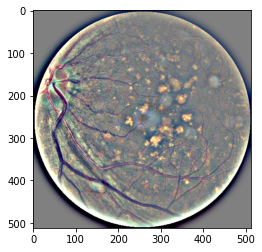

In [15]:
plt.imshow(data[0])

In [17]:
image_copy=np.copy(data[0])

In [18]:
image_copy = cv2.resize(image_copy,(224,224))

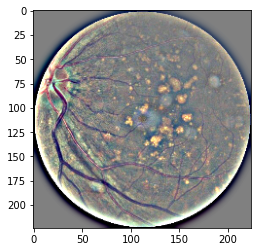

In [19]:
plt.imshow(image_copy)